In [1]:
import open3d as o3d
print(o3d.__version__)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
0.19.0


In [2]:
import open3d as o3d
import numpy as np
import cv2
import os
dataset_path = "./desk_2" 
rgb_path = os.path.join(dataset_path, "rgb.png")  
depth_path = os.path.join(dataset_path, "depth.png")
rgb = cv2.imread(rgb_path)
depth = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)
intrinsics = o3d.camera.PinholeCameraIntrinsic
rgb_o3d = o3d.geometry.Image(cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB))
depth_o3d = o3d.geometry.Image(depth)
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    rgb_o3d, depth_o3d, depth_scale=1000.0, depth_trunc=1.5, convert_rgb_to_intensity=False
)
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, intrinsics)
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
o3d.io.write_point_cloud("desk_pointcloud.ply", pcd)
o3d.visualization.draw_geometries([pcd], window_name="Point Cloud")

[ WARN:0@0.011] global loadsave.cpp:268 findDecoder imread_('./desk_2/rgb.png'): can't open/read file: check file path/integrity
[ WARN:0@0.011] global loadsave.cpp:268 findDecoder imread_('./desk_2/depth.png'): can't open/read file: check file path/integrity


error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [3]:
!ls /mnt/data/desk_2


ls: cannot access '/mnt/data/desk_2': No such file or directory


In [4]:
import os
print("Dataset exists:", os.path.exists("/mnt/data/desk_2.tar"))


Dataset exists: False


In [5]:
import os
print("Current directory:", os.getcwd())


Current directory: /home/vedh


In [1]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv2
import copy
import sys
import os

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import os

scenes_path = "realsense snaps"

print("Contents of rgbd-scenes:")
print(os.listdir(scenes_path))

Contents of rgbd-scenes:
['4_Depth.raw', '1_Depth.png', '1_Depth.raw', '4_Depth_metadata.csv', '3_Depth.raw', '2_Depth_metadata.csv', '1_rgb_Color.png', '4_Color.png', 'stitched_output.avi', '2_Depth.png', '2_Depth.raw', '1_Depth_metadata.csv', '5_Depth.png', '.ipynb_checkpoints', '5_Depth.raw', '3_Color.png', '2_rgb_Color.png', '4_Depth.png', '3_Depth_metadata.csv', '5_Depth_metadata.csv', '5_Color.png', '3_Depth.png']


In [3]:
desk_path = os.path.join(scenes_path, "desk")
print("\nContents of rgbd-scenes/desk:")
print(os.listdir(desk_path))


Contents of rgbd-scenes/desk:


FileNotFoundError: [Errno 2] No such file or directory: 'realsense snaps/desk'

In [9]:
desk_2_path = os.path.join(desk_path, "desk_2")

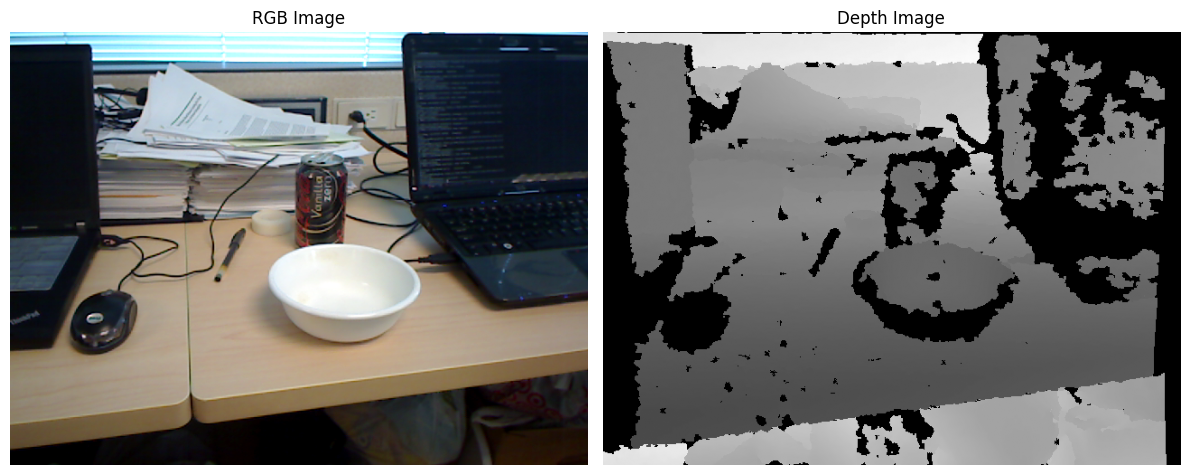

In [10]:
img_index = 53
base="rgbd-scenes/desk/desk_2"
rgb_file = f"{base}/desk_2_{img_index}.png"
depth_file = f"{base}/desk_2_{img_index}_depth.png"
rgb_img = cv2.imread(rgb_file) 
depth_img = cv2.imread(depth_file, cv2.IMREAD_UNCHANGED) 

rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("RGB Image")
plt.imshow(rgb_img)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Depth Image")
plt.imshow(depth_img, cmap='gray')
plt.axis("off")
plt.tight_layout()
plt.show()

color_raw = o3d.geometry.Image(rgb_img)
depth_raw = o3d.geometry.Image(depth_img)

rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw, depth_raw,
    convert_rgb_to_intensity=False
)

intrinsics = o3d.camera.PinholeCameraIntrinsic(
    o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault
)

pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image, intrinsics
)
o3d.visualization.draw_geometries([pcd])

In [7]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import copy

def remove_plane(pcd, distance_threshold=0.01, ransac_n=3, num_iterations=1000):
    plane_model, inliers = pcd.segment_plane(distance_threshold=distance_threshold,
                                             ransac_n=ransac_n,
                                             num_iterations=num_iterations)
    [a, b, c, d] = plane_model
    plane_cloud = pcd.select_by_index(inliers)
    object_cloud = pcd.select_by_index(inliers, invert=True)
    plane_cloud.paint_uniform_color([1, 0, 0]) 
    return object_cloud, plane_cloud

def color_clusters(pcd, eps=0.05, min_points=10):
    labels = np.array(pcd.cluster_dbscan(eps=eps, min_points=min_points))
    n_clusters = labels.max() + 1
    print(f"Detected {n_clusters} clusters")
    colors = plt.get_cmap("tab20")(labels / (n_clusters if n_clusters > 0 else 1))
    colors[labels < 0] = 0  
    pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
    return pcd
object_cloud, plane_cloud = remove_plane(pcd)
clustered_objects = color_clusters(object_cloud)
o3d.visualization.draw_geometries([plane_cloud, clustered_objects])

Detected 13 clusters


In [7]:
labels = np.array(pcd.cluster_dbscan(eps=0.02, min_points=10))
max_label = labels.max()
colors = np.zeros((len(labels), 3)) 
cmap = plt.get_cmap("tab20")
for i in range(max_label + 1):
    colors[labels == i] = cmap(i / (max_label + 1))[:3]
pcd.colors = o3d.utility.Vector3dVector(colors)

o3d.visualization.draw_geometries([pcd])

In [8]:
# largest plane
def color_clusters(pcd, eps=0.05, min_points=10):
    print("Clustering with DBSCAN...")
    labels = np.array(pcd.cluster_dbscan(eps=eps, min_points=min_points, print_progress=True))
    
    n_clusters = labels.max() + 1
    print(f"Detected {n_clusters} clusters")

    colors = plt.get_cmap("tab20")(labels / (n_clusters if n_clusters > 0 else 1))
    colors[labels < 0] = 0  
    pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
    return pcd
object_cloud, plane_cloud = remove_plane(pcd)
o3d.visualization.draw_geometries([plane_cloud])

Segmenting the largest plane (e.g., tabletop)...
Plane equation: -0.0151x + 0.8831y + 0.4689z + -0.3243 = 0


In [9]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import copy


def remove_plane(pcd, distance_threshold=0.01, ransac_n=3, num_iterations=1000):
    print("Segmenting the largest plane (e.g., tabletop)...")
    plane_model, inliers = pcd.segment_plane(distance_threshold=distance_threshold,
                                             ransac_n=ransac_n,
                                             num_iterations=num_iterations)
    [a, b, c, d] = plane_model
    print(f"Plane equation: {a:.4f}x + {b:.4f}y + {c:.4f}z + {d:.4f} = 0")

    plane_cloud = pcd.select_by_index(inliers)
    object_cloud = pcd.select_by_index(inliers, invert=True)

    plane_cloud.paint_uniform_color([1, 0, 0]) 
    return object_cloud, plane_cloud

def color_clusters(pcd, eps=0.05, min_points=10):
    print("Clustering with DBSCAN...")
    labels = np.array(pcd.cluster_dbscan(eps=eps, min_points=min_points, print_progress=True))
    
    n_clusters = labels.max() + 1
    print(f"Detected {n_clusters} clusters")

    colors = plt.get_cmap("tab20")(labels / (n_clusters if n_clusters > 0 else 1))
    colors[labels < 0] = 0  
    pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
    return pcd

object_cloud, plane_cloud = remove_plane(pcd)

clustered_objects = color_clusters(object_cloud)

o3d.visualization.draw_geometries([plane_cloud, clustered_objects])
data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABKUAAAHbCAYAAAAarSldAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjEsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvc2/+5QAAAAlwSFlzAAAPYQAAD2EBqD+naQABAABJREFUeJzsvXe8JUdxL/6t7jnnho1a7a7SLsoogJAAgZAlAcJgbJIRyLawAeFHMGAEDsCDnx/pEUy0RTA2xjYCCYwNxlg4gJCJMvAAk4UAJVZpJW1ON53prt8fVdXTZ+6ccFcrCcx893P3nDPT07l7ur5dVU3MzGjRokWLFi1atGjRokWLFi1atGjR4h6Eu7cz0KJFixYtWrRo0aJFixYtWrRo0eIXDy0p1aJFixYtWrRo0aJFixYtWrRo0eIeR0tKtWjRokWLFi1atGjRokWLFi1atLjH0ZJSLVq0aNGiRYsWLVq0aNGiRYsWLe5xtKRUixYtWrRo0aJFixYtWrRo0aJFi3scLSnVokWLFi1atGjRokWLFi1atGjR4h5HS0q1aNGiRYsWLVq0aNGiRYsWLVq0uMfRklItWrRo0aJFixYtWrRo0aJFixYt7nG0pFSLFi1atGjRokWLFi1atGjRokWLexwtKdWiRYsWLVq0aNGiRYsWP+O45JJLQET45je/eW9npUWLFi0OGFpSqkWLXzDYgsb+iqLAEUccgWc961m49dZbBz73qU99Ck984hNxyCGHoNvtYs2aNXj4wx+Od7zjHdi9e3df2KOOOqovjcnJSRx//PF42ctehu3bt4/M4xe+8AUQET7+8Y/f5fK2aNGiRYsWLVqMg/oaaXJyEocffjge+9jH4l3vehf27Nlzj+Tjve99Ly655JIDHu9rX/taEBG2bt16wONu0aJFi/1FcW9noEWLFvcO/u///b84+uijMTc3h6997Wu45JJLcNVVV+EHP/gBJicnU7gYI5797GfjkksuwSmnnIIXvvCF2LhxI/bs2YOvfvWr+D//5//g3//93/Gf//mfffGfdtpp+OM//mMAwNzcHP77v/8bF198Mb74xS/i61//+j1a1hYtWrRo0aJFi3Fha6Rer4fbb78dX/jCF/AHf/AH+LM/+zNcfvnleMADHnC3pv/e974Xa9euxbOe9ay7NZ0WLVq0+FlAS0q1aPELil/7tV/D6aefDgB4znOeg7Vr1+Itb3kLLr/8cvzmb/5mCvfWt74Vl1xyCf7wD/8Q73jHO0BE6d5LXvISbN68GR/60IcWxX/EEUfg6U9/evr9nOc8B8uXL8fb3/52XHvttTj++OPvxtK1aNGiRYsWLVrsH/I1EgC88pWvxOc+9zk84QlPwJOe9CRcc801mJqauhdz2KJFixb/c9Ca77Vo0QIAcM455wAArr/++nRtZmYGb3nLW3C/+90Pb3vb2/oIKcNhhx2G//2///dYaRx66KEAgKJYOh9uKuc/+clP8PSnPx2rVq3CunXr8KpXvQrMjJtvvhm//uu/jpUrV+LQQw/FO97xjr7nFxYW8OpXvxoPfvCDsWrVKixbtgznnHMOPv/5zy9Ka9u2bXjGM56BlStXYvXq1bjwwgvx3e9+F0S0SJ3+Rz/6Ec4//3ysWbMGk5OTOP3003H55ZcvuXwtWrRo0aJFi59dPOpRj8KrXvUqbNq0CZdddlnfvXHWAmYa+KUvfQm/93u/h4MPPhgrV67EM5/5TOzYsSOFO+qoo3D11Vfji1/8YjIjfOQjH9kX1/z8PP7oj/4I69atw7Jly3Deeedhy5Yt+1WuRz7ykbj//e+P733ve3jEIx6B6elpHHfcccmFwhe/+EWcccYZmJqawgknnIArr7yy7/lNmzbhhS98IU444QRMTU3h4IMPxm/8xm/gpz/96aK0LI2pqSls2LABb3jDG/CBD3wARLQo/H/8x3/gnHPOwbJly7BixQo8/vGPx9VXX71fZWzRosXPNlpSqkWLFgCQFgMHHXRQunbVVVdh586deNrTngbv/ZLi6/V62Lp1K7Zu3YpbbrkFn/rUp/Bnf/ZnePjDH46jjz56v/P5W7/1W4gx4s1vfjPOOOMMvOENb8DFF1+MxzzmMTjiiCPwlre8Bccddxxe+tKX4ktf+lJ6bvfu3fibv/kbPPKRj8Rb3vIWvPa1r8WWLVvw2Mc+Ft/5zndSuBgjnvjEJ+Lv//7vceGFF+KNb3wjNm/ejAsvvHBRXq6++mo87GEPwzXXXINXvOIVeMc73oFly5bhyU9+Mv75n/95v8vYokWLFi1atPjZwzOe8QwAwBVXXJGuLXUt8KIXvQjXXHMNXvva1+KZz3wmPvzhD+PJT34ymBkAcPHFF2PDhg048cQTcemll+LSSy/Fn/zJn/TFcdFFF+G73/0uXvOa1+AFL3gBPvWpT+FFL3rRfpdrx44deMITnoAzzjgDb33rWzExMYELLrgA//AP/4ALLrgAj3vc4/DmN78Z+/btw/nnn9/nW+sb3/gGvvKVr+CCCy7Au971Ljz/+c/Hf/7nf+KRj3wkZmZmUrhbb70V5557Lq6++mq88pWvxB/+4R/iwx/+MN75zncuys+ll16Kxz/+8Vi+fDne8pa34FWvehV++MMf4uyzz24ku1q0aPFzDm7RosUvFD7wgQ8wAL7yyit5y5YtfPPNN/PHP/5xXrduHU9MTPDNN9+cwr7zne9kAPzJT36yL46yLHnLli19fzHGdP/II49kAIv+zjrrLN66devIPH7+859nAPyxj30sXXvNa17DAPh5z3teXz42bNjARMRvfvOb0/UdO3bw1NQUX3jhhX1h5+fn+9LZsWMHH3LIIfy//tf/Stf+6Z/+iQHwxRdfnK6FEPhRj3oUA+APfOAD6fov//Iv8ymnnMJzc3PpWoyRf+mXfomPP/74keVs0aJFixYtWvzswNZI3/jGNwaGWbVqFT/wgQ9Mv8ddC1jcD37wg3lhYSFdf+tb38oA+F/+5V/Stfvd7378iEc8YmD+Hv3oR/etu/7wD/+Qvfe8c+fOoeWztdSWLVvStUc84hEMgD/ykY+kaz/60Y8YADvn+Gtf+1q6/pnPfGbRWmhmZmZROl/96lcZAH/oQx9K1y666CImIv72t7+drm3bto3XrFnDAPjGG29kZuY9e/bw6tWr+bnPfW5fnLfffjuvWrVq0fUWLVr8/KPVlGrR4hcUj370o7Fu3Tps3LgR559/PpYtW4bLL78cGzZsSGHsVL3ly5f3Pfv9738f69at6/vbtm1bX5gzzjgDn/3sZ/HZz34W//qv/4o3vvGNuPrqq/GkJz0Js7Oz+53v5zznOem79x6nn346mBnPfvaz0/XVq1fjhBNOwA033NAXttvtAhBtqO3bt6MsS5x++un41re+lcJ9+tOfRqfTwXOf+9x0zTmH3//93+/Lx/bt2/G5z30Ov/mbv4k9e/YkrbBt27bhsY99LK699tqhpxm2aNGiRYsWLX7+sHz58qQptD9rgec973nodDrp9wte8AIURYF///d/HzsPz3ve8/pcKpxzzjkIIWDTpk37XaYLLrgg/T7hhBOwevVqnHTSSTjjjDPSdfuer69y31q9Xg/btm3Dcccdh9WrVy9aX5155pk47bTT0rU1a9bgd37nd/ry8tnPfjZp6Vt9bt26Fd57nHHGGY1uF1q0aPHzjdbReYsWv6D4i7/4C9z3vvfFrl278Hd/93f40pe+hImJib4wK1asAADs3bu37/pxxx2Hz372swCAD33oQ7j00ksXxb927Vo8+tGPTr8f//jH44QTTsD555+Pv/mbv8FFF120X/m+z33u0/d71apVmJycxNq1axddrxNlH/zgB/GOd7wDP/rRj9Dr9dL13Jxw06ZNOOywwzA9Pd337HHHHdf3+7rrrgMz41WvehVe9apXNeb1zjvvxBFHHDF+4Vq0aNGiRYsWP9PYu3cv1q9fD2D/1gL1g16WL1+Oww47bElmafW1kLleyH1TLQUbNmxY5Dd01apV2Lhx46Jr9XRmZ2fxp3/6p/jABz6AW2+9NZkhAsCuXbvS902bNuHMM89clHZ9fXXttdcCEB9eTVi5cuU4RWrRosXPEVpSqkWLX1A89KEPTSfLPPnJT8bZZ5+N3/7t38aPf/zjpBl14oknAgB+8IMf4Nd//dfTs8uXL0+E01VXXTV2mr/8y78MAPjSl76036RUk2+rQf6u8oXRZZddhmc961l48pOfjJe97GVYv349vPf40z/90z7n7uMixggAeOlLX4rHPvaxjWHqC60WLVq0aNGixc8vbrnlFuzatSu93++ttcA4654DEd846Vx00UX4wAc+gD/4gz/AmWeeiVWrVoGIcMEFF6T6WQrsmUsvvTQdkJNjfw7LadGixc822lHdokWLRM6ce+65eM973oNXvOIVAEQdfNWqVfjoRz+KV77ylXDurln8lmUJYLHm1T2Bj3/84zjmmGPwiU98om838DWveU1fuCOPPBKf//znMTMz06ctdd111/WFO+aYYwAAnU6nTyOsRYsWLVq0aPE/E6YZbgTU/qwFrr32Wpx77rnp9969e7F582Y87nGPS9eaTjv+WcXHP/5xXHjhhX2nHs/NzWHnzp194Y488shFaylg8frq2GOPBQCsX7++XV+1aPELgtanVIsWLQDIkcAPfehDcfHFF2Nubg4AMD09jZe//OX4wQ9+gFe84hWNO3BL2ZX71Kc+BQA49dRTD0ymlwDb7cvz+//+3//DV7/61b5wj33sY9Hr9fD+978/XYsx4i/+4i/6wq1fvx6PfOQj8b73vQ+bN29elN7+Hs3cokWLFi1atPjZw+c+9zm8/vWvx9FHH538IO3PWuCv//qv+1wI/OVf/iXKssSv/dqvpWvLli1bROr8rMJ7v2gt+O53vxshhL5rj33sY/HVr36178Tj7du348Mf/vCicCtXrsSb3vSmvnoytOurFi3+56HVlGrRokXCy172MvzGb/wGLrnkEjz/+c8HALziFa/ANddcg7e97W244oor8NSnPhUbNmzAjh078K1vfQsf+9jHsH79ekxOTvbFdeutt+Kyyy4DACwsLOC73/0u3ve+92Ht2rX7bbp3V/CEJzwBn/jEJ3Deeefh8Y9/PG688Ub81V/9FU4++eQ+za0nP/nJeOhDH4o//uM/xnXXXYcTTzwRl19+ObZv3w6gf/fyL/7iL3D22WfjlFNOwXOf+1wcc8wxuOOOO/DVr34Vt9xyC7773e/e4+Vs0aJFixYtWtw1/Md//Ad+9KMfoSxL3HHHHfjc5z6Hz372szjyyCNx+eWX9615lroWWFhYwC//8i/jN3/zN/HjH/8Y733ve3H22WfjSU96Ugrz4Ac/GH/5l3+JN7zhDTjuuOOwfv36gT6W7m084QlPwKWXXopVq1bh5JNPxle/+lVceeWVOPjgg/vCvfzlL8dll12GxzzmMbjooouwbNky/M3f/A3uc5/7YPv27Wl9tXLlSvzlX/4lnvGMZ+BBD3oQLrjgAqxbtw433XQT/u3f/g1nnXUW3vOe99wbRW3RosXdhJaUatGiRcJTnvIUHHvssXj729+O5z73ufDewzmHSy+9FE996lPx/ve/H+9+97uxY8cOLF++HPe///3xxje+Ec997nMXndD3ne98B894xjMAyOl1a9euxVOe8hS8/vWvv1ecfz/rWc/C7bffjve97334zGc+g5NPPhmXXXYZPvaxj+ELX/hCCue9x7/927/hJS95CT74wQ/COYfzzjsPr3nNa3DWWWf1LURPPvlkfPOb38TrXvc6XHLJJdi2bRvWr1+PBz7wgXj1q199j5exRYsWLVq0aHHXYe/wbreLNWvW4JRTTsHFF1+M3/3d302HwBiWuhZ4z3vegw9/+MN49atfjV6vh6c97Wl417ve1bfp9epXvxqbNm3CW9/6VuzZswePeMQjfmZJqXe+853w3uPDH/4w5ubmcNZZZ+HKK69c5GNr48aN+PznP48Xv/jFeNOb3oR169bh93//97Fs2TK8+MUv7ltf/fZv/zYOP/xwvPnNb8bb3vY2zM/P44gjjsA555yD3/3d372ni9iiRYu7GcT76xGvRYsWLX6B8MlPfhLnnXcerrrqKpx11ln3dnZatGjRokWLFj9HuOSSS/C7v/u7+MY3vpEOmmkB/MEf/AHe9773Ye/evQMdq7do0eJ/NlqfUi1atGhRw+zsbN/vEALe/e53Y+XKlXjQgx50L+WqRYsWLVq0aNHi5xf19dW2bdtw6aWX4uyzz24JqRYtfoHRmu+1aNGiRQ0XXXQRZmdnceaZZ2J+fh6f+MQn8JWvfAVvetObMDU1dW9nr0WLFi1atGjR4ucOZ555Jh75yEfipJNOwh133IG//du/xe7du/GqV73q3s5aixYt7kW0pFSLFi1a1PCoRz0K73jHO/Cv//qvmJubw3HHHYd3v/vdeNGLXnRvZ61FixYtWrRo0eLnEo973OPw8Y9/HH/9138NIsKDHvQg/O3f/i0e/vCH39tZa9Gixb2I1qdUixYtWrRo0aJFixYtWrRo0aJFi3scrU+pFi1atGjRokWLFi1atGjRokWLFvc4WlKqRYsWLVq0aNGiRYsWLVq0aNGixT2OlpRq0aJFixYtWrRo0aJFixYtWrRocY9jbEfnr/zWPnBkdNiBQAATnCMQORAYAIO9h3MO0QGIDA+CJ4J3JPQXAczy6QAQAZ4A5wE4oCSAnNxzBJCGJc2Dc0D0AJM8SwT4zCMW65/XZ6JSbhbGs8ThHFAEYOuds9jZc+hOdLGqQ5icBtw04AoAHUmfI+ABFE7+yhIIhcajZQADFAGf5Y2lSCiyfFH2iezTrmk1gLKwQa9FvdbJni31+0QW1utfnqblI68joGIk607FLB+WrsVT/0OWr/rzANDL4kFDOEI/Kzqofkr01wlQ1UOZhbX79T/Lo8vKlt+3cljdW5nzsBGLEdDcXkBV33neFzTMegDLAazUOtqE/vrMYf2nzK5Zfjj7neeni/66rrejXbN48nJbOSzfVmd5WEsrTxtZOS1M3r/setA/q/tO7dmm9jNYv7LyWDz5uIi1MHk9dfX7QkOeS40v79v1dm3q9/nvvO0CFsPu589Y3Nbf8roOWRh7dgHAwQAerL9n5xjfJ2Bnl9K8l+chz2Nen5a/jsZt5c/7VhdSjz1U7UYBoFLCR+0oMQJc6nwdgIIZPMeY27EPO+7cilt3bsGevXuxMzA4AoE7iMwIIDjv4LxHAKPkiK/MzuGUk+6L551+KE72hGOzWtjHjJt2zuDD3/8JfvKTazGzcx+6BEyHEkxSSmIGkbyDmBkuAs45MAPXBUbn+PviJec+DMetXoFVxDo/RTgQHFX1ZGPCxnGhuehl7WRtks/t9X5pmMs7AlfvCBtrEfq+0es9BvbqPSZpiw4BJQjzHOGIMOUcDgEQwVUc1gco6/tEaRwbnIaZT/2CNE+MAoQC0tesDwEk5aX+8VEfYwEEBiNSNfezPmFhbC7L5y/rf/m8FFHVByD9LAagR9p/Y9X3YpB3dWT5K0v5pFK+M+tfBDgAIQBlkDCzoQcGw/UIsYxwgRFixAJHBI6IYKDHWJibx3uffAj2F9dddx2I6m9B6af5J4C+cO9+97vxz//8z41xPuQhD8Gb3/xmAMDrX/96fOELX9jv/N2bICLU3Zs21dWBwp133om5ubnRAX8GMDExgUMOae53zIybb7554LMbNmyA937g/f1BWZa49dZbR4brdDo4/PDDG+9t2rSp8fratWuxbNky3HrrrSjLsu/esmXLsHbt2rHyuH37duzZs2fg/eXLl+Pggw8eK66l4LbbbkOv1zvg8bZo0aLF/wSMcmM+tqPzd+h7z0OJJHuKAHayGDbCx1atDoB3uhj2cn3BCeE0EeXTC78lUemzHhnpREBhi3hNi7O1Sv11mxMgORlh1+z3SgA7tgDf3R4A73DEKuCglQQ/UcVZAH1ERhNJkxV3Ufr2rAkpOYGRIyd66mnVheQ8PrueE1+F/tlzJjhN6Ges3asLT5aG5T8nsAYtEevklj1XZnVQL2teh/ZMPT9NdcW1MDkJkQvfQP+z9lxdNTAX+OsC/P6oETbFZfEtQITTnfp7A6q6boqnKY68bHkfBxaTEE35yFEnpQL667Ven03f65NHfSzk9Zu3cd5f63k0GqLeT/OxVW+3vM8NKquh3mfqBGae95w4qJNQ+bi233l6eXw58ZTfi6hIMitfTm7lxFUAMAMhNe+n9+cWgB8QsLMDTKF/rOXPGuqkYBcVKZUTDBEyZzgIcRE0n8xCnhCLcJ/qe1bn6gVg394F3HLTZmz6xjdx8w+vwZ23347Z2TnsKb2QCDSViBDHBEcO3PFgJtyybwHL1q7Fw486CRvXdLEWmwHeC0c97JhfwOY778CPN9+MnTt3I3RXgXwHIA9iIV7kbUZgkhYnRyLcMmP33g463fW439EPwSFrD8f0xCwcAcwzcI703UNK2PSPGjLigAjU1+kZIJeIF2i5WAkmu9PTZx0zYtQWJifkEStxw1W6kSMWwIiIoA6hIIZ3QHBdzM3OY2qii2UrlqPjS8QYEYhBBeAKB/gI5x1iodtFzkvf8x7khHgiJ/UePAvR5BzI6WhzHkwODHux++qF7BzgCYVz6JCDczKDsSONX9IMDijIoUuECUdwDJSO5L4jOCJ4lrYhIiyQPNPVUeZISImOqwg8AoHgEPQF2YW2bQQ4UrVGAMk4YIAiwDmzxZT6iIs67+m9oMSWDxVRxzpQGBELvR7+9+n2Jl06jJRi5kS42HdmXkRK5eGanss/Lcww5PeHkWOjwgwikPL8DXo+D1cPPyy/46BeN/n1PC5mxhvf+EZ8+9vfXlL89wSaynzKKafgda973aL+QESYnZ3F0572tIHxXXrppVi5cuWi66Pqvikv9sydd96J5zznOSPLcswxx+Diiy9uvHf++edjYaHaHrK0/uiP/giPeMQj8LznPQ933HFH3zMPf/jD8cd//Mdj9aH3v//9+NSnPjUwb7/yK7+Ciy66qC/9fEzl9WzX6nltwkUXXYQbb7wx/Z6dncWmTZtw4oknApA5YNu2bQOfr+P000+Hcw5f//rXsWzZMpxyyikDw/Z6Pfzwhz/EqaeeOjDM1772tb7fRxxxBDZu3NgYdt++ffj+97+Pww47DEceeeRY+a2PsxACvvGNbywKd/LJJ2PVqlVjxXmg8O1vf3sREb1mzRqccMIJd0t63/rWtzA/P3+3xN2ixc8rDhgp9UndhQRVRIOtU3MNC6BfuPLoFyZtD6EDIbZyQsVxRi5wRVoVsV+Qy4Vhp+EcVFiyewxEqq7BrmuAZRHYvafEV7bMoQRh49pprFtBmHRAQf2EUyJSiAGWvDPbspX6ys6ygoUn0jg47eKzPpeIhezd5lWosp3uCHkxuqgLbRVoklBLQE93tz0o1Y1HJuiTCpGo6sBR9XxeLylMlqc6AZKHXfQcFj/XRMQ1hc3jy5/JUSdI6p9G7uQkQ53wsbTqJGV+rV7mvrpDM+qESf0z768lgGsg5NSJACZREYYtfrZRJ+FyUiwnoFALkz9TJ7vy5/L4c0IOqIikOQDTAA7S6wtBNO1mPbAW1di3Z3LyLJ87S/QTabEWPi9LT8PPo1+jjKMQVUTAxAIQA2PbHbP48Xevxte/eCW+/8Ursf36nyDORZkneRKgDpi68rDoSsH0lYgKLX+p8/YCgF1gzEP1b4QJAwHUQZw+COgIKQV2IN21IOfBHAGOIK9kBUepvLkA4gkQPJikZhhBF9PCJMn7RwiJ6GyejkisB4Skiswy39tuCrMGJqg+ca1FAaT3Rr8gBLtK1UubjP3iKBpgIMAV4BilzjodBK8NgWyi91FfnDorkdd7uiPE+qJ1prsIJDUx0vKQvuXJq+owgKIL+ALoeKAoQIUH/ATIecB14IsOMOnlWU8ofAfeeRSFh3OE6Au4QsI67+FdAe8KdFwXwTHYO0yQg3cOXUfySSp8ElC4LrzvCi/mHaaUWCsgGtpCLMpfhwDvPDpEyv15eOfQQSHa3c7JppPzoG4hzzppBU+k+SSw1kVwBHIOb37cBuwvrr/++oFCdBMplWMcEim/Pkhgrwvbw+KrC+R1gXNU2EGk1Kg81sPm4Qf9bipLvaxNZMZSCLKm+h5GvA2LK8+nXWtqm7xf1MMOIgDvSl011VtTXkfFOy7p1ZTXetqj6nNUvkeNN6vLYX16GEE76DoRYfPmzfjYxz6Gl7zkJQCELPvmN785tCw5/vzP/xydTgcvetGLcOSRR+JP/uRPBobdu3cv3v72t+O1r31tXx4sjzFGPP/5z+8r5xOe8AQ86UlPauwvmzZtwhvf+EY85jGPwW/8xm8MHP95PTnn+kj2mZmZVPYcL3vZyxJRl2OcfjNO/24a16985SuxZcuWvvw/+MEPxgtf+MKRaYm2df8GQt5vmvrPKaec0kdQ3hWcdNJJ6HQ66TczY8eOHbjlllv2O86iKHDyySc33vvhD3+4SFOxRYsDgQNGSv3TvO7oBqRdYJNwSshasCQgRF3XkgovDCByIoQWYkzrZwBwrIRKZHBgWTNTRIwMTyykV2CUUYgZJkaMjKiCRKFxcwQC1CQkQne2CWUZ0DORhoDCC/lTzPewZ+su3LRnD5gI3eXrsGy5R9HtwHsRB+cJKJkxQQU6nkAQ5t+RCAkiYDgwGWFHYh4AxgQcmDRvRICakERmlLrQ9qDEHBUgdEiEGTAw7wKc83ClVnPHo+CIrpFcBMySg/dOSDKo6YTWbQeEwokZhioBgEDokENJQOnFHMRFFuGESNuNKvkJSjg6DQttUxV+WOUX0yizjhQAFF4F5EzW8ZXMkAhO1vwVVJlrWHzQPpO/bprII6Ay38rJoQKLTfAKCAlEqDTSPCqTtwVUJnBm9mjhOqgICNIwyH5bOJMNgUpzxYiBGQa+iIg5IjwYhGkApuBOtc8WLUahZGAHZO5dh8X22HUCzGAElS076qaCOZllZlwLEILKNhaMJANkTN0508M/Xvk9XHXpR7D5y1/BzOxm+C7D+2mZy4IHOYdIBFaiBUSaL13gORnBjl0i1fWu6A3FCIpCEJUFp7LY5gAgC0gKsnD0gGjnEECRwCEmDZ3otE5INIeYWdJlAjiCOSJ0gpikk4xkiroIRUSIJWIMoEIX4laZrgNPTrSJdXIgyKIWqp1DHjLXxyCaUwREnRxDVNKqUK2sEEWjjAGGEzJM89FDAIgR0QPFEo4DiijCwbyf0LZVoZYiOLISgdraoZR6CyzEnWNwtF0gfWswgznIZJ+0jkgm7kDoo/+9Ezt277RTufR+SWESSabxUHafegAYRNLGjmX2FuLQwZHM6kQETz1tcRMsrUEZRELiuSSoeukj1JWeYuShc+BOB957Mfcn0TZzRQH2Duw8iJwSagVu+8JfY39x/fXXp++5IDeKXFqqQDwIuQDVJNQ1EQJ5nKOE0qb0hmEU8XBXCI+meMZ9ZhCZN4yUGveZ+rWmNmmq52F1My45tRTsb92PIkTvSp5GaTANyndTG40iVZueG5T3UXGO82wTRo3Lepma0DTWB5VvKXkblp59mkZwHr/T93tepmHzzqB5ahAZNKhMSyUW6/kalV49TmbGAx7wgLtMSp100klYu3Ytzj77bExOTvalfdttt+Gaa65J+fj617+Oubk5OOdw9tlnj4y72+3inHPOaSzDl7/85aTlld+/8cYbcdNNN92lMrX4xcYoymlsn1Kf/M8fCvGhC28PJ9o9TFjQhaRsNso/0p1X02BiAsg5uBBl3ehZForkhBgJsvMMAMExnCNM6E5xiCxkiC8QvZg2cCzhHKHDkB1mJt3Fp2Re6JxHL5QoSRby0TE6BBRguNjDwtwMHCK8LzC/fQvmdzn0OpOyuCUgEIFBmKIC3slCPsSA6MVfVidiEaFDLCYM8yjFv4VTqoKETGIAoRB9p4JdtbntRKii1GASj2gMEJwn9MhjniqCL5KDI0JPF/tJy4EIBQEFSf3YBjJYFumBGNHLbrK1jSHJBlB5isR6w9JUWQHQ9T87NefU8MxKNNn1PO6MsaFMFcPrBr5JzqTPs1fiS6uEUWno5aZmRP1kVTIZtftZOPMH41wlE0H7KFiE+8JVZFVH40t9GVXddFTABItWHmdpWdTJR1AUAmE+Apsi4CaAm72Yimzymh9tK+dSVfTFg+waoypz3ewrz0cmCvblK7/Otc9hppD16aTJJDWPR8jSCrnmZD1P9qzVvWlgmsiba/oYAZjJ/X35yNOgLM56+9TzYvdz/1V11ONpMnetp7N/y/B+5ATRZgD7AMwTsArA6gHPDEubUZG59jv/jNmnkVW5+R9Q+bHbFxjXXb8FX/v0f+D6L30OfmYOE8tXouh6OJIaIsjk4BHAyWZbBg7rxCP8hANTRwkQmYzEnxGDmOHLEgxGQT15VicqAikRxCC1L3c60bADyHlQUUC2A8hyJC8Lkjw4yDuNVfvIuyhmbk56RP5CLaLWhNOa7rBsPHh5rcq7j3UO92meME7EgWQXB6y6U1HM6rTmZe6gRASx7gSIQg+BI8NpaxB10XHA1ISH63iUoURRdsGRETiCwWAK1dxg5I02QQyMyBGkAy9G1kpnuFhquYOUL2aj1QgszZu0BYMLACWDYlRNJSEVwQwqndYvgTmAzB400aTyXdK0GTRoVxFSjUAISo8ySR07dhDNtUpzjDOdPwKBorZ9akaG2jTCdJhZa4kARCaEGFFGCNl2F5ALNE3ERFP4lMsBAnVdqBokIA/CMAFvWPhRWApRNYo0OlDkyiCiJL83SOOm6X5dY6Ip301pNT3fFGaQEN5Utqbfo7DU8E0aVXVCYVBb7k/7jUuWjIq7qY3Gyc8gsmR/SNhxyKxBhMr+ko7jEk1LIaTGIXDqYfd3vhhU7+O0x7j9bRzCcFTfbsI73/lObN26daw8DMLJJ5+MxzzmMTjooIMALJ5PDj/8cBx22GGpbx9yyCGYn5+Hcw4PfOADG8syLs4555xF14gIV155ZUtKtbhbMTYp9e0f6y6fh+5AekxEh0lfwHvdVQZERd5300AhFTREY4cwRbKrHB3gvOyce11H6rQGeK+CgDDrYlFAYFeCnIcnB4+u7IR7SjuiXSWfHANEDGaPCS86L6zCAzFk0V8wVq5ajclOgW63A5ovMTM/j72dLjw5FCjgyMHDo1DGpFSByTlCQYTCyDbvkzN1gquIBRZhiCEmJEQAR6DnRHx1RHDEStaINhcihGzLHASRCj229jdXHyrGVQQPGSlVEVF9Zm1K+OQSPKugpLKhPKOSeD4HWv7hZW2eC6wm2NgmustYkUoAUuHHrqsEH7QTFkHrSusNDESTT6wsmgZY86PkE8cqI2XGDETOSAKtszKqzBKRfKARMkfOkD7CRhBpIYlMMAa6pA51q2pXYUzTZCQn+y7q71KcF5cMLHeEwz1wjAO2zwE/KKRsHUrFXaTZYr5/GNWgzf0UESr/UIYIIR1yky4jkermhha+bnKbkyxWTzksvjpplsPi7WV5r5u1WT5ywinXZLPy1v1IIbuX5yMnjii7lqeXk2+ofZ+slS8PY76W8jrM086RhxnUtrmGnSEn2/JruyFmdNcGxq17I3Y7h2OnCEcVEraDfrKunsecUMrLZCRgbrY3TDw1M75CA35toYePXPUV/PQr/wW3dycmV03Dd3PdQoBQKqkQdIw7Iaeo6m1CkgdxLs2Aiw7sbfwZgSO5JM40elhMBKOW3CkpFXRi4OhACEoSxao9iBA5pg7BIARmMMt7JQaSgzhKSTs6mfRd8k0ERC/30jxQqlmgEj8gJC0cRKdzsFNFJAartm+EaAsnk3OdmJm8mo6LhpbcU3KDIohlM8R3HZatWYYJlJjdN4cyRETHoOCFlAIjZvbskg8hyzwxXHpPkmwsxSjv2EhiMsjealffRYy+kcwABbvngI60K+nkyzp5u2BCjGo+uwin7ZK4yigCO6uGmuyGaCImRFCwXgNiB8+FklLaR0ieS4t5JoC9rgGcvDjSxMNpzk79leV9TswoTOPrXsC4QmqOUdob9XuDtBTGJR2G5WXY/WGaEk35HxZuqekPI4Oa4hxGADbFPdJMoRbXUgTHprRHkVZLJfcGkVB5Xu3asDZsyvc4qPeNYf1nELE6ilisl/eu5Hec8OO0SdMY2996O5DPjOqjg8bAKCJtUJvsD+k2iMgdFM+gsT4sjUFh8r76mc98Zqij/XGwYcOGREiNk/b973//gW046Pqwemm698AHPhA333wzbrjhhqH5atFifzE2KfVLGw4DmMFeiCdHDp3oUDCBvQz6QCwLUC87j44BVr8MBUPII0QQOXDhlUwycwk1sSACUSE7qd6JrwgKiTEhFTej+oWAPuNZmQolsQDA2JpoQg85eGYUDETHcB0Pv7yLyUmHzp6InXtm4Qqg6zrooqOLV0KhxMW8E2LNkxQxaRmREEkcKxHeFKRCNq7N+WqX1LWHyBxKXEl485Hlo25C25qcK9mN9L9ENChp4iDCT1RihywdBjoZMeRVAyloGIuodJKGV4InEVEQZ/OOFvupST5woSQcpHyAlN1RtdcNqgiwYMRXlDAdO3rJV+QWYmUhYoKz5cdEoaTpoRK8OVevROGMDCBom1btQRqn5X0RNL1c0K+f9EbZp8mhPb3oNV5iIWUIwDFEOJTEL9D6aWCr9oU8jTohkZ+eaL/rvn8sD2ZW2Ktdt3IkOczKr38hC5vfy2Hp50QYDQhrRJGZl+bkmIVPFk/Zc3XCzD5TP0K/xk5eHvOV1IScYLPPnIjJn6v7KIu15wnViWxN6Vka9Tzm8Vme8jbJ40v54+rkRg7AdAEsA7CSHHwP2MnA1R3gJzpObJ4IWYf20D4Ydc6KlRZjFKsthFilXQZ5XjRjJF5HDA4RiIxeKUTKip5HWQb8009/gP/8wKWY/8ltmFi+Bt1OQMkRDCHvnSNw0QEpE00cwDEiQAefZpqDTGa2oQESX3p6V+pLdzCijiintB7DVX2QY9J7qcgMqUDmilplibAauAAcM0oUSv84hLKETzbpURZrTELwQM3dwABX/jQstqiarUaEFaGA8y45Iy85gnoRFKpe5krtMVSIZquzRuDqHcNKzIlNHxwCPE2g8AUQCQs9gMsoeVNNMCLuI49z/99CbGlvjEIQgeQsPQolOIbMZF86msynWh9R6kI0kQB2sapTUtM6NWGXSTyb6ZT8Mk066ZRWzgA42bARXorlGlF6v5OeCMx2XC/H6gWYtO1sptE1gVKYxJWPR7bZTJmxSJKeb5rc7mGMEqgNTUL5KG2c+vOjwgxKd9jvYeTYKHJnqcgF0UFCab1emkx16nENQr0so8iNYcRJXoZBcQwih5rqYFAexsGgPlOPf5x+OW7exukno/I7KNyo/B5IQm3cZ+9KndnzgzSthrXJ/hIwg/I0qP+NQ7gNy+dSyaqm+at+z+JoyndTfQ56Nv+dE7OvfvWrl+Q3rAmnnHIKTjvttLHDj+r7S8Wg/nPwwQfjqU99Kj784Q/jtttuOyBptWiRY2xSatXy1dJJHSdzLc9OaCbS3VE96Ygymy2GqMB752QxDgAgRNmLRREdiMRcLzgxXHCu0F1ScXoKLlUoEiGByCGoxpU57K58SMiePzmCsVMl1Om4+vnwDCxQQPQEsEMEoZgkTIZlQK8H7wuQd2AlloqoqvxaLEciQ3mXmRQ5gANVBI0SPElgNnIClRUAAem0QilZJSiYnEPaQkZKmS8mKLnidMPX4vAVJygaVSplmjASHeAKid+bKZ61igaKUTR3JknM2aKTOjPZziOt26vTFgkqbEqemYVQcyRmblYuI+Is3a71kU5WV6lyTBhGRSZRRjJZ0hmD0nRSYiofVE6poq+Ih9pcnueF8nBZGJ+Fzf8sH5ZebnbWhZhbLdfnJ6kibSgLV89L7mfLFMia/AfVtW6aCC4Lw6iOYa9rRtXjpOxZRlW+XPOpXu91LarcqbbVlaWb+kF2zcLX07fnXC0ue77eLnn9A4vb1gi+vA072feAilC0NIHF/cvXrlkd1Eko1J6zex1UGmW5hliej25kbAThfo4wMw3ctH0BN/QIs5Pi9NrGVU60WjtzFI29fC5LlcpCQsVMkzBA5ptSK3GCgBAcYgDmSiGkmYDNt+/B7qs+h/nv/Bf8RAcT0+vA8ECM6kvOoVN4dCZl06LsRSzMq0kUiQaoMyGQZO72DjA/UY4hZntauFIHvYtImlFCM1jvIW1bJUry0cXVRkFSGlL/VRVhATCVYm7O4sOQNC2CAztGAKd/9pxjBiLDKXvDLoKdEFOkE4yDvCP9hGy4FBzAQf4KzvoJAcEJkUVRCbZM9ZNJySAdAYEcFiKwa2YB3fke4jzQizKCPBEqEzl93t5d+oJwICEOicG9IH+wOVt9I6oGGaeXmWgkMVd1mUzfYkY66al7TtWJuRTSKIaYTPYZUTYfMi021tbgKC/cVN+sGm+aKCcCMWpXjqrdWnkas5YCgq48KLum/YTzdPU6RUSlsA7Mcr9Ck4A/jADK7w3T9hhFegzTXmgitPLrwwikYdoywwS8AyFQjUty5fdHER7jXhtF7A3L47B483uDNNaa8jKMRKu387D+Mo7wXycAB+WtiSgZRbKMg2FhxyUSx0Fe3ruiVWPYH3J5UHpN42nYmM6vjSKylkIWNeVtqWHzZ5YSfhjq5Wma/8bNax5fnYyya7fffjtmZ2eXlMc6JicnMT09fZfiyHEgSdiVK1f2OV1v0eJAYmxSqtcRkzxPTvx/MMnx2EYUQTSSIjOCsi4MBrGYqUUPdAoPUtWfkmWxLCyJOBwNjlU4ELHUK8OzIOfrwMPMAXRRzaqp4yqtBdGU8MmnEXOlnUNEsvsPyIlBkGOgeyXQ6xAwBRB1wR0geIIvhHSJSoh0i0rok/LJb68qHKz58Vl+elQ9kyg5WWOnRa6ZoXWg5A2L7yGnDIvKYGnT1wTxKWsbVMI/keTZ/DeZsGACc6DMtCmTkIky0k07RgfVcfAmpCNLC+gXwl2nv5wmCiYuEpVgb3XXRf+JXhaGrJ4sDaoIgTqBYEST5cfynp8wZkJ+/qpz2WfMvudEjsv+OIsvz2dOxNQHVC9Lc07DmtPoSX1+ld7P482JGKCf5DENqVwjLLUBqv6B7F7ybZXl2+7n5XDo6xap3syXUd0szsLnRIrFlzvRbiLKcnSz76YFZXVqz+V1m/cDK7chLxNp3qwP5wRRrpFkfcWetRMRrcw5cZcj14Syk0Rzbac07mpl4eyay57votLES21LcuJejxmxCFiJAh0ClnlgtY84CITVHWA2K4cRuJYWACGJ/WKSTAiHak4wV0m21mJANBoDCXkcZf4uOsBkyfjxD3dg99Y9AHdBnSkQyel3xBGOCOxYfFt3xE9ewSW4JFApvqWCmY0B8FHImuhEk8hRBAVJMzgAJG66RanHi4ZslN9SBl1sa+FLMzeHMD5ioqVmXyQmZaJsZPEIieUcgSKBvEs+CjlGRBbbZSOnOPlC4qTcQ1Guyyl5OolBNIKZ5F5EIWboBEQfEUKJWIoZPJu6aDTuR4gYQEzTBWL+p37AQVSinANmFgIWFghcMkKH4DuyaSTvIBVilMpz2uCkpFFReHjvULqAknsIOgi5lAlWtLRi2gQwwgpAInTSKEoaSARycvqeK3ShSxEhBFDJSQMrEmv7SfyJP4suPcMUdU1hMyWLmT/pASlciiN367dcjbgkOOgOh5jOay9RM0Do5hMzkk93qVxpgxDqxstLhzn6jVHqoE76AIAf4Ltqf7RGDIME3Cbhd5Cm1bA4xslTU5i7qkFiGKYdVidNxsG4JEBTmFFkwjhpLTVMTjKMQ5rkZVkqITFOHve3XYdpStXDDCPfhmEcAnhQ+kshXEfFuxTtMsMgQmXQOB2Wp/0dw+NqbQ7L+zgkt92vl2tQm4wbblge6mGb4mnqN8yMGCP+9E//FB/96EcH1MB48N6n98RSsFTNuP1pvzyPLVrcHRhfU2r1Wjnpje3oZVnsC3HgVTNJhS2HRLw41pPVlDxKQ40kjFOpjNQDdeDKzKerUm9J6jQ7YzsS0aNSsGnsGOniHNRkUNLWJJNvIVmUAm4XsGsnsNsDEysJq9cCk9NCsEyg8tFiQqMmn5AL8/bbKtaE3Mw1kuS59mlxmEBvAivQTwIA/aTCJPqJhiK7l7RVqIrf8mIEWBIsavmop2d5zbVh6lMS1fJaJ0mQ/absLyeBmvwA5XnISYScOKrfM1ItNzUk9GskWRyDUDdLy4mnOumRp2VxGuGQH6q6gMq8cCGL5ygsJj3q7WBlaCLVkmlXrZz1OkF2PdeUsnq3Pmfkij1LqJEd6K97q69hsP5h+czDW9vncVl95gRbrnGVl6NeL5xdy+Oya3UCzeI0jShGv28mIxGNnMpPn8vryT4tDULlC6ys3a+nZfcIMu/U+5GD+BzbRy6lHwmY97I54Emeq4+hWIvHvuckYNTAlk8hcoAJtYJSl016zKqQVsSAK4QrufX2zdi8eQtQTALdCTDJSXMO4u/OOSUSFghwgMOEEAJUwgXJWTTtWpLFjwtiIu4AZccomWu7yCBPiEF1XezwBwmVysWAnKbnhHQSbU0GsddPlzWi1D6x+G0CC1HjVTNInHTHrN1NzyaxMXIqoGWXOZHqknulbFyEiw40D5Bqh3IgaUx2cgot9P1pWkMcID6zhPhS/TFp30SkEEJgBJTolaoxFD04KCkIM4k0RonEtN4F2fChDjw8Oihk8wZy4l2E7gZHM1MEiMQzWASBomkd6YLfCMOKVQIxwUNONnQkL2bmgOhkZDJDTPM4q91o7QHR5iK5R9CAZJUEeJA0DZsJPSHpsplvMEh7eCY47+E6BbwjJeaE+KKYbQtYPfsCkeQQlrnZGdwV5ELRddddhyuvvHJRGO89fud3fmeoYDk1NdX3uyxLLCws9N2vCzVNghczD9zRn5iYSILHKM2WQWn0ej2UZblI+Juenl4k1I6r4TEIgzQzBhEQg4T3JoGzXsZxBOlR6YzK+7gmTXVBfByNiHoadYJq0HNN2B9SKH9uEMGy1DQHtckoArHpmWFpDetP42JcbbZxCaYmEnapsPzYiXl5Xpm5bz5pIjTz8MPyOej3OPcGtVd9ThuWblMcS9XKGkRqffSjH8Vb3vKWgXGNAhHhqKOOwoUXXrjkZ8dth3H6/LD47fNZz3oW/vzP/xw7duxYcl5btBiGsUmpQw6dRuHFjCsCgAe6LtOsIPlNst5Np0A7/TNtpUSS+Oo7A30ns2l0fVoX2a1soV9dsykzN9+xa3WyxITgDoCp5cBPdy9gc89h9ZTDQdMOKzwwwSLkde1ZVvMaFpLM0jZfLZ77CZYIOTEwFLRIq6iurZLnrc/nh9XtgGt1cit/neSaEPn9XpaPvC7rJEROaFgaVudNBIrP8p5rKCUCrBZ/Xn91AqXI7uVoqpO8bJT9tvjr5crD3BuIAG6DaLVY/Rx8L+bnFxF1IinvT3XtrFxDril8nRi177kT+rzPxobvFsYIS0svJ0FlTBFuAyVCKQDgyQKTJPPUslqeciLTNN3q4ycn7YyYm9ffZgZcMkQjpwP0nPibciwaoisImLljM3ZffyMQGb6QEghV4QBmhEiY7wFljJicnEDhxawNVMrBBEYlMRARAXag6MA9wE5aAwFRHbUlc10YaybmccxQKsJM9PT0UqaKLNHw4vZc80pkTFIiuYhJFGhI4uVAMAff7NSfFLOcHKtezJ32ACGxNJPCb4GCaMkwnPrqUsffzoMjIRihwjKbspIxBKimlM3lUh+lEifMLpE0HgGIAQG2eNSXsPYCR1JuIfqkfA5yymFwBcgViJp+4QrEoH6/iCtn8GCw07IzENlM5wrt+z3RjoMuYkGITCiDgycCe4cuMcAePVqAQ5A0lQQSMs38oanWEzvRMHMASEkwVlNKJhRKfiKyjhszrgTSCYsQf1YlOXScEy07AhwY3hXCb3kI+cZCf7FzoIJBFOFKRsfvnwBuuPrqq6X/EuGOO+5YdJ+ZUZYlPvShDy26biAiPOUpT+nbqb7++uvxrW99KwkZj3vc4/pMPzqdDlatWtUX544dOxBCwD/90z81EhG/9Eu/hMMOO6zvuve+0fFuLtyEEJKg8sMf/jCV2YQZ7z2e8pSnDCSNDj744L7r4wq3uRnNuNoe9fjGEU5HER7jXht1bxDJ1hSuSSAdp/5G5auJ4GkivwalN4g4WIowvFTiYBQBMYjwHEQ0NBF6g64Pq9e6RuQo8qyJuBpGWA4aE+O2df2+cy6NqVHk6KiyjBoTSyFIhrXlqHSG9Y1RddoUPse+fftw8803j1WGQZienh6LkBpEKg/Ke9Oz+4v82XXr1mHnzp1Dx2aLFksF8Zg96soSlVq8Lvg6EOHEdvzNIW2lPg+Yu9kkdLDsqboo3wPU/wSr0JQ9m/a/zfEos5zflAQIC8gqhMl9qAASwJXPCkYy3Qt63wPgXSWu/fHNuIYjVq1cgcMPWonp5QWKCXWay+ZHA6CgO8ZqQ0FOysGBweqrZZ6BGGWfNnhgcs0ybFw+jYOmC3TUwXhUUsvMPbxWkAmoOaGS/OpQdS0no0jv5fHmgjKRhOtC7vfQT9L1adBofgq9aQROiiu7lvu7MQ0SM0ebRSX8dlCZGRIqDZSQPWNhLZ2uxtnEmNYJtCaCqYk8qN8bhXHC5enk4eu/62HvhNTRJMQsa8WQ+O/u6X6paexPvQyqi/2J+xcZDGAvKv9iewDcDmA1xGn+FPrHc94P6w7gjfQqs/B2zcgrm3t62Wcv+10AmGTGa9/4flz2/r8F7rwd3bUrMdnp6Cl3Ml86FlMpX3hMTE7ATQALM3OIcz3Mq0N19UqIAJlICZROlYtOtHpckElSrfjglPwJTuc/rt4JwZmfJ/NLFdPmib1jKu0spS84yH0CfND05bjZNEZKYuWAOL3bJFrTWGIl9SvyhghK0Emtie/DAoUjnQvVfC+SzuOsA6dUUqoUAovNZ6KSWkAyMSMHre8gln4gkC/Q6XYRiy6oKICuaCpZ3coOuJBXDk7M+IiAskRYmEWvN4cyLCCWAWBG1Lo0i0VmRqQCrHSSZKWUjSkE0UKKESAH5z26fgLOeXgnZNdcOYsyiLN7Uo0mxyG9PwHxW2m27lGYK1Bk1bST2YX0BEHRqmJEiBmk5EPf/1anzqHwHXhfoAuv5VZH+sRgPcqVIQe0GClJIWJhfh47bv8x9hf5gn7jxo14zGMegzVr1iwKN47gMExYrQtpBx10EB72sIelsADw5S9/GTMzM33X6vHab7u/fPnyxqPC87D79u3DF7/4xcbnm8pGRLjzzjuxe/duAMBznvMcnHTSSYgx9h09vmbNmkSsDdPUyDFIa2Kpglku+I3zXL3MgwTacQXzQffGfWapQmiTFsm45c4/82eb6qOJiBmU76Y+Pk79jUOajFOmpYQfRlyNm9aw/rPUvA6r/0F1mX8fRHw0YX80cOr5GjeOprren/qp5yMPP6jPWV+1vy9/+ct43OMeNzLPwzA9PY2Xv/zlS35uENE6KvwwjBvXG97wBiwsLKAoChx77LGL7t944419WrwtWoyaB8fWlPr05/8fyrIEBYiZQIxwkRAXSvR00U562o8LEFV/I3GYQUEWirEXgRhB84xYRvFfshCAUhaCMZay4IXuzgKALsBjjAixBCMAPAcCIXIAR5ZPoYIAiK+GyLLIlIkDiMGcm0YgymKcFvZhx/atuKncgcmJaazqHopudxLedUCqq2BnFrGmxehB/I6IGSAiy0l5EKfq4nukh5I66KzYiHUPOA0nnf1gHH/IKnTgMKuMjp2aZ2OeqBLiSYWn0jTOUDMRzMI6E8o0HkYWpz7U0cCMmq+t9IAKa6wEmLIVaT4i0ZxQWU8cn2d5kJ16+VzQe7kzbIvGSKmSkE7mI2Qn62VCo8VnxEkiUEgEEKIq4lyrqo8UocRpVs7Zs3BWzqjfMx/9qU0AyZMll5y1Z5ypq4fN4iGYTxrRMpmJUv4wAUyT+JTKteeMeMw17/K4smIvMoMb9PrIiTyqfc/rtk76Ue133pZ1ECrTSYJo5xghanHkGnX2DNBPcg76tO85EVkvzzBL9zzszyvMz9ttAPZB6vhgCCGVl61e1v1xS5mbzRL6TRwDKh9Yx65aCbcQEMseApdg1wFFmReFvxezsxAZcaEE9YCwwOmISjkBzQanB7OSEkpWsY6dyEIIRb1njszzYwZZr9okEjmmzsdUaUsRID6jiDQtoeVIn43sxLyPKBtYJJsQNhkYEwIhifSQu8oXEUtuJM9Wi+I0G6GHXlTCRZ1HsdGBtumh5nvIyhMgLw2yPOc7QFo2F6VuAjmUZQR7D08F4DpyuAdpvgigGPQADdZ6BxBK8EJE7AUx5+CK4IMVDVC/63oSnlGYaiqJKO9fInVFz4SFWMIhoojyLmdV0aMoTtvN+TigOmmsvS/1DyOYSLQA2fqPvAAd6YZVfrqivrBIN5ciAyUiQlCzQUSYw3SCLZg4+f5yLBpWPgCIB865680334xrrrkGZ5111qJ7S9UiqAtk9fA7duzAf/zHf/TdG1dTKL+2d+9efPrTnx4pdA8jtpqIi23btuGWW24BAFxxxRUoyxJlWeJrX/taiuPoo4/Ghg0bcNxxxyXzv16vh8suuwyHHXYYfvVXf7UvH8OIq3EIikEaEUtBXcgeJjiPK0RankaRNMMInUHXmwiIpZBRTdeHkVrjkF/1+t8f8mEp5dlf8mVYmoOuDRvbS+kj45A5+xPfsDDjaMoNCj8q//tD/A5LexQZtZQ0m7Br1y5cfvnlI58/UBil+Vf/PU6/G9Seg+Y/C3P66afja1/7Gs4++2w86lGP6gtDRHjXu96FLVu2LLWILX6BMTYp9d7/8xKE+QD0IKfm6LZ6TM4/SbyGs0r4zLZqld3SqIvoKKSUbN1r2DJUbEPfHn99QNji1wzR8mdi7S+Poy7i5sZi/e6wb8EEKvHa8mL6QrmHFovChBaqWA9A2ZsCiCtAJz0UCwvPw5ozz8Hag6fQIy2y+m4xcidt3BMS4WJaAIiZ6SMlGSkJQXYCn2U1J6YYaoaocUZW0x6qsmraVjlBxha3pqkuXQCuSCnW6mFoXvW+kVKc5ROoCIWSxPzHqVyllhlgzRuT3iOxjrFWtL88Qmag08fYIQlOIIjZR1amROhRRYr1WExKO1TlwVG/k3bdqEegyiTVrhvB5qDdWuvZ2ooYKEugtwBMBODgCeBQCFlwBwOzrI6ctc5MGyY3CbPi2Z/1+vwekFz/LCKaGIsJIYf+0QD0O5LPrwNVGXOzy5y0MnNNG1kE9Jmb1UmputZfPX/1P1cLk9eTEWL5DFKPy0azISfh8nC5GV29DvJZhGrP1WcY1K5bmnY9b5s87noZcoJoL4BrIjBTAlMemPQyG1q9OywuP2efTTNi/X69zPX7OrthFsAtrgtMrQSwDYgEYnHqTQRVJZXNAQpAiBFgjxgYMMff6De14ixlVsLGtHNiRTslszaZA3Xjwhh1lli9+iBiNrqDYT6Q7KAOCtJCRC75lGIW7+qWNyMnUh1o3tMEiERpAfUFIipCh7UlI+mkzS7ND0DUuVyJFBD0ID+dt+z0OdFCS/OqknUA6amtUV+/cyAuEH0H3hMQvB4ewnAc4ZQslFMMS4QYEXolytl58FwP4jjc3o3ZS8dO4FMH46R5q8YDg0gINnOEDlSnO3JwYEQxD2QGB311EuCItV7yhTOnegJDtZ6itn8ylITpqCXfX2ybKJIPea+qah4iSpjZIKd3pnV0eT+QLlsYHPzYAuv+Yn/NWMa9NkzoGKXNNE64err1Z/P4cpx00kk46aST0u+rrrpqUXw33HADbrzxRtx+++34zne+g/n5eSwsLOCDH/wgDjvsMHz961/HIx/5SDz84Q8fSdLVtR3y68MInv0VvJeimTBu+w8q01Ly1lTWpjhz0mqUltc45Mw45TlQzw+6vz/jrKmcwwihpWo2DSIPB8U3qkzj5mccUqt+v2l+GBbPXSHA6n2tnkZ9DI9bf6PKUY97ELZu3Yq/+qu/GhnurmBY38vDGEaN7WEbEOP2BwB47GMfi4MOOghnnHHGmCVp0WI4xialZr/5TVnlpc6ciXmk4hCraJnURlQ8snW7I4A7KjSYPoVThsOhcE79ewAgh+iCDApS4wgmEPfvVtoh0KS7zIQgjnbB4mcCTnzIQvIk8kqA04V8pCCLf2+Cjg7CmPmiIF2wJNFMji2HE3MKUv8gUhsykKNzYPLo9Ri8dyu2/uTb2HPSiTjqyA1Y1XUoS2ChSEnBcT8pBakCOWUwk3CNsCBC0oLK7xlxxBrGHu2KnFZRdqTpEeBsg95VzyRCy+lvzZ9VT1clgTJW+Va3HkmaVXcxYM0TMVDo91LTcOqqxHMmoGt7OWUagqvKSlF7leYlahebgJQvUF/PtK4ku93aNROZhCps1B+5Ty/TVrK68JYGJC4jXawZCo27dFUdk6bpnGy09whYTsBRHeBIzWsXwHYGdmX5piwfyH43mWcVtfDmBy2nVUMtrvwvEzsrH3HAIkKm/gn0nxhov+05i8vCNPllyp2sE/pPSGxaDtRfkWbqab7S6vFbPppINCOz8jO18pP2clM2I72szvI06mlZneYET73d6s8wKp9S9ZMH87DmpHx1BOb3AjsBXL8MuH2iylfuqD7PT+4/qq5tBk0/ZJkjSH8ndd0UIxAi0BO/25iekDH9g617MFF0MOcKdJ3T+SknB+x7hCOHSBHkGBQZgYU0Up0orV8jkXTOJ6k5oqgLp7io3hn2nhDSybRlUzkJVezMSlDLpKN0B0xXByCYD3RSA0fS94BwZDL52lMxSwPMcEYuEcPre0aIrqwdLT+s5nRWZ9rbHMRkUebNqP2BQGLsBkD8Q6nnczAxyiDOpXkugu0IRXLA3lkEPwF0uqBC01NbbUfWRvNADIjlnJjrxQhAj2oEZ+/zvMd40GQB3y3U/xjLKXoxJn9YopEs9Q2OiCFioTcnee4pqVQqEWXvWKJKXdcVKMij65BOO2Tm/lP2yIz9pIGIlLRDUjpTH2N2XZ24E/VNKKR+vbz5DlMmlDkiooDfjxORloJxCI06oTKKhBglmA4SrscRsgcRE4PyvRSto0FC7rXXXotLLrkEe/fuTWE3b96M97///fj85z+PN73pTTjzzDP74mnKaz1Pgwi7YWWsXx9HwB6EcQXyYQTfUtIcpiEyiIRsSmNUH1mq9s44ec6/5+03rI+NInwG5Xec7033xhmbg64diPoaNsaH5WmYhs2gvA/Lw7gacMPiGBYPgMZDHZZCjA27d1fItKXAOYcnP/nJd4nY3l/itY5xyKm8Tw0jpB7/+MfjIx/5SGvC12JsjE1K0eRa6azBdnEhqvHEAOSYbIcCRE6FflnSO1bFe8+6AFQRmquJhJgSgUEAojIQ7CqjHiY92Jtkx9rIo0hBF7yk0p6IlWwsBNkB2AA5UU0iLsSEECw7x1AnqipsyGZ0NQidpulsP1bt7sg7OPVLwaymIMzimwN6v8NYKOdx69XfxY9PeSDuc9JhWD/lRANHi5dO56tr5TigMNmgyMiDqEWDXPMqLwQIkeNZtJCYq2oxn7cly0K9k63HmaRZ1f9rIrSsFVNcWR6jkkmmqUJcCdJG+pj2Ux9BEyshHACiV3NC2y1XNqAgJOf4HROSNUErsxFoRiBJv9BmzPLgIcK2neLY0Xqzkwgd+rWL7DkT6E1OjxBZycqcDx6rC4bkvU7WEEliBYv2lacq7SkAk058BBnq5mw58jwacWF9IQ+T37d7dSLNylc/AQ5ZufPvVAuTk0iD7oXs2ZycyX/nec7Tz5ETbFlXSW2TE0ce/QRZPR6gv+/USSR7zqOfnAKwSDTPScRcT3NYmnk8loavhW3qfwsQ/1GneGDnCuDmEtjnqnQNhMwfXa18db3PPP4I6b+JPCMT6GVsMUNMrksgFsCyBeDwFZPYtmICN3SACQIKDkA0DaiqpckDzjtQh8ALAdRTs2rTOrL5F1CNJSRC21SGyDJicLY46l9Mk5FcLL+F+Fc6xwWQq8gk8pQRQ/JfMm1OdIfUWtR3lZBGDoGrUWGbF1F1pjyRpMlWdxWhlvz/MUDRdMNkxBZqVhidkjnOpQPn0giLlK7DEYqiwNTkKixftRZdFm1f2eshRCfv3OhIfTGJJluMDIpCukX18ySm8fLOs55ir8LCJnYCXIjgmQXs27MF87N7Mc8zYETMI4h5nU4+DgyiDpzrgKiL7vQEou/CeY/IRZovfIzqEysiRvELJYULQBngo5iGlkpscYgQ31FCejExovqGYgZcdPrSiVX/YCFC4Zxo1iXn7dbnqvLZgE7+s1zlS/JA4Xvf+x5uuOEGPOYxj8Ghhx46libDoOvjEFD5M3XU42gS7IYJ3uMIfOMKW0vVCDGcccYZOPHEE4eGHSVgjZuHQeGWIrQPyucgU5z9ISVGaTYNysOo9h/03LB85ATDXa2jPM5Bv5ueHZeYaRoH42qeDCL7huVxnPwNwiBCFRCyY9AYq+dpUDlH9b+lEHlNhEc93KD5bCmk0rB+O0hLaFD/HDY2iQgbN27Eu971Lrz4xS8emL9RICIcd9xxI8MMuzeKUFxKXoDB7TAumBnHHnts36EcLVqMwtikFBddIDI8ZEEvPhcgQkcUdXx2LtuNBhCBYLZZSYkq6mI1JMIEujNe2gRqu7i6MhQNfNLTi0S3ouQIR4RIJYgITo/MFmGLkmBhkFyJPw8hoHRBa65+dXEvz7LGFZOwICKRSEiWOyOvggo70B1hZpEgmBnOexRw2HfDjdjxne9h2RlnYfVhBfbNEmY7SKRNhO6ey5o5CaqlZEt2ok1YjBVhIwtmpFMBCw0bNS4ioPCqgcH95ldOnw8RCCWSwyeOSCQWW/poFsqTlg5LuIgq3frx9BbeTLhYy1cAKIrKZ43l0Z7JhWlrKoszkvUPJYyyNjfNKOtDFq+ZOeXEkT2WD4jc2Xqu/ZPfN1CW5zy8ERpGgBVefs9lz06T/N6LxfVlyMucg7K/kN2vExzmcyhPt0401cuVa/BY2GUa1pzZG8HXpGlldWd7JDlpZLD6zNvC+qcRKXk/ihCtKAsXamEs7/nzlmaZha3XgcVjfcO0rqz/9bJnLEweh+WnzPJn5cvzmmtl5flC9owdHJFfMyNjB3GMv4wkI/sKqeceqrq3vOcEWKlpd7L8Wj31EY9U/ba6Np9ppilYesB19XTSKeCgNcuw6qDVcN0uOhHwLLMq6wRjc6zrAlNTBRwCShK/UTGIT6KgJEGaW7KBa/M5sbYq2Sl4QirYHA0lUhhIRE9VHtlIiIiJRScikCOUDHhfEWPMnMwBGRLGxQLOeSG7mEXLRuuRSDSj4DU9ciich3MFZPZ34lMxMoILCKX2hCCqZ3bABOtGjYs1tVDIu000zoRY4ujhnAfDg4oJ0NRBOGjdRpxw0qk47JBDMTHRhWMhq0JhlLOdiigNyQBiLMVvlPP6Wxal5kicHAEpX/J+81TClSXK3bvxg+98AzfdcB2277kNvd48QOJ30U4QBAjRT4A7XUwtOwQHr12P1Qcfgell0yDfBUH9R5G0iY8RvYUeyvl5lL0eUM5j795dmJ3ZhoWFfViYn8Hc7AzK3gIoSluVxCAHBM/gSGJqaWVUTbvoZDTIu0nbOa1JJJ9c5AKHqgcCQt4hUwk+QNi3bx/27duHXk9ml0HC6v4I8aMEuibNCLtu4YcJjk0YJtwulUDYHyLmkEMO6TsdsInMWyqJsdQ8DGqvYfXfVN5BdTBOXxgm/NevDSOKlpJOEwaRluPW5zAyZRxSbVicgwioQZ/DCJtBgvuoNIaRCPtDdg5Ka9z5Y1DfG5W3YXloim+UllTTs8P65rhaV4PiHKUNOCgNi2dychLHH3/8kvJQRwgB73vf+/D85z9/v55fah2Mg2F9elj4PC9/93d/h7m5ucbwLVo0YXxNKRbyR5SiovrUiSr09YTAIImO2VfMhmlTMWD70cyVNg0BSSgR5616lSgTzCIiRZSuBxe9klpCEJEz8wpZaAbKxHE7VUnTcjDfEtU1Ul8VwamTVTuGG4zKR5QtbFWEdUF3zntgeHjyQJSTjQJkJ5o94CmgQxGdGLF3ZhaTgbB+GeGYlQBWAVs19rqg2tQwlN0z1N2umkBqgneuKWNaPDlxkTQxPMCdimAKGVFmYSeoIjVM+KcsbiOkcoKDqZ9oMsfIprlhZW8qm8ULADN63xxm51oxVq4FquqkTnyUqJoy5Rf9grvlZxIVGWjhcxLNyK0m4iIX7u26ld/qDSQmV+ZnCRCipwNgTe25iOZ2M9S1inITuHq+rI6NmOlkaTTVvSGvm3o/sjxYuHrYJk2fPL8R/QRhHibPv9V5TmTmZAvQTyYhu58TWvU8W7xWHjOfy4k1I3tM86o+tqz+jMCxMZT3U6uPPP1ceylpSmZ/MfszUixC+qedZrkXwCYSkmo6y3PefnneLa5cgywfC73a/Tks1tgrqWqLAqLFONHtYnJyGhEOC1SA2QspRFICdkIQuWIScF3EopCDIOICIi0gRvFFKPWmhmoEsPqdkusywTBIJiwAZPOx0UdK2gDi1wqpTnSTQd9B7DqJtAAD5HUhlal6UhAzrmimAQ6ILIdwJHJCWW8GyU4CF/KOJCG1IgnRRWAgqOPvKJpmnNKRDR15lwWIrlIQ8ogdEAhOZ3rTO4MyKWy22j6A/D7M8S7sXNgOVxyMZSuXY87LCXTefBey6I+BI0iJmx51hXTTDhjVeSCTaHkJFyNmbZFKOCK4wOjM9cBzPeydKLGvs4BIAYFL0XqLws5RjFpVAd5FRJToTHXAy6YwP1Fgft0klnULTHIPheuBeR5gjy4KFLPAzEyJXulQ7J3Eit0HYa6cBM92ML89gmcZPNOTEwujkE++rAkqDG0LbSPtSWxMVBK4VBjTNUUEAOrAtrjYiTZWk9blgcDHP/5xEBFe8IIXYGJiQvJCix1ap3LVMIq4Grb7P0ozIA/ThEFaJfUw+4OlEnHvete7cPTRR+O8885bcrqjBK2lCGjD6nIQUVdv76a0l0JOjiPE54TDOITOoL5X/z2IOLorZFT93qi2HVVXTeUe1HcHEXfDwg9KY9j1pjCDfufXBqU5qr6HEWpN/XFU3oalPWx8DcvnoHYcRHjmeR8Ux6B742p81eNour8/2LNnz0Dys572oPG8lDlv1LzfhFHzXR3PfOYz8da3vhWzs7Nj56vFLzbGJqWcHm/djTEdr+x0t5V0W7uETGKOGK4Q/xesC30ybSIwoIt1kGr8sPr+YMiOMBWiMcQi+jklqDh6eF08s/nfUEmPKNl52KoSwZybpo3YEjDiCLbrq+XTwRzI8gcRcCI0LMGz7bY73clnUIhSNudgmlKeWEwrSMwO4wIDZcDyjsdhBxGOJgIIWK91mw9pE2pNGDQ5yZbOOYHAtWctfGy4nhM6dZMpE5ZzDZImEySqXbP81AV5m6Psd530+EXHwajqnKGaYvdedlr8nIAB3ARgpX43ramjAazD4jHfZOZoGldNZoZ2qp7NE3vRT1ItaBgjrzqQvnzY5CS+WZRwcQ7Tsx2EiYD5rtf5XMgaBwKVBYKX0/ViYFAZ4UoCojcrKzBKfaZUKglCoLBDVFLGqameK3UhppseaeoHS1iW0/8YkFPnmAByoKALOfML1dP5nqLM9wFgFu9NMV80RzXbIxYiXxlPCqJBZWbnpD4Ng6PkT4ogZmfppMFs0R/Vvk9eXwwir3O7zPoRLKZl7EQbmTLCzclGipvvYdfMVly97b/hr9mEyenl6OiEHl1Fp3gi9RFWAExYIIfCFyhiicgRrpD3VgQhMiPEgAIFnHOICCBmeJ4HlT2Emb2Y3X4HZvfsRpzvIfYkL6KFJe/AHhyoFC0435vBbT++HjM33oZO0UG3U2B6ehrLJicx0XGIvQWUPCtmeTOziGWpGo+MMvakj/R6wByD5wHuAdUanMGkfY4rctOIRyYCmOGj0/c7pQHD5OXdRl5e+URCvDKkgZnFD9pdlzsaEUJAt9vVvtMs1DcJHMMEs/pzg4SqXOBuircp/UECfT29YaTKOELeoHoYhLIsEULouzYuidH0zKg0l0LGDRMA90dja5RQPExwHVampudH9bOlCqrjlLdep4M0ysZNsynOel6GEXRNeRlV5+OUb1Teh5V3UP6b0hv3ej3MoHGzlHjHKWtTWksh7ZaCYcTTMC2vQXGFEPp83O0vZmZm8L73vQ8veMELxmrvpn64lHoZRbrtTx3XnyuKu0+ymZycRAghaRq3+J+B8TWlfKmKR0q2oDKvM+nH6+I3uqhCgtMdXwKMM9L9XnMp5Y1tASetJWWC4INoL3EaeGwrRSFBoi3c0adaz7repGRPnSQemCNy2TUmkUBgeQC87ZaSmiA6wKlaFznRqyicEVekQp/64gDBOw/nhAnzjuDJAVQANIUedREKOemNmJND6nzo16eBOqETa+G475cQaD5dq3Qnyix0qGqtTyg1f0Og7LoSesk3VRbeBNb+ZeBgLJri+rM4Nurk2Mh0loh6GfNrTUTdUuEhvr1+CjHDWrOE+MZNj7LPOpGYY9i9UekPqpNx42qxdBwEIZjN2vZwCDHVRPzWTVHr18aBtW0EMI/+8U6al1MOWYMvTXaB2X2gFSvhHAuBkalksSOgDIjUE63UMgLs4SjCOYYdVMFYEB8E5BHZAdxBLxJChBIzDO/m4Z2DN90hMoElKtEj5swxMphdNgZIiJ1UODPzckJeOFLSKFT+EllnPSWaRAs47/EM5kJn1EKCKtkEkneakGUOkRmeShAB0clCykwjjUOx+ZdAEGfx8q6y/HNUvTcOyHcU5nrzKHfvQjmzCVhwcj9NXkbQyKZKnwE213QVaQGLRi/nvcb0SOUdjWIK3alpdFhN4wt903gJSwAoRlAMiD2P2XIG8+V2zIcS6M1ge7QtFGUVYekr9UkdoDMJV0yBvId3HXjVWCMntKUjCIHp+9cY1kdheWCIyZ+d3mf1QHa6IKcNofrcRhCNsbsLz3jGMzA5OSlpDSA5lkpk1DUdBpnkjCOA1IXjURoGw3b8mwisev6XSkgBwOrVq7Fy5UohUGMci5Bi5uQoeSlEyqA8N5FyTeHH1VZq0qYadL+en0G/RxFTw7TqhqUxLO9N98chpvJrwzRehsU5SqtmWF5G9c/82qh2GEa8jspvnZRryv+gPjaOhtcgLJUYGtamw0jGUWmNi/pYsc9B89G42kKD8srMuPXWW/GSl7zkLud9HCyljsZt52HtOOo9U3/HDJrTDzRWr16Nl770pfje976Hf/zHf7xb02pxz2JsGaVQTSTra2nRJhuiMFV5IpJd6cjqVNRIDSFyhHjKT0WqCB4H86hdLRJIw9iR0VGPiKMIkC4iiaDCiS7eWS56u255hSz2nTqSFWe1SItRANXR1JCFbiU1QNNyYtZAJCcMeVkYR5bFNZGH8wwPMflzBeAmPajTxY+37sRnv7cHN0xNgiiCe7Zw4lShhWqNRYL682CkQkKJsijaY6R2N7LzLpm3umXKHPmCK/MMiN+lQsXA3CRBuTZzlyVaVbrzHFWqtRP6fOYZnKzOqF9eC0A64Y+4ck4OlvI5QtJkaJrD+nyCUXIFo+XTMKld5dMcwNszdj21H6r76bRDzau1ex6mbk5WNw9LvnayME1Elt0PDGwLwL4I+A5wEANrqZ9sJFRmVXldelQ+gZq4PAtv5mW5KVmeX23i5AvK0MnCWTz1NOyamR/a0K/7hMqfq2v31eNs+j3q+lLD/E8AQbSkSgA3oNKUujs1Ea1uPcREsA4GcPoxR+LwQw8Gx30I5RQoevgoTsFjioXRQwTHqCduMtgTXCFEAzoM5wmEZZjoTsBxFzEAjrpgJag4LqA3P4+yMyPEjr5cPAGF84CacfV6PfAsUJYBC5ERY9D3QISQEbpwivr6M/JJ3xfkGKR+q1yoL844TULiBJsREHWukkM3or2XMn9Y+nqSWdduatKLRormg0neD2wnwRKJDhjLRghB3kFQssW7CJoKCBM9gCOo56vGA8kkTtZuaiZp5JU5irdNmnwLIsokzXad7LhWwBclyO1DGTm9r9OmkM6YTBElMRBnwR6Y8AzmgHKyBGLUk/T0XUukB5IQWBxcgXyEdyWIo9bfAsBRtaU1LUdS7/pOES9ckgeSBpQ/dYwm16wO7cUnxCbp+7jiI/XglLv59L0cTYLTOKYdefgmMmpQ2EHk0SCBrUm4HEVkDCIARmn15N9vv/12lGWJJjz72c/Gr/7qrwKA+B81chhYVH+D8jSMYBtU9lHla8I4hNU4cY1LFOX53V8tqkEEyzjE2FLK0dRv74rgu1QCr+neOHWylDIuhSgapQ2Vh7Mw+0PEjaNNOKy/NfWJcci0PHz9+VFtPWzeGjYHjfu7fq+pHEceeSQ+8YlP4BnPeAZ+8pOfDHx+FI466qg+n3h1jEOgDWr3pbw3cozzThim4XbLLbeIz8oDhCOPPBLOOSxfvnys/tri5w9jk1I+NxmI6pDWJGhbS+tEQPJDNIaEBkJU3xt2mo2FiSw7lk5PryNyKT6uVtC6ZhSiR6wwLHHpmB5k1nZKzhBIKQV1paqaTQTyOnBYFpyVqJwNOPULIldt19VOQTI/I175IhaiSlM1czYigJxH0Y3wUz3Mz92BWzZdi1UbD8ZCCLjTBa1bSmSB13pkx3ICkgodnmTBzgwxs3AkJpVUOVq3piAAUYUqW7YXYHUMDziWk5nEVKEqfQF1jaLPsTYFM+RQQhb/JI6SwhpM5sqaDV7X73Ocmk+EBVJH5Az0SByyd6Lm0adql6olOzZd6yVz5OQAbUPxcRMzH7SJ+ILmScvDjHTKuJlzutRvqxPGzLzRmxBG/b6RrJ6tXEC/7678JDVC5S/InF/3SmD3PNB1wKkFsJqAnQzsjsCM73fYbeRSnq9OLW3KvptPpAn0m1Sm9kRFVBVYTErVHbcnJ/bo7yMWNg9jZl95HRW1Z5CFsTrN08vE4L7PuilrHldTPHXkdZQ/O2wJWW/bptffIIKtfq9eh6PSzMPbX4BwAwjAbAB+wsCUAw5ywD4PTGX91+aBQfnL28nKuJR89RGoTLi57GLPoYcDK9eBuYOghBSrzyeOTkyidCCSaZqCANcFdTrwywoURQHvCnQ6XbgwofOGk3cPEzjOYmGhg573iIjo0QQcOTjn4NmJuTcTeG4OFHsAFsChRECAUkeV5isBUDO5ekkJ0NPZYJSGFl7fBEpqGNFvjrPTpEhIPso59QAx/5K4pdbTO4mFTDGmnSAmjsnbu1OyDEJ4AQAFicxOjwUruVMUiE7ehS55ec920XUhF7U0lVP1ACJC1PcNUJ34J5fMpxKDkzNzo6mCnlwn73JGprisEy6BATcndap5cEqdM0g2cZiEKCKAWQ5CiY5VQ2khaTdX/dkjMoOdlxNv1VzSRdkUEs02q1spVzWmstMW0w0Cm98tbX+rBHYO3t99pNS1116L008/vfGkokFCuX2vh23CUgSYQc80kRpLEZYH5XeU2U4uuH7mM58Z6J+Emfs0pOpxjZPXpZArSyVH9icPo0iAYYRLk+bWsDYchaWQOsP64TCSdH8IhLuiEZJjFOk7qs6G1c+gMTBOevXwTeUelzgddH+QgL9U0mac58YhP8YhoYYRWYPSGVWGcea2pnF22mmn4eUvfzme85znDIx7GLz3eNaznrVfzw7LW36tqa6WOg8stT4/8YlPYH5+fmS84+LCCy9Mpu7MjIMOOgiHHXYYNm/efMDSaHHvYnzzPRMNbfKqNhf1J8kiU6/bn2jxuEp7gtUMIieyODs6myQ1kV8kAafCgOzA2jLfFqd1X1VQFRtKZneBdPKvVqFyhLQ9lmgmKUNabutR01JsRuWag9LpTJRVicoa+rzs/lKU2IuJLlZPTWLN1AQ2dAmBu5iYMMGu/6Q4EJLGFiGLm5B2oT1JMSNXwpEpdZESToxKrgELCRSMkLEyuiodXzWtLsQzucjIomSOk8WtmTRBxJS7VmT3TDZLBI+VT+WBJCfaXxa3yXzGLlCWlhFXqSNndaYuZBAs7/pcXzr616uiB1A59K4TJVmX7yMNDHUzKfO/Y787BKydAjY44GStj5uYQaX6vUGW1yxeu2MkV37ffAcZ+bRQe8bCMAY7Qa+/VqyPAP1kUNadFtVF7tg7z19ejjyuvG7rZEpfv8/C14maohbW4s813qyseR01lTuvE7ufOzhvKkOex6a+kecjrx80hK3XgZnKLURgJgILAeAFYLoAVi8Ae3vAlg7gukChVlglC+HpCSjj4rRSHbA43K7m6Sz/VI3hyBInx8r/Xk8t2xwBUwuMb/34Nty5YwZu7eHo7N6DmTAPMd1mJVPkz0FNmgvWcSqpOvKg0AWzB5NHrxcRMQ87HpQAcIygKJpWXE6ASAhuInHKHdnJ+yIGUOkANw9feETfg+OAqCNH5nE16dMT58Q8XFuWZUKK0PmD7X1RNbo5TNfD/9R8TMNkPcPea0JuRF0wlykS1smMlOSyk2Up6kskn1C114l/RZ3gSX0jMsNFq2mW03GzmcniJyVaGARv+dL2rjZjhNhL5dNoLB1mdRzus/wTpWcsvw4Wv0xyRASKQfu7aXsJxUTs03vddKjFrxarpjXpO49QeK8nA9q4IXXOTogO4mA/Qsi2NJEQADH5Y5Z3v50MCTBIXxA+qI9M7ZmRdCBYOe9GTakvfelLmJubw8Mf/vChAuMogidHk/A/SggdFNdS4x8V1ygiYdC90047Ddu2bcPCwkLj/dycZFyCYZx8Dipj/fqwvI+6txSMq9m2P9pc4xCMg+p2qYJtvf5GETt5/ut9eKnk1CjtnVFxjkO8Dcp/Xo/DyMKm9mwqx6C+ME59jKtxMqzum9LOwzb1l0GkaVO6w8oz6N5d6ZtLafNx5tOlYKlEd/6c5SfPWxOGtUt+v44bbrgBP/3pT/vCn3vuuY3pfOc738G+ffuWXI5xYHnbsGED7n//+7ek1P8gLOH0Pd05VrUWIXkq8YxAmbSpndzM4ojT4t5ElSgOocSRbEpE/qtIHiWEVFoilZSSAMWyAIXXk44kdFrgmkiYtH1seWsLWpZdVUe1XVPIIlsiZDklCQTzTxI1dlLSS0ghEQaSeRepQ1o1veAIlIFRBk7aSSbQJBJP64AZifCza1HzZ6RU32llWoHJJC6KBlGACm6oiBlyWTy5UMVy6h7l6TPEdYlpQXGmOaKCajqgEBDNKtLrKtSm9svILSLV+mAgmDNejb8uJFv9WMvA8quaWwDgPEyhDNFV8Vj41Es1HqtrM2GzMqR+lzV/nUQYpIFSJ1JiLVwyeyuA1QBWZeFNK60eB1ldZ2kYrP3r5IvFl+eNar/z60BFINXLmqed2rJW5vpvQ56HJp9jRtDk5oRN+TRypuleva7yPOUn6TWlC1Rml/YcZfcsvl72XB4/0F839T8Ll5s1ci0OIwitLS2MabDlJ0A6AJMOWDkBrO8Ax3SAW+eAH4aMKNSxT1CLKyOQOeM39D8OQkpBx2Kp153OGyHCfFYjRqDsVfFwKUQVCFgegL379mBiYS+KSYdizoFnKn9GRvETywEY3jGocHLiG9k8GQEOiCHCx56U31RNhRnSuTqC9eQ4AKCkSUqJaCOOcJF1XvEgJ9o7ouXKStCQ1oVXwsjpu0oKTKyEHlGaXyM5cIzwNvsruaUxSz3p5JAILCNqmNPBHoCr5ns2HV7JjW38sL4gqncVi2mi9gN7PUnHdPKesPcjsxJP0pNIOw+rGR0lH1WZmiiQyC7zBw8mkJrDyWRdgdjbvg9g729ndYo0kUqRq1HinBJNzLJZYJtY1k8JMF9VdjBK2npyBN/x6Ex2UHS0DrVxSif3S6fv82h1qGsWRyhYCU2CnowodSJJSh69EpJIhB2lTQ9QFM3luxErV67s+90kBI5LGORxDBMSm9BEtAzCKI2GYRoi9e+jNH8A4AEPeACuuuqqRlLq05/+NM455xw89KEPXRR3ExkwDpqE6HEIqkFx1K8Nq99hdTGMcBqWdlMdL6VPNeVpnHSHxT8s7qZwg9JYKnk0LI5B5EjT56B4h7XPOH0ob5thBHDT/DAOmTWqvE3PL2X+aMpTUz5GtduoeWHU2B5V3lH9dxSxvb8k0iCMGo/7088HhR8nvjzM1NQUrr/+etx8880p3Lnnntv4/He/+13MzMwsKU9NeOhDH4qNGzcCqBynW95vueUW/OAHP7jLabT42cHYpFTUnV1P2RHWQCYN2raq7GJG3dU1CYzT0d61iSwd2SwiamSuCZKUu9oAgRDNbytISRrd24wMO7cIgOyIcgTrjqxXdiuymNtxZHgWEgsu29m1PKoAQ2BU41ZOJkqSpeaDvKlIkcRFThb+UU5MKsGYn59FLOexrKtCXReJcDMSxFlVetFsIidCYSKTuNL2McEbUDIKQkL5qFpUUQkbquLwDokkciYBq5mbq4rdl5ZcrEzhLD2b13XTHmbd0In6vKtIACOCzLl7Ii30ekfTMAIu7yWF5sGIK/MblYgNqoRpMw/MiSwxWZR7uSbNqM5vpIkRUebnyYiK3OeSnWqWm9zlZXDZM4xKgwoQB9LsK9M8ZGnl5A5lebbup91nEYFWN2ur58fyYeSIQ+XoPq9ba5vU7rU4jTCqe6LJ2zjrQqk+jXSx8N1amkC/ySGyuPJ82p/L4s/LmhNadRItf978qzWRbDkx5lC1e26ymNdPgX4yKie67J5peQGVlt4EqnbM+51zUj/LCLgfAcsATBNQMOAKoNtF0jyNXucSBjpOy50VJOqfD1Cfe5J4hysiy0eZL2DPsmhHBZYpnkKa6uECMN2ZwFTRkdNYSQ59EF89qgtlkdhc7+UACLL5EowYgpApOueG1BjCPtsiJDIDLLVL4lgQmSWZnKLK4qwcYBBrT2eIT6J8Mao8EafJnYwZUaJJTblYNiKIPaLmV+IR7Sw253cRYlauGjeRrS/bW0R7t1PNYSXAzNYv5S05Y1cjdI6gQDI/q6pqtWCUhmXTNGZ5xzoQSq1j2TwyLSlk+QfUI3ky5+OkZksIUbWXKAgZaN2IspETKeVTqqoUstBp/UdO4Tlj3lk3g+T9zFr1mi/tY+klAgDegbsdRNcFOyXiUEh/0ReNZzUdZ934cUBUFVxGFD/0DiAmNV/WUqeXhZgwKlMJJjE5lbY7sIJHE0466aSBgsK4wlQTRgkddUFzkJZH03OWp2ECexPJNUwQbCIkRpUFAH74wx/ipptuwkMf+tCxBNRBWIp20bC6tTwMEs7HITea0l+KRkS9TEt5pinMKGJuVFx1QX4Y+bPUfI8iHJs0cwalOyxcHnaUUD+Opl5THbuaVuaovjfOGB/07Djk9DjjYX9IUrs2zrwwKv6lpL2UuXzc9rsr74enP/3pA8fDoHwMIhSXQpQtddwefvjhOOigg/pIqQ984AMAgHXr1uGJT3ziyPiWiqOOOgqnnnpq3zUr844dO1otqf9hGJ+UQlCzAFnIUSKTFNVaDkY0sC0wCUmryPxSRIpKpHB6gFmkncQNmV0avGoriahGuRioC25d10q6UZ6LTvNIQYTb6MBQvxQsXjLMYWyM5qTVVbvQjHTCnm4BSwlcgUobC+q/Q4QpEVoJQfUdmBwCzyMuzML35rGs08FRB4kw6Sf7zZVMECUoeUOVsJzfs3RN8DWlAhOycn9BRioVJmtkceSmXPZ8HclxuD6Ya+gkUzwLi4pEsOt9GkPUrx2SlwXZ7/w5qxfk8WS/U3myiIygy8kCSzuiIjXy8psMZERQXrc5oUSoSKm8PUpUzsjz/OYuWS2LEWLaaM8uJ8IK6r+f12/+fB53vbma6qV+z2Bmabm2EqO/PfM0m+K0vNpnTgoBVRvn9e6y37nWkpFS86j8aeWkleXD6jpPO6+XulaW5SH/br/r7Z9rJlkYI9B6Wd5z8zqLt95fGf1lNeRpWRpW5klNZx797RAA7CJgCkIQOgC9ELF1b8DMqg4mXEVomV898xvNQCIj5EQ6rXc9U8Jk8AgxhQ2acSYgBCHEKACxqEz+gmolEgnRO9X16PIc4vweBJRgJcZMsYSj+CESf9lRiCJ24ljONFpcEIeYWims2lFgSmVJ83bfCQhaPp28omq/sKqJEbtKS6nGOnKyC9ZZLVvcpQMv2IEjo1A/T1HTNiIeYMRQnTjnAoGDmNJR32iJ2p8iEEL2jlFtpihUkrwzzXwM8M6BYhBCLapnp+x9qoVNJttB7e36xmqUdzEjyh8ByTsTl6mvpTPr2Pw7aRtQADiqjzDZcAFIzdMlE6IBq50FQESpBFOEeIxyiZQS80QGXJRyUZT2jiyHkABSF5HFETsY5Bycmq/GMCkLZUD6QiS5j0K0z5hBFBA5IjoVRCFh2Mg/BpxtYbFshtm73/qQdCnbicnWBXcjRmmJjLOLPo6py7D4hxEFTaTCuMJYk8bDqPzU7//zP//z0OPX63lvSmdQvYyjjTPIBKnpmUHE1P5qWAwqW55mXbgfpkGT3x+nnsYhBcbtq+OWfxyyzcItldwblcagsuZ9ZRhRmP/O6zcnnJrGbFM+R2kLjUOOLRXjkEx5uGFtOmzMDCPu8meb+noTuTZqjszzNM6Yb0prHFJyKTjyyCP78jQo7019Y1BfGKct6s8NwrAy3njjjQCAm2++Gddff326vnv37oHPLBX7039b/HxifPM9UuFCF9vEtn9YuQEPaa7VgaO7iwSA1bN21EUzMURjiYDK3ktfkCoQMHk4JZzkhvxHALyGLdW+yw4NMkJLhEYVBHSX1xaVBDPXMFGbMwmKKwGdtAwq8ppPKkIQnyqaZUeZWB9tAQyAA4IjxFCAZ+ewqpjCMesOx/HLCc4DB9FiWanQvym9VjfhcVn4xS5R+zU5rHR18qhqoRqGza1LmHfvgbX7/whYPR2+H88A/e2Z32uavge1SRPRtD8Y9sqo972fR9QJ0fza3ZVWjp06p90JIfAmCkJnXYH7eOAIklP5bC6xOEogbRREiElvqTJ2r1ORY0YOmgYX9HfPyCxU/WSBgXkWYsoRsHYOWNh9EK6dXIk4H9BL5tCcTt/LTeaEARMCiAMjBDWx0pyXSvSQvldyM7GYyKiM+kzvBpnthCOR00aZAQ8RIKJjeWeFapREeXUgOnuDUZpnTTNYdH6hBI0daKGasywkTzQtW7a3hTovT+8WpEFg76cq+3LTTiGVmqBU5gDZACKNw0wXI4xs0XjI+D0CEOS9pZ1BtNbsnWjvZtNA0nRD1etSrFoH5pMK7ECk2zgRapJPiQyFrg7kgh3XGqv3J7y+mwOSuSRZn7DtJja2TxtHfzslqYLEySy6nZGV5Az2NGm/L5VUNFNSMb+MqnEcIdplUsygbRO1xYV1dSzveml+d0CEj1FoEnaGaRfUtQyaNFDGEabGWfSPo+XSFL4pH/Vr9Xib4mZm7N69+24TUMYlU4b9zq8P0/AaVjdN9TtKO2oYETkuBpFc49RLPU/jED3D7tXJsnGeGYYmEmlcgb1OWA4iBurt1UQ2DYpjKfU2ahyNcz3PZ36/Tn41hW8i4oYRU/W494cUbLo2LJ5RcTbNMcPmtEEk2oF6J7zjHe/Ay172spHhclJzEFE5itS8Kxg295ZliW3btt3lNIalvb8Ea4ufH4xNSnHUzqDq+MHZbmoVxjYAGNp5OerC38Ql0qOzWZ1qU7LXEeFFeSkn5gdR7bWInfJWnDYuA+mLwpwLmY0YRMhgMCgaKQX1IxHBjsAU1Imr+B4hza/48OBUBpMmkslhPrAZMMdGzEhOqj1IBRohqwgOkTtgnobrrMCKg1YlQW3NGIOrqYGayKgcpo0GLUOuqVGVzoSTIWAkIYHsd+0Bavqef7Ey5i8M9HWbAc8uynR2/65NrgfiNTJuHIOKwwB2QDRclh3AuJfy/FLD3pV4ht1vInyGhdvfPPw842D9NJJoLxGWK7G9DsDyhmeMLChR/dlcsAAjKfrJ6z7tPP2SO3ovWZ7t6bw5txxYccQqFIccg8DTiL09YDvMIgr5IbONQ3CM6AkdCvDGGiGqKZfM54XN4RAH5tAT1QgQsy29S6g2GyiKa6UIllM0Sf0IRlYtUn3/qDm0aSKJRydW1TauTrIDw7tY+YbySIdmgCMiR3hHAAUwGEWpJ51SoVOrEFIu65AEcXQelH1iZajErD3CEcnpqAx4JXS4kPTyedRFryReWdtxr7aIGLLhk7R59SRW4YBY3tNk/SMzY3f6XiWk9gO7RD6ldwZXJJidSJteZeZYELEqoxMNZXj1d0VCAiUtq1iAUz+RHmqHeMBrn2Qx/4vsVOWR9bRFBx9tEW4+oioy0+gwVi286NSpPalfS607WB9nXTsosWr9Szrz3TvDvOc978Ef/dEfDRWeB5EVTQLxONoHTRgl0I3apR8Vz7A4Bu3y22/vPYqiQFmWaEKv10MIIY0Ni6NuDmX3xtEkGleYaxKShwnBTViqdsOo58d5bhD5UH9+WFzjaKAMy+egfCwV42rq5J9N94aNuaa4m8iaYVpog+IZB035GSfepjLYvRgrKWGQ9tC4fWt/x0tT+qPSrBNjeZhB80pTPMPKMooMiTHiyiuv3O+T9wBg3759eN3rXof169fjOc95jpwo3HASa16WQb+bwh4o8uxzn/scvve97x2QuAA5dZCIBs7nOQ5UGVr8bGNsUspF3XFmWfH5CMDJkcwAQORApTguYoq6U652Hrb/TGo2EgEXS5CTXVckHyXKtCOIOr0tFtW3hfjWgO5nm/aTB4eo/jZ0h9t2NmKsyCOKwiF5JwvWINpastYU6UN2hW3rGOofhUGqCWWLVkR9loM4umUzqyBh5iJArtJ/6hY9dFd5/GRhOy77+ldxhX8AplZMIczfhoiIBbcgDloDo6c76+yUCOotIDJjQeNm59GNUrZ9LsAVHsui15dKRCgDYhlQRjnhKDo1CVGNshBDNlGJAVMH5niqTPWWhFBiwHtMwoHLgJmOCB1EBShGLHMe3W4HRcdjwjkUnlB0PLwTc40yRETnUBQFOr5Axzt0vJeTjcCIjuCdR8d5UFGA07HbBA9OBptljAjqbNbBJ2EzQISMCWQCCEy7g1Ind0TJLMzDTnOqBPCgz08AKJlRApggh2kiFLrXrzJUMqEqICdCEWu8ZH1TwngCprOwDiIsXgdgN4BpR1hNwPEA5hiYg2jIraBm072czbP5uWmazoIlwoGysD9LU7uNEjN9rGv5NYU1UzprE0K/36tRGFT+UfUyLnl2d2IdKpPLfej3wWXI2940oGahvsv02px+nxfeoDInZKlfM7cEZ2aU3E9wgYGJkjA/A8S5CEQP5wqAGT0XUATx41eSONnusINngnddmSc9QB0xX2MjSuyEtig+neAKkB4wIQHVY5J3aqbNyWcVs/kxZMArQQSnY0X8JQWOQNKe0UWtqZT5jsYnPc052cggIjmhjTkRXeyc+CdCBHtSzVljeuRZUXjSU/8CAOdAXuqHnMQFJe7s/Si+puTsz5jM113ymxWdEU4O5KQ+RQvOgUMAhwjEUt5vwcgWFY4I6hOMxSk72QvZCCIlB0nfZ2oGb/OoxiKcEwnt5PQ9ag7dI6kWVTq1VtIjkJh1MuccGwAgRCPCxG8XohJqBEQXEEHJB2TslbK+yBeoUUwRHbv0rB0P2SM5YjJmmytCckWAvMQJ1dYr9N3hyuQQPvmnvwcwPT0NoFmIHGa6sRQCYNTCflxSpi6gjWv6MYp4yPPZlPbTn/50AMDb3/72RkHmZS97GY4++miceeaZjek35XmYgDdOvQ0iDoeVZRyBfhRZkl9fKpqIzUH5XyqB1NQ3hpEAw/rvOPU+jGxoSsPCNwn3eRzjEFz1/jGsnerERk4INRHRvV4PzIxut7skEmUU8nLt2bMHe/bs6SOlDj/88JFtOEobatizg8oSY0SvJ84xvPeJsBhEqgyLt6k9xu2Xw+aAehwxRnz1q1/FE57whEX5WyqYGXfccQfe+MY34iEPeQge//jHDw3f1Pfq3/eXyBnU3gdKS6nT6WBychLnnXcejj/+eLz3ve/F5s2bsWLFikRSmZP02dlZhBAWkXQhBMzOzh6Q/IwCEWHFihXo9Xr3WJq/qBiblOoJFwMnW9Gi1M6iNWU+GRyZyr4sMFlP+WG7GFlPfHLgUMigAYAomlEmFUVfaJpOd8R12a7Ch4wVSSuAwOaHIjLY2csGYDV1KKKkGYS1gkajmlmxpnzDmXSrS1i9Zz5XbZluxIisv70OGoKDA0dx+EquQNEhHLx+Gbbv/ik++4n3Y/YbRwITXSD2RDhzlJy1EMsi2pGQSVFtMAgEeK+ChfjBYpoTYVEFQQSHdCCikRdBTCPZ64lXYU5eyEbBmGdk52APU1gASIQIuEKOTldykczLOouQJl6Yu+CiAHdUp6JjEqa6NScCyAFF0e+gKZhIrUaHhat6ZOGT8ybfmUBROIRyD8qFEuhMAMUKYHIZOssn4TsdeI56oldPYoxAIJJTs1yBzuQEVqpPk47z+llg0js4ZpSOQd5hqiTMzM1hX4exqjuNQ/w0up0uiCHagc5hygHeeRSO0CWPbhSCz5FPTui7jtDtAl1ieCdCVeGB+TnGjQDisikcc3AHhy8Dbtg7jx27SuxlxjQBB3WAaQd0iNDVdnReu4r2uQ5UG8Nqj6AeUipSagEOczpGponRBcvIzVkrataOMc8u5rBaGVkdCHakuvr5SS9Ci0+eNWFWfQ2riZJIeaRqKHvYoQfGDBEmQVhD6gA5RuwFIWgdRCLsY1L9C9G/Md9pDuL4mwCUmsdC8xK1LJR6ms4fLCeN2ZAXYbvSCLRblndiIEAEXZfVhZDoMi6qlzgn/2zppE5UEN5ChWehNWD+6GRsIsUN/ZvtOkx3ChxGhAUAN4WA23bPw/kCu5kxHYOYeoFQasw9iGbTHBEWQFjgSltqDhXxFFj+ighQCfQCq0N00VblUgiUGAhgRggM1uP3VgbG9m07cefuLcAEAfMeLkR0Sqk4JsDDq7l2B0AXKApMdDqIvR7YOzjv4XxPtJgiI5QRZekRmMDUATmxuXIcta+qFkShvUy1n8oQEKLMnaUXor1g0ZJwFBE5IHCQ9xIzODrEENAjVftyHt5FEAV0bBFmGhcOCGUAohOayXl0gHTan5iGeZADxG8TS4dHBzEEEIlfJXOmHRBES4llLBB5OCfkkyjgMih6dQbPSvIwSo7ijD54sPdYUMdoMURwj8FlQAwSNqp2s5BbQkc61g0V0hGhc2Kp4zjYojO6aqdf03ZKkpXOBrtuFOkYE81lmSsSnwaAndZHz4aaPBFJyimazKrjpVkNAJwnBBZysYDqUMWY3olJ9yXaWoKkfqVSZZvJi4Zc4MpPlLzKSEYAQ00iCTHq+4tsHq28gmUHDd9tePaznz3QwXGT4DFI4Ljzzjuxbt26RXHUBbRRBNCwNMYVkvM8N2mMNAnpwzQ6tm7dmoT1JtznPvfBihUr4JzrCzOo7MPyMEyoWwpxMUqgG0dwHCTo5/kYRe6MSyQOE/YHxVEnhpZCljaFufrqq7GwsIAHPvCBi/KQ4/vf/z5ijDj11FMbybWm74OuDfpd76/1ctr1/LNezqZ4Bo1tIsLc3Byuv/569Ho93Pe+9x2bXHDOYXJycqxyb9u2Da973evwt3/7t333d+7cmQiAnCAzEnhqaqqvfUMImJ+fR6fTgfe+j+DKSaVBebE63bFjB2666SYAwPr167F69WpMTU3BOTe0DzZdjzFidnYW3W4X3W63Ly0jFSx8p9NJYYbF2zSmd+/ejXPPPXfgs3cXRhGoSyGjRo3TpcY3CM45HHrooQDkFNWzzjor3fv93/99vP/978dzn/tcEBFuueUWXH755QCAK6+8Et57nHbaaalfEhG2bt2Kq6666i7naxSICCeccAKe+cxn4ic/+Qk+8YlPHFB/WS36Mb6j815Q4kMW0yCHyHJAto+ki3LtuEoMmekB6eLbdkmhfEblvFbXuE4EPO6FJF7bAlKW1KyiuA4iRnKEqv5yVXOrEs4JJAtssDqKTdyXcCqaoeh0t0J9WFQ+UADmmmjrTHiUFS45J8IJCnWWSmnRS9wDs4OnLtZ0O+j1FuBuuV3KZg5yVaB1juBigCfChOsgxIi9XhbTHS/0Q1kG+EjoeIdep5RdFt3RLrhIZTYh2QWpsdLJceATYUE0TrwHQQgp45dYTWocIuAJwYmT2hiBeXiQk2eYAfREG86jBIMROKBEBMcAhgdiBPOE1EOkpH0QqQTHCOJSHdnqKVwBIA+QZ4RIiDGinCNMTi/DfY88CqtXLcPuHT/Brbduxnx0WFh5KLqHHIH7bDwCq1auwhSCmsuU8MzocBRCCoQFV4B8AR8YzFEFUtkhd97sswHn5MjDVayECgPMDvPkELjS/JvVl2QPLORUVD8w3ietBKdHl/ZigHdad04Ez8mVy3HYEUeg6K3HFgL+39U3Y/uOHZjr9UR7IjDmwGDn0A0FQhkw69VM1TGKwoMooheDaDwgwnmHKZRKZIr5U0AHDgRPHs6XCLFE6WaVSFGNQgdMO4+ujkcRxOXTR4bz2qcZ2m4RzBG9rtTBJDt0Ol2ECJQxwnc66Ogw76lz4HmK6DiPyRDFPMgDRQAQGL3gETlirijgyMF3GFPk0VnoYR6E6B189MkUlmMUshcM4hLzLNqAhXPwzsGxnGtY6DgOROiQTyQWELHXBSWwZYyXpQiiRaeAj0FIchYNvJ4nFM6jKBkzXCJMeExFFiLCi4nuvPPodrvwhbg1dxRRMAGBMas0SqFEKMeISIxeLOGDkIpzzHCFx3QEyhhQKrnknUPwHfhOF3xEFw88ej2eRYQ9DHxh1yy+/fUbMclrwGEOvbl9WAghjVEjAQMzgnPooAOKdqKabCrEGBG8kBQFRDOww4SAHkDAhC5EYgiIQTRBPRgUAyL3UHiHVVxifnYWe2a2oZgkcMnoLfTU8TQlApAg2rWegY5XAoYcgA4cdWWOJwJiQIxlOv2PyKn/QpdIO9INiWgma6rFFKO8o6ISPRwjODrZqHAeIKkXhCBkFEeEkoFSnXM7AN4h+g68mqUFJXQolErGRTnJ1BMCiTYo9dSFvhNiPDrRNDXNpBgcUEYxWTSNYei8G9TxuJJhQmiagCfvHBfVF6Oq9nIMiHBCRCmfFkOJGALAAcylEln63oMSMKa1RRHgDkQT2TY4zPxPtcjIPEsRnL15dSHsgr1jGZHEE5NtooBND5VSWsn6T8usnULKmohudbye/GABHCAaZ5oOqdP7ZJCe6smO1nAgx4gIsANZQMioJeXD7IWn+WQzu0SVLyPdEhPF1BfP3YGcWBhHUMhhYW+66Sb8y7/8C57//Oej0+k0hql/b/pt+akLPYOEoXHIskH5GFcrh4jw/e9/H//93/+NEOpHWghe/vKX47TTThtKEgzShmgiD4blfdD9UeUZN65hmhz1ME0Cc47bb799Udz5JxFh/fr1I/MDVJo9TfeayK887J49e/razsJ3u11MT0/jW9/6Fm699Va89KUvxZYtW/DBD35waD294AUvwPz8PD7ykY/gUY96VIpzbm4O3/72t3HkkUcmgquevxNPPBH3ve99+64PIk727t2LsiyxcuXKRY7K8+91grOJ0Gj6XZYl9u3bl65v3rw55fnHP/7xWOQeIATLUUcdhWXLli3qE7t27UKv18N//dd/AQC+/OUvLyKkAODf/u3f8KQnPSnla3Z2Ftu3b8eePXsAABs3buyrg9nZWdx5551YvXo1VqxYgeXLl/eRWnkdLCwsYG5ublE9lGXZd6LbnXfeiTvvvBP3u9/9Fs1jw0ipHTt2AADm5uZwyy23YMOGDdiwYQP27NmTSLVNmzb1xbN+/XocccQRICLs2rUr9c+8TpcvX47Z2dlEaK1cuRLee+zatasxL3cVO3bswPbt23HwwQcPDXcgNJfyeXsQqWr31q9fj1WrVi253ESE0047Deedd15jWsyM5z73uen3hg0b8MIXvhAA8A//8A/45Cc/iWOOOQYHHXRQevaQQw7B+eefn/rzpk2bsG/fvqUVfgiOP/54dLtdFEWB3/qt3wIA3Pe+98XDHvYwXHHFFQcsnRb9GJuUKqNo3HhbWILBLHoJUVffSTPCdht1IZmO/q74orQGLEn9fjBgqkgWj3qiSKZ9gBAlnGKIKHRVzk4EdlHdJyFXWEw3otdJUV+mMROUABPEhbDwrrqeNCbICDURskiFdCPNoiOQJ0RXOWBP5JCWnZnQ5YipbhcrVGpfUOcezEJIEaFyZOs8QAU6JP5GyLbQfQdOfZqURaESiZBjyU2LSL8giqCug3NeTJ6IUMROmmQcqU8sFUx6RGCOSqAwQBEFFUBgzAtjhOg7ak7pQMRwXMKT1Bs7Eo254KWOqAuOcsqiJ4A5oCQGeS8n9akZJJFon3hHAEfMwyGAsXeuxH02bsT5D3oIVq9ehn17jsb1N9yIzbffiTuLaUytW4eNB6/D1MSUCNdEclIVWS+SxVqpe+ouQsg6VmFKSVFo3yMiOO8RQ1TNvSRNSR/QnhfJZYsYEbRFY8PBNF1ESIsouYBzUh8OBbzvoJjoYt0E4WAn+dmyegJFZzkmFxYQQw8ceqrxI0eXcxTtGJvDRYBlBNVCZBY15wkqdDyqk2kSQd4RwaGDGD3YT6jQqaImQUkbJDOc0tR8SIg6FjslBOakrRjVrqVgD+/kKLeyYMAbiQDVuiCwZ82DLZ4IpLZ6Log5aakaHz0QJuAwWRRiRkZIpymChCyN5juGgVLNlzokJI5zhQrHNsc40YjiKIQKeSznAlQQADE/LgvWNEiEWQ8wqZDsIKRewViIAWCPLgFEKvYyUEaCW3CgBUp9jkmI1Y4KzB0S8yNm0bYrQUnrTQ4ddUIGU0faJcq1wAUKmsTUvoj7sPgfm2NgYs5hbafAhBIqodtBCLLbJ/0NIC7TJEbcA0CIsRK2hVQv06ENzpwNqUBvy07uREQ9+U2mWSWAiDBBAYSIg5mx3DsUCGI+5jwYHpFtNmUEVwJFhPM9bZMSC9GhxwFFlIWnnKbmlUzQ7LMQkmlI2rytGx8MFrOtyOlIRc+iUcOkJFX00pFYSCju9cAhIoZSiCHtK+Sc+naS9rfxROpLijmKI+woptvifFvnfCU5o5p925uA1bG7tIDT9wkpQa7Ovp3Uo72XWFhyIaWYwFx59mJmBFKX5cEW/uamXjWJsncWuGpPewXbu1W0uijNW6bJmB9BG8i2gqp3m9SLzIWyGaTzOCBaUbY5pD6qbO+cEiGFNH/qD/l0mkLOCZFpPOr73QRqUHZarmymmEZZVCfqcuqfxCOnOOraJF9762YZRdWwtpqgXKBydzMlBU1nuHDcRJzkn1u2bEEIAd/61rdwxhlnDE2nCYPIpWFaHYPiG0bOjCLfBu38n3vuufjhD3+YBORh5aunkZN+TaRKXTgbRiTk8dSFq/yzqfxNYZrCN8VTz8sgcihPL8aIb3/720PryzmHRz/60YuuDyL1msLlec1NbWZmZtKJiXfeeSd6vd6iup6ensbq1avxla98Be985zuTw+QLL7xwaL4BMfX6xje+kTRWZmdncdttt+ELX/gCHvKQh+Df//3fcdlll/Vp8ADAr/zKr+ARj3gEzj//fBx66KGLyjU3N5c0IrZu3Yr5+XmccsopiZAxbbyZmRns3r0bq1atGqpxU8fWrVvBLI6rJyYm8NOf/jTV5aB+00Qg5Pnu9Xq46aabsGbNmkXj89Zbb8WePXvw27/92wPz9JSnPAWf/vSn8Uu/9EupDnbu3NkX5uabb24kHnfu3ImdO3fi4IMPxvr16/uIqRhlM3jbtm2444470nN1zdCmcZ879rYyWv+ojz3TtDLs2bMHd9xxB7Zs2YK5ublUJ3n97du3L+XpjjvuSCaElo/JyUmsXbsWO3fuTPPOYYcdBu89br31VlxwwQUgItx444342te+NrBul4LrrrsOP/rRj/q0ifJyjjN/j8KguaWOvA894AEPADPjM5/5zMg5OIdzLhFSg+IfhBNOOCGd8Ffv90ceeSSOOuooAMAHPvABXHfddWPnaRDue9/7Yv369Tj33HMxNTUFYGn12uKuYXyfUgBAlFT52UU5lUeFQTAQvAmzFfskLytxFEvODI5EqBMzP05CEUyIZRGkOSN4AKhmlVyIurAkPTnJK3+QqDH9nZzkMqcFM9niVAks0bwS3yaOdReILRInbEa+gNZSSDpiWkJRv3La05dFNEdQDEAoQb0SnaKD5StXA46wt2O+jpySUkImMAPzan7iyOmx4EIcebi0+O55EUC9DlIXRJCJjsSsgkjNSbSxvccEHMrAiOTEtxIzQCUK7zBHYgDmXUfIFqemL05IIucc2HfFkSir4AsWqzsCQgGwI0xwoS+SDpijWigSQhTCqygKdFTo78WodUBqvhIRyEk5QsDhhx2G+93naCxfMYVeWImNhx6BbVvvxNbZEgsg9NwEIkfMd2SH3kUjNoVkcJSdZsVGVKlpB7EKGwRzasMEKTiEoHHambSGk+wEonQVSpLIkegMI8QAj4hKy8eR+rfxBI8IHQJYVnThfRcTnRLoFEhqf5z1fctBdSuBksTnqrQlQyqFVqE9CXFoWkJElBLRoYSgAqZozlWaU1DysHopQI53B0CF03zlC79KYy8qYWBjyMgbFyWPQcdlSUJ8e/OjA5eE/+TLhqxOClhNeKM+fLarxqYnIieAmS+aFeZIWoV/dmJkTGy5J2lLWFpGghWJJKCiX9tM5gc2984IUb55Z6SakQVCXsZKtha/ZBB/R+RJ5yQCSIgd7wkTrsAqSH/pMGNZBNZ0CnThZCwWXT0dVQMxg6IadJL1JTPPYtVclJoDS2aYSOvcS7mizIlETheVUmsxQtIEoxM9Ct9B0enC+wJOyYHI0NPLSIlFnbdER0h8KhUOKBmEaGdGgB0jwDRtlVSAacAq6WfOqmOJSKKlSaQd2Fn9iam2Q0BkoEy+hSIYJQKVYMiftS/puIsQUgogEEsdkhFNmhazkr+6WcNg+OBQ9YCo4yRbNGt9S0m8+sTSPhErzVs5qAOisafjFdFIJO38acwjS8eImCpN5Wuqxbu2BaUcxeSzMY0ZsaNM47R6F9rgNQ1oeTWmcUIA6wXxe6XvXzW/p6SVq0IdQUg584xGNiZUaACUHGZ1as9ZvvQtbIQSAUwhkVZk9JuqaXnVqgvpvc9w0Wt5JQ4hoSBakFTNuQDkPW4n9N5N+OIXv4hut9tnDjIOGZF/P/3009HtdnHFFVfgjDPOGEgE1a/V4xqksdREhNXDDItrECnUVL5BYc855xx8+tOfXkQyNMU1iGQbJZA11VvT71GaCsPIrUFtOChfTYREPf0mssA0bQbl1e5dd911OP744/viqZezqb3zv/x6WZbYunUrZmdnEynVlA9mxr59+7Bv3z6cddZZ6PV6uPjii8cWer33OO+88/Bnf/ZnuOCCCzA3N4d9+/bhcY97HADgWc96Fv7+7/9+UX+54oorcMUVV+Ab3/gG/vzP/xxr1qzpuz8zM4Nbb721L5+33XZbX70BQmrs3bsXu3btwsaNG9HpdBb1vX379mHHjh199bdt2zYwM7z3WLlyZV+8OYFqadtnfr+JEJ2ZmUn+eOp9rdvt4sUvfjFuu+02fPzjH19UlzFGPP/5z8fmzZuHju2m33Zty5YtKMuyz4TW4pqdnU35Hnb4QFPaRtrNz88njahBc5ld3717N/bu3ds49u3T/GoNgmld5Wlt3rwZzIyJiQm85CUvgXMON954I77+9a/j05/+NO5///tj48aNePe735003paKH/3oRzj22GNx6KGHDqz7ceaNUXPdqDnMwtjzp556KoqiwOWXX5762VLRNE8NIn5s3H7+85/Hr//6r6Moir4y2XMPe9jDcOKJJwIQbb9ut4vHPOYxAIAbb7wRV1999Vh5e+ADH4jTTjutL5+Wr1tvvRU/+tGPlljaFkvBkkgpIWvsBDtUfimAJLACIoyY41K5J4KYxKOTpJFJnBFHFoadrVElbPqfxCyGgeBkIWsWg0ZgwRyUUia9ky6uzfkqVbEyAHKUhFqQCjOcmQ6ao10jCfIj6EgW2gUTfHRaNzlz4GTnP3qAC0xPrsQJxxyPotPFjq4QIgXEMbgDi+aYL8C+EDVpEIrCoXAqkqn2F5RY6HQ78CxmKw6MSB49JUK8L8CqLeFJfH51QAisJk+Q48sj5Pjs6OUZ0XzR3XXvYI7eASBSgciMgjogYhAHeDWLmXMB5B0mVXMmshJ22k+YGSAhuTwJXVCqQ10CxHkxieYdEWHaASuWLUMx5dFDCZqYwJpDD8Xqg9fg8NkF7Nq9G7fvncG+mRkQT4jDXBZSwmWnQzpj5lhISOJKqLLddiOTjMYQuYuTTyAQIXk6t75gvlVsMuWY5Lc0t5L45RFCVE11YkDZm8fM7DyKToEYeyBSsxtzTc2iy+D65m4hLW042E6+is8qHOtYsKPrVbg3BNMKyQQ/E+JE80cGDCN1gb5DCHKSl4hUOLSqpUTOwAi+qHFmp1cJnyxtEVR4NAUeGX5q9iOVlYRYk70jc9JKMYFSPCkRYpS2ZhRKHsi4KJxozIUoGoROnASlsgufYabEUbkNQvBi9ipOrFXzkyqtKtkFlMw7Vs01srnCAUbsWD1pPxJtNmmbrrPxUfXZCChBVaBAB55lvALijH+VK7G3E4GF+TQxlQiVeSMBQNA6U1IJdt4cJ/I2kjgMp8iIKEEQ32UcI2KMsnCMYiZsvq8IAMcSiIwOM9BbQBcFPHsQCjhXqAlV0DYUrTxip2NtAp3ONMLCPBwDROJXKjDDxxIcAyiwkiXiOYwdIap+D7HO1iRkBctxbFLWUsltqvRtCToXmWm2YzgvpmqOItgFOH2niSlxhDkAB3UkPmNfUiA1EysXEHqq9aQkvE+EVO7gT9+VushRAz8pUczGH1h8C5KMOTNYRxpnZB0JiXSGajC69NOmCFSckksn8jGzbBLpWCZGejYaSZ+BrG6T3ydLoCLKzM9htPcwUhCZIkEpTZtGq1P9tGrTQpU01awsxBBv8VHmRiOI0kKW9V1sWl02X2TztZGztk6JMp6j00+q6hks65ioZTbtz7sT3/ve90AkpkcmUA8jBwYRSA94wAOwbFn9TNfBRFKOYaTRMPKq6blhREbT70EkUl3YfMADHoArrriikZT6q7/6K5xyyilJOKnHWU8rv1ZPe1B9Wbq5xkU9zNzcXJ85Uo7cR9Ao8q8Jt912G+bm5nDkkUcuqu8mATPXbBlEChHRSPMXIsKpp546tD1zbZUQQp/QWq9z2ayKi+J5+MMfjuXLl+NVr3rVWAI9M2P37t1Yv379wCPpX/va12Lfvn1405vetOjeJz/5SezYsQPT09N4/etfn8iSJt9lW7ZsGSjE7969G5s2berzgWSfZrbW1K5lWWL79u0pfN6O9b6QEz31cDkG9alOp4Pzzz8fu3btgnMO//iP/7ioLl760pcu0k6qo06K1fthUzvUx5SsneKiMPn1G2+8MWlc1euo/r2p/OMQMaPG26C5rV6Wo446CkcddRROPfVUHHrooVi9ejU2bNiA2dlZ/H//3/83MP4mHH/88XjIQx7SOI835W0YRs2/46Aex/3udz9MTk7isssuG+vkvBgj/umf/glPfepTR7ZZHddeey327NmDb3/723jiE5+Ij370o3ja05626LmTTz4ZgJRvzZo18N4nkv3EE0/Egx70IBAR/vVf/zX1pTpOO+00HHXUUQPrdcuWLYu08VocWIxPShmrTZVari3+KsIm2+HUhWgeFhYWtjdtE4sKYfai0pW07UzarqcsvMXMjjiLLFu9ViZzlSPUkC82a/2MfUZgASIAkwiIgMnSapam0iXVFt7i7SmiQETPk1wIVg8RFEtQ6KFAwLKJDjYeuhFTy5ZhS0e0zMh2neHULEoFK3Wg67yHdwR2Tk8pEw2nkoBOIaSU8AYRAQ4lE3oEkPNYFtSJvJP8OKqO8HbepZcccxS/UyRiZ4DsFidhPZFS2ibeqY+RqP5XSE5uAlB4iVOcTTuAqdLCIOlLplTXNcf02liRIKc1kcPqrsdkdwKl74nYGSH1VUxiasUEJqamsXLVLHbv2oWte2axd3YOe1h2+hkdIRtA6ehvkdAqckSdz6igpqeAJc5Hds1VjgWY4OxsOJtUY9X+qW/ZMeOZAEoAHBWJnHAI8EFNiBjoqraAJ0YMUTUjAirNK9iAEo08qAaYynREQOQAxAU4cojOJaGPLDcmSyaCRAgGI2MlTQ3v9GQzDtL2VInVpn3GqqnoSDTUIkfVZhJdGeaM0FOzWgoRjp1oEhYeESynQUK1hUh8HUlWovobU7M2yLgLZQmhJ1Ttilg1TkQTpoCQuZFd0sTw2m+i2rd6dgghgLyQ2q6MsFPQCms2FondrBAIAEVKZJQQeEH6jfauqJRPYIbqhlSUgnak6nRQbTOOWDByL1LqR1H9WrGbAFOBO/etwA7XxU43gd175nHd1lswt2c3/MKsLuAYXIZMSAdKLoGowjXHZIYmc2yRTlIFs5BAyT+f+Ikzv1oh6OJc64UioPpMcBGIIWLfHdvh5kssEMmhCiiVqEyjAY5KUOyh4wtMdqcxs30Bca7E9MQECt8Bk5yyyTEgxB7iQoRnBncLPcRA+kEBmR/Uyg9ezZdDiIi9AM/ia4khmq9C/shcxA5Al0DRI5biD4oioeh0gEJal0NA7AlZ7gqZwtIhFqxjxwEheIQ58bfFEfBc2miyGSHNO2xMR+JdLIyZ5XGqJ3YkRL3Ou0KY6NyYkdIyxrniphIDpTMSEziq1yhK9JEOMHPeJAcfRDMrJLKuD9NMEpNyTs7LOc0frH7Sg057LptACYCcugh9vzG5NBcTOyETScJaDTg7TSR7n+skUvm9ItWWY2P7SyXMxcdXsLqm1AGl7vR9Rqn+7Adn/6Cj2LQkqWq24Wv/AwLnHB7ykIcMJYeakC/yiQjHHnvsWMJHXUAYRUbV0xr2XP16kyBYF2rvym4+APzgBz9YJHD0ej385Cc/wcqVKzE9PY077rijL76TTjoJQOUrKdfg2LRpE2ZnZxc5m7bnY4y4+eabF2kMhBAwNzfXSBbUd+wPPvhgHHbYYYvqx8LnAtLmzZuxdetWxBhx7bXXAqj8CNlzTcJ+Pd48bkOMEVu2bEn3mtBEpt15553YtWtXiiv3GVRPe1B/qOMTn/hEMqMahbIs8Sd/8id429vetig9w0Me8hD83u/93sA4vvjFL+Jd73pXcvI9TOMkL0u9Pk0jzH6PIhwHEbSDnjEzuEEYFH89r6tWrcIzn/lM/Mqv/AouueSSPofRQV0q5OUYlLdx8z3quToZZ9i9e3fjXDhsnhpEhg/CIIJ4qXOwPXPCCSek72eeeebA8TAI97nPffDEJz4Rq1atSvHU01hKng4k8n5/7LHH4nnPex7e+973jnyOiHDOOeekOJrizcMOwl//9V9j+/btA99blj/blLBra9asSSatV1555cD4161b11fv47wfWxxYjE1KsVezuiiCni3QjFoiXSTrPnx6jlKDmvBW+fcBiT8mRBXn1CeOMlJIC3WNNyQzqWp9aIvZbGUOdrq415VkCku22K4W6HaceIoMVTxZ6ZE4OV2oMuRUIyOUIjsEkl18dVoFgBDhwY7Qc1LZrijQnVqB6RUrscJF2aFn88OVDywjwfQ0CxJ/R0lYBODVHMnbaUYgFC7CI6BLQnQU5l/GiW8boo6QaCwnlTGREg9iKBNjRHBRzOtYa4kcko0Yq/kXAJCDoyI5jzXqKi2HtK5IfTDJKfAuaWwREUClCH0UEUEIgdV1OqFLhKlOAUdlqpcQ1PyHPHy3i5XdLiYnJjExuRO79+zF1N5ZzCwsYC4EgAuAvWinONJj7MW80uqdVWchqgBemFDErHWsAqITn1fOObjIcmIZHBzrIHIiBBkZ5Vm0eUIyeypBkfD/s/fvUbedVX04/pnzWWvv/V7Oe85JTm4kgQACIhYRqxWFiooXrHWoIMMxWgcMixfQjg6hg0pRsUMt1ra2Cl6win94aTuwFdp6F/GCl8IXiUSBxIQEkpDk5OTc3uveaz1z/v6Ycz5rvfvs23tykuD49VFy3r33Ws967uuZn+czPzMlRsoATVrwZAwSwbFxg/EkW0h3MfcoZYYqYYIxmBlr7uamyhBtzShjgor0+kZBMAOZiQAVvx7l9M7UqQxIgBiolLiCSOAmjCSm+WCRygJgsVRRf053mwkbE2qGPxk7bOAAyKBiZMmmSUUEKINaG+5jiQ2QsXsGKmhFICkBMHAs3O5EjQlUwceKu/qZs5FFhSMXRtaci9aMiEWhA8XJdovcNmjJQNqEBBWgzQ6wEtA64BTR+hTSLRNqovetGoMooh5mNRaHBBMKitYBO8o23lrpNkyCFqIt4BvNAjiwGfe5aTEWQiPA3WDoB4b4/zDCeHyAVs9iRIRjZKBeltzZ2NmADoVAxNhApoNH0Nz1FxEwyQ1ym8FaITFBcouJWl+Za6ZCtIXBvFb+qANUwa7LtXPmLAQTDLiFJMEkQC5KoBpgNgao+BrJyqgpYR+EbUnQpgaYsZUVOgEOJg1yNtCQBBYBMNwu2ZmgsDFhcxKQpkWjjCwK+DvK1tCIAEv+zrHxltuEtoUFfWhNiJ38wINbi3w38d5NDr6GC7iyQFoFGkbKMT8E0AyPTev8LXLwF+W7gCsDBOkgmSiisWCtrXpaZ75+ARRB88o7gxxwj0/9pGUjRa5V1v0mQDlsUa9bebe75l+ubA3j1oAu8ueKTS8Hj21dzoGSA1B331Rn2pKIR9qL96Ppk7EKcqIiTx7gH3x9Rq98UeVwv7bPpotFBFCOqJw2X1v392efEVE39TlIoE4TLKGw1qi8H7Q0uxxu1sckfdu3fVsJiz0rzTJyZ7GLZl07fd8yIGjWtXH9PPbA9O/Tv82qzzwwZroe/Txf+9rX4id/8ifnlrf/t6q5hwVTZRqwue222w7Vpf/3G9/4Rtx1112oqgpbW1v4kz/5k0PGyn333VfcsGa11azUF7QGDMR58MEH8dSnPrUYRLPa4+GHH8bp06dLnUJ0+eDgAPfccw+e8pSnHLpHVfH+979/JYCqX6dF5f/TP/1TfPEXf3G55pFHHsHp06dnMp6m0yr5R91e97rXHQIplrUpsx00zXIJi9//3b/7dwCAv/qrv8Kf//mf4zu+4zvwEz/xE/izP/szAMDTnva0Q+Njmgkzr06L0jIG07K0Coi16pyf/m1rawvHjh3Dv/7X/3qm+Pis5x0lLQL25q1js/JYtJ70f5/17Om1Y9F4OkrfzHpmf95NP/soaTgcXrIOLCrnvLl7VHBulTTdrtdffz3e8IY34MKFC3j729++8L55gRRmtde8Mj/44IP43u/93iPNx37bzLvvlltuwTd/8zdjOByulOf/S49dWj36nguEqqK4qAXww9KigD8MWJQfmEaHn/R2rn62uywbcc09jZxePuUoGC7I7Bt47dyPYoNOoXsDdAwq7elc+GfzajLDPcwCEj8ZLvt2O50Rv5HKJrs/MGNT3XvZU3ZBXUKoRhMRWNyYzY0BLmKH1CnVqDGGqumpJDJYSTUbK4B9G02ut6MMjshIDngwMsz9LyYbWyQqJpBUDii4EZrGICK0ul8iSxFb9MQGBvZU0oCZUflJfRgQnBiZFFkE2boEqRHTfSI7We6QSRO4Fsku8UxWYTKgZQIziE1jrHeyrrncv08KrRJuGl2FYTIjz7qaCtClyGikhSibcPipa7G5cQxbFy/g3IXzOLtzETsHDUQJbarAmjB0sCAWJ3agLGtGDQPnandbEhcnJ+KuLZIzYVzrxca/GogQIECwhBRIvch+rQOgwgn7fB7bO4x0/lN2ze4ucm4BNTBIYYAQJUJyIG7XqWTZWTHmXmYGszGDFEnFGGdu0WkWZIExcCpyLZnGASlnSlE/Soq5PZYI8g5GZQdeoUByAEWomxEibk6qGbGSbL0gj4Y2kIQ2i4d5Tx750MZwC49qmAWaBQMADRHGiY1tKGpjRgSgFlBnNpH1pYpFHWsSWcTI1sZiGhtglL2fsrugAYBMGmQRsLsVZ2U0GZi0GdSaLH7jrMFBZmS1sdZqBtiYOSqKSSWYNA1GjUUkHYdrcSvIsGsDaFXXr5HW14PQE1KFkIFH0ph4NcfLUw20z6rIBxXG+xN8iAmD4QAVdlGxGghEgGgA3GJC/cwWVEAEqc0Ix1DW5Kwwp1xzi6bJJuydGJQSSBWTSYNWLIqm0UcYSYwf1SFFAqYBRqMh1pvGpNhEnGVHIFKkJKCqQpUYdSVgNFBMgCQY5wkOxrvQyTb2905DAZxHBQYwHLdQUkwSQE2FCBZBxOBMzlSjMo4bGAjWcIYyFXZdluxgkq/nStCkfkCRkcTc8IgMIAkRPo0lTe3+iCibe+NbRaFSgdRYY5oI4FTeYYkc6QUKeYocPOkDOrZ0qj2jvFUc0AH8/Zj8b3/nFaCY/L2XezCXj3N3ARYPaOH4jOXq9YO72ge/M4kAHrBC/N1npC6f86QIR06lONQhgAo0W16LHfBmwJJS8oXFy4x414oFYSCy+70GvtR7n3SnQgZ2AsUd30Xp2ftJRApgZeMt1jLfBKD3PyXrt9IIVAC3ojsZ/y3ifY9dCmHVSIs26IsMvFnfz8pzHjugn2YZc/PumWXITxuO00bULIbDvHLEvxsbG3jDG94AwCIO/rf/9t/Kda94xSvwMz/zM3jSk5506N5psCFSX3gbwCGR7h/4gR8o99W1BYnZ2dnBXXfddYkhPd2us5416zvxPcc0Q2X6+rZtMZlMCpMnnte2Lc6dO3dIkPr8+fPF/WxVZsUq1+3t7eEP/uAPUFXVTPB0XnvMes40A6H/+cSJE0vBlln5LwIAQjPqS77kS/CiF70IKaXSv0RU+ncekNHPfx4QsmwMLAMolrFIVs3nKNdvbGxc4ia2StkvB2CL+1ap06K2j9/6a8iiNWpeneaVcx6gtAhom74/vh+NRnjnO9+Jb/qmb1r43CudVu2f6Xm46LpZa3JEXHzzm98MwIDrWWykmGfT83rR2JzFDFxfX18K1i569/WvDRC7rutDum7z0jwQ9P+lK5eOBErFnr3b24WDnru8Ae5e5OR+is+2mRYAlYeTzuzbVQ33N/ITbO1EeENLxn2PKJgoZroFvgX4c22T7eUiKtF2FASQu5Opu9T4M0KPx/bWwQrxzZMDYlx+69z6QL6RJWc6UXLXpYJJGYABM34UGRMV7LUNPnH2AeymFtLsG8OjcjtPuygVFbOxN8TaVtgFllWB3IJBaNU2HQOymkg2I4wrBlGFtjX3IGJjyIgosgNZzAxohZz9mWIhyS1KmmvR+HWqitaNWHEQI+SUJKMADClAKWlh2ipuWqmJESspWskQySbsm40dl1KF5ABQkzPODwRX3XAdvuD6LaxxA/ipd1loAiR0Q1WyhW6v1oY4Xp3AaJiwkTLu04dx30OfwsOTBgfNBJtNZXpdPIKZeQ4laUYLE2E3UMr4DBYVreqBYdnd1MiAP4SusoELqurOODYwk7OdigC1j0uvEWqKRtRifAoUrZogdMUJTIq2aUBUW3Q/ad1uEmg2d7nGNYOETAtpQI0xqFSRqUKb3W2HgDqPoaoYQx106zbg7KWv/F4Si7zXcEIWA+OSmjB9Q76Bzlo8gYrBR60BBNI6qJdsvmUDBXKbkcnmTqsNUkoQbtGMJ6iEoMpoxNpODK+CqiKRuTSONYPUXMcgE0ie4CDVpkk29hVJjDmlpCaqLdmAPyIMG0LbZmgCkBitKpqmQZsNSGUiNM6gI9RQiI1fWIQzFQOPNDnjqLE+b9XKaRHdDOCVFK5UxvyiXGPAlbHlkgEIOYx2ByKSM/Osa5xxpOaWiEaRpUblERHbdgwhG5dcMYgJwoKsxmgiYmQHFZiAASobc9QaQ6p2Xf9UuaS8jSEeMZIO0UpGFgPvGOZWiQQkyWBKWOMag7rC+mQf4/EYZ3UMqLnuGfDDGBBQsa3xJHYQgLZFO9nBfrMNqSpAAMkZoCGUCPt2NST7OyaE/5ls/gFQYZ+aCmMoqWtJ2bski4DV2jKTILzFsgfdcHQOiWyOtp4XkfWnsf/cNVIMEBOyMR9ab4IAty36KuDu1RxrBhmg0xAkZ4+iaguHarxPgmFqwJIr5/v9IZ3uwEysgWVPlB3gCtauv5fgmzaN6KD+XWym2A8rAuvxDAU9cAYRuc5mgnK2BQ++sRPP19srgNRwWtX+szx3a44AepI/kQvLL7heWpZ5zyO0vLQUwfG+Xnv4JQFtGTPKD7nKniLaont/gO2wgYqIXioHLcGuEsDdAh/b9Na3vhXf8z3fY0WdY+xEmgUMzTsRnneavoy9Mm3sLQOLZn0/L8/p/BaVe1YeAR71QSTADIzXve51eMc73lFAvlUM0enriAhVdXiLfOuttx66frpMs/5e1m+RPv7xj5ff45rhcIhnPetZLudgYzjc2qqqKt+pHnbZyzkfCm1/VNbEonZXVXz0ox/F+973Prz+9a9fOZ9FoMSqYM0yoGpWXrPGZQB70/17lLLMSquAZ5dj0M4CDi6HwbEqQDnruY82r1XynHXdKmvTIjB01lqzCJhfBswsS7Pur+t6xpWrpVng3KMZA/OeMZ2O0i79uTTrupwz3vzmN+O6667Dt3/7t5colfPeV5H++I//GB/5yEcwHA4xmUwwGo3wH//jfywHEvPSvLL/8i//Mh544AGMRiOklPCmN71pYT7T6bnPfS7Onj2L3/3d3z3Sff8vrZ6OIHQe6FJsPJ2+T1QQCt+ugiLCHWzTa5oWdgKd2SeZ7yIDwAFge9YI2w0AcZxL3cY9TorDJYHU3aO03IH+Xz1vBMuqiMHat0KHrw0jwTbaUjak1gbd5t336Q40OHDkMu6ijMq1Y6BGXKkUIBbs7pzD39xxK0b3roPafYBd80oFIhae3cAMFyJWIIvFiGKvb5UzNAtA2cvi6O0ko9UMqtl0cxqDoKqUkMgYMuSuT1rV0JyR24wKGZxikx78GO8zALnNmOjET/LN1SuRRxgR0w0RmPtQSsl0kcpmCWBOyAqM2xZ7zT6G6yM8I9UY7+/hzvFZpFRjMNg0bZrtbWzeeBIvOPZF2Kg+E0NuMHHDyAygTng9ImGJg0VEhHo4xKCuMKwSkMbYPnMP7n7wVtx7/70YX8hQrrBTX4VENWodIREhMWFMGQJFlQVtzlCtjXGiFTjZWAj2RaDtSqlEl7Noei0yafHeZGZwG7pIfjcxWjGAb6BAKxmtmL6XMYcEYwhGEBPA5oymbUEYgSm5IWYGlLhLGFBBRdFwg0SEERqoGCCZoWjF9KoSE1I7RlbB2MNFqlpMNOt3YzaNZOKLejJQqKoNnNAMtC2SgzZEhIhUbzwF9lFqDpgHtI9UJbQHEzAYdZNg0d5qgCqoAgeaTduMWuS2NX0gOGAKACnBsCMqRIWW/dS7AJ+Klk1jisbaRfl04ItgbLtwkR20xj5irqBMaJOAxPTHWsBEvjXuNeEiYgVRC3ALIIOIwFkMKESCKjB08FJJMGBjELZQcJVAMrQ5xTWGlDBI6ka+tX9KFSglJE6oWI1w4+UiEIhHABiZDTSrqwosCs7ijCxz+SIC6mRrbGYp4FCVGIOqQoIgtxlIFv2GRMGpRhqs2Sqv5qZXV5W5/iYG2MBqSLY5yIwB1KKueuCC6uOfxMfuvguPyMRB7qG5uNHh9VtEkaUBkaBmwqBSYCCoQJAsqHTf3huZrQ/Y2gUULmIESbHmGnOOssBYUIA4MOcvIEAbKBRtbpAbgbYAo0KVBuCBgVq1OpuGAjqJAxOBTARN20KlQgA13cvG+UpsgDFXzuRKtQfwVGd4KmjfdaomBvirBLU3nJ7Vg1ho0TLSAJr8HRagWwG4fZ22tdHfSYViFKzQqJYDLlADyXxtj9dYHARRef1Sd48jcBZ8wN+pavU/FNAkHu0gXx8wIoVF84ThQ1pGBBnzOuqr3eu/cwuXcghSnlXqZYdlAXyFGL+qA1JTe106RJ/2shaQrGe8BDhJvkcQ9Gr52KZZBscqrJB5J95x797eXgk/P2vDvsozFv2+zEBaxGaYZ5jMel7fRUtEcOHCBQDmjrS1tYXXv/71eOYzn3lJ2ZYZlPMYMsuM7+m8Z32e/nsZwBdpPB7jwx/+8Mzn9ss5Ho9LO8y7bpW6TOc7q0yqis/4jM8owsKX+8xV+jvKMQ9UnZfnMtDhSjAdVinLKm2wDFyb1f6rfLesDIvAjlXLctT0aPti3pq4aLxOrzXzAItZ9x+lD/rfXwkgcroOy+q3qGzLDh5W+W5ZPqukhx56CL/8y7+Mr/u6rzv0/dVXX40+GB/pxS9+Mfb390twi3/yT/7JkQC+6fIeP34c11xzDb7t277tEnbgKvW6UiDgUdOxY8cwGo0OfRfvvpMnTx6KcPp3Pa0MSpFqYSco4G5bh10dOiNQCjhVouLFRp48egQ5wOMUJwlwx/eyBBQtmaK8Ee50QImUYxv2HvIEFFc/oPvaNtKGMFFv098l286WYNmHECwvf+/UlslP7AMk07if/STXT4spXB0yWMdox9t46OMfQ87ZtIEIULG/FS0SEipm5NZPb5MZa22O8OwAZzFWARMSJzQqqJiQckZLYlo7E4CyQSmpSmjZNIsGEDSqaFMyI1MEFTJSYmStrW/VXHiSu1tkaTGBUdzF9VyqxgxYYQcstTuVa2Aqw+HKxmC0mtHmFmtVhX/4whfiqz7jKbj/U/fiwh134s57Pok9HgJ7GTg/xjNOfRE+a63GRlUjKdBQMsMo+UBzRNCieYVqixk5jQAVV6iPHceNg6dja/04rt/axO2jj+DOu+/Agw8/gk8+cBoHewLNa0hpAKYKUiVzJ0zmrkdUm7sbVyBtAWkgOjYR4uzuMc4yolRDxQS4CR45S4CqrsFjxqgaYCgJ4ganOLjVOAvNXIqSuRqqIDMw5oyGbd6ZtlFjcw3scxGAzz/i5C6fhhC1blwRKVjGqKXBiFqMBrUBiGqAFwVzgs2VksmE9+vsi3nl846ArAxQDYi5CFZs1/rEB7u6k8FzLpidtlDXFViARIwKFcgZhUwVRBQTJeScsc6Eqq7AlM3bkxhS1UBlDB5VdQCFDQgiRVZ3dyVCRcbzQXa30OGguFiGWDsAJE5QzSYkTgawICV3bUR41DlQrKatxm4BkwnyMBvlphIHnnlghhKZYcwVY1ANQGoR8ZgJKcPcoqg2lzoQQAKFgLhGlaoS6IEqc5lFMq0kUjUWFqhElRvyAFVKYKoQwLkmQpaMoWYwJ7QOwgkxErMBxjKBtBlamXHHNm3BTpnKBNNDA4EHI1RVArSFZgvYECB5RYxBVaOtDETfWx/gnoc+CTx4FgkJbaoBtncAhFw70IAiaQSshK31ddMrSsZ0BJnGV9O0aA7UGEnVAIPhwBhgakBRYmdHsAUGoDYbeq8KZTYQMNXGQGR34xzvQqWFtqavVaUK1XrtUU+bwvw1R1QFkUC0xT4mxrZrjbnqfDFEFEPAxgq7654B5lzAfQO33I2tgDgKE+fmQHFs3HVydtYnSD2kSaNk9n501pCUCHbGSLVXT7xrjRVb9KgQrzNvK1VYJDt7pxm+pd11FI6EufeStzUIXiJ/lTsURFDXD1QHBcmBIftOSqTKkqhXYX/FMjwqZ8G1DLRCr03tW9diQ+Wu+c7EAgC4+7oDmeUZ4fYoQAEuOeoA1+jrPxel7nFI83ileYbNIkN3kTHy8Y9/HOvr63jqU58608BZJd9FzJdFBlz/+1VP5WfVF7DN+Cc/+UncfPPN+Ju/+Rv84R/+IZ73vOfhy7/8y/HlX/7lh1w+jmJE9Q3KRQbgPNbKUQ22VcGh/uf+fRGZTkQOue4tK8t0v/XzXBVoUdXicjjNVJv1rFl5HAWQWDR2Fl0//cxZvx8FjFlUn+l75uXVz+8oc3nR96tcu6ztlgGvq157uc+Yvm7eHO6Pn1l5rwoALgJFp8foNNg0b3wdBQxaJR0VTJr1/ZUERJet7dvb23Mj20W6++678RM/8RPl80033YRXvvKVWF9fn3n9V3/1VwMAXvWqV80sw6K6TH/3+Z//+fjKr/zKSwCeWXWZl/8TAUx95Vd+Jb7gC77g0He7u7v43d/9XXzDN3wDbrvtNvzv//2/5x5M/F1Kq4NSJrJQNqYRhajvziYUOjsO1AQZ3226soFVRdlh+uaTlLpTTL9H3cXPduvmvhAbTAslDhQtG0QIedtIWuS42LxGht0/8A28dI+zjTpp2RjbYW8sjtSd0mpswu1B7FogWnbR/RNaNx5EIbmBNoT9/TG2ty+iMgoOSDMyTEPFTWto5rjV2RhajAbTMDexXSLjgCRmA6XE3IFYPCfPQyoT8E2+4c+s5cSbHeRoPeIf0cAwIO9oLaf3gFQGyDXZo9rFibsKajXwgV0XJOR9RVrQ5ABVbvHZtzwDX/G0Z+Pzv/hz8ZQzD2H9ZuADH/wg7r7vUzh78Aj2eIynX3stnnHNk5BogJztGURwuRFv24hMRwZompixicCLUWxQD07gquuuwmjzJK664Tl41nM+jvvv/xSe9te34957P4WDiYKqAZAqJB5gMBhAKxM0XhsOUdW1gT3SALnBpBn72LI6N7kxcINTiTyXFCAxFklVVQZAcDLZKQZSRchE5lrlrIbKmXYZ5i5ZVQkVFIkUbc4QEdTOtGqSR2uEARaJE6gyUKohi/41QI1UJXBiJAcM60SoqmR6OCKdqDklVMmYVsqEwWCASlt3pZrY2GFzByWq3BWUMIwXtke0wyRDmS2kvE/2VhtwYoyqDQOc6gpQgea2CL6pM6YGbJR6oRZZnH6VKhAnsJAbGg4GgsAVQ5ggYhpQA59q5Oy1xMamEwjUAaOKkrlEakYWA6aUAFS1AV9ZoQ4saLLZXEmAjAJhgBKjgrrukzECiSt33TVWGiU2Jg4nhHYTa+tj1ME7TlY6Lwd7FE5Rd9ZKFdgBYKi5vxp2YSB+RZX1vQdCEBVUA2MvsgvUN40xgJgHYKNPQfPE1zNnwYiBgiCAUjI+mRjIUw3WUdc1KFxBpIEx/Wz9rasEJUVd13jwupPYrwRtbiCJoCwAElTY1jJKyMldXMXXukGNka5jkrOxaZ2LCjTGfiQBaICMAQiuRZZNcw+ZUSnAYsBkVgM8MjMqrYDWXXtyZQL5kwy0YwAZCkYjCjmwOZGy66q5MatQEAtyZvCEwDmZ+x7gQuDOWPL3oVBCkwmV2HEMqTqACAdPMyhnA3S7F1IBShUKcET2oxKZFAG2K5AJhdwTdxH5Gh1vHoo1xV3p42DEA2UU1zhyCCZAMC+THRZ177Jy4DPLxiq32zqQ3U3eBNjNVbQDuXyuC1sbFNaRbwgcYIv3adc2wRQzkDC2HwQp7vF2lY0bVi7fRfv1auh/iq/h5G1omxPxQ7fDQJh0t+olHfCYpVnshcsxNKYZL895znMW3jv97EiLDNt5oM0qxvCsjf6ye+Pzxz72MXzu534uJpMJXvGKV+BlL3sZABxyZ+u32ywgZlE9ZpW1f93lAgOrPGvRfaqKyWSCnDO2t7dn9uW876bzPApwNeu6pmmws7ODjY2NSwTGF/XrY2GkLzP+rxSIskp9rgRAuaxvFj3j0YzNRWWYtbbMu37V+i8CJVcp8yyQfNH388ow79pV17JFc3xV4HVRuRY9+6hr9qy8p9OHP/xhtK3tXUejEZ7znOfgzJkzaJoGN9xwA26//faZzJz77rsPH/zgB+dXakb6uq/7urmA1Kwyzxr/q861e+65B6PRaCYo1c9nVttvb2/jYx/7GO67776VnvVYp/X1dXzDN3wDAOCzP/uzkXPGb/3Wbx06oPi7mFYGpUpyMKfb1IXOE4roabdhDJiG+ntgu7YAN6FbYd96RociusWc868MCIKj14VX3yuL+ud4TtmcEizsvXYWQXJWl0TZgwVDXXlKib0J3OhmcLehFoXLyiJ0qSg29qKgVotRVaPBWgWgaaCiSJKMdZO8vMxI5fEWdQ9kTIGsCnIXnpSckZIb1FVCkmSRy6LeLtINKFBXxehiTkiVRRxTERBcONNDoiUm03jyicnMUK6tdsnEsEEu9h0i3woDpVJCAlu+YnpWmlrs72eIJrzgH3wRnvGMZ2P91A24+aprcdWTrsczn/ZFuOfuv8Ztf/NhPHD6Pjz9s56Bq64/hZbgDBFGuOcA1nWqKEBAGDCAg1cKqBLGMKCjOnY1bjh2NW5+6tPxrL1dfN5zPoEH7r8XF8+exkRaZAJqGmJQ11BWcEoYDgxUQErmIpobtBM36LmCQpFzayAeB/vHYDhb0Gx8sihSbXpHgCIlYxMIAGSL8KYK5KwAJ9R1jbqukJwRkyUjZ3ERZkAcrFAAyAa0SAph4gaqxhSrqhqcGBWFi5ExjFoVtG2Lps3GiqpcP0UyqKpQDwZWt7aBthMHHhNSVTv4Ym3KGpt70yOTcQNhMqHsZPo5k2YfIhmDag2D4dBdRltIMwaIkaoKQGVAHCUIBI2MIdnYRaZ3ZePQ8htDFVBOSKky0Cr+T8ZQEaTKgAbOZpi3mo11QVbXxIxKzCWrFSmAgAo8SIBpnGmqzKiRFlCbY1kBqmrUqGAR0cJtyvqx1THa1tiPSDWqNDCdNVVj0hGDuDZwihLg0QRJWwdDTLRWs+tDJWOdMgGDNPKXpLv15omBdNSCBKjAxkpjBmkFVUFWO8mmlOEYnTH/CFC1OZpza2AGMtRBTQoNILX1iaFgymgxsfXIDZBWW7Cae6pUQMuKCD4qGm6rpktmRr1FD20VOGhbTJJCuIK2BDEiINpJRtMIcmNHGjkJ8oExAqgNV7YKqhmtx0ZQIgdtFMKCliaO4gCcCQblMaAJwapVadDmBCEBqQuBS6ftZYuICb0nJWRnx5G7TNvibGBnEgGRS5E7kKMU8JeAVcxp2iN0wg8HDADS8jxS7gEzFP9vIA/Eg3T4b7Ex69AcIAPaagf4AqY1hogAaszSYAA7t6mwxPxF1ns/OxATgJyJK4I1yhwHEv6+hpaouj00B+rMWRbyMjiQ7Y8tmz8KsLS3VzC0DcIde8XGXO8CokP7BMvLweToLyJ/L8RWo3PGpwwfV0aZsq2A+q9+eMUo7oePdeoDAque+Pc35/OMmWUnwcvKNMvQmmXELcpv2bMXGbX9z5ubm3j2s58904VsVhn6jIdZaVHbzCvrovRoGBPTfRh/j8djTCYT7O3tzY2otywtGjvLvouy9VPTNNjd3cX6+nphTD1a1s88gKtfjumyzrpmek70v1sGKk2nVQCXZUbyUcfAsjKtCsL1mT5HSauMk1nXzSrbquNsVj79dl80f2fVOfJYxjhalRnUf9blAqSrpsvJ43LH1/Rvv/M7v4Pt7W0AFnzjgQcewIMPPojxeIynPOUpuPXWWx83Vk6/f+Jz/9+jrDcveMELLvlulfv39/fx27/92/jLv/zLo1fgMUrT7/jnPe95YGY8/PDD+MM//MPCpP27lo4ASoWWRphiHUhzaAMJ31h22BDo0AljoC1aNrsh9BxAUVDuc7johcoHqYcpD5cELc8ldwukyKbn6udYGcI9kJS9jOqaLUCJsd0D1AK7Kgwpf2KnU+UGDilYGgMx4OCUn1oHG8aYYDCR4401nLr6JOr2AKoEUgOFElemJ8MM1omJ59YDq0cmZwQZSJUSY5BMNJxVzWVNLTy7mtSLCXc7syUnmM6HmFGZiN2mIoBrA5iSbeCZGjBXYK5Qc42KK4i3b3YtoYqtHJrMSIGaqyBxQqIazAk1WztnOcB4vwWjwnOf/9k4ft0J7Dp4hmOncMNnHMOpG27CU57xPFzcPovrb3wK6s2r0DIBlFyjyTR/qAdGhaFhDRziRvZ9MPiMBeLWHQ9RbQ5wzdNGOHbDjdjdeQS7589gvHMR2rQgIjQkHhXQxzhXJmaOGiLDYgSGbomIAjxAzcnL5uOEjOEEEQMVmexv7sYT5eyR6PzFS+zaNM4oUsGgMv9pldhYuFtaiUhFIIbpYJGJsldkbkKiDpASG1uLCJUCDScQZxBJEdMmFRgbISOTQCoFEoEkoQL5dRYdU1WQw3VPBMoKGXSGNGBGelUZqJRYQGw6U6otwGI6MkkNpBK42493E0W+AEggbEY93OWuyMlLNjCQGZJM20yJLEKaG77qViixFIZYVhSmFHrrj7q2m+YW1Jr7DxPcdcyE5SGCTK3loeJj0dg6Io0BTWwrVCsNFLWvK25EUGtOni4cTgCSM9PaAA8UQEug1iKdEQFUKSgx2MW923YC1QyGuOcaoRUx98bsBpgIIBm5aWHYmkJSZTpdQmhza8AxFAahxApn6xFagWRnLXkwBMBYJS1C4LsGVTVEGakaIAu8zNY2MT4g5CxL0x6bNK0BGSxINZCSYtI0yJMDd2WOvnFgEt7OMFBCVZHd/S0AEbFqOIjjukZqjtmSFIQWRK274JkWnbkd2+GCJh+Xnp89y8CZ5G1igB/sOo03mtXLOpS69xLB8hc29poD5/GT/R7RZF1wXRWsLgLKVso4XgG69xycDZdTvDYF5uErwMSZzJzs/RLvIPLGsleftRF1vW6IjAP7VF5vvp5GTf2HwoYmA4X8HUD+jiqHVgJ3w/flWnusp3h9a8c67jagPYMCgDEMxQ+P/D3sLEIKGYF4Tweg1GWDIrbFPRZzPEdjD+C3k9dP3e3XwbLHA5LKOeM973kPXvKSl8y9ZtZmfJoVFdetaiDNunYVw30Vg3cWcNDPY56xOivfP/mTP8G5c+dw++23L63LdJ6rXNe/dtbvq9Rz1e8X5TkLVJxMJoWdcDmslH55+vnOAxfm9cH0dxM/rNvc3LwEUFpWz6OmywVrVjVaV3nu5QAV/fsuZ4zM+326D/vXL0uXAxTNWyeWXTurnKuARNP3zAOwp8t+1P5e1qezrj0K0Hql0qMFvGYBdbPa7Wu/9mvx3//7f4eIYH9/H3/0R39U8rjnnnsuvwKXUd7L6btV8j3K/ePx+NMKkJqViAif8zmfAwD48z//8/8/AKX89FUgoGAqUWzgbdMaShPiYAHFhjEYLICfWAMsvnm12+3aLkBOqIpD3VgmlzSOk2Y4OKZ+E2un6VJAo3At839JO9e+YhV4+CEuD+4AJ0VE+AkjxtlB8Rt6m3s2F7fKLYDwakLPoKiUMCTG0264CVdffRVqmgBEJXKfgT1ASgTSidUvmYHCYuCMBmjFCbW2znRgFwOuSt2ZjdGU2NzKRLMbGa6DRARUAFUEInNf4hTaWGMQEqo0RMW1aUtJi5wzGrdJKvYQ8lUypoyItRMxUjXCiePHMRxuQCVjf+8i9i5cwDARrn/y1ag2CQcqyGIMhrpew+j4CDeMjuOadh/1cA1KDoQRPEaTQrUbR4joVh5ZrHScA1IKOgQeqsLErYmAeh0bwzWsbW5gc2MDO+fOYP/CGezv7WKSx4AQksVhs4hdblAJt26SSdErMkqbGItGjLGRknHmOFUAZ8duxK4TZ3YRGU5FpilkgKaNzSytMZfUIzMGGy0bYKLESInAIZCfwzHHADtOpjmmuUFrzmaoGQ5EZohm1CQ+vgWdX4wagBFsCTcsjSFgrDCIyw4nG68sBqyRd4OCiqunBlCshLY1S9iYQdZ30maIM64UFsGMoDbpxIAjEDm4Rqh87bCx4NHwmN0wFgcEzR2NxfVrshvIzGgtFCZYgJxdj6YYnd3MFzVXKwM+fMz0dOqyTkzMX618RB5dUMyty+hyGQKLcBeAo6qYq6646DrXYK4wEIHmjJYaECWAko9tNddXKKS2ST3QZGNRc2FOFrc2aQ0oLuSQcKd2cCArhHMB2SRnVGShP1uy8cWAB3kjc4lzEFJVXWtNIb7uiK8BzAb0jOoR6gw0IqDyZrExCm2hGECJIO5iSyCwJF8rbR1LLJABTGsKBkAmUtQ1Q5O9D7Q1RmAW9jGarNyiBkiQzf02Z0gmi6aZgKpSpMTFPa7JBhSpWJtGpEbHdq2vxeeuViBisCYUiCIbKM0+F8S7jdhd2QiAJORWwG3lwIl45L9IwUwqrQWL+NmBbcY4C0APkCzIIYTEwe5SZ2K15nItBjQbo4/L2A1gPwBtLi7vtlhKAZ0ckFUUUXQfVCB/x2W7waCpckYUgHlBfkyLkh2UEptTFECXdu9lAlynsYSFQHGJVwqUDgoLcBGAWCla7BlgQBfU1isQgQso7OtSgGa+p1C1+lNv3StLgx9wTYumPxZJVfHhD38YOWd81Vd91UwjotR3iXHU/20axFh07VHTPAN1Geg0Ky0CdgDTxXrggQdARDg4OMBb3/rWpZGY5qVZ4NO89p5noPbrdzlG6qLfRARnzpw59PkoTJFFn1fJo/99lHW6HeL6pmkgIsbUnQFGrJoeC+DqqOlyAL+jjPFV7l/191XAp6OU6UoALbPmylHGw7z75q0ti4DxeQyo6XLOA/xWARvn5Xul0iKwrZ+OOk4X5flZn/VZhyJ+PpZpUd/MKu+VaN9Vwex3vOMdFpnbXRmfiPT85z8fz372s8vnZe9YVcUrX/lKNE2Dt7/97Y9fQa9QWl1TypkhEW7asIAORSKzlDyalO0VWauCAGXfW0ZIajvpnFrIw4App9WRnBFSrvPvVEGaQS7Qa2BZ7yp7SHdqKloMAouE5nWLzbjrSXltC5wUHIIwvFlDX4S68gj5vrmrX4T9Bhlzg8hEep98w3V40g03QGliekAVA2LGRjWowSmBWhPoLSG7qQPGCAZUsEwwHh+AeAJKFYRNG6liZ1eJQtodm8RoHEjhDiyrh0iDAVST5eohsQkjENyFL8RBWrZQ9e5qlJLaqXMiqLK3iRkCG+vruOUpT8Zw8xTatsH2hfM4v/YQKm1Rb64jDwjxJNaE3KiFbOcKabgO8NBF0jsh4ACBypCh7n8Gh7nh4gZFuMYEjklu3AFACzGAqh5h7fg1qOp1VDXj4KEHkS/smMGe1mxciALaGujhUb0YlTF7UuQtpiWkbJ4xWcHkfB6PiGZi9mbsGYuNg/cRUAgYDBEHisSAL20BTQC11s7aChQZUpm4vYoia2taT8nYJK2SgRZta1opXFs9QkRMYk7BWYl9ZkEAwD4P3DI1lp2zhdy9lmPOx3x2agJl66g+YC0BxmkfPLDnqwjM+ckZcA4mUgBTMY8pOVuwLWNVEG60vh6Qg1o5xK/J6soGyAGAZANYOcLBu69sqYMq0DaAKrRSZCUUgBswfaAAzwBjcom7fzlbRtXEoaVx17NUATB3ThJzx8ykyNyiVfJommruxGSsSArxbihEGxAnCE3KOiBeNyIbU2gduIz5TXAmjAGHyAISj1LIamAvNWWtsGcBZCFSIc5cERd4J/fNirXbtIomyC1ATBgOa9SUnNMEgIpsuAVIsJqAsiJPBIkIIqbXlGlgRV6vTOMuIusRQROBqgopWXdKO0HOgpRrXwSMzWfeZcbkRM6gpkHTNnYTA6lmpIpAbNESdaymWRfMWTXXXa6ctceEJrdo2xaMgeXrjNqYD0QCYYvMR8I+A1CAKwMDc2dQUm2uhd6GPTQHJA0IiiYEvCk5w7ZCBiPDwgmIKBSN5ceukaSAirlbmg+dmFsagNbXzM77TA8xpAJ8Ki9EEMz92M+i/B2GeE4cbKgzLH0mGvIEABmkDtSSvSezvXl8Y2D6k9nnaiW+NveeE2MvGE6sAZz11xv7i8SvVedUs8YINLBfjTtnZfZ6cLCzgHDb69hQWsZeMMNYeApMfOxSzhmnT5++xBha1aCbB2AtMmBnbfRXATWmga6j3DMrzTM84u9v/MZvRM4ZP//zP4/Xvva1JQz5LDbFLBBl1TSP6THv2ln1eLRAkKpecto9bYyvCkQtMthX/X0esybS9vY2jh8/XoCpRfWb9dtjYWjOKutRgJGj9t9R5uoqZVgVaFgGVl4pUOUojLBZ310O4BfXLkrLyrJofVs0hy6nH6fXxKOme+65B+9973vx4he/+BAgt0pd5qWjAjmXW/bLSb/0S79UXH9HoxG++7u/e2b9FpXp0azx/c/9/ADgE5/4xBPOODp+/Dg2NzcXvoum1/onP/nJ5iUEi2z46le/GgDwR3/0R7juuuvw7Gc/Gz/90z+NV7/61VBV/Kf/9J8evwotSaszpajtgKdDW0IzygEygdtw3VOUSDxhvNn1ZnEKO9Oj/OB6FHF6q0AmOeT6FwYrVFDoGGzaSAYohRHqxaMoq+XvCtkwXQvLryuDdWDZF6v6wWx/Y8wwzSh1EVsYWOQuHmF026YfAd2ZoUwJ0DGaxtgxmvyUXSMWWwZY0Eo2sXOqgMRlm4xwWSqAoAe5T1QAJdEJSAAR03pSF0CGm/shEw01Yymeq1QfOm0gF1vOFRXD5nAfEiSb1o/mieuUWH51XWNzMMT6cAiua1SDAdJggMH6GqAZPNpEi8rKADLXDiiQzWWHuQvpbq5aKHBkzEUJHS9va4ThBBsb1F+c+uuUu3cZNuSMKh6CNwe4qk4YjE7ixMPrOHfhPPabCdq2RdYu2p1qsBGMnYAcBqgzBWBAiLCBfwAZm0LVQTE3QJ01o07lSmQi/RrjVKyPRLVE/VJVaM5lLGpW62eHTaHOKFIFcoIrmRsAkifQ2g1DgT0bLQLHK66uamMymFKme8M+UMzVLuaY5BbKjH5EqhBHBlNnmauasYoOJDTrOAPEEG3djYqBnIprld2qjkmS3w8DYEDGdoB4W9lcVzX2JrKPcR8WNhczigsdrB2774NNwsbH9OXFPJ0CMGgduHHQ0A33KCwTTNw72tNdNwtryfV4hATqIBZUzC03mJhEPtba0l4SJRDrs3b6hcTmGmqukQLVBiTufgfu5oi73ylnEJneU4C6Sh3j1DyVWkd6Ayj0OsDBMFIY8ijmVipAQw20JmjFPk5jTrrro2YwZyRK4NyAdIJWGZNsYGujBjARD3wtMhBPmUFKyK2PRVXAo4NStjkmSNDEUCZwayy3nAYQDEBoYPxeQMYK2nMXPbXojYZbOos0w8Ga7gAEyqBsFChTbfMjCiVz/VZAGgMCq+wtxXaQoe4eriKHosXauyihLE7hNkpSygUf6/azOiOJUM4tydueO3AW2sLW9xbG5uz6zkaBax32iUyQEqBEYn6WMdErIsh1FmO6CQgmxlQEwQlFi9Hc+MqJCtAtIz6SOjUtW6+1B3yZhlboRFGPpdg/TOJYH5yFBT/4sXneCwyA4NL5PGEAlKHU081S2CFI9AeXVoX6u/1xkpQCgEPv4/53qxqYs+5b1Rhc9txpg336+3nPW7X8i8CVY8eOle8DuHv5y1+OF7/4xXjta197ST79fxc9r5/mGTiLAKRFYM0842eR8aqqePDBB+c+a1FfzKrHqkbrqkDadJ6qeigKIDPjxIkTR3rOorpdLpixrB6XY6gf9dnL5sOy6+eVeRXguW+orlruowA5RwW9jgr4rAK+9MuyCAg/yrq57Lmr5nU54E7otPWf0y//UcfFrPJ/OqWLFy8e+vxTP/VTh9byWe24Sh2X9dF0vv1rf+EXfgH33nvvEw5ITafL6duUEq6++moAJipvnlaMN7zhDRgMzBPrda97HX78x3/8sSn0EdPKoJR6B1aBC3XHq76P7YxOBdmBsovtIhmDyZrOjSwyg1bVN3ux+aVwjjNGEspPrqHjG8YwMONaKuWSkBXyjaWxEwpm4fnHySuJnawHsALXdeme7Pok6H6zsplbQ4A2ifyknuG6JBnhcqDi/yYTzD3I+0ClMEagQFs38KCgxk+f2YSzUcwQF2UOXhBb9DWVBKQBzDuM0JrKjBkBqm6gwtkggGmcENi1V6DZmRLuAhkwC1t+RG4kuAhvaKkksLtGsENlZuCPRiOkjTW0DOTJGFzVSIN1bNRrZnAlcwvqNvpmoLTIBjgwAclCv5t2DHqiZSgMGvIPxrFBifYkcMCoIyDYPUTFgEMP+MgKVCmhXrsax0cncWy0gWrtNC6c/yR2drYN0AmGkLi2DJuxKWSuWQwTMTZAxnVuVN3QiYXPtJ+soBqWndtnAQgYsAARN8nIQBfAAa34nzE7JCw0hhvrJjBuwKmA0fo8VBunlMxo7K1hRQanwGs2bwEycE0FJAxygEXd+Audn5KZMz7U66NQUHbIjASJw1iF3ceAknRuOmqML6XKMajYAHbFNWyXHTgmqNjdWc2oJ//bAgG40U82n7KDVzYWWqQq+oggLvoNoBjeTN4XMefE2WLq7onBOosBBrjovz9WYOwn7l1gIw5ECmZxnJkcDIiNh2smkY+vAln5GuKGPguKGxLZJAWh9XkhBhaG27KYqyOR8cpUBcpDH3tl4UWI8wc7RJ35pW71Cxkoj5xt3TSUEAmMGoz1eoBEcNDT4EUmRWKLJMnOBGsJGMvEH09QSrAwCgbmtU1rQA8TUFXl5L1z9WTriwM19+G6hkW5a5FbY9Fp9r6ICIbIyAct5KDFBAZIiwd2AFpbw6THtgvWpRJU3YHYQRDrJ+mxbmzmiIQIugEaQupjMqOCieGTxcMEYLQvLeCmerRYRevgJpmTnvVfdwri/ZbLGIE6x9DbniWi0+WY4T5GrL9Mac7fcEQGQAXi4uwmO5wIRlXlgzpc3cXbKJdDKnX3YwO3O4A1goHYe9jKmn0iRnAIZbi2o68bXlVAewwqKm/h8kok98ct/WhAYYIdDIhmi9Lr04di/SSXFCi/+XPjRaNyaOEh31wcZm8/tumhhx7Cu9/9bnz913/9TGNkkVE/L00DJcBsI2yRIToPKJh1/bzPy9K80+t5dd7f319qPMwCO6Z/m/XMeXksKu90e82r/zKAZhrkW3TfsvFwFABmFcBo2XNEBOfOnbNDys3Nuc8BLgVMlgEXq7TnrOuu5LjsP29eWgYGz7t3mSG96O9V8lzUfqvktUpZnwgQZNkcOUq9rhTweSXSMoB71vxZtfyL1vC6rp8Qt7VPfepTeMc73oFXvvKVqKpqJWBv0UFGP7XugRRpf38fP/ZjP4anPe1p+JZv+Zby/Xg8xng8fpQ1eezTUcaouMxO6P4NBoNy//XXX4/XvOY1+Jmf+ZnHpJxHSau770ntLIlsJ60UZvNU50sYNfBtXg+4IgK00z0KIScDgWwTaLZ69me6gR/GFfuZN8E2ogBMCBcgNSO0AEJ+4q1q+TCRbYbd6CLfqQqlMMUBhZtS9rljaXldo54BTAkQKrIERSJY1CnPkdTddQhgbVBJQi2Mpm2wN963xie4BohHq9M4/TW9HCaF5Iig5MCfGhNHwp0gXL1MVdbOnxs/FyfX/irYlhmwrbRgARIzCK1r7HhfQ0GJnRzlRgbIQtBnthN4NkOdHQBUmAz2IFWouQKpRXqjnNEmMwQoVRZKnYIPA6i0UMlgaT1CnR2pl/ogjLGu6Ut0sDKyDqGa3Z8xQok8iwCjYgyZIZMzsEcK5grVsZO45tgJnNq9BtsXHsHO2QewvXMee3sXMZ60Zryp+e25cpSPax+/6iAnZwc93GhU6kCE8n/wMeducjDXPKXswKrrsyDBxKd7E9KZPuQj1skWXnEDjRRDhGueFk221g3HxspNDFsGkhnSIlCINyM7uANAuyhiob9mTIUO4OsSFRc9OCgMTSA20Wp1ofos5hZjRnU39tyZCoi1paf5oqpgSubmCGsz9ucUd2J4m5GtU0Xg30upydcKF4+3eYXyVNtUhy4PbL4xGUDjYt9W79wxIhVgqQBiB7bM9Lfx4O1HDIE/OwIN+NANibRDIGVErXN2GDGhwB6SATLtLAI7Oc37ggDT5XEGFtu8Ug6XRgVyC+ZknmRh/NiksDEIB/eFnPEagBiBKUGT5SMEUM0YDiqMBgNUkpBzAyFGIgGxya5VDjYzK6qICMcMsEX75CpqpqCmBY8nxgmskgNsKGOYMqCSQSMPulAlq0vpL2MRAnB9LLs+0wQtj4E2F+DVmjx5GxhjzMgzMaKtTbiHSGgPj4zPgBY2lC3RVADa3hvGwRVra3X2EKl6HAS7n7Uq/WFgiblPdiTgKLf6O9nzFYX5ezuQ6iBogDDsbnf2GF+nvNeDxcSa4iXsYzgWlmA/+W9q73JQb41Vex8oQjMSZY3rNxahG892xiQdu9LbGzEnKdZxIAC2wM8ytSVzRaxl9hWJrYwd5833IQpQJpSIFN5vrgLmc9DnqM3sKFH57+OVmqbBwcEBhsPhzN+nT3mngZdZRvhRDelZz5lnvC4CSuYZh7OuuVy2zyzAaboO81g4i9KjMVCXgULT3+ds+4aHHnpoIRg5D5ia9dx+PVcBLS8HRJuXmqbB2bNnQURYX18vY3nZM6avOQoIOi8tKveiNpyXloFUVwIEWzY2H2195rX3vGuWlWPeWF2U/+WUe9V85tVt1boedcxdDrB3JVNExDt27Fj5ezQaYTQalfKtAmaqKt74xjfiB37gB8p3dV1jfX0de3t7aJrmMa3Hxz/+cfzar/0avvqrvxrr6+sYDAa4ePEitra2lrZp9MG5c+cu+e3Xf/3Xceedd17y/V133YUf/MEfvCJlvxKpzzJdX18HM688J/p9evz4ceSccf78eXzoQx/Ce9/7XnzzN3/zzKi1dV3jxIkTODg4wMHBwZWrzBHTEdz3bPNt+1kx5kYYtWXhCaPG/luhbGttY6mAKrkrir1sfQlCgEK2+bVtu+2B/UyXOiBC1U9g1TfHvpkMtpOSub2FwRvsKMvBafzuWhKuh0WDKIrTqzfcGCrgWaSg/vvzsovHirtDRZuoJGiukGUAyjXyRCATQSA6Wjbk6E7IcgMkDqdCi6rXtQBMOycMXkeGKPKAH3gbCwFd9sZ4UQPclBlZ3F1PFeLuJ+SsKnGATBVgJORMdiKuQGpRTK3iAaGEKlWoU41EjOS6QVAu7Z2cKaQR5Q7mrmL8gQqE2o3rjh4VTJHiTtKzFw9NTQ0XC2+pIEuUqwxcBEXJe4uzmNtHpoQqJaSta7A52sRgcxP1uYfAZ08j7VxAblu02piGFtUoSBGh1z8A2E1811cyNoy9EAq/qNVyLdBnjsHNNmO72DzRbr6Q10Vi/Dr4MHWUn8hAgM68Qm+uxly055pbnJVR/CGV62ER1HA49vKp6RmJBMDbYzHA9ZCQQGi9nY3xpm4fM6FI6XC/wORtQdGssS44D7O170o9Sd2dUsO71dvCDXMHKErUuMjXsyWN9cqN0jDsoM5M8+ucFcrxTENr3GUKZTxmh5xYFCoOfDiupN4uUTmKuQFFclTRllRbD8oIZWOUxNqWhKDiDBjDlsAJHjHSI7wxOxzhrJPSrJ6vgyYOffl4CLF8Bx4U1u6CsrYUT00ikEfAM75cgnKNVA8xqIZgHdvalGwtF1RohZHaBOGElhhok7n3mto/MDYgk4lQSYWIOmgR9QgQ7tzRSJDUQK9UOeqUAW4V7QHQtqarZu8C711f31hdIwvOwrGp5C3h/6cxBxTaH2s+LxEHBw5zuoqi5dsb09F0kU/MTqbCK0YcxhAseARine+t5yA4gOrjW6kEvAA7uGS4ldfLAdo4zIl3HkWQEs9bnb3moBZUnYFnczbmj81l6nCc3ntIvTxJ2ZliCVBjUpFYC6kGoKblbvvo7ZXjHZ26zoh3mrd/0nB3DKc6IPlvEu9zf49an9m6qGxtEUFUykKmEcHVmXfQHvCopZQBGitoarF67NPdd9+N3/u938OXfdmXYWNjY+Y184ytWcZdfL/I8FpmkC0CfRaBJ6uAIfPy6f+7qpG3CkA1/fes+2Z9Xvbc6Wctqz/QneCfP3++GHzLQI95IF6/XvMAv1XyXnTdUdgLkcfe3h6ICCmloiEzr7yz0iIDepWxdiXAl0X3LAKkZpVj+vMiAGQV8GiVZ02Xe9l6sMrzpvtwVl/O+nvRGHoswJxZz102dhb1zTzgfzqtMlem087ODra3tw+5K0/nN6u8b3vb25Bzxjd90zfhv/7X/woAeNGLXoSv+IqvuKR8q/TDTTfdVP5+1rOehRe/+MV45zvfiQ9/+MNHrtNR02233YbbbrsNX/7lX45nPOMZ+JVf+RW84hWvwNOe9rSl86tpGvz7f//vH/MyPhZpMBjgjW98Y/k8a72dNUenv0sp4Xu+53vwgz/4g/i3//bfAgBe+tKX4jnPec4leQHAzTffjDe96U34/d//ffzO7/zOFa/XqmllUEoAZ9FT2cOWY1CFC6wSDjGUVEEhPNvtY20THqfa4fYDAAE0+d+ml+R/94xee6w/h7JvusNti4vLTBidjDgdDjigP6DdAnN2TmFLKBedlc5foKcDEtkprI5q2icQRlIG0CKYG2YgMkTGrsHSGhCU3UWF4CfewVZSQCdQ7U56zT4oO2sro4vRsvSMRhXbhCP6ytWBXTcjQIhSD+KiZUJeX9vfJ2/niNDk7oNF2FrcgHLYLGeoVhgwUA1G/tzK2yyK7fcT0EVNq0EhqM4JxCYi3htgZmSUQef5HOpCKpJX5J/VP9hk9V4PI9RhKkVvo+IGmBBh0tpYSvU6RidGGG5cjfXjN2L33APYuXgeezvn0LZNATnCvVMDNQs3JwCOOJRRR0RFwBrlJe6AAXWggTVBTJaunuBgTLkLnPbbqRuWRG6kOfB3iDGguQByMe6IYOK/zBalDz5z3CBjqgxok2y1VXVM2FkUAXY64BJrA3lUOhuL2aKtUWWugQTAXUa7vuh1bLgBuksjqa8CEgyqsK3VwBo3fsvwJgG0ASRbH3G4tPlkUXuyx5gDwTTHrNweadH1zYiTu0SVSW8uvM5uOzyqpKxY1jodcqXOciSguAGWGgdYWmg4bPOEnCsSaLMtoN6v3obSgwU1XKNjLFkdzFVODSxyEMo8FGPed/1WmCNEYA5o3CNE5ljj7XpxDbS6qsAsUJ2A0YK1MpCnNcApMyAkDpZWMCaZiY6j8XmQwt24hkDRqgCtA7DJOlfVDButBsiMgNqQIWi1RVbXD/MIdKHNxGwsQHY9Ms5WhwgegWgbBx0NFHO3Tu93c/GDrVk+Xk2kHr2x58w6W5ANvPWIFZQqBKhs7u3GikwpFRdpY0USMgXYSz7f7OBDxQX+qwSqTIdNWwW0BeUM0e4wpsynGD5UCMo2XrQzTOLdGC540OQjOoCy3rvPmVIBOMPLrb7wEtQYrSV4RrCSxd8lBkbZO7rHCCzAULLxGuwuAMX9LtarGPFedscEfQ7B3xfStXesefB5ROVCvyQYij4WA4VzvS96vFEpAB/96Edx44034vnPf/7caxaBJrOMqnmG0yKgatHvi1hQ88o7/fu0UXi5Rng/v0irgihXMh217Lu7u9jd3UU5lJzKZ15e88CnWb/P67PpvFdlVC0q06znqGrRygmQlZlR1/XKec96zqqAalyzSv2WAVvzQLRHA6bMK++s32ax1lYFSaa/P0odVmmb6fm2bNwehY20CCxdVvbpfGetMauUZVWguX/vaDTC533e5+GDH/zgSvd89KMfxc0334wv+qIvWul6ALjjjjuQc0bbtgWQWpRW6cvv+I7vOHT9E5He85734D3veQ8A03r6kR/5kYX9/ZGPfOTTTgvq0aRl7b7Ku2ZzcxNPfepTcc0111zSdtP3XXvttTh58uRMptnjkVbXlPLtXrj2mDuHdhtWRtGlSGKb2rIFDKDFPgKqPWmdghj09rxcjDPb5DvrJAxwNxrKNtooWHaaq2rax4Ruc404RA1XnW6jXjbtGotjV+NgaHSXdy4fxQrxfxXUbfg9vwIosWFlmVokJihPMG53kMBIqXLlED/RhYV3b1UsphSbCLmoukaHgpMbEs4AibqHwRSATL/M1kRqpqizu4oJEjaI31ccnXpebnIIXFRk1xVhU+FGzsaOqBlgTnDzz8CtMHwAj0IYFhIAYnAi+KDycnG/Al2Th2HkY6gMAExPLHXswW4uufmY65l6CMTK2CndMzVYIlyDhxWG9RpG65tYP7GD8fYZ7OxsY3fvHNrJ2OgqYYx5fbkLm+hWToAw1Bl34eLHHWyhRAZkRVsIOd5qLBIuFQm3uQA7ei+YAGy882weuKGqJiqu0Srxe+mTYEbYfCvGqOv6MGsBOwzJZd9Id1HAApgmLwt7vYjNGDQQx8sqAd4E6BO9IOisXXdjrFwzye8P3Il8vkG0aKcZHqAgZLAaQy7mGcJCF59TPgaIOvibShRNq6uW4vg4UWsfUjbADr22dsAw+kzVWVAB2rO7BYW7lrCLVpN3bayVHQsxqTEX2V25QqcvWkghQKYyR9XXBUQbkc+RVJX+61ZQOLATWkZ+U/K1geEukOogFgEeoEAFkDyBUIM0sIIWwFrsGUINWBNkYmMopRqaCbUD5OKAY+KEXPtMEDKgJZsbcQFpy/pkUQTV66qSkZXco8yjdRIV5p3J+zko6WOVmmQRSlo7bOBKkSob42CLttkGi1TYwKfMBlClGkHS0sZDJ3NCqioDXJIBigSgmUyAxsrNtT+LMrIIKLeAMqpk2ldEZK7o5ZBAuiVQFa0kNK3NA64qUK0+W1tIVtdLUKiYBliZ2uUPY/KWNamMIH8GI97oALo5QBRy8bF8+Z1i7KuIO+IF7YFI8X5HcSVHmT8oY7UjpPn4taIj+x6gjE90DEPy/wolX8OSgcQU5RYPngJ41BIHeOFsMpS1Mt59qgHG+lqsXm703g+Pc7rnnnsOuUt8/ud//sp0/lWYMfMMrlXArnnPPqphP+vUftbfjwagWhWcWgXYW/XeVdk34da2t7dXXPgWlXdV4GAavJj+bV5es65f9KxF180y4nd2dnw/wcU9Z5X69Z+1qFyr/DYPmDsqMDqv7svaZpVxsYzBs6j8R8l/Hui8jDV1lLkf+U2P6UX5z2OEzEqrAHCR5/T3y8bUPOB9Xpou44kTJ/Ca17ymREG7Emm6Hr/xG78xUwPq3nvvxYMPPojrr7/+0PdHGSdHue6xTNMgXb+d//qv/xrnzp3De97znsfcvfCxTC984QuvSD4igj/90z/F+vo6vuALvgBPfepT8axnPeuSd8t0vz73uc/Fxz72MXzgAx+4IuU4alpdUwrZja4ODAgjWoOmIsEMst2mQIvhpiUSkJox0d+VArZBdvBJYmPstmN3PmkPNuaMbdzZlcbDeAR6ZQTCSu7VpP9cRZd7vIg6voP2BW97LREb8i5nY1mUsPGqZkSDrE3c0My5waTJFp2eFFVKJQ/mBKYaFbOBUkyo6gpI9rLOSkgEJE6o2cCFyfgimrYB5QbkOj0aG32yqhmIIYX1xZS8mQLgyaUvCiOpwDg9YwF6CMAqxqu3sWYFU4s6mUEHEtOIKsahixVHx3gfEMgNTl8gtXvm3NQfN+FmUkrj+QbYFGPG+4zD67M3Hkp/Q13s3btcAXUjjphBoy2M6g2MtrYw3D/A5u4j2N2+gMnFM9g/2IfkFqzG3CuuYeVFF+CPV4GjRbW4d5Em/15KbcwOp+iOHiCCgs3BNY2oCFz7PQpntgUoWRoQ5AwEi/TozeeRwki5A1DCHFMDhswd1Aug8HHlejqFWKhgJihZWHh2o9Zc0HwxdLZYiSwY01DJ530AFeweN2TaRp5/tIP0ATKCBToobCiChm6SWPlcbsvmqLO7oAClcJOMMWjgDRX2ohvnXc9YOwE9I7g3tkt9vG9UuusjYmDMNzUwQRxMiYZkDSCgY2iGiV4M6TId3DU1wDrveyLrxyDdxTgUlhA0KsubjQNbPPw2RHRF8rWYyuDzARhrvWsNJmdAitoBAUOhrBBpIW2nY5RyAkll8LcAKRGqQYKkbCBVq0CbTSw/icuEWbk4w/TNYo6p66AxgIrAdTL3WkYR4A5BbYEWphE0AWjMxRZqa1RiIFmLMxNEPNpeIhPiF3cX4wqc4l1hotqECqoJCtOpU3K3Nk3I6qBy6z2gaoBOtihwoq5FRna4oOJBAAgAsrFhjSRkAF+y+nPrroYtQYSRwWg55uPheR/rjIKL65sPPySNT+i+p0OLfO/QyN4/xSWxF4GzW+B6yzIBFAdMEitxdzBAfXf3EuXV8kn+/uz2CxYkA329KKeoETlr1eecb7k8/2ADGmOqY5hqAcKkVDc2OLFp76+dj3+68847D+lgfN7nfV4RK12WVjWcZhnk8XnawFoVsJj1vFkG6KNhrixLs4CYELqNelVVNXeTfhTG1uUAD/H7cDjEaDTCYDDA2bNnZxrvi/KcxZha9dr+9/OAiUXXr8LamfebiGBvbw8ADgFTs555Oe0/qyxHzW8RwLIon3n39+9dNY9V0yJgLdJRAJZ5/btKntNpESC8CiA2rz7T9y/6fd64XPU503nNet6subi9vY1f+qVfmpnfrPSUpzwFT3/601e+flHbVlWFlNIl9V4lNU2D3/qt3zr03f33379yua50eslLXlL+nu6jqqrwvve97+80IAUAX/VVX3XJd5f7/tvc3MTXf/3X45ZbbsEjjzyyFGQGjKX3iU984rKedyXS6ppSbLtbc0zSbu+o2qPch93jxmwclBaRVv8CBY4Im8aYTP2NrGMb9k0wI2Ij2U9UjPQ+OEUEj2ZkeQRYA/YYP26gsVLZbPdBg243r4aSEcJqK6fCwRKzjXUyA7ln2IaRSMrGnGkZTatYH2xha+NqpMpcHzIn1NUQg3qIYRqAidAmoEoVKLExjzyKVEoVEjLapsF471PYvngB4/1dO2WXypszFQBAVF1EuWeZFKM92jf6iUq9wnyJvzoBXG9vZs/GrPw0GKBqOxDMIowdBjfQ3d57ftfnFP9S56wJmHti2PBd//Ru7rPSKP5jwyZYOt67BkhR2Erdc+IvccMGYXP72FEHYLQCEq1hY20Tm8eO49jxHeycP4aL505jb/sc5MCYUxH1jlMNAkOTo2GiBaDrQIKohzMJyJkSgBnS6l54veGpXmaBFP0jBZlGDHWNaj8ZT8i3gY4umIuXgQ5SQCBjDXX9HuPA5oG7m4IAEhATWCJyVQcmFm9RB4SFPAKaA1nmjpdBKsUQZOr6z4aQXVv0bQxxsikMKbo54nNQABNODrZRC3eHrIBkQF8YrhodSq6pAxhw0gN11OWpk7IBCHCwmwIiigiS0cYxLrsxqiql/RHaVwEWaYk11hncpKXNrbntecQdYBHjnoS85u6eqfYMIkLLwfIzV7gitN0HHhy07Q2V/uTyPjZh+uBUqQeXsE2cMRoVCSnVSJxRpRG4qo3ZJICyQWrqWleUBeAKrQxBrpFUiSIpoIPK3NWEgWxgIGtGgiITAYkR0QFLtE1xoEM98p0zyFQVlSYb6tkAZSWbSKxi7CjJkAaAMLTpgAppwr0yFQDNHtEg5wpKggxCbhUSc6oBVKxNWh/EmQCpPOKcAJQdPPLmz0JQqkybzees+gJFOXvfGFtLQOBMIIlAH2R65ugi2amv6ypc9Ae7x0X/d2NIfXySGnBcfmMt5SiLLsW7LNw47b9sLwIbEwUESr1XtIFI5ZCjsJbUg6X4WPb/s+CW9g6VcrHxASneK/BroDAXP2cP+glWOdjyfOGBRqisaaWg5clS5mz0tq01ETNYVSBMHXD+BKd3vetdeNnLXlY+LzJ6p42xVQ3L/nfTaZnxv6rBM53fUcCDb/zGb8RkMsG73vWuuXlOAzvx3TQo1TQW9KOquu3wMrBgGTtmlTTLOFhbW1t4/7K2WgYGzcqjb5ivwng6yvOmQY3pegMGTEUERVXF+vp60ZyaVe9lZZpOjwbQnJWmgYxV2mXWHH00ZVs1rQr8zruv//flAFGL8p333ap5rlqnVYDSVcu06LpZIH/8vbe3hz/6oz9aWtZI1113Ha6//vpD4OXlgH0AcMMNN+Daa69d+dn9lHN+whgzs9Kv/uqv4lWvetXMfrz33nvxNV/zNXj3u9/9dyJy3rz0jne8o/z99Kc/HV/yJV8y99pFazYR4QUveAEAa6Pjx4+Xv+eNpTvvvBP/63/9L5w5c+bRVOFRpZVBKS5WTUF33JixLaAZbsEUImclhGWvUMpOh49T+04ot4BRoQuVw4A2o1kodo39hjQjU1zc1MKom3tYiW7tV0a0L3JJWnueoOi5+C62mOIMoMS5ilxsi6+IDThZ2OvyDOmuJDMGSQXgFqxiou+ThATGic0bcNONzwJduwUGUPmNVZXAaQAi9tD2hNrdCu3c3NgmlWRABLI3RM2ncY4F+3t7SMiI9UnVWCiJ7Dsu3ddaPxGj7MbJdFYKuFFsUy14EnkfqBg7gF1jB5SMfcSCihlEA2gaQKg2MA5mfBOJu6k5OBSTwsG/GEth8PTMCmhxVXAjoZhb3WJc2j40qwCU0N4OQAgMDAqjq1IgM7mbaM9YL0ZQz52rB+uoEnJWUKpRHzuJE+trOH7VNRhvn8Pe2dPY3b6Anf2LyK1AyZhxxKbtFTIlxUhSRdLO0KSwTsMmi2EfuEzMQ4k2ivIBJrhvIB6V+jtCUNqpA2c6MAoOzAb7QF1Ppe3d50xJd821gGU9kMV1wNzBp7Q1YIwf9rFra0HHMCEiUDI2lM0tB6NUPJqYAuLLlMRm0ME7dkaaKgjZ15YWHSoGc6WkBGF21x7H10EeDVDL94psUf0chIph2IFGFKirgz5iAICzvgLrjWFkRhF5e/sIc2AlcDHAQAlK5PNDjbnjAKG1SwPiqgxy8lJrtvayYoUhT1C0DmowEOtG6CzFeAr9HGVQCvZkaPYE5BAOWD4LtDo8GP03UUYCoeaEyt8HirbMcfUDDQOyWiQ0SJqQNIOqgbHvUEEzG7tKk2n4VCZ8ze52R+LjM/mMNJ9Gd090rSeP1kfaWjuTrTVxrqAKoFHkSWsHAm0LZF9/cpDHfIAzWxQ5bxuCIrMBI5UDNarGElMoHCmCZmMTqhhjrERxBACyVWRSAFqNgKhAayyr5L5rFsHTWFjZEUR2oEh10htoNipKxD9rHYvcquGMV1ZeG/Fl+W0dyHXGMUVe/TduH3WNZzqb03W6ALYx5SylQ6/quJ9RmMOxzhs2r+59G0Yreizp4p/rY9tYTwRycEo8XggbRMfBnpRushAZqCTdHsUrYmO1bNDi3dRVs+jY6SWVesLSi170oiMb4qsAGNMb3EUAw6JnLLpnEZjS/3cRiKGquOWWW/ALv/AL5bu/+Iu/wHd913cBAP7Fv/gX+JVf+RV87/d+b4k6NetZ/c+qirZti77R5bbvKoDSot/PnDljoPmctKx/pv+e9XlRvpcLYiwqyyr55ZyRcwYRFdc+Irok2taVBHGOWsfpMsxj2fSvib8fTXsu+u7RAKBHSauCxZeT36MFclct3+W03VHB50Vr21HSbbfdhhtvvBGf8zmfs1JZ3/Wud+HixYsr57/KPFdV/NzP/dzKeT4e6c4778TP/uzP4jWveU35Lsp/33334XM/93Px2te+FiKC3d1d/PzP//wTVdTLTrfffnv5e319/cjvomVp0fU33ngjnvnMZ/7dAKUCzVFVB2TM9AyBaEvqe07b3IWRHXtKAxTSIVmdMFS7XbtvngvIxWFB4/Cm0PVh4qXnkexi02576zjp7oyxcOEwVgiKi15veTMjAmFIxkbfN/baPTtMeHOH0R6bDAjRcGKGiBldghGyEvZ0HYNjN+D4cAN74z2c3X8E27sXoRDU9RpSVaFSE4CsuDawgRKqilElMxQTEaqNq7GWazQQtM0Z6MH5YkamqJBvqrMLy6gzVgRqoIkCyuY2VidjE1RiYIZyMHf8LJuoaAC1uUUrGY0COSkkATWNcHU9xKl6hIZqi0LGBhyaAectHGAedT3KoM4rrDDrwhAI4fYAC7yWBdjq+idO0Q0Q5QIoQe2kW+NSH5/mvuRjSOK+zihDDO+ieUblkUSt5Z4q1JsnMBhtYLi2huriOaRzp7GzvY2cGzAzKhLXrfJ5VMqhKPJTPv4LsEgAUTbGGXyKFAQ3DE1vP3bDyzfYAXgBHStLy/U+LxRQB0CIqLjZCQc4Ya596rNYs3qAggDy4PZmB0KR96YCpmnjZSVlC8WO7Ddld+2qwGzWtoi7HanDIVFVcaZk9jEculFkK4pFNjQRZcpUlgVFR3KEjwNVoPEyMbJvGAEVsf+VQWpi2NnBcwMzrd18qfFnWD+YVnMwn4AAxALk8QKXQU89F2LvHosYF1/D1qriXqfZa8CBscaAKGBCAdvdHhdyDC37GhiGvdpnAkxnycGs/ii0tY8LUNi5bnkuMRdUQ34Kg5qQkvUvowF4UKoOgouVJ3NPQ4XMFRKzsWQrhbCCM4p7nc3vGkIWvZN8HqCyCibNBugwQZAASpBakapkQJGiF1HNxrGK+TSbUPrYwDoSSPY1P0ThY7bE+6UWMAFDNN37yd91LRRZxKTlFBDUME26BHKNoxCWL/0Qa1zMHzWX7nhvAh17EB41j5RA2cZDJgNfKj/4yeU9xgWDnmb2xHzxYwJru+Lya4M6hONJgkEc8JHrW5G/vGkKNxcpkJcXuayj3SlH9vVEyztdeuX0JgXKyIvMe4Mo1k4CsgtGcRGaZ283GxOq/g6DZ8yMrtEDzEU3Z6MGUbyu+0FAp0/1BKZv/dZvxdVXXz3393mG7CwDepZhssxYWQQWzXrePLZM//rp5y4qX//7l7/85Xj7298OoBMKB4Dv//7vx/7+PnZ2dswVmExoOMJcE9FM98dVjMejsEMu5/dZmjCrlGcVAGPWb/P+PgrANQt8nE5HASGCyUZEuHDhApgZW1tbS/Odl6aBzll1nJfXsjodla2zalrWD48G/Iw0byxfLljXf/68eb0IWFsGxK06964kcDldl0XPnzcexuMxXvnKV678zKc97Wl42cteVnTmVknnzp1bCGZHWuWAoJ8efvjhlcvweKTXve51GA6Hl5T9N3/zN/GFX/iFOHXqVNFb3NnZAQA84xnPwDd90zeVa3/hF34BDz300ONe9stJt912G6677jp82Zd92SW/TY+3ozD/plPcOxqN8DVf8zV4yUteAiLC2972NjzyyCOPviJHSKuDUu4EEtpEFnHOT4v9CnV9GrILfEMaEXmMClEivEFcJ6btbVo7MAkOr1hb2mbx8Imtb0j95874sRPbYq57XgFOkTASqmLQkRrDwtGsqIgbJPaRAxs5BF1R918vGgOmTVMMA9/gIjb15i54fr/FhYMWa+0eHjhzL373A7+HD/7lh9E0wGjrGmweO4mrNzawubGBzc1jWFtbw/poHcfXN3BsbYS1QYXRcIjRaIDBYIi19VM42BPsjw+QZYyUYNHCiJGlhahAkMEEDNichiaTAxzsjTGZNBAaYDAcYrS26UQQY1UkwKPHuRsQM4QbTMZjnDt/HmcvbGO3AfYSo0kJ16wdx81PfSYotzDuRQtmQiYDF0nDNcoXdwVA2f92+MgNwjBZ7KcYVGZAWfjvYGu4gVEAI3dPK0Ztx84Ka9oEqO2LUgxxo08NMBAHwKTvmqrdCOiPbYKgIQJXI6yduBGjrRuwdfwUzp87i91z92EymaDNY3Qga2gZ5a5cCEaDG0Zko4s4eQj5cF0BlNVFsmPUJ/u16DRpKXAZn7EoaQ/MLS9b8WnSsdA0lxmIiOSm5Xs1bKkIdJFFNAvXUCqPR4iJm/HPBkDB3eqgYLKTacmAZClgmatrG5gBc9UrboWG1kCzG7iqxXZViTzY2RYOMARKRT3jQ3tGs7sUegVRIs2F8axARL6zu9mZKWwiR1BAxQXLY4CEK1iwLWCfwxp2Bz6YExZIuvWN2dodqbK+c8CPckaJ5ADPJwVrxDSQYu2xLiVXSe9AqQCYrUezlysVwFJKOXqbHGJoqvwaBXKAbQSRFqot6iqhgoFMklzvDzAgs+RuLci5RWpbkEcY5HDxTBlKCm6yRSfNBjhSqsq7A9mPA3QIkzIjZM02RjJBVEDZ5k1op0l0nyhUK2uTwQCUWmjTICK6UZ2gA6tDzg2kcSClrpFSbW3noKB4uyTJaMcHkIMJpM3WNgXViBXI202DMWzzTdjmRyIU1EN7ek/l3RfT1aOgqtg61rrLZkxxFdP2MuCysr4sG5JgD3VzxmicQAQtKYc6fV/pYB1VAVLGeh1V1I4F5RH7YmELFlSJnNh7N8d1Qu4+qL23auwzvI37rRhRDctmzG49NMYM+OoN3+gBcoa0v28U6mzDALsIIajeZdYDLJ/gtMi9a5HxNg0ILQMsFhncy+5d5fmzyjwv/3llOHnyJN7whjcAMJHb3/zN3wSAAk6VAxpV7O3tLSxLfN7f30dVVajreqahvsh4X8ScmVcP6R2EvOUtb8Gf//mf4y1veQtOnDixEDzq5zldl1lgyzyQYPq3eey2eeWfrvs0+LiozIvqFteICEQEFy9eXBmYWgTgrAryHAVwWpSOcv8iUOxKAFLTfTKv3a4kqLOsXKsAmtN5rLI+LBq/84Cx/hg9Cvg8r4yR32AwwM///M8fAkYWpRD/7wPnl8O2ivS+970PJ0+exN//+39/ZllnpVg3mbm3H3zi02g0wtra2iXfv/SlLy3tFW21ubmJH/qhHwKAQ+7A3/3d331oTJw5cwZvfetbP63qGaltW4zHY+Sc8Yu/+Iu466675l77tV/7tXjBC16At73tbXjggQfwQz/0Q6Xey0DU6fE6GAxA1B3e9MfiY91ORwClrMBB+4+IVdpjAhDiu05nQtw1qbiUaBgoObADdBn4+ah2G9K+0RZGKVTR7Q+peP2pM4A0udnoxkPo+1DJo4toJAgmQseWEgDCgtDXDUJC6OmESGrHHugxRIiQFajQGfKmhZOAukZVD3HHQ5+C3PYhnFwT3P/gJ3DrX70fZ+64B5gQLgwewENpiLs2RxiMRlirRhgMhqjSAIOqxqiyPEbDEUYnt3DiqquwNQLQNsCFByDIGKzVWFvbwmi4hopqqGbU1CCLYHd3D2d3LmInt6i1Aisj530r6+As6sEAaVTh2NoatoY1hqlCxSYc3IwnuOfBT+IT934Cn3j4UxgfZEgzwH5VY48IT7/hRvyDF/5DDJlRk+IgudHPjtqRu6YgFo6iFoQOHQqmGQFuUB4CEmBsqCKb74YcuXh0aJsEw6uMy95w6f7Vzk2kGHZ+bbb7e5gUXMbFgYzOLlNiH+uMMRGIKgyOXYsTg+PY2FjD9sVzOLj4MPbHB2gkF2DCtKv64JK7ksQ88FN+8XpFZCy7pGufAFBNp0cRbnuJ2QxJE3ABq7nDSAaAbKHqiUw6iMoMN2AF6jo5VGLWhRln/UeAsyNABmSI9x/YWC3uC2eRI4lAlK0SpA7AUBEqb8VdCQUI4fDOLGYDtbKCOO6JiJTRn14uKbUo44UAY1nBgNUoU8fiMJaULWUOeBDBIgt6HqqO61gLMHvOBIASNLfgFghGHYXBS87Eyg4aGVGn9H+4FKlqYenZ0HP3sYiS6YwaUkbbultmIgMoYUCBKoG0Mjdc8nHpk8LcR7uRZsNfy1qrKs4EMyAtVl9rfp+zFGVwRqJo11eUkKoaymysHfZ1Vq1NI+qZXWxtnFQhrbnRpTphOFwDKaFp3KUtC3QCaBJwEpAagC2aHCSsEI1DMFdKyoC2JoROnMwFDvhchicAAQAASURBVLDIdFmcBeuC8gIwjIUK1+hKmkAtoWJCFqDJPp64ApDMfRX2LgiXdlECSzoUDRGqBqIRHPzT8n70RgUUDgX21wCUmUb+HmVVgHMBjsQ3jORrnI0gfzaX3CHqrsOxXsGArM4huZspAQYnBJsIcVM3jmLBCypXd6fhskj2rnXmlQ+DnqugjSsiE3I/jJWRM/1i3bY8Uuvfe7heIbF1k6i8l6Mt1V35CQDE+rhEqC0/2N8RCdTKZa0h8Q7ydbXPDgS4i6j6BKd5hv+862bd00+rGOrLAIt516wKcvTLNgvsmb4mfl+06Z7VDtNlnr4O6DSmwpWvXy4RwXg8RkrpEibDMgBvVn984AMfwJ/92Z8Vkd74bbotVjWMHw2gMD1G5oFu8wDEWeNyVl+vAkTMGj/BelsVvFj1mnkgxypzbFmfr1KORYDDKgDMqs9cdu+VBODmrR1HffYqQNQiMHzZvdPfL+rvZWWcBfpFmWItWSWFrs9XfMVXHMonDiRCg62fpllSRHQIvOmDMqu8N+L3f/Wv/hXe8pa3rFz2xzr9xE/8BN74xjde8v28ukxr08367rrrrsOrXvWqQ1pOn07pve99L9773vcuve7d73433v3udx/67ijvxVn7gPX1dWxsbODNb34ziAj3338//vN//s+XUYvV0+qglJ+uJu022OXU0UED1sp1nchPIh2MQE/ImG1S9YdFiKyqU1Ei4lVELrNNqG8mAfT38eofWV3Um7Xob8TBOrmbhf0/9YCmLr/I3QxhjxgW5Ss2mnYnyGoGDULIWy2jJHH4zHDfKMDbjLlFPRzg9IMfw72f/CtIu4f9/T0cXDgD5nVUm2tIYLSTCdqLYzQXL6ARy4ciJr2HJQcISAnYPIb6mhGu3jqGExCkirG+tob19WMYra1jNLRTv600xv7BPs7sPIzti/sYjY7j2NYJjEbrqPMYuW2g4z00B7s42CVgYx3YPIbNdWA0HKFtGpx5+GF88PaP486//VtMDiYA1aB2iKwKzQ1E13ByAqTKRNBTsrDt6L9AKPrLFr5goan/KxSmWL+jexMGh7Ir7p8W6b1jZHRGcOfuUXL1RV57D84+EbMjTmWIqT9b0Yn7++99sCb0XKiwZWrwaICNwRD12tXYG66Bzj+Mvb2LyK6rQuIvraIFFOOvayxVGHgEZ235kOOwn7yO2QEglYxE2UENAnrjtSt9xiQbAyQ5i80xZhgTpHNlKy0RjR7/iLv8+ElKK91lxpDqC7Cry3s5Zyj6jNQQBALg4ey1L2zs+jAsFlmMsjE4cjj5xBxWFK0nlLbyCjF5+9o9WVyrSsVc10rTZFgkSh9TZEtj1EEo26pnFrLdVDlrBi0IAuJcnomog4QUu4+5TA42Rb+QA6u+9hEM0GOGgiHB4PO1kU0NuuizZVjVSOMZ4rhg6mnjdH0XbL+ODeJgmS+mRFRAqPCrUnSX2j8MRmvrPxvThVONergGVMaoZRVbHzWe1S3aQi2UE4SyjdmsmOxV2Bgdg04GkInioAHaCUEbQY4h40Wj7O8bn0dCBmJlVSTXbzKWrTgga8+QHCzKgFIsUxUtZKA8sbV7woAqQ6W2/jtQEDXmihdri+tFZSVY1L0aJAxFRH/R0gcxjsgPSDgas6hsE8AWoa+4pYURFnMIUjQTs78zWQHi4mhp701fZIuLLWKtDWBJu3HvyAt7FxWw3yaCAUgx3wL0Liu0ln1B0cOD+ovXV19ffJWoSJbFKhc9EW6CBO7pRDnw5m9s8XU5URnUgLg7K+jwOwFWd9GM1PMxNE3JYF/CXffjsMHnlUb0zi43W67k0Dvk8UwbGxvFwGAPkjHPyFuF3bSIMRDf96+dNvTmgUmzrplloE3nMZ3XIiNynhE/Go2wvr5eIrn16zKd3yrMn37a37dDu9FoVAR0c86YTCaFUbXICJ5VBhHBvffei9OnT+N3fud3yvenTp26xGiaBwLNy3ve97P6fR7wdLmf+9/NA0VXGQvT+eWccf78+RKlMObBvOun812VkbMKgLFsjK6S5vXFvN9WBaNWHSuXA0AtA9Cmn7squ2fV+bmsL1adG8vyXOX3RWvsKs9dlj70oQ/hQx/60KHv3vSmN6Gua5w9exZve9vbFt6/tbWF17/+9Y+qDJ+O6fWvf/2jbtt+irXl3LlzVyzPT5f00EMP4cYbb7zk+0Xr5vS77Lu/+7uX3nel08qgVBj21BPAUdeHKZojmsHkG78CJvjFnkxP1a0j3xBGFKowkAKcCguqLG69Na7b0mbf6SeEdlAiLQytQ7cloABLSrbPZBfPdkFw2y6Tn4p2xmJ5KvXc+comH2V/ThAPR25GBNRFlIlAmAAtodpPuHj2LA62L4LrCsO0jiolsBvkaVBhYBQjRAsxurYw45zBIsj7+5g8PMb2hX3s1ZUBFmJWHDOjqRPqwQDHUoPtg11sj1o86dgpPL0aIWEETkOMKsZw8xiGpGhzxn5ucTAZ4/QjZ3D24jbW1jfRnpvgbz92Bz7yyCOgdBLHhxUUhLZW7Dd7aCvCqfVNXJXs+yyuEcNdB5jbkBYDu9Mj61gUxW2tIEkmYFvymO7TXrKf3CCinjEeN5gdV0ZbwRIVJqbu40pB5lxWflcfI2VIHS5D31BSAoORJYOJ0HCFtHkcW8Ma61tXY7xzDhcunsHu7kVkadFKC6gg8WGmBTtQZKemxgJTAZhrC1sPQDXcv2wcGosjFX01c33y38oL0yLCRZ5ZpMyBQ1ZXz+tHemwLInKGkokNZ4+ihjINTBBaVY3ZBEBT3M9u24XbnA3vzuhWaM5F+JvVmQ7Z52poCzmTK+oG7fU1ex3VgAZGVdg8xojKIA3h7p6RHjAF2WbXPOAMWFM4s8JE6HrPptIwytoBY4Wx4ZHVAKipl4NVAM1QeIRFtXylG+42P8IN1cGBnMLtT6ApmJ7kHl8G3IcQf6DuNnbJwM9CmYm12SdmjHvt2jRaK2aaOiAeAIHNEsuPIEVnjlICVzViFdVwA3NQV11Mm7WFZoZOxhBUaNuMg33BZK+FjLlEdcySbV1uABy0JtwNAkvj8yLZOs9kLmAEtBqATm/dVnUtNGtXpdA/8r525o61+cRB0XgjuTsgmVsXs//tXWRsK/Ix48Bn4q4vfY0LN3dmv/cQuAKoKJgrEDG42KSxeIqBL5qR3G2X1NtfTR+L3JXW3F2yUay19bb3QB+uGxVrXtSPfJx0EKT6+8tHgA9F9kMcORQ4AQWjUs1lJe/+yxaEJAMQg5wzmVul+BgPZqw9Mbsbta/GyYNclLkegJe5DNuBj4HZ8cgAjkPTjQBkZ0Z1Xvoc2SBcNzvENvTb/KXRf488AekFL3gBPu/zPm+hwQl0m8rpzeUikKCfjmKwrmrgrgJizCv/UZ73zGc+Ew899FBhGwHm0vf5n//5K5etn0Sk6DsFc2l/f7/olRAR2rZF27YYjUZL3ST6/4oI3ve+913CQLjpppvw7d/+7djc3JxrmE+zkFbp13kMpkVgyLy6LEuzgIhZDKvp3xal/u/j8Rjj8Rjr6+uoqupQxMTp588aM9P/LptTi/Jadk//mssBi+cBuvOee1TAbdX7+tcty/uoa8qqbTKvvKuCq6s89yhluxww+EqlwWCApz/96dje3sbp06dnlvGWW2551M+56667ig7fE51uuummAkYDl7bz9Ptu1URkgRXe//73X9kCfxqkt771rfjRH/3RKwKWPl6AFHAEUMoMwu6UEVAHbgK8gbNWGBHrrnMTiP+z+yDqbideUQK6CGFa/iU/tTRGS0AXXeB2M6J6nKbYu7I6SSQMwsjPwQ6PHs6meu7aVp0NQwGWhf9B1wgANBRgwu6w+4iKf5cJwNsZrvizLdS2bZ9FCPXaJlqtABXUyKgYIBJjVmRBpgpQRXYjq5Uwm6OdFZzcoBwT2hZoPWw6kYCpNeOcExoaI1NGk1vQiLB/MMF9j5xGevgieFhjQIL1tRHqLcagrjFKaxBltFpjst/g4umHcObCGPed38VmuwaQiWEbKGI6PPWwwlXHN7E5GiKFyCyh9A+pjwD3DuEiZun14t5LpovR7RfY3+4U6i1sbcFh4EVfF/ApjFCD9Lof3fYgN8hiAZOMpm0wIcKwHqB2nxMrlo2/3j9lpNqjbeCV8QNCInNZEr8/pQ3Ux0ZI61vgjQ0Mty+g2X4YO9vbGDe77pIjiDDk/fFsDCgrtJAC2VytJDsTj8xwtuYyhg0To1WAWp9v5DMxMXJ2JmIAbe6ixKX8UUsf3crFVU/ceCv2HNBFqwvg1BG0cF8zQ5jNJUuiPPZ9craYSjDRXC+HyQzOLMg5XjqukSPB0EHY0AaAEZlmFREYGeIgVB9rM40pt7LFmClUgBgqkE0HCLnWUJjMUfcS4tPd3jTMWBu/JgZvLWmMj9bbxhhqPTPagA0CRJ1Nws45UYV4RCIDZ10UnH2e2EVW/Wj+eAEh7HjT8FFT0u5WZQEIbJ5YEaURvma64U8OSJEGNTwhAgmAyOeQs7okQyQjsDsWNqDEx0+MEBFfByQYgBkqGdoSxk0GNGjuduChJGW+5lgjbKAjIZdhqu7aWiK4obXNfJLAdYzUCncrJDiYYQcQppWoIIaBQsFM86WFNPs4NrCX1ZmNZK5+IKBpfWNUJVuDGJ0rshpQZOATW8hVMvd2aQTaAontIIHY37U+y4z1RzBnPwOBc2uMY0IFrpIB1aqQJkNaNXdY+PsN8Rb2sd0tLz331+4fLX8xsgKMBNVwvT18f7gTl4zV6hB5hOuwNYgzQtn6hL2RtLi8Wj4mfG/jn53RWQKiaPceFB8HBWij7nUdv+XYrLq+mRYguTstkYBztVf7YPqhayQ6wmb3sUjLNt1HMfwin2UARf+6y/n7KAbaLOBi1untKnkBwI//+I/jV3/1VxdeOw+QCcApPi8CVmaV79y5c7j77rvx/Oc/H6qKD3zgA8WAFBH89E//9CX5/KN/9I+OFLp9UR9Nf7fo3ll59D8f1eCfvneV58wq0yKQMhhxfe0dIsJgMFhYrlXKPCvNA4+WpUXgav+aeeDY5QJhq6R5c+tKrTOLxtiq185aV2aNxWWA4qxnHIX1F/cve96VAABmpc/5nM8p43xrawv/9J/+U9x6662XuGsBQFVVeNnLXnbZzyIi3Hrrrfj1X//1TxudpZe+9KWHgLZlYO5RgKnjx4/jq77qqz5t3feuVFo2HheB549nWp0pReoCvhq2JzprL3U2bFwLFDBJwUhuBISlTW6lWIR5hVt1lqtrh4CcLVLayDfAALq54hvLwq6Ca1N4XgREmOrY9HYb6wDTus35oaHshp+WbXC3wUe53h5IDrJRuDMSCjBnRqkdqxMLBhWDUSOxQpoGQ61RDxNabZAnB1AJPgKhdbbUJLOJGAOo1Nw1KhE0MkbWjEQ1kPeQg2nCEb0v2amfAkSMwUSwP97GWHch59i8AfMEqUrAZoXRcISttS0c21jHRj1AEsXuhQt4cG8fExDqZKfxLTVm1GmGtnvYWB9i88QAOnTtMHKjIxhrpf+jafVQe1P0XTSyqhkQUBij4fD13QiMazwM+yWyHwom4zCQwgTN4yfXP1ER7E32cPbcWUgCnnTDk6BmFaGw+sif6eO0D2IWcRMCjI7XgWaqXa0VDB5sYKPewGizQT52DQbb57F94ZPY292FtE2JAKjeKAHukQMkQi3UWVQiGeQsmwDZANdlUrXhnVtoK+DESGzy8xI6RkAH0KizUMiYI1Z2C1xgAsbZRjOpsT04GWCRycPOu5GnMVuMncLkAdzJWVXi+cU8doObEJsHB0jUwF+BgGEgWi5zCY5gmYEuWUCU3Nb0+VdKIbHImAY7MUSbAkyEu6g6C8uaWcrCHPAMxHW5oK6bo+5m3DOoe8ilwpmbBAtNl/0kPagavXVUibrnUIAYUUeUtiFRCCVQCiWivpu0P4scdPN1L9z5AGcuIV7YVJ6jmm3NZQeQD62C2n3WFoS6i2wG+HiwZyV2HR93Z4PWMDdm6cor1IEYpAALRFtUQ8GgqlHRBCBFKxO0rdjQAxkAX1uZCba+EZP3KULjHyoMyQLWZOM0ecQ+n8vMHZdH1OohDUGzB7xIAA0SqDbQiTnmkhtIraKdZKgL6aeUgBrWzgcTK1e1BlACiEs5NbfI7QSaszHKUjc+c26hSSBVBWZGUtdcUgenpAU8OId4BE9REwAmHvjYZFs3JCMrnK/Y9l563X+prFkoumldZDma+tfmEjEhR9tp6FD50nhImL2OJ1jtiuaYLWIF9CQ/LFBzvY/5oGxAvsRz/d0hPmdiHHUltL4BOSPQN6XlfV4AK3/BFCxKuxwcVCygU9nQasHTVIF0WGTqcUk33XRToeDPOh2eZ7QtM8QWGbnLQKxF9ywy9FY10Od9XpWdNZ2OAmitYmyGcZhSMpbi1D07Ozv4L//lv+COO+7AC17wAgDAn/zJn+DBBx9cuczL0jwDelEdHs1zFvXrqqyu6WtmAYJHAaaIqGjr9Mf9oqhlq4yFVVhJi76/nOcua8v+dctYV0dh6ywaR9PPXFT+VUGAR9NmR+m7Vda3o+R/lDVkFpD1aNNLXvKSQ269586dw0c+8pGZ137pl37powIX/uIv/gK/93u/92kDSD33uc/FyZMnAVy67kyvLUcZh3Ht3t4ePvCBDzwGJX9ik6ri93//94s22SrsvqOM88cqHUFTyt303F4qXe/ltZNdP7EQ9g1kuA3YDUbm6IukogOk/AICOjcYN/BIY0OLS4yqEN8tG0n1TWs0pKIjYXl+DLtPoL4h7uoRJYttNymKkV4UN7w+XE6ACQBDwGAh2+S6MUNwVC3ICAJcu3kVTp06hcH6EOPdbbTnz+HcwUWc2buAqjXjY1JtYLS2jnrjKgyHQ3AaIBGhrhkbqcIgMQYAJGc07QGaZoLx3i72Dnawt7+D3DSAZJw9yNgfj9GouY6sJ28qIkAYCX7SL4K0B8j+GDvb29hNu+BUm8ZJO0GWjKRAY1wvC7WtWk7/h9UQo81jQFWbMC4zGGKGPKG4FEU/FM2nMFr6HdAHASl19/Q6qv9fA0LsWegtWMV8ceO/gAQFQAKYE/bGE9z98MM4c/4sbjl5FYaphro2VPI7w70sCuZDAAHHkFPAiJJhoBS16lwPoQQRQgOC8gBp8ypsrW1h/dgati+cx/6509jb3UU7GaMFzKAVCmIQFGSAkmZ3PXR6UeflY/OOE5hTYaMI1EK2q4K1c08LwBSSDZighIqSY1RaxKwLKKXZRLjD0FYFqblSGTJhoEaCumaSImtGzuJgEBkrRgzgYmKPEmnjwIAOay8WAzNyzpAcIITNP9NRciAtBNIdTkmV5+fgYVZxDMyF3hND1KTZhICKzGnWxqQ6kFNCNZTepdAaIyqC0+QC6SXog7tNxhgzZyXXn6KIbiflvxH1ULlnEAOulRMvThxK5YUM/02Dw9VFysjugkiSQS46HdxVuNslhe6VA8sGY4Qx7/BmuJ+F+1bMTY9YqqpwAasi/FtXAxRXUCIX6Y/ZbQiSuf4Zw4rY1vHhqMbmxga0au3ZY8X+eIKmJYAYXFXg2tqW1dd+TgVkMlaZQFvTVwtwwsYUuWsr9eh1Pn8DcFJnG2ZAG4ZKsrHsAIf6mNNWoNnfQeRuYY2DpZPawCDmjhzkfrCiiiwWEKEFoSov0eQi+AltbW1m4JLCJMoYlJP3m7rgdwC0DHCGUBe4A2JAbqyqUHVXv3Dn9Hco+xqoh1bSeDmUtdTelbkw5AyI8tyDDajm1ml5JH/PxwGSjRFlW38MXBXr/2h/d1XXAKa8nyjmX4xzB+ijDiXMoGtfSZl61lYGJFrtBBY5kkOvsryQo526emnZH1BZlyKQwOOdbrjhBlx//fVWyhkG6TyDf5Fxv8rmtJ9WAYKmAbFlQNQ8kGOeYXG5Rta0gTqvPvOYPeVwQgQ/+ZM/iRMnTuBbv/Vbcfvtt2N3dxcvetGLLrl+b28Pf/AHfwAAeOc733nkMs8yvB7N/dPlm8XKmdcvq/T5vM/98db/PA9MnVff6Xvm9ZWquVg2TVO+W1tbmyl2PO9Z03Vete0XtcOy7+P+RXNz3rMW/b5K/yxLqwI4jwa4uxxwddH6sew5qwJ/s65ZZS08yrNWTf/n//wfvOIVryhj+cKFC/jbv/3b8vuLX/xiXHPNNQCA5zznOZfcv0o5br31Vtx+++246667MJlMHlV5r2T6zM/8TBw/fnzp+L3ctt7b28Ntt932qMs5Go3wDd/wDeXzBz/4Qdxxxx2POt+jpC/5ki85pCNVVdVK4x2YD07119krAbAuS6uDUuruAbaTd6ZT2a3b/jY2m+GqpV453/RDp/w+Y1/sm0BSf3nERtkj6BTMibt8IsW+MtwaGLCoVAG82I2IzbEtOF0I6g5ci5JEvs7qKIiKbYT7Jk3RlgGBlM0lhmMz7QwKLXwsqCiacYNr1jbxmU++BTfdciMm+7s4+6m7ces9d6A5IJzcBsbnd3B3laBVQlo7gfUTx3HsquPYHA6xUdcYVgOsj0ZYG9UYDgcYQCC5RW730UwOMD7YhRzs4/zZR3D7Xffh4OAAdW2n9cO8i/G4wcEkY9xM0LYZOStyFuxQMr2gMblrTYWU2MSFNbubTCiAiRlsBDRQrA1H2No8jkE1AiMBwg7O2cl32EAR3rsI6hYTlgp4w249FUfN0jfca/3SZT5R+FLpjzCKyp/qmEGwtxhZBee3L+DMIw/j2IktXHf8alStoslhvDlrTQDhMIp8DCpAFBHayECTTtKqXwivIVu7wIzmnCpwVWG9vgH18CTG68ewc/4R7F08g93dbbTtBJMsaLNggMoz5hJhLurT1qatU7XZABVy8gTYDF4Nc9ImSOIOZDNgK0OkBZiQK3dnEoWihf1XQBJAhM13JOvQ0EIyJa1k93qthc2dqiVj9nEmiLQQbW1McAJ71JAKQNaMVluYC5CJVmubkclcabgNsIUckPINryrEtX5Sa+wuwyAIrbvsktozSCxamghBOKHlBOYKnAAiQYUMJhNDp1gXxPWt2AApRgCkPkIdMFdy1yU3kqFAzuogV0T0Mp8u01hXF6MOlpmPpfBXQyxdcmjlMeAi1rbOsFYFmNyFEcZuCZCM3C3YEcCSvWVja13fU9mEZOFrb9/FEYgADqFLBmUHQtkDDggotwBqlMAQkQSgKhhPBEJCooFpS0lCagLAGYApIVUGoDEnJGVrVwGYkvcro2WAskAmE+DAwJyW2LQKfW7Cx4FFgrSatA6cBLCuvu5kymVdnziYgSL8n13ryvKJAxIbhm7A9mi3gYWZJL0BSaIejENsXTH3Ze36Xi14ADn4TA7A2ni0vHNy193csfrK+4YDqIW/9vqAirspuhRj3wW2t1LaGPHyBPgZgGX3Jjx8wBR7gZL82d4ovi8ATE/Nxn/53Qur/j1HlEPEXDKQ+tD6D5tzgQASwVz+kcv7Rj2f7jALZeyFplUlAZ6igLVKNt/tU7hSfvqkVQzMWcb7PCBmGhBatrGfde8qZZkHTKxi5C1i5PS/++qv/mpcf/31+JVf+RX80A/9EN785jcvLFs//0Vgzpd+6Zfix37sx3DnnXfi2c9+Nl7+8pdfsqEfj8f4N//m3yysy7I0z9ia/m1RX63CllkFvJjFQlgEdCwy5pc95ygA0Ly8cs6HGB4RlWxra+vIY+6o5Vp237Jx27/mKG2zKvi0yvPjunljLu5bJZ9Vyr7K8+fdt6gvVwFA5z1/Ubn6aRVQMz5fddVVeNOb3oQf+ZEfWVivWenrv/7rcc0115RDRwB40pOehFe/+tXl87XXXntkhuB0euCBB/DXf/3XRy7f45VWnYergjCRTpw4ge/8zu8EALz//e/HX/7lXx65bCklvPrVr8ZNN91UxsUnP/nJxx2UeupTn4rP+qzPOvTdqmvYvPfIrL8fy3QEoXMTMK98g2qgS3cSCXCJGpQQgBP5PtI2juzGl5IioiKZIpV27CglZyCZsQei2DOXjXHJNxKZIVAwKHgDK5VNruUTm1oqWj1mzDLCxmMhhIiznS4HA4ygVjNQCE9TT1PKambh0ElRlxdjRFpSqAhaD4V94vhx3HTjjWjbA2yOMu4en0dDV+G5fAwP/+3duO/0h7FzcYxBzsh6NfKxZ6DaWMdgbR1cVZDBALo2Qr1xDFvDAUbDIQZDxiAlJAioneDh0w+gGt6GxAlXnyTs725jf+d+7O2Osbc3xnh/jPHBGPs7GXt7B6iJMBlPoLKHpm3AIFQ0BMBokSAtIMkNSg4GSQUoYVRXWFsbIVUJ2V2jiJ0RUVzFHLzzviht7GMK3tLRoHaYnotBXwwSQvGYOzQIYBpepAru6QSVW8n6KMYsKWPv4ALOXngIxw728JnHb8bJrePIbQZEMMktkAaoUkLiBFAuYyl85hRh4HQGWLhxBtBQBjDBrNC+JpMCggrVcBPD4TrWN67C3uZVuHjhU7hw/gzG2+cwaQ7Q6MBAHK79iVws3uwgi7rvoiQCt+rMBIJKsHusHK43baAUKXI2UC9EsSuxepl2lRn4FszAWT4SJ3rm/mbAc0JSjwbmc875CqYFpFYem2jJAkiCgdYMvySAKCNn61yupLBJWqlASEAOtlEncFzmngZLiwwMyOSaXrbqJCW07mdn0m0C1QEkA0QVUgLqmsDsYKs2kTGg2nFPyFYs2+y4EesAZqIKRUhIulFpq6N/4UCtjcHkaw8Z8ORrkomfG1Bvwuj29A5jMiDL1lHphOe5QmLTvQJsDoBsLRQCMplbdCoubMYkg4prKZmLZXL2WOXgW6aBMc6IQeQ6crkFYFEX62TR+OqkGFJGpRmsLUizg3fGOlIhIFXQ7H0pFRIl1JzAqJAnCqoqOzTINYgrcMVg11kTB2bD3RKJIc7CQdsay0kUbZuhyFBxjSkFknYHE5kFooLUkwyyAxV7yyWIgxkEgQu3qzqI4pEWScHIADJUjV04FovElYk6d1t7AVlfqBZ9O3Ugxepi7V9Yw2J01pjPRYtJfTySwvmCiK/CnZhjjh9aFQ+vk+XoRbtrY4kSePRG5PLeLnpOsThr9ywpdYkU7z1b9zR8i5m6OePvRi3RJIxaSvA1tNSTAWduAt3vAfQVwJGivlLmkQH/gDFXLWCBcXeDceVtTd6S5PuKaCP1TZivU1p+e/zT9CZ7HvtlVeNvHqvgKAyPeSeqi0Cv6eceBRyYV4/4jpnxhV/4hXje856Hzc1NpJTwmte8Bm9/+9tXAskWlSO+f/7zn48f+IEfwPd///fjKU95Ck6dOnXJNaqKu+66a+X6LEuXC4rMuvco7JJl965SxnkGzbJxMu+aflrV4AxQ6uLFi+X3qqqwsbEx8/5Fec8r3zLwaZUULKlZht8qgO1Rvl/2+1GBpEcD7Cx6xqqg3Sp5Tf991D5apd8jzVpPQpz8ctK11157SRS10WiEm2++eW45I91+++34jd/4DbzkJS/Bc5/73JnlnHXf37W06JBkWarrGk9+8pMBAB/72Mcu6/lEVProiWzLd77znfjO7/xOXHfddQCOto5Hutz15EqllUEpFiqR95SysZbQnRT7ltoMqKIR4btlkGn9pFROMVjMwhKyU8nOZQ/O0hAoVwA5eKHqrnQEE132nanruwAoG8rY1HKRrnFTlkzvx4AAgabADFxM147xfcMbqjQwlhC5Wam+pS/aHmYI+0GwKUApUNwTOkgN1CqSMHaz4IAYOlwDVQnDk9fh1C1PA3iMJ/FJXLW2hYufJGzvbCNfGOLsmUdwGoxHLpzFddfegK2tUxhk4EJW3H9xF3VdY21thK2NNRxbG2FrOEQSwZmx4vg11+ApT74Z16wDp08/gPN7NSbjsZ2wo4YKodlvcXBwgEaAZjLBZG8b+7u7OLhwEacv7OLifoMLE9dc0QRRGPAFmGZRFtTVAGujTXAaQFBDlSBIIBwO3WugHiwamPdNWUyKNWWMjvieffGMCFtFSOYQMNXpFJX2pnC54/KbuSiZSPykafDJBz+Fi+0Yn3HTLTi5ftzcYhJBJi0eOnMa5yTjuqtO4dSJkxhk48hEX7uViM6xKSNUecygEwNTApkoNY5iGsgiZjcjUwINj2P91CbWtk5i6+qLuObiWZy/cA5nLl7Azs4OJgcNKjAGXJtqkcJFmoE2yiNwt5q26BJpaBm1zvpTM+hbCFpYf1QtkFjB0tpmLhuYZeHeBURifQCgEu9Xp0qJAo0DLnUrxswJ4WbX6yFyTSsXL04saNnElFsVaG5RhQh7m5BTgmplYuWSzZh2ZE2gmIQ+DRTsIFJbkTHJmtCR47LZMwYRocoNsggOeN8NUYJKBhNQpYT1jQ0cWxsgMWOYJwAEiZoyn43fw7Y+AahQo80ZGW5EE8EREmszKDJML6gY3HCdM1Ig1QASdCLG2ICiIkI1qAEHRUQF7OC5qIIaRWIGONikTr8CwBzaW7bGUqpQc0LtDBAASE2DLKYjVQ8JnBI41cgCkGSoR3FjIiANkcRdPxOgSUFiWkhZCVVdYSSK9TXB+mCIGjBWFvvzyF3+yAI7mIBRi4QaXFVWRiiqYQKGCTlbMAjJAezC0Q8DZyQxhAQJrbET2adgVUPaCYDQV1JQYgf+xDTKyJk0gekCoINs+mecwNUAkqyd25xB2cDXROwsmipwRZiHbEbbCA4OxsCEkFVhelruIOvvJw3mnQNPxkIi5BQAk/Y0jRxYIQPhhFDcD8ONLoBVA/5tNLGaThZpa1punJ3QGe/iWKfIWXH2Xg4PYCBYZKaJR9lYabFWq5czkYHi4ozFRIwcPvJk/8lqMGKyanq9ems8+QGOd124xLIHCRAKpIkBEQNnyzV2X5vsYCSVBxtYqC7Mb+6FMLZu1C8CQig6cM5ZjbG2xVcojFKxcvFsN6AnKk0bSMsYEvM27MsApnlA0LyyzCvrKtfNu29RuSMNh8PCFiAibG1tYTKZ4Fu+5VvKNf/4H/9jfPM3f/PCcs9qx/jfc57zHLzpTW86FK2pX8bhcIif+7mfw3d8x3dc1snyLENxHoNr+vd5delfvwrYMw9MXIVRNa/cy/KeVZ55ec5Ky8BFcZ1Ii04qxT1pY2PjkDj69HNmzaejsq3immnx/H5i5lKOVcCY6TxCW6ufBoMB6rqem+d0HWfVfXreznr+rDaaV/ajAN+L0ry5Ma+dLtegnlXXRfNt+p5F1z2acqyanvGMZ+Cf//N/fohlNSs9XiyYy0nTa/8i4HbVdlZV/PAP/3CJsBpp+vPlpCeyLXd3dwsQD1zaLssAp3llvxJjeNV0BPc9QP1UHYlMUwjkwsyu7eBAUxgZBDHQyQ19oLVNrwKS3FhXc4dBJtOGRWx+LTt2gMgi53nDBSAB37cqMGEDG4Kl5RAT7IA3oKEeaqRw9keAG+Z2A7JNuCYHQMo21cNJl0f7veSi1sIWcU1tQ85kG3Am9VN3hqYBkBLGaroiYGO31OtbuGnragzOP4i8Dgyuvxo303PQtBnDgwM8+MB9+PidH8SFBwb41M4tuPik52Hr1E3YyhlVXeEg72EyGePi/h5OrK2j3dzE2d1zOH32Ydxy8jhGp67CcKDYIgGdu4id7QsQGYNR2xBYJ4hsmvEsGTI+hty2OP/IWWz/7X04e3AelSZoKxAfMZpNqLYdE3IGhqNNbGwcB9MA4NAlCnEldcvEgJoAnMIY8O6yhTcMEUT/2MOIDRAqQFAAU0Udyb8OYyt+CkC0HK2rGbUQnL14DtsPPIzNtTWcuulacBpirzVTZXv/ANsXLkDlAPX6AGvtCMoDqEbUKKuL52jPUQBI0NDQoc7dMMpEMQ4Rf2tYSDCh7QRKNdLaABtrV2Pj2DWoj51HffERnH3kEeyfP4vx/hhtK2g892zeMDZHiEHZOUpqxqoAkNyUZ1iqixi/oIKAUKkiMWGsE6uVtgAxsoRLLkPF3dK41AqJAeGJA0HGzjKx6XB7dRnv0NsS1ytKBDnYMXdDZEBMxL/NgCIhpRGqwQi12matza0vRAZquXQbRBStNMi5wQQTiCokhxyWC9GqL7iiYG2RJWN30GKUKmwhYWd3H7v7B9iralSjNRw/sYVrTl2NG9lE9pVMf45aY/2lqsJwaGLvuTVGEAmZxlSVwJW7QDbmUqc8RErJXMpyg6S+phCDUl0M8LbNEAaqqgZTVfS7sgqYGXWVDAxy1hM7GKUwdp4BVNZOKi1UgYorcBpCUUE5g5msv3IDqrLperH1T4UBVCZomjHcAQ5MNahKIF4rEewARVJBlsY2DVVCNVqH1utQJqSa3Y2sAcTEr40BZu6TxDVyPUCVLFrrAIxKFVvVEGNRNGgxyYq2dXdLJBADKTEyW/8bs08wEkApQ6oGgyHQjLO9ipiRh2oC1QpXw8tQbcApIbkbGfIaJm0LjNZQD02nSVUwaQS5UXDFqAZrzh6rDCchBZHYO25nF1XNmIhAslpkUba5ReJ6Z4fe5w6EqhrT0AGVWCpCcB/uOszZQZs4fFEtv/sryd3VYm30a8ndNaUDf8o86BXIPdYcGGck1eJCbQBSB5qRqLUbQnPJa0Tk4JcViL3OympLNZwhbYizHVaI8SnF9wGdOLkXTIGkra/hkX93KGASbt2KSkLuamtrApFpb6FsuDrgrGu57pn9Ktsy07G+plQDnvAURsoyA2n6HmC1DeYqAFX/t0X5rWIczgLYZl0/yzjrawjFNf37xuNx+fvXfu3XcOzYMbz0pS+dqzW0yAB68MEH8du//dt40YtehHe+8514xStecUm73nzzzfjN3/xN/PEf/zHe8pa3zHzGdKo8yEE/HaXNjmIIrWJUL/rc7/NFY2keCLIM9DoKc2oewLGo3P20u7uL3d1dAObGAxiA9Vd/9Vf47d/+bXzXd30XRqPRJVH9VE3PMud8yG3q4OBgJtA3K/XLE0BZH0SKfFJKM8G68Xi8UIx6MplgMpnMBZ2mU3/erK2tHeqv6bqMx2PYQR8fAoIX1XvR+rPKOJx176qA2LzPq86B6d8Wjc155fp7f+/v4Ud/9Efxvd/7vXPznpdWmd+zyszMZfxMr539eRJj+dMhDQYDC6bVtkgpHYquebngyPQ9P/qjP1oieD7a9H3f931YX1+/5Flf+7Vfi7Nnz+KjH/3oFXnOqmkymRx6502n/rgdDocL59CVAlWPklZ330sTO/kuG19AhV0TA+VEvGxOAQdt0AESAAqjhUKngT07dgFU220SMSrxa8QjoVEvJDkHNGTPTqq9nSUA135BB0fBj32LAR+GkqqC0QLMkOQgBwXjRYublJ0Y+/P9ucWdi7JvuAlMqQAQlONaBXQCpYS2PQBIkKiywPX1EKeuvh4XHnkYdz1yFhsnToCqY9hcH+CWz7ken6l/H8+981n4v391Kz72iY/jnnPbOPnUZ+Dp1zwT11xzLY6nGgpgMtnDxckeLl54GH92/52QzTXceNV12J0wUAmqrVPYEkWWh3BwcB5tO4aoResTEqi2YCYM1gbgtI6dScZe9Sk8omOwJtMpjvEQAJGMAW0xHDDW14cgkiDjoGID9jLBWB5q/ZDKcDDXSHOpiwaDg0fePwQoSXdNGELez0JUwsBH39jdZMwRhekDkTuUESNVQ5zb2cYd9z8A8BDXX3cz6tEIbc5oc4tz587j7O5ZgIEnHz+Fk+vHTNeFHAyDj3E2moH27BvRXCAnLmK+MQfUjLRifJUKx5AFoBBpkEmREkMHFTZPXYOtU9fixpsnmJw7j7OPPISHHrgHn3zwbuwebOOgbd2g3AJUUYmL+jp4JqqgbOyJDIaomJCzKIgJwgxhQhITTlcem+tTzgAnZK7A7labpXHWjtWyDfDFKDw93Rl32hQzjnMWCBmrsCKGVowMRW6c1ZAYiRmDmI9MGI42sL65iTUwJGfkbAttVQ1QV5VrmhHayQR72xews72DnWxt0UiyyJJqQvshtq2qGGfBQTOGXHsMT77mOE5Qhe3ti7j77nvxSNNgdzzG5EkjvOAffAFObR3HsK7c9dADI9QDjDbXUY02rJ8djCJtbS6xxyJUgLOtI20dkegAFtfLgoJTAgXQqxZhs00JiSsDrNzVU8nWzQxF0iESDMiy5nadIMoefdOMrdTYoUHNFTIFN8v/rRWprqBUmTumhDt1A3PrTFAdQFWRW5t/mvbctcvmoPo6ziBkrpGJIVWNRgmNCKrk41kzDNIMB6kWpAmsubj/ZkkYVCNotQZGDWoStDlwDTIDgFABqEwLSEVQiW26TJRakQNNSIwItqDC9r2/HlrJIK9T9Ju0gLQE2mvRjpMxazihbWsr2wTgPdeBo6aweuDjSZoEaYcwmBgIrSmyD772xIbP4RDyCU/u4kgAZYvYqAGMSEZZFF3MXMlV5x3st0AQDspoMJHimTFAyLEq07Mj7hasIgvpZdWycfUykYGqtvwlEFlNAujtbuaybnfAjhrDCeaiWi73gAUBslE/yqSvoxpRGr0+SlLAOvEDCXMPjfXWRhcIEGF/Z5DvM0IvzDEzb+BwyIs8jJ1F3k6K0AggirfR6ob/lUzLDKRF1yxjokwDQbMM11kn/9PPXAagLPp+mYG3CHw5d+4cfvZnf3Zm3vPSL/7iL2J9fR3/8B/+Q1TV4S3wsg34DTfcgO/7vu8D0InIrgrgzUuj0Qgvf/nLL3Gv6ecZaZlRvaoBMQ04TLfvsjymwchlY2eV/OaVb1HZFjFijsKSUVWcP38eqopHHnkE/+N//A+84Q1vAGCgZxjss/La29u77OfOKke/LQJwPQr43L9+1t/L7gMOM69SSqjr+pK1I4C5uDaM3H5EymWAzVEN3mVA1SyQ/HLWz2VA/HQes9bSfln6YN/W1lZxJ101XS4osGgt6n/3/ve/H//3//7fy3rGlUyj0QhvetOb8MlPfhK/9mu/hhe+8IX47M/+bADdHAUMQG5b8/DZ2NhYeX3Z2dk5NJ+vRDp//jzG4zGuvvrqQ98/nkBOP/30T//0ytf+y3/5LzEYDHDVVVfNvWYazHys0+pMKTajM7nejCiBsmnQWGQdlKPY2HyGqwiUnBnQx4xiIvsXmlEUmqTqQArANEOUgvNhG0rfbIeh2e9+2476Rp4AdXZOORyNv92lgohB1EIpdyfP0glYGxpDYO2JTPsvcdhu0X+4uFAkxETwjT6FELdpFTU5o8mCVj0a22CEtauvw/79n8LZBx7Bbis4UR/Hs7CGY8c3UX32CF906hRu/Nu/xl/few8+9Yn/D7dfOAMePRdP2no6NjbXIUo4aCY4v30ea+N9oAbOjC8gXwCOj9ewMVrD8eoY0hZQEUF2zwHNvundkIFH5pKZkYlxQIJdyWiqyuR+xcHI3g4/uyF0Ym0NV28dw5AZO+Sn28oIoXh1HJFBznrzfnCXCe11D8iMFu6dbE8Nxl5na4F1rC+dwUedbk6YQ0xmxLbNBOfOnsHF3Qt45rU34toTJ0BsAsQynqAZHyARsH5sE6OTJ4DhEC0nf7mgM3CEkBtnASUUl1Yb0wO0aq4tNie6sa5haPYAHKDgVsGbgEgGhIyRwObqNDpe45rROtaPb+H4yS2cfuBePHTmE7jv/ntxx/ge7G7v4tj+MaS6RjVYw6AagIiK6QYXs8+tLTapSsakIQOEoIox7yK3Gc3BGKCEnEZm/ItAdILEhIEa5NvWFbIonIgFc5ezfquc+ThQQiMtxmRgU6rYADIRHDQ29hLXYAAjOFuPcwm5zcoOnExsZqcaidm1gLIBVuMGzXiCSRjbk4SsiolmZ5mE6LhgrIzxZALZuYCmYextbOLeMxdx98Pb2NeMSdPgKtrDyZ0JRscaDMjGOUBoFeCqRlsNoK79w4HPKpt7kMD19YIlCejYQCP70HHlGFqig6oGy0sBiEcmFGOLIhsems3FLyMAC9e9cxe2EgVVbXwa4GN8OY1nqSJcuQSue6RSOIe2jBOyg2RNNpHvOpkLUyZzuxYXlSYiaBpj0raQQYJWAQYYFZpdF8jj+3m7MRQeITJnNEJoDyZoHhZIFqBtMGkFjb8nwBmG+Vg0RQAQIUx8XqnXiUQM3GO7Nhhm6mCPsRgN1Bk7vkMixsbiDGrtQASuiJZ9LDchCeZ4kLC/51Sh3j7E/t7prVmxZrCYcHzrwD4ZsuM6RzGArL9IEwL2iveXy4N56IHQKNPCApYAL6EgpAJaFfCJ6NC7q1/GklSRIsADqLgTBvPTwBxCDHi73V1G/b1XDqTi8MjBKFvXXAsu2kYAFBC/DGcflzZWyj7AROcK8BbvDNsH+OFDDxjP4TZJ4a7Xj5xr6295BXkf83TzUKzEcEjqidlkzjNIV9n0HpWBsApzYNbfi4zQ+H7ZvYvKOwt8uf/++7G9vX3J9aukn/qpn0JKCddddx2e9axnzQXnFhnQ4epRVdUlhjBg4trXXnstTp8+vbAsX/iFX4gv/uIvnvnbqqDTMmBv2TXzPi8CJxeVd9l4mgcmrQLozANa5z1vGaDaT0SEU6dO4fWvf/0hYGwZWDqdx6znT/8+Xd5pkfZF9/S/WzS3Fv09y9Ds5x9lyznPNeKn+zEYGqPR6BA4NS8tG0fzrl3UDqukRYD8dJ6L1oT+c+f1c//zC1/4QrzqVa/CT/7kT65UzlOnTh1i4q06r5alo4KBj1cKnawnP/nJeP3rX39JP/zP//k/cc899+Cf/bN/hgcffBB33333IXfsZeld73oXPvKRj1zRMr/tbW9DVVX44R/+4ZWur+saT3rSk+b+/olPfOJKFW1p+g//4T9gOBzOFOB/8MEHD4HTqoqHH374MS/TyqCUUeM7UIaDz052sggACGaTfUBs5QxEcsDJxcJVXTRaDIyyTTB6m1egIFnQjqXlm/NM5s4Vm/WiFVFcphQRZamcyIIRuiRxqhqb6jAMWMyos0iAhHAxs01vwGBdsQJfKICa/09VwZQsApmXgVzr4mC8h+29i7iwuwchxRgtkgq2Nk7ixq0D3HHHHbifdiFbDGYG1wMMh6dw0/pxXHvqZtz8lL/Bh279v/jQvX+DMx97CLc9ZQfPWPsMPGn9FKrEOP/wGNfVaxgMj4HbFjsXz2Nvdx8bayPsD4ZYrwfQwRZkPIEIQHnfLARy9oUCRAmVMigrdJItnDlQ+l9hxm4rLU6kCs869v9j78+jJcuuu078s8+590bEG3POyqzKmiSVhlJplrCF8SjshSQbA622oRuD/kAsbDCLZa9FszBeyz2ZYXUzw0IMS9iMhnYLjAEZm58FcttILWMZy3JJpVLNWTnnGyPi3nvO/v2xz7kR72VEvHipUpVMc6TKzIi499wz37O/57u/+xSnT54kFprwRQPiTKTcTVottWFm1Oj0D9lqEPvdwELM6GYKzOn6Tuj0Q7q8JlG5bDzkPwBv7Jxrt19ka/sqZ9YLzp/doOoJdYRxExnWDQE4uXaC9fU1BoM+4j2aQBDLU1AVmhBp2hbvPEVSTVaXz9NjMuyz8Yj5rGVdoSmQKo+p/E4z7ZKYGstAnhDSuC0rqqqkv7bBiZPnOH/hNZy79jiDjc+z89Sv89T1G+w8c439uqV2PaKvcGWFVOt4X1D5PhqVoKbHUxQFZWEi6hV5bo0Ibct4WBNVCMUQEaGNLVEjZenpR9uER59d8kz3KBKnNnEY+ykWtBqo3QQ8cYn91KoaowVjrVQJfA4EoppuUUwnchpaQlRwFUQlNi1KixMoxVgmuFWceIqmh7pAy5hWxygtjUJUM26jRvy4xzPDyM21TW7duMXWXmtjTYU1qViVPoWIaeaAuc3V5vrliiKJ6dsaFFUJmt3nDJQxrbrMfMn9Hbt1w4lHgpusK45uvVE1g1owUMp3mnvmMqgHNNSYCCSlNRlI+kYxAc06AesxAEQxoXNNbaLJyp8W425bK79zPrHF2tS/k7kgCCGBC4OioHI2VqBMZYmJoeLTmDatLWJjAupNQNsx+21gJ280W2+RBJHEEjPQycAt181BIa/m9q6J0oKQ3PQMxNAcSZAJN0Y1dmNWpbXfvTEpJXaKhYi3yHyu02TT5BYqHZCeDy90aj4783OkSJpfxjKCMrGogoc2tknDSzpASsGYTDols5jBRs3vuwzOGAiVX8Wqxs7s1pPUTqJJD5DpMQLdyzT3Zfo7a5JN/2ZgpVVYJ0PY/kxglHB4Y57qk9yKcz6S3KotYIhHCEnbcSoPyT2QQcfMEEunz9NP0Ul/kfukg8fSfiUF1NA4pWWYS5TeeekPJnv1yRvHRvB8V5mvVLpx4wa3bt3i5MmT3XfLABCzroWjwaNZp6LzjP5ZRuGi/Bf9dpSRdfjeGCM//uM/Prfey6RsGP7xP/7H+fqv//o7yjn9vHllzkyWDExNp7e85S28//3v5+/9vb+3sBxXrlzhxRdf7MRpp8uwrOF5VHvOApkOX7cMoHMUALAIkDz8+yIwadE4W/TdrDrO+m5WuWcBamDgY1mWd7TT3Rj1i4DAZcDHw9ct+u44ZcmfjwNWzAOJVJXRaESv15s5L3JaNLeOKsM8QO2o7+YBTIvG9zKA/aK1MI+V4wJBFy5c4Nu//ds5e/bsHfVZZl2427X4lUoi0un/TQPB2X1PVfngBz/IT/zET/BLv/RLADzwwAPHyv+VTG9605twzrGxscH73ve+O37PY+Qf/sN/yK/+6q++bOUKIcyMOPhzP/dzXLly5WUrR07LM6WCdAAQkA4bzdBJpAAmejUZxQkdhpANHUgbzHTSnCPlGMBgO8ps1+Vlodsb52h4Ym4IMb8c1Ix+C6iTY36lM2SBTEXQbhuagKqUsf2VGFjJaLKDZpmUQAVjOpgIa2ZqTSyRvLOPQCB627ZLcu+KmIEi4hjVI3Z2t9kdb6MiRCeUIlRlxT2n7+Ha6lX8/ghPSeMLgitM38I7+qfO8NDqWzhx6gKPfOmX+cyv/gqf+o2Pc/na53n7G7+Rsyvr6HDE689d4PSZ06hz1HXDXt3QNi03q5r9qqByBb5aR6VAGjP4PUmzJxnUvQLWSoev96ljifMFnSkSlTbUqA55+OI9PPbqh1k7sUmTQEFzmUqb/GwM56Yy2xchRVLKgJTI5PrpAdCNuqxRNHExEZEOGDDjIWczMV4mzDlhONrniy88hY/KI5cuMRj0aUQZx4brOzfZ3b6Nd46Nao31/oDgfFcDw5JMELltW4bNmBhbVooeHDKUuoGVvo1piJi7qxnZ2UT2h+7MBlOeHxMZYmOxGblIcb0VVs4OuP/UJmfvfyNvuPo1XH3xMtc+/+s8/vnf4PEvPM6Xnn+R/drh+meoygH9/jqF9/ScNVTjlKGYC59ToShKBmmqNo3Sxgh+nMS6LUpYbFsiHofguhM0WwtUzI0qaEzeL8IwmqioM3ySiOJTTDVbQyLRgUZlhOkbRTUWkuApEKIG8CVeTLDUurPAqQE33pkBPnZmlHtvZfUIZSiAgug8iKOIezgcg0KQ/V3q3SGMalYKRxMVEcdmVbHmk7C3GtAWQ6CtG5yvaYoRPoHmQRuatqXRiPclJugN4lwnfF9Ia8ZU5oCkqHsy1eOmrWzzx6JbprVM8hi2sWD6T9phuJpAJzIhVPK6CCaaLeAMuMkzsrtfBclAVzDEoRMAbzXN5XRv8klUDdauZQHO4cQZMAis9kv6hWevDRaVUJJQt4jpCub5jhowpS1CAxooJOJcZh20CVSyZ8YQiZKiFVamgxVVEwhjoJOBQdYeFj1A8SqIV9TrZI2OkdgGqBXNgvylx/V8Wk8sL1FMjyr1W2wVRmp/B0cUAyM11y8tbuoMtBTn8OIpnOtYR5Ii1I5ijdSCJDakPSY1vItdfch9m0W+MyKU+74T57b1TZkARJmF2kWzdVPaJFPAC6K4xNzStHa6NHYAJLEiD2sqKYJT01psE0OVFNmxO7SawEXdYyXvBZQEqMlELyst+y7XOW+eI53GYEwujJrgSNeVJ9+T9x9pvkx9FIndPsPGY3q3E5lEE55q05y3TNxfX840HA4ZDocH6PVHMQZy+tSnPsU73/lOYHnjY55hNs8YOqos80ClWc+b9fxZ+eR/v+td7zogOH636a/+1b/K9vY273//+w98f5gxMqu8YC5WqnoAuDhO+tznPsev/dqvHQCljmL0HAXazLp2Xt8c1eaLnjsLKMrPWARyzSvHrO+XbZN5ZZ717MP5HNXXIYQD2jaz8jhOWebdu0wdj8pnEThzFJhxXLBiETiUxeTzvJjX/i8FWPBSgCuHy3gcICffuwiwPC4g9d73vpf77rvvOFWYmWa1/eHf7r33Xr7+67+ez372s9y4cePLfuZXKokI3/Vd33Xkda8E2DZrzXvTm97EPffcA8C3fuu3LhScz330gQ984GUFpdq25R/9o3/0sj3vqLQ8KMWEkZJRBUXgwGCfavC0F81bx2yIdMBVOq2NLrnJ6aHNJWQPE/Iu3CGE5NplbluTF4nGZKhOlUZTMZJEdgID0jf5ZNRl405SWHB/0HCCDlCJmMHqEoASuw2tkB0OMlCSS5LF0j2KB7wIveioAmxUA1oNjPMm2wvlxjpr585RPbfDztaQL+7u8MDGBiekgqT/VA5Ocfrek5w6cZKTZ1/D5n/5DE8+f5lf+vR/5lRvndPFKo88/DounT/PMLaM65q9umY0HjMMLe2wIZQlpVQGRviaSEM/7ll9tUZDi/OR1TWPSEOjDb5YoQxJiJGIxoaVfsnr3vwYF1/3GorBWnKfMmHs1DtI0o7KolTqjLGmySoRnGktda0W0wSdsM+yka1K15vTHZ1F8A1rSQaaJvPCCd4X7I8bXrx8nZ2dfS6dPc+5jTNE8QSE0Nbsj/bQ0T4bp06x2utR+II6gV8uIUROTCR9VA9p2jGDXp/S51GXyiuS3L1I44JkKiYmYaenlop/x/tCD/yVkxmG+cxeidHc4Fy5znq1werKCc7f9xpGb3gDr71ymee+9DhPPf4kl597kWefusyNaze4PdonOI/rr9Hr9/GFo3QOX1ikRO89VTSto6pfmjZPUVj/eCgKA38KTUyW5AbYMdWcUHuLQJeDCIgLFL6gUk2ayynam/OEJGTsCjOYI46MMBYS8QKFFKZxldYDjyIqeFd0Y6FKblGjJF5bqDFUvCShbIWYwIKCIV4c1XjEzZtbPPfsVepY03pH0GDRLHs9qrI0V70YUCW54lk7uRTVL8TIdrsPUVkpSvplhbgSnEO8x4uxVEpN64vVFhFvLppqcJ8kQEAlosltz4BMY6iYdhogAS8ugRMTYF07IAFU0jxL80XTHLCZONE7Ugw4U81r3ASY1yTij8TEdMEAqxggRNRblNKo0VhnztFooOmXUPWhHkP0iHjUZV0FxdirKQKetngPeHMDJUYqX1J4b5FT04IQgzKua6RRqsoTVgWco9UWL6ZRZpxMZ66FQKyDCWWqIIWj8dZeBRhLbByQJhA0oOKTtldhDCfFosbpRC+uxRElpJW8TUzQaGy2LJPYrVWJDRk8UQpCdN3cd20SPm8d0jp88N0akN93kvUM02ix/krfSJofme2UAnx0rnZpodC09pBA7Q40617MeSzmiw8xm9NaQzc2IIimwCN5zE3e7Dn4gCbNPTRvLaRbFhU1pq3YMyesUskVN4Cu+ypdl+rA1FqsKRursx1USQLFk6Oqgd+H3hdRdDKwUoMZA9Da3fYkSofAaW4VZ3uDlzndd9993HvvvXON1VmG+8c//nGGwyGPP/54B0otY7geBimmjZkvh0Exff+iciwCDWbd9+53v/slAaVijPyDf/APeOaZZw58/23f9m089NBDdzx3loHXtu0dYtjLttcjjzzC6173uoXXHAUQ5c+znntc4OQwg+lwHscBThaxS5Z55jLA2FFlmQeEzUqzQDqwMdI0zQFXqkX1W7ZMx+mrec9btn+PU85FwPH094t+BwOm8rxYBI4setYywOy88s9jRc3L46h6LwKklm3Hd7/73fzCL/wCn/70p2eW/dy5c7z3ve/l/vvvn/n7vHS3IIyIcP/993P//fdz7dq1VwyUUlX+9b/+17zvfe9bGkSdlxaN15cy/fbf/ttZX1+fCVgDvO1tb5t777x6fPSjH31Jy/ibLS0NSmXdocmmN7FTVBGKdIqboJwOXUoLQwJtLCW3OCQZTDA5mbSTyrzBj1nDyE0ACZc0RrqQ1mmDO7XN7DbGksCRLtBz1i/SmDa1zsR2ZeqaBFhlw21ScgHJOh8xnc8mlyrJfAjXiUY7SIZ5srFVwJUgFU1Ypw7rxLhGUQiRfZSAK4UgFaEsGaz0GQ6HvPjcs6z4kuLkPQz6JY5Ag8MVjsH6Azz4mns5s/k6/tOv/DL/+lf+X371yjNceuBhHh1HzsiAagXKQWSlHTMej9kf7TOsDZwK0VzsvF8jhpoQa5woZVujGhlUwj2bFWf6yt7ukChjSl3Fe0+ILaEdsr6xyYOvfhUbFy6ivrSoaxTJpaKwdpI4MQwSQyS79GXA0MZDcv2S3BNTf2tmUKU+JvXRIXxq6hXQGVdCiUbh+VtbfOHZ5zmzeZZ7z13CuR4Ro+A3e3tIXVNJxebKCaTosTeu2SVQFQWVt7pEHONmTBtbyqKgKgsDKDB7MaYSZJF97QzDbIyZoStO0RQZThNAKslFtWNVdXNtYiNlVyW7ybRwaC2KVwCK/oD1lQfYPHWJBx96M297x02uvvgCzz39BZ780he58sI1drZ3aWNpUTSrAlcaC85LiaoJd3vvcN7ZHPEe8ZLEyE2XqxRvLBXVxJQRgtiYb8XyzH1elg1VWVK0pDDyBVKkqBoSDQggs97sO3WBnrgkit+3UM7pGpeN/q5ZHUWa19EnACSBxD4Z46pJztg5RMY29sY15eAqV6/eRvb3LbqeCk4KCr+Gc6tp7NQo4+4kzAB000Wqxw17oxH93oBB/wS9qkoGfQAJEAOqAbRA1dzDosZOh8jGewARQiprVAOvfXJ1DikQAWpaVeo9LgVQkMxGUTfhcchk/dI0Cmm1+8S0sZmAdgVcYsRE2gRoJWYKilNFYqBtRrShoScD0xFz9gqRENAQqHoVK4MB492AqkfFk9f6TncwhWC0eWDgZGZ7ifRxZUnheoZDFOCaQL2zS12AVhW+NMRKWiUitBQIYhFNG6tXqMdoEGrnoBVzP44R0WhlrUGDuY7H6GiDQ+vC2iAKQTGWa2LZtkQ0OjS0CTjNQmB5stqYQwUNxuwSIgGLTugixKi4dHhizF5nrnWSNrb5HZuEtou0lnixtTEDRhmyEmdsLevrHC12Amdl1lQ3LOzllVw3M/syIWou/Z1c8fI7XPM7XqSL0pdGVGKlyvQTuiax92t6P2fUTjMomdbIaO/QDNtPL3RdngmcNFalB0L3vlfNUfHsfR+nxzsxsRRTNrm/JOc+ccfOrRVT+6l1yIQNjSBadtFEX870+OOPc+nSJV796lcfCQz8P//P/8Ozzz7Ls88+Swi2r/mn//Sfdr8/+uijB0Rjp9MsI+4wg2XRs6fzuRvDchnDeplr7zY1TcPP/dzPHfjuLW95SwdKzWIVTae7ZX08+OCDfPd3f3d3mn44HYcxdfi7RQyo6XIfxS5aBA4tSvMAoHlg1/S1089cFpCbV795adF1s1hbIYROM6nX6y0NsBx3Phx+7ryxf3huHhewWnTfcfI4zpg/agzNq+tRdVvm3/PKM28+zAI+57X/rHVyXnlf85rX8NBDD80EpU6ePMnv/t2/mwsXLsws70vJAHol2ERHpU9+8pPUdc3v/t2/e+bvy5R53jWf/OQnX3K9pscee4xz587NLAMsHn+zfvvIRz7yskfr+2pLS4NSE7co29S6TiconRYLXdSnmEL6TEe/mxDidZJP2hrb3i9OwIrkeiF5kxhJ4tiCdmqk06wss3g6wdi0qSRrmGhBDjMkmbGDMGHzZOjJ7tWO/STJgSbDUpnhkt0c7DlRBDB2iFdvxoZY7RQTPzZRZijEsx8avvTC89zzwmXOnznNWs8n8Whh3Ar1bs1g9QQPPvQIK89s8fzjz3H7VSUPnDvD6X5FkY6KowbEC2HFU61VnKladtttrnz+M3z87ElurVa8/vxF+lWPqmgpXI+TvZK1NlDXNcMmEFDUrdLXSK9ZITQtRbOLhsCgGPHAhYKtB3fxveuM2oZ6XCV3wJrQRNZXNrhw3wP0TmwyLoQasYhjYmCidWJhiA2OLGJeYEZp5yqkYCw6b+2V0UmSmaVmikXggG3QjRMDJ0gaUznakyTmw62t2zx75YsEN+RVFx7gxGqfRmEUItdu3ubm5RfRGFhf34Sq4sbePleuX6WRlnPnz3KqfwqnnrZu2BmNEOdYL/o4vEUXnBQoLUjZ9SUjr1PsMVGLXCmmjeGjS4hWNtomL7cMNMikJfIonX5iAngL2mCC3oKj7G+wNlhn5dwl7n/Tm3lsZxu9ep2bN25w6/oVLl+/wvWdW+w2Da04Kl21KInRmyB5z8CmwidDWMwdySMd+8UjiBNaGmoNRA89GVD4kkbNIK8SWm063wYM4S14gMSQbGE1wW1X4J3Dpah9AMFNGJZRc/3zPLW2D6mdzW3WDEynnZpRGntJYymx9MYORt7+a7wniEdDJLYtypjQ7lHXvcRw0gSwmqtbCC3QEtoRur+H944mDtE64GJhII5q0s2BVtpuoLeqtFOgfnQxtaGV1cXsgJWMYyedvpCmNU5TYAhV17EEs7uyS+Muu61mFg2a3aRkClTJbStdO3WgRnKXlgSmWb2DRRqMik9gvqZ8vAhrVcGgV7AlkVYSs1VtrNuENxDSEXExINJDpcCpp2kbXFvQjoQ2BiIWPTFqpG4KIKCjYJFWI0mjisRYsrFl4I1FnNSoqGtszUlAjwW8CziFgCeqQ6VFG5AWJHoDbTSNlaRnFTuXyLQOJWZOhnZEptzkNAARkcbaUx04xcsUqN4ZsVPsGzEWaqGkyJjO1new/p5eG8SZ9lwCz3wrqE8sn9iiGslhB7NmUl5S1UU6zfOcHcVk2dEEfmXgMh+6ZD3BmHpd7P2YHE5TH7s81FJ7K91rM4OTTPAnodNNT4/O49NNDDIma56NnCmmaTp0Sq9gq6/GxLhyHcjVIVApsywxDxAkgZzT1e/AXgNVRXw3z17OtL29zcc+9jE+/vGPd9998IMfvCNMPMAb3/hGHnnkEQD+/t//+7Rty1NPPQXAq1/9ah5++GFguQ3zvLTsKfVxgYR5z5ou5+Frq6riAx/4AP/sn/2zY9Vh2fSRj3yEixcvdoyFwwDB4fJ///d/P6PR6EAeR0XZWltbWwhIzQKVlkmHAcVlQadFzzwua+oohs0iQGxWuXL6csq3CAybVZ7D108Lfi8L1hzVrrPumZXHUdffDSA1Xb5ZZZ2VjjsWZwE2i35bBPrOAh/nAXhH3T/vecu046x+WbZNPvrRj/Kxj33sju8HgwF/4A/8gQP6gdOpex8fo/3nAWzz6vC+972PGzduHBmc4SuVYow888wzX9b4m/Xbr/zKr/Cxj33sgHD3S5E+8pGP8Mf+2B9jMBgcWYacbty4wUc+8pGZv70cQuJf7WlpUEo77fHJaWfWblBNm79E73CGInXG+UT3IbMYLHpTZyzls1+xCGgeSZiRAQrSKZFaHqQNb/4IdOKrk12/dpvOrFeBmD5QBw6oJrBEyCfA2RCc1sfqQI8Mw0muTSq3grGwHHaS6wixMvemtJGPAMnwLHzk8uWn+ff/+ZO85dFHed09Fyl94ObNLW7c3uW5Z56lPrXKyYdPEntjnn36GZpbe4weusSp8ydZcwEXAzreZW93l+Fol/3xNm9502t546vv5/knn+JzzzzOuBLGj72DS5fu5wHvwTvEt8b8KSt6MbFynLFiinaNejymHa10/V6dvMA7Tl7igetX2N3dY393zPbOHi9ut0gbeOtrXsvFB15H7K2imEtXlJj0dJKpG71p5IiQ3UYiARHXgTk5AhhgoAUk1soUCJELFaUzirKhFk2K2rRIuq50OCnYrWs+/9SX2A873HPfGTZXBzhRGpT98ZDbu9sM6zFnT53m5MY6bdtwfX+breE26xsrrJSOFY00saVuG1wb6Q96+MpcspzmukGOMDXRAMrwJuTZQJoRETpgxSBMG3edMTcFzOUUADQk0CPnnKork38rSh0bvBSIK/Gu4OSJNdzaSdYv3sfZ29c5d/sGN69d5uqNm+zu7lPvKfWoZr8Zm0C7OlqnDIuIaImXigxHSxo33pc4Z7pK+cljv09bFEhhrCYN2bjtppRp1DENvxkwJxoMGIJOZ8fHFEUzG8X5pSTpPsTWJSw6mZMEH2c3p/SdtZ4maJMkXh0topkoTtTwskJwLhJjg7bpRZ5pImmNy2tfqw11vUcMJS6MDRgjomoR0CYBIdJ9yaRWzX+kvyIJ9JA0hhPYLTC12oGSQHIbZ16NXWe4Z2Ja5XKmNa0D05PwnolWp3mYXMUkpjGcgJuoNiejhgSgTAAGiRYVMSEiGDBs4EpVeqrCg7ZEAlF8BziaaLkQcUTMtU3F4QtjHvnKoU2kqcfUo0hoIcaimznW3jW1mwAoMfW74d+CS3Emo2tNWwsLzjFhhpnotfe2NohGygSYQBJITyLlIoJ4cN7TS5EEicZ0E3HmSSdqbn2qBOscehib0Kf+s/eEtbsERwiR4B1REis02jgt3GQMhDYkRpZQiIJ4K1ti6zoxl8oiGpAqbjLGohrLuM7vv7wSdaA43RzQDtCcTM2MgHYgjGZh+WmmYDYmrDxFeq+26RsVWxeddgpXSessaTOpjR1V7UCtzFCyMmb0Kq/vOiHZ5e7K+wBx3dgXBZ83K13EW/veBOfzu4bOzTXPz3x+kFnYESHhVSY+/wqlvb099vb2us+5Hw5vfDc2NgD4e3/v73WR4XLq9XqsrNh7/TjsiUXgxiKmybzr5hmSy+Q5y3h96KGH+P7v/34+97nP8e/+3b87sl7HSTdu3ODP/Jk/g/eeD3/4w5RleaAs0+X7wR/8Qb74xS/e1XPmGeWzwIzD10x/P6+9jjL8ZwE/i/KeBxBNfzcrr0VA0LLlWoadskyZF4Fci+qXP+/v7+OcYzAYzAW+FjFs5j1vUTscTsuCWwfWbu4cV4evn1XfeXnP+y3fv7a2tnSZ56V54+O4AN68vI8al3cLkMzqw49//OP8hb/wF+4Ar8H2DNOA1CIwb1nG0PTfR9UFYHNzk6I4hqrPK5CWfX+BBZH4O3/n75g3TApK8VKm7/qu76Lf7x945nSaVda2bV8x0O83QzrG6Jty+ZCYjLJpHoek7CTb59gJM0BMoaYtTbSdFGLiMkz21En3wXUsGpewInSi8dEZXVPWmqSzazvZVWPsMNlQTg+ZAwLS08aymhFhm+b0tWaDMp9OSnexRBPTDU4x4d4cetq20bZBtwc6aVCU0g3Yvn2DF3/+BeLODaq3voN+Jbzw/FP8xlOPs723y736ALdfWMOPR4zHN3ny1z/Lcy88yeDiWcp2RFuP8Le3aMZj7rnnHK9/wxu4dO+9rDrH+PW3+Je/8LP8+n/5Bf5NvMVbeu/i5Kk3sra6ipeRbf9LpRJznclGiNMSX45oq8oYYoXHA6tnLnL+/kdoxmPCeJ9xU7PXjOmXfe6/5xKn7zlPkB5BIwFN7lgY88dJJ+g8EfNVNIWJzwaGipKUlM3ITQZK6g1USE5y2hkq032Ro5xNRlnEiSM0Lc9sX+XXX3yKx86d5/VnH8SVA9ooNArbWzsMd/fo9yvOnj/DWm+Fq9eusLV3g6IQLm6e4cTgFKIlo/GIYd3QcwUDXyKY21FmctkYaTK0SR5cNu6ygZRF/UM36LPZpok60LnudQ3UDdjOgEPMXU66Aax0MKCkl5aa4HiMwYwyJ3gpKVZ6bK6uc+LCA9x//5DbWzfZ3r7N1q2bXL9+nRev3uD2rS2GrSMiNLV0OkZCg6pp6/iiANd0c8RYOQKlUpbCRhHAR+oCnBQ4LU0cOgOK0DHJnE+GfCSFlk9MFCd4H3DeM1ILNODUBK8lueB4MdfCNrSotuCLCSCtkRgxLaQMNJDXlQLUNMUkCaQLNU6VqiooSotO2LZNtlQRLzgvZA6WRkWiQ4IzliTZVSh1XDcQ7Ls8lkWye1C6RBSvMQEs3kb9FDPGpXWVbCgzSZNhLybinSK+FS5ps00tfHZZPlCwQ4aMzWsaN7l7olPGTUOvU6hXRIOZ6y6YnlFi9xg24CjLPr2iwrURLQLqwxQglF2mfGq3BNGKmHuoCFKOiIyo6r3E+slslwnA0LgKEYe6PhpbVAOVS0CbCCEGovYScBSBiOg4jQUFPN4VkCIDOaPw2W9RE31TQBxSlZRVlfSVBG2UJrQ4X+AqSWBmJIZIGyPaRpwvKQqf2jRDUmmsBHPdjEJySQXz4DMAXpzgg7F9oho7LZKEv9UAMes/E+3XaO8cYsgkZjRiUVWzanhaJ61r0/oq3WhM/0/rpwRji4l0Auxa6IH7ski+Ae8GAEVDw5K7Y3Jbn1qruyVSAE0BNdL3MY2NvORN1pM8YDOoZ+/yjMXHKSF285yUybtBrC45Gqsnb0pIdY8c3i9Oj3/bk6hhv6lt/AKR0pcrfd/3fd/CUOuqOnPzrWoRTA8LrS5jlMHxjdN5+R9lDE8btfOuPWwsrqys3KHn9FKl/f19AH7/7//9/PiP/zgicgCcyml3d/eu8vf+Tp2yZYzIRf02L79FQNYiBsqivOeVLd9/FKh2FJNpGUBqXr2OArsW3XPc8s0CgZYBau8GdDiqH2bNmcNlmlfGZfJf5trDANGs5y0D+nw55TkKTDr8+Tig1jQD6ai+nr6nruuZgBTY4cOP/MiPAPDOd76T9773vUuX46VMs9aklzuFEA700XGBshAC/8v/8r/Qtu3cOfblJuccKysrxwZBp9mW/y3dmZbuadO/6Jw17NTTdtrmRqFpA67QATadaZlOKRHbmOOImOixif6ae4QPdsptNPyQ3CGEDHYhYu4wQD4lle4EwNnenIB2Iq4pJd2oDFtp0k4RIsHnja2VO58Om5mv5i6YDDeXN8oZPBEDXSI6BSRgbg5JiF2zKwcRogEHLtScObHGQ/1V+sMdfuPTv8S18S4v7N4k3L4GoabqOU5uDDihK/RWCk5fOsF4vM/uk09wZbzH5tlTvHntDA++/hJnL53h/PnzFoJVIqtrPb71XV/DidDyU089x+dq2HjjKo88+AD3xZq6HTFq9hm1NXXbEIZjYoiEzlBSpPCUqwNOrmyw2luhpCQUDuccvX6E8ZD1lTXuuXCBstc3HoE4E58OKcKYt94XaTuAaQIZTfowtbwZPJ3xTccuyEby5MQ9ToyX9HvUaY0QtShevuTFF1/kP998Ei6d4pHBBU7T57Y6QtsyGo0YbW2zguPMqVOsVn1CFK5du0VLy8nVDU72Vyicp9HAsB6Bc/R6fVxZoNFcOyecn9CNzTz6pCtRFg2e1JkQ00H9ROJfyDDcpH6C9YuxfQw8ya4v2XizMkyADzMCs1aaNaCqEqImrbYEIq2ust7vsXbmHOdCzf3jEfu7++zu7NIMG2IMhGjlD6E1gzJGmqR31MTE1En0GokGYFVlQa/e5uaN6zyzc5O6CXi/AWLME1c6QoxIYyf6MULhHFW0dSGkdlHEvG8lICG7nKX2SkCSxogmIdKYVjRHCwpeQYuCotenX3gKcRSJPUPraFuhieayKAramn5TKY5B2aPwpTGGXHJjc+BdMsAB1UhQSey+iGqLSHLHJBvb08zLCTDElDSWXewT2Jgj2pmmF85RdECC6/IQQwiwIGKO6IzZZK5jQhdwLihBtWM8oZgmFhMDX5PRnrCIDqgwF0GrX5CaloCXaO6XhU+WvBgwoErpPT3vcNpgvBmX3g+S5rYgEhOwEYkxIgGKpsA7j3jHSjkgnugTiYTYEtNikVtwrVinKAucH6AaiKGmDUOi1vSKHgKEcUFZFYzCmNDWOBWaGGlac9XzTnE9a98oxqRzjUWhi9FDMDDMBUHaAi8BRWmT/2iMEcZpcxttrpWtMXFbERqJBvbHiIZAEBP3LxpBNYFJCUaOyUUwpLkforV7m0DKyXs2Jg0qBSnsvar2Lm5F7f2skRjTRiy5jHYMqW6tMt0sNGtHKT5af9hctkFhkQ3JHtGm/pQAHcPgpVt7lJA8ZG29yS7c5OvUEb0mICm/wyerY17QXQKGtGM+pWuMUmZMsexuJ1k4PU7GhyR3e/EdMH9gLe1eLhPmgOtc+yYHIJInQ+oTu/aV36yPRiNWV1eBO4GE/O8PfehD/K2/9bcOgFNPPfUUn/rUp/gtv+W33HH94XTYOJvFHJj+btZ1yxi/+Z5Zz5p377yyfKVT27b83t/7ezl//jx//s//+QMMkLs1Cu+9914+9KEPdZ+Pa2Auwwg6fP0iRsxxAKFly7cMeDSrbEfVbRGgchzwa1795tV9+nOMkfF4TL/fP1DXo8Cwedcuqsd0mgf6Hb5/+pmzrr9bMOhw+ecBmy8l2DTv3uPOmeMAT0cBXNPA1OEy3W2KMR+mLh7rx6lHTsPhkF6vx3A4ZG1tjb29ve5dMp0+9KEP8ef//J9nZ2fnbqrwZafr16/zwz/8wwe++/2///dz3333sba2dmD8z1sfvPf84A/+ID/6oz/6FSvnBz/4Qc6ePds9e9F82dvbQ1UZDof85b/8l79iZfqvIR2LKYU6nAQUZ+Hh1fQyJBa2wU1RyOLU2WcW+VYxYEnFNEJUE8ckMeiz/ovIRANF0om1gV2CkE5wyRvuDBLZljRGklKEUQmiy5vL7LLi0Y5Rk4CzbhybUSUxi6cmAWKSRoVixpV0KlgJDKFDHhySNG8EH5LrWZTO8BPM4itdj7NnzvGON7+REBuuXXuOrWdu0bz4FGFnSOFL9OYu3B4iZcmaelbW1rktnud3rtNs7bNfrBDPDwixz97tEc/uP2+uJk4pSmjqmpVTp1n54rPcuvJZPnFTuPHCa3i4t0LT7jMc32Jfa2Lh8HUkNA1FMraEwEgjTeXZHJzh1MZZTpw8xerqKlVsCaElhJr1kwN662tmQESLvmTuGkoSfbFhIwlokgxEJgCzM8nteusRT44cnw2cmHSosmklsYOryGw0kpuQkgAsgb3Y8oWrz1Pf3OZNb30r671TjJwgMdI2Y3b3tnAa2VwZcGJjE1W4OtziZrPH2sCzuTagKEsCgVHT4J2jrEqqqiAbVk6AZLAmaG3KfE711+kFs+M6TYC1PIaSu5ngkuE1DTylOZBcfqZbTvKf2d7q5lAC/PIk6U7nSMCeYviCw7mCst+nv3GCE6eEpmmSMZxYGzGYhlk0V6w6mMHbBk1jxnWbFI+jLDxVfYsXX7zM/mf3+OzTT3BjcIu+eio8ZWHBEWJjYFttjUSpk/kaojeASjLIYhU0LSAzqB0tGhp8igLXSjkF2imESF1VrJw+zQPrp1jplaCttWvbEqOmyHbJ3ShGXEwR8IoSfAkhINoaIB5TVLcyaQWpQewSk0tSbnZVA5Q4vEmxvjIw3l6qnV5fZhi6xARzLrmwOgpv9WpcQCP4JJitYi5rPruCiU9rLROZPDSVz1qP7D6VBrCkQZKXRRdBowWTyCxVG55JUynjBOkwwAZdcn/0SuFtjY1T7SF5fkgCRKKgwaNNQVRP7UpEBV9UyZ2vRAlobM1FL4V9s7HrCU6IjBMAEUEcIlUH/olvaLVFggnGeykR1yJO7ftGGccK54QgJagBKRrFmHptYmiNFO8V5wy0CYxt7IkgQczjOGYDorB3FCRwML0POwCzwWcdLKeI2OqV35d5rmfw0Cevyyg5Gqna4YYmoF+ts1RAXRIAj9hBiE4FW0jz35hNvnuWA1rz306ugWKui6gFFAFjvnZrNt2abatcjhyoSHKb7Oqc+isDRZ1P6NSqL1PzwqV38YQ1SloL07VRk1ulHT5pAuw6LF6AaAdcxurLewErd5tZhxI7FpdM1YWpksV0uCadCyyoy3uPVzb93b/7d/mBH/gBisTyy+mwEfuH//AfBo422hYxSBZdO8souluDb/r5h/9eZNS/EunKlSv8z//z/8z3fu/3ApN6HHaXXDYtA2Dk376SoNVhQOHw74vKdJzyH7521nOnr1kG0DzMWjmqDY5K8wCyWWU6zHwYj8dzjWbvfcf4yHkcZk2ISMdmnNUeh9O8OTerTWYZ8fPaeBFAOO+Zh9eCeW14nHQU6Hy34NThcs27d1E9DoN9s/Kevnc4HPLCCy8cu4yLALFZn+cBj//8n/9z3v72t/PRj36U7/me7+Ef/sN/yJ/6U39qZtnPnTv3ioFSs9KP//iPA/DDP/zD9Hq9hX394osvEmPsWK4vV5q3vl2/fp2/8Tf+xstent+s6RhMqdTg0SWWVJEM5cw8MqAgdi59JOWTwy+dBECYLxcG+mBgkbhkfMTJhpaJ4d25tAjkqEFR7bOJCtsdvtse57K4Lh/Ip7G5kH5yIpuBsgyqkDeq0yVJ2+YEFCCTjXTUSKHBjNUUkRBJIAkKyV2FqHh1uN6AfrHKWlWAFmxf3Wa4tcW5zTM8+vCbePX9r6JNUfOGoxGNRHr1Cv1bN7n9G5/jp3/516DNp6ER0lm7LwuKQQ9fVqzEkg0c25/9dX7l8Sf4jC9xKIWH9bOnOX3+PCcHPbwvGLBD3YzZ397iyo2bPP3CVYZbLdXqGarXPMDm2TMMdm8Rx/vcf2GDM2ffC/3MrChQicRgZRApUghxmRgKTC8k2Qg5MMrIlkYGDq1vksvKlJ+lZhBEJvllA0zEUY9rnrv2PDs7N3j32Ys8unqK1hdGCw2wP6zZ3h9zYu0EJ9fWEd/j+o1bXNm+Rr/qceHEaU5vniH4PuO6ZVS39IqSfpH9hyfiyqk2h4wWnVyXP4mNrQ50zfU8MNAz82gy7pE0GjNgAFP1njKm8vjurL6pv5VOo83KJWTELKgSCGhU7HDdgDPvyzR3jaHoNXa4SdYSqtqJy5nla30jztFre9y3dopm7xl+6f99gk994QmaW56KTVy1iUiJq20Bb8XKUooYe8MlPaagnbZSkVwGo3fEGJNh2oBEVtUYU43vUVU9GheIbUsc1+wUcO7VD3Hq4ZJBecLANREarWljDTTgE5vIOcR7WgdNcj+2tnfECBoivvKUzpgsxoRMoIlkVlQWHz/04kxuaKa/lFzixONUkhZbWiPVIa5AfGFMG4VanLnFqqSYAdaRXkEp6La2CrjkZpzACVy0/tbYlYHJUEjjKYFLMcO9NlaTzDOooOpRLRPg5ybjV0Hx5mJb9imqgbVFxxibvBPseQJRcLFBtbHxktzRpPXENkI00f42JsjVibUx2FhJLWh6UQKuD97TZFC8bmyNjgV4IRQeFdO4CjokNA1x3FjESKUDcVUxYCpOvlfvIB1QRGnyxLR6q0I0YXW8M3JUAuNcxBh2U/qKMToTqU5tF0TogjO4kEAo6xyX1sOY35fYWiii9o4Ryz+vfdKx1tLCmuZUJzqer5uo/WFvywTso1NjJLNAk0sgJI2uqWVF8lqSGiS/55QJo9mltQLXtRni7TlMXgCZDUa33qSREidxTNNGIbmv5sMhMU0/GySpDAkgS+XK75JcHMstvSsSqiXS6cLbH5LGaQddpUAMX0XpsGFyFNNkOi3LrljWmFwEOEwbvod/m1WHeWDK3TI+Xur0xS9+kR/4gR94yfI7DOBMfw9HG+bzgKFZ+R8HhJwHRsz7fVGfzAN65vX34XJP129WuWddM+ueeUDPcUCTw4DUtHjyonqHEDoQSlU7YHlWv0//l5P3/g7326PKdxiYWjSPFt1/nGdOpxDCUmWelcdRoM+sew//+3BatGYede8yv09fc/jaJ554gr/yV/7KkfcvSvPm7LL1/yf/5J8A8OEPf5jV1dW5a8wf/IN/kB/5kR+5a7D95U6XL1/m9u3bgNWxruuX9fmz2vzKlSvcvHmTn/qpn/pvgNQx0jGYUpNNuyXh0BaVvDEOTqdOH7NRYxvKDhjCJti0uWKR3ienq8YgSJtswZhL2VhPLnTmGpI2xUns9cACpprsN5eETfMmM+tDWT6ankUXySnVKQFuTH1nTAxJeSZwLRv74ol4cMYUc5rbTAh46igUUnB1a4d/+7H/HysrfaqVgmHdsBc8zcYqpx57La9+4CFedf+DSN8zGo944epzXH9+xO7tIXts07JFUShFz+Ocub5URZ+qcHjJbLXAZrWBc46+3wdpk1xKhS9W6ZVrtGPP1b096tEIH67Rti3NaJfhqKH0fVirKfoN/uZz7G+9wAvPPU0Z9nnbQ+/n7GpJr3C00RxDfPRocv/Lxkk+wZ62z1XpBMk7DXvJwKZkm4DEJyE4mRgRqS1VsxmVHxK6R0SN3Lhxlaee/SJnL5zi3jP3oj5rknh2tm5z8/YtmtCyenqNsirZGu1xbfsWo71d7r14kbNrp+lXA8ZRqcc1xEg5KHBOMPdQIYtdT8a/mXeCdlHibChrxl/pwMzJLEjzg25sT4NHBxotXZ3tpgP1F8yAE7rQ5vmK6bw0d0X6KYcgsL5I7n/JoAwhuaJNPT+mzhGMFSjJIFcXuxebYu506hzV6hoPPfI6vu2bvoXw0Zv8pyvPsCv7ULZ4N8Crs+uKAu89oSxNhNoJXrxNrVQG78wNyAczEBVFXIHzguJAI6XzaGwpWuOFRFex0oxZub2HH+5SbawwpsGJp4kNjTZJ6rzFgGQbiz1X4CNIjOYildg9ktiWMTpiTJHoNLHNxJsZ37lLTbV1NzgTO9QZINU0gfHOHjvb22zRAkJND9/rsXLyNOdXV1krK7wGCCDSkJYeUHN7BmOr3d7eYTgcUZc9nHNsVhWDXo8KA0S6Tp8q23TRJNv9RAtWEA2EdAkUdEngOveNU6tvgiFxKJUvGJR9yk6MPK2pgDohO62pOKJ4xAOV4p2NtQJz9VVVQmyQYMxcp4W1GckJTcTcFWnRGIjOoS5QRoeGJIoeWhMlt3iROJS2FWKrpgGlLVMO6QiR5ElHwNh2xv4VC95BnjMZ3LF5rS67zJqbngXxyO5kEZweAF1UUhiE1K5ZE84+J01G7RbBqaXT2pk0Hg2/cSmbBIyinSaWiq1ROfItYk6b5vJnwJQdGkXT75o8Jr1j87pgAJWVKTFBRSZrfHdNAnIkrTOayX8TB2dSFMeucunPji2YRpRL62R+l6SmOWSc5JZJbefyeprBqUgOniGk/YaASI7EmN9B0vVnB0SJjdH0KT3i5QU/FqVlTuZhdpmPAoYOG7CzDNpFz10ERh0u06x/zzJwF4EpOzs7XZTB3yypLEve/va3H2jbw2mWkX4UsLSozWalo5hMh69ZNo9lxsmifObdM2tsHm6nWcDLrLyWATum0zzQZF4d5gFhOYUQDuj3zAKipp+RdXacc0fOoXl1nbU+LAN0LJsO35PdjRe181H9vSwwNn3PrLIcNf7m3TuvT5cBgqb74/Tp03zt134tv/iLv3hkHa5cucKLL754R2TO47TDUdc2TcN/+k//CYB77rmHBx54AIBf+7VfY29vr3Ml/GpKn/rUpzq2oYhw5swZXvOa1/CLv/iLfOpTn3pZypAjsm5ubi5cC65evcqTTz45V0Psv6XZafnoexkmSFaWbWzTJjpfEU1DSFW6O0hAliMttmLi0NNRf5wmJyydbBZtQ2onoA6mXAeyEEtpG0WdAj+mDXCRzgjIRkyWyk4X5F1w2mRni0zsb0nufCnfiTmXtVFyLlnYfNJWnZGQgZakEWLCzI46DqmHIy5fvmYCzL0+/f4Ap1BIj53bI37txZuMVk/y+jc8yNrmBmfabc7tr3Jxb0B13yX04iVOFpv0qx6+N6Bf9Vjt9SljoNm+zY3RDg2RYbPHuB5zMkLbBtqxJ1LgeyXORUbDHba3ttnf28fHhOYGY8L1y4qqv4orHT2MwXB72FKuFLztNW/l0ukHKBlgUj8ZvPA4WhMxjkzpIE00nw68oNy0eZL+fcCiPzwOATWWVAY5s22XAcebu7d4au8FVjTw+s0zbJw8RRsVDcpwNOby7Rvs7W1z9uRJVgYVoW65tbdNI5GTa2ucPXGCXtUnEBk3Y2Jo6ZUVRTa0O0CUTlxYdOK210XUizG5w5jh2s2HrNOTK5hsqlQJ+08z5DS55kCS6c1scjfJz9U0WzuDNo9rTHh+uj2TfZh1ZKIyCW1vKHFitCVjE5IunD0vu7NmmzvXUCMEpzQaGGw+yJvePqC5uc9IP8Ezu/tovUFbO4r9UTKAW2Lbsqc1LRYZLRSlhb33Vm5itMhpTiidMze3rD2TO0Oy600SLvdCX5S+eEp1lCqMXYYOUz8kTSkT4PZARd/1KLVAk07PpL/Svd04mOgqpZANB19QStcnyXsJl+ZCrMfs3r7JU5ef5AtPfJ6tBrwraXQT7Q9Yvecir73vfh6+9xJnV4zh6LI+W0x6QU5AIiHUDLd2uXb1Orv9DaqipDixyqDsGWUnd6SNlu5wIbMVJfeiYG6wqbCuG5eRqA2RQOHKbi2bzF6rs3OOoiy78ZT1jEQSuSsxZwyojThnAvwuBc7QrL3nhKIIEFsDlUStf9SYaK5wOG0t8l0ZkqC5jd0YArFWaJqkR5XF0tUArNimd0w6BezeHbmNNJHeJLnAMaVtlH4XexM4QH2eq5ZPp7WUok/mRta8WDgQp5OzjOQCKK4woXNs0+vT73HKFVrSnJc2j3PBF85010zRn1hHQhtpZXJNNxiRrm+612aqi/3TdQcumeGW57qKMZhE7PupX5noLeW1I7dp7Eiy+atJSiCjTkArk4syME1T4+TiawKL0ElbTJIkOCoflhn8mddAY5hOsZ1yGySQzfYdIeXtU04p4ECexJ323yub/sN/+A980zd9U/d5EWMlf78I9JgHZB1lwC5rnC+bjjLip/PN1+7v7/NzP/dz/MZv/MbSz/lqSP1+n9/+2387ML9/5vXrUe2zqH8WGeyznjXr98PPmPfvRc+ZV++jgK15dZ312+G0LAi1qAxH9cGyfZV/CyF0oMvhsT3r/sy0KopiZv0XgTiLgKm7SYvaft7aMauMh0HEZZ4xC7ieVY7p64+q5zLPnlfOw9fMaoOLFy/yO3/n71wKlIoxfsVBobqu+Vf/6l8BcOHCBR5++GEAPvOZz9x14IavdPo3/+bfHPh89uxZXve61/Hss8++LM+/ePEi3/7t386DDz7YfTcPVH3sscd405vexP33389HP/pRvvmbv3kha/Df//t/f4B1eVTq9Xq85z3v4cUXX+TTn/708SvzVZqWZ0plWzkak0IkbySTe41miwNczNR6TZpSttkXVYLkc1uHqKZQ7mZsRjJXJhk4MGXU2T4ysyYk+xRItoS1ExsPU/Z+LvsdS5dkI8Y+mo5E7J6drbbszHcgS0nGZwbqmOTfGbpiwFUXYUqTRHUETWDZ2mZFXZuYtDQjnCsIFDz+65/jiSee4gtPX6G69yyve+gB7rv0MCfP3cMbX/8Y+21ExbPmKpxztC4J9Tpl59pNnvjMZ3n6uevshQYnihYFffXs10Nim8Kq6y6uHlsvtS29UkFLm1RFQENAYwMBYnSMQ6BtWpQRzg944P572VhfRdTbZj6NBZPmyuwJ7drGTscdQkQ0Mzyy6UBnaGju72T4Z0NvAtLQjR9Fsg0JInjn2Kv3+cILT/NCs8M7H3qI0xunaEQIouzv7XDt+nV2t2+x1htw8cwZfFFwa3uH3du32TyxybmNDVZ6K7R4mralDYGiKOj1KjKjyexbMXAsDcyuGGp1dd1okaky5/vSaOrQt+y2kuoas+E7efEa2Uy6cdkNak36LSk/A+tChgG7MdwN6TyPEjAh0+VLwFU2ZLt5R76nezLdw1NdssvSZFaYEdm2kbH0WTl9H2/7+m/nxCNv5fr+NvU+7O+NiDd3Ge7usbVzk+u3bvL0zWvcvHab3du3qYOAFMaAEEeBUlUlVVlR9nu4fkWv8BROUsQ7M3BRCGLAj0YlBAOInS9AvEXrE1v8TMtGkagdUxMvVL6gEMFJRGgTMJXqJ2afipqwuAQ6/bvDpnLuv7wOttqioaUdNwx3tnnu2Wf5zDNP8qVnnsaFAd4XqGxTIwyfeYpnn36Gt7zzt/ANr3k1g7KirzUSwAU1IeyyxHmH945zp8+wOVil9j28d6yUnso5NCY3vgwsKnew/LK7VZyM1En5BQMXCAk1CMTkMKh5jCZNIkoHpadJgIjLczj9MQFxQNWBFDgpDRaIkVibvldRFaal1fdIdMSgxGBMV3NPBBz4wqOF6XplMfAYG2hapK47XaU8N/K7RhyJ2aao+gTCkdwEnbk8JkjIJXAtzzmLDmmQlHfOogxqJGpIwIhHvE/jNibc1sAyFwScoKUB9hFFG9AAhS8toqW3tshsYheNvSuFgbAxBhgroQ2IcxS9CgqHhEBsajQ0SGxtXIoQlKm+mgCF3VLjBKGYzGtN10qGehJbKetRdfVPv3ZDPjOg0jDJ80EkAfeRCcyevsPmXHe9JKf7fGglU6BzKk/HDs1DWDNPbwLO2+0WYEQgsdXU4qUqZFA6a/jlAw4AEX9gf2OzwtS/vhrSpz/9ab7pm77pgIE0j10BdxpuyzAGDqdFhuThz9PXzLpvVpmm0yKQ5nC5i6LgzJkzx6rLK52cc/y+3/f7us/LtsU8Y3de28/rq3nfHU6zgKrpz4f/fbgu80Cnedce/m5eWgZkm/WMo561LKA2iy2zqPyLQNvp+TGvbQ7nEWOkrmvKslyY96xnLzvvjwNeHW6vRWD23YJix2VMLQK6Fl1zNwDd4XE+b24988wz/IN/8A+WyvPChQtcvHjx2GVZNK+/4Ru+gStXrrC9vX3Hb5cvX+by5cvHft4rna5du8a1a9delmedOXOG7/zO7+TSpUtzrzm8Nv78z/88zz77LN/5nd/JW97yljtYjtPp/Pnz/NiP/dhCl8nv+I7vYHNzk3/8j/8xv/f3/l5e//rXs729zRve8AY+9alP/aY7nJmVjqEpFZLxnSPgTJghHegj9kc2cJzCRDsiAzjZVLYdpTNrDSSmU04FzWKsU4Y6OW/tNqOTfIQpRR1EAkrEZ8NJPYgeONntouVNuftJxglkUmTbRMfu+XmTbU+OXVkmdZdUZ9dda8a9bYNFo3Gr1ASBgwOJwU64tQXxNGHM8MaYK8VTfPZzX6KuYb0KlIXgXR9Ka/uR2EnLfjMyVD22XL99k9+4eZ3Hn3qaUdOw2i+pqoo1t0JTK+MmWBQ1RsktSVE8TswV0QHqWnOB0WD6KihtO2Z3Z4eKwOsuPcA9F89S9UvGCc13aBoXJEkwMdcmr4gESECVpvGQXcySmdgBU8KUwawmYNylru+tv/MJN5hxOm5rnrp2mf2tHR7aOMH5U+fRfp+2Vba3d7ly4wa3b9/mRH/AudNnWalWuLqzxeWt6/jxmPMrq2xsbOJ9wai2aG5aeMqqR1EURMlcvVyXzqrL3X8AgDIwLn2ZdaZzO6W6IqQ4dnTsQz2UzyRfnQB4OvW7JkafBkLbgrdp7fP3kwFqBnVXbpLguWAi6tk1Jz0vzjhx7yaejeEOOMyMKzX3PUE6MZoac/daPf8Qrz13Hw/GBq0DMZgGWdO2jOo9hvt7bF2/xq2r19m6epMbu3vs7g8ZDRvqcY3b2mV3d5ft7W1u7t7m2u0GCYoXR1zpId4TozGoir65rvWdRfpsYssoRoYaKFJksIgBRaqpT4gEFwiuQXxEXHZOiwQx17ps/npMP09iQBJ7y6WxOwF8ZCLWTySqsrs/5MWrL3D56gs0u0P2d/bY3hpSxD4+VCbM7VoGZcFKPebmC8/y5BdP8oYzZ7hw9hwrUQih4fb2FV64ehl6njPnLnLi9DkGayv0V1eIKWqfhORG2bEYE/gp0DFfk3B2BhdUBIJ07tHTTBWI+IQL4dTYfxOqHaB4X+GLKrlK210uJmaRxKlBGyCJxyd+LCEqrgHnC2pf4J2g2kKraBsJaU1VibZeeW9gfAYjopVRtYZyjIijKO0AJbrW6uJ8YvsIouauGVoIbYAmIoXgewW4gPMJgMxIXpoTzdgi+KlzOGeRJFUjTWMASvSlgVsCOPu3ax1tbBNDKr8FDcyNOVqrT6NLI6jrANYc/Y6QwBZ1xNCg6ggBmjoidap/KNCQWEYS0hqUx6PrIJYcxACZcrM8sHLFbq5nN8WD6y8dIAm2P7BVOe8TLJ98pGMAXAKv83tU8/I2WZ+6v2Maq93JlB74OSHnVr5Osir1tdr9kvYpKhho6UDixHVSyOuVzfGYyF6ui4PoUubJlVVf+eh702naGDyKUTB9z90aXsf5fPi74wAjRwET0/f1ej3e9a53AfCJT3xi4X1fLUlEePTRR48EVOAgADKPfTMLlFymrY/KZ953R9VtXv7zrpu+dtb9qnqAYbAMmDULADkMiN6xt5kDrhzVdvNA4XnlP1yG3LeLWBSz2nIRk2YecNjv92d+v+z9h8t0XKBoXh5HfXfUWjKdv4jw+OOP8x//43/kD/2hPzS3PMcBoo4C/ueVdbq8586d4xu/8Rv5tV/7tSOf99nPfpZLly7xpje96Y7f5gF8R63tDzzwAN/zPd9D0zR8+MMfPta8/m8JVldX7wCkjponb3zjG3nVq17FxYsXj9RWe+1rX8sf+SN/BFVle3ubH/uxH+t+++Zv/mYeffRR7rnnHsqy5OTJk9x7770AbGxs8Nhjj/Hkk09+OdX7qknLu+/J9GliRm2YnLoKkE8lxU8M5byfT2Hc89bXdCIy4GO5Rs1noHbe3F0pCuK6U1Ozh+35XiIimZ3kkqE52cPapjqgmiNJ+c6Nxn5PC2uwv2NGpjJrQrWrQx50To0VYG6B5uIiId0XzcWkzXvqaCes05t0wRNDxLWKD5HQtimKn0Mk4r1D1gfsjXf5xV/4j3zh8c+yudlnZdCnKkt6vR5lWTJw0bRRvL2gvEZu3brFs1evsrs9pqWAUcHYC/tuhPMCOobQ4LSlTaLHGo2V0Do7vc8hsjPjCSJtO6ZtbvPImdN8/W95JxunTkBZMA6pf5zg4sSCUrUobMRkvIi5zgjZpS/bNvaMAN14yf1u7mg6cb9M4+OguDlmgEfH1q1dHn/yOU4PVnj1mQfp+VXaWNDUyq2b++yNx6grOH3iDOsbJ9ita67dvMb+7hYXNjdZXVulqPqENtBoTR3GlL0BRVmgmqBJgaCBNgRadXhxVEGSrkziDkjSWZpCa0UNzI1T65aZifllQnIFtNHiYqJv4yZRzJiCXqfysakXGYWRsSfaQOlLoispfDZFzZgP6Xkl9lKzcWdGWki2oU9gVJtAKpfK6TS70k7AKVGLnhe9rQ+xTRErk36N1cYToqLiEV9QSR9XCYVzuDLpYKkZyq6NxGZEu7/LznCPre0dtvf2GI3HhL0ddnZ2uH7tRZ578QpfevEqt69c5+a1G+zujtG6gRhACgpXUaydwJ1cw7kW2obY7BPqQYruBlE9bas0sUE12FqWXXgKZ0aqT6yaNpoLKGVqc+tbSbpX5quaRaITmySPV8zdOcbA1tZNPv/5J3jiqaepZJXCVdTNCtJ46sTUdK6kXwzolRV+d4+rTz7L4/c9h99cZ600Rs727hM8/fxnaFZ3qaq3cn7jUVTOE82PKwEIBs7n+TQ1WmzWqU5PprzsYfryCgRzD3QRjRYJL4SWsleBKxJr1db1Ik0O5z0UjlaMReYkMagcE02/NNidegKOGsHtW8AG6ZdI4fGlsddirTRNIAY7wCi8J3ibSxIcURxRzZ1Qo+BCC1IgfUcpEPuKeEFcY7NHIgRnzdMYeOdS9FF1poPmyxJXOQOJnEUVXQmOECPjpkWbmjaFxot4XIo1EVLQDOsDGyOSgZMaYvCTzWRjcy6qoq29Z6RVWh/QNq2h3mTmY4oKmA9SRJxFHwzG5GtGLaIpqlNaW7NLHDrV9xonmnDpgImkr+Qy6xOdDIm0Hod0MOCCToHSqR7dmMmu8Wmtku6vyQdbrG2uZ/A9v6vz9SYbSez2b9qVoxunaf3pDouSq2UGmazegognJoH6/FoJ4izaZm4bsTYkv+sxprVLRw+5CAmV46spHTaaj2IsLDJa5oEC00bncQGteUbTIjBmGSDj8H29Xo+v+Zqv4c1vfjM/+7M/y+OPP750GV+J9Gf+zJ858Pk4bJ9FoNEsgOY4RusyAME0OLboGYuAg0VjYB5DKMY406ibx0yaB0AdZpAdvn66PDHGI8f+dHvMA8gO5zWv/IfruKgfD/+9CMSZ/vdwOEREGAwGd5TlcDpqri+zLqytrS3Ma9ZYOQpgn/f7Bz7wgU6/p2kaRqMR/+Jf/AsAfvRHf/QAwLMMqD7v+Yt+W8SUGwwGC1k202lvb2+uC90yBxDzrjl//vxccPu/puS95wd/8AdRVZ544gl+8id/8hUpxywW7yIW5H333QfAzZs3D1xz8uTJA2MnA1KH7/+vIR1D6LwxQ66LwJOiRaG4DrBPv3TCzpmblGEZ6YR5s1tAzHvc5P7SuT2JJnYCHYsnu+hodokTIAnj2iSb7F6lO0LN4FIuidDp4Gi6DgxUEIWk2dKxoETMPcosZ8OdrMB2lpqBMrHS41qcE6RI2+Ys7BrNhHFOod3De8/YQSvQeoFkdEGLiFCxTzNquf5fXuCGjFO7+kP1G5oFmb/XgbWqL+gVjlXXoH4f8KjzhCiotOZ6FKEtXHLDMQFFr9FCXzOxZUITGI3G1KMt0JrXvulRHn3bW5BylUYlsX4ixEA0+A8J4MUYJY7UbzEbx9FartOjofNoc4gBh1PEtAzsRLIBnS5O4JeIUHjH1VtX+dLTT7KiI1774Gs4cWqDoEITYX+8z9VrV6g2Sy7ee57TG6fZG4949toV9rZ2Obd5iov3XKTsrxBaZXt3j12p6ff7rBUDAxFTaTXCcLjL9RvXaUvP2VNnKIq+gRpTxhpp5HUprxs5+lka41GVIhnrSHZt0YnGU5pT2dhyiYlgQKl2yNbe/j63RvtUvmQlKDtxRCgsSlxVeApnUb/KwmNaUSGBYBl41DyhUJfnaOaE5TqlazRfK6hLkFcSWfaFCY4HjRb8LU7XK8nnpGaIGomNjXdJbsGOgqIa4Ks+mydPsnGvot4ory6B0RIibV0zGg4Z7+ywe3uLnb0t9vb3afdGjPb22X3+WX7jiSd48vkXuIXQlCcsAIOXboC1oaZua2q1fvAaIQRj/2iLqkXLCVEJeKIGPIrJe7e0LhKcMTA6+Ecjoq4Dz83YNYS6aWuuX7/Oi1evsbUzZK3fR2LNeDgkhkCbGGaFK2nrmsKXnGgiwxs7/PuTn8Y/fIGHq1NUVUmvWGF9/RyrF1/D2dNvoOQ84E04NUXBzJHlbH7FSVny+qEwQe81Rf9LQImA5Aiiyck2qoEwKgVRPCrGcExYfBoegisLi2KYhN8lg9xp3HYMWmmBsblBehM6dyueonQGtgcToHdtTaFK7BWot/ErRFxmELkWpwacSWPacXW0N04zVhOhJ7G/oqRxqQaUEmm9otHhQovTQLtf09iSbQCFOBotSTAdbRADfZyBXGaYRDQ6NCrOxbTx09ReYnilKqomVK+Jhec1j5sEHTZ07ZVWuI4xNXHrtXFmLoOdkBvqDPCzqH1KEvs7tAYlHacc+CE0ZGHwg2tWXndS4YT0fkwHU4nx2mE1nRu9dOvIBAxruzwFORA90ta6gAQ7WOjW/LSHmOgQ2ts7zykRyNxnn4DXmBbDaKJdZLc8Se+o5HHdvUc6yF0bvDga35huXaqHpsiEaeVnsoq98umw68ndMqCm85oFOEynRQDHss9f1hBaZOTNelZZlhRFQVmWS+X/SqZ5ArlHgYZHsUPuhuW0DCh0VB/MYyQt89xFRvz07yIyF9iZd8+858wr790a6svMnWVSzuOoZx01Dhb1af73NOAhIvT7/QOuRUeNw2VYQ0cBdYfvX2btmQdm/nf/3X83U1cog1R/5I/8EZxz/PRP/zQbGxsz834p0qL5/NnPfpYf+qEfWjqvf/fv/h2nTp3i9a9/fZffvLyXTUcB4P+1pD/9p/80vV4PgLe+9a0dIPlP/sk/uWsXt2eeeYYf/uEfBuB3/s7fydvf/nbg6La8m8OAU6dO8aEPfYi//bf/Nt/wDd/AO97xjv/P9N0xNKVcMrjyZ01ADKad0aH24GI6gU33qEgyhBWX3AIk77MTQCLpRNT2nBl8SBtoMT0XVWckLGeGpSYNEcBOepM+hCbwSxL4ZBtpSW41dnLqosFRcWrXO3E6SM5hmqrZbbQ7BK0z1mIGhMSiUkXnumhxhYCTxjRrBFSTo1ZRoCJ4CRRFJLgGfNIoiWaQheSSUPUKQqug41Qyc2mxUOoZdMuulGOgoPQrFFIgJClfB65QvE9GmQqx8HYqHUIH9o21gWZM0eZcFRcKeurwm5uUvdO885E38MiF+6AsadW0mpK/XnbCMwO4yKwAI6/YyTVpTEz3M+ST95hAEpHs9pRE7VOYco1u4h4lOSqYY78e8ZlnPk/UhsceepizGxtIVBpt2a/32dq+Td3ssxFXObO6QmjH7O/t0oxGbG6scurEBr3BCkGFYRyx1+xT9B29yhMJuAiCx/mC4WjM1Z0dGhFORqHXBkguQmY3qo0lTVLBaSiHNLAcU2L7U1Ha8tyxWidWoTgztpNBqDFFkhQbnzmntlXacYsMA75fUhtthaJpUS80BAJKWRSUxSoi4LwjhEirCX7yHpGQ8a5UBwNmNbv9JHDYQNi0eYn2bzGPo6TjnAxjT9JpYqpNpoxeNaDJJUMzYyRNG4he8JrATe+tHMHuc76gN1ilNziBP30PbT1m1OwyHo8I7YjYtjS3X83Kf1ph6ye/yPWtbdy5NSoVCvWMaRCEum6o68ZYjgkkFSJVIfRLxccxolA4MTArFggFrTgDo0MLMeCd4iUYqKtT44DkGqSRUhVpW8JoSNFGVqUgjFpG45pRgDZHkFOlVI/3gisKRJRQQH39OnLzJu3qJt6XnD/7BjY2XwVVQa9coY6e7e1bhNCy33P0ej1OlKt4L0CbBldev+gApNzuJKxOY0SioJHu0MFjQFXbNrbWiBATaJNB+dYFC9TgIlUB3oOESGEy3WkeC048QTxIQdSCqBWRAZ4dPBHXBGiVInqkVYoQCZWBLYUDcbE7yChckXTTx2iMtG0gjgKhaWkpCTGisSBgoGKeYEEDMRrw5rwgPqY1dWzszCgQKjSYkH0UYScDMr42MCqxqlSVkMDaPE8laT0xdRyDBFSMzXpg4yqaxL0xl0i0e6cFnAUdiNNuj4ZNadc3EZzrWJwqEENiB+XltYugCdntOVORMkYu6RlZAyxHkURBfFrTsgN8hz9pB/pM3o2eA9Sn/Iz00YB0l2T07P7uzSsTllYemxlV9Zkxmp7lgJCqFaYoV5qBLDU9KXIZE+s2M868Klmf0gDygIvJZS8fXiWxd8l7ka8SofMYI3/9r/91/ugf/aPAnYboskbyPIbCIgNyXp7LMKCOYuEc/m1emsfMCSF0QtBfrSkbSvPSIqN/HhCwzPWz0jwQ5jgA06KyHcViWuaZh/OaNcYWjb15rIR54Nvh8h0GrJYFBheV4zhueodBonnz+ijQ5qg0Go26ezO7aVZaxMY5Cpxctm8WpXn1HI/HC+9rGqMzv+c97+GXfumXuqiHy4Cch9OygNCs+uZyLJMySHgUE+44Zczf/dAP/RA/8iM/snRZfjOlXq9HVVXdZ+9919+9Xo9er3fkeJmVpvtvPB6bd5L3d1xz3HfhvMOlV73qVfzZP/tn5+Zz+PuyLOn3+4zHY6qqQkR+U0b+O170PfGmyTClrSPJilXVJAGU2B0aJy8SAbRNZ6+kDWQSgM0iz9kyMqTIHtrtpRNAQpIcTflZhrYh1cTyCV0fCZPhMhFfRhIzJJ3UdpdPrY/JzOrAksys6nbW0yfGZu6gmEi4s6pRqOI0TkKJYyfuQkRCjfcFbWVaG2UyAsV8qWwfHaBXlDx86XWcOXOawkOQllGzTzu8xe7WLbZG24zqMY2uUJQ9Bv1TiBNCbNm9dZVQj8D7ZBjZCaLTSAgQQ0vdBJo2IN4EE6MqUo9BBrhqg8Hp89xz8QKX7r/E/fesU5We177+tVTnH6ShoNWpNlQrtISIiklIB/FT/ZeZbN0N3S9mz0xZLpJ5dROBZgM3wwTSSAbl3niXK1eu8PSNZ3jkoYe59+IFnJSMhg07zR4vXH2RG7dvsn5qjQfO3MuGH3Dt9m1u3byJI3LPmXs4ubFB9FC3Y4bNEPGwXq5R+SpJL9l4aAX2ml1294esDlboVT1idMQAzhmDQ2kw1lkqZGLcZWcQzXXXZP5IEmzvxuCUgdvlYaHg1QkH3uMpkmUdxrQaKJJejkahLDyFs3aMwWClsvR4lwS71dE2DXWMiHh8oZQuUhQOJ0pIujYZbAtkEezU52nvn6OSKcZAQTKwmISBc8XEmFGGEUvCR8TqqoAaiBm7+uZWVzS9CCTmNmy7Ni28gVZluUm1dgLxDucEHy5xe3fIxsc/Tn3zGk0YIs6A66jpBRNb2rbBacBhYEcMY6DGF46icBS+QmNjwv/aIE5xEnACQRtCHOHE4SnQ1iUD3NhBiiZj31z/2hjwElkfOIblmJ3hHoRA25oRLMHc0ILUoPtILHBFSSFCuwvja7fZPx/xVUl/5TT9DYhaE9qacb3H5StPcevWTbbX1jh/9jyrJ1fwVWEMIlWMxzhZ5Q4senlSiUtYxISFE5MboBJNQ0nMwC/cxDG5TF3tvLHzPKY51UprLBhxaalOwuEYG422xocCX67Yu6QoLAJkjKj3hMInt7q0Ec3rlBPTh/IGc2ozJoxqYmjMZasdp+OJ1tYSE5ICkqS3GOuJ5GYaNGYOJw7w2hDbmOBVIRYR5wTzksti4ZZfmxhLsa6JSWvLmsUYkIJLYE++IwE6pAVBEizTASv2m8vMAJ+WkZgZlEqujh4ASlJUXJc6IwORMR3Q6OQ6EjiWo4Pm96BMw8Z5PTp8gm8+x6bTNFUeW6oj3SFJ0nMTScc4hkqllXDC0BRbQK11Or+9BMInYDdK7AApW2Ny3bVrV9KhkzrTKcsHSmkV7tZXmwuQGYydu2L+PvWS6WZaBM78vvpqSTFGbt++TVEUrK+vH/htnnvGUYbWvDyWAZNmneIvMuRnlWceq+WosoNFkvr4xz/O5z73uYXXvdLph3/4h2e6aC0y5me17SJ2zyLQZ1kA5SgQZhEIsugZi0CiZcHMw/nkf7t0SHA473n3zXr+IiBtGWPzqGQHOvHA56OeNwt0XPZZR5VtVl57e3usrq7OzOMwSHY4/6PWhsN5HdXui+q2TBvMSs8//zz333//sQCpeXNi0Xg4LjB4OH3Lt3wLr3vd6w7kd7eA2H/taXV1tdNL+97v/d47gN/cdt/93d8NwP/+v//v7Ozs3PXzfuqnforBYMCb3/zmA5EwZ/XRrDXuKNBw3udF173vfe/jve99Lx/5yEf4wAc+wGAw4C/8hb9ACIHbt2/fdV1f7nQMofOpBVkdOTYNQKc0lUGm5DrRaUABfgp4sK1jZkkkQ9OZe4WopH2pbc4z6NW5dKWQPZJYVFmFCpHOpUTjxLVAmBI1z1HxVLqNaXTZFVBS9rbRdfiJQZ2j8k1F7FPNRTEQzmdgLdVTogFOklhE5ihiZfYUICWVeIqyIrRjmhiIqqbf4ZTKC2VVcebUCc7fcxa31qPfN40gH0bUo31u37jBl770RV5salZX1jl/5mGKwQq7TcMzn/l/2d7ZZyTGrJLW4ZxSBKVwBYOyz8p6j7X1dVxRIuJYOXOK06dOc2b9JGtr65zYPMnmyXUGKz0KCRReOHX+ApR9mnZicHT+d+kI31y6PCEv5CSjkDsnU3aLm+iRJddJpl88E5BG0U5EeDQe8tlnPs+169d5x6VXceH0PUTnidGinDWjEXFcs1YNuHT+XtZ669R1y+54iCs8pwcr9Ps9ohMT2x6OQJW1/iqVFHhN7mupa29tbbG9s03feVyMbNcjBs5R7VudXVVSiBl2dFDTxNwzq10NXOkiRKUhRtba0q4tJm6nXQ6TfNJ9bd2wuzciRKH0VTLEAhrVzHGF2EaKlR6+V+ESV3HY1gzHIzQmwMk5ehgrRqsklF6UeJfmSvIw9GIbv1ysiXEdk3lIJifcYcIJrpt3kidLAt5i1qTpQK4pwDIBVxOHTzpwr20NsLNIZ2oaQAirRcWpsxc4/7rX0Lv8DKGpaTUwamtal6IjhohToYyeUWwJecMYFedLxKf4fBE0BmIwF2YnRVcj1NpAnRLcRENqEhwh9YFCCJHCeU5urhGbHQq3ze12l70axBWorFu91REQAwZDQ4iRZgeuPX+NZ+/d5p6qz2o9Rmlw0lAVDu8LHrj4IOdPXWDsKlYGA1acxwWIabxlvasDwzIVkdQnxliVBCBabZwY47KNxv4snOCFfB4w6WwB74TSO0qxdddl8EYgEHHiE9ghWI96VD1R7bCh8D6BINCJ8QeHtonZItj8j4Jqadp9rgC1iHcyqHEhUDUtIUaQwiLTFQbUhBjxUSgLi8RoS08kNIFQB8RBWXnEFcQQ0VZo2xbnA1VZUhXeYKpoYFTQSJBA2ypjHHVdk8GoCXiVp/4E8sggSYezSAZqU0+oWpQ+ezmRo8/Rzb0M7UnXkhI1rVe2/sSptScqBkyJ/dIBNJmVmechuSutlKqK74IiuK69BJfWK7tmwk/Jq3kH7XSlDfainwKEpg+u0lMlTZb8PdY2wZHYs7mwYNEgs5O4rQESlUzjm7xr0rtbMHAz5ryky87WrbyRzaxJyUjbgbp9NaTRaMSHP/xhLly4wPvf/35OnTp1wFBbZMzOOpmdBXwcTvM21bMMtelNen7WvPyOMj4Xpfz7448//ps6LPZxQIejQKHj5D9rjExfvwg0WASMHR5j88q8KI9F389KGeyZNg4Pl2dRWoblNK9MywAx8wDEw3PkKMbRUSnfP820mVW2RX2/u7uLc64Dpw7XcZ7hvai+s9p31lp0VN3y9dPXvvGNb+Tnf/7nF4q/5/T7ft/v4xd+4ReWnjuLyrIMsH74ty/nOf9fA5uWTd/6rd/KO9/5zrm/LwJN7zb9xE/8BJcuXeLcuXMHvj8KSFr2+UcBWIdTvu6DH/xgV98/+Sf/JFeuXOH/+D/+j4X3FkXB/fff332+du3alwXafTlpefe9DgQyS0TyDloc2rGK7Io8H1V0AgilzW9IAFK3CE2xZyabwPQcyayOvL1N1pTmQaYgzqIXZVevZEQla9E2mzH5EaUHaQeoGQAwcR+w8snUhlSjIvi06dVUh0QJ0XRyLaa3IgKm++RAfRL07VR0QAQVR8RDUeGrAQXQjseEsAttTRDFFWqnzN6xPdxDbt6gagYMen1KsVDjVbnJyskNTg4r9q89AcHRjkBdico6p0+9mo3qDLpmWjjOeXxR0u8NGAxWWF1b5/TmOqdPniAi3Lhxg7XVU7z+Da/n0vnzlIXDS2C/3efG1nXGpTI4fZJiZUAr0HQAXGrTFHbPGBZJ7DoKzvnUvtk4sWhe8UBfk4y41K8JcIjZ0tHE8FC716kwrGtevHqFW7u38APPw+cvsbq2RtM6Qghs7+9xdWsLWelz3+AUZ9bOsluPubV1i31qBmsDTq9tUJUD2hb264YWqKo+ZdlH4ySUelBl3NRs3b5NGyLrqyumbxAjIQZ24xiHo4gRLUsKX0AHQU6dimLjKYIJw08ZqeIymNG1SGqntNikL9Rl1hm0ITBsatq6Nvc7b0yV6IQQoxmpam6bK1WfXlEZe6Wp2WtHtNriVdCoEB0taoyeukGcUFTtJLqZE4qqZNUVCEoQtQ1AMhbdlBDYhJ2Q+10OtkFnEGo3n2MCMYwNNQWcyBQ7LCYX0Pwxta6CGcqCrQUCY+dY2TjBA695Heuf/mWatkV0jIQhIoWtK5JgwwREiTNmhPc9qnKARTmzPm5iTRtryhjxWuI6TTSfOERq7ldxYvTnCGeKEmKgblvA019d54SDqrdCVZa4W/uM64bdaMzAgDOdqrR8aFRo+jz/pef59IWnecNqn0uuhdgwKCO+P6CoKjZPbHCmqIzZFJWmbQhtm8DNqQ1YBjcSEJGnYm7XTkdKjRkFQowBTe53XkpEfDdaEUU02liTiJfMok1syYT9aBTUgZtmwkbTowsNNBpZL1fxhUddTROV2LTEujV3wtLZaXiSjYlt0ldzBSKlrUPOpzgbjUVGLAVXeFwRkoxViyFrJUQDWFsgONOvKnG4WJiOWQkhBFptkCiEtoRYEtWBCo2OidqiBGJbII3gWiGkg5M0aVPb57keuzli3ZLdxIWsIpXd22MGSaKtfS6/85B0eDKBT7IGk2XgOqBFAZ/JyJ10lE6mXwz2zkqgcMYtU+FML2wqqoJ070+m6uWmAPSsl5frnd7DaX7bcEltEel0xvSAe5za2iWCFjKB6DNwl1zvccmtNzPSIgayJbZZRDqGmrka5rUkMRMN4SRHoEQzs3cyJyYstrs/mf9KpsuXL/MzP/MzvPGNb+y+e+1rX0tVVXOBhaOMnHmMkGnDcZFBOstAP+pU+ChmSL7mcPpq7JN56dFHHz1wqj4vHWXIH75mXn8tk/+sdBymy6zflwVtDpf5OAbjPJBzOp/DgMes+4/DODoO2+jwb8cB15Yd/4uAq9y+0+yxw/N2VvsfzqNtW4qiuOP7ZVgei+6Z9cxlxsG8dvxzf+7P8b/9b/8b+/v7/MzP/Mzcciwq7yJwflF9lwEQRYQTJ07w9re//djg+XHadZlrVJVf/dVfPVYZvtrTM888w2tf+9o79MJyym3w5JNPsrW1dSw3yqPS3QJey64Jd7MmHme9cc7xW3/rb+U7vuM7uu/+6T/9p3zyk59c6v6XOi3vvueyoCsY8JS5UhkQ0gQspG+zId0xH0yONCaXIBfzxi8mI27CJMrgg20Sc0OnBVXztlzQdJovadPL5ErAIt9lU0CS6IYm0XLNm2bNYr75Xrry0hmVpE22HHyC5q8mm13ptI8k+xig4iebZPHJCPBQJvgrmmufo8CXKbobETxsDxuC3yfu7rO3s83WjRsMx2OqwYBqc52yV1FuC7u7O1x5/gla30NXNnnw/Hle94Z3cOnSaWNYlQ1lWVD1e0jhofD0paByBTXC0888w+OPf4n79vcRhKYZc2v3Kp+78gSff+GLvPbcgzx8z9fiq57pVCWDxLCoSGxNGBogFp2svYFV+K5PMgDYvRBT28fO/4MJkyJOQzRKFMWp0NYNl29e5fPPPMHG6Q0uXbqPfrFO20AbItt727xw7TLb+/vc98AlTm+cJrYtz23f4NqNK2yeWOHU6garg1VaEUb1mFHbUPX7rJQDYxNJMEcWEdrYmqsVgRMbq2yurRFCoIhCHSNDUQoECXUykgF8iig3BTxpoBkPGUukGvTpkfQlXGZTaGcQHXhpZ5CVvOjZPKibhnHTUJbGmQixxVGaBpaAEsAJ1aCi8M7YPk4YjWv2R0MKceZS6kAyK9EJRWIaxnGborBBEKXnhH5hbCzTGAoE5/ACVa6BJvfN5C6kMeJ80obL/n3JlpVu3tCBJHktkDzHD4waM+LzPXnKKwZWxe4zNC30Vte5/1UPc/b8OZ6/8hxhGAmVQtkavTe2QEurYyDgxIEzlkzhC2KEJjSE2KKxIWpLdH6iF5Q1mDTBrlEN3DoALebNXUPb1iYAXlZUso73FdXKGutrQ3Z3drm2M2J7Z5c2RJwUlK4gtI1pUTXw4lNf4NqmsH7xDOcHK/QKoaDA4QmtYxyVpmmT+5it1zHPMcmmOIfW0LSOy2Q9F43J8M/1zABnWr86zlpitmRQBPBFgSsL09WLikhmvE1JRiesImp+vjNgalxT9yNrxQCItG2L1oHQmGtl6yeRTlUVVwcbGRI6JSAyKNgqMYKrPUEEKO2ZsSAKtIA2JnDfiDGGilaoBYLYOI0RcyfTkuiUEUpDC0m/MIOrnYu2OrxWifWTmL5ExCV3XiW5p3YB49JYtznRwbqJ0WSMvO4Ni5PYjaz83okIeCEWBgyLKtpibZ+BUQxEs7UoMolsm9/X6VXIQUDGBOVzoZKhk763sTXZjB24EMhuidqNNJfOdNL81QwL2VNjHh0dhczGZDyQpyagN43kLNiXwDZPqm9idk0OjYTsCNiJbyEoPjHZpkG1qRUnT5YOwjqoH/HVkp5++mmefvppAB577DFe85rXzDT2ptNRQMOywNJRaR7rYxlAapplMyvPL+fU+81vfjOnTp3iE5/4xEtqoCxK73//+xdqSi1iyBwHkJiVlmGy3A24tQiQzMLk8wyk6X6cV4d5zziqzofvy+48Xw7AtOhZ03nPymuZ5x2ef/nzYfbPLLDpcFnyv6fvdc517bCoPDnFGKnr+g5QatFYmrfWHMUemb7uqLVn3r//9J/+09R1zYkTJ/iJn/iJmc87Ki0C2+d9N2v9mnXdpUuX+O7v/u6XlNG5zDydBfblqIT/taRPf/rTxBh573vfe4Ddl9Nzzz3HF77wBT7zmc9w7dq1l+y5x1krjlovp/P7ct9v02ltbY33vOc9PP/88517+zvf+U42NzcREYqi4D3vec8dZXil0vLueylUczZSO1HSrvzdTtY+ZUNaBcTcURTBR8kWczoYFcBN4z0pz0nmLkWzsuy1456o+LRpzSBWNv7zRjJv4qf8SzWf2OrkN43dptv2+pLAqKxjkQywdEIu0xv39ELVfAytmFGXN9Iycf9yeIswFJMYtCRBYBW076kGPdbXNgFh3FqDl75P00T2tWU0HtPS4qSmGY1p6i2c9/S0om5bmtCgOOJwi2dGu+y2gRdHYzY2N1hfhZXVPr31yGDQp9d3bBR24l4WQm9Q8qkvfYEXY8MXv/Qs1688za0XP8etfsOr3/UmXnP+EvdWm9TOJ7cYa0NiJLaB2ARjeTln2kc+ndZnEd3UhnEyfDqjjKlhNK0tlW0E7dyiLJLeCy88z/PDG/TPrfPgiQuc7m0Qgmc0HnNrb5drN68ybsdcPHWKe/pr7I13uXrtGlfCHr7nONNbZaM3IIqwV4/YaxsGrmIgVXp0NNaLmJtX4YTVfsVKeZJer0eZoo8JpvtSicFJFtIXSEw6Sd+boRioR/vUoz1Cr8D1qm78Z0BVNGsRmRj8AWBGbIPn0liKbct4NCKGSFl6VMGpEkIL3tEvSjPUypJ+r2ci2uIY12PGTY1vFZ8jpqUIerlzXPo+tsHmgXP0vGcFj8aAirk07e/v0zqPd0JDRMSZy2ahSXvImD+lGpMh4kwPLgEYmv+wh6cBENO1aSQonYZdSGCL02JiPybjPLOTcnatRsqi5MJ9D/Jbv/4b+eIXv8DJE2fpl31G4z3adsxw+zY3r13mxvVnCY0grqBpRwwHK4ybMU1sKENLDC3S1mioUfEGQkUxLZxgmnKFmBpPtwWc2MUWta4NaFBKKSn9gCAV+D69/hrr6yVnYuTc9g5Xr17j6Rde5Nb+Pk1Z4Rvo+z5lGWjDDnuP/yrFmx6hvP8hTq5uUjkT0FYCbUggSfceC9C54dm6loGp0MEBeT5msAAD1dO6aHCnsR9FAyLmdiVM9Jay0e6cUPiSsixt8zsaUZZC41wHDFg/t+mZNURPbAVaQduWWzdus7u1C7G1TXVQc5MToFETJk8MJ9eSzw2sXmJz1oCPFFE0jlPVUwRXNOmGS8dEchJsGMWGKBAkHSTo5C2U2bohDzAF9QoOfAoQ0KRrssi/SgJKAAtRq0i0YCFF2nynkUuMShF7pk1XeqtfcrUNYgE9RDKoaO+cECKFKr70aJX0CjUSxoG2bnCtJHFwc4mUKNAx3CZjIoM8aTuEJtBLcsTGtB7ngHk5ImgXGVTs7aYx8YxFOhF0h7GDFYc4Rwzauc5Jjo6b8hbJnGJBfT68kLSlkNySU//uYLT0PtUEdiVmlBPClCNhvt/2EWnNxlx4u8Gf81c13bwJsjf5+6s47e/v87M/+7N827d92wFjcpkN7ryN8HFBoMPMjGUZB7M+L2K55L9v3LjBZz7zmSPLNZ3e+ta38sgjj/DJT37yZQOlptMs0HAWuLDI0J93z+F8l71+Hktk2TSrr2Yxog6n6WctW86jjLvp+6bBjmXArMPAzeGof4sYR4efddw2nAdMHf5t2lVxUV7TKYRwB6B1ON9F83+6TNNp3m+L5vxRfThvzTgK3Or1enzf931fF7Hu53/+5/n4xz8+855ZZTqc51FjcxaIPq/vXwqA4ctJ+fk//dM/vZSb42+2tLa2dofw+O3bt/nZn/1Zrl69ynPPPfeSP/NjH/sY/X6f3/N7fs/CAAZw9FzN60bTNPzf//f/3f32+te/nscee2xhnovG29raGt/2bd/GtWvXunze8IY3dAENZt33rne9i6eeeoqrV68urNNXIi3PlNIpEAY7pPQpkk0+UTz4N92m1DSYXNpGJoPCLu10IkRsO6+qE72otJHPe0UnkgAKhaT5lM4/TMdKNUUS0sn3kxokIzeQIwRpsmJNdyoxwXIdoDsBV01gWExnu0notTOM7VjXri0SCCUxaWpN2sulkN5EjwYP0VxORCNaRWKvoL95gtKVnHJ9er0+tYwIbc3qeIc959nD045Le37aeKu2KZR9gYstzf4uO9cuc/var/HMb5zB91eoTm6yurHO+vo6q6trrK6scWqlx8nVFQY+cuvWDW5cvsytZ5/li0XB7rXnkbDFbz33EN/3rkcYPPAw9WpJq+l8XBWIaGiJbWOLnPd4X5hrSTbKYwT8BLvMRoLoQferHOmJrlHtao2dC9twPObK7as8t38VL8pD5y9xpjyDa4RWA/vDEbe2bhCahhNrG5w/eZoiKlt7t9nduYWs9Dhz5iwn+ycoXMFua0yjwjl6RQ/BE4K5f6qk8LgCIp6V3iqqrb1wokV+NLcRh8cRMDAnu+WkAW1jSSMh1ozaEZSOqlrBS5lEydJ13QsxjaUsNpOyMiPOwKO6adgb7hO0NXszZuO6NBAMZ66TRUFV9Sh8aUEAYmBvOKRpWwpvPlDqjTfhJpPWjE2xiI0hKIGald4aZWngcQgt42bIuBmmaGqOOqNlqmijiHikbIkh0k+GcCzLpBkU8WrzOQcm8IkFMpm3CSQRoYvY2U03nczsQ83XNTuRqEpv9SRve9c3cv+r34iLEENgtLvFcH+PrRfh1s4Nru/fZPfWCGqh1HOsFefZa06zH87SL7bAC7BFrTVBCvoxUDoLINCGJrlVpXKlQnYsMNWJrpxa23pX0BNHm9qzkAFV1WPjxDlWTpyjPHGWG7e2oRhwojfgxNoaJ2SPZ578Ik88/TT3XP4Sct8p+uWKCbBHs+o7TZy8pgKa3IfFGZh0MNlYmQBoOgV+pPVFFCdKjC0Sx3hKnGuBsuuRSbA1RcRRFhXemeujFJrctOwZzmfAIhrDMgTaJuDagIaGcQ37au+CQgSvgSChK4t6l6LiGd4Gik9aYhDBK+ImDE58QJzgnL0bYgJPkQkoRYoqK000Nmbh0aImu9GJZF1CgRTYIEYDrxCB0irnc6AKcQnotQiSDkEKWzNibWxSX5TG+tJIMLElghS4skKL0kC8pBHlRBPINgEYYzQAWlA0CK5J7xqNuFbxwdPaLCJPsswasqGajJpo5SW9+7Lwuab/SbeGZQQ46SQmEMupGHjmLH/NuotMzQORzvWuwyVRgktuszEz7mwCp1GVNMnsu/zOtXpoeoYZizFrXMaUeadzN8VaFMjQW/dnOoTymtufBL6layQvMfkt9dUNSr373e/m8ccf59FHH+025/PYB4fTImP0KObC4e/mGaeL7j983XEYVru7u8c2OP7tv/23/If/8B8YDofHuu9u07d/+7dz6tSpmb8tw3jJad7J+qJ8830ZIJoH0Bw2vucxVGYBGoeNo2XZW4sYUvPumVe3ReBHNsIXRTTLaRrwmcd0mgVWHFX2Wek44KJz7g6RdFXFe7/0M2OMM4XWD7fFtHF/GGyZVbZc7unP/X5/JkgzD3A6PO4WMaTmfaeqrK6u8v73vx8R4W1vexvf/d3fzV/8i3+Rz3/+8zPvX5bJtSy4Nuu+/N873vEOfs/v+T38X//X/zXzeQD33Xcf73nPezh9+vTcaxalRXX6yZ/8SR599FE++clPoqqcOnWK7/zO7zxQn3/5L/8lN27cuKtnv1Lp677u6/iGb/gG+v3+gXoPh0N++Zd/+Sv23M9+9rN8z/d8z9y1ABaD8fn3abD57/ydv8OXvvSl7ronnniCsiwPiN4fzncZwPPs2bOcPXv2wPPn3ffQQw+xsbHx1Q1KIc0Uu4Fusycik71aMp5JDIm8vSRtbmPSHRKB7GOkyeUg71gtv9RZXb6GVthWODObsuBQ0hVJgIaEqUZOm3B1+WTeAJIJiCSTYqfdskWosvJqp4BadAZyPkWGZIR1QEokuyyhEzesvLkHJn+GCG1AhoEoShMCUR2tOHb29qmqHufPnuKeixdQatBIrHe5ceMaV18suHn7Om3bUvUrVlZWWBkMaJrA/rimHo0Yl0pbQB0CTgokBIr9PfZ2trm5u4s2Y0QE78A7RWiIUYjNKkVZsjXagnaPNz32Rr7j/R/g/Fveyt7GSVpfds0daSGaESSAF0GcpxBHkwxdSQYaxAlQSW5Huj6H7FRiQNe0ASBihlPdjLl65UW+ePUZVi6d4bHN+zhdrqBijmN7u1vcvnWLWLecP3WWk+sbVEVB2zb0y4p77zmPrK4z6Pfx2mPY1uzUY1Z8xUrRS4ZsnOqn1MdT4cbtsx5wAZlcn4CUTrB9MnQRQbxQDgYUZUVRVojzEMxAzmMrAhKTE+tUtDDLzsZ4VGU8btgf1Um7ytgkpD4onKPAdJCk6uGKghxFrw2Buq7J4sYZO8vIjmGmBg2ZvlIEbakEql6FKx0aHeO6pq7HOC+UmLEtaswsY0MEnCiNRtq2QVxt8yEE2uQ+69qWAqEuS7wvGJSZaRiIsU0guJhxHwXvC4M2BYshlwzdbExL6icl6U6paYI53+P8hUucv3A/+LQ5aGpiCITtHb72t93m1vZNtnf32NnbZ+vWkMIXnL14D2fOnGFzcAmnNduXv8DWrSuE0tMWfZyUBK2pm4JSHW3dQwalrWUhRXFzgkgSSGeEMqLVIaMQiPRxrjTh+AIaafGDHifWznLxkVexsbbBan/AWlWxUlWUw5t88pdW2d+7QiENQo24YJrQMWKhD8OkX9P8km4saV6x0u/SrZvkJTwD9TEgGCvKwAJzXwxNwEuBjTChW97FjH/BIeKpihVKV2Gwga23RqYJGBjtcKTopBLxPhKlJcSa0quNa5/6s1UTr1ZQD64QYxgKaAw456iKysBwVWKKKhdDIIaAlsYkis6ivTpRNJXJBW9hfRN7J4waHEqv3yP0PNEZkxWwNRtBAjSjBqljOmRw3VrfbUycsel8TNCNKqJFYtzZ2hib5OKtZmjEEAkIsQmdoHhmJqFh0pdZm1EjGj3E2jTkJK23aiCNRo9LTM82zXHrKhsLBp5axFrjZk5ALXuWdut21ojT9H4zZzcb40hM5TXmU9afkqiprxUIdsDjkps/kt4bkzWepKmXAacMGOVyhSwen0AjSa/wPJZtyyBpzE1W8Axydx59kudD7IBGmb5W8poYE6Cm3T4iTniQX1Xp9a9/PV/3dV/H6uoqX/rSl7j33nvvAIjmnejntMiwOmw4f7kn/os26csY59Npa2uLf/Wv/tXSz37nO9/Jb/ttv42f/Mmf5Mknn1z6vrtNX/M1X8M3fdM3ceLEiQM6X9Npul4hhDt+n75uGdbRvDQLYDkMKC1K81gj02DXrOvmjaNFwM6yY2RWfRYlY7MvdmGbrte8Msy7/yhg73AZjwPizRsbIYSZLnbHAccOp6Zp5oJH088IIbC9vQ3AYDDoIqABB5gjxzGgD69PR4Fhs77P91y8eJGLFy/yf/6f/yej0QiA//6//+/50Ic+xIc//OE78lqG3bbo96PWyFOnTnHfffctzH8wGPDwww/PLc8yINqs3z/60Y/yq7/6qzz99NNde1ZVxUMPPXTgug9+8IP8zb/5N9nb21tYzpcr/Y7f8Ts6QOav/bW/1jFbL1y40EXTW19f78belzPu7yY9+OCDX9b9h8s7DUiBsb1+4id+oqvf93//9x+YZ8vkv2g9HY/H/KW/9Je679797nfz9V//9Uvn/1KnY4BS0gEuJmKbDVk1HRYS6KMcFCYXMcM+T5bU/kYSmbjiJZSCDGBllClvPKNI2jqTjJ/s7pMynNa/yBtQl10JrHyqjmkjIl+c7KpuA6qSNI7SRtglzSxzhUgLXr5b8j5bzYhPIdXNVSm9sPO1MSS3sECgReuaqFDHaDZPrWg9oqwCe8VldqtAP7RoVEoVNFasbpynWl2jrke4cSDEwLAWVD3el6ytl2ye2OA0JYoD16coSk7i2N7Z4ua2sLPn2B2PaEdjRsMGbVuceFbXVmnbPbzucv8Dr+Nbftu38uC73snWqVMIJa71FiVNE1gXowEeDgtk5b2dNicGUAbhJlHLsxVrv0SNhGiMFvG+My6cGIum6ToS9vZ2aWLNpVPnOLd2jlO9TWKj1O2Q4WjE5VtXaJvA5toaJ9c3WemvEDQgzlEVnp4YsCHBsdeOCG3LQB39qocryhRtLA2EbKQn44fMcMN13yc7+cCAU50aG90GzOrtfEnPlR2DQmPs3Ky6kZvytDHvDv6WytXUDU3ddq6kThzOB9tsaUgMKBNRr3xpQvMijMdj9of7+CB4L0RJIe6th9IjLGJkdBhIh8MVBb2ywvs+iEc10DYtDqH0Ja413amooIZy4kKA2CJRGRQVMdbEGCDWNn+cJ2qkFYcOR0hVIdXA+AgqjOuxCbXndaQskRgoXAJ9oyKFJ3gDhHyef47kOktyiRQzUEUSQJTq6ft4D8WZVc6dPseZdkwTWobjMaM6AI6iquj3+vQKj9fAYGUNbl+lcS19P6BwBWvDEaun7iMGc5Ese46oNa3W+NCa8dwOIQ5p2cPj6a2s2rJSrDNwntA07JS1fec8vvScWl/l1MkN1gcrlIWj8I7+6inuuf8BTr7zLTQXzrEifSpKxg4y61BCXjvzdIuIE7KBjUwv96bPlDkgbYiYrpZFk8usQAP6lBAjw1ZZp0T8AO9M4N1l5hGmiyfqKMsViwQpBWiZ1kXrk6h5bRBa5/DO4QoLxlD4ijVXUVYVobI50tYNoRFjJznBeaEoDSmKUWy9LSpUTANQWptvoi1CgEJw3uOktTaIENVc81RMyyo2oQPAIsJ47HGhMCAiMQwlmuZZjNDWJM0mc/uL6R1gDC7tYm4Yv68FokUwDC2u9el9lsAqJkzQKAFtFTCXQ3VJeyoYuJPfuQaMBzMoNRpmhUu6XxC9GS/TDD6w4xgVe/9k/TXDzKwnO12lvGapT2tfBtsMEIxJO1DT/JwMOU9+dRtAmmlRCbTK66TYyUZUc6k0w/jgxizDYprex3SgU15tU26SgS6bAznIpLGaJ8dBmk+PJPdLCoii6XWlky1ONv1y+2W9tcXk/FcmPfDAA/yO3/E7KIoCEeG7vuu7qKqq+30ZN5hFLiezrj8qLWPYTed5FNAyK+98TwjhWFGCBoMBZ86coSyNKfwDP/ADrKysAHDlypXOUH0p0hvf+EZ+1+/6Xd2zFrF58n/z0ixQcdG1Od/p6+exchaxPWYxkg6X/ag0L4+7AU7m3bMMiJTTLNeluwVajwKhvtw2XLaNsqEuIp2Y/qz85wF6swDhbLBeu3aNtbU1BoPBgXvy9W1rh/4xeassAg0Pl+MoRtxRa9f0M2aBfzn/8+fPH3jePGblcde/eWvnMmvq3aZF+c0DhMHAnaeffpr/8X/8H/krf+WvzHXh29zc5E/8iT/Bn/2zf7br21cyra+vdwyf/+l/+p+6ejnnunfdS93Gx00vxfPz2PxTf+pP8aM/+qMHftvd3WV3d7e7btk5sEzZYowHdLZ++qd/mp/5mZ9hPB4fuw4vRVpeUyo1mOs2hhOrfKI1kUz36BNdPl0pnbUAPrnvJRFcJNLtJjMbRbqHpr9TBLD8dAE0YBoik+3i5OQ0pfwiluxGJ1Mnozr159RnzaBC3m7bjri7rwOgsjGfwTHbFos4RDB3EUj8AU0bfyuT7aPNAIxqraZqYuF7sabermm3t9m6uUHVNITgWOld4sSpM6xvnOfMWoEXhXqHq1eusDW8TWgCqwwYrK+ycfIE/dVVO5n2UJYFq03NqeEa57bWuLVzmxs7t9nbHdKMG3JA79DsMNy9zebGGt/8ze/k677xt7Jx8gTRe7wYBTp2rWVMFYeAc4ifAHW2uc8is9MdCrhknGhAsxtY3VD1VhlUA0TKzmiKuSOcIs6xuXaKsxunWC9XaKRlxIj94Ra3bt9iZ2+f9bV1Tm+eZ6VaoUDMZdIX5EhggqNpakbNCKewtrpuBq4qk0Md19Wh86BLdcjR+PSgmFoa+6k9dGr8SZ4nis/GFemFL5JArOTemHTN7FlZIF5QCWkEBUKIjEYjmqahFDGXquQn41BUCupWKZzQ7/WpvBkqUWA4btjdGzOofDICjakgmqA2NeA3exRml6aqqBj0+nZNaAlhTB2G5nqEmvA34FpFo+lGmU6z4mls3seYxokaoKwJIFHwoaYHFAlUbmJgOG4JIpSYiHQbRrShoap6ZoBGj/iCtlBK7yh9ycAKnQxVwbuy2xQEIm2MCUQ1ho4AudOLckC/7+mtmTuS947oDYSWYOZxz9/H4OQ9NDGk/D3SRHOdSzMi6pg6NDSxwQWLHBfqPfxwiAzOoKtDqsbhpKQqVxjEwPXLlxntv4hzjqL09HslRRERWtBACFnfp0fsr9Oce4DdjXsI1QmCX0XiOGnUYa7Dqkw08mzddji6YIGQ+j9FngsW2TIkhs1EoD4Ys8xaiBg9OzstvhxSrQq9vrlhjmNMYzD1ax0ZxYLWr0HYxhXOWJUi1m8iSVDemSagK1BX4pxAbG2+Fh5fFMa4K9QOJGI0t2BxFFLY2i5iY9b8zpCgFI29owIRdUIrAYImhtJBueoWpR3VuCZ0wRpiNCauvVey27FHNBqDzzXd2i1ia7omjSrX2utUJel8uRZokCScriht0kOz6I3GAdLsJi4W9EPw3TtPEtIm0jk+IxgrMr+bbD2x9w5iXCGA2LlrFvYeUlupLELq1CZ/6h2nPrvZg0tjvwsiInSuzaoTzp2VPRkP3bKYF9QilcuANJe3DSIEye8CW1NtCuf3Zi7coXLK9KcE6qVFtwOXYjoI6dbZOEGd8l5C1dpDJyXVVB01BDW96m2vonhc8dUndO6c60APYC4gNetzTocNv7sxpBaxeI4CDA4/d5ERexQT4agUY+xYIN///d/fuciICA8++CDf8z3fw4/92I/dVd6Hy9vr9Q70Dcw3wpdhKeV8j2KNHAf0WGQ8H1WmedcfBRzl+xbp2szr52UMsqOAnFlA7aI2Ow4IMP33MoDUMuU47lifBqhyfplJNQ+gm+4L7/0d5dnZ2WFnZ+dAWc6fP3/gur29PZxzC1kcR9VlmfoexT6b98zpul+9epUPfvCDfOQjHznynqMAqcPPPwpAOyrdDQA36/fD11RVxR/7Y38MEeGHfuiH+Mt/+S/zvd/7vTPzWBSQ4eVM3/It38Kb3/zm7nMGRuHodtjZ2eGv/bW/9hUt35/4E3/ijjLBncB/TkeNU1W9g/V4OB1mMeZnLHoHz0uz1sm2bV9RMHJ5UAqfNqLZ9Mv0eoB2AuZgLgRm20wWOsUMfwmtbaw1CxpzcOMpE6BHU8jnbtPYbcuZ6E6pnZRmbZS88U432HPVnhGToK0kg8A+ZBDKpU0uaatrxp0Z10mQ1izxfKZMdnWyckxOp01w1ptWjz3JXI6cGbSiY7yASJHEWSOiLYSG8ahmuL+L68Ha6XOc2zxLaJXxUKmHW9zQMfu1Z3WlR68SVu85zav31tjf3ef21X1ubt/m9pUd5OQK/c01NlZXWVtdpV8I5UqPvh9QxX3C9THjvSFtq7TJvNjb3mJ19Szv+9pv5pu/9ltZP3MBjUIRIboMqk3iIWUjSBIbJwt0dwYKsWujfG4tMb+4WzS2xHbI3s4Ww/EuYeUE62snceJo2rabME4aNlZ6OCkpS89YW3BK0StZ1TX6/T5nY6AoSwNQHKiak5AFaCpwzlHXNeO6oecqelWPXlUSY2LKka32ZLx0xlGqt7P+NgM0aw50FhadH2cHpGLjMs5bJBSRbPQelp3O2Rl4o4DWDaFpqevaBIWdAYU+gVsqikQ7OfZlj8qXePEWtaxtqMMYXwLOXJx8Mrjt5WWLk8szLZ9EaKRflVRFaaBpiDShwZdiwtTRRNAdgA/QNhRthL6nTeWPqsZUcdJFIxRVcI6oUFYeX7pO6Tg0YgCSy99BpeBxxDa5i4pp8/hxYFRAu9JjxVfQBsaxNnaQJCHupMOV6yMi4I0pk1Xjg6pF2MtdGAVfWydawDIlBkdQcw2KmoCiqkI14qNp1DkpKWObXNPo8q5iYDO0xpKTAq9CTx3tjeu0Oztc3hHKosBT0XMDSvo4ClTM1dkBLY7t4YgbO/us7w7Z3/SoG+DUEeMI1YAUjhCj6TORBMJjQNXWnyBAa1pOGUzLbFa8o/KO0oFXQaIBPioFOAPS2nHNlatX2B7X9KoKJTKOY0KIhBTxzUfHC5evMoo1UviJ0HYEn8DK4EwY3BPscCKA0MPRozXZeIpxcvGKtkZqCuiYZyqYhJDzYq55ya3YaTS+zqC0SICuJbQNhIAdZORxGSlqKMOY2NiLI/ikSxWFII2xXdVNAAyH6RwKSUNJQZQcOEN9ILQBF9IhhJqOV0cUTgiWiEvOb2plIm0oUCDiUiAJdQYmmVB4TO8JQaZB/vROFo1MMx7tXy65w4UOYLclO6kkqVpUXcnMYFvjJLu3pDVPEivLQD1F1N6AnQA7JO1AY2jiJhqCGZQXEhCncWr/kPcH+c07OTDq3iA6vT2w630ONpLKEX2+M6bDKzqP1ZYmFwQR17leS0woVr7eJn6qY1espGslaX396nHfyyKlg8HgSONoHuCQDZejQI5Z+Sxz3+FnHcWYWMQ4WCavZdInPvEJPvGJTwAmCp9ZViLC+vo6ZVnS7/c7V5+7Tffffz//w//wP9xR7llpERAxq/7TaVFbHNeYXmTQzDO2lrn2MBvnMItn1ticJxp8FOA16955wOcsI27Z8bWoTw5/n6/d2dlhf3//jt+LouDMmTOdAPm8dpv37Hl9OF2u7PonIt1zVCfR+abr3bZtx7xcVKdr1651oG7+fmtri7W1tU5P6nCZ9/b2ujY4qp03Nzfp9XpLGfKLQIDp32/cuNH9Xtc1165dYzAY3CH6PG8MHwUYzfvuuODUPJBy3jPm/X64bfLcKIqCH/zBH5x7v6qyvr7egRNt275s+nvTqa5rdnZ2WFlZOQCW5nIuSiLS9SvAeDymruuXtHyH+3ZWv81ba+eVf9qVblb6X//X/5U/9+f+3B3PPWpdPZyO+w7d2NgghPAVd+tcGpQy8c8JHX4CFE1dk76QFAmL7jMEr1PfqW3+NOkIqblGdDv3rjFtZ2m6Uy6FKc/6TtgfwTabnfGfn2H2Jjk+VIZGmCqGw9g42V6AtHHtALe8k0+RzwxaYppxlZ9noreT6nVtEux+p5FWkhtA0hFy0RgAPrZ4DZazOHr9FXpnz3DpgddysT8AUbaH2+xs32Y4vEVoG8ZtD99fR5xnHNYYUbDTr9ge7zHeukncg5WtVTZXTrCyssJ+3062JWyzt7uL87CytkJUoXYlKo711ft53SNv4+3v+U5O3v8Q6nZptTV3riRua6K0GapxdrLuzWI07ZdkqAHdaXN+MQBEiyooRLxATyLrlWfU7DDcDxR9T79YtTHTmjEUkyFZSECbMbgSpEBcwaC/kQw60zHL4IcmY95j7pshRGKtEIRqpUfVK40fphk4TItLAi6sny2cO5rcVHMIcpkYU6miaexPLQTZHbCLHjV9SzJkc6QwyTmkOiSATBE0JrZPrYzGrQGd3qdxV6TH2IgktqDK2JlhO6BPE2r26yFeA75w6FSbWi8IEhIHMcs6qSdGpdfr44tecn8VQltTNwY2VJhGVSSBB5lh0baE1hgK4iRNBpdEm61/gE73pSxNDyjXOWYdGlFajPXlFUrnqdvaxLPLEtSABlc3rBaC6zvqMKbV1phBzZAQFJE+rirRpLXVqypIZXM5pGiXtHPVPTCZVYkpkp2LxigLrSKSHUxDImIkJqE4E58maXw5IRbmLlRKiUMY7e1xdWeba6N9VApidKiraLRgt4E4bBmFSCUR75S9JvLkC89y+fEnKYeB/8I6+96zrhDjPjGMMe5PRGNDDBYxT6OS9bViqo9GpY0G2DWFp9+rOLEyoOxVCZib9JEXWzN7VcX6xio3t7bYvnXFRPWjst82hBjwKUBAIVBvX2dVh9TeXNdGeSUVYxOa/pdHKYmUtFpSiseJo+zlldUKrDgCDvG+Y+nGGMAJ2rPrXHJFtciN5koapbS5FzyFepzW5l5ItHUqOgIRXxaEVQOTqtrEt733tD6976InNC09bfGFIF6RIvnVJVFtG6lKvdvQuJb6/0/ev8fPlpX1nfj7WWvtXVXfy7mfvtP3hpZbg2kCMkpEDXgZYHCI48jEEA1M4oyTGY2T6Dh5GU0yjHHGXI1RX/MSE03EqMREEV8ShA5RgxDkKjR0N910c7rP/XwvVbX3Xuv5/fGstavO91R9v3W6G+i8fkvp862qvddee92fz/o8n6e1QBRuLmpT36WyC6yN83IIYnOFi2WKyABQyqxbVQveV3SV+k4rIAXszwAQ0rOaczwPA5x60Mn+VEz/qzCJSqCDQgJ1ZB0wtfXLRoatV4rvtaac2sh1Wpitc25vmrJ7XtbNS+ZGKpIgRcIcwxlSv27afOZm8ypFJypXYmaUlWnWJ6wdMsvPZ4F41BiYfXWVCT9PS6loocncNKAJX9yapWiwCaJ+Fkjgy5ycc3zP93zPvpvORcDD08FSmE+rGuZXY+TvNSIXGYVPFpDam37u536u/3t9fZ0f/uEf5s477+TVr3710pDpIQSuvfZadnd3OX/+/FMuw6qAxqr3Xy3ItDcdVL/7GfyrPGPZd3ufWyLeLQMH5iPI7S3H3nvmf18FwNkPRFt0/d7f9nvnRW3SdR1nz57thfD3y2Nv5Ly9+S8qy97f92pTzb/v/DWLGFMl3wJqtW3bX1uArL2gYMnj4sWL/NRP/dRlkcX2S3/tr/01XvSiFy39/ZprruH48eNXAIr79YM/9+f+XP/9pz71Kb7xG7+R7/zO7+Sv/tW/urDMyz7v/W3ZOLhaMGrVtAzEn/9t7/OXlWUvSFvq5/u+7/v67x599FH+5b/8l1y8ePGL8j7L0n333cd9993HW97ylqvWbtrY2OCHfuiH+nf4d//u3/H+97//i1PQPelqgMO96X//3/93/uk//aeACbXPrzPXXHPNZe7ge/NadNj0VPvg9ddfT13X/C//y//CI488ciBo9lTT6tH3yr9SaPsFPJL5H+3fDC7Ny0RIYaSUjWsBo8pG0y6ye0tlEvKVdtLudGbMksNYz+AhnUODCj/JythH7JvDC0Qd5jJQXCfyxJzzt4170aRK+STZfst74EKeyWXPE7FYLHAX1URynWZgIk/wIpCMfRVdImIMrI21Qzzr2ps4fs0JBsMhqVbqQUWNGS3VkRFHjx4hjSd03Q4pdUy1ZWvnEg9dPM3O1i5uukZspng/oA6eNIGLF77AudjxRHORadvQOWFj/TCHD53kxPUnOXLyJJsbA44eOcIdt93EXc9+NkevuxbVHdo2GigjdnJvQErRVQJNkUnT0CZQ5xn5gWnEZLCmuAiJZI3brJ9i4E/AeWV9cIxhOMTueIexqrnPRGPGSO3MsMlNF52aO4W2pNYMhuSDsfKy6LHvcpfM2l7qTGC/UzXdrLWa4cCEzVPv1uFmC1n5bzZYiv6I/V/q+8Zcz+6HwEwTS2awrfQ9cdbP8zfad0j7z7wBa+wKMc2blJh0HdvjMXXwpoXSTzqaCT8ZEPGeSVJ8SoTUMW4adnanDL0BQy47L03VAIeQMOCiYG0Z4EspUQ8O43yFihKTMokdST2ByiJniTcGilFILPqgt5O2pIpLAdEAkohJ8VI03dQMVFXq4YgQAlGUlCKxmxJcMSoTaB43uVKcWP8SL0BEUksdjHXRdY2Fks/BFIL3xK6jbUF9RQgO7yssEINa5+hTASPLBk36VuuNWJUMPmdWXcp1n9sjlXmrF3kG1a6fM8y4jezsbPPw5x7g03/yUba3znPIV7gUSa0y6cZMJ8I5MdcuTwOpYXLpEg//yYdIpy/y6Sce4xNnL3L3qbu4df0EG36KjzugE6szik5IZm/29e4QF3DOIykg3tGEiuNHjqJVIDlPK4mum9JNJyRvmkJJEilF1taGdKmjjSljdcqoym4BXWe9OuuIDUNNTF1208vwS47AmhBcUqqY8CmabLoExBsQErxpEWlm1qTWovRp1jwT7xHv6aL0AIoWMDpGnEDbWsTAoBW+GtD59Sz8ndAU0ZjofEIqIaYJdIrQQEyE0YjRyCPBQJjdnV1iZ3PfsBpSVQEh0WpL0ohLkRg7UnB0UYgBm8N6NzdbJ7Uf54oRfBXS7NCkh7pLt5MyGcxNHZaT/VdSBuNtnjLX2Dx9SQkcUdZGe7bmtblEmZVksu/FMbuPhCcGjGmanx/F+lEGarM6Xg/cWGfLeWX3OWONxeyyaVpyigVoKA6MdrKU3T8pTvp2AGSVkPoDr/7tRQwTlLyeO4+qn2n6Z/ZpP5+XGbhfk8p3+WAgX2MY7Gxe6N2N8/h9JqQ777yz//tqjKH9jPxl9+yX9mPKrJrXIhbLImNr2alwXdfcdNNNTzncd9d1fPzjHwfgC1/4wsJrnHO89KUv5Vu/9Vu5//77+dVf/dXLtDhK2Z73vOdx8uTJpwU8WyWPvUZl+e5q8pjP56DfrpbFsQqAsx+AtejZ8xHy9l5f2FL7AX6LAK1F779Mf2rV8TWfvPcMBoPe/WbZu68C9O39fW99lDpYBFjs9+y91+11P53/LcbI6dOnETFX1Y2NDbz3l0Xum3+f//Af/sPKgBTAT/zETyz97YYbbuD7vu/7eOUrX3nZM+bTkwXYn8w9+83B87898cQTfPazn73qZy2aJ0veB83DB9XNfiBs+fvGG2/k677u666q/Z4p6dKlSzz88MNftoiCi9ptv2vruu5B0gceeIBf//Vf76Pgfed3ficnT55cOncu6pMHzSef/OQnL/vu5MmTvQYbwHd8x3d8Sd05Vxc6pxhVeZN7mWVeXPeKKxv5BHJu8i8YVt4gp8xIKkezZeupWvQ2LF/6c/t8j5bN5AwAU9WZ91Q5CZ27M82jYQXEKvv0Amn1u177wQRoUwa+5s9u8x1S0IYCDLgMVplzRBIhQo/bFTeAsrEHQb2QnLlQHD2+wS03n+TYddehCBe2L7B18QLn8+F4EGEYAmFtDacBJXGomzJUx+7mOqPBTRzmMC5BUIcbmFEVkvmHpvOnefSxL/D4mfNMYuLidIsLT3Q8fvECd95yAzffdAPPvfM2Dh/ewEWLCGj2d2Y39Jt6a6umi4wnY86cP8P2zhjEMxytMxgOqIK5y1WhpgqmF+ODw1cBJ4LPgtWCkFwFUrF2aI2BgonmWz0FDFyKPuU6Njcapw5JjqTZdS1moyUZHVkRwwYzIFjakMojIdDm/oKSXb2ycaLzcKYWbJVivEjf3CWsMH1fK1cVYKp035JFLIZQNhgFe4fSf8Q7Upr1Y/KGQoDJZMKkm+DqbHQWyyvlRUTE7nVmRK+JZxQC3XRC17ZZgDr3PGcRx0Kyl+1ECcFl15TZWA0+MGlaBs7jnGdnOmWcIpV4C2uvivd2X3HTi86Yc1WObDVJtjEKYrpd6ixqmCE5Jv4swVhMouYrPY0mTu9VjR2Z5wdrATXXIlfZmEw5iqQ3DuO0adEQwFkfMyApElszdF0VsFFZ3Ghn81fqW6rMNWUe6ECg8y3R6cxgNZ+nXlDdXINyHfag/EyPx3sDWKeTMZ9/7HM88NCnmGxfZOQdLhRB9qwF0YJi7ErnWjS1uOklqm4HjVt4cWw99CiPNo76tpo7TmyyMQh4DaCRpK0BwdpkwXo1UXC8AYniUKeIJKpuim5d4GI7ZduZm5h0E5rJmKnPwQE0n6B1HSmamKmS3bycuUJKsL5apcTacMCwCogk1OU5UUC1BKrIIB45iERm0iVNpOig9tRVQEOiTQ1d05Jil6vd2TgWh0ZHTJrfy5BDVTV3zC4SYyR6c1UlGlhojB4Lix0zA9ZYkAmdKh2OyW5kME54ESqFNIVObV5KPuFDCyQanRA1MuzE7o+CT55I1pCSshmQnqVbdKicK1NOWcvKOjP73M8jWiYTzfNFdsvLc6j962YTjtAH7ejXyyKGr7aSlaMlKfNRvnZuic7zvaMwQ4sxkjLgVOZLWwrteWWNt2iAmtlG5Lqw95A0W1Up/YE8lq4wksokW46g7LOmohJZ2Jeaxc3zSiXpsgMsA6GEeZkBFSXlNUV07t4yeeusBKo6E47/MqfXvOY1wOWb0VUNkP2Ah71pb56rGEKLnrdf/vPPuZqylbSxscHXfM3X8C//5b9c6fobb7yRW2+9lY9//ONcuHChL+O9997Lgw8+yPnz5/nEJz6x8N5XvvKVfPM3fzMAd911F6973ev41Kc+xUc+8hHuuusuRqMR3nu+5Vu+ZWUQZz49WRDrIEBn7/eLDJpVAan9nrkMrFlUjmV5LLtvkcG8n9E1/10R4C5gSUqpZ2KVVACcZQbequ+/7F3BdHqGwyHnz5/v3aL2Y1Eta5NVgLn53+dTYTGVOlmU73xapC2zyD1yd3eX3d1d/viP/5hXvOIVXHfddZdd88QTT/AHf/AHV+T1ZNPLX/7yHpCC/eeZg9InP/lJfvEXf5FXvvKV3HDDDUvzPAhU2DtPzudRfvvwhz98YLTQ8+fP8x//43+8LN8/9af+VA8M7AcwLHr2KmWe/7yo7GAsnafjAODJpI9+9KM8+uijgLX9qu+0vb3N7/zO7/BHf/RHX5RyfehDH+IbvuEbDtSBgifXR2+//XZe/OIX8653veuyfBat96scED344IM88sgjgEWiHQwG/NIv/RJg7nn33HMPz3nOc/poh1+OdBXR9/Ims1drnuvIFOBC+s8GFiWMgaBmCJWNpRQsSi7bnGq/Gc+VnDfZPQGr30XbaaxgtHrm8tQ5Y1Oz8VlYJ7YBd5eJspboPiZGPnvd8j49ZKZiGleA5sg+RVC45BWymHbR9CiAAVweTrqcK6tA13ZolTh6/DAnrzvG+pGapmtptKLrKlxV44ChCsMqEJzVrfOOteTZ3JwwHHmOHD7KkeEhKu8gRjqNJJQgBnbo7jmO3/wEjz/+KGfPXeDcpV0uXdhicu4JTrzgFu669VpOXHsdKo5xjL27xKxDz9oipsTWdJvzFy/w+JnTtFOL+jaeTKnqisqJ0Xl9YFDXeDED1lcVwXtCPk0Rkaz74gmhxrkAEaIjC6cbFVicuTY6FO/MjbNEjouObGikbLhkEWtNWf5KSOJNYD1rLCWMIZBhxNzKWa8su5wpWQC9uKJqMbzmun4/GWhvzBRBe3G574jQtR2pM1cWV3kq561us0tbihZlrOk66kFNyG2eYqRtp4wnu3Spo67rXr8marI6ErImjxlZLjhGg4BHmU5bUopUVWUh2TMY5zKrLyY1jEKziZpZcOocznkz6ruIOmV3MqHVDu9Cr0eUojn1ODGjPKZEwlOH2lhEbZtdZBPOWx2bgWfuWKEeIC70ddc2HV0XqZxDYocXRVIkeslAt7FPImqGaHB4qVHv6TpjHfpes8ze0WcfXU8iOJcjHs76co9xl7mnwALFwE7mmoXrTFuG3h5HxPfCzwDqiiGrPfBShk7lAru7Wzz8yAN85rOf5MzpR1n3gcoHA0ecsYcQGzvGODTgLiVHPao4vjli47FTbO0Iteywe+oJHqw3qbkRPXmcZ63VBCJd2saJ4MTYYqREkxyJCh+zphQNIpl5JJHU7NLiwAVCShBbwJFSRLrsWlfVuNry9S7gvEclZOyjQzRRK4Su40hd4SXROTBXvTxfIqgzXTAk5vGa0OQMPI+B2LTEYGOkTcp0muhi6se2i/kkNtnchitgQwk0IMQ0zYbHhIgYgBhNkymJo3AfRYRIYxuvFEk4OjqmSSBBSNkNtQAsMrW5QhKa3SW75Hq8KKnL653hf86B94L4on1Y+p6QukTXqr1DmgEjtnbmPi/Ss47KqtgvUz0YpajPXxSQm1m/7l3tpV+u5vIqQHR2n+sPW2YbnShzV8/PfdJLNGVmcbRImAUZY/bAAs7Z/1uZk/QrvgFc+dGmQ1bW6PLArB+VdazsHV0PdIHVt0A/75dgEWT4yklpR3PBReYcVYVeAoB8sFT2LGV3Mr+Gf7nTQcDQ/HVwpVG/CpNmv83uQc9ddrJ/0PXzZdyPAXBQ2ZelO++8k2/6pm/i9OnTPSgFxrh69atfzblz5/De89GPfvSy+0SEb/7mb76sfHfffTd33303t956aw9KLXu3vWlv/V8tM2bRfcvAmVXKc9Bz9nvu/Pf7sZtKWqXMywCZvfmXzwVwUrWDSecczjk7fNjjrjbvGrgX4NlbzlXqfe/7i8xc2A5qj6sxVPeCbPN1sQz43As+lX33/PsuurfUz966K9ftZUOVdN999/HhD3+415oq6fTp0/z7f//vV37Xg9J+AGgp46L0vd/7vbz1rW+97PcPfOADfOADH+CDH/wgP/RDP9RHelv0zCf7ufz9nOc8hz/zZ/4M733ve5eW/fTp07zzne+87LsnnniC17zmNZfV+zIQatFvy9IqdVj6wk033cSdd975ZQGlfv/3f7//++Uvf/m+85WIEGPkne98Jzs7O/zxH//xF61cv/d7v8crXvGKhYzC/dKq7bMovfOd7+TVr371FWNgFbbgJz/5Sd7znvcAxgieZ0AdO3aM173udU+qTE9nWl3oXLQ3DKFsUIsBr8yoUP02s79Siq6DaGYTAMXAzwYD5A2olLPQbOyJuSlI2ezmAriy+ZYS8YgZqFSi42Vh8hJavgeM+jLnMsHs5Nj2rWa8FsZWNnQ0uz65/iQ8C8+KAR5aDA5HPoV3+bmWl+Zry54/kYipY+hqjh07wcbhY1TDAa6LVIMNjh+/BjdcM2O6i+Z2oi3gqasBIxeYTCZsSoMiJK90RByJNkViUtpM/akG6xy/4VaOXXMDzbRhd2fMpUtjmqbjq17+cp7znOeSfE3btfRR8/r+rD1nDJRJN+HizgXOXzrLpJmyXq+zXq/jgj0sqOIipNgybRpEs4tXNnic86gH5x14oa5qvBvifIUPNa4KhKqicgEfAlUt/QAU7xGX9Ys064g4+tNsXCwf+v5XDvbR1LvslQhMiJjlmBs+lj6b/2sRorKaTR9RMQMes0dkoffZY8XN3GE0ZdaGCKEKvZZKOb0fT8ds72wTY8eRY8eohjWajFUzno4BZeCr7Am6xxVVszuQKk2KrK+tUfma6bQxrZ8MGFEMcbUNm085nL0WJqHLqjEG8HVdy9pogHfKpNlFU8Q7gZjMeOx1V3xmgRkDwqVoGkkIVQYWpqkjVFVvMKfUMKhH1IPQe72mGGm71tyJnDNgRoXYdkSpAMFnHaOopmslTqjqISqOLk1x3mWAREkScLlpNXZUGEAjkiMESgGONetdzZhv/SzmTPctqrmvaQaxRStjuYgnzQOS4ijC11rmmGTgVkwtF8+f47Of+TBnvvAwPo1xbgN0gFOLKFfKVAVnwudirmnOQR2U226Zkra3+finvsB0chrxDU88KKTdKY0MuPHW6zl0aAOXziIozh3GO0FipFVFvSfESOo6FGOZSWYdORwSKsQHXFJSF9FqgHOOOLa+XA1qyG6Fho0XVSQDHtHEACF0LaPaYUHnHMl5imCZLQUCamCbqkOTQ2JEm4bpuGOimiMBkiMKRlSzKHoeW6r0QKvDmG1Fm8hqscXncWFObsaI8XMMREmO1IttJVIQnBdq1AI1Zte24B1IY0ASQExoVLrcxjGvb5qMDWSBPmyucpW3MT+q8nrX9etOO2mIOxOkyRBZzMYBmfWYAZdyyDN/amIRRbVfvwoQptZJ8yQk/WymZXLKjN4eahH725X1OCNX5VEZfgYxrTvNN804Xakf184mPpuTNANGpb1lts4XLafZ86V/koHcs/L1wNC8C35K+SAgz9/ZxVfL+9t5ggVWyLlnYlkG3SUDyAaUFg2u0i/Q2cFVEunBy6uDP7546Td+4zd4/etfvxCY2o+pssjYvxpQZxlbZRnochDYsveaRUyDZRvtRQb51bzHN3zDN/Cyl72s/66cdB87dozbb7/9ClBq/t69n1/4whcuBWSWlXkV5k25dllaBUB6MnWzH6B0Nfns/fsgkHEvCLoMUN2bP8x0kko7FHBq/rp5se9F/W9RvgeBhct+2wv6dF3HZDLpAxPs7b/r6+uoKh/4wAf4wz/8w/63t7zlLX00u8cff5x/9a/+FS960Yv4r/6r/2opELWsjKrKP/2n/5S//Jf/8tKyr5IK6Lfsmb/7u7/7lPK/2nQ14Owb3vAGjhw5wl//63/9inx+7/d+j+3tbf7+3//7vUD23r6535y2Xz8q99188818//d/P69//ev56Z/+af7kT/5kpXf80Ic+xM7ODt/xHd+xdJzsLd9+gO+y9N73vpcXvOAFvb7Zonf5cqd//s//ORsbG3zrt37rwt9VlV/6pV+6wi3ty5GW9c29bfBbv/VbnD59mje+8Y29Ntuitvr1X/91HnroIV796lcvzH9ZevTRR/md3/md3g0QWJk99mTXgCebVteUyvoetpHTeVVzJOZO64o7EXmP6ZAi5lwsPjIzwsVZZ3czdhRqbAeRot9SNqd58+oCqspMwNzCjRt4IOZq0huKmRmic5tpLZvkDCQU0eqCUZUPufz2bNtUS39dZkZksMJO3wuMYUIXRSC7uEok8QX2yqCXnft7PJv1Ohtrmxbm3gVSHRBnuVehxnuPqywkubgha8N1hsMRVXCMupa12NiJUGthzbVrqRpPigkXaqqqos4GuWikiwaSpOGIweYmt157E35tgymJDt/ra1kzagZDnOmBxIRGcLFlIHDy8AbXnriB9eEmVTKXJYe54phXixnBMSaSQkyRlCIdFlpdk5ImHUlb1DtSz4SyFnbO4YLD+UAIFfVggAsBj52EaT3EeU9VWVtU3vRKNHVZ28oi8FlfM6FqE5/PjKy+f+d+lmb9RsWMoZk5klkT6tEi/C5ABikRZ/pWhSGYIZ4qBCrniQ6oQoHJiDEynUx5/NJZvMCxo5uM1irQyM50zM50Bx+V4HzPxjGXUAESmtkcrXb4ENjwQypfM25aptOp1V3uu8UkE5dd/TS7OBZQNiPOVRWIkzHOe0bDinHTcKmdUImjSkKUmFlnVncxi9vX3uf2NMq3imPojSbvRFHt0CCErLe2VlcMqxrNbJxpN6bTKd6r6Ut5b4EAOutTlo+BhyJCFztSENZCBRmwDZWzyH02pRA1910E5zw+VCCS2VIgYqCZZpqLzulKOSSzjSpijLSp690lJaPKne85KHnuIWue2Rg3kMJE9s9cOsW5i08gaYdRiIROqR2MhhVVqBkM6sxGqqhGG1Te46MaACtClQ6zeeQ6btnwSPv7nPr0WXa3LqJRONt1dJ1ydFhx96GjPP/4dUhKaHfJxp92xvgLjiq3V/BrNG1DzCJsXoz5hFgENVGPVhVm41sUPR9cbktFMIC83wBl97HgA2HgoRaSRlID1COrIQumagCKJkQjkhq8WnTH2E0sSqBG0MpYhsnmLFTxUiBj8MGTnPYAhuT5rYihi88uo22HiKMeVLjgwRcRb0VamIwnuG1TjgvOU61V+KG3ce8dIesWSaxt/KWOZndKN2mN/ZggZnC56BNK1k8yHz3TRExdYYFYPpISTBVpO1s/S5CIzOTJOWYwuaBExZXOwGXTeoLiyCZlLc3kzr53qrf6ni1gvSg5PTzk86dyEFTaWfulvphZhTGYDIXKG6M+LIiN0aTgHclJzyLr59oC4JfxNrfGu2jvaq8nFjFSbL5xc2MTsPVCsz6lJMTECImqBW/KTGr6dV5zmTNlNteSOZL2Iu99+ZgVGumjEn650/33388v//Iv8+3f/u0LDZNlaf7avQb+IoPqIENsGSC16Hnz6SCQYlEeqzBwVk3FOFx2/z333MOtt97Kv/t3/4577723d0VaBiStYrQtAlS+FJv9Zc86CDBc9HdJq7b7Qe98ECC06N5lYMheptNBoNGqgNR+AMf8dYvyLr+1bcvu7i4pJWMDz5VV1SQOvDdZhccff5wPf/jD/e9/5+/8nZ4d0zQNX/jCFzhx4sTSMu0H4IIZoj/yIz8CWD9//etff9n1b33rW+m6jv/z//w/WZZUtXfrW9YeX8x0zz338Bf/4l/sPy8DOheB9arK13zN1yzN+4/+6I9o23bhffNgwqJ+s6xf7b3+Wc96FjfffDNvf/vbD37ZufTpT3/6iu+WvefW1hb/4l/8C+68805e9apXLSzH3vKLCI8++igf/vCH+Ut/6S+xvr5+VeX7UqU/+ZM/4ciRI/te87Vf+7XPCFBqv37wsY99jHe/+90AvPKVr+Q//+f/zD/5J/+k15Na1Nde/vKXX8ZUO2iNLt9vb28vdUt/Ku/zxUgrg1JFnyFklzXFDFsthrmCyiwUdO+ilkEZO/HsVR4oKqWGVWUWTPGRzkyGsiGU8h+ft4qaTNCacviqffSglJlBpe4sbtBctLRcplTyz4U3lwBmp7EFitAMjIn97Uo+asAFmTFSRI5JOUpgcplNIsVkNWNBhISnTQ4IDKsh121sMKodUzc1LR0RQsqRLLoO6SISFRWPjNaoR8cYra1R1ZGqa6hjZ0ZDF2nahqZrCE0ithFXDRnUA4ZVkZWdEpOSRBiNDnH4yFEGg3WalIj5RLwYPqUitYfhHKIGDhzf2GDNeRyOo5vrjEZrVHTGQvNqGkMZBOy6mLVohKhZ46obm/B29HQpMemULkU6bc2IiWoMI4FmkjWFJOB9/p+rCKHC1abjUNU1dRUggK8CeIsu5bNPRyKSnIA35gkwc9covXLecHIW0t3prDMVl8ESjXHmD1P14KTLXKvU56sEr0gwXTAVi+KmyfSOunaCJzKoBhzdPISKMJ5OmIx3jTXkqznWQB6wKqRYnJmEmBKDEDi8dpjdyS7TOIUKVDo0SQZAXW/0iUAKDjTi6DIQY2O07RIhA5kpdXTtFImNATji8M6i7qkkBoMBOu5Mv8fXxiIKQtDskqU2BwzEETtzjQre43xg4AdUrqJRA7a6rqH2uWxqboHeGfgQU0fTNbjRmrlCIaQOXHKMMBeuAeB8IIq526k4Yoy44BEXGFTmHhpV8QV0VQM+rRtkt08MUPT4DIoqKTZo1luyjmjaSiQDdAoj04CTDEInC9LgcbSxJU0vQrfFic2A7gTaccLXNa6u8VXCVR0D8dR1YFTb5juJASPeC64bUQ/XOf4VL+YrY8C37+Ujnz3Po+PTTLuWc+Nt/rDq2HUdw9tv5PiRIxx2jqQRcZFKFFzEF3qfjziX8KkEEpCs5ZdnOGfASYo2g3nosVffwyDFdLd+bfpsEakcYX2IBgedkNT6FknB2wFEdk40DacEQzpGFXRhBxSCa3EhoJojZ6aExryhryuch2qQ3y+AcxaNU9TnwquB4bsdKXj85jqucmh+ZwGYwLjtTLsqRnwYMRysMRgEhqGiDhXaKG3bkWhREo3uGvM2CaQOlxQNxsCciXE7SA7tPF2q6DqHG3sbrfkAJ4pHW4/vapCW+YieLh9mJCkraKKXyu9tAAMGBavXHoxTnQNTJMuczVpLlJmmUz5AUqRnfRZWlb1LLpMUV+S8POQ9gPQTnX0QyVE985qOGnMsI2eZaSo9M8mCUOSDLp814PL9/d4nA1HJkesFm4uSWr8qWF5xt8tBG2Z5uJ4dK/mQS3I90GtU5oOyZP05Surnw1KVsxp8ZqSHH36Yf/JP/gk333xzrzFV0irMgfm038Z5/vNBxvkqz5rPpzBGDgIqijH4pTqxX19fZ2Njgz//5/88g8HgMi0iuNwQXwTuLQNy9qZFjLOrZTasmpaxkZ5KXiUdxNiZv2/eHay41y0qz9PR5vuBBAcx1ZY9f1mfn79v72/zzKm97K2DyrXIVep973sfN910E1/91V+9b1l+8zd/s3eZK9+nlHj44YcBc9+57777Lrv/4sWLqCr/6//6vwLwwhe+kO/6ru/a9zlfqnT48GF+5Vd+haqqOHTo0BXlWbVv/zf/zX+z7+9veMMbeNe73kVVVfuOm/2AwPLvsrngH/yDf8AHPvCBfcuxSlo2d66vr/PGN76xf4f95hUR4UMf+lA/Nr/lW76FtbW1K5710Y9+9DKtqy9nunjxIr/wC7/Ad37nd17xm4hcoWn2VNIP/uAP9pEjl6UnM0/v7u7y2GOPAcaAGo/HXLp0ad97fu3Xfo3v/d7vPXDNPuj7q01P1zq0SlrdfS9vCJMUkWpmFrwU87vNGz372nQ+8smrlmg6ib2vJpqKY4BtMn12DSiSTc71rgz9Q91sz2zlSdm1xvWAURFXVemyMZlBMhHbERuaZK4WqS0+e5e9V4HJ7AWNkeVLhdh2OV+cdVNQA9eSuSIUFz6wKHsguJQIKaHNmM31NW646UaOnThJtX6YSvxc9CUhOGsicY7Dm5tsbB5GBgYAaMLc3UJN7CKSIr5yuBAIA2MNVQMDbWJszQWLGrwnDGs26g2Cq2izK5ekaIaFSi9ObBpEs8185SoGoWZ9GJjUO0x3t7h06SznLp7BR6VrW8apQRACwtr6OuuHjqLO02YGEUGoqRBVKi/4ekTrHTElYpeIXWfslKikGOmKMLEmIKJdB3RMx2O6eMnAI4mIOGM3DCpcXVENhgwGQ0I9sM1lCNlwzoLr3tqk2EtJTVskk6DMQEPmRHAVc5UrjBoDIHzKp/0CFmFMc7uDiOmakUHQAouSob6N9U0ObW6aT7LAuJmwPR0jREZVoEmdubI1Bt7EEIwlAUSJKMrRQxusjdaI7ZTJZMdy9gIEcMYcCJguV9c1VLWxcsxtzQw8QdFoJ0TV2oDhMDCZ7BJjw4Y3lz7nhYBjPJ0SwoA6iUXB84GUOnOfc0rSmN3vMptNEmjAlK4EakfwgtBRaSJ1U5wmhoOAaId2idopzlUQKiQJbegYDCsTLg8CbWSg5h7VUXgeyjDm8UKVGZPGshE62ukOXUxMsyUrZCaSFqFxLSWk9dZHnJqLbSY+ZoaK4DwQ8xwgZIM2EUVoRVCiAT1xh5gS6+trBHeSuttmuuvYDWM0DGhdIKRI7DxuuIYPAzSWzboBs0kzgIBjOjjCXV/5cjbdFq3/AOP7L3Fmso2vW8599tO87/Rp/tNX3MpXveRevunoUdYHa9SMSdICXZbBMyaK9dBpNtbNqCe7xqJAR8ZCMgsVGxNm7WcX5sxiEldlID6z0YIBAdqNoRqRsL4jSbKmWUIkmquf1sjQoRoQv2HzXgiMBiPWq3WqvKY8sX2Oi9tbSOepB0MIAdFESkqKAjgkWvtFccTO4yeehNBNE95B7DqLmOcdru0MOIqmKZUm22y3U7ZUzJVOhQ1Z6101TSzcgKYoZLCtM00oYaZViBhw000QaVGVHBCAHM3U1hAVA/ClgDdZs7Cshi5YfhFFkt3Tu+n5gIhDk7m2u+RRP2M5JY0QE5FozNB+qZTZOjU7Qcqrb17/dO5wJs/9dkCTAcyyBCftVflszpRek89nICzmQAiuaF+hue/QPz85sq4d/dyGpAwuZRf4lFlnOoeVpQwU9wC4zbv2vWJuhpFycKA2gHvAzPWC61buVHQF+zU99b0e9Uj60mzKVkmqyvb2NuPx+DLDfv40v1y3iG00/3v5bj/Xj1U2pXtBgGV5LHNhWDWfLzZAVZ41rxE1/7xFOjvz163C3FgESO39ftG18+Vb9fmL+sDedBCDYllZFj1z1bZZxsjaW9Ync92qDIJl9z/wwAP8w3/4D3nVq17Ft3zLt/BTP/VTfOpTn+Ktb33rvgySRWUIITAcDhmPx5d9X9KhQ4d68GqVuptOp7ztbW/jX/yLf8EP/uAPctNNN/V5lqiD73vf+3jHO96xUCurpLZtL9NVm0/l+/vuu+8yPZ+SQgi9NlNVVayvr39Rjda6rnnXu95FXRvTeG9dHWSUz1/7y7/8y7zyla9c+qyzZ8/y8pe/nKNHj/LOd74T7/3KQPMq6Rd+4Rd429vetm/b7JcOAlkL+24vcLfsflVlOp3y27/926gq999/P9///d/P5uZmf80DDzzAv/7X//pJl/npTqrKzs7OFW6yT0cf/HN/7s/xwhe+sP8cQuDQoUP87b/9t/nIRz7Cr/zKr6CqvOlNb+KOO+7o9aQOWiP3zjnzZd/d3QXgh3/4h/nbf/tvL2Uq7uzssLGxsRRsX1aOZz/72bz+9a/fN3ri5z73Od7+9rfzbd/2bf13Xyogaj6t7r7nxJgtPeBU6CaZReWKcKk5pamWTaFtAGMGcXoRWEk9/mOnsrO8IZ+gqelypDmGqGbtkJRtfdu02kZTsrBUv/HO+8mU/3V5RyvZbUycJzlz3SjycVLEjKVskNWALitWL8aqZLAmb7ZL4VUt8lB5eK0zJlnxHDBjAhBlOBhy6NhR6uGIOgypfMA56Q/OxQeqqmIwGDBaW2cwHJKcElMCJzgf7FQ+NqRK8OqoY43TvBj6YEWpTKdIUouIY4C5u0SKK6RYu2Xdlr5dzTajOB9GsfhlTiqoh2izSzudZKaABRcPcWoRrrQjNgnPIZwPeOfyxj+BViRVOoEuRqTtzK53ggSPDw6dtuA9I/G0sSMmK4xGaBGiS4Ss3ZQ0otohydFNWqQRuvEuTV3hqyHeV4SBJziPDzWhCvjMCAriiU4QMY0jFRPGlszus5N9AzB6i6x0As2i29Z5KKLnIqApUaJuae7jfRcXQbwZRd6ZEdW1EVFlVAVC8DjAdx2DQU0K5PqylhB1psHkhGFVE9uWaTvBh0TtTDzdgCcTtXTBTMKqBudiDvVurJUkJsKeplNzKZQJGium0zEpxl7cvhj7dJFx17A7trHonYOuwxxoHM7NjA7nfM9UTKIZrK24VF0CBy52xNjRxYR3gkudafU4h1AjrsKrkFLETbPbpGTKjoLseFQls5diZlAobRdp2hYzy6NF2fIWDbKiiBKaS5MX03dLmvBY1MlGTEOpWhtR+0CVCluluG0K6rKORbFbNburqgItiBjTSBQGFVXYZKTP4sTgMDvb20zalhgTQxJezEU1OY94ZyC7tkhmZyUgRvCdQzwcvev5/KkU2PR/xAc+dY4v7LREN6A5vc1OGvOh8RR9wfN5/m238pzROpVrII5BOwNJehiiyvNTfok404nSqFlvLMMJ3vq4zWW2+U0FzFWh8jYD1KocH9bcWgW2dhoeS4mugLIyC9WtKnTO0TihrhzgqTpsfLc17W5kS7eonAm/x6bC7w6Y4Igt+ECv/ZS5lLMFOSmaEjHaepCaRJOy+3YWWVcmGYg2VmSKBvKgHk0e1HHJFR2SLssmtuAi4rrspizUBUxSNdcv53GIaYJlhM/1jB03C8iBmj5SsrUk+sw0LsaMReDIwF8Gh8QOUfAR70FbR4qAeqI3l2SfkrHcUouTZIEeIK9jCuL6tdbmPWOc2URV9B/LP30HYDZ5WX+wyHV7Ni0ZuOnE5bU2M5jyImhtb+XwKUfIc7MTJs2ROftgJZnNiLoMXHljgFrpra0LYJwPgAwkTj34BvnApQCqGQAr76MZdC8uflLAOTuSsH/V9jXPtPTggw/y9/7e3wPgda973WVRc5adpi4DQPYz5Pf+tgjA2ssm2O80dz8Wyyrlf7Kb5a7rGI/HlzGgVn3+MgBvb1qFSXS1dbHsvr3l2Q/EO8hg2pv/XvBvP0BqVSBqFfBq/vt5AfPyfWGqHQRa7X3eot+LQV7AjnKPqrmo/dZv/Ra/9Vu/1f9WjMeSQggLw6Wran/tpz/9aT7wgQ/wrd/6rQujdJXrPvjBD/Ibv/EbV/y+KJUIgj/6oz/af7e+vs5b3/pWPvnJT/ILv/ALK+VzUFLVy9zZSpoXCy/uiaPRiLquGY1GTCaTpxU4vu+++xAxba55zR24fL45CLARkZXC2zdNw+OPP84b3vAGfv7nf566rhkOh1c9RveOja7relfOJ5sWPf9qxvv8fDSZTLj//vsv6+NvfvOb2dzcvKLszxRAqqRHHnmEH/7hH+4/f8d3fAd33HEHw+EQEWE4HDKZTFbOz3tPXdfUdU2MkbquL2PFhhD4yq/8Sr7yK7+Sf/tv/y11XfeAVKmr3d1dO5D3nqZpLltn5tMDDzywMArj3/k7f6cfW4vab77vLlsf9/aF8u+y4AQl3XrrrUsBqS8lOLV69D1iPjG1reqMyq6Im7kMFPlTwDSmiqtE2SDOdpt5QznbOPbC5MmiTkWn2XjIz1TpGVv96W0pR96cOhEDwCSXGde7GBTdExGxKOLkyIAw5xpYNDboN+e9AEf5QVIGGMrGFds0g7G8fMpR41J2Hyw8g7zBdrEH+TY2Nzhy5BijwZBQ+Qw0OUI0lokfDRmN1lgbreN8MWyiif3Gli4lUoeJMbsaR0XtTLI6hEDyxfA21oVmd44uRbSdmrg4Fl0Lb2wvE66G4oIFENXnk+xSCQ5xA8LwMOve2Fi1CKSItKZxNZ40dMBuV1GHIa4K2Hl0NJc2JAuBJzQ2ODUWgxBJXYumhhA866N1Ekqn5pLYNS2pafCpw4VBpqia1ljszBj1Cm1MdOMpza4xIdR35j5WVbhQmd5WPaQKA2NmjIaEOi94xU9GfM9gcL2llhkDaaat1JtwkhF71IBbKeDPvEVXgD8DHGLPilE8Dh8G1GqMuSpA8AEJM0PQ8kgmOu4cicju7pgYxwTnCJKI2ZUyaoTY0ZHHpiba1oSay5jqVGmj1a2mhI7NTaojbzhjjliDufloikzVou11HcYUiZhhx2wuSLmveLV+lPrhKsZQExiIneqIGpfCpcg0tbRElICpFqeCO9tmMTmqykTwyTpmqkrbtKAWbWcy2WVnd8y4aZmI4ocDjqxvcOTwEY4EoyYnTLTdo6i0xNSS4g6aWpJMOXT4CKPj13Jk4wiOtR7cprArfHbnyO+lUTOoKXkTnYqNnoW7hdGh42wcPg6pY9yMabuGEA04TDGiMeG6SEotqZuibQddBDUNvja1tEnww2u5+e51BiEQRx/mIx8/xcPTCzhN7J6PnPvIOe67dJ6d6RR/613ceGTESBx12oFoFCjr5wUsMj6L6tzcWtx4591VLUKDcV1UMyCViC7hcUQ19t6grqkKyJLn3ZTXB2MLKeoiSsQ7cGGNGCPihgbQdol2PCFuT2mTGrvTF9C8JYrgxq3VMcncYjNo473rwR5cQjCmoDpD9zSjRT6PyUSESizioExm07wIqTJWoWgB02xtcd5Ysymzv4Ssf+Uc4mqcF0Q0RzfszyzoxFhwCiZmrtDFzoAml1m1qYBcpWMZ409JJG1NvN4lUo4mmVzKEQUzeJQc2llgDS3ATQFk8pqlvRvbbG0qs1iZqWYgzmyGox/hl0FW+a6isScUcXS1idIOG8rc19e79GUW8b2nfAHmhOwam9dNY/kVZ9LZ6u/EDliQfKDUR8WdQ9J8AcPmU1m/DbAqQQu0Z7lm0BCyjt6V4dGfaWkVgGCRQbf392XXLjIAr3bDuuz5qxhRy4CXVdP73/9+3v/+9/Nd3/VdPOc5z1n67FXrcD9gahk7aRVjYlley747iDlxtfnP57tfXSwC1w5KBzGw5p/Zdd1lwFTMeqh7n1MYQnvzWxYFbzwes7W1BcDP//zP8/rXv54777wTVeXs2bOcP39+Ydn/5t/8m5d9vueee3rh8PPnz9M0mXWbEj/2Yz922bXr6+t8wzd8Q29YFkDsb/yNv7G4oq4y7ezs8L3f+71PS17L0rFjxxYCa03TMJ1OecMb3sAb3vAG/vE//sdcunTpMmHl4XDYs3fOnz+/EOxalnZ3d/nYxz7GcDjkuc997mW/qSqj0WhloNc5x0033bRSFLkHHniAV7ziFXzbt30b/8f/8X/se+0qY+g973kPP/3TP33gc59qOmi+AOsv//f//X/ve/+XgynzZNMv/dIvAcY2Wltb4/u///v5Z//sn618/wtf+EJe9apXcenSJX7mZ36G/+F/+B8uE3yfT695zWuu6G8PPfQQP/3TP82dd97Js571LN7znvfwF/7CX+C5z33uFfV/xx138NrXvpZf/dVfZXNzk/F4bFq8B8yNb3zjG68AR/ebgw+a+682PZ1A87J0FaCUCYoXDSXbrObTzaIxkan2/al70SjKl+eLZy8m9NHrerFWFRO7FofSmZHU0W86bbNKH2mneNz1p57ZiLLdbVHWDXONk0Vi84kxmWlTGPvxMjJM1pDJNP4SfUm0f5JtqyXnm++yjTdIAcGwkOGO4v6VtWi0Y31twJHDh1hbWycNBpan94xGFXVVE0YVwQc0texOpuyOd9ludpg0E5q2YTKe0KpDXED9KAujV4wGA9bXRowqz2g4YOADLtSgbT5liUyblpQaJNrJvgxri3ZXRNrdvBaJGVgUgyIbaoQRQeo+MhwOXDXAqeJkzNalbc6dOcuRw8rhw8cYOo8j0EneWIgzgyFU1tB0uNZOWTq1sO4j76jq2hhFSS1i1sULxHaLaqPm0OZhfLQNzPZ4h9i0hOww0saOgOBdsChcKdK2DZPdji5CcgGcCaeH4NEqC8MP1qkHA+rhkLXhiMpnlpXPbkaAd9rb6Q7JbLIsmJ0NKmtrY+Pk3mG/6YyBF4tpl1LvVhVUiW2HSqKjRdqJAY+eDMQAOSpcjA1NM6WLrUVZ047YNqQYidE2ck0GSFUhxYi0xvhxEkhiwJSUqFrRABADKKGNSpsA5xlgIGKbWpqmZTxpzX2qySHTvaCxwzvHVMzVYa3paGNnoIRkcNhnAW8fGNR1jkiopLZh3IyZpAafNWNMm0z7CJvihqxvmMuiy0aueGcb2MyQcV3HQARfBUbq8OYwikuRLnUIpvHlEYKogY8eumqdLnW4CIdGa6w7zxoYQA6zPosZwyVpbmQVqweXCyvR5rLUG8DZyE1KGI2MYZjZbE2GB3yKOWJjSxo3dJMptLtMJxNic7F/ZhhtcOKue7h3dJhDh/8z7/9PD/DY2SlNt4uvKtoHPs8fb085+9wn+FN3P5tn33Ad1zPAq7lOiticpBkIkNTlsS2zaZwieG1zncYMQJZrcvQ10Y4Uleg8ncCuCKcVLkF2oxZjvIqBgcZWMtAuqlCpxzsPrgNVXNURNOGjotMO1YiKQypwwU6talWaGIku5QALuU1E8M4YYG2IkBJOHbFLpgXmK+p6QB38DIBC6Ca7BlCJWlACcWwON0yEVu3e2DVmGDtjFMU8H2lS6HIQg1D372lxBwUXc8RAjD3n+rXBOs9M45AiH2Wadz1VLUdvpXDCCvhp+kedUxsLCdBIUDXR/zndPEXyIUyP/FDc0CFvaObKlE8h8lyAjcfSL3QGtJV1zw4c8jiZHxn9e2VAjEiBmmwdLJudmXahUoDSiDNffMND1Vxqs2O11Z3ri5rLkZ8xt4Eyl1ErowHm9ILys8OGXEyJfR2Ucs5xXJ/xaRmQsB+DZj8Gy6IN7SoAxKqn9XvBm72g1TLw66kwpvbms7dMq9yz37NXqZtF9+zHUlv03aI621vGwhYoYIjI5YLhV1OHqwBk+92zFzha1rfm03zUvGVpmTZViRR3//339/mqKp/4xCf60OgA/+gf/SPe8pa3APAzP/MzS5+zN21vb/cR1H7jN36DBx98cOm19913HyEE7rjjjv67pmlWftZTSbfddttCMOncuXOcPXt25Xz+0l/6S9xwww2XfbdofP7P//P/jKryv/1v/1v/3Qte8AL+/J//8wC84x3v6EGhRQLee9OHP/xhQrBo4x/60Ieu+P05z3lOz1qZT8PhsI9eWMbIYDDg537u5/jGb/zGFd7Y0uOPP84f/MEfAPD85z+/j86331hYBL5/qUCeg0Dr/39I6+vrfN/3fV//edX5+jd/8zcRMdH3c+fOceedd+57fWFVFrDxM5/5DJ/5zGf635Y9+9ChQ9x5550897nP5fOf/zyXLl1aeN2xY8f6Mrzvfe9D1Vxm77jjjpXWiqtJ8312L7D7pQCk4Grc9wiXAT8zzpRR+O1EVAqGM9s05uTmN755s1fcnSgnssnlg94ywRUwJ5t0BfjKG2KR2Ya4r64CUplzBb1mBMUpZa7RVHHd3H2XZdA7sVA0VebiC5GL398heVNd2s08JWZaLJCBhLwhTgo1jiObm6xvrOHrACFYxDTnqUTomikXd85w8cIlTp06w7lzF9jZHrPVjGlTyuLLAtHuSepR54jiqERZGw7YHA3Z3NygOrzO0SOHuW7jEIP1EX5YUbuAeMGLErsWFxXvEiIm/Brj7CXN86oYU1mgFjMjUjQzqXi3dclcQqJztCTOnj9PTMJg7RBrozUT/NZmrs9o/y6Kac74MKRSTxc7WlcjboC4HD1rINRRCZ2i9RCGQ2qtqTUhQYwOLcK6ONqmISAc2tyk9dB1LW03YWdnh/F4klkWHdJG2t2GyUSZNi3NYI16OGQwWmd9NGRYV1TBU9eV6dE4MXcz5wguUAXf9zVF8WVykGineK4YRVgo+6QZjMLYSapI2xFTZ9pZqSO2La22BjY1W0RNtNLRtR3admhsiF1LTB1djDTtNGtvRVJnItVdCnRJaLLjJJhOl482RkQCznljaoRgLL1U5U2GnfilLtEhiK9YczUodKJ0bUfTdL2mj6ImyN8lY3R5jI0SG2jbLFlkAuCQ9b1ia+5uviKlRNt1pE7NFVSTuVORGZCpw4nHeTMuYxvzXGKDyqmzSG0ieF8xcIE69y0fPKH2VCSUBhc8ITm8dwRXwNGKYbVBCIGqbjl69ChrtUdCYFL06HQGjjsRc7Ut0t+FMiWaWZ2S9brMxdEYMpllqYmkeRNl/r40auBGTF3WuUu0foqrW2gHpLBL2m7o2hbVjk4FNzrM8Zvv5O7hGoN6nY/98UN88tEzTJqOC87RPrrN53bO05w9y+mveB7PvfE6Thw5zEkiXgRHZhFmzTFQi+rYg6qZiYaBbCbwrn3kNXNly/0qRVoNxvwRi0iayuTR6xKR58k8xyZBo9K1moMYJLxzVDohDQ3k9kNjZg18hXcBRomqrhA/pZoqMSokaweiBTjQEDIbqLWAAcnTTDoiEQ0VvqoRPwCUTsT0hbxmBpLVgSK4dh2JjrE0hnqkoqno8BE0RmIytqBqViRrnQV6yC57ogkfrd1jBnlSiQZiLKNHAAEAAElEQVTXu8+WAxUtBLx8viGomgOsgTTW51IGZornsJHPNDON8tosZUYtoIoW4ma/Vhkwae6xl6+PWlDJ7IJc1r4yr82tDWh2nU8gZUtRtB3nkKu5vmT8pHxkU3TLsrui7QesEnxyM4MWcwGWPKYsal9CNT8zH5qUvUbKZZsVgLlIgEVHzoJ3oDID2S7bC8z/u5dp9cxKDz/8MLfcckuvhbR3M3kQK2r+nvL33t/KPQcBVauyiA4CJeY3yIvK/nRulAsDZy/rZlFadfO/COCbF0xXVZ544olefPqg5916660cPXp0pWfvLed0Ou2fG/JeU+cOiUWMXV8YSSUVQfL56+ZdQfa25aI+VO53zq1UdweBX3uZVfPX7P0upcRP/dRP7asFBlcHRpX02c9+ln/wD/7Byte/5z3vuQwM+2KmZz3rWVx//fUAvPa1r2Vtbe0KwORjH/sY/+bf/BvOnDlzVXkvG8N72+zee+/lj/7oj9jc3OTOO+/sfy9R/1SVv/pX/+pl7XnDDTdwyy23XJbPQVH+PvWpT13xnYhw/Phxjh49yrFjx6jrun/+aDTida97HY899thKguPvfe97ee973wvAW97yFr77u7/7Ms25+Wfu/ffpAs/vueeeJ33v1TJm5ttjMpmsBBz+l5xUlTNnzvDQQw9x7tw57rrrLn7913+d3d1d3vrWty68/qmmu+++m7vvvps/+IM/4Bu+4Rs4ceLEwute/OIX8+IXv7j//I53vIMY4xVg2UHr4cmTJ3nJS15y2Xcf/OAH+/Voa2uLz372s9x+++1X5Dv/7xc7rQ5KZdaRy2LYxmrKv+VryqGrzG1csw3CTKeBXhdK+u+lXNTnUzbItn+ebS1zBnMfJD+46yGj1J8Ezx+hStbxyJ+1bLHN5SA6mWOgSM8SKAythGlSzbaps79LScujXD7pVlUTaacY+Placag46rDG4c2TDIdHDFDqOpImJtMp57fO8PgTj/PJxx/jU3/yGZ54ZMx4mqgGm2weOsTREyc4dvIQhw8f5pB0OKCbTLk4GXNh2nDq4lkubl1kMt6l61riUDiyeZibT1zHDbfeyvEbb+aG48c5fuQIRwfBQtA7c+OLfeUkMxSYuaVpyjo6vY3i6DSSSNTF5S0bSBoqxAe0bdi+tMXu4V2ODzeoQoVqNPaBk9y+pqukmvC546xXh0wHK/e3lL8XFcIoMEyBqSjTTvDefIJHo006hU5bhlVNVQkuOQ4dPkxThcwGUCbjXbYvXiAlqAdDKoG2bWi2djl95ixnUkTbMTvNlN2L1le9mCukJnNPxDUMQsXGYINQ1WaIJtONcX4tb94coar6rogqXiNd0zAtIrwqkBK+ndLGjqadMm0mdNHcydq2YRJ3zS0ts6Bis0NqO9rplGmqaLtk7Rw7CA0kQVuh0cC0gwmmDTVwLV3bQkyk5FGtepBFKocLjsN+AAKDYYUmJUiF9wOCHzIIaxbpLGRR3WjutSqBwgDzyVwHk0tUVUVMieBd1tLOVDBvguE+gai5okpSKjXE2TuH4LIbrLlkJTWdL/E1XhLoeGZIa7JIaJKZP1kPzDSoUxY0b0hdBzpENBDU4SWYpI24zDB0rK0NOHToMGvra1TOBOirFFERYgYWECFIGTMGSqWedVJYhUBq85xmboUpu8RqjMTWIlG20QyDro20bcu0a401F6NFrkwJ2sbaggpSJBHyGBS8W+fQiVt5wVdtcuzGmzn6+7/Ppx86hd/apg0Dzl84zcMfH3PqC6d4+O67ee7zn8eLj65z9NAGIW2BRmMIJc1sPaFQAG3qNANeNINqkozZ4wTxs4MIwx2MAVj7EZUzJlLC5jsDRMQQe3G4HOFQ1UAd0zOv8E6AEbghMlBGGHDrEaoqWD2LIKki0CJdZyCR80xdQsXRqlj00bbO+lJK6hypi6TWM2lS1jPLATIEY+tld9jUeVKE860Zck0VCd4ZayeBJBN4N222cjpRDmcSqhGI+d8C+oGTlMdb7NdO1y/2Nu8auD+30qif1Xdmm7neSHQmXCWCqIn2G+qkSNcAiZg0z5ue/iSnMPny3/3TSpSHssxqceXc49Ze/lVz2e3d7vJaSx4T4mz8oanXSUxZcwvF3Psz/pV6xKxsLGZBUTRLB9h0WQxTAE+JojnbSljfFSFrXulsG1D2DjLnrqpZW6hwVgv2JkUiK2Hu+c8sTY35dNttt7GxsdGHaocrjcW9oNJe0Go/UGkVt4BF9y7K/6lubvdzzdmbvv7rv57pdMp/+A//AYBbbrmFO++8k6NHj17BwJkHpebfcdk772UcLSrn3n/31gfA/fffv5KW0G233caJEydWCtV+EKtoOp2avMMeoeACUs33oxACMbOny3Xz93nvL6uzRcBRjLFnLQFXiAMvYn4tSwed4B8ExP6XkO69916OHz8OwLve9a6ruvfEiRO85CUv4a677uK222674vf5Onn+858PwKOPPsr73ve+Xt9qOBzyyle+kscff/wyZtJB9bp37H/7t38711xzDUePHuWlL33pFdeCRXsbj8e8+93v5rrrruO//W//28u08fYDpg9KZ8+e5d3vfjff/M3ffBlD7ciRI/zoj/4oDzzwAL/7u7/Le9/7Xj72sY+tlOfP/MzP9ILT3/M933Og0V6+P3XqFL/927991e9Q0l6Xsf3SqtdtbGxc0S6bm5tXjPW9Wmr/paT91om93z/44IP82q/9GmB6Vcuu2y+PvenDH/4wz3rWs5aKzgO87GUvWzk/ODh65Hyaz+v222+/bAyAAVXzYP0zoZ1Xd99z5HDL+SXnQJ3+AzNliuLWZB81i//m61UyxFB2kfk0VwqnyVwSXHF1MXGQOSBEegBKpUxYl5+LznbO9Bvxfq9ZXPjETvMFO6XVfkPdn6POzoYvA+CyrobM1DhkvgKkcMl05gqAZq/G7A4nDuoNtFqnaeHsuS/w8KkHeeihz3P2zDnipQlVXdHcfSM3vOBFvPzeZ7G2ucloY5PDG+tsbKwTNirqwYA1bW0z0XZMYkcj0LQN4/Eu7dY2OzvbTHcuMNkdM9ndYev8GT7x8GP8wTThQs1oo+LEiRPceuM1HD92jONHjrCxvs6oDtTB4cWMIRFnYvFIf2gcBDoPnUKFR2Pq8UVxnmE9YC0Edic7nD3zBZjuWOQ7HeOco6sCdT0ghAFBDBTzLhB8ZScbHnxqTEA6RqJqbjPwVcVQEy5BKx1RHZV4BsMNKs3R4HyNKkxwpGhGshdlONoEF+iaSF0NqIfmOsnRCYMjxzgG1gM7E1F3wVHTEWNLNxnTTCbsjs/TtS3rQamDECPsjidMxhMm1a4BduQoiG5GMU9Nx9aFC1x0Eec9tfd4gUGcgiQ6bWm6iYmL6y6xs8hpkpQKoSIRnQkjV4MhIVa0LqJVZT3Um+i8SyYM2XaRVsx4rF1NF6NpkSUhRkeMObohGfiQjpRBKwMOPUhAxDNmzVz+ukgXO7xalDyDDixClrgW5wUNCe89QyeM1tYJVZXddR2hF/e2URYACRY9ceA8eI9zxuLyPoupF4PZDWbuT2Li4z4LaMcMlAqzcL7OC857REyUfiAWucwjiFfUK94L9UAYDO1/wwBBzQ3RB49XT0Rpk+Lbjth1TFurt6IhFbXLLl4dbTTQVbsJsevo4oSYooGGSfBSEWJk+9IlHt49TRc71lJN8IF1t0ZwjkryW2rKgRkcuMoIKVJ0y6wdhIRfP8z1z34u1x7e5KY/+RM++Z8/xSceucC2OnOn/MKjPLS1y/lHn+DU8+7kOXfdyYsPjRgOPI4d0A6lRaMx/WabwDzT+wwgx5n8kcsaSV4dkgG6VI+ohxt4NzBASgVjmOX2Ewp5KvuhGZDYxYjXGo2CMKIcamiMaBdpUSZjmO7s0DQNoqY96JMnOFsvJi4aKISxukJmKCGJREekNZZMK6ToTSstz8mdkx5MNFATcJUByTGvSMF0CFN5AV/+JmvPWaQ5cVkJSTw+64ur5vVTxJiTqlkQ3YOKsa2A4DQbb1bvKeXVKIOAIoLGDHJqjvAqOYqmRYswJmuyZ5SVtoDPxZyUHHFOCjCuxaU46zmVtTiv+S43nGafeVULTmJwTc5HDJSfufHlRixlQPoAvS4CzhE19QdV8wdOeam3TlJcB5EZ+6oc8ri89otp+F0WnKLfY+R1WQpTSyGDohQX1AyyOXE9bldAOXP7e+YxpU6ePMmf/tN/muuuu64/ad1rtC8z0vdu2PdjPKzCslr0/TJXgPnf9wJVi0Cyvfmvyj742q/9Wtq27UOEX3PNNT17ZJ79M//svYK+i55VPpdrvfcLQbl5JtL8u+19z4PSLbfcwjd90zdx7bXXHnjt3nIvAxv3ajOpLha1ngeoynVd1/V5lzm0qqqlQGi5bx7cKsk5t1SEd1ndr9r+qsqv/dqvPWNEmr/qq76qZwEtAtNKuuuuu/roZ4cOHeJXfuVXVn7G8ePHedWrXrXy9c973vN43vOexw033MA//+f/nJQS3/7t384999zD+fPn+Yqv+Ir+2v1Yeovao6oqXv3qVwPL2/LVr341TdNwww03cOzYMZ797Gdfkc8yAPKgsqgqH/3oR3npS1/KHXfcccWYuP322/kf/8f/kZe//OU89NBD/MN/+A95/PHHD8z/F3/xF3HO8T3f8z1L330+XbhwgR/5kR/h/e9//0rlX5ZW6ffLDhr2puFwyOtf//q+vpfV72g04p577lnoNvlMTP/m3/wb/rv/7r9bqidX0iIm5n5pv3XAOcdrX/vaKw4XPvKRj9A0Dd/+7d++kFl3UJlWuXa/NX2/sgO88pWvvKq1/UuRVgalLIpPLKiOaTIoFoVJEuJm9HdU+61gKnvSkiQbJalsRPZc0CNAiRJ23NhXmWEh+WRdy3XllNqudSXWl6TZTz3bp4eKsiCGQjY+pG80zdvxmQ9FadAiWiyq/d7Zic7pTGXdKMiaJBleEywa0vzmS8DJkEtbY+5/+GEe+fwn+PRnPsiDj5zG+5phfRM3Hr2GW4/fxa033cKtJ5/FoUMbhOCoKqEKDq1AnDMWR0rQWbuIC5Bp0k4TmiJNs03bTNndPsu5ixd57OxZHnzsLA89eooLZx7j0rmH6c4d48FQoRsn2ahHHKmHjIaeyis+67i4UOGDR4NFJggC2wGGJ4/x3MM3shaGaJqSUiSIMhoMOH5oE3/+ItXkEuosulrCNj+tE2IYUPkh3gXT/hCH8x5fVeYepY1F0uoa2hgtOhtmxMWs1aKYzosP3iKseU/wYsa182xPIoJFWHEumeC5F1JypE7pukgInlCNqDeEgTMAxSVI0lHVgSpEyol/2zY0k13ariNUA0KoSArteMzOzjbRGyuhnTY4ESoX6LqWTiPaKaO6YhgbEGHoFUfCNdYvfTVC6iOmVRUnmZ1mRnbSovU004tpk0Wbk3waGcVlYx2itqY7hYnhm7aNaeakJHQRJDNJpjQkVSRBjB2iLp+CSnYxjDgdIrjM7jFj0olHtDKwKQTwyey3yiZrJ0JdD6hcbYCRD/jKTldD1pepssuuyTSZK5ZzHsSZUS+ARkQcoqG/hhw5ULJOXMTEtWMS9sw8ec4qjKZIo1anGhPOQ6VjGvVsN46tLZvgOh3TdB0NxoKLqUPahmYyYXunYTyZ0Dkz8JUOTQ46ocv13Dhji1ReGA3WWAtrDKt11kdH2RxtMNqsWaOlaVt8THgfEL9uroEKoW3NVTMziaJvM4hj7rJKi2pr4Lx6fKhYf9ZtPHvjMIfWKtY/ej8PfOZxPjfepQ1Cd6HjzM4lLu5sc/qJC1y6/VZuu+l6rt8MbPiAj0oTW6YaSdEYgY1Gmyq9Rc+cNlOSioGM5Ig4am634pXxzpQnti8xcZ6JGwIpu21pP93nGZlCr01OwSlBWwMuM3CRYqRrOlKbzD1ShN1OaVrFq4EKQUyzSbQtnpB46QxgEmOnJWLWohICCTLjE9Wsoy8gIQvfe1xl7DqXXVijJsQrhJTdvQx2sfqxAw71BoyGPBfZ//IC3zq6aLFOrVya109BJIDOohnGDCTlic1YjZhLoYsZPEkejY7Yu5QJkoyNW1Y5YnEjtdHiysGMgPbBSfLVBZTJwEvKgIzDAocYcJeZRFIArOIQDOZVPwOATAuquLNnhmlvd9oarM7TKzPOMbRsccwstNk3eTin3Nf7L/q5HxdzmQFnB2HGjJXsvKwZEy29TwwMpAQsKM/Lrulz7vei0jO9nklpY2OjZzvA5ZvPqwGWFhl9iwCN8v0yFtUicGnR9wexC/a756D7Sir6NXVdL3R92c8IOYhts4gFtbdsTxczDExXpABr82VYpf4W1dvTUabyzgXwKVHR9l4zL+Bbnj0PiBVwcJHm0TIja2+fbNu2v857TwiBruv41//6X/PBD35wZTDji51uu+02XvSiFwH7g1Lz6UUvetEVoNRXf/VX84IXvIC3v/3tnD17Fuccf+Wv/BUA1tbWlj5/v3Z//vOf34u233777agqR48e7V1+VmFPHsRI2Tumyueqqq54ziJw+KC0CqBd/p2/5gUveAHPf/7zuf322xmPx8QYefOb37zvs1JKfNd3fRfXXnvtUsHwksbj8VMGpObLf7XXL7ovhHAZAPhMGSNPNX30ox9ld3eX7/7u735a8vuZn/kZNjc3+e//+/9+6ZgVEV7ykpcQQujZViU973nP41/9q3/Fd37ndy51X36y7QqL222/tty71i87tPhypasQOm8Qybopmge1FN0GyCiLhcVmTldiTki1nDrC7EB0XvMh9XURsxvC3ONFcn658vL/zc4uZ6ebWgCnElq60PP7wgPzG2DbdVoj5d2v5HIoagLGmUFlr1FOgbW/v0T2S5jmB8Ts8pe1O/qTXgwUE2jdhE989uOc/5MPcuH0Gdbrmrue/RKuv+kGjq5tUtc1SYVLjz3CQ2mHa7ujHFobUlUjvA9Eb+5NQTGjNRlIJeKICiIzpNiJ4qoBa8dPsnHyOm6+y3Fv0zHe3WV66TzbW1tcOnuaRx57jA8+8FEefeBB4plzuNRAZrDhAlIPofJQm9uXIKRBxT1f8zVc8/Wv5+brn8VAE01MoC0uJQ6tjajaxFq9xvGTxwl1jZNx1ndqUBU0hWzkmXtUSi2p6YgoMQld29G1WS9JW2JMtG1LM2lIMdF0nRkhCcR7XAhUzpnLTTBmjPPFHUwQZ651Pkc79M42RRICIVTUfoh3QuUc3gspOtpgbmTB1/jhiENrhwyNzyCguSRZRLeej5DBCUli7BkSTiOxizRpSuw6Ag2xbeh2zjHtphAcwyOHLUpgZomhiaTJWE1aPlt9dVm4PjVqLnwIKUZIMfc3pYjPSIrEZOCWsRcdTh0kpZOYI8KbILxLM/aLEwMdKhngnOk6+eARnxAcgSrroRmIJJIFiHNfjIXBgTHKrDyCpmkZEWUY0sWY3e7MZVgzMCB0WYQ9YRrOsTc8uybSxchYW6vbLtLGSNt1xC7RxcQ4NUzbpm8T13XWl9IubbdD1AltcjRtizRT2mZK012gSR1NBcFBHRwjn/AOmp1tLl68yE4Tcc4T6hFVNWJQbTDwIwb1iLB5jCNHjnLNoZs5eex6rjt8jM3Nw2ysHWJYr+NdxZ2ZCJKmE2IXmcZIN5kQxxMm5x9nfOkcqds1UE5nwtNaZioXKIZ+TJEJwuDIUW553kvZOHEzx45+gPGHPwPbiQnbOCZcevTzfO6xx3j8wc9xx93P4cV338GdJzbZaDu2xueYNLvs7E7ZnYy5uN0wmUxJ0dHEyLhp0CgMqgHRC13XUkUDZlrp6MYTxpe22O0mhDWh1TYDIFUGF3U254oBLp6I90JIk8xwNHfC2LW41AJKF2wM48DXCReN/Saus/mtgCoieEI+SFC6TpHoCNWIqh7hXJsBsY4YI11r64t4YzqJOMLAInIOJDCdTtlJY2MxeYdP4KPSiTJt2xyKEKBGBGLWQrRgbRY50bVKipBSmZsrQIg5+iUI0dnY1ljE5zNQm/LapBm8yynFlLWpDNAjX2MHNIrkIAuSpbrJ48uGvbmzp7zelYAhyWXmWHHpU5iJo2cmc7TPJv9UBIazOHmaQTsmaF4YVJJhoQIogeZIjfPrel+ZmiM+9t9r/4/kAAOSg2VY1LxEEYK3+SQDoGIgX2FwWx4zpcc+SQanRObJWj3M1oNxz6B09OhRvvmbv/my75axkZalZcDJMuNtUbra091VTvEXndovuv7ChQtLXd/26tJcTbpaA+0gNtS8MbLIKDgoffzjH+eGG264zNVmlXr/YvXZRe3TNM3S5xXG2DIjuUTVAwMoFrkDLvpcwKj5uiyMLIBXvvKVfPzjH2dnZ+epvC7f9m3fxq233oqq8hM/8RNL2+xNb3oT11xzTf/72bNn+f/+v/8PgFe84hWXsY5WTeV9r7vuOt70pjcBJuI8Go34K3/lr/TveuLEiQONy0Vjaj7Nu/sdBK7ul/8yAHlZvc2XtzDvVk0Hjb3Xvva1TCYT/vAP/5C/9/f+Hm9/+9sXggMiwvOe97z+vl/8xV/kjW98477P/uAHP9iDscu0h6bTKX/hL/yFld9nWZofQwcB++WaT3/60zzxxBN89Vd/9VXV6c/+7M+yvb3df76aSInPhPS5z31u37mo/DYej/nH//gfAzPNvb3pwQcfxDnHL/3SL/Ed3/EdS58ZQuDFL34xKSXe8Y539N//7u/+LpcuXboqwGfZgciizwet74vuW7a2PhP2OKtrSqUizFqOWwG8GfsJyJtLYyWZgW6eGYVdld26YqmMAi71f1IcFmYb4ez2ge9PYfP+PW+ms7gy2BcF6NJZnrYLn+YvzOgwfYh5zEtAXN4gm3mceplUmQFkqWxQ8wmqlHLS34f4zFIyrRBxtjMu1daDWJpo0piL2y2HTx7nK+56GTdddzPHjx9lMBxQ0dA2Uy6du8ClnUu4MazJGmuuMnZESlTRBHWTmwFfw3rAoKoMqNBkUdWyAWjuRC6fJjmQmuFaxbAesnH0OMdvOME1t9/Mbefv4rHHPs/jjz/G1tnzjC9usXVxi53tHXYnW0wuTdBm11yV1CLWT44c5dzzX8qhjQ0Oj1t2d3YYtxdJKK1LaBch7jI5l5h0HZPdc+zu7tDFLJ6MIM7jQ009HBizJlgEQnFDA9ZGQ4YDj6+F4DzBB2rMNYnUWgunmdFurjHOQt9pNqS8R/JHl/tzjB06bejahu1pot3Z4awb004m+AzukJ1/FKUVA2vWXI0LATeo8HVNNRpQDwZUVWDkK8Q5BghOLJy9q4JdL4rXRO3WEDG9IiHh2mNMprvs7Gyx201ptcXVgq88QUYE5wyUSdmd67JJxCBaBTSZELJpKpmB5rKR5/zlmz0njqIpE9XYOC6zOMxA9+ACQRyVq/A+WB0S8cEh5oNjejWoaf8kY8a0mAB7l0HDSROZti2paekaE+xum1262DKJY9qmQbspk6ZlGpWuTTTTlu22ZdpM2W53mUynTGOLtAqTyKRpiEkRMU2vlKo8Qjtz//PBIlPiIGDj0Xsq71mLQvDCoE7Uvib4CgYjWHPUWuPEUXurfxkEKm9Mm2pY4euAxIZmOmW8vc14PIEmkpynXt9gff0w6+uHOLR+nI2NDQ5tnmBjY5PgA8HXBFehru6jWHrvcIM1GCj1dEJDzSTBua5lq5syIIul6wxwj4WiWcKI5dmpyzgFw00O3zziK46sc+iGa7j/ox/mIw/scGG3ZSgTFGHnkUf5+IUtTn3+Ce649hBraYeLk4cYNxfZjgNiUrZbz9AFrtEBLkFsWqTpSG3HRT9la3ubDsmRhCp8FXC1x3Xt5QcAuegz57CUQYs061+iOAdOLDpgJUIaGqsxDhQXAtfoGjFtsN20NN2U6MElJYhHq0CMCZ89TjoF9UJsQZ23QwMqq7fWGQtRzQ3RTvWNfTluW5SWtcZcuxoPZGPH1IjM9S9GnyFVUJddBTVmVq4xskTVXPOSEjWDLq7J7BshOgPixZuwf5d1x1CXNx1z61R25XM6YwLnAU3vE5m1mIoen7gur5F5TJfVTy9bAZlfNrX8t2jhFZAnn6zk44gMTeXZ1pZWG39qHC6XRcSFGdMYp6bztWcVBkE0zq6d+3lWBXbwJZDPmoyxJepyBNgMhue+lsqmTTNo1h8i5aw19cBcEYlXl0HFrEdlQ0t7qYBnQhqNRvzFv/gXF0ac2stCKGkRC2rv78s2r6tuqBcxrpaVbxHYsPd5+7GVwFyb3vzmN/OJT3yCd73rXbzuda/rmWN1XV/xDqukvQyNZQb5fnVSnvX7v//7/Pt//+/77//aX/trrK2tXVame++9l9OnT/OHf/iHS8vUNA3j8Xil8u/XTqsAjMvqaRGQtp+xs9fQ2fvvsjzmDeC6rlFd7Fa4XyrPPnLkCD/wAz+AqjIej/nxH//xq8rnFa94BV/3dV9HXdc9UPbDP/zD/NiP/RjXX399z04qqQBq5d0KYHTvvffyjd/4jQvZYHAlADSfQgj82I/9GCLSR5IrAMWRI0euuL983jve96ZFbbUsrTJ2VgGfls1NB6WDrl/GFhERNjY2SCkxHo/7iH+Lyjyfj4hw4403rlS2ruv47d/+bX7v936PN7/5zXz3d3/3ZeX5uq/7Ora2tlbKa9W0qK4XtV/btozH432Bq0Xp/PnzT3uZnwlpL6inqpw7d+7A+1JKXLp06Yp8yt8lhRB4yUte0gNcRS/qJ37iJ66qnKsAanufvUo+VzPurvZZT1daHZQSQZPiFVQFUY/mgNdQgKAiRDofeUczc6lXm8qubnkbvHexx/JRQFKJqmOix6oGF5kRkRc4Lf/SH8IX9MjAh3JKamWZN4cUjCUCqFMkuzKYLqybbZfLfh83O2Etgih7Gqp3aFBn7ha4XqPCa4nc5JHoqDVx/YkTvOhFf4pbbruD9c0j4CCmCLFhOpngRZEARw8dZ3PtOMPRpkVwEqgy0IQqsYvgA8PBkEFV06XWXEHmXC6sOfKpcgZYYko5klyN94cYDQ5z4sh13HXrV9BMd7l46QKXLl1k58Iu21vbXNgxcMq124hGfNzl3PaYIydOsrN9jjOnH0WTZ3tnh53JJabtFCqHVyE1LTufP8/W9kW2tic0bct0MjDdIo2WH5H1Q2tUVYDhEdbX11kbHaGqAtXIszYYsjYcUjt7z41BzdpoiK9gUNfULhjjojJ9opDF1kWs5Z2XLFhveihJIMZE17Z0bcfmZMzO7i5uOuFC07KzOyG2nUWz0xZNkbZNdF3kfI6KFYMj1B5fe3w1RMQxqjct7HwdGA2HjGpv71AHRlVNCBb1LThH583tLegGfjjCUTG99HnGO5fARerBgNHoGupBhcgIk1wy3R/npDeKYzCxZ6euxylUIyl19JCoWF34vFl0GQXW7I7kxJgiNuyk/59T09tRUWNqpUTsWnN9UquP2LTEtjNXy7Zj2u0ymU6YdC1tF9ntWpqmpWkjadLQTRu65hxtO2WnmbC9vcvurnJ+e5eLk4ZmLLQNbCeYNA2TrkWco7YRhNdEEKiCQwZKCBUDp9R1xag2kMn7inqwRgg14j2hCvigBF8xEMegqlmvhlRVoK4qquGIwXDIqBpS+YAPZuGKNz0flwXbXXCQo35pnLK7s0U7vmRRNesBa+sbrG9usj5cp6pq6sE63nsDcTvQzJjRPEfFpiNEm3/aaONaXEeoO7ybIBYKE5+Cgc3eGtjF7NuoQpQ2z3GmKaQoPlQcueYWjmweYuPQOoeHH+TTH7/A4+0WHfDECNpLOzzx8XPsfG6TUQhc4jSjQzU3DwecOHEc50esDWsOj2pq75CYIE1o2ynb7UW2t7doo2NnZ0xsxdzfonD69Dbb0wm7Ppgbt4QcaVCMG+UDmmpSGhD9APGVuY6ipMx68VWFq4TkoNMOpw5HBKdUvs3AckDVdLo0AV5wmT0YkqdLkDJrx9Ey6BzdtCXugIuJSeVwTs2tuBO6zoE0xNgyZdfE+rGokxJrmz+zCyg6Z8DmtcQ0rSIqLRAzSbG4kmWXtVR0noxFqJCZVbMjmN4fvrii57XOI70GU8GVfFniCqtVLVJq+Xt2e16XxdualvXJCjDdr9191BLN67HM1tp+rfNzLnwZeHJZ0J3UA9sGlrv+AEfzPU7tMGhumaUcTWl2ue8FzOcYVlJAJbVgBk5Cxut0rroKcyvzxFwpM7M9h0YsQmEWeC5vlkp5hOI53BUm3jMoLQKkDmIflWvK54NAp6tlLFwN82mV/JY9Yx7wGAwGvOhFL+IlL3nJZRG29str0ef9gJa9Bv4ioGpRebuuu+wEvm1b2ralqmaahyGEKzSV/ubf/Jv9d0/m9PrJtud+wOVBIMeyfJbdt8p7PRmGxt53HwwGgBmWZczYgcLiaHzlmnvuuYdv+qZvuqLM6+vr/F//1/+1sB/s7SvXXHMNb33rWw8ck/t9VtUejFp23d50kEG57LlXy+ZYFRx5ss+Yz3fv3weVa1HZVJWv/MqvBMyt6m1ve9tl8+jecg0Gg6UMmvkUY2RnZ4e///f//hXRGJ8uY37VMTcP/ha9sP2uL9d+qUCHL0YqwRbKfDE/vy463Jivy+LquyxVVcWRI0d619a99+/N33vPn/kzf+ay637oh35opf6/yqHBfmmVvFdt573j59KlS1cVafTJptU1pWKJUGPbzJ4CL84Y9y4LkIq5BZAN/7xbzMLE0B9RarRdshQnPDt/NkypKJjaRthpEU43YwZVy9/NAUc57ww12e390Ww2ynt13dIomWmlgkuGYhWB1iR2fylV2dzbdreEhjdQTvuXyotUiQaXSTpomrHAALFg4YTkuOnaG7nuhhvxVWWuW4VRpglXVRw5cQ0nrr+BweY61WBIkhzZS0CTlS4kTEupqhjWWWcnn76j5npVItoVdpCKUolFKnTRDBFtTbMnVZ66CqhEjl53PapKnQWJozMh56B2Qp2mEy5dOM/px0/xqUtneODU56i2TYhXQkfwjsGo4vDmYQbVgA1Z4/ihTcJhZWNjk2ZkAuNJBe0i3bQhRdPQabyn7TroJrTTlu3zHReajnbSEqfQTjomJPBCpw2+8kwHgboKrA1qfG2aSNVwwNr6GmvJWEsVZnR1qaXVyM54zKQx4wQfGNQ1I2/spuAdlXdUA6iqNYbDIZUfECpPlftE0mhudF0kdtb/IiZyPemU6c4lLjTRwEaxqG0iQhDTQIlZfwUEN/TImmcgUwN54iVSjOjGmI3NTU6euJ7DozWGSWnjmO1LF9kdbxFjYloPWB+ts1YfQpwQs8tf27VIbOi6lt1mavUtSmpbtJuae1BUuqi0XUfKgt1JuyzaPWbajmm6CbvNhGnbMNk5z9bODueYmPD0+W2muxMkJryHUAVGwcRPB/UmmxubbPpRZhAdph4dw4eajeoa/MBx3FXoSWjBtJsUSB5RoctAjGTL0icQ51GZiYEn5xHv8KnwL7LYNWZop+w6KCK0mMZF8onaGdsuiIHHIVR4MbZNjFNiQ46qaACuUsA6h3gDGLy0DAY1R4/fwLHDRxjVQ9RlxmQWxGojtDEBFQWUAd+DAV3qaJspbdMQUQZ1xcbmNYwqz4XRJpdOfZbJzhbROZzzBthnfTMlRweNBipGF/N8k0hdok1CXR/h1rtfxjXH7uLEzZ/ij//jx/nM46dITPFeWNchvpnSTBv8+ho3XncHL735Tl7wghcQhjWaOiSNESJCR4otxh40jSvv14zl00DqGk6f+gL/8Tffy6Pnz7C7dtjqPmXWphNEEz41OA04Dch0iBGNPCkmPBVJlDYoMk2ktsNT4XygrQQLlhryWhCRzqJAshbwviK5hth1WVtdIcCgrlgbDahV2N3qOL1ziTa16MSj/el25v5kTTxcpOtahAmmP+QsCmNh6GDvInPgSlbI7tecfgsg0t9jy5XNw+Jso+Dm10kyEISBL8wduogIyVldqigkA9hxHpXQz/GIuXPOOMiaQZhy8IIxHJMBgKpqpNIi9F3Amj7MbgagxOCuHjiaO4ASNbBc5oAdYyGX76QXTi8BKxyF3Tq3Z9DcVzT2dVL2Ui6vy2QBfXUG2Fpbm67i5RuD2dprHnraA3HWLJrXU81reEBUe+aVlbffBTwjkqqyvb3NxsZG/xmuBJ7mv9v7/VPZHO/d8M8bgVdj3Ow9td4PUFpkBO99/pMFS5aVee+J+LL6XfWdf/zHfxzvPX/rb/2tfZ8LXBHZbz+gYW/9LavHZcbU3s+L3mkZYLLou/3Ap6sBPVYFMFbpx2tra/zoj/4oAH/8x3/MO9/5ziuuHwwGfP/3f/9l9+99xn51vKhM+7XFQeDhsj7/VNOTBSAW9bFFZVr23fx9e69TNUZc13VXRJhcBlDvV85l35V/P/axj/HX//pf5yd/8icXXn/s2DF+5Vd+hbe85S3s7u5expTZL32xwJ2LFy/2ERmXpacy1sr1W1tb/8UBVK997Wv503/6T/OzP/uznD17lh/4gR+44pq9401VaZqGN73pTfzcz/3cwnwPHz7MD/7gD+777GVrxPzv8+zJ/droqQBS5ZqrOZBYFeR6Mmv7k02rM6UMt8iHtw6xs1krZKbsW4g+cFlE1l5AcoPkCsvi3z7vsvvwzkBRSpHsMqDkjXcWku13mqJZEDvtYQEZtKVSjIsZDGTPEFRdv8nMBaAHp8gbVFWC2nfI7JpezkMy30r7fe2sfMkBzv5BQKKJbWf3DSmAEoqEEU+cvcT9n32Y0cYAnIFVsetoK8ehQ4e56cZnsX74EENfG5hg5ieSz9zLe4nL0U+Cp00W4WT+ZNcE1yW7M5DPgIvWQT6xwzRf1BeQEKpg4uM+GxBZcjdHuxJoGwajEVUduPRYIugUpmYYd6khNS3N7hZndxuqtUOEGAjOIwHCbocfDajrmjAaMgyBemOD2psLz6hEREyY20t+r5RAopJiZJo6uq6j6RrTJWiUto10rRKbli417MqYnWqHURbOdaI4n3CuwTtPO21J3dDMUadUwyGpCrhhTfCCijP3JBfZvTRF6ppBXbNWVVQh4L3poWnw+OKaosmiiRW3nyoay0M8LreNFwMPqgJIOWtR3Y3USakYMo0tk8mYJ7YucOn0FruXphzeWCNIS+zGTMY7dG1L6hLT5PA+gORIgtn4N0PYwIPdZmJ90EPXNaTUWHSvKGh0FlUvmThp0s5c7Lop07Zl0nY04wYRRwzriKxzHHDrgbA5YBAGrNVrrIVAFczFraoq/KBmbbRGVQa2E6occcy1HlVokxmrlRMDW1B8MXaTzStatJM0kRDalCBa/5iZs2kGqGVNLROOjqgamNRhQECNo3KeygfqEAjewNgiDA3QShFhtsGuSaGBbtLS+A7vPGE4YOhGDIebDNYOW5Q6tfGvWnTdQplhIDNHEpA00WhH07WMmpY4aUjOwFE3WGN0uGIw2GBTJjz2yEOc2T1jrq2sZ/ZLjtqmVhXGvjKjXmPq68tphSTHVqzZkU0uHDpCuzPmlsqzNd1m0l2AahNYg53Auc9t87H0OJcYcfKWE5w8dpijTgho1nhqUI3QTqiqgMgEvBAGAQmeyWjAJCTOYmXzIln/KM/FIiRnc2VM4KMjCnjfEjxI6HBO6NTcP9vYgasIKngcXhxRTHDcxZgFzoUmu49WuU9LNPfitkukJpHGiVpgOlZil9AkRCd0KeW53FwKy+GFua2rASuSQagCXDkD/iT3V4oRmYFGEcy1WrQHVkqAj1xc1JeeJtnzTpFk2mxaV3hVQux6iFVzBD7FIklGhdQlnHpzT62ESow9205b2qajiyEjUK5HZ3x2KS/nNkV1yvq6cbVUih6U5sW/7AHyPGo35BVoFhgklfWlPLNfIvP4yRJSmg+XNANFXrPbsOTltOSXtZ76HYBkFz5NeQn39kOea4VcLiWLrWtf5n7Nz2LpeZto7+7twKuP7icFELS5mcXEii9Lmkwm/PIv/zLf9V3ftdT4XWYULvp9GeCwCsNjP7bEKnnsZ6Su+vwCYBxkvC67Zv55Bxm085o389pHy/Jc9N1jjz3WRwEEC1F/44038sQTT3D8+PGVjPy96Wra7KDf9jM+DjKilrXf3ro9qK+sCvqscs3evO+5555ecPxq66UYaasYf4vAwv3Aw6sdh/ulVQDDRcDu3ntXbe/5v/cr77K8p9Mp9913H6dOneJrv/ZrOXny5GURy/Ybl6vU06LfLl26xKlTp66Ialmuvf322/nd3/1dfud3foe/+3f/LmfOnFma/xc7/eqv/ipvectbFv62tx2vts/Mj83f+Z3fYXd392kp85c6vfnNb17YT5atNb/4i78IWBTb3d3dK6JLlvp+MmvhQc+eH28HpVXBo1Xuv9p+8aVOK4NSsewtoxlckt0E7ITTXHtKFBtPNG0HsdNQu3AWyQbIsFTZZkreTJYjTjMCkEQS7TWiVPPfavCMuQsU8ChvWMtGFbKgLIgUdpXlLQXyUhApeiB5csvPMl1mK1vKBkMBbyS7xPVll9lbkaNIaWYrqcvvIErKIuQumeZWk8acOvcFznxiiyQNk2abyYUzXDx/nqMnNrj3Jfdy0zVrDMOAWCKOiel4IdKLUpMjoBE8HdDhULwZBj2oVoC/XL8IOAPofG5LqSPOmbFs9ksub3aPKEwRMO6ZKARXEUabHDrheOHGOjF2OZpdSzveYXtri/PnznN+p2G7iezuTGgmDZN2266pKpyvcPWIQQjGZhgK9cCzOaipqxrvhjgn1JJFysVcqAhChTNWTu7K2hk1OyWySybEYsR02p+GlzDkwXtGxwf4eoh3vg8STjaQNEZzdlRzeEwkJnECu2PWkjGpZE783xUXG2dsKB8s2tYwGKvPuYjzmBuYhL4XOecI9aAH/4IpebPWbTCRCeM4YXtnlzNf2ObxeJ4Ypzgi3kEtFYK5IUad0LFjUeK8ZD6OIN6MWJUMGEs29PwAJ1XWOqqgFipHNpwjzslMGy0PieAcLoysvrLOVBUq6sHQjLdk2jttTDhvuj2CoFnMNCZFcKYlJo4UI5XZfjRiWjsOkBgzsGJU+zYZg65LhU1lgBRZRyzl/qk5ClmRUY6a1eLEJiUnQnCB4GpqP7D3rmoYDAhVoK4rhiGV4W8AOJjuU/BIG2mbhk6N2uvXTBTbVQFfD0ma5zMRyhRbwKmkhQ9i4zDGhq6b0E0nNF12ESQAOdJlPSAM19gIz6VhRPPQf2YybWjraQa6zL1QFWN3FJAKhdRQgLGd6ZSzZ87y8Yce4lOf/Qwx1Nz+omdz82jI6VOP88TnPsfZ6UW20zZtN+TxR09z6tRD/MHHP8KJ597Fc++6k+eePMG1R9bYrAbGEkwNGjwtisRp7suCpkSju0yJNLnTmCyf5rGSDDB1EZHG5jQ/ph6CC9NsOFr/dFEJrsUNIsLU+mWXQ4+7rCUVYwYtPVUMSGMC5u2kgcmUtpnQTsds5yhPIj5ro4kFb5AMKmnRhFLUxQzIlLfC5h3J871AVtsnYZE28Tl6XzFcAQ2zQ5DekBXJcwm5HixPSQYK09a4qkJGA6uzFCF1pNhBkMy+U8u3U5Lr0A5cEKTyqFc0RWISmqi45PKS6fKBTZEc1xz9z+ZHJINTQpnQ0KKAjsFDtg5nl2HNbZpyoAKxudlc6sqKGCGDRj0u1rvZ5brO+wR1zqILltWqlEnIboFWl65LFhWwPMSXw565CH6p8KXJ63NhiyV67pozppXkvpnDMGZQMq+XYu8VwSL8PYPSdDrl05/+NEeOHLnCqCppVeNk0XV7DdSrAQHm75vPfxETZz8D/aCT2flyt21r6+icbs+8m5b3fl9Qam9+e99j0X0litwiQOvSpUsLw8unlHjb297G3/gbf6P/7mUvexkve9nLeNe73sXXfM3XcP/993P33XcvrZu9LKJFdT3//aK2WwQQXW26WhBsPxBmFTDyap6/6DnLrn0qjKxFgMAq+SwDZ/bLe1l5Vxmj+/XjL0ZapU5VlY985COoKmfOnOHf/tt/C8AHPvAB/vJf/su9MPyyMu/XHnvTJz/5yStcNv/Tf/pP/N2/+3f5gR/4AW666aaFgCLAn/2zf5bJZMJ73vOe/vd3v/vdV+jPfTHT/AHEQWlVALuk+b7xrd/6rXzmM595xmtKjUYj7rjjDsBYbVebnHN8z/d8DwCnTp3i4Ycf5qUvfenC8XY1QN9+Y7n8frVgz0GHBIuA5b33fzkApieTVgalzKDLp4iuuL3lxqJEzrMBby4z5GDvthF0WgAcy69AQ6AUX4J+AywY4uFm15a/SjZ2yqmUDXNxk9CZJXHZfZalbeSLLrug+TRYesNOmfPt1wzjZKAh9QublmwpmhvkTpMcpl9RNKryxtrwsOJQlE/2fMJXymhoEcXoWtpul5Aannfd9XzVXc/h2tEhBp2w440bVYAmcS7reQhohCyCrDHRKX19F20Q0+Sa/W3CvvnU3ts7hdw+M1cUMzKcMxdFM8r6Xwz6UoCaQSUM14YI0OQjdd9GmmbKZHeXZtplPaHGXPLaXdqmYdo1tE2k65Smbc0FLrREbYiTlslkh6Q1sYu4VJyHHFOvtCQGqcM7h3MZapxGJGudxSI0NhzZe2XGgERh0k7YareNwaYJrzXBhxkmGgyMqJ2D2kNwuCDUdQXeBNRdtInNY2LGgrnLCXBo8xijtTWqakAVPJXzeG/t0caGmDrG0YxnnwFHaMA7XHAMxIR7Y4w0bUuMDZ6EJMGLR/0wj0fMBcp5XIDagXrT09Fs0DkRM9ycYz5aliU/C1+vDhJUYiGVvZj2VHCC8x7vPd45gstubln03CIQmmFtAF5CfKCKLSJC6IzhJnWFyCADFL6PGKlajMVE0trcozSiJr5k4GXT0CikGE0cP0nvvooIKfefGCNRE51GYw6JtyiFzFTigvdUocbXAV8FdNqx3bXGagsO7yu0UvCeIYkqVGYMh4CvK4uK6DOAmUEKVaVL2eVKjXVjUQ4lu//lqIEaMxgo+Agp65URQavAoB5QhxGhrvCVpyVZ225ew/HbNxhViYceepCtyaOkJIgMECrr824WdYykBl6oMJl0PPyFR/jIJz7OZ88/TrU+5CU3fAXPuvFGjq4Hptu3cP5zR/jsA5/jMw+d4eHtLQbiaTvF77Sc/dgn+fDDj/HINTdw+7Nv49ZbruOWwzXrYWD6RpqQ1Jn2GEokIS7h83SfySb4LvOMBJtTEyR1JALmHzu0Pp86NHY2Lr3DDweZkSR0sUOnLarg1ThnXhQ/CCSvqEREEl1s6dIYYovQEgY56AEJdT5H+CuitDGvQ9GEz1M0AXonUFkfD1r1C774PGbajq5pmKox73xVU3lPiB1t2xgwFTw4yfpvxkBVYNy1tk66YACKStZIKoPWkZIxfLRTNDmI3uqrE6RshjvQ6Ogw900/TTbvoWibqJLPkS/JdZNd1Mu6hOkqpTzvuUxKFic9gKXMmCHar7v0bocW4yAfKYmtMNmhrl87C8gD/RSUyzS3dvfO83PHV+Jm36m9Y2E4lWxckqx7l5mmmncXOpdXPofRYH0gacrukpk9bGgb4jKrOK/vKjNANUd0ecakra0t3vGOd/DiF7+YV73qVVdsepcBLMvAgoN+W5TH1bITlgFT83ktYpYsKuOi62KMPfgEXGaEdl23MP+9aRWjfZlBN1+23d1dNjY2+Kqv+qrL7k0p8bGPfWzhs77+678egIcffrgP135QGVd5h6fTKFkFTFl23yr95ukAmfZ79rL8VgV29j572b97y7rs835pUZ57waX9wKpV0kH3HARsLgPHVinH+973Pn7t135t4W92uDwLsLVKmy8au5/4xCc4deoU7373uxdqlL3nPe/BOcc999zD61//eo4cObIQNHzNa17Da17zmv7zvffey2QyOfAdn2q655572NjYuCIi5ap1sihdDYD6TE0nT568IjriQe+zDAy+/vrruf766/etz6c6zladV/bL+6nOm08mfakBrZVBKR+L29dsQysikDLFX8UcUkSMIaRQKPyi5i7QR6ijVGAGlQS7r/xNfsSciLl9aeGfzdBJPTBW7rdNqGK75OygJqZlYoCWnQ6XYHrMSjD3jLIFLn9qLqJk78TieAOzK10PQBWzQzPQdTksVp4TEReAjjrA0bU1nAjbEnA3D7nx6GHuufsl3HjHC9HBBhO1p7oiPC1mXs+0u8gnZx0xCW0bIdGDNWCi6IKdfEs2BLwzllHZbJf6sio1UMv+39rK95HbmNWRs3YRqQl+kIkFFonNDRyVJjaOGAPBTtSNeeS6hphMhDvGhHZKFy1aW9JIFztiF0kp0aZEO22gM22ftoMpieigIuUWyF2gM6NHktKh4B2SQ7b2CmQqtKljt7j8dRHp7N1aNUAnajTSWxdzyHEbmFWOKimq1Ii5qmoHqTUDOE7oYse5dswxOY4Mb2Jj8xAjV+MqhwQFOgS192paUtsYu6dLdChRwHXmFtR0Y8bNLk2zZaeyrs5aat7aMvsqJ4n4rkM7JToDncR7XDCQK+R6Sj4ggJcKEUdwHl8FfBZbdc5TaU0InuCM+VE5jCHkDJTyzhGyYe5cNt4Rc4sUenZBysZsnUWPDRQrSAUGZmTkOZE3IJpdfDVHLsNcqGKMdFhUwZiSkRrSzNJNEdrOQL6UIk3MRBa8Ab6KgTsi4K3fu2Dvr12k1YQfDBjWQ+q6pqosIl4lBgKWHi/eoaFCnCfmMrdNQ9u0aJe9CbP7YzOd0mWQvAuOKgRGDnxl9SjJoslp8FSMDCyrKwZ+AFJcdbP+jwwJm+scv+X5tNVhzj085ey5s7RxBxghbkDK7pFOMiOJwGTS8LkvPM4ffvJjPHz+FNdsHuX5dz+X5137HDY3NvC+RTfXOHpkxLHrr+W6ax7ggQce5QuPXuAzbULVozuRSztbbD9xibNPnOFzD9/Izbed4IabruWWzYrNtQ02m12b5aTDSaLyFZUY5ytKZm/1C36eEQ1BwAEBR4VDU0XXRow95dGBsUNJijSKax0xTXMUxRzZzQsSnAGkuaXqylGNKqYu4aNCVSHe1g3EImMmbF4w12qLEKqxI3UtaMJ5D9UAHwKVDjIIU9YBevBUcGhUWipiJ/hOLSqf5OAWIpDHqyuRMbNGozpHLHrp0VzZ1EdSnCBTZ8LvsWgu0bumq3b9XKwYK1k1B/BQG1FeC7ySWVti3xcXdQGSU8wNvsyOdr0r67XOnmnP7TOiR3r6da0ARbN2zpyu/ur+XzVSseTfpVxVou5K0bDMLOXkZoFTxM6x5g9IevCrVIgWxuu81peNTfKRSjn16m/tZQhmQutkd0udq6FnWnrkkUd46KGHuOWWWy7b2M6nVU5699sUL/ttPxbHKpvnZQDTfF7L7t17jYjYIU7TrPz8ZQb3QSfTy+py/r7rrruOa6+99orrUkpce+21PWC26Flf93Vf17Ow9muL+bou36fMCF0U9v6ppHmW2SqgwyLj76C+sd+9TyYtqttlYO3ev/cDPw/qQ6v0j1W+n0/7Garz1zzdQMN8fnt1zp5s27z3ve/l9OnT/P7v//5Kz91vTliUTp8+zXvf+14APv3pT/PEE0/se/273/1u3v3ud/PJT36SH/mRH2F9ff2yutxbli+lkf6yl72Mm2666Yp+tl8Zdnd3+dCHPsRXf/VX79sn5vvzf4kA1dUeijyVd90PBHyyQNKicq6yDq9SxlXveTrvfzrSyqBUPmRGyV5tGWTod3R9lB763admcWJlBibNNrJlV5mdWTQPEGYbXC3aHDPhpiymDv056TwWJTKnuGSbSjvhpD9BpWxytZzaJ3NP0uLik98juw3miNaAaV6Y0V3cQGC27ZZsSJI3r7bp1XIKrEqJCqhqbmAxtdTBc92hTarBkOboUaZrA2658w7uOH4b1egIYydzGgbGZimgVO+gpMZk6mI0PZ3pJEehCqgMEYQYnLmraIdzyQwCSQV6sjog5PcqemHmniJiDDnVRDe3KAkgUlk0O6U/3ffem+ElBo6QhWXNbaq0jGYDuhhRuVlzPdnGyoAMJZKyuDoY86TVaO470RgpPouHo8lO1JPSCQZK4fJJeo6wkI3LSLFhFJcN084EUczFLCUktnSxM+ZRMmBzGg0k8UmIKdKlKXQGLqVuTNc2nNnaZXvrAl1aY60esnbsMISE+siwWmNtbZ1Qr1t9t9vE2KGpo9NIEzukbYjtlG48otoZkMYVKSYEn11dAuKMeRd3xzTTCdOdzoTKfRa9HzoGtSP4QBUS4oSxU6oQCFSmoVR76nrIcDCiqofGflIDMwfeQ4rUPgv1a6JVjBWSDV9ch/PexqoGXPI9g4HsnthJxqLcDIx2IhYEAMmi7KYBpz1u1cuUI2LRUdRVZebI84LmMZB6PR7wBk5mek5hQDgnPajcYcCsRd60vuDEIheK8zg3C1+fuU9Igi4DpJOIAVFdS9c2dNMJu7sTUrR+k1BSp8SYCPWQ0WjEoBoyGg4YegP1APAGHNeuD68AGANwRivJoKPm4AuDo5y4eYP1KtHyKc6eeZhx2+Ir13M8B7meO2qeuHCejzz4aT7x8IOcvOV6XnLHPTz3tjtZG6xllmCDeKVaX+eGm2/jxNFruOXmz3L/p+9n+MCjfOHxli21AAiatpg+fokHzz7E5x8+zDW338Y9d9zF7bfeQhitExzUbox3nsFwxMBbMIAUS12XOVPBiYGnroBvLc5Fdre3iakjDAeEujb201RIk0jXJItaWBuTT0NnGlrOIyGAM9doESFUoKHBOSVowIW8hpH7SBauVjWmTdRElxwxObpkIFpKAm2FOo9qsLJqQjVhelotqU1EFw0slcaaLEdRpBiLudeKiB3u9ECjkqSjSFiVSHbEmaC4VVfKTEzNBz4GQs82VgbKKNlNL4M3BRTuo+71kflK18oHSGgP5iUnGbJxswOfsv6mzLqcQ5ds3RNQ40YlV8ZmD+/079+LMpbBlWbMqD6bUrz5jVBZn4XZ4Q6KZsZ2VFtjyr7EKHg2couW1MzFvyBQZSLJh21Cv1bnS23cl0173jc8E9OZM2d4/PHHufXWW/vvSrkXbcIPYjzsB2wtO0Hee3p/0AZ+733LgJ5FAMxB5Y0xXubCt9977y3Tou+XlX8VZs0y4+VFL3pRDx4ty2NROywyqObBovnPqrYX25vPXnBpPu0FHfY+f+93BwEly+pvFYBl1edfDfizqMyL6nO+nhf1yYOArfl8nq606J32K8NB5Vu1DeY/z+uprfJuTdPw8z//81x//fX81//1f82HPvQhPvjBD/LQQw+trFu0yjibf97b3vY2dnd3eeihh1bKfz69853v5Ad/8AdZW1u7bF6aTz/+4z/O5z73OZqmuer8n0x65zvfyRvf+MYr9LX2q4+6rrn55pv7axelRUDsf0np9OnT3HfffbziFa9Y+Pt+4M5+11/N71cLOD3V5x30zL3fT6dTfvM3f5M3vOEN+7bxqocFX4q0MihFCghqLmIpb4KzfhMUNzXfg1WGHdlm0ZAco+H3S95loA7MDiEzcDT/1cwMRfDMn4SqZDaB2OlmEodTZ0BW6ZRSFv/5HF3etLq8hy07de0fqT0Y5jK8lfoNcwHP3FxBtTeZtQTRMwFaB2Y850h94ixK23bHoeFhbr/p2awfO4pbG1BvrrOxuUkgEIl4grEqfI6i57IbiBgLxFg9iRhbJtNdUtPiUmJQ1xBbpll7J20lYuxA2r7+1RkbgcrcWCoHXhy1mKsWGYhSjTnwkhDFmFrJm/ESnCN4K5fPGlfB14DSOmOsIWbkBPEEyRoezvSGegvHqYFHkoGCrEPinLO/fQXZpcalyICZEeNSImQRbJeBLGu1lMEOl4VqDcQTbzpPLhtVIjnuY7IG9c7TdRahTX1pU2vQLkVzofMBFaHtOtSZKxEp4mNEY2TajTl/7izj09tcOH+Ki92Yk8ePc3h9gzYFzpzfJRwKrG+sM6oPm5sOHZUqQRVXxL7z2ErNBE3JgAfvic6ZW50ormmYTiaMx2OaxthfqYsWUS8lJk3DdLrNeGfMdhPRlNidJpIqbuBZG43Y2Nhkc23IaG1ENVpjtLaGbqwxcELQiGjEo/hkwK/vjGGSspujdtB1yjQqUzV4pY27PXNJRUkh2NzQdeb6NJ2SpqYTNI2JNkaa2JJSl0WMowGafmAuVGGDwWDAcFjnzbYaOEDsmXLO1Yg4PBb9LonLY2PCTjemSx1S1wyHIzajsc5CGDLa2GC4vg4x0Y7b7FZq4btTMlefaUrsNg0XNDHY3OSkqxkOhqytB+rBiIS5OYaqps4RvPCV6XKpm7k1a+o5owXAkzz3aI4oxmXrh5i7oipdqvB+wOCa53Hz8AaOnP48Wzs75h64O6aZTIhxQlVV7OxO+dhnPsjvf/5+rj98hK99zj3cef3NDEJFqx0IeJcBP01EJ9RHhhw7NODFt93Ocx87xcOfe4xPf+xBPvH5C5yKOyTn0BhIp87z6JkLnP3kA7z/xAluftGdPO+uu7jn2BGOr4+o2GSzPkLNo0zFk1RtsVHpGVPmx2XthzR0ugtph9i15laVTBZLpkqaGotSxATTIxEfDYRpk4do0RV9yixZBU0DpPMGxqeEi2rsoeJqmgGeDmPmpaaj60w4XFOLJgs8kYCUJvnQRMy9kIiNhJS9zxWyEHoBnQxFacvSZQt/z9yRPKVkjSMnPQBa2j6JzwCPia/bCmQgU2H/9YBP6UOqeZ3qUZfZ/3K/kkIzSoJIpGShOjvQ0ZTXWynRZc1VEs2ykv0abAccsRgq8722gDtqbsdxtviDZv6WzEaB5WlIpR2aWLRDOxjJ2mn5XnFZ6B5wdFbOgnxTDscUIebDipjLJ/2aZOwrZ9sTLQuKzqL7lZeYK/YzMd1999284AUvuOL7VU9Vl21y9wMT9t6zH5NkUb7LgKll5Zt/xqrlXaXc++W3KM9FeS0q50EAwCpMoEV1dNC7rJLnImO05FXYWc65pXo584Dnfpo6JZ+D0kGg036g3KL6XzXtB74+XWmVMl0NWLoKwLvo3lXeaRWQonyfUuInf/Inr/j9da97HXfffTcA/+//+//SNA2nTp3iM5/5DJ/4xCfY2tpie3v7wLKACXufPHmSkydP8v/8P//PZa64L37xi/mzf/bPXvZ+qspP/uRPcurUqZXyX5be9KY3MRgMePvb337ZvPS2t72Nd7zjHTzyyCNfEre9kh5++GF+9md/lv/pf/qfzC7j4D4TQuhBqZKezBh5JqfxeMyjjz564HUHgbP7pVXXsqtZU67mmmXPXDWfuq570O6gNejpBtGfbFpdUypVdvKitnt1KNHN4r9RIBsxF4XCHCJvclPe3IoaqDQLo51PniVXWjLQJqmaV5kYa8H0buYm3OyGphmZcBFUbEMbVexv7YswO4Et4JbK5Rv6TNOPWQC6bK9ldglKysyelAVhTWg9CX0oehVPUkGiw+doblYbOmPmqLEoWhVarZG1Y/8/9v482JLkuu/DPyczq+ret/TeMz0bZsMyAAliIQgKXCRiTJEIiRRoBsSwQ5tlmFbIcMgOCVaYpvwXxJAdtBUQbYZDlC3RDoq0pbBJS4QEUBIpgsuPprAQIEgCMxjMPtN799vuUlWZ5/fHyax3+829771uDMCRwwn0dN97q7Jyq8w83/ye72Ft8wx15UlR2bp0lal2IIL3Y0JVUVUNTV1RBdNDQQR8QLwn5JN67xLiEyI947rBi0P6RNf39GMliEAamUh0TCb83UViL/RqrmtOHDF46roaBLkVR6oNiHFirJOgLtfFwIRbhMWLH7gfZ60nY8MoSp8j6BXqnaIW4t4bs0wQ8BbtyA8CzjZWkmQ3DakWes7jBnACkhcY9LMc3tnnpAmRxgBFKZL8OQ7kgu6JuER0DglNZt5kkNEJ5vJobCXn7IQ9uGD9JAaEhjzm1uhYH59mun6FcPkSV25c5WZqUb2PtZMjYnCwt0uPMh2N8MHjaCiDtkCzpgMDwY9RTQQsyJdKwnsDAt36JmNVTtKRYiTGjnbeE7vc931k1k6YzqacyEDL3l7LbG9KaiNxGtmdb+Ene7i1MXtum23vkfEZxk3DiaqmHgWqUaBpfBb8VnPnk/weV4I09v5GcagTKj8GlKZPBvIlSFGJvRKjRU2k64mxx0ebP3oMBBVRfDDQslcDAD01oQpUwdxDVZMJwwuE2GcQ2NkzxJNiotNIbGfMp3t0/QTnhPWpckIb9tKUpEIksT3tqLb36PuOtp2jCWIfmfQ983lLbBPT1CNNxV3nznNh8zQnGzu58t2cVAnUDd7oXwYsgulMKfQD0AApuygOa4JmRmfWxEmLm8PBQDYXMZ8cMQnqTuI21wmywXhnC53PacM2jFri1ITuX5q+zLMXt9mMG3zHO97GN9/3IOPNdSyCZg2AI1AYkYOgO4719VOEjTOcvvcB7n/4Ag988cs8/YXnefrqjJtdZI7SRWVvfom96xfZvnKFyUvbzB57E2943QOcaMbEtXPMXQXJ3POMMpVZaDZZ4tQTo2evF9o2s4F8yIL8ERcVUkcdlFGV3V18MEBLHVGE6M1NzSKlGZg8z5E7XRBzYa2svVMqUG+ebZzgU6RLc5JLJOlR14NGXIDgDJD3mOtwUqgqcC4DRaLUGczoJRnLLibaWU9shdYJ0blhDZEc9a70cFmf0ISKM9dm3XfRNkaQrZGii2OjgEAZYANEMwBjK83++CpO5VmAH/H7rpQlGl7aB4q0rJF5jvM5QEga1sbMbFaHistKkjb3D2c7VlkzXvPG3kUD7ySLOmpGwqxYsl9WBS1rgeVM2oeJBnDK5fxNQ9D2GKhmVhm5XWxMFdNYF4A6Y0bZOBIgqO07ZGhbjGml5lKtr1Gq1Gg0Ym1t7djXHwSBjnsiuwwMOYzddNAIOshuWizHMjbEQcBhFWPiYHkOS8fddB9m4B8G6qwqw1Gn1AfLeLCuh5XlsOemlAY3voOA1MFnLuZ5UBD6KCP44P3leYug1VGAySKAdbC8B4Gn8vkgKLYKBPvxH/9x/vpf/+uveOaytjwu++F2GDyHpcOApcVyHSzvYXmtKuuqa1f9vqpuP/ZjP8bW1tYrvv/pn/7pgaW4CD61bcvLL798aNkPpuvXr/PRj34U59wrgKyrV68yHo/5ju/4jlu+/2oBKYCvfOUrAPzAD/wAv/ALv4CI8Au/8Av8D//D/3AoGPXd3/3dfPjDH77lux/8wR98VSLZXb16lZTSAEqtSqrKRz/6Uf7qX/2rS3/7f1v6/d//fX75l3+Z9773vUsPNr7adJz8bueAZFm6nXln8frjPMs5x1133bXyvjLHHmy7P8yxcmxQypWT2RIe3ZlxHPOJKQgSs/mUja6+6FeQ9reVmXGTvJ1met0HI5IYsFH2jYvNUg4ySyp2jYnD2sbRykk2WFLe3Gc3rVQ2pjpEBFS1GHX2XRZJHZQjEreSp2xzrSpQhDQlOzosFFSy/5HPYJyklA9vZT/UdIrkg1+mexNu3LxJPQpA5PrWSzzz3FNc7fcsn7DG5voap9cq1tc2qKuaJAHnK6rxGs1oxFq9TgiBuhoxrkasjU5w4sRZmmbEpna20XbR2EJFnFZB+pQNEUzfKVtLQbHO9cYyEMEMK3GomOBvKECdltPohCPRx0iXo605HDnA0qAfk0Tsuz67QKqj77sBlBQRE/v2Ce9CdrurzMDIxCvcrSYLud/KRxsPgjpj50m0+jrAbGMz/JwrOjFqrAl0MBpFMI2RDIzuD8Z8Ip9D04uEzH4xQ2jfCPJoPWbz7N3Ua5ucHI957soVXnrpSdbbe7n73gfYSGv00569fo+qqlgfj6m8N7PQeVShU2MKOO2RDK5pMgHoXjOAVYxRF3CuQqSmqoSRcybI7iwgfQEdRASJJtIcuxnTds68ben2ZkwnU3Yne+zsTXh591m6yRyZJjpRqAOuCdRNzaYzF6qRE6q6QUIg+kD0HhdqmtGYen2DzfUNRsEzrhx1Vr5OxR0pvyeqOuDNziYZxIFzJuAe8zUSxdw5c7jDIqatqvTzKfP5nPm0ZTafszvv6fqOeewQ7alHFSN/muADMhPaDrYnu+zs7jFtW3Zmc6Zdx8mNDdbGY2qB2XzGlckesY8EqXFr65xYP8+pepOzYQO/FvK7UKMqzJOdLmuK9DmSW5HjSQN7o0z+aRi5xdXIgAP7ylzF7He7M7M9U0eXIm0/Zz6dMN/boZ3sMJ/s0bd7dPM50rVcvHyRT3/pt7l2+Une/tC9fOc3fxPnT54y97eYBhDX5cCkkl2NkyYkVcYe8SdYP3c3dz/8KI++7Vu58u4v8unf+iyf/fRXeHq3xV6PCqcV/bU9nvj13+Kpzz7N+Tc/yhve+kb2eiW4TTrnjLGY558yVwtqmoQk6M2Nz0uDrxzSNEhV4RWktrlKQ4ai1QT0Ey2CEoobazIReU2mp5TUmGfeBURqSlQ1SX2GaWpSUuLAqo0Z8IXkPcF73Mi01lQE7Xrc3BHqmqpZM/dL76izW9suc7xAM+m4GW8S+3nW60sDULJ4OFKAGynjosyp4th3U7O5huxqauuiFuy6TMI4yrtt91j7FO5Vzk8LU1fKaLT1LNmRyYKJgjibuEuZ9xc4jL00zI3ZpZ2ybO8f9rgy75dvpIzmRcCsAGtldZZhnbf52KHO5mcL6sDQNi66hSi5+b0hs6kNbsJjrpiZQEWSmN8lMrrP0BYiBvKnYQNS4Kz8vh5N+vhDScX4X2aQLzNml7F6VhnCR22YV4FWR/1+XAPisPtXgVoHgYtlzzm46T4OkLTsGYdt5I/a5B/W5qu+P4rtsAwgOorNdLB8h7FuDrbvYfU77Ptl9Vp0DVt271H9saqfRYT/7D/7z14BKJT7m6a5RUS6/H2wnouAQNd1KwGCRRBwGVi3rHwHn72szsvA4INjYlUbFFfRv/k3/yb/9X/9X/PMM8/wqU99ih/6oR9CRPh7f+/v8f73v5+zZ88O97344ov86q/+Kn/mz/yZgTn3Ez/xE1y8ePEVoGVJrzaDaBWg03UdP//zP8/Jkyf5pm/6JoBXPRLeU089xTvf+c5hDun7/hV9vrGxwcc+9jEgBz068Psv/dIvDe3/B3/wB3zoQx8aflt03301097e3srfDptf/m1Mfd/zL//lv2RjY4Nv+ZZvGb4/ztq1mJa9l4vfHzXXHPZeL/u87N5V198OCHVYmY6q48FnHbXWfK3S8UEp+rwLXiikFv0k25UWl7Wyky1aRIOkqOoQ7U40Za2oIsYoRtMnLwhg7mX5UQWEKilRwI4CToQMeui+xlExZlWHaHT7Xn22jY45330oisE4cEkzI6pohOQ6xQKcZTBOFvUmJLuPWSQlVUGyLtPgrJY3+1XluX7zGp/9wuc4f/0u7rr/PJs1PPLQ/TzkzF9Zncc7pWKCskXXzdmbtczmHSP1iDg6WbNntYH61BkuvOEtPDpa51Q1YuwbKhGimJuU6Ts5FHN/MmZaNFcOsjhm1j1Rb8ijiCNkgzkpxhJCs+B20aOywewkElBj/iQzDBNirCNVqjzgy4l/YtEldN8QEiC4YqvYgFKR/OzMDBAHOZy7DDolFHvCNNCimlEWTWIdzJESVZLrhmhL5aA+am9MtJTjR3mPE9NXUSn9m9vA+aENlB4RG+cxRlzKLCqgWa84e19A1ta5fOklrly/ynOTPc6s38NoNCKsNfR9ZGc2I3gLL69ZqJwS/TBFqhCy+2YgFlNTMQMSAxZSjmbn1KIptmLgjXox4FDNRdOpIKGG4KlHa1SaiCcSGylxOhmb6nVdpJ3N6WYte/M5k7Yl9SZMX/ctse3QGGnnLXPn2W1nvHD1ElcuX8f7wInTD3H69BlOjRrWRg3rleBLpEdnrp+StcDMHdQYKSqCqyuqUUPV1FSVCa/XUlFVFaFuqLyjnUzZm+ywtXWDa5M92r6HaaLvI62qsf/qQOOUyjuauaCpJXWRvckeO9PrTKZT+j4xS5B8xYX1MU1d0U236Popm6knokRJBFXS7pQnbzzBl7/4JKmqOHnqNGt3nWF9fZ218RonRiNqKro4I4mNAwOZsrHu9o13wMZ9KO+HM0AEyeCWib23fYu0c/q+Y2+6y3QyIbXbxG6OdjO0naOxYyyRkUamfceTf/B5fu13P8v5puE7zj3EvaMTdIhF/yOhWf+ogBQ2fxqYn6coiJ1FUnRKVVfc/eAj/NGN07z+kUd54YtP8dSXnuW3t2Z0sWMPhRSIO9tc/Z0voi/eQPo95s2YxJwhEqkWkCXPzwiaBFWHpmCaRuIxbbA6AxaJqJE0sXJFBO8dATe4MoNQOY9ImyNNGiOz7RIaI1UgsybNLVSANr8P0kdUWpKLSIp4hR6XNZQqnDhbB5KiyRN7IUqPkHCi7OV2lK7Du0AflSgV6jpjfInie1tv1Kf9QxSx9cilvP7kA5velwAV2YVX84HNsA7KAJBIyq7Kyn7UV2egjKgQY6KKksG6fXYSpd99ZvIOADd5KY77QL+Qo9TZiClrvGYsqbCfnBgLUETyAU6eyxUG4fESDTYfFoEJ85dxL9n13trI3hsDzTTvGTSD0taVDrLYmmkWWtGyHmGuk7j8LN3XkTPHQ8l4k7G8bO0pMJzsB0TJAOBrlCjF5z73OU6fPs273/3ulRvPkpZtgA+mZeDHMsP3qI34YXkffM6qDfhhwMSyU9+j6ngnm+xlBsqq8q5Ky9pz2TV3ko4DsK16xmFg3FGA0mH5HnbPKiNs2TXHSatAnPl8TlVVzOdz/tv/9r/lR37kR5YalfMsIdA0zVLQrfy9GLltZ2eHn/iJn1gKwvzVv/pX2djYeAV7cVWfHwXorQICl+W5LK/ZbMbf/tt/e2A2/Zf/5X85/La2tsZ73/te2rblx3/8x5eW49SpU3z/938/P/3TP30sd6mvV1qMzicit9Tr1UoxRh5//HE+8pGPDN8dfI8Pm68WQaq3ve1t/Pqv//rw+W/8jb/Bpz71Kba3t+94Xlo2ppaxZssYWgWO38l791pJqsrHPvYxzp49yyOPPDJ8f9g6NZ1Ob2mno4Cf44BCpR2/9KUv8fTTT/O+973vtgC/g4DQUc9bVYY7ufa11P/HBqUGXYmyZ8tj28RTM0KdAYS8XFOV8V8aW8Q25WDaMsMGMGs7qG0mVRwiGTIqrg9FtDgnl3eMloOg0tvGVfJG3R5iZSy7ecrAIet07FelHwx7u95hG24ZGA3Yrn/Y2FqFs2fD4B4wnB+4HPFLFxhS7J/2uqRQTdnebdn98lWubJ9Fxm/j5D3n2Dy5wdoYxAuqLSma/s7ubMpUd6C7SZzssjON9F3PNCkpRiZ7u4xO3s345IytxuH7e6FZM5cS1+0POGcaTZIMZUqYzlA+hkaKAK1Ym4dQgQv7RqUI4gLOu9w9ZhAYsyXgXD6hdCa+XPp+H4AEzcyPYmAkHBJ7nCacM5ZJjr22r2kvpjrvkOxOYeHKzWgsLS9DHyYtHWMubQUYUzUDzU7Z7eKUx2kfOyQbZZZd1qgp7qBiQJX3AQ1ZmwrFOyGIwxMRNTFtLFC7mUBhzNr5exlXDSdevsqNq9d54cZX2NzcZPPsXVQhkLpZFk6PpGzxucxMcw7qpqapzIWzqitCHQjBEYIBO45CZzddLBVjqKSYkMzicRJxkrJLjmkwuawFRiUmvJ17yGH94NR0kOZ9R9/OibEntTO6rkPmHfO2Z3u34+WrX+KLT32Jl5+9zqmTZ3m9u5dap2izxV5VsdU4Ku8JTqh9ILjskilCzK43Ts1FyLmAC4FQVzRNRTMaMR7V1HWNekFTZLKzxbXrV7hx/Ro3uxa8Z6S1GcbNGm59A9k4x2bdsOk8br7LdG+XxB4xTYlxDpJwa+ucakx43teOeeyYdlPUK+vrI7o+4VxDXQXmk20uX73Mje0bPLfXIc5x4p5Hufeee3jw7vu598IFTp3YYJQF4wuzzUl2qerzabAqUSOqCRd7Um/acH0f6fBo30MfoZ8Tuxn9dIfZdMLeZIt2PsN1u4gkvPRULuCdpxIPTrm0d5NnnnmK9uIWj37nO7n7Da8nVTUpayEZ07DA8AvsChGc+OwGZxOgKmgyYz00Jzh3/ylOn7+fBx99iPse+xInP/s5nnlmykvTOZP5jOtMia3n8kvXqNbW8VVAitK929cgLO8qZPpwMjc7UUg99F2iDlm1qYV+qvRzSDGhPuCDQ+sGQYhEkiSqylNJCahgk0bXbdN3HcEHoghday7oBv52xJiY90rXRWLnIFVonzK44pjuqs1HCVKv0CWSJNQlfDL3rh5PTBHphRAUMHZqmRcVMviTAWTNwHFueieZDZcZP55ooFQw8MxpHBSsbIFj+OOiZrdOj9ZC9A7nshbgXJGUSMQFIKscBiwksfnY5jdXiM9IymtYPk4RgZT2mVGI2oELhYVpYPqgGcY++1TA3LsZsDcKCpYWT4JKxTIDukD+i8NGJAf4yJFHXVZX98IgVm56VqY/VsCx/fwX5jdDrSxrl9liaqNKFsT5FdlnZL2GUlVVnDhxgvF4vHQjuwpYWkwHAZZVG+KjWB5HAV4HQahlAMFRYM9RG+llzJPD2AHHOU1fZdCtYr6seuZh9x73VP8o4/WofG6HPbCsrMcBUA7es+rzwetLOqrtVrW5qtK2LVtbW6SU+NjHPsb3fu/38vGPf5wzZ84szfcgOAWmw7KqfiVtbm7ywz/8w/yv/+v/yvb29i2//e2//be5cOEC//l//p+vrMMy4Hfx+2XPPmqsLevXra0t/sE/+AdLXe0APvnJT/LJT35yZTnB2EoXL14c2ue1lG7evEnXdUv77NVIDz/8MB/5yEcOBZSP834sXlf66cd+7McAeN/73sfNmzdvq1wHgdjFvv9rf+2vHXr9srRYp+vXr7/qrLNXK507d24pI/i7v/u7bwGkjnqPPvrRj/LX//pfp6qqV1xz3EOGg6nk/4Y3vIE3vvGNRx5CHHze7Rx0rALNVtX7OGvccZ/1tU63wZQibwoXGlrNyB90IIaocOToO6kE5cu6EYrExQz35X6t/2TIV3A5nDoLG0ozks2NzDaLLm98+3yR4Vel8Ze9iCW34u6QI+KVcEGY4SDJKA4ZirvFprJTadvwlnz2B6DmqELOXOVgYIQ5VQNGhHy6nJ/dK76PhOmcyXybWX+TtZ0pXd8SdUKKHanfYR5b0y1JQl1lQyp2NDl8U1j3nNzwnJcZuvUC17aucSkJ87Yj+kjw3k67ncdVI4JU2WAwQ7nyGSDqu32XBxcQH1AXTMRZzG0rBPtcOY93AR8Cta/xzkMQA6yQwdB13lhFzhmgUwZUlYHMqIAvLir5ZDwpXjzR6wCOlD4uml6uDGGXN9ODsZPBIoHklFB7XEyZxebRmAXLBVSz4SZC0pFtQKNp08Ro+gpJEykaqyt1Ha1mwd9hhFh/+mRgZyd2ylLALkci1Y6ZJNZHFToK3Nia0G5F9qoxTmDv+iV2210maYpvBW0TMQWLvFY5gvdU3kTp66rBrTdU44aN0YaBNqGhqmvqOlA3jbGKvOC8UGUxeknOAAkXyFJCqFqYepcNzE5Asn+OiOHCiMNXNYSKWkzY3YlQS2JvZ4e9L/0Bzz//BFe3L/ONb36Ud37j23n0kW+grmtGWTNMg6NyjmEZ0H2xY3O1tHenRNLrcuRDrx3z+ZzZpGWym7h6c4drWzfY6+dU2RgdhwYfAkEqqmbE+l33cddDryNcuMDmdEZ76QrbF68z6/eIcYr3PWvZDSuOzyDe0cXItd1dHDCqTnFi8wSjqkZjxHcdcTLB9zM2gvXlPS4wmc7oXv4yz1x8hmebk7i7znLPO76J77jwEOfqMVU7pWtLVMaONs4NCOk6ZtMJ0+mU2WzCbD4nth0xRrRuWK8rTgShSjNcnOPoQJVaO0YOpIoGuktCXAd0IDVd3/HilZe4tnWdxlU8+uB9nDy/SZSeqKZPplr6d/99KlOjDpNgmT91cElVtTFNSIwv3MWbzp3h4cfewkvPv8izv/v7fOYLz/IHO1OmbSS5ZFpxhII9kaHP/XdUGCJlupQIKL22BoJ1iRQURIltb396TPxcHNo7zJ/XIh5GTUxVDaDSREhzQIlxapH0ZBun3oClqITsp2faTTYGk0RjwUYTQ08AXTQ2bRyUk2xjqRbZTTDxf5dBXZGyLmSekQQCwbAkEWJVWHHJ3inJGoEAvZJSJIiBzmlkc4fGDlHTBDRwxBkQ7x2+hXbe4pJA43BBELE5q48tMaUcfyQNbM98xjMAUEp2uR/+ZxfYOpzbRcwV3amtHwxu+Xkuzq3jWBxDGRyjHEzsA0b7A0HyuHN5o5BbuazhNlizOHtxrSsb5khx/rcNxILuVNmA5kuL9qSUk6xcR/s771tiAaFS7um84C8cgL3W0v33388P/dAPDZ+Ps7E9agNbrjkKHDlq87vMWDvMgDsMmDgK5Fis18F6HGb4HwfkWpUOgmmrgIZV6bhtvVjmAo4dBaAt3nPw3wfLvqw8q/JclY4yyle16SrjetV9h5VFVbl48SK/8iu/AsDly5cB+It/8S/ecv/Beh2sb9fZAe5R+j133XUXf/JP/kl+7ud+7pbvH3nkEf6j/+g/OnK8rhr/B/8+LI9ldVi87xd/8RdvW8vpYPrUpz7Fpz71qa8qj69V+oVf+IVBN+e4793tpMlkwhe/+EXe9KY3HfreHbevFv99O8DwQw89tPL9Peow4Ki0t7c3uEnevHmTj33sY4e6AH4909mzZzlz5gwAzzzzDP/Jf/KfDIzGZem4wMsjjzzyCnDrOAcChwH9R+VxGLi8qm+XAc+HlecocGlVGVbV6esNSMHtRN8rHHbVsv/bN3AWwIJivFhUnrI9LZvWQu8v95i1UqJSOV3c+KnZXLd0ApS7htA+WfPHDfBU2VQvXDtYRfugReFdlWwQsdNt0RKEDdX9+4obiWJghN27aGTd0lJZe8tls06yMGzOr7j14UE9Xhpi7+gj1KFmvBYYyyizj2LOwdxtnDi8N1ZJFyNd36FtJMaeOJkY42g248bkK8zayDQmuq4z4yBHdEsJNAmRQEySXfI8dfAG0MR5bovcrrkfzVXN3Pl8dutzzuF8TdWM8PXI9FZGazTNiLoyYKSqRlRVZSwcCTR1jQSL8OdDZYBVXRNCZcBCdmHzyUARkyKyASdiQEqJAuilAIYZBMzgouRxodmgNv1ptWcByWUGU9Z00WK95PoWuFSS5jDwBkjFFEkpt0l2SUooGlMGVIyZVCtoSiRv4KmJ5iTWNOHWx4R+He00U8d7mrpCK2U2nePme8g0EidzdnDM25ZZp0ymM2aaoxiqpw+CVIHNsMGoGXGiHlM3DbIWaMYN4/WG9XHN+tqItaY27QRfEUKFVA3BB3yozEXROyoxY9fcOL1FKUMRTWS5e0qksJpA7HteuPwCX/jS7/Nbf/BZrsy2uPDAA3zTm97CY48+zPnzp/A+kHyTx7IxR2zeyG2W5wYl2qsRlT4m+qi44PEaGcVg+l0k9iYzLu/ucXN3QiSxUedIfB6qKjCSilFdU3eRdOkm08tTZt2M6c4NdncvMZtN2JMeUJrxKUahJoURfWqJ3Zy+7wlNQ7N5lnpzk6aHTuck19Gnjq6bMUuR1js2RKi0oe/m9GnOzs4Wz994lsvzbUYP3uSeE+dobl5ksrtDlyZMJhN2d3eYtS1t1zNre/qYUO1JKdGLvXOsj7jn1AYPn97klO8Z0eFcxAk46c1Nyesw92g2nr1Tpt2M5597juvXrrHWjLlw8gzjtXG+1l6eZdI4Scpcu8BIVZt5LGJe+ZyF6B34qmLt/AUeOHGa83ef4cKbHuSbnniOp569weXL17jUTZlFT+drIpkzKI5BHynr7yVNBA+aemgjse/oZ0q3MwedkwMsQgwIDm2z21+UDEjZex5TMoajCDN2ASVUvYFBKZGkBipEK/ro8JmVhzdhfbwFQCiM2yoU8LzMDOa2W8A7za6OKfX2Y2XVSsmYaBXeNPEQkkt45+gr6PtIPxPMNbfGZy5SIhGjCXZLXduCl0BiyGuplFnJ2g3QKPQWEwOZA62tVylhzK0UiKnP/Sn761Pad7NDTOeNYf2VvGbZYYAWwfNkoM8gtj7QpvN7PMyJGCtKbe5Q9t0PyasZIrjkBwCruAGW9daxvyFzeUE3AM2YWDKMzww4lfVBGZjJIjY2hii5C89XJLusA1mDqoBdrjzrFlFJGfYfr7W0bMN63E3sqpPaVdcfTIcZ1oeBT0cZUocxWg6CE8sMgmXPX2UIHreey8qwrI6Htflx+2DZb6uAtsNOzRfzWNVui/cdx7A/zsn7srIfB+xb1qfLfl917f3338+f+TN/BjAwZTwe39JXBwGfg/VYzKtEIjys/06fPs273vUunnvuuQEEe+yxx15R76PaqaTDIh4evHZVHyzm8cgjj/DUU0+9ZkCGr0X6v/6v/+trlvfLL7/M3/27f5f//r//72/5ftn7dxTIvvj97Rr8H/jAB44ESe80vfDCC/zGb/wGzjmeeuqpr8kz7jS9853v5PHHHwfgE5/4xNI2OOqQ4eD3AP/ev/fvHXnvUYceq9bNVek4BwSH/XY7ANRRZXi1rvtapNsDpWCgx++ffrNwClm2lGa8mmi5ZPSKDB7ZRfvRdhYEq4vfwABlAbq/FbdbYtalyhtSXN4sFsUm3T9ILTStbGosisWi5eecUXZRUUPU2FeAyq4HORKbZPYTGWSSzPjax5uye44siMlK0arSbBcaW0WTieNVzhPbyLUrN9hYqzh1cpNuBHUVGI1qmqamrn0Gdjw+mDuXaWgYm0c0Eae77Gxtc/3qDS5dv0abNAML4PHE2CNxRuw6UtcxS4l5jBYZTRVcIMYecsQ3SMbmiikbLUrSSIzJQLCk9L1pRjkXUJ9wwaPNOlVVk1gnhJrxaJON9U3GzRob1Yj10RquCtR1jWtMzDqMRjTNOlU1MlChrhmFQKg8Vaio6hpX18ayEofzFc55kjMQS1LpGxmMFeccXoTBG8mLoVVKjpJmjLZipJhRVYTM88bLZ1H1DNAVw50y5DBj0iKJZZFe3QeyJLMFYuos1HgC6Wec2DzD5tp1Ll+6xE6akbrIenMCNjzjepPYtHTjljolptMp0/mc2jl25j1929HOpkznLX3fs9t7Uh+pepAQmNaCD456XDMej1lfW2Nj4wTr6+uEjcpYVHXD2niNtdEaTVVRVxWjqqapa1wdqOoKXxsAGjzUkmNcOYXo2Jlc58WXXuLj/+bX+dXf+H9I6xd4zzu+hbe/4S284cJpTp1YN0aLGuPJO0fIUc9UrYM0JhOajomonUkadUobE1IF6jpkZl1F1awzCoEuXmHa9giekasMBMQAYBGBAPM4Z/vqi7z04jPETuiSMdacF8RVxPEaG+vrbISamJSt6ZRunvCyxnhtjdHamNMnTqOqbO1dYz7do5E5xJZZO2W3mzLPUQfVO7wEAmIg327L9hef4POXr/PiPfcye/IJLr/8Mq5KdG3PbM/A5eAD0QVcqBhVFaPRCNbqHIXSs+Vm3BiNqTcqfNUQ3BRzl2oz6J+hdXEZPDDAet62PP/88+zuzXn0vlOcOjHG+USni5vdgrQsbPDLnFamYth3uxrmP7tX1SLMRVFEOlzlOXnPg5y6+3W8/g1v5S3PP8czv/9FPvN7T/PslR1ujLPeEAERzdpBpimovkNJ1NKjqTOdsq4jobSxQ7Wldt6iLKYWQYhS1hTFO4ulVxbRuXeZyWOgvo+dacnVpkNlwLY5BjsKSyoAiRZFeyV1Vs/QVLhqDXHGFnIF9BBHTFhZk6LFnazOLsmdWhu7GryB1kPgi16g64yNlYSYI0sKAmlmkSMd7M1nBCrriySkErJQMniTJhkgzv2WFhZkcfuHHvmwpoBNBkoqIsGQyMxULeqKQjk8KeAR+cAnr6cMg8/GhjONLzLrNw1sqHLt/hgrPOqYASF7Z4vOZGYm4QzsUx12BrnklBU1FVZVXuiTyzpR6vI7Upoi3y+SD4kGXDaDTkVfyuXnZT01IR9SpAVXxgq3UJ7Xajq4WV4GICwz0pelVZvl22EkHAY+HDe/VYDbwd8X6+mcG07CiyjzYYDQwfIsilUvpnLNKvDgIFByGGB0HGDnMODoTg2Hw4Cy4+S57Jqj+vmgkPiqa1eV8bCk+kpRchHhXe9619Ixdpjht/h7yfcwRsWFCxd4//vfz8c+9rEBlPpn/+yfsbu7u9TN6O1vfzv33HPPLWWaTCb87u/+Lu9+97uPVd/Fchz173e/+918+tOf/n81KPW1Ts899xy/9mu/xnd+53feMtZKOi6QW9IqMPuotGoeP849R6Wnn3762OX4w0rf+73fu7Qux5lHD0vHmU+P29ar8r7de25nTThO+mrXjK9nOj4oZTYAMW/SclyzDMQsWDP7x63YNrREr8nIQN74DZdIOfW0jG0jXDoysuhm4sRYPcbGKhoWJbfCfCplEMQZeFWi6WgRwx429wwA176kRXZhUx3KLkXwHDMkyr2lxKAGfGiO0AeEfHIbKSyrYS8/NJUA4h2jtTHrGxvsbE/4vc8/Qde1JDdDU0JrExmu1xrG4zGhrhnVgboKrDmPdx7xQvAen+bELjKbtexNk3Wv2OZKvDFRKmpEavxIaQQqVZQWEJJ2dF1vdRYQUbxkdosHF5yFRo8JSQZOpRSJKVn0uey6Zq6aiVk/JXZ7xHaL3T3P1Ad2cATnzaXPeboc8SsqqGah7tQTvKcZBZqmphmtUY/GhPVTjMYbVM06TTNmPFqjqdcJoWIszkC7wsDyZvDXVU2qKyQE6szCqvF4b6wg8gJhxooOboBOM1iVx6cAIinr6+QNVnbrtOGmyL6S/fBOFOaeiBmASRXnK5p1A9WmMbJ17SJbu9u4qPR9T4zgxFu9PZza3EBLlDQ1ELbP4d1jjMi8o2vnMO/pY2S3n9BmwGoesQh7W8p0e5dtlyMjqtCEmrGvaJyjQsBDVdV0pxpG4xHrG2PWm4ZTTcPGqGFUBcTBvJvzlS99it/8rd/k/+muce+Fe/hTb/1jPPToI5y/+y5OjxuCc/SZQWFAtOaobxkMzqCuiiJeqFxNCIHCiHNifZRScSF01K7i+vWb9LMWjdEifGrCuUBwnsrVtE6Jfc88KQRPqDwkb+NTjIHXh4boR0zbntlszrTtcFEYj9fYOHuCqq7xKXH1+jWuTa/ROMdIHMl7WjHzXUXopKYjvy+5LyovnB47QqWsdXtspRmphqapGK+NOHMyUHtPAGa9tRDOW2AAb66S0ifarV2eiy3bJ0ecOrnB/WswrivGLiwIMwuFxaRqDM+27bl5/SYaHefOnGNtvImKI6WYJ548Bw7W9q0HAGX6LONY8pxb2C5lrtV8vWDMoBIP02+c5p43bHLmwgPE+JvcuP4Zdjp7nyfZHU9J2dVbwdnc2RPNkKwSwQvRe5rQEII3t775nJRBoFiZK7BWjqaq8ckwjrqp2QxrOJ9d5oB08waTbkocW6Q8E4ey99HcscXAe42Wj1PTIYqB2AWcVlZX5wpkkYGiROwk1z2vBNOs6ZZsfMycQo5WKymvIAMgm1m90hLLC5E6VCOa3RI162IlW5DM/a5ECZXO8s19pYW1aytlBm2Kr3xmLw3z0r7rYQGtFlbkPB5k0KQfIgf6vI7nPG0dLi+zMYmG4Iq2uBoAKeY6rOU3yOMuj8nMQFYFcZo3/rb2D1CbWptI3nuoKlqMPs0YpctrsWRXxfK9GpRlbVBc//OaLWJ9pJimJUryMT81UcL2Dde+RtNxGDarNqbLGDS3c2K77HmrjKHjnEAvq9txjbHyvffeAoTkeXlV/gfz8Tmy8iomw2JZFvNd1WbLgImD6bB2WuyTVX1QyrwYvW4ZGLTsZH+VgbwKDFvV9qv68KWXXuLKlSu84x3vOLTex2U4HJbHUYDgcfM8+PvBqIDLQNG3v/3tPPvss4Or3Cqdpq985SucOnVq+BxC4Pu///s5c+bMsQG7Ze/vqn65HdDj/0vL0/r6OufOnXvF+FoGUC3rm4NJxPYJP/MzP8OXv/zlrylgeNh8+m9TuhNw57C8DmMnLcvvTsGco+bKg88/7Lc7Scep66rrSnm+2jLcbjo+KFWo7pnqNLg3gZ0wLhQ6ZtTGBMHtT4Giyr/yR4uWVzafCzGXjZFlBqr9y3Q8ED8wW+zJ9nvZhSoyuAJ4K6oJn4ughamBDJpUts0uIrLs783FNvqokNz+lyKSN+oG0JUaqiEP++SsDEiISLFjGDQssAhwiUjj4ETTcOLkCeaSmO72dFGZtkLXKf1EgB4flEo6c3EMDhcCY/EEH0ihpwqOJqi52Dmh6SuCJpLPRqQ3wKhyZODGEYIQgsdJBShdJ/jo7NRdBHHmFoW3U3enxlhwPhGqNrd5yn1hYvXWDNndLYNTXUqkvkdTBO1JcZ6Pq0FiFqjVaEBDtN/n2qNzoRVhWtWIBKQ6iW/W0GqN4GqaekwV1hCFOjR47/DO2FoEcyt0vobRBlXd0FDjg2fsG5qmIVSVCZSHgGtc1sMy0Wjvq9yWHi/BWFfYC+pFLLy9ZE0bMeaVz9EKcftiv95hro4Jq39SgzHEob6iWd9kvHuD+XRC7KZ085a+i/TJIa5CRQkhQOMJzrPmHM4HxFWE2qLR1cFAyfXO3ptdyVFiFOa90ifoIrRtx6zrzKBuo4lu98YIEFWimE7R1EfoJvQ3O6bO01QjdNxwabbLl64+x4tXLvLs9CI3+glvvvuNvOOxb+LtjzzK6bOnWVur8VUYWIDOu/25Qffft7ys41wDzjTIBHNBkwxgJ2fstGJdevH0fc/O3g593zEaF7H3NZLUTNrEpSef5KWLL3PFezZPnOHs3Q9wpmkYY+yk8dqY2MH0+h67aQZJGfnAeG3Eyc01mvGYWTvnyu4O27MpfRJGzYipc+ACaeMkTTXCpYRLI+h6XDun71u6vHld31jDh4bpjS3mHUgYg0Z8aDixfpLNUFG1PVdnW3SZcSWi5qLnDHBQcdBFprstkia4CKdPbnJBgjVkZi4NbtCqaIqk2NFP5ziEqj6BhHWi1CQ1jaUCNu2DU9lpKi0sjMUtrbR9AfPFtN9KZDXVjAYhxBRBE04TIh63cYbu5Cn2vEMxJkwRtWdA9Q3ETzh6VSrv8U1ts3qwdg9VjY8JJ4G5tMQ+mj6c90htQQesLEIn3lgyfbTgmShdL7StR6K3uTlZuQXNQCVMHaQkJHUQI9pBJNG3LZEIeS4jrzj7LuKmERilGJDlt8Ly6W3OT/mQhKw3pYpPkZTbZIisUdDAZC6IJlBeXOvSANEoOcqs2EFJoekOAHhedySLl+8Li+emFxOTc+IGJq2W/2pxOS/3CGkALvN6nJ8nGTCGclhk87mIuVdbcrYeSx43ZRLII8yemqEnkf1nk4G5HMiCzLpOC8NXF8plbogLdVnYQy0Crbr4/bBvkf2W3ffnpwS5sDZw6GKmr+F0EIRa9fuyjfBxNqGrNrCLeaxKd7LpPorZcvDaIl5byhVCGNjgi/eGcOv297hsofK7c+4VgMXBfI8Lqqzqs2UG5EEXlgK+FYBpVX8UEO0wltRhbLKDANZRdfPec+7cOdbX1480Kg+CLndqNK8yrJb9fjvpoJF2MN1777184AMfYDqdDt/NZjN+5md+5pbrnnvuOZ577rlbynP16lUuXLiwNHJYefayz8fpu38bmBGv9XT27NlBU6qkVe/rqvfn4Oef+7mf42d+5mfY3d29rbIc9v4dNk+uYtIdTN/zPd/DQw89BMD/8r/8L7cA738YaRnwd9y0Clh/td6RVwusOc56uezg4GBZluV1p2DdwQORr2c6NiiVshi25o08yMB4KBt0l783473sA+3EUcqp/KIbie67oJUIOIpFNEIBv+9Ohyqi+5vDQcdKs16GlM2o5l1oBpVg2OwyuNYtqFcUACaXp2xch5Db6C0C7mZwlM/7tSv1sZDWGAMgGz+IaYaYcIht/O2kzYMKIwk0jSO5iE/CyHnquGZita4CFbyaK5pL2V0hl1nEI8mTotAKEHPp1NGjqLYg4LvMevDBDDcPITpC72iksRP+PgGVuaPkRlAcKQmuNWZT5UwnJUqV9VXsxFmcoxaXwboORPHSGfjnjHmQsoaQAZbZCMkgnskJ5w7I+k6VGqihhDyuRqgL9JLZa+0U5jO6rmfmOubtjHZ+IwvE98Rk5Z+HEXUzoom1ja8woq5q6mbMqDKNK1+P8CEAa4RQEcLY9K2awCiLwte1uRIGgVBVuFANJ7Iu+Cz+XuO8R72z6IPexIwDBiYEcRAMuKpiy7ipOXtqk8aDTgPz2Zz5ZMqki0Tt6Tuln86Y75k4c9KABEeoK6Ry+CowGo1ZX99gzVWM19cZr49p6hHjZoyrTbPLBRutPvX2rmlvbnN9/jtZ5LfYJ3rse7oO7YEOru7t8ukvPMUv/NIvcXM+x7/zzXzLH/k+vnf9Lu69+25Onj7NeLxOFaohNL0PNlYkG5j7oK/uCxQXzmWmfNh3xlCwdw8ktZCUubbs7F3n0uWX6LuOEydPsba+TlNv0Fcdl15+mX/5Gz/Pk08+QayEBx57K+898/2o26DvoZcxlYNaKgvv7Frrj27OZL5HnO/Sbm8x6yORCmVE7Sq8NMxQVBp0I7A2BsThXaBvO9xkl+l8ym67SWxn+NixPdvl5t4WTdfjFdoYEK0ZjdY4NW4YTfaYdok5PSp1mQxxDryvcCHgmtpA5w6u7/X4dc+54HMzGvMxO1blOdp0uMa+Qdhh2nfMuw7VYGxRVSSzcFIW+DaNuXxkUObbaEBAjwEticy0SdCruaql1JuLam/5tb1FZRTt8lwuXOu22RNz/fUDBrawqCqmw0YkRUUj1FVDTJEgPZVigueqqAs0EgkCToxRp73gE6gTJCradqj27O7sMdsrwEwNCgFzmZOoqEs4B0mMqRN9l9c0A421z4CN7oN3rriMu2QHJh4CijilkbJY9CSFPgkxCZq8MWvVyqgZuALNjON9CMbwo5KPOfuRBgfwoX+La11hY6nLrpEDK2u/aQs4Iwvf7f9DUWKeavMhDQuvqWS3ZMCcDxkOacqhjGkqFlFwQBOpCGvlZ0g+XEqLa2x5Tpnuy4bLEDhbv3M9Ja91Ma+dpUsMcjOXSuu8/aAjRpjK7Z5X54EknfLaLwwu90AG3vKGprTCQsRfOyA7mvXyh5FWgRAHGRRHbciPA8octhFf9axVxtJxTvGPKv/ixtkY0v4W8KT8djDK0sGyLKvLYUnkVhfBw/K8k5P5VdcWt8Jl9x9lPBxH2HfRcDvIpDrYD6vaqLSNiDAejwddp8MYYcvyKL8fJx3Wpq/mqf9h79q5c+du+a6IRx+V33PPPfcKI/Aw9gS8kr11GEjytWDF/Lk/9+cO1Tj6x//4H/MDP/ADqCo/+7M/e2he3nv+/J//81y9epV/+k//6atd1Fc9HdWmhwEH5bcXX3zxtgCp48wXB9/PVe/QwbH26KOP8vjjj5NS4j3vec8QyfAPG9B861vfynve856Vvx+XBQTHq8syEGbZ2vX1ZpmtWjtX/fuw+w+mg2PluPd9LdPxQal8kusGzEcgZXDmlo1ccQsQUhY7HTaY2WXklqomho13AYL227VYMma8pvyb7efLALL/DJtK3b+zsFVUNBfBrhH2USef2QBWLwPclIGIkJ8/iFSRMa3yaX/zX67Pm2yXd8FJFJcV3EV1YHHZ1rhH6SEkqiBE52lDBSHhxE7dJZdb1FgFvRdCMV+8CXU7L3lzzgAURpcym81cGZIzoWmV4naRoFOkV/qkeCe0OQqUCb3mDXna35ijSky9bTiy7LU4Mdcyp9nlURAXzNWyCL0LaNRFeZHsNukGl46i5+GG9lb7PSZQDwKdRpxXghe8OHP38orWjiQV62NPF8X0rrQnGcmBvlfEC7Hbo0+JjimzaWJvOxGy+HbA48SR+jEinqCBeezoAzSjdUajDUbV2ECXEKjqGmk846pmIwNUzgVqcdShQioTbU+1RSSsXTBB8eDxdUNV1dRe8CFQ1SPOnGmo0il7D7LeDgh9MYqTkmJEZz3tfEY/b9lr58y7ObO9HXbnE7aqmma+Rb0zonKBsatN78gH0okxvg5U3lHXNaEJxhQbjxlLIIij9wYC1vn9GSW4cf06Tzz5JP/0//erfPzTn2Zj8xQf+L73cuGND/Dww4/wULPBqGkYV+Z7FsUhLgvK58nOZ8tYs7ukvWRmRGu0erVxTux6YjtnOp0xmc2YtB3zvqfbnTBv50QnfPmpL/Pkl77AWt2gO2eYjtfZu3KN9dozb+ecOX0373jnGU5urvHg/Q/xyHiNPvb0Gpns7PHcl/+ArVlLqALKnBsXr/Ds577Aze1tXOXh9Y/xzm//Tt54/5uMTYcyl0TrDUTzboxvLLrhSaDvOiREdnY60qzl0pXLXHrpJS6uJ+56w4N8xwP3cnrjBNPK40TYHI9ZD4nJ5Re48fuX6Ld22JGRjZ+moQqeug6EZkwfKuaqpB60jay3id57nIBX00UyUCBH4asEaTxnxyO+khIXr19jr2/pWbNNLImUzI2pz1NakkhKam9eBylG+t6uiTGSUjRwmwxjpEjSmImOSq1jQAgY20i1RHRTkgSkFtJexOPQbKg4XJ73FSHhveLbjnE9QpwBv71P9n4nR8xsGe8dtbM5T1WJGnEBXJWKlxV9D00QgiaLckiHpkhHgiojNM7YtMVGEwl5KRKbb6LiomdUN1S+xjtHTBO61JF8zIBwxZqv8QitzlGUdXXM5y2znTnz1DGXaKuN2PqlqoOO4aI2ow48Yls31aW8ppS1NEeBo7CGyYw0OzDQ/YWQ/dwYNMFK1NLobH3MMog2r2gyMXYFcQsIVkrZZQ0k7bsBllQAzVwLi96XnC2rur/KO/Lal90cVQ1ILFMAeb7XYW0VwO+7Djookf7Kk3OWpuG3gOuZ7+DCpfsrF0llf9+SsyztkkpYXfPLxUWXAb/9fYLjtYdJnT17lh/8wR9cCuSUtAxIuB22y8F0WB7Lnnvw34tlPM6zD4Ijh7EBChhy3Hoc9/fbAfYW03GNl1UGwVFteDt5HmbArQJaloEiy8bRsvtW1elOjPnD6rTqt8WyHteQvJP3YVkZPvrRj7K7u3usZzZNw4c//OFDx+1R7IiD3y0Dq17N9Bf+wl/gxIkTwGqg7y/8hb8wgFZ/+S//5Vt++5Vf+RW++MUvDp9FhJMnT7K5ucn73vc+Pv7xj7/qZf5q0m//9m/zEz/xE/yn/+l/+lWBEovA4Yc+9CH+0l/6S/zlv/yXb2HOHefeOwELDoLNi9+FEPhjf+yPAbeyMH/kR36Ej3zkI7f9rFcjPfLII/zpP/2nCSEsBYuWfV5Mfd/zN//m3wQs8MC//+//+7f8fjvteLvXHlW2r+b6km53bTgK/D/smq93OjYoZQOY4YRUhm1npr4PlCkMG8oIhOZdsSsbRV2kwZd/pSHSW87SOmtgOpkBkylI+58HNEhxui9SOmj+ZJ0flf1A0uYpMTjsDfmmvNNNpcxqG3WXhdqVW8GoXJX9eiyAYYKY25wDzUCPYK5c9pgMkjkP4kj5VDeklPffSqcm4OxL9CAM1HII4k3LKO3/kI2S4ki330d2wOvQ7PaIejQKGjEmBEobjDXhsmtQGDbv+zyMhIE3UQwg80myKHgg9QZi+aQE58GX3b65ce3rMgma2Rilv5LXDDLun/Kb04SBFklTFvEFF6sMeCSCU/rQG14lgq8bQuUJVUPlEkqLpGhC7fl0PKbKjOnk6fqetm1JydgVPkXDwvyc4D1dG5lMd9mKHY6KyjcExoRQE8cVdV0hWKj2kfc01ZjgKtZrz6mTJ6AyvS9tTlOFwCg05lYomFukOLzUFtrdGTOiEkflhMrdurmr65pqZO56nKwYMUKTYxx7YuzRdpd2PuNmG5lO9tieTnEpsR4Co5GJxc8mFeqEOjQ0zQhfr+FCIIzHnBytsVGPCHUw4WJnwN8sXeXFa1/kN7/0T/j853+HU7rJ4+9+P3/kG/4oD7yuYXNjk6axEzsn3kSOg8O7rNFFMgBFTNejwxlbLimp7+jblnm7x87eLrt7O0ynE+Z7O+zs7LKzvcP1nSlbOxMuX2vZ2d7l3vtO0bYTZHaZ4DaYbs24cqOFKnBu/SQnNk/wyLlHCD5wav0Up0+cpok1lVPm0qLuBqN0jSe/8ntMJjPmXc+Naze58uIVoALZgAtzXtjZ463dLhshsS4B1ykbWiHBZ0ac4rVF2h3a6ZTZ9iVuXr/GxcvP8cJzF3nx+YtcGa9x1/0PMbrvbs5cuECohdGoITjw0nKj7hi99AJ7szkSG+pmzFjG1KFhFMbgK3MrMxoiTiCkimncpakCdezACZGsr4PgklI7z313neb3v/wsl29ucW13yj2bd9O3kZRaEtYX6vo8c3XEmHWqk0OTg97mo166HEnOBOkTNl95F4wVK0LlHE6ECiElB70BChIqzm+e5VS9xs5WR5JgQKUrvlwFHvAogd7VzJInjNbw3jPyCbwxKJ06qqjErqZLxr5BFUl7KGIR1qJtqEaArxv01IQ+RmbzGbNujjQ1VQXO7zNqRMcARG/RRPtZT98mtBd0NGZ08jSN1uYm19fsTHbRKhJGY5L3dM7RS4lGp0xchd/cYBqv0c2U1LUZiMpgjyqCuRsOOD9Y8AOUmN/7lAEmJyYx7lIaQMFb1sO8lpUZOonpfklaRGqye7lkZnNmADnNoTxcBolzxmVFFrHDD8vG72/EZf8oxvDlArDZoZLPa3Z0urB6lHxTZgzn4CRS1q5FQCWv05KrkFIGm9yQy2D8ImjC2H+S1yPUIh1msXQdQKw8J7mYD46wdSXXb5GFNqz/vS8YGOb8/4e/YVtMIsYAWmWcLl53VDoMbFj23OOW76iyHTefo353zg0G1VF1WFXPowyEVeDNUeU+yFhbLONRhtadAHrHAYSOC0weBVgdzGNZ+Vcxq1axew6rS3EnKoy4w8bX7YKvX61BVp77V/7KX+EjH/nIka5PP/qjP0pd10eOt8MYaYe9533f84/+0T/ihRdeOLQche0P8MEPfhDvPT/1Uz+FqmmcHkxVVR1qFB+cl+q6vqUPvud7vofv+Z7vWXrfm970Jt70pjfxK7/yK3z+858/tNxfr5RS4ud//ue5cOECP/iDPwjcOZhQ7g0hmGfFMUH0km7neYeBlgfZXovl+HozgQ6mc+fO8cEPfnDlnLIqiQhta3uuj3zkI6SUuHDhAm95y1v4kR/5EcCi7j322GPUdc18Pqdpmlfkc9jBx1Hl+WoPD+40r6PW72VA9e3U6+uZjg1KaRYllbwhtijJDhE3yKmKXbgfgjlRdty2mc0b0bK5lgwqSTmyHEJL7+cF5cSyNFiLHVna+b1T8g52odEXgKn9ki0YAkn3t99ZWyqVI95FwEz3Pe4KqGLZSQbdSpgf3ReczVJDRYTVRQyMANtgk7foClqYIimgMkIl0KZEq5GY1ARvXWIfq3M4fN5RG2MADAwSV8TJS1vb1cUFw9xqZEEYviBkYsaSOKQ1d8oiCJ2yVgEiOO1xahooippGkkDSfrB/FOhF0N6MDhf9fptlV79UIvllseHe50hLylCHlF35nCY0JVwy9x6fB5qqMkHpUyRqxHuH1BPquiKMAqOmovFjfOOQABqK1ktEYk/SOY16RgTMJSUhvaBJcWlESrB1Y85k3rMXlW6yx9b1i/QzJYSK+XjdItr5GnFQB6h9hVOlm+0xm06Y722TUmLuEk1dc+r0adZPnKQajVhrNk0Dq2vousi8TbSzKd1sQtvNmHdTYt/RzudMe4vWltY8G2dOc+Ib38TDFx7mdWcf5N7Tp7nr1GnuOn2a9bUxr1sfmwHdzelmM7rJhMnuNnu7OyRJdLGnnXRM4hZ97FGgakZcH61ReQPIAHrZ48aNG3zus7/Jv/zlf8XMR773u/4Uf+xdj3PPG9/KybPnGPkOkuJpUU0kjTiBdhaZtHO6rmU+n1rkwN09did7bE0m7G3vsXNjm5vbO9y8ucXl65e4eOkiW7s36OYzQmppfM2aawh+TAgjwuYG9z/wOhrnUHXcffI+HHDt0kWeuX6FanOd7XqLcTPixHiD9Y1NpqNtrl+5RLNWMVof0Yxrxk543f2v44EL99PHSK8BFwISAq6u8E1DPTa9sQ3nEGnxOkeTyfx0e5GdrV2eu36Nazdvcu36FW7evMH2ziWuX7/B3t4UCKgENhkjz1/jyeppbugO92yssbmxyanROj44pDrFG97yDh57CxAMtCiaZfPdjjlK1zRUaq6uSTsUpatMT05iRew7VDuUSCIyk0jygbvuv4ezJ3+X5252vPTCRU6Nz1LR4eKMmGaImGYSiAHiIgY2AUEx8AihpkIqcC4i4glOUOdQF8ytVoxt4r3D9QYia+ro+4RzwubaiM3xiMQNmycWWD8Fp8F7i9qpcyoJ9POWqIoTTzWqkSqgEbp5T9xVuq4niMdXAdwmvvIm3YSg3iONx43Bj6Y0TvB7M5juERpPqASVDomOru3QPmQ3E83RBYWkPX1SJCb2bmzTEu290BnT+Yy5rwiTBBF6ehAldBbsYYhkJ878xWJAMMaRU81qVNY2FDBIU14wGFhPTvNaWyS9rHaDIiJq7pdIynJVRasps+YyOxY8UjQYixFcVjhnbVbmc3P5VlwGmMpiPcBKYvM3miAmyuJoVVUkVWUltOleF3UmNQeBsHVB91eFnLkx5ooiltOig2VrkeY1bdg3UNZsXYgeyAIOt7+HsEMmxefWk1I3LfsS8EQ8C5u1HGFSYQhc4kvk3tdQijGytbVFVaJ35nS7J6IHQYVVLgsHf1u1eT8KmFgFUBz2+2F5Oeducc87DhhxGEC0rI7HATaOYxAs+3xY+ZYZELd7Mn4cF41lBqrqvmv3wXyXAVGrALSDz6vrmrZtX/H7svY7qPv16U9/mqZp+MZv/MZX1GFVOqrtDuvjo8ZjyfNOWAYH++R2wYDFsXHw/W3blo9//OP83u/93pH5PP7440N7ljw/9KEPceXKFf7JP/kntG3LfD5fWu7DwJll7X4Uw65cMxqNBi2410J673vfy/d+7/dmpvlyIHDZu7Sqfcr3Z8+eZTqdcunSpSPLcLtj7DhjdtUzVJW/9bf+1rGf9WqmlBI3b94EYDQa3bK2bW1tAQzBAtq2vUUo/u///b/PtWvXhs8XL17kf//f//fhc/n3hz70IX7qp36Kj3zkI7c1hr+adWBZnsfJ5zgHKLcL4N1O+nozqI4NSjlRQ2eSZNc5yXiG5qh4Zcun2dUPu0YdLu5XqGg7pIWod4vaogUosQ2hbXF9dvHTgqWIieoa1KS2iRRBksMllzebDjDjoRgAw0kx2G6f3NgKMmiIYCKw7LsnSCqdrTkf07awKNy2szXXtbzR1333Pymc/+HUI+trIeADfXJcn0fCTo9zQjcX+hjQDCIxHNUajBYHfM3cJczALFLx/VAG4zeYBpcrzDZnShwiZk2mrNLui6isODtt93nRkTL4LTR2FCXmvtRkRmlcmNeKsVBsJ5fraSHgrW/NeM0sLVViKu1ivCwngiRvn9X0ZFzypBjNhQ0zqFUTmhwxu/al3RbveghzJDh8E2g2Kpq1mtFobFG8ghCqQBOTRf/DIRJBIwSLpNXPKrYne+z1iq/GnAkG7NVTx25QooJPHtlt6VTxlWNeKX4t4OtAqE7Q6Bhxmyb+zIxxXXGiaaicY3frJlv9Fj5UVLJOFQJhtE51omJ84gTaNUgcAT0xdsTY0/c90wRdjOz9wfN85embbJ2+yMXNddariiZ4xuM15N5znD17hhNnT3J6Y4ONKrB5/jynz58nxp6u74nRmDKxa+nnc+a7e9zcusRu36Pq6LuOqzee59nnn+WTv/frzJnzlrsf467mFPPtjmvPv8zk5i5+PTEaNTRgbqmxI8aOtpuj0zlXLl/m95/5EpcuXyL20erQRmazjsnenJ3JjMl0Tp9aUp84t36S6uRZvFdGTUPlLTqhc57N9Q1OblSgu9S+pW9gsjUlMOJ8c475xIyzG+k61+pAVVVUHlztqNYDmxvrbKyvcbLeZNSMGYcRoapII09VV3jfUPUtIU2Ic2XuhF06A1Bjz3w2Z3drwvbWlK0bE65s77IznbHV3UBTws97FE+oT+PryqIrVg2716+zd3qNjRFU6QSTrZvM6zGuqmlVIUZElY6ZAcx5/z+fR8R51itj3nlN9ElJGolqAFDbR7ripqpKjIrMZvR9z+jE3WyeuZ/44g2ee/IqZ+6e8sDJMQ090TcMGL1zJBcMFPBCIEdlK8BEUpx3efpMeBjmedG8OdMejTYP2JyRCJXDOcEFoR6PqMTje6CxKTkVo0cMnZIIvfO0vcMloZ23+DijDg7xgrQ9ft4SeyW1HfO6waeAc0rsDVxrNdGrItOeqg6c6C1SXzt39BPNLsa2bqSUiL1FDnUuEUM0YDUaM8y8h3u6Ng5u4aIzVBXfT7NbeInIqvRdZkK4rLvofAbabT5zYmLflRhTVEQsIENe9GJU+j4h0Rm4lZlJih0SOBSJ5SDA9PUMtMpOdIVNFCVj/27hUEdvdUUXKIc/A/Ck++uhnQPpvuYSgmSm1rDxKWu0mGKTquC1MLLy2NE0gDuCDIH2hnMfIbv228ED+18vgEu5yCpZv6oAb3l9UZcxuiz6nteqfXXKAuRBOTWSfW3znI2Nv7Ju2ri0dVFdPvQaTsleW+nGjRv8T//T/8Qb3vAG/vgf/+NsbGwcec9RwMQy8GKRsbHM8Drqeas210cBG6sM9sVrRVbrRa1Kt3MSfjub/cPqetg9x/39MEDwsPtupxylTUv+3vtbDPHj9uey8SFiQWVEhKZp7ABmPh+uLWBYYUEdTKrKt37rtwIGyKrqoUyTomu1eP+qci3+ffC3VWyxVd+9+OKLR74f995772310SowZ9m7KSJ87nOf47d/+7cPzXPZMxbT+fPn+Q//w/+QJ554gt/5nd8Zvl8ELY+T56p6HgYQftu3fRtXrlzh6aefvq06vBrpjW984wCIPfHEEwB86lOf4jd+4zd4/PHHV963rC8O/nYw/Tf/zX8DwPve976VzLq777575Tux+Lw7BQ8OjvGvNwhxMF2/fp0f//EfB+C7v/u7efzxx1FVXnrppYHB98EPfhCAL3/5y/yrf/WvbvsZP/mTPzmM4+O263Hb+XZ+uxOg8ag16bB5efHzsjn9OGX+Wqfju++RT0bjwnllOW2kaEd4RApJv2xgF5hPMLj1lTDQuGG/eHC3OMTfKYDVEJJZHaK2KBnpR7KLhGSKlv3JeJPloWIAUX6805TdFzQzoTI6BkOB9iMMFqTF3aKLBItAV8r4lG3YLbqR4AuLypHBrBLJSQmxR2VON58yb+fggwn+FhCulAtyCHHTQVFxiKQFtziLPmUbdkEzP8oZamgisy4ObiSCGOMqA2hDOw+bcau4DB2TC6Mm7gvgpEclQ18ZwBr6XIy6K/QgkqU+jFXmskHlkkU6cqW5xJ4hycBFQ/2K6H3K7n2R/Yh/KUdujBmg6mj7SJxGekloBbLrGa+PWV9PjMYjxpUjeM9IxjgviE84iZilnJjs7XHj6lVubm2z21qUuyp4nBPWxjWpUboUcclYVSGCSsSLCSk7klGha2FUVahWqKsZr404sblGHRw+Ra5NduimE6Y6wXvP+uYmVQicGW1SNRVVqHE+Ih58dm/sc/umFOi7RNtdZvulOddnLZO+p+96tjYcp06f4czd9/LgfQ9y7+l7uXD6DKc2NllfH1PXa4yrbNR1e+xtK+3OFu18l+3dHSa7u1y7epXf/8qXeeHFF4n1iDc8+EYePnGBfrLNM89+jnTxDwhNhayt2ymGZh0kEULlqBpjoF18+TJf+MznePbZZxivBZrxmKpeI4Sa9aZhc/OMaWx5xXtHU9xpxcBTE9dOFiXSBZoaWlX6NrI3S8x76JzHh4DvelzniF1kZzal77aI7YRIj4yEjbUxJzc3OTk6SV3X1GKsjtQE8I7WS9ZPStAbm88EqQUac0n1fUI7JbaR7ajM+0irjqpqGDee9TUTtY4Y6KJSc3N3wvj6NhunzhFOVqBK301oZzv0fTQyjWZNJ4UUZQCf66ZC+j0L9kAP3R6xb4kJelVmqcPegmi6b0mQ1BFT5PSpe3jk4W/gyy/9Hk889QLrb30D9919nnEcgZvZ3KsR7z09aZh27XXfr7tqcYvKmkupOD0LEstNzXBgYNNHJMZEN52xuzcnEfCuNkYWJcppWRvydKmKaI8jQpqi/ZTYJabbPdQO7RKxi3SdhVKmjcQug9oY0N9qRxvnpDQFjeylkc2lNLlc4PA4FXPhcvtzW2zz+pIsJqqIIt7AOef2GV4BIWDuhwrEVMLNl+MLW18kGfJhbtaC8x6qgDhnHtsiuEqyvmCCWWd/1IKFqJZDFz+UsbjZaQaa8okQ5QhCCrPHoMPcvnbQMoTlyH1kf5d8czYpr+clb1c20rovvlUAJe8GVhMLYJS5yOV78gImeb2RHARjX4Vqfy8wiLcvJMPLMmhW1qecb9GTLCzsQU7A2TOHcpchar18AFfyuTF0YFvZU3T/JtFhDS6t+1pMTz75JPfdd99gsB+10T2MEXLYNcfJp3xf0jKQa/G34z5rVTqsHke1wVHXHJWOw/pY/H4Vw+JOnvVql3sxz4MGdDHeCjh1pwbwIuBVUtM0tG07iMavYpkcfN5Bke3F3xbZXQfHwzKQaVVadd1Rdf+5n/s5UrK94Fve8pal13zf933fICh9nHSc92wxnT17lvPnz3PlypVbvnfO8YY3vAGA7e1t2rbl5MmTQx7LwIniUnfwuUfNF8uM3zup59czfcu3fAs/+qM/yvr6Ont7e3z0ox8F4Ju/+ZsHcGQVWL6YDgM/D3531Hh8//vfz/r6+srfbwc4X5ZWMaZeC+nixYt87nOfA+AXf/EXLUAR8Hf/7t9dec83fMM3HAriPfHEE0OUzOOAMcv+PmztO2puvdMDg8VnLEur3rOjPi+CqUc9++uRjg1KDTogeaNXim8bRWPmDBtIdcM1JoadtZkKOCUW0loO5s3gVJefo9lIKzCYFMV1BG/GjADJ2WZ8oFKVlF3UFlExGAAwVc0uSBClZ/+iwnoqf4yNVU7Gh9h9C32obmGBQPGaT8mzJpQWzEtZCEsdcUR8bIndlJgC0rWQiuZLcSspnn9qf7vSHnmhJVl0J6cFozPWGBaaSURwKZEy+COSnRvFWZSpfI/HRG+1EpwvG3OXfRitXasMhOHMXUsQ8BlgysYHUjQUzGhIQgYwlaDm2iKGA9GXF90VtlmxJASStbuoWJR0jMkBJgSfVCElxFfUEaCySF2q1h8qBALSRvo0Z9tZnjqfE4moJ4/QBLM5Vy9f4eWrN0gRAhuEuqYZC7UzsMzYDbm+qkgfwQlhPGI8HjEKnkQi5nD0IgIBRiOPr62tT506y0azRmw7pmJaXM6DaMRLi6gjRY8mcD1oMKA3ignVe+eoRoG1seBOjHDiiERSTHSpM8Bv+yaTrufLL17ieQJBPNV4jbX1NUbrQl1VeDpiTKYvJsJk3vHSpZd59pmnubR9g7XTJ3hw7SxrYczufM7k8gskIn3ZmIZ1VCFG67sQHH7cUG+ucf7EGYhw7vQpavcwVR0R70mhxrtgmlougDhjrwBePZrUNI0wFkblHJX3BBw1nr2uZ2trj73dHjTQxkjfKXGeiA6kDlROqUaOShwheLy3Sa4WQWJHmifmyVx/Nc9T29Ntbm5vM5lOUGpEPOJH1HVDvbnJ+to643qNes1RjxObREapJ2gieE8dE32KtChddLTJEzuhnXW8eOUG9cZ13nbfQ5w5dRLaKSn1aDImHJSYa0rXZ4M6gXjBN54q2DuftKWd7xLzNZ3IMBkXWTnNjKeTp4VHHj3Dm59u+NxLX+HZJ+5m5977OLV2Eq89xI4kxfU4gxJZ108VStTSRRWdhNi7OoQmXQBExACNmHoDOG/c4Prlyzzx1PNc27lEqoqhb0ES1HuLnplkmAuTgy5FtHO0XSLu9eieldNnvUKD+A1kR8GlCF5IYi6MXiNBOsRDR48oNDHanEYk0RlTyRmzyEXJYKAjpUiSaEBUEMIIfOVRl6PuUYMKPgXTLlKBWUuaW2RIUYjDxJ4jZKF5/gzgKnPpzv0WE7iopns3j7jOgNhhXi/s3/y5aDZZB5UDF83zYbmmrJ1lTl9kQVl/KvtM3YQamFkWxbJ4uH3AaACEFvpd8/upYnkt/k/ZNywH/cmsQq8ZvSzQZsHcylqLDEUd6qM5SIiKIkkXAKmyPllE2uG8asir/G4zvMt949RRpKTKepxyXV2JupEPZYbtRHJ2UPJaUzpfSM8++ywpJb7xG7+Rzc3N4fvDgJOD390uA+Y4J6wHDdNV9x4EIBafvSzfo35ble4EfFuVVhkaB42Dr9ZoXHXvV8OMWJWOe2J+kKH0+c9/fnC5OZjuu+8+Xv/6169kNRX9ocMM4eP063HvO877ANzCECvtclQ5PvOZz/DOd76TX//1X+e7vuu7+K7v+q5XADNfD4P/0Ucf5c1vfvMrQKkQAn/iT/wJAK5cucJ0OuWBBx645Zqj6rpYh4Pv8OJ7fVzw8g+TmXP//ffz7d/+7cPnf/ff/XdZW1tDVVlbW+NHf/RHb7n+OIDUsnRYv//8z//8oXn9zu/8DufPn1+qf3QnadVc/FpMX/jCF/jCF75wrGu/6Zu+idOnT/P444/fEkHw4Jr1Ez/xEwMotSwdB0Q97nx8HBBq2Tt0O2VZ9ezj3PdaTLfBlMob0rKuDJPS/jVFh2EAdySzggTkQAhTMh2/bEgLICXDDnXfXCvXlxPfYUOdwSIZdpCmGwSlMzKg42T/VD4Xz+ycDDJge1jNLoEZalnAnBLl1LTUzjbMQ+EWqmwglB9MhIgkl42M3H5iVKgoZvbNu122tj1SjwlajBnTVSp+FKJu2LiLMxBIMyjnhBw6WwcjxqUsNOsM1JBsgPcuh6RTNeNblJANk+By1COviLdISuIM2Arq0JTQog3j+yy8HpGQ3TGjtWccdAD2DV9RJXiHF+tFAyESXWYeeOezdgvgMisMi+IWXcy6IMUkEizel4GWDiG4DIS63PfZoHNGN8I5Tx+VnZ1dXrh2ha7t8OJIXU/qe0IMzGaR2WQD7wKEgOBJDrSxKHkSsl2SQUanDnGeZjRiNGoYVRY5MamCmC+8RQuscVKZK6tzNGOPNikLsucIamqixQrELO6eVJAusx7EE1GS68GZV6q5BznEmVAzNAay9sp8vs2sv462HdpF+qqmqmrCSFhbX2O8MWZ9vMGp9dPULrB38QbPvPwS12YTTq+f4MTmCTbdyMBJevrUE1OXXYQEdGoR1LQ38exe0Jkw2Ql0N26aW6JGTpxYB58Q57MOjkPE472NkSgBFzxV7nufsl6RKlWKaNcxd9C2PZeubTOZtEQNzKdz2mlH1/Z0qvSSwBm7RQAJDfWoZq0OiFNiSsymLbFPxFQTqsCMSBUco3HD69cuINM5l7d32NrZYaczg78K6+ANWJfsTth4Ty0Bl6M3+HkidmZ8+xCQBHVKBgp3ke3LV3n26lXSqGFEQvuIS9HeJY2ktmd3Z5dtF2nqms26MTfkGVSVI3gBVxM1MEtzi5KWLWvBIo+KFIAItOk5c88mb3/jaS5efoqLn/kMv3pik8e+5dt4SxNoANcb08plKCRlv6Yi8lzYWzaP7s/DNr/sz+vad0wnU6bbl3np4kWef+kSF69sc3Nnl63diYHgIZgbrleq2qMukNoOFxM9OoDYqtmdVxxd5VBNGcQSIGVijEC06IBdBU0TqKuAao+S8G6Npq6Ze0XEUasnpZ62naMkQuWR5Ikx4mcNIsKsd7TzmWnYZWDPe08VgrnikUXeC8KORb1DIySPZkaolKUgg+sGXhUQRC1Iw7C2KZISLhpTLqUM/g/35rm3LDpuUFyyzx5zM0wGQuWID1YOV9Yem6OJFhk15XWsgD9JwScBcahEBE9xjytrnxtWFN1nOS+MhXKtZoBU1f6UdVbJY1PIYJQ9XySLspPX/lIu2I/iWsZYec6Q3+ImQYe1TTS3m5TxnA+OVCFltt9wKCQDODX8N7d10WE0MM4Ov27Z17wG09NPP83TTz/Nyy+/zJ/4E39i0OE4io20jG1x8J7D7jvOKfOqzfphadlGfpXR2/f9K7SHjpPvsnQnLLPDQK5V9b5TMOl2jMfjGPu3U47S5svGxPr6On3f87GPfWxgMwBcuHCBRx999BXMplK+xb9fjXTcvG6HobAKiDjYvsVd7ru+67s4e/Ys73znO5fes5j/ndR92X138o6dP39+Zf7L0iqAefGeVQb2ccDOg6y2r3W6++67+dCHPsQ73vGOW74vTLtlgMZxQPPjJhHhf/vf/jf+j//j/3iFdtti+u3f/m3+6B/9o68QxT+sTW8H6FsGmH7iE584Uqj/tZbe9a538frXvx5YPlY///nP89RTT60Ez0sq990uWLqsb25nnjn478V0u3296h08qryr0tcTtDw+UyoVSCAbERkHUgWfFk9AzIBAzHiBvNHMFXYlvF2JNJQNKaS4AJadogwioy4fXaaCJmXDCcihsW0zmsRO3E0Qe99VxOXr89YaUJJEkEQsguRq34uhUyYUnvMtm+GSXN4Ep2wIKnknnEGkBCRv5oPPYFs5qTVAI1JOj3uFaVToI8H3hJKny8iHDxR/PgEki3DJ0LKAExJZY6s0YWGj5ceWSEgSSySnckJcBmKuiWYWkyZz01BjAVhkrkRKvRkMvUM14sXhohJVTXg5Kb1rrd1zPwYXrN8Fko+IGJMhpUQ1HFs71IkJMAukFNHMrJBg7SpSYcK3PiuHCEqVo06ZroTzzv4ERTw2XpIBitPpjN3dXeI8oa1CirgEcZ7oYsRTsT6KhOCQKlJVyqhSmsYRguBrM5S8mpFXjC1fJZpGqWtzYRNRklhkL88+2KbZ2PfqSWp9Is4RRDMIkMB5YrJ3yDlHpd0Ck0FonYFVvTo0AhpRdXjnieLw3hG1Qxx4ibhKjKGRpsR2j1mCrt+jna/Tr83p9jpi2/L8C8+ws7PL6VNnOD/epK5qGhcNAKUliqBS49XqI2pGepSRMVG89aMTj/OmieMLqCG19a+vcOLxvsKHCnHOGGDe04SKEIL97QMO6Hf32Llxg/msYz7t2J31RALT2DGbz+lnM/re2DROooElmoyvEQMuOZx4AiB9y5VuRtv3jLo5k73ILAij8YhwcpO1U6e468Im98x2uXnjGtcvb9H1iUhHmE0I1pO4pgYnqHe41Fs0wV5wHWyqx41HTJ3SVi1Ugqugm2zx/MvP42rhzOYmFRHXz+jjjOlsj+0bO2xv77DXBEZ1zYXNTUZNjWikCiZiXDuPyghxi6e3GZVIed4V0+uYoIT1M9z/5gd4y42L/JvPPctnfv3/ofPrrL/xMc6dPM1JZ1pqjjmIEolEzJ3X3nXd1yZiH/y2QZfoY8+8nTPb3ebK1Su89MyX+YMvPc/z12bMWyXiGFdrrI/GBr6lhNaBzY3TbPTK1ekWswEMkAzNRtx4hK+gHpk7nHPO3CfFIoiKCGkyYd7NaUOFH41oxmM7jkgRkYCra2pn80iN0HUdGveQqIRYmQv6vCNFA5UlzfKhSH5Ho6OfVWgfQJtcRnPvTJLQFK3Ne7UACU4GYHnAcDLggir0CU0GXMVUjDobq4kekYjzyVyzVU0oXcC5slFIw8olkhBnWniqiksBYycFonMkJ1lN0Oa3FDUzTvcPVZS8HqowSDDay5svkFtc6so8rmWtLRFps55fydM8NB0ppRyApCznZdNr4ygVVl5eGxfbrFyrBbxaPMySDH6p7iNVQMpsKqEczOQ1XjMwvHh5Xm4seIregjNZoFwlYC79yXxDDQh1uh9V9jWa3vOe9/ClL32JrusYj239udNT36PSUSfCi89dBkwt2/ivMnZXGYHl3lUG3XGNiuMaw68GyHNUux32/WFGxe2U9XZBtMNAuJLe9KY3oap84hOfuAWUOn36NA8++OCh5Vz8+7DnHGWYrfr+do2+RYNyVR/EGG/57d/8m3/Dv/7X/5q/+Bf/IlVVDYDUYek4ht7iu3OQnbTscynTl770pZUMk2X3rmqLg98dZwyqKr/0S7/EdDrl/e9//0rQaRnIfDttc5z07/w7/84tOlAf+chHmM1mgIllF0Bq2fMOfvfxj3+c173udbeI7K9Kq8DHg+31yU9+chD9Pyod5z08bh5HsaU+97nPfV2BiFcjfeITn+DcuXODCPrB9Nxzzx1bZ+122va4c+RXm5YdIB33WYf15XFYVl8PkLik40ffU1cgKfvbpawFghkwsuBqkPGZJLK/GRwaJU9Kydsm1xUQpVy2fyapJYpQmUDF3CIKw8qeudBwmvAxn5zCwGSSlK/LD7ETWlNW0pgXn5Sd88qBTtm8lo3roMeEgQdkur8UQKrcl0GuYgg4M7fKJltzASSHr0Z7Gomc2RgRRmvWbinRZtJQL+CdATClzE6L65y1QyRPKKo4p0AiuWSn39lgLafXPhkDKvliQylO2yzIm331M7Il3iPO3MbEGQNoAOs0ixk7Y5F4XzGKNRKVeYIQPE6ULiVmzjShRBMVNcFXJAIpJtZ7IWour4fkUo4EZQCaGSDmnuaDR0Ig4uhVzJUsZcZcxvC01+zmVoGDpJH5bMbe3h435xNin9gcbRLGjhFC37ZM3S6T2JJU8cFcF31lelJ1XVNVFU1dExrThRllRtgs65RUksEPX7NejalCxSyU/o3IwDewaDbBgnYRYx5bPrO6UMiAG9qBJpzObPg5Y4dULuT+9JggMhR/E1XNbpAtgwtlRlUDTQaRzY0wJGG6u8tLL77MC9cvk2rPfefPc/fZ89RVRewjjXZEUVq/RsiL1j54a++vd8bUKu+miS/byPKZ1eFdTagqRBwhVLhQUdUjqqoxNyrvqYLLrEXFOQ/q2J7PmcVIN420ex1dgq7tiZOWfjJF5x3GUknIeJ2NzU2ak4HY90jf0lQNXmwcjp1wv3jEOdYmwmRvj5vdDnt7e0xv7PEyFXriDO987J2cOXEC3d1la2ubqze3uXbjBtuzOZ1r8cEx9542JXwfGFWBEyd6mAondjqm0xl7UnHTe1onNChV8GxtXef6tTHBe9Yrj+s6bu7e5MaNq3SzmBlYGzh1TFvBC6w7wYnSTqd0pOz2FzPAqSYQnTJIkH2NRIR57O293jzL297xzdRT5Ve++AKf+8V/ygtve57H3v52vvn8GdbGY8a0xBhxaszPKOBja0Lmztt81tkM1kvLbHeH3ZvXePniizz9zLM899KMtu3p2pa+95w6cT8PXjjP+OxJNtvE1qXLvHz5IinBPEVObqxzbq7s3NxmzyZxC26g4MXhxVNV3qJbpDze1BN8gzYVfUx0YU4fPa5PpHnHvAeSp+8SfZ+Ajo4JfeypUofD4aIjSLCprTe36OQi4hOdJqxZM6OnNVfuqN2gGRi1s4OPQnUqm2ufwRx1uGTjK/raZmbnDNR14Ivbq03c5m6KI0mFz2Ai3oBpF4PN9GFs77EznS/RROUNpFMiKUbozA06pSofooi5f6tm5mWPpC6vqzrMEy6zzhImql/c7rwOKNWwVttiSp5Lytosg3f8woJtq5GU9rH6CAyM5KiK0bwYop4YoFVYVDost2X+ErU5XfOBTxYgtHlGDIQbBLNyBEJnLwm+T+zfss/A0qS5LDYvh2D6dk5c1pWz8CF4E/tP4izS42swPfbYY3z7t387J06c4G1vexsbGxtLgaCj2BV3AuIsy7ekoza1h4FRB687DLBaVtdVzzyqnLdz3XGZIMvSUSfpt3tCfzuA1e1ctwp0WHXtX/pLfwlVZW9vj//5f/6feeqpp/joRz/Kd37nd/K2t73ttp+/yhA7LJ/j3rPq/lXjafG32WzG3//7f3/4fnd3d6VL0MH+OZj/UQbjsmtWvctXr17lH/7Df8h0OmVnZ+fQPEtZVn23mO9h1y+m8vu73/1uYoz8w3/4D9nY2OAHfuAHXgFCHwYEvxpG8B/5I3+EH/7hHx5AClXl7/ydvzMwgIrYfvlz8LmLdfy1X/s1/sE/+Af8lb/yV255xsH5ZxW4tZjvxz/+cf7P//P/BOCll176quu5LK0aw4vzzrKy/rN/9s946qmnbolo929Leve737002Mftzs23mw6bL46Tvpp15LDy3M71B//9hwlIHhuUinmTOpR1EFbNOqjKIGI9RLopJ7Plt+FeYxsZg2jfxeuWDS66fzCZGT122ms75qLDsnhiOpzuyv5thapvV+u+hkkGaVxyA8BFOT2l4FBKzAaTZVOiDJaU2HdtuVUM1kJ1GwMrZfHw0h4Ol8lkJmV7svY8cP409WhEVMmaRBlASwVI2wcsJHW2kRYT+W6TEFPMDJkepSemaGUo7TVocWHMltzG4qDKBa9EQHo061BJOal3btDykKKX4nQ4PRYzaSyyfTDlF+dsfFTiGDkbN6oJpyEDGmOowOOQFIk+4rwZJyUEuC+ua4WxIUpQISSIztxRYnbb0WgAVa/gK5DKgKLYZwBQPKEaI43DuQbnTNx63s5ITqmCRTLEG/hl7jsVa82I8cY64/V11kJNEEfMXT1OEESosfdDfKAOI+pQU1d5AS66BL7PoKQZncZGqImpiLiD10gSIYoiySOyzwez9ygDjqokWowK5kgL4JSBFmZ4JfUUqFiyPlASY2elVrl5c5sr0x26vuPCmdPcdeoka8GhvrNnuwg4KqoycnAah/KAw/tyomgGuUULc3jvUWcsKlEPovgQCUEQieASwSt4cy8N2YBNYnpRsRd2JzNu7s7op8Jsmpi3HamPhLYldB2iLaONMX5cE9dHrG2eYOSnTCctlQ/UTQ3NiCBiGm99QPuEHwU2x+ushzNs37xB7OYQava2J3z54kXOzGZsNjWn77uX162d5PrODi+la8z3lJNa4UaVzR8pce7MGf7I605w8/p1XnjmK9S7PWu9I7rATkxEb2NrPNlBtm6QNjdp+wqXEl5qzpy5myqM7P1INVEjvUskB9FFA2aSmh6S2qFAyhHLVA2QKISpTGmkBBWoaFg7e55Hv+WN3JQ9vvila1z6zG+TLr7AjXsf5L777uXE+Q3GdU2D4J0B0y51aIr0ydhBsZ0znU7Y2b3OzRs32N7e5uWbN7m+vc10UjNq1ti861HOnj3NuTOnOHdqk9PrDTqZ8sx8ygtXXqSjR2PWCNuo0CC4DM4aoGyzSOVqSIk62ncRpY2RWdfiJomu64ituURH7Wlnvc1xKaIR+nxQ0MuUmHo07SEScG5Mq8lc9JxCsDdCkxqj0CtDZNK8hokLBLW1oXYWWKHzSnDmMm6HA8b2i5roegNlqybYXDLIECXcwN5VYkzZ6VzsgMJ7nBcDP1IiaX7fkgnya5/F5zWRxNMZSo2qR6IQYzImo4JqFvRWHSIJ7rvBRwbH52GpNIDIvDf3xb/LIcp+tA+5ZV3dj95BOb0ZICzzLi1rujFHbfk0gCklHdY3yetz2UhpzmdQqJJooCUur2fl2VAXJnDRgHJ2gGNzULRgFGJMmugzUC6AN7atJove5Z0z0Lya40VgrkzaSHRi85VLoBVN/epoerzaaTwec+7cOYBBd2QVu2jxu2Ub0GUsjMPS4vWr2AEH08FN/CoA7Xa+v9P01eRxXNDt1X7uYc+/U2Pi1WrPu+66i77v+amf+inAQrZfvnx5pZF7O+VdxTY5mL7W46KMv4N6TR/4wAe4++67b7n/4HtxMB0GZhzM56jyqFrgjcuXLy+97oMf/ODKSJXLynAc8HnVNQUIunbtGn3f31KXxetWAWC/9mu/xrPPPru8wsdM6+vrnDx58pY+uP/++2+5prAsj5rv3vOe9/CFL3wBVeVHfuRH+PCHP8yZM2eGew7r58X56jd/8zf5yZ/8Sebz+W3V5Sd/8if58Ic/fGSk0cPmpFVtvVj2mzdv3jJ+mqbhr/21vzZ8/tVf/VV+4zd+47bK/vVKp06dWurGver9Sinx3/13/x3/xX/xXxya73HmkzsB11cdtKy6904OkO40fT2ZUQfT8d33ciHdghuAFABK7YTWXPGEokuRcQ/bYA5UqJA3uLIPBkkRx8jPWsCaFPKmNm9Vi6uKat5Ex7yBToMA7S0vphoQUE5/RYZMrUzO+EbFvXC/CJqFZvfBNTCXrQLo6OAet+juUMA3MXDASakuaGE55A16cjhnosrNaIP1E5to0ZIqbag2oZuZmeEfFVKKiHr6GBl1iajCPHli6ulTQKKd8qdcaQdoVHOvct5sjaI94vLG3xmLBiELoGe9LhFCDpsdfYXLJ/XmtrUP2BEXzIkMSkmO0AfF+vQZwCydnBAvxo6xwpjguoILJT+yy4qnUgjRBBtdCCT1pBhJOkFFaZ3Rql2OtxUqhzTC2mbFCAPvZtLTxcjN7V1mukPyiq8cPngqrwQfEAl4CZxoTnDq1DlOnD3NemORvJIrLpDBcLmY3VFyiHZyU4gI0luEtQg58lbCqYGJokByOA2kFEF7kvbm46oeTR7FG4MrFaaA8RucOToiYoL2aYjiZro1NrSz4lpR7FUgM66m3ZSXL91ga97ywLm7efTC/aytV6TU04nDYe5iYGOhvMs+ZiZdDrdcXHIQM/BCCNS+xodAyuGfiyCyxwTOxTkSjl4jtOWtkazb1NKnlnbWs7t7k+tb10jTmtlkjkaLgLZGxNWJNBbWz29Sbawzc5F5t4Ps9NBDSJ4Kwaee2EWmbUfsMEM0VDjvGZ8cce7e+/BxzvZ0j8s3LvHcxeeYtx0nT93Lt77rW3jDaIz6wGx2hZs39pjuXmdt/QKj8Qm8TAnuDA8//BCX18ZcefkiO9dv4l3gRIIauEkithOgIu5NaEQY5Whs6+OG2gc0o+99qmjbOTE4iHMkTqDv0NijOeJkFAM5U9QMSiUbbGouZIKYLhPGSnHUbJ57jHe/5xwX7nqC3/3il/jyc89w8Zln+X1XUz/2GHefO8vpcc1mXTFygpeO2HfMuim7Ozts3bjO5StX2dma0bWAB3f6FJtnHuHBN7yO8+fv4sKZu9hcX2Pko7lUp45J7KHy9CL0CMRE0khXe7RSXErGuHVqjLngqauRza11RInENCfu9Mz3JuhU0ATJ5fZwE6pQIX2iVU8ST8zjcuTtAKMj4J1HtIN+TuU8sXYQLKqjTWqCJsHTWDQ6p0CgrkeE0CBOqL0wa3v66PBVbcwfmYNEnCT6eYv2HTiX9VNkYA+iyhB5tRdSH0mxHIqY5mEqaykCvTF/YmwpwvIFtBswohKtkjazRfe1oLSsiTkCbFdAtgIEIQOLeHCnx+VyZjd5l9cgbxEBRSza6LDEqWk/GUQtGdBjXw8wR9sTEbwKwVX4zPqaayIlJRR3QdTmOfEQMYAuM6aCN0aupmSBGRyEXJNQQxU84ns7GQvW9hYKXuljpJmZnlzn6iHCV1NV1MEb4OVs7QpVoBdj7/Z9RdN2pAgpmGvyGL9UF+cPOz366KP88T/+x4HVRt9RJ/mLafGa45zeLgOWFhkRq07rF/99sIyr6nIwLRqSfd8farD9YW6yD0t3YlwcBtId95T8qNP5w34/qszee/6r/+q/OhYYcyfpMCbUq8VYuJPfR6PREEHwsP44CIAsvm9HAUOHlWtvb4//8X/8Hw8t32LEv1V5rwL/bgdUKp//4//4P+Yf/+N/vLQ8q8bqZz7zGT71qU+trMdx0y//8i/zr//1vwbgx37sx3jrW996S9kPpqPeG+89f+tv/S1SSvy5P/fn+Nmf/dkhqMRh752q0nUdIsJ0Or1tQAq4hYV3FDh73H4tn5988kl+9md/1g7EFlyhRYQf/dEfvWXde9/73sfOzg6f//znb7sOd5qcc3zwgx/kda973S1lg1euc6vSb/3Wb/Gbv/mbr/h+MpmsvOcwEO+rmScO/r6sLscpx3HSwfX5qHRc4P9rmY4vdJ7RnJQBBnNOso2ySAYiSjgbsA1uBpCyfJL9R419MYSZJl8jC65+AzOkROKyyHqiZm0byJVFtYUMiOVnirkSGYCVdZZkIX7fcL+BR6kIY6t1yNAgUoz7hcFTyuULKLHvsghpgalVkC8d6q0KLgMy9jDJ9oeyM4u8fGOHNTyNU7yDkMsuXg3AkCJ6mwVa1SInmYebnfqSI1oF9aQUcE7ogpVBk8uB9Iw55MmsCAGcaVyVU2afQSULSp5ZXS7hvPlaighJXNbaym5/SA4VnqstDOCdRSFMuNIPUlwfrd0g90M+7nZ2fk9yxgDyBejKIEjGm8zlQw1cy1gQo9xXZkiZe2hynqSOfnfCvG3pNLvCJaFR6FOioqL2FVXjCSGwVo85efI0d529h1NnzlCPxkgRAQ5lTJRxacBdGb/W/eZ6GNUmg5QiYMBTp5GY+vwumC2aYnHDcjjMaBtOYJKiUYc3I2nRYsl5oyQV8DJoAQ3YaKHskd1VpeLGzRt85eXL7O5NeN3pM7z+ngucaAK9M1ijMBRdMmA2io0bVTMfRfK7oDoMdZdsnMQYmbiZReTL0QJTGTNUmQnnSHT5HXVIjiBoGc1JCvO2ZW9vm+2dm8z3hL6PrFMxrivOjEdMa5j4OeoisZ3ie6jantBGghcevrDJ5voGcTbj+rWbTGYzdlB6TXSxRqMSr82Y7ewSveJTz1rySB3Ynk+48cwL/PLFK/zG2x7kG+6/l2+f38/vbj/D5ek2sVtD547ddbi8M2E7CZvn7+Hh+x7ipRc+xTzNuLdaw/ewO5lwbesmV7qWNwThMZfwkuijRerr+jSMmx7bFARVix4oNV3siZ0BTEl1iJAHWZMo5fEBaNZn610WCU+9gQLeIyfOcs9b3s7pu+7nTS+9xJXLPS9fusQLN3Z5/spNLoZAcGqR7iS7jiL0fc/evKNtPRLWqbxj3IwZr40ZhxqXJuxuXeTidJdLzhFdS6VCg9DNWm5MJjnwQybdOAeVp6oCTRtph+XCxj6YMLlmjmCMpneVgsCGzYlVY+BDF2oq7yBGKkaINESFlJSNHERgIgZENb0ymU1ImhiNKqqqwnkMYO8T7bw10XIv9CiuDRCF6G0dm9HTxR7XelJvCn6qVm7T4KoJyVkfGXfT+kjyO1PWht76Leb5PKQiIJ4Wls6Sh8uQT2bICQPzNU+jCH25aVh/o+Y5Mi9mmueYIUCsZGAqfxARc0tMC8aUzQA4cZn5JdSaDxbExl0XjcmndilOTNsOwIvHOxOLb5yj8Z7Qd6SuY6fv6FOkqyz/OjQE5y0ohUScE5pgruPeRWIXSX3LrOttlnBC0zRI1Zv+n+8sspevBkBQotJ3HVrZeBh5cx92YsDUoH2X57EuJZRAio4g5mIswQBKlTJHH72p+3qmc+fO8af/9J9e+fthm+hVxvxhgNHB+1Ztlpddcxzj/DhlWwZ0LeZzEKBZVr5VbXK76TjteqfX36nxsSzPo567rF0Oy29VPoeBRQfL82qlVQbewd+O055HjY9ldfXewOpFXaCDRmb5bhUz4iiWzmEMnMUUQmBtbY2+7wfdpJIKYHYc0HlZO616746aY8bjMX/+z//5peVf9axXa3yo6uCqt7OzYzIF2e683Wf883/+z/m//+//m7W1Nebz+ZDvfD63tbGuSSkNrLCDqbRfVZlG6MH+OU5aNr/e7u/LANBHHnmE9773vfyLf/Evbrl+fX39FREzS5865w4VZ3810wc+8AEefvjhryqPw5hsB9PtzBO38/vBd+h21o7buWbVe3rYIcNi3n+YgBTcDlNKbRNexESVfJiKHdQbSyoP4FjgGs0AUBF3yjcRDVCQLKRdRLrLNWqb5iQg4ux+OwK2bMQAilgcVZJieirmzmS7cCgnz2VT7rOBoOSOGUAqzMAG9k1ELVAI+xkW8CMbCSxM5HrwH+UaCt/I2k3TIH9hzBETve6i0sdkRo4KPpmgdMoRhMKimHw+jSYzIpyYILVz5dose+4EKYZJBuyEKtfZIc4EcSVHJzQNGclC7mKuDCWqV26LAk66vMH3g8VjLlKlCZwT1MVsOMUcqU9zm8kAapSUBpAj9xdiOkZizifOGfikKQtZo+bWgrkg9sl0p7R3Qz/hC9sqEbuONG8JCr4eGVusVVKb6PZm+NAwHm+yvlaRYmRtc4O7772Xe+5+gLWNdTM2tbO8nR8mGAWLyoZHktBrZin00cTiRUCVFHu6CDFCSNY+UfPErpojcAmop0/mZkQy6CYmi8ZnQG8y4z0ZOytqImlvwI6L1nJDiCnLDwpzTZhMJly8eI1rV65yarzGhVOnGNcN897AD0RIakLlEQ8eelfyLJv+NIBTKgsibBnwlCza3Ic2A7HBJr4UQEzweRBjpkJEmMeEagTX4rxnOp8zb/fo5jvM9xIpwTqbVBHqkHC+wjlHO4e+69EkuC4SZUqoax584Bwn1ja4+txL3HSJ1sXs66b0aUpK5hYWd5VEoKkdVT2mrj0nNsHNtnn54lfo2xe5p/o2zt51lvv6juqFl7kx2WOeIvPqHNtzeHmv455zZzn54APc++zLdJd2zfU0ge+VuDPlRnudGzsn2Ztdw3UGZqo0IIGUausjH4wZknV5BBPvblMHMYv/uwxEes1zohKzZl1SiDGR2uIG1uZ5LBk26R1u8yRnHxzhNqf044prL+8wSzCfeKZRjR2i5n5bCwQ/Zhx6NtaEys+JEhEPG3WiilN2buxwdd4SdA0Feh9ofKASc/ntujaL/wudwxhRUuEkQGxtzUgGcsco9Dk8RJOcRXtMEV8n6iDGQgoONx5RVxUika7v6FOHp8FRkbSxORSLsFdray5bbo50inQ92gb6GKiwiJBdivTRG+unV6ImQgsxKWmmFIiIJBAjSfusr5enGiW/5/mzZKBY8mqSrxUMfB94TarZJS0DT8PhySJQj+l7DdHpFtYcJC832UFvYPHm13Hh2mTo/f68pXkdLQdGBeinBNUwMHM8GrOxtkFdB5pkdVfZo08t876liyaOn7QieG/gkhOqytPUDaFqqIOn8gFNO7RtT5h39DHRExAvhADBmateFbKGoS8uhInYK7EVqj6AOpKHUHnU56ijoc66ZA5NgqZcGanROrelz1FaU7AxJ97WR4QUY454mj34xdz+Bjaa2tzc96+taER933Pz5k1OnTq11LA8rmG9LK0yTBfzPphWGf6rDM/DNunLvl8GTB2Vz6oyfDWGx52eJt8pyHQnz7rTdJTBe1Q7l2sOgpxfjeFzOwDdccr3aj0vhMC3fuu3ct999/HJT36S0Wi0EvQ5rDzHARGXpQIylbS2tsbf+Bt/gyeeeOIWvSuAP/tn/+wtrk1HtdNxANRV883tgoEHrxuPx3cM3KxKP/ZjP8bf+3t/j3vuuefQ568CEjc3N3nooYf4D/6D/4Bf/uVf5rnnnrvF0D9KrLzk8653vYsf/uEf5qd/+qdXan4dlo4CFg67b9U1zz//PL/1W7/F5uYmbdsOTK4Pf/jDS9eRP/Wn/hQXL178qt0rj5tu3rxJ27aviD64LK2q4/r6OhcuXLjlu0uXLg3utgfHLLyyzVYdihyVjgvw30l+x/n9dj8ffBe+3mDV8YXOU/YLzttihwmZR2UwUCEDS66EaC4uBSkDU2quPCIgEUSGU0i9hW3i8nYw75hN3bTYvbap95azaWFkBKKk4boMeslQMiuPlMgZWe8GBvDHF0BDWBBflQyguAXwaeHrfAsFC1CzVPbFyA340VQi9mWoSxQXwPmIlzk+TUyrRgVVAz4KGKeFL5SfZ8CNuUwkIuIFpIjPZ9Fowb6T7EIlZHdAO4HPmrvWRs7AG9PvyC/dsOhJ+f8AuokkKgeV5rbzOcJgNmi9LyPF+nHQFRmspizYPQStyqCHDrLweMdw8l2HilqcjYPMqlEinWqO9lSjMUHv0ASSPHhHci7rvCTG9aZFtPPZ0OhbgkCbIi5FTqytceLUJj4ERmtrjEZjBJjOZsy6ltTOQBWVYP1JtK72OcJeLIaoMSBggeGS7PReopmkSZUumXFrGFZk1mW3JE1UMeJU0RwB0fUeTclcnlJE4wJDwtu7FKtsuKpkrZ59Q1lxzGYz/uDZp7l+9TrrzZj777qL0dqIyWw6DCozgg2UjBl+tdcvZaM6M3XcPphpEjElJL0Ji4vA3DmgJ2XGpHOdnSyKw5exRxreLVVBJZAkMWsTqXc0YYxWLdPJlJHMCF1L3Iuk4PHjhuA9EoQ+TXG0NOuBB+67h0cffpQ0b3n5iS8zaSfMpaPV7Ejaqglza48XR5AemYHrA9TQ+IbmrrsZrW8y0Y7Lz7xM9dY38NDr38zJ+jRPvvg817ZusttWjCY1v/vcZaap4vw8cP7kWabXd7m2d529+Yy2qlhrxqy7kzTVOvMoVCkRUgTfZ8go4JzHpRrvAw5P7Frms13a1Bo7NRlQqNGM9agGskky6FvVQNCu65CYmLdz9qZ7zOdzJtMZO5MZk3nHfNrSth1tCvR9T+p7Ki/gIy4UQ92YRMHXBB8IwVxbCZE6CE4SQRTvPZuxI6WE9hbprSegMRHbaK6I3ZyE0GFgQYrmGlr5miq0OdKkGGgQBB9avBOkb5HYE5LxhUyAO7vn9J4+KjJPdG0iJUeXejT1qBrQpb3Q9h3zPuJFGCWIKdhYdAmROS0msh415UiQ5QAiQjQGmvMzq192nEuYOLg6xbmEuXPbAh6SuSDHHDlVB5daKP5yOqiD2xoZM8BuBwW3Hoyk/H65sjkA0zeisCWVovGHlmMQGBbjhM1T+QDGXNzLRM7gtQc6gFt2u1CFhvH6iLPnznJyPVBVgbqbMe9apjHSdtbGhU05ihVePFqbe/j6eIOqNpe5hLltxjgmice7NSNyZXDf2Lkus3hNjD72pgUlKW8SBcLYod6E+IuMgCQh+yciMdc55f4QTwrmHi5qrq1OPAOburSTSKahGaiPs4MZiaCaiL3pFUp6bYFSN2/e5BOf+AQ/9EM/NHy3uJE8jIVQfv9qAZbjsmMOlmHVxngZU2fZdYufV+V33LqtAsNWlf04ea4q72Ieq65d1qZHAX6HGZ2HteVh9xzGbDsu0HBUGVbdd7DexwU6bvf7O702hMC73/1uvu/7vg9VHaK4pZRe0XbHMUpvB8A6qnwbGxvcfffdXLp06ch6HMx7kVGyqg4HDfWD99/uXHLweW95y1u4ePHiq+4iFmNcWreD5Vj8XP58+7d/O9/2bd+GiPD2t7/92M9cBnY8/vjjzGYzPv3pT99y3Wc/+9lD83ryySd585vffMvcfdg7vKpuB69/+OGHef/738+lS5fY2dnhs5/97C0uhsvAx9e97nW89NJLt0Ta/Fql3/3d3+Utb3kLd9111yt+O+x9WWz7t7/97bf0m6ryMz/zM/zZP/tnD12PjjrgWDXe7+Q9eDXy+GrKchRY9fVKxwelfIaJcqQ9zSCDK5gRUKKMDcfCi3XKRrpmUEnKRpm8FZb8nwHksdNz2yTqcKURQBZPhIsxndU2BnQoAx0ZGLJna36GDA91Jcw1Ci5LwWqO+lTqlgEoNAM7WPk0AwoGbhWEar/SSc31TMXc2kRAnRvydKomnivKXjsnzSu8q0wDJYNZfjDddXBLLOXx9LbRdsncp4aTdTNGUHOdExGSqYgzuD+CCZOr9VvpRKtfOVHPzBcRAxbFDFKwspvcdtbe6jFQCQaAq3SpqKDOZY0u+zJJPqUu7ab77VoGQXQJ6c3VrnWK94IXxReAzQlJnUXOEhMXVp8BQJHMFHOmQSKOSjwxRa7vXmN7d5ut3S3aIPShZiv2nIw9533DqROnaKqakatp2wlpHuliC7Gj7zqihgyJCaRkriV9RxLYPHGCpqkJbRaJ1iLs6wxATaYHlFTp///k/XmwbNlV34l/1t77nMy805tfvZpVpdI8GakF4udWAIENEjTGxgTGIxGEbezudkDY4XC3Izw13XTb2G6HbTAdiMbRgG0wssNmsA0IGVvYpgwIIQQaSkNVvao3v3ffnTLznLP3+v2x9j6Z71bmvXlfFfqJ/m1F6d3MPOfsffa8vvu7vkslu/KYAea74u7nLaJWL2ituE4pkaySJjrtzG1LlZgJWY0m0zSYAzNJBvxt7+9x4+Ytbty6zamtLR47d4b1YUUkWhS33Klm41cM+su6NKFyeO/MdnMZVBIhThuaFGlcZkqWoAQqEMUYYJm1pd7YkUmi2ZGANV6eD5yBE0QltR3EDi8Jpx1BIsNaEe2I4yldVdF6T9yPuOgJKXFwd5+Hzj/B2179Fh459yi7eztMnafJbkNt2/LYY4/x+LlLVCGQFCpRdH+P689e5vbVG9w4tclw6yyPnnuCtbU1qtoxGU+Y3B5zO0xIFy/y2EBwz0y50e6xt+/55Mee5dlPXGbQjTndThjubXNlvMskdaRmi8pXnN08x6m1M0QqokacU2NEkRBtSclBUlJsaMWRtKWLU4pouWIAvkWpV2LKc2KKNNMJk+mY/YM9xpMDDsa73N3Z4e5+SzvtaKPQdkrbGECoKAOpqauKrc11Qh1ItWc4rAlVIDhH8IHaVdRVhcvaeM6bC3DxvnZZL09V6QoHUkFixHWROB1z9cUX+MzOHRP8dzV7BwfUTuiSIoSZFpuzIBLt1KL+1ak2cN1FY7iqosmTsvC7aqLZ36cZT4kxd6NoALl3BuB1XQQNRBEOxCFZuzCJMc6cs8hqEjNr11v/LZFInQrOQ9cptIlOE12OqBcqybpEWWcxKamz8ehF6GJEu46iQe8L9poPSlwPIBUWaq5bxcAjyGxCMXJxWU+1HNuUTZPOHYZIxlnyOHYGDiejCGdt8jzO8/yb8WdCXqCcF6pqyNr6JlujIRujESPfQDehjRM0RaokiHiqakAnpvNUadZyco5QBVyIONdCdEinuM4CL1QMkZAPprLuoJ3hONOzUmd1qaDRWT8X03wartckibgxaBctQq1qPujII0U0v1MiVAFfWd+qUuYrRxNMT6gBWCLGOszzn/dZVzEpEoXUJaYx9279wgKl5tMyw/ewAXIUqLNog78IJDrJZvm4Tf2y0+llxtZJDIjj8l61vCf5/ahrjgPc5u8/rt1WTcueNQ8+LCvrUZ/nv1tWz8c9f9kJ/SLwaRVgZ1FaBPQdd9182Zfdt7a2xtd93de9pDzz7mGHAZuj2vU45tLh64/67eGHH+YP/IE/wEc+8hE++clPcuvWrf6aVUDVRXV2XPsve+4qAO+yPAFe+9rXMhwO+ehHP7oS+HI4PfXUU7z61a8GTLR7VZezZe2/bCwtmh+PesZ73/te3vve9/bXxhj53u/9Xj74wQ8uLdM/+2f/jL/xN/7GPXkffu5J5uX5cr3+9a8nxshrX/tatra22N7eXro2iAjvec97CCGwv7/P008/vVKe95ve/e53LwSkSnlgtfFzuH7+2B/7Y0t/WzXdLwh01Fq77NmrgPJHrY8vN93P+LuftDIolQowlE9kHTOAaQ5VyqwXKX/kb0B9ZlgUF7yyqdYeK0GyELjM1LP7/GcnvGagFXxJMlBlFZbLKLbZdRmAST2ViVlmGaqKXm1j37OqLJ/sUMHsRaTwtvL12Rjo39uYXKpquimZjdQjSFI2zb1dgWIGS6eOgzaS2sh6cEhKeHOI7DWtrMhZKyu7ywktzokZVGKn5khmn7lSD/kkn1wMIbOhcn2qAUzSN432oISI5JN2weGzGLq5b5V3nRlMmutUSpNDz0ITc6uAXhxeMDcZH3OF5LVCdVZ2ovTtGkm0vmh4ZZc+MRFdI1nNDXIHkqMCSqeQzAScEJk2U65fv8Xt7duoS4yGAwbi2dVIqy3jpmPQdKQkREnEycTAIU29C0dS0ylR8aSYSNMpB22DVB4XhiAV2kyxsGixBy9FU3bjswiLHTMNGo2aI3RZv+9I5v5XFrZE5lgoySW6KuFT1+umGVsMJBkAZ6ayJ6kwmU65fP0q127c5OzGkIcfvMCFs2t5vGRgUxwa8jjLTqcuR+by3tymfPDUmL5MJirSaTL9fpf7gCvCyOCSac8kidb/nDcR+zIrlC6oJsAv3uWXNCZYLS1Vami0xWuHDxDbyI5O0K6DCUjrYezpSEzutFy7PuHa9QM+UT/L7t42V/duMNaOaVKa/Zuc23oVT77mDMPhkOhriB13rlzm6q3EQWgYhRHn186zufkAMUb2xhOcjOik49qta6S25omtszzw1Ju48onnabYjV3ZfYHd3h3FzwGvqTR7Z79h1QhoMcC7ighnqobaIcaAksSiSNo8miNHYp6oG9JJmYLzO6jBGpW1a2jilaxv2drfZ3t9nb3zA9s4O+3v7dPsN+/sHNDrCqcNVQwajEetbawwGgbqqqEKirioInlBVBB9wlenseGe6PkOXCD7k8W7uUCYWHXCS2zED4R2C98EWlJgICXyMTPYmEK8hEUI1YDxuuInSJAMpbPjaRj4lpWsirhJadSQqkBojISZcl0gx4YdizJXBBKcTiJHQOSQ500bKLEbjVYU8vQTI47hzCfHe+rQXcMHmWjfogfHaWb0HBKYTItMSvQC8w4UaqWydSmKsHXVtDlhAlpRTUM3rRmYVigE6/bLizH2RzBTOy1e+bxbpVPswha7Hp6QXCi/rqPRrooGFmUVV1hAkz73lsMGhObiFdxHvPcNhxcZog/XhOqMwwDtP6hwpRbrOmeA4HRLAOaXy1olDingn4L2BUq6CFmiVrsP0ztAsRG76U2QXVGOSlqmu6HElkNTrftW1o64CSR0upDy/GfBv7vuaBerzDiFHzvO1sSlDtDmyS8lcB6OVScQTc/1479CY66WMxxiYNFMOGqX57T8UPnFaZsQfZeAftfk9aiN8+PNJNruLDLNFxs7hvI8CZw6/U0qpBwVezkb8lTRQjvt9GXhz0vyXGQwnAZOWGdzL0rIyLgMWj+s7pQ8cB2Qcdf/h5y8qw1HtcNiwTSV68oJyHJdWLePhch5lcK6a1xNPPMGTTz7Jj/zIj9wDSq2aFs0XR/XTo8Dlo9J//s//mS/90i+9Z75SVZ566ilOnTrFG97wBtbW1vrIdydN73jHO+5hkhYtqPkyL0onzWvR/LjKM8v7Ouf4E3/iTxwJSq1ajpMCjuXzG9/4RoDeze04IPj3/J7fg6py9uxZxuMxv/ALv/Cyyl7S+vo67373uwFjh62SFvXDw2P9OBBv1UODVctykmuWlWXV5x+1vh+Vz+HfVi3/b2c6gaZUDjufSpS8QvnPWg4UNKG8eH7JsicuwuIF2pFCzcm6RplJJUDxUTMtIiH7GKC9ODb0jKrkECkuD2YE9IwiLeaA6UxpiWgnM6ZXwVBcfheXJdxVzTiXAuCQWWL5fzoXhc9O3/ureot7znuqL7dm9wIn9l7GlzBh2KF4KieE4HPDpKylJDnEdqIwl8RBVQbQ/GLq1EIq5fJJdpNzOSqhE507Zc9l0wxaqYlqaI4uVwwYEx4vG4ZSabn9nMuvrL1rIX1d2Km1AZoZlMz3+1wXtct1Bb1Qr7rZSTb0/DvrX5qBK3JblHu0uJeau14OImh9LpnBG5PSNR2jynHu1DqJDlUHKgydZ7RWMY6RuLeDdwPCniIyyawQNaNMM+gnWXNL7b0HIRBV2buzzf7dHXxqjHGRDSWJyepQIeFRDEjsqQJJzagm0YlprkWNPTDXNnZtSA6/VsF6wLuEE3MtUkn4bPjNNR4HzYQXblzj5s2rjIY1r3vVY2xsbFBXXa7IlMcIqM/GOSVCo407LwHXA4s6IxqquRh55804Lcauy25gCl6cDUNVJAcDsAhfeQFI2ver0paiQhjURO8ZqLHKquCJ2tHEhk4yeD2dZpaNQ7RjncTzz3yGz77wDIO1yhhpzZjN02fAO9ppQ5xMmRxc4/atMdNqwLAacP3qCzy/d4cbVeKxtREbdc0Ld57l+o0b7O51Fn3r/Bmcr9j+zHXcox0XL13kbPgMV69fZa/eRBJsac20bbhZJWPQxI4u66n5eg2CNwDCGQvN5bnElbDEtDNQwSa83AZuBlA1Y8b7d7m9fZsXr17lyq3b7DaJRjxeNhgOz3FhY8QD5waEtYq6rqjqQDUY4OsKEXM19bS5q7QZ0WhtDnfFzSmDJ66MKXOdNby4m2srG5rWt5Pp+ajSCRYcoTKhe4s+6UycXRsMku0QfNYXLECcSd5L6mxO6VwPqsdo7tatBHwtuOoUg/V1YtfgNOAzKwqZMTpTRrujGsAcmxYVA+IGtemZOfW0XaJNeb1Qc01LMTM1mwApGgAsClFM/29iA6HMUE5DntM7JDk8Po//cnRBH+W10FoTmgNQ5PlYbc5WVQOFxeZ0m6a0P2hBY17HpAe+1M2AmaSK0xIiosyf9CxgW1YV74KJvjsY1hWb6wO2hiOG6hFJNkknY2yKYAwzsQisErJrpwg+TWwWdxYN1DlPJ7EHYTUz61xwrFUmNl5Q+JRgMo20ySLlJbWAKpJ1oHzlqOuKQVWhKdKNBE2J+mDCpJsQY2SOpGl6X9FYVwOBug5oapgeTDjYHzNthC4GNA5ymxj7FCIpdXQaSZnNGFIiTiI7qShffmGmecNxERi1yAA+zihbtKE/vPldlo4DmI579rL7lt1TQKllERJXBZqO29y/0hv2ZXV4HCB0VDoOzFt27VEgyqrpKFDiMOi0iE00f92iZx/Vd5cBS4efvei9CjBwODnn6LruJfW5KPT84bKs8vsqDI+jnvnb1T9XMXCPuq+k44ztoulzuB8++uij90Rbu5/0xje+kS/90i99SXkW/X3cO646Fu9nzL6csb6sDCdps5eb97vf/W62t7dPBEq99rWv5e1vfzsf+tCHuHz5MgDf9E3fhPeewWDAa1/7WgBe97rXMRgMFpZ1FfDtqPRKjZXDgOr9pJc7jle9ftm8Ov/b/R7KvFLpBKCUZmAnAxJqpmwBpoomDC5HxCO7KGSje8YoypvkDCbl82P7r6+MGdOpN5hhZsQLWZKqbNDN1UFt142LcxUq9ICYiM9isj1UNEuxsKyKBpOVkXzsLWCuUFDoDdl10a4tLnpZazy/ez7V0cw2SsYskmx4og7tFKcdW1XN+cE6MqwQ7/AuzRbxUt5CQclsozo/v0kuu9JkNzuvBhSJosmYLZpCBga0r8viIlh0giTN3L8M18hGs/T+OmjOaxbVTU0wfa7KexPMC94JyWWRYAXEo9AzbXzUWUvktolk9lYo5SqN7jIw2vciu0e111op0KbOPmQ3OUUbpWsxUeSYONhrUE1UVc1ofcDZ0SnEeUSU4DrqQYX365jWFgyCucK1auV0Eo3BJEX3RoiZ5YOk7IJiE5XvhcfNABKnvetakUtL4olqorteFa+mF6YknE9ogs5XxlCI5maUoiNJdk0prqwZ8NzbP+CzLzzPC9ev8+C5c1x64BLnz522vjIbVZQImin3r4RHBIK6GUAxM23zPJCbJEfQMpfKzBAsLp9uptsiYn3GCB/OtNsUemGzLJhuWEdCo0fxqHhc8ASULtrmcL0KHHQdu+mAYfLUOKrUMhCYhAnXb97mSvBUoWZrfYuuVbTpmHbQScX1O9f55Cd+Cx+Fiw8/Rtq8wGCwRT0xVta1vRs8v32D3d09dM/TidA4OLW2ye7+hPFzLxBCxbkLW9zZvsbd3dtU1YAUYJwilSjrwSMpkUKF1g4JFb6qqF1NzPOnw8BO0Ym1Q0ZtpQfhy3yndNOGmzducOXWFXa279LdHbN9MIGwxtlTpwhrm2wNt1hfW2etqqmCx1fJQANnmkmIQwmIc6haZL6E5S0p5HGlpNzuKbef60dV6uf8fgHLw1oTBjhm98CI0qXEJOvSuQJqieKCIF5JLvbsPmKkrpTglCqAp82BAtT6owrqDfQRZ8CnuC1cjLjU5LXHZyBHcp82cAtVqtQYUJQa8MLG2ikura1z9+5d9rfHaBdpJYP3JWhCygLyyVyJk6pp90VjanW5PpIoIo6QPOID0du/XrrMKMvrm5BXhhxMILexsWxNN8vWi8wck8LczezHvCapKqS6H4u2vlLQld57PogdsKTs1qeo6SIlCzaAE9ZPb3D69GlGg8CortisJEc0bGnbhhhjBvYiOM36cRWDesjWxhk2R0OCc9RpSuxa9sd7NE3DZNyQukjsknE2gwMvDAY15zdHVo++I+Dpdqe8uLfD/rglRutUSfL66oRpG5mklrUWAhbsom07pvtj9vf2GMepYXzB3IVjl/cCzlERqEJA05TpZEqKpj8oXU3SBpFAckJMJkiVkrlp2rpm7v0aO2NW8YWbDhvki8Cp+WuPM3CXGZerAFqrGHirGOJHvcOqeR3O77i0rA4+35v0w+DOfBlWOdE+rn1XaYNV6u0owOEoIOy4a466bxEgedTzXq6BelggHAyseiWAhFcSRJpnkf3Gb/wG0+n0JXWzqF8tes6y8q3KplgF9AaL/HYUiPhyDOQLFy7w6KOPHluG+b9XmY8WPeMoY3+V1HUd/8v/8r+sfP1RefzgD/4g3/qt3/qKgV2H+8wHPvCBlzCYlkUdXJbOnTvHm9/8Zh566CHG4zEAjzzyyEvqsYCWpRyH55uSVu0jx9XHsvFyVB6rzMOrHhK8Uukk+R3Xdz/fa9/KoJRTA1mcFphIzJjIScT2xGDuO+UE2ZgkZsWa1k/+LgubUjaA2Obb2FUub6yzkZzBD6c9PNOzYPp75oXBMdAma7hmMXTTY5EelsmFzBt4KWwFX6pE8jvPNqOajfPiBgEzA0DIOI0afgORghOQI6f5jCv1SRWNHVU34WzV8dg6NGsDovMI6wZgeJeZSh0qStLYe3sMsqbQQBIu11ksYJEz9x8tYFWqckfTnu0iFODJNFpIkiN6WGQ+pUW0IzjwboAxNnI9h5iJSy0VJnyccMTYMU1V7jO5HbOhFJxHXUCTUonPBlikRLcSscHgsvhxYROJizgBL9HECgN4KjSRjQkhFRZcduVwpCy8LsTUkboWDsamd6NCaiPj/QNSowyrjtgGpiEx3MjAXw11qPHBI6nDieJDR9JErZqjb6W8EUh9P1ExI06yP4pkdxstIC6SjTw1BoJaechAqBeoBFyqcRJIGHuA1BGT6VgFSVR0Br15CCLZ1S8zPdyAg9jxuZ27XL11k8rB4w9d4KFLF3BezTWlZyCa6K861xvXvjCkep2x7D7Uu0ZodhOUXjBYXAEDwGVRfsQYH73GVc+O7LlvPVhpmmcKWeY+kogqRPUk59EgpNRBUCqXGIiF+41OmTrHSBsCcNFFNtZGXB0OcaGCwYjgldg1iCht19JOp3jnaad73Ll7izMXHuP0qXPcYZfJNNHQklqPpJpBsPG0OT0ATQTp2N874Nr1a7zloQe5+GDL9s4zSKekOjKVxF7wbHbCsHPUa+B8xPmOOihSBaRLOUqZB4kE7UixozA6Y56bVJUUE03Tcmv7Ns985tN89NkXceo4L+fYOvcQ6+fOsHlqi7WNdQYh4r0QfIO4RMfUwBpMr8dhLlPOeXCRfrosMHEEiULMLtbJZde9Mk9o2zO4yCA86m0sZBDei4lwx2QgaiAvDCZGRlXVnKoc+66hcYm2BdQRqxw0QyyKagjGbhRVotCzJkUEnwzUljZr4XWVgc6SL9MMjDuh1dp03/LhhzjBe1gfrfPAmQtM9yY8s3+N2lcMc2RPsZkMsCiHzkOQmMHWIuiPge0iJG9AtogBfs57TCvKAOUYo81pBXBSLPqgJkQsol3PynXeghmUfpDsIEBCwAePc4mYOnxr/aOzmshAslWAzZm2bqqqRVNFSdqi6hAN4BPD0YiHz57i0UceZms0MCbSdErbNeyN94ldootKo46YXFmlCVJTV+tsnTrLhTMb1EEYamRn+y43/JS9uwdMd7eJ0TFtA61UkGrWxUGsGAc7DXXJVuJu2jAet+yMD2gnAVUHaZQ3hZ5OIxN3QOUaOyzQltg1TKeBtuto4sDqK2QmbZesz+S+qKp4ajQ6qsygdQJKg7iGNgN2kPKaNNseODqUDpe+MCGpZ599ll/4hV/gy77syxZugBdtwu9ng3wccPFKnK7OG6eljIfLelQ+h8G24wzGo8r9Sp0aLzIMjwLZDl9z+O/jfluUFr3rIjDpfkClw9/fD3vufut3FWBzlXKcBOQ7XD+vFMNlGQi86r3z7/CZz3yGH//xH0dVe3e1Vcu/DKhZxmhbdO38Pav0s0X5H87jW77lW/jBH/zBFWrDwKjv/M7vZDAYHAlkHDU3Hle+Rd+fBJha1N6f/exnF15b0rd/+7cv/e1Hf/RH+eqv/mp+6Id+iG/5lm85FoA8bg5aBjZ/6EMf4kMf+tDLEjh/9atfzVd+5VciIpw7d+5E/XxZWhUsPcmYvV/W2/y9h/vbSdaVZeNn1XSS/FYZk5+vtDIo5bWdA44yOOMKQNXjQxSIxoyYfLOYIQv0m/17hF6zAK3m55d70I7eD6uwptT1tq2VJUfM6VEq05swQ6xAWJrLZJtPkbkJthQjg1VCBwiqbhaxLl+bsbU+ftLs3cwYmG3b6YXYXQaqEOldNOYqC1WhdutceuC1vOqJp/BrwXbMGREoBCMka2eo0tHRZd0pu0iztoZpzpRyznGQstE416DijcniBDQ7amXwzlx3FIgGsokZlGaUhazRZfWadHaEnDK44nqgzuo9OU9xAkSyj36ahVDNeCdFM8uaWpDY9a1n9xSGHrRibIzoOoyANDWDPkYCnoFUhORJTWLUtUymE8bTCUSlk8TIDXjAn2c3NbROSc2U569+GqEmVJ56NGDr1Bbnzp/mdFVTi0Mrh/eBDjtBJ+s+aQanSjcVVSTGvl6lB1mtn8XsnqgxZuaJ9u5yKhlbShZBsY7GDBBX9/UV1YCv0seS+izOLDgfGO9P+cxnPs0nPvMM586c4s1vfiOvOn8ep9AwNnHn5EA8iWBsPwD1kF1xnRQXV6UEEdAipKyFuQGCufUW7poThaKZU8ZHX/IKdca3cWpgq7oyGWpuR8BFPA6Vu0wbYykkFars+hcFkiRcSNzVhrbyXOqEQYTga6Ry+KoCEWrvCN7jfE0bTnE3Rp6QS3zJW1/LXd/gpMLLiDhKbJw9x35dcersGd7x1Kut3LFDu8T+jW0+d+sGyXfUXWJy8xb+sUc5ffYstQ9EIEpDo+Ye24pjVAe8EzRGqi4xcB4ZrOEGgg9DhhVobGDvhonW+zI2fD+eDiYN167d4Dc/9wx3d3c5f/ERHn30MS6uX2Bjcx1fOaogeBRJDV3X0AbrKz4Fm4905jYh3mfAAtMkyhHFihsZXvE5YpzpPStFx8hpRQ6VymydCsZ6lAyCe2OcCMYqjENPih1OoWs6w8plHcTAdZv/PS5BJQ7pkkUkTRUqNcl5Et7cwhSceIJvCSEhvjU2U+ygMxA4UBmLyVfZhc02IZFEEoeKR1yFuCH71Yi4cZpHz41JKFPXohiLKCVjMjV5/nOZSRso7srJxiBqIu6aQCs0gnQZvFWxfNUbe1cVMsPRAlEE0MrGlxrSZpp9MUd7S2i091s/NWK0vsFUWw4mY1KcEruIJHP5dHktIYPfFvjCRl5KNseL+Y4DykYYcmHjNK+68DBPPfoktd5lPB1zV/fRdko62OXu9l3GbYtmdlYtAQUOUmL/YJ87B1Mu3xgSQqA+2GNv9y7Xd7bZ29tnuxlTuwFrMsTpAE/D5cku07ZBagPa264xQM4nQqjwPrAe163s2MlriOT5qGXsOlqJpGRaiiNtbdzQZY3FPNn4fCgh5aDM1kicbSmSQCe2f9GyxmZAHIGQsoYaIc81diiXvgCBqRgj4/H4nk35KqDHfDpsvBxnOC4CLpbdu8hYWAYCHQZNjnvOondYBLwsOv0+fM2yzfvLMQrm71nGSjku3S84dlRdzn83n8fLBRUXpaPAiWV5Hq6z+wGvjmr7w3kcVYb7yWf++5M8a9n9R323CHho27Znn5T0gz/4g4gIf+7P/bkj66H8vay/HDcnHDbCT9rvl4Fz6+vrS+85nLz3nD17dmmZFv39SqRF9bPs/Y8CA5elU6dOLa27vb09/v7f//t0XcfW1tbSOf2otGiuPTwHTyaTlx1xr6oqhsNh/3kR4Hm4X54U0FmUltX5y33uUc9ftpY888wz/ON//I/vuf4v/IW/wJkzZxaOz0V5nBRkmhf5P1yuVUDKzxc4tTIoJZjrVLkh9Uak9if85TWNoTQzXGYVYCfqxjIB8TPDF0BdMY5zhDcxg9iAHhNulizCbXiH9hodoiX6U7GCzfXDbGjt0aDecSlvzslgTSraP2qGnAg9uNJb1mKb8zQPaonVhbnhMBMZz3dG5/poTiKFjWUXOgTnPY0OuDuBWwfC0Lck6cDtQWEwYWZe6VTqLPx7lUW0U/JWZZ3Pm2iZtYdEVBM+n/Sr2Ps55/HZ3SYSUWen8QAaLS8XzJVDSXQZADNXI1CN5gbkhTbNtFKqqsJ14IMnqEU4U1cDpqfjxNhBQiLGBM5O+sn6J6TSt4SpiyBCpIHSZ7JtJygespixsQESQOUIBGoqRIXOR4RIDNDGmvagw+e+4ysYpIrUmZuRi4nuoEPbhp3xHVK7y9lNcIMzKJ62C3R9mV3uID5HqSOzFGxgh8yMMHfR3PvFeiDZa0/EhIN9ckgSi4ClGSfMY6sr9DrNekMZ3XKlXyKZgedILrG9t81v3bnNc9tXOXv+DE8++BAXRhu00Zgx3ud6doGCanmdm3REDYz1gnELS9lNgFiSufZJ77/nc0932djTDCjJjHGQ544e0Mp3JDCX0DLm50Aw1cguDTfThFGC4B11Y7hk6yK4RNVFziRHHMPNAIO6ZtgaY69uBQ0eFYcjUPmKYagIY8+LDfjhFlt1ZDydcnvnNtcO7rI78LjWIQfQbbY471hPkUk35db0Jnf3ruJipNGOWzvbpG7C2jDgRhWT8QSfKpxA7YVhVPy0IZEYjIacCwM2oyM4R8RBLx7v0KZGY0eSNo+XaPpnMbKzN+b2zhhtay6dfZTTFy5y8eIFNteHOFGCRHDRWDC+wYVI3Roo1Wb2mStzkkg/3EJ231WX58PcViKCOmMvFvZRr9gnZaa2P0wuyRa/5PNcmw8GApEgjlMOXOXo2oSrR6irETo8EU+Lw8SrowuMkxDDgA7P0I8M8nEeUW+8Wo2mF1d7AwraiKrQRRMLlwSdE8SHzMNN5gKrgCRiivkswNPsd0z9GPYjsR7StI2xa3CgsV+7qlCTUsyaaolonRVcxEVIXYtrQhbbNj07DySNRKxtcMZwVE3GQhSb7xTNIukZ6MtzpHRlpVQ7HNGKvWmgccHm4yZCN4UkRBdn82Z2c05AFMFpZrqpuXVr1nBy3rNf1SSF9e1tuhdfxE8us7t7l+n4DtO2YTxtuDtpaWJC45qtFzJCU6JLSrO9zzheYyCOyjuk2SelyP5UqKsBTi8wRTjwHtWyrldM2g6fDgAl5oMuzxDnBiiBXTXAT0l2IEJmwDkw129z34yaaIngbS3KUJyxcpPNu0VGQFVNxy4lBG/TTDQ3cRV6EfbCslUyEiVAUjQmYgKNX3igFMCv/dqv8Wu/9mt8/dd/PW94wxuAxZvLk5yWHgX+nAS0Kp9XMYyWGQfLNuaHn7esTKt+d7isq95zXDrOGDrKKDoMFiyqy1XKuirw9HLffdWyHNd/jjLoVs13Wd6L/oXF/f/lvPcqv62aVnm/o/Lpuq7X5rmfMVy+WzZ+Y4z3uHD98A//MHt7ey+57ku+5Et417vetVKZ27btbZ7/6//6v5ZedzhdvXqVb/qmb+LLvuzL+B//x/8x20gzxvdx+S4C01Ztw3kwYdl9h6+BeyPBnSSJCD/+4z/Os88+u1J5Vnmvk/SJ+03HAUFHjcNVyrFKH1/lucUFdh5EWyUdtS6V/ngY3Ps//o//AxHhr//1v74UtDuqrIevP3zfL/3SL/H+97+fb/qmb+LNb34zIsJwOFwJbCqA5OcjrQ5K6UyFBpgRk2AmUi4G5iTJkeNmktrGxZCZFFGv7aQZ1EJ6N7uMOlC0NooBLLjCDcrGhRnRxUDK3Twb1+SNPuBssnSZy6TZqNIe7CIb2rOXm9NBt6eaBZ0/ZcCrCESh9AVTMYMmn1I7zS6PGSwrIJY48ultZBrv8rkrn2R3fMs0uTThXQsoMWtceedw3qJF+coGWyWGfiYC3nlqDah41IcsbJ51XJzDS2YdSV9LmcWTozw5oQvGAXMoookgBsAokLRCS3WrmkudM20Yp0pwBWQw0MU7zwBjY3WutrIopaXNJc67bORJ734oCCrGQArqDbjBoj9ZqHTNbV+gEHI9Z5BH7AQ8iulFKUoribYTVGuUhHMjnEsWshwlxY5B3VIHIa53HBwcUB84Nghs+HUGYWRgQQcpdlhUwWzpZ/aOFg2ashhlF0YR00FqC/AqZpyKOIITUixGrDGeANP/yeHcZ5NrHgEyixKpc76jSZW7u2N+87c+waeff4HTZ87x5rd9EY+cP2fMF9+aQZ+Bhwzhzvp3GacyC1qgeXronWYLKzFBdLl/JZ8XcWfh3MWR8rjX0s9J2cgvACRo0S3yMy0wTcZwiCkx6SLjrmO/mxKiI/gBIU0prp5JQL1HtMOlSNMp1TDQOM+ESOcx4EqyfheCuCGTFq6NHZOre5xqOw7G++wd7HHj7gHjJDx2asCpNcf17cvs7x+w2Qh3D/Z4ce8O0jkqrUgKUTti0xJCYFAFJmMFIiOFs1GQKnFnvEPbRM5unGXoh1QSiBGalFBRhlVgbX0N7yJRb9E2d21uiTaftE3k1p273N2f8MDpCzzy8COsnV2nHg5o5cAWJs2AkVZoqsyNMwPsbk6U39peKQy3maSrMUt7PEbAIg0knJc+MprN0xQM32ZRIbd3nls1AzMoKhFxgVBvoeqJmqg0GeDDgOQCnVTElMe8gncOms4A5r5AJpSeJE+7waGa+1y7TlQl4vO8IHTiiKp4NQDGM0U1kSYNcdziOsW5RDOe8tkbd5g2DSp5GezZoBWmcSYk8aSYDxxSNGDHK/iIpoaui0jT2GiSuwayZVhFJc201xKIquWlUCKTQrTBr0CTAdrMXlNJvdulThxdk0w7SZWkneXStz95vbMVzsiNU3p3c+jLoi6h8S7jnV2evnWF9qMfwd29S0odvlZcqHH1EO9rqxMXcM6xnleHCTGP9ZpJTBxME+I2LMrdqCOq0jLOy7P2swu+o15L+BRsdtCsTi6KygTVuQ1VjlaLhDJlGCJdOuB8KkxAW6isbxRZcjFmGinlssSZ63osuxOPYgxfW+M61OXALmprv/NxboPwhZkODg7Y3t5ma2trJSN+1ZPPZSDRIpbF4WuWgSnLTn9PCl4dvn+VdBzgtqoxc/jUepVyzJf9JO+67LtXAiw67vR9mQG5CsB1+PMqdbvo2asYYS83vZJG91HPPgkjY9VrjwMpAf70n/7TL7n2uLwPP+9wnymff/M3f5Of//mfP/aZk8mE7e1tNjY2qKrqyOf+9E//9LEubUel8XjM3t4ea2tr97zTUe9/FDC+LC0aR6vcN//7Aw88QNu23Lhx48jrS2rblp2dHcCAk5Ok+wWiJpPJSxh4LzetOoccB2LNXz//e9d1fT2pKpubm9R1zZ07dzh9+vTCZ+ztmS4mwP/5f/6fwIzFNJ1OiTHe06cW5X/UPCkiVFXF+vo6+/v7L7n/f/vf/je+8zu/89h5+fB9h68r36WU2N7e7vP6sR/7MX7sx34MgP/1f/1fqev62Od3Xcd3f/d3H3nNK5VWFzrPbKiSynZONVPkRZAMGmgW9u4xHi1gSD79LRvngh2V580zkCBvDAVRn40i7TWZUtns543jPZvu0hgFuFA391RzAZzTnc43p2ysycwAY2as29fFlM9gWtLeBaA8zAAXl19FS8A4EMl1MM8s80DCS8u677gwBBmOTFclWGSo5K2jOSe4yhFRfEomBA52ei8BL546BQiO5AXXRiQpyVt9uOwOkYk6dAIuqUWQc46ULHKTc0LAjEefQUE7OTbBaVFn0Y4EC6fuO9AWtDM3MwXzT0vZYFQ6Mb2cuTh6qAreO7p8guHV3Ng82WhSpQcxohkmxmYzw6SEkRedb2Nzt2xR02tyZlhTQ+U8YeAY1kNEEil1iFMTZk4BbYe0gyHTdo+1WmjXhtTVgOAqQqhRJ/gahgzopPCUOmvcGO0kXaR3F7KoclbamEDEAx4Rnw1KxbmIV4NaDXLVHvwtLKYyVySfEc3ScZ2xowQldpFrV6/ym8+/yI1bd3js3CO84U1v4Ny581S1R7Ul12wZeTaeBevH/bDLbLzYO9cC1l/MbnZ9HzKDrhiAWb9GIImBms5lg7MHiyUDsRjokYddzHNCDtFHAb1C8gQclQRaFy3SYLYSgwqdJsaS2ALqHJCgnnS00RNbZTxweDGx61ocTsw9smkh3R6zd3Ofq00kBMfDD51HtOL2jZucX19nY3OdazfvsH13l7EE9vfHyMQTfMjuY2bmH+zucfbMadYrz25qQR3rrmKrMdeubtqyP6wZDAZMq5qxC7T7Ha2CT5FRLSQJrG2cZSuMmNxs2N3dBTpz/WpaJuM9nO84e36dU2eHyIZD0xRTeBMcPjuSJTpX1LiykZ4y7C4FmiigcK7pDHaC9mC1hYfMQQ0yClUiSJohZeChugw/zXxI7ZrMdlU1LpRWtblcR+PEtG1kv50QU0JipERuFU2ktsVNWmKbxy2OFFuaVonJse6FwdoIWTPXwI5EdMLUAZ2Nua6BmBKVU7wTQrAJT8ct7f4EUU9dRXwVEMBLR0drbop5rqUHiLMbnyopGpicK8BAu5jQKLS5CpyAIxFSHg84tDWmT1fG88yfzODV7LouAClm+Ldck8c8icQUVZtn7O44uya3pzoMVHY2R+Zms7mDslGysZZSIHVK1QkVFW7jnLkUBo+TmWC8vZgxVqcaTUhciws/uGTRCztNdCk7NKqND01Z5L0wlqHvPzbBzDTqSjTclMe4VVMiYi7b5DVVChAx9zynAi7rSOVfS37kcpaAJGWjoD0oL/31UqbYOR6qimmKyay4X7DpZ3/2Z/nZn/1Z/uyf/bNsbW3d89sy4+goVtIiA2DRZnvZd4c36If/PcrwO2pTv+y0/6jrVjXsj7u+vNcy9tOia48q00nKeBygs8pvy9p0WZ0uKt/h6w8zjJYZSEf1l5cD1JwETHq54Naq9XtSJthJ8zsJsFDSiy++yOOPP35PGU6a93zbzoPC6+vrbGxsLGRHzaePfOQjPPvss3zN13wNFy9efFlteVx6+umneeyxx/jGb/zGhb8v6tvzY3vV/nB4LJzk+pL+7t/9u9y9e5dv+7ZvOzZPVeX5559fSWNr2Ry0bK48qv4/9rGP8Uu/9EvH5vly0qKDjlXnyKtXr/Zsnle96lV0XceHP/xh/sW/+Bf9NV/1VV/Fq171Kn74h3+YP/yH/zBVVfVjouT5Ez/xE3zkIx+559nf8z3fwx/9o3+UT33qU9y+fZsv+ZIvuef3V73qVS8Bo5a9G8ATTzzBe97zHt7//vcvvXbVdFTbpZT4tV/7NX70R3904b3PPvssr3nNaxaWcT597nOfW7k8LzedIPreTMgY1X7DantL7cGOGcoDRacpZdcRgT5yk2agh35bmFlR+aIZUCVZMEN6sKhsJ1FzUzAdjjyRSJoZ1DnPKNKb4zKDlZihWkCOQNdvqKXkob3GUTHoe9FTBUngZZYfWLSpLMZUlLIOAXP59mzfBAIXts7x5IOP405toMFCZosTC/NdsBjniAKu6/LmPLv2eTvVlawdopJBGY1mJCZFdGbEqAixiB9ngCXGaBGPnJhLEAlzN8w78XytlgkjWTuKUyzge8zh3jW7jZDduCCWOlbNrhJmfIgYEFXqfNY/IuKUmKLlmereCMmOjP3AyTJTvXsGmdWAOItiWHmkciRVou9o24ad3R26FAlVjUbFi2PgBT8M1NWQMBzgkkfVkVygiUJwFVKBczLT8lIT7Se4vj9L1twhdvk9vWltUWVjJzNKJGXXndQLixfoQLXocmUdNFUTEs/tQJn8kp2OP3/rRZ57/jleuHKHhx54kDc99EYevHQJDZEuFY5W6I00a4osxD4HIvdC6dl1RYtyv8FGPbgq3vTBVBWLeCb4LPKMGJvPeQdq2i+moJ31yKIBksXu1lwfQUrEsYhXi4K15YesS0XrhSgeCEhSNrtEF4UpSiTgvGMgWT9IjOHnkayFJmwOKs5vbDEYbRCqigOt6bqO5KbUw8CFs6eR2HH71i1aqQhrp3ngQQ9uCF3k/OmE7DTc3t9mL03QtsK7ioNpy1lXsTEcUKlpfw0qYymOu5ZxFFpfE8OAamOTemOLsL5OlRQfataqAZuDEaN6yNbmKVqmaHuFvem2uUlNGtrphMoLW6e3GIwGOFccmme6XaKZtZiZbGV+kSwon2Mz2nxXgkWUuajXIeq7lkXj7CeoHlUss0fx28t9Jc/Uud/bnFFmdEFchR8M0C6RYmJvZ5/9qUKbYNqRqPABSB0awU/BeUfIYUxjk2CqaAfNaI310ZC11vrHNEQTjCfRdC3dtCN2ho91tblvhpiIbaJtUnZhjRY9jw4VT9JIJ3mOV5tHiBmYUEHV9eNGNZHEtOKIOgNQcuRPp0KKSptZUGW9yPH1co31s39mCxssK6LZFc3GqqU89zrBNJaKe0Qen/maHpCa/ZR/L6teBvfzeix56RAcLgeuMFdSjwQ1TbzU9st88uaOrW1H10VoTbsQvInRpzwVSgGK8nyRfZp7bCuDb9qvnw5Vi8hIqQMp63her/p1K+uUlX4JvWi8rUF5t1GWK7I2nha8dMb07tnCMte1VfsxMWsja8PCwE0602T4QkyPPPIIp06duoeBUNL9MGqOYnechO2y7NqjwKpF9y8yVMp3IYT+vZcBLPPpJCDI4fvKM1dlQazy+/22z3x5VgEwTgKEHAesHP57WTuumu9R6X7b636fswxEW5aW1cFR19/POx0Hio3HY5555pmF17z//e/na7/2a3n9619/5Bg5qm/Pg7Lz7/rqV7+aF198kV/5lV85svznz5/nK77iK3jggQfua045aXruuee4du3aS6K4HU7LgJvDIP2y+w4DkidNqkpVVXzRF30RH/7wh4+8tmkaPv3pT6/83FV+Xzb3zqezZ8/yu37X7+LZZ5/lzp07K+W/KN29e5fLly/zyCOPvOS3ZQcXn/zkJ+9hFdV1zZve9KZ77v3pn/7pvu9/4zd+I9PplJ/4iZ+455qf+Zmf6f/+gR/4Aeq65vf//t/P5uYmTz31FC+++OLCd9vd3eX7vu/7+s+H2+i7vuu78N4vnfMOr1c7Ozs899xzi6pn5bSs7ebzn0wmSwEpgO///u/nb/2tvwUYQ+wTn/gEDz74IA899NA91/3yL/8yb3nLW/joRz/6ssq8SloZlOr1ngBE+lNYVlZLLAABAABJREFU6YEqbPOrxnqxH12vGdUbtfeEn8sQkxp7qL+yTATZSO5P4+VeF0LbQBZjNhtQPSvK9KYESFmaXAuDoIBNM+gLOyZXomgvSl1y0CzAbZnnU1wtguAFOJjlixM0a+VIYSE4ZwhWfoad/goaQcUzWt/g1Nmz1Kc3kMqDM9eM8r5R8t/Z+M3d0PLG9ES0GJGmuk5M3ZzhWk6+s25U9qM0dzAzGC1ENgQJVnLnMK2ncqKNuVtlMA5VnMPYVpqyu8WsfX15TWf1TUp9H5EcKp7YZtCluBMa6KGApmgDXUK2QyRrhxVD2BlrIynihRQjxC4DeqV9oOtaptMJu/vC/njCJz9zmbZJnD59AVVlUNec3xpQVxW+diaOnQ1L7xNdOzF2WFXhfMD53Ob5XeaF7zUVA6sIk+e2ylHQzCiqQcxVzbRTsrurk35MFEkTYWbUmg6Z/atJ2d65w+eee5Zfee5TqIMnHnqS1zz5FJthg2nTol3XG3BWJgNJC9Ojd60R0z0zYM1YHuIw0WoB8UIQYwkhAQu1bvSBUFuUQI9Y5DHnKAHK6BTvXI4A6TAjNpkXjstGq5bRZ2WJtLguorHjVIC1mNghoMkxkYrgYBNlgFLHSOsc41Az6CwOmXNQVZ7gzL3ROWVQVZw7c5ozFy5SDQbEYOCitGNUhE6UKR1jH9hOwqnBOk8+9ACvevQJnE5xUdh7/ha/+ewnaXevo3sThJZx05C8YzgaUHlH6EBq4UCEu86zNxwR6jWoRtTrm1y49CBbTz6FxhbtplQoaxkECDgGa2c5eybS3JzQjHdp2wnTaYurRzi/jjLCp86Q2Dwlme6T6ezQtWhsc12Tp1YlKhkc7G1+is7XIX9oigZPUUKTfJ/24JPMgA8KyKIGcmQQsMz2Xkwza7S+RkyJ3YM9YrvPgEiGGOncCDfYQIZFRP0A05+L1ke7LgucO7rUcTBWBgfetNEGQlWbTt10us90PCHaCQhdDIQQUCxqY9cZOBO1Q6OaNpwkY/6I6ePlGBw2DpIdkqSih5Yrrysg0hw4Z9O5zgAsynOwQwWMhdr/lLJje2YIzc2Ytl4VcKSsKUWQm+xqPddsSJy1XY42iuZlPRmQY4BuWYsKPJZTNHasOgOaQ/A4Ii51mPYfuNoAq0RrLn5qongxiYmgkxl3Zb7vpxztwU7TyVNzI/UWtENiyu52PoNogjJ7n8OpvF4vJVCiRGJRFWcVKf16kXLX9mW11xmzU3okkh54zDAUeVGf6+HeBOO/gNM73vGOXlOqpEUgyiI2y1EG4rwhWj7fD9tjldP4RYbdUYb+su/uhwWySjpcFye557jn3U+ZXmkjHmZtsOqzXY7Kuwrb6nAeh69dlla59jiA47g6XjQujkvLnrkqY2rV581ff9Q1Ozs7/MIv/MLS8v7bf/tv2d7eBuDcuXO8+tWvXprXUWy4+01PPfXUPWDEsud+7nOfe1nAR0lPP/00AH/8j/9xLly4sBRUXgYgzP87nxbNl0ddu0oajUZ88zd/85GglIiwt7fHf/gP/2HpNaX9t7a2ePvb397fd9wcNP95UXriiSd44okn+LEf+7GX1TZXrlzhJ3/yJ/nar/1aHn300Xt+a9uWX/mVX+FLvuRL7pmDPvjBD96jmzUcDrl27do9996+fbv/+8d//MdXKkvTNPzYj/0YZ8+e5R3veAfPPPPMfYNFqzDSyvdXr17lv/7X//qS377sy76Muq6PnatW6VMf/OAHV9KB+sAHPgDAnTt3ePrpp/nKr/zKl4BS3/zN38zdu3e/sEApyKBEFiAtqt79Zq4Hkeg3d2i22IsVMw/I9EaQ/a2aN4x5M2kGchY5F0+h3PeP6cGu2P+W4QDTcSqwTUFtkF5UWdH+VLd/qhaD3L7zh8pJzlNk1iGSmkqVPb+IkJvAbrLQVfjCPnHlKBuKkLvkU9hOYDs2XO+mbE4DIfpe7yhEYzZ1LgsWzxmMyYuBAFmA1WWQyowYwWdBbhGZnQKrGT6FfCYuO44pvdtPDeRQXBlsc734dXJZVDa7mjhXHPP6NwJnTCbNkZNM/Ndlhlm2pn0GQroWkeJiZILw6lzvBgIGNJANv77TSHEHtAnVOTEh49Rlw0hNAyYlhq6jSiBrA1IzwI+V3Z0D2pAYBGFUBdZdoBLTr3HiwAV7Nwdoi0Zjj2ls6YKBAIWTV07s0WRt0U8oxT1nZtSXbgXFqPIzcX6xl50P8qRZLbxgrilFxpMxV29c45NXL3NzesDZ6gKPPvQI5x54iMFojS6z5Czr/A4u6wolxbmAF2MSiSpRI+KgQ3K0tTxWvEX18z4wcBUVHvXWl4d4vA+EDNQl5+jFygubpPJ5ci0MLDUXTIFIFk7vQVPruz67H8VOkCoYMw9jB41JBCDVnrqrOJ0itySxu6ZsHRjzrxNoU8xt4oGa2xEO7mwTtGN9c4O1Kpn+TTeh6SKTpuP2/pSurtg9mPDs8y9w/Vplxnq6zf7+Adu37zKZNDiGiIcu7TGOLQ0JGZihvdZ21G2LtHBQwV4tnHWOuq44aMYcNAecahuGQajrgNMOiRP2JxOu3t3Gx5YYWyKSI8XBZNIx3d/n8p190toZLrqKGDsmcUzsInEaaZMBT000EFIrAweHviL4gPcOnOTzgBwiOruZHuZ+mFuWdVItgBTFFXMGRfWdOM+H4npRPQM7xYwVHzzOC+PJPqjjPV/19bzt0jmkadi/dpVf+eSzfO7aLfZJ+IHDHMAivjWNNkgZ2DHXsb2DljoNEXHs7guu8nQuMWmmdNH0qESElCpibGnK+6QSsTLSSXaTy+NOs7h5/0LMXL1UU0FU8sSTV5AsQFTWq4zL5TGeGUoiNo+WMYHagYUoqTDWCjiIrVWFsGjBKUqb2LoLmZ1VsGQgupRBmtncUrycy9yYnOna2XpaNs95PYiZ/eodIglqG+tBSh/MzLcEVVUjzjHWMWnaWuRRl+fgHnB3uToy4KwKmWkk3uG8xwfrM2nakTrNEfTK1iCvA6Wv9Qt1eX5ZC6BnVPdsP49JCMy0p3xZw3smnzJbiE1DrDDdyO6uqpqfWXQvjfEa0yzwwxdi+vCHP8xnP/tZvuIrvoLRaPSS309iTB6+9qSG6KJN9Spg1DJj+DjGwuFn3W9aZqCdlAUxf+1R9ywyZA4/537SbwcbaNF93vsj62VZva3SF5alVfvRK3Hfccyk4wCkV4IJtUqZVs0nxsgv/uIvAvCGN7yBp556aqkxfRKQTlV5zWtew5kzZ3j66ad7HZ/D6dOf/jSPPfYYDz/88MLnXrt2jY985CNcuXKlB89ebnr66adpmuYet+bjxt2i9z7unqPSorlgvo/EGHnf+973Eo2h+fQTP/ET/IE/8AeOzauADOvr68QYeec733lk2Q//9sEPfvDIun/++eePLcNx6fnnn+cnf/In72GwgfXPy5cv3yOG//TTT3Pr1q17rptMJvzcz/3cyy5HSbdv3+Znf/Zn7/v+ZQDuoj6ybCy95z3v4d3vfjfe+/675557jt3dXd785jcvzHPZGFVV1tbW+Df/5t8cW/Z/9+/+Xf/3Y489tjCvz2daGZRKBW8yFMr2mv0GzzZvrggoubJrVAOcSmXNt092DUtgYcIN4cgZFPFje75LMxe6Evmu3zwyy8c2pnJPVqI6Y7JoLk+/NZ8rTjZGZtBXuscGs4en2XOKQTO3QSaLOicRXH8grTN9ljnGF2pGCMGYJPsHB+zu7pgukfPgW7x3OBrI5XXic9VYWaPPxl+C4LxF1MpGjzWtw7lg4I80ebPdYNK5ZjxIYTFB1pRyNJgxaCf5WUSYhEtm8OWpdMaySjEDQ87eLRojR1MeNElJaoK+JQqYaGu1XCIKZkAsqQVbZ1YsQu+S2WEApMuMATO2kWIwgtNIUos4KF1uNo2k4BmEEZvAaDjizp19uqZlNBhS1RVVXeGdtWMPhAozY0ajMVGcmMtYjgDV955kQGabWWe1Ky48BQQwMejUKRNAnc9gqyKSwR8SqnIPecVh4FHqOlKM3N0/4PKN63zyuWfZ7zrOXHiQtz74BJfOX0QGnUUKwyJyOfK47QXOLTKey4CBE6u+kPWmQiwMmwrnHZJZHN5VJrQv1kfEKUESzndZb6jDDLwMS2a2GL0b02wciRgwVYBR0w0zJoO9bwVOidGjgwFd5dHWIkd2wdgr4ybiXOKMh6DQNR0pOKbO0XUdB+2ESb2GdwFxNZMU6CbQ7U3ZicLAeUjKaGxstUEFoVXqOGG6cx0db7O/dcHqaO8G1198gTDegfUtdG2DSpS1EOhSy7SbgiRCEAbeQdehHVRSM4zBNLYqRze9yo0riluDYTVga22L9UGFA6bNXe7cuYJ0LcH7DAJVaKoRPAd7u7z4wmXarqVZr5lMxozjNm3XMY1KE2HcdGhSvC+AoyO4isFgxGC4RhhW1KMBdR2oqsBQLHhCVOvfeSqhuFHb+MtjK+t99fh+acwspG4uYXa3ZOFtwTSdBt4jqWEy3aceXOAtX/zf8vVf+la0OeDqZz5O8xNPc+fWf+XAecRVOJeIXWSa3UsVR+cs4INqIsaWO9l1tGlrtEl0edmRPB+ZLJYS42xON+H1aEL6JYKlFKcvc83rNdM0D9g8J86tOL2Ev+RlQEpVIBbtTXXOnzszoXI+88Z1yqcCxfWty09VQ6Bso1pYuykLpwNeNbNcbYKwSLaKz81WvldRNOb2KwLhRCt5WYt6YUVzfW6bgAaPqwNUAxymFUg0sfvpSJDgcW1Hii2dRlIs4K+5CJb37cT08nwhPuWTBe89g1FF7CJEpU2RqMUVsgBa5op7zwFW1o3SDCwaHy8DVVpRnO5Mxk578Xidm4EKqDUDY9VArNKps66hFv2qOdH0AoB9IafnnnuO5557jt/9u3/3PdF7FgEry9hLRwEyJS0yyBcZzsvYKsuuP5zmDbnDeS0ysg6X/X7YRycx3k7ynMPlWvb9y2GhHG7XVdhHJ8nz8LXzxtMy4/1wP0lzwWCWlfPlAKK/nSDeK5HPSfNYlX3xvve9jxhjL9C8alrFaD4ODC7fX7p0iUuXLvEbv/EbS0GpGzdu8HM/93Osr6/zVV/1VWxubt7z+87ODh/72MdO9A6rpF/7tV/jb//tv01d1/zlv/yXe3bf4fRKjPGSlrXf4b+dc6SU+Pf//t8f+bxf/dVfZXt7+yVR25altbW1Xi/puHLNf/9bv/VbvPjiiyvl8XLS5cuXuXz58ku+r6qK973vff3n69evH6tV9oWUVgFwH374Yd797nfzH//jf+y/f+tb33rPnApw69YtfuZnfoYQAq9//euPzOdwm77zne/k7Nmz/eePf/zj9+S3KN2+fZuf/Mmf5Mu//Mv51Kc+xbvf/e6lgvC/XWl1ppTEbOAX97ZsrBScBejBoZKy5o7LoFV/gurLhrNs8gtwlV0m8smlpOJqV/bRWS9phkFkcMvyEplFFUNsAw8gYroWqRhaGdRQikkMRTtn5mXhKNHeSrnKO/aXZOPbSXG5yJf6bNRhbncOMz6Q4grSi4dkMEJJB3vo9h32fWeRzTCgJ0lL15krhXaKJMk6RUqX86zE4cSZhhMJ8aZv4p1DvbVRyOCI4YVCSuYw6cVOyXNF5eYzdzJxvj/dLpuLEDInSlPPJPIaCRm6MuOgQlWJycCOnsMmBtBFVUJprwJESUJEUY2gEefFhJIVBol8b5f7lMvmocNVM7dJAzUM2PE+4DQgOEId8KHOLk4eGQ6IPiFVx9qpdUZbG3S1JzrFpdb0m4oFHj1kN7NUwq8raHI4CVYv3lN5wXtBvelq+ZRZFM5lY6cmuIDHse5m4GiKGXgVyQZ9/k+NWRGcwzvHeDrm5u1bfOrZ3+STzz4Lm+u88y1v4/FLj7JVBZxLaGpQZ5pbqubyFL2zlnfGCvAaencdssuLF3NlqioDx2o/ABHrG0nxzvpbJFHWcvUZPIxYdLvsDio9lR9SVmUubkgGbRoYmzAGVVkIez0aZ//XRUfTRFLK7sBdonLCsAoQG0QhVBUPRIUmMdZEVVc0WqGd0KnVqUMZ+sggQNOM8emAwJDUdoTYcO7MGR64cIZrt+8wvn2benCW1736jZx50xtxDtKLn2LvVU/idq/zqWtXuDEdk6QCH4xt1Nl0FHwAr8ZSEyFiAOVaVAYSGPmKGqHZPwDfoJMp+xizr6VjEBISAjFG2rbhYLzDzt4thAZNE249+xmuPPMJPtK0TNsGguCqilhVJO9oYsR1LanrkGnTa5qJeJxbg9EQOb3J6bNnOX/+HKc21tna3OTcYEhdeQNkXQ7allKex/I8W0TM5wIVZJSzPzjQOYSmxzwA8YFBcFQoKbb8+sc+xoavODMKTK7eZH9vh0Fq81hNFnhQhViYiApRrU4Lq66hsTk4dP0aMhNqz/+n2fjJETht/TJGGWJjSutgfTaBxmgMrwyClDfuvbLz2qZRZqtGibKR/05aQJWi4lVYWjN2K+R5IY8tEQFJmYGcXfO0ACx5ri3+4nneFYwhRcZxKMCJEyQUcFjRpjC5rFqM+FbAthk2ZQBkZoK2Y5KriRrsICO2JLVNcGqMvZYOWpppQ6uKRusrpBp8AJ/dliXQhYqIxzuhripcnKLqialCPKRBQFyHtAnt2vwe1t4uMde/yBpTmuvZAEqnsT/DKq7HeeKxusUCbfRvrTK7FmMOppTrIPdfVUVi0eKa22+4OAc2fuGn49xLjgJNjktHAUirsCtOApwcfn65/7BhlVKi6zpCCPdct+g5nw9AYb4MqwJbL7dcR4GEy9571bZYFTw67roCBsQYFz5j2XcnKdcrnV7JPFZ91mGm3WHm1fx33/M933OPa9MrWcZlYPBRLLuv+Zqv4Z/9s3/GwcHBwuffvn2b27dv932g6zp+5Ed+BODEoNpJ0qc+9SkA/uf/+X/mO7/zOxdeswysEjGvlKNYMEeBBEfNAaUeVkmf+cxnANMP/IZv+AbAdJI+/vGPv+TaO3fu8Mu//Mt8zdd8zdJyfSGmtm379/ydkv7BP/gHfMd3fMfK16+trXHhwoV7vnvf+97Hd3zHd1DXtod64YUX+Omf/ml2d3f55//8n/fs5//hf/gfFjKhDycR4amnnuo/H2abLUp7e3vs7e1x/fp1JpPJSwTdPx9pZVBKkoFIs/6c/9DDE2xmNRXOUdb4EJ9mv1mM8cyqyANdTcdGBProXGouOZJ30BZNqjCB8kY/lc2/bUrNYc2KZx4Wmt9SM7iVOSQZ8EquACapNyPm3iS/vPT3U67pN/hZ0LePtuYzaGLJ5RM8dYr04q2AmNaVdyAamUz22RlvMxhDkyxyng8BH8wNrQcDxRmooI4KEOeoM9OmRPNDTEXLibGwEEdQ2+AXJkbKsJwTSAHIosikRKUOdY4oCZ/LnVSyFpCBGyEbACEZI8K7WVsnDeayVxgWDrwzfCY5C/fuUgZ08jUalFB7qydSfh/TtgqFheMiRZhZs9HiSocMBgZ1sYRR92iy1vRizKntgwOu37jBQYiMzm1Qr3mq2uO8Y5oszxLRrsp6LPN9S5z2xrEXA2PCwMNACGLsITBj2GUGWCJYf04YSwyhzv1JE+bKg+sNYnMtjRR3H1Fl+84drl+9wmee/Sx3ul0eefgCjz3+BE88+CAbdYV2nfWRORYhDpxT1Cc6TZnhZO8mzpGyjlRvPmdwFKCLE1tgk4GoMQNriLFWcJCS9DagsQpTXrAzMO0ESUKMyVwnxaHJALKOAmjYJ8geUpoQPCrC3sGUpmmpnAM1Btj6qCbkKJRoRFtF8Bauvk2EzvSzGzyVgKSI08Tjm5s8dv4sOrIx0GpFSh0uHjAaDVkfeK7fjrRdx5ueehUPbJ7m8v5dNtY3ODXYYnRGqM+P2JhO2XvhRZoUiXFKrUMGGmkapXIVGjxdmwyQwgBXnEed59ypc1y8+CBbjz7KSBx107E/ucP29h3GzR5NM2Vnd8LV69e4cuc2e5MJO22Dn8DWqMJNO/anE3abljopg/ocZ8+f58zDF1lfX0NRmtgQU6TrGtppw8HOPvt7B6RJpE0d3XiMvniF7Rs3+ayYLtPZjdOcPX+WrQubbG5uMBoO2HKVgcx5ni5Aj/ZTYAH+M3gjYEySMr+DRgNpFEfnBSpHl+CDP/9z/MbTv8Xm0OEObrI/2acZRBBPbMyNNCWhS/TgDZJ7phYArICdsT8DkQy2GzgmoEKKydy3MLBbM+iBc4TaQ6gRcdB2c6LjGHSa39WiaebuX5Y8JQds0PLqcyicAUe9q7gtm3ktmmPf5kOC4u4mZY0hM4MN0cZ011O/ZkYt61vKa2Lm/IjgHdSVZ1BbYSehY9o0aOMz4VNIaq7NyTmct+U/poR0Ful2GoVWHc47vHgEA6dFxCIuBo+seep1wQ2HBJTaBwg1wVe40chcNsXhnSc4x3rXEff3uX3lOZrJAW0VqUJFNapwAdMybBOpNeBQkoHRgLnBF0Aw88VK4IxY1uPsVqfOZ0A1B8PAuGEU0EkVlyTXqyfmg7Zy6FQW57K/kIzb5+0C4hcbLF+I6STg0mFAaVUW0yID+bBLwTJ21jyDZtE1R6VF5T3MlDrunZf9drj8y3477t9V81y1fCcBRhbV5SsJeB1VpmUsjMPPKYyAwpQ/7rmrluuoe5f9Ns9OmAcIloEuR6XyrGVAw3H9r4glL6qXRYDJ937v976igFQpx6rAcknzfX9ra4tv+ZZv4fu///vpum7h/QD/5J/8k/450+n0FSr98enq1asvAblLOopBVNp0WT9aNK8d/n1Rmn/2cWkwGPDn//yfx3vfgxff+I3fSNd1fN/3fd89bndd1/H0008zHA75iq/4iqUA8LJ56/+f07d8y7fw6KOP8rf+1t9aCJR+7dd+LV/0RV/Uf/6u7/ou/s7f+Tv8+T//5++57qi+9fa3v53r16/zoQ99CDCw9n//3//3/veUUj8uClhUnnPStvr0pz/9EtH3o5JFATew7Tim5CudVgelsk5DVgRaGE0OmHkFoDgtjBsDIhRMV8gZlGMPLrGBBHUGQrh8fFs0NkTjnOGTM8iuTzq3oRTNtP9copQ3lv1mvy9c6g0ItMsb7jT3LhksycKmxZPAHW6T7G1odZHL5sw9ae5wG5yBUubxV0SrDSxJAtEJeKWqPYO6ZhQCFQOCr8BHgg8EL/hQ9dHynHNZcFuo83ciYq5rUgAW25o7cabVoymDBs7EkYuQesib/o4M2VnkvyJOkjSS1ATJkwsIQtCqSMzPOmtvcRm6aBofgojiJOE0EX3Z6WOCv/moWoIHJ6bBVHSvxHqGkb3UwETJukcFMFI7FU9ixqPLAuOCw4m5FDqF6bRl9/Ytnv/sp5l2B6xtjYiamLZT6mYAyXR4nFOLNKUR7yBI0eqyUOio4p31reAcIQQD7WJHkzqclohUNrSS1rlqIiINIgmfjCVBNj4LH8/qzVhvTiNCYpyUj3/yGX7z05/k9p07vOYNr+Mtb3wLF85eIIiSUov4vKgQMqSasiRYNrQ1zb7P4A9dFoFWG2cOA1QNoLIoRjHXN0ly3yluvGa0oSU8vF1bhIfVK+IdVYIUhZYOVducKM7ydIlERNLUJj0pmzGb/A4O9um6A+rK6qFtYwnyac8QIFhdOw+bKeFSQy2JjTox8AloCd7ctnwQhuvrhLrCDTKgJiNSTBzc3WOv3aXzkXMPbFAPO/7rs7/CQw8+yFt0SHIdTjx1vUFknabbp+0SQx8YSOD6pKFLECjRxGBAIgkEL8SmIVKztnmGM6c2GKaEPzhgEmG3OeDWtcvcuHmdZ65d44UXr3F7NxHqIWcvPsgDp9c5Naiouo7JwZBbewfcvbuDdw1n1gLnT5/n4gMX2dhYx1W5bTSRYkdsJ7TNhDgZczDZY29/h72722xv32H/2g1u37rF3W7EZ9fWqU+f54GHH+LSgw/yyNYZtkYbVFVnADgdhTtCAeRllpd1EetjLs8HUuZR7wihtv/qNVJqefHGs6SuwXuhWhtRrZ+mEiF1sXfP1jL/F72fHv2i72cSs46ZRlJM2U04GxgpG6p9BMnUL+bOD0jOk2KO6pkBMElZj0hjBrgMEidpr9cXi6ZidvXqi0YGmHrqUczgBgW1mkO1DPCWotmkgohHfQZmy7zsDCRLqvlAJm9gNXMOtTiwgVOP04APQ6q1gIjSxW2aSQsxMm06YGTIuDoYOJJ3mdkkaBWgHuBChVYDxA+oQ82wqlkLwnA0ZHDqDFU1wLl1hqN11tbXqV2iCmKaYs4hLoPMNMTOUGI3bbh15Rrj6y8ybTracUTrRJeGpEaJ4440adG2y/NiIuXVJbpoBywazU/dKy4DoH1AEvG5O0ofCMNY1XmpKeCpKj45kkRUWutrAuINmHf5MMzODoprqu0vHJJdlf/fk+aNqEVG6CLj6zh3n6PuX8QWmDfiVjWMFpX3lQBgDrPIDoNrJ/l3UdmOe7dFIOEq77QK22gZiDh//XHg5OHnxRjvYaYtyrvMucvyK0DLPAizKjC5qK8t+u5wfYYQejfCw32vvM8qfb98Lu8wf/1hN5xF6SjAZxEAtej6P/tn/yx/42/8jft2b1o25uaB3mWA8/x3h/v6YDCwQCNHAC6/nayo173udfylv/SXXvL9IqbX/Rjbi4CB//yf/zO3b9/m9/2+37cwz6OSc47/+//+v7l8+TLf+Z3fadHQFwCTIsJoNLqnHeq6pq5rqqpaOB4/9KEPcerUqXtEzw+Xrfy7KM/fyWm+PmKMxwLmZdyORiPW1tb4q3/1ry69dr7/hBC4ceMG//Af/kP++//+v0dVe4B52Rjz3vPe976X9773vYgIf/fv/l1u3rx55PusMq+UNN/Hn3zySb7u676Of/2v//VL6uG7vuu7jgTyVZW//tf/+spuoy83nUjovDcKAEpEurl0mDSlGUhKkiAVQWyHRDNiymZRJQuMZ3FWsgHQM4vmIvb1RnXPmpJ+vz9jORVoyVgzSnaVwFguoi5H6zNHvr68qr1QrpUrZWOlvKn0ZTCYRHspqdQjdWa0uKw5lUTxaqffJUS7FvHrbKs49ZwarvHomfMMHrhI8p5BMp0MX4vpRJHQZBvnornkHDjvDTuS7PagAXGO6Mz1ZM65zaKkqQmam7OGvVGlmL5MBs6Sy8K0Ysa7l4RPzk6gc7tXeJJkSdmUelu1VFOJHChZT8snocJEZZVEh0Od5Wt1XVgWZtipSI52JHmi7C1hwIAbsxLdbIBl0ERV6bqGbjrFO0cIFd4NWAtD4jhy5+4+I1cz6CoqGePqAYNkwvARoaNjWHlCHdAq67aUbmVYjEXtSg17kwlK7P/n1NwoRzFHDJSJgW0+DxmnvVvSTMw3U9mzDlhyQpNabt66wSeef4GPfuw38Y9d4o1v/W95y9mLnFpfxzXjHtwszETIZRUxYkU03ZUC5mmOuGeMDXONdAgiRQeoM9BPTKg+YkChZsjK2tXUbzS7o7bZCE/ZpUnEQWeuptNcQFUlJs2aOwCeQHHHMkGg1mdjVi2KYjdtDXAKNXU01ldsO2NWTszNK1ae/bZFKo8IDMTjkhKjReNywSJHXt7Z5UY7ZXAzMBwNGTp7l6lMIRpD4/a4I4YhUwJba1s8uXmWM/Uaw1BTy4h4+y6TaUMniZSmNNNdKn+Btjng9v6YcRMZdDVeHSEoKXh8jAx84ODggMvbt1m7cwcVT3CgseHK7nV+5hc/xPUrnyPGyNrjj/KG/8+7uFhfZGN9g/W1DYaipOmEbm+f/b1dTm/f4M72iCs3D3j++c/x3NU76MYGG5cucumhi5zaOsX5tSF1VTHwFfXIk9aG1N0mW9150oMNMba8rovcvXuXvZvb7O7vs7Ozz83Lz/Crn/kEv755hrMXLvLgpQc4d+4s59fXGVaBQTcxEL0HBCQb7za3UtozM6bUGbumdkItEGRKGNZMtkZoGpQBAUA3C30H2Lwp/cIpPfhf4GnVRIjO3EojpLbLwQh8HhDZ2CmsqnwQoiRSbGkbRfcN9Mbb83FqoEbqQAJJwaUur0j50CIvBq4s4jpzPbW+nsdAHhX0l5U5xMpjZyAGThWGVwlYUWZm0ew23rN/ZvUjBZjDgQsw3ECGA7q6JsbOWGSTM9Rssf7oa9k8tYXbWKOuhXroqdeMzZrEDiBCSjgX0Ki0XcwBHi1fnw5szRuZK/N4d5+dG9ukywnGE9Kk5aAxZuPBdJfpZEIVx6Sum7l+Kownd8zdOzWkgxZHQ9caKzgl0wJ0Em2OzK5yydn+QDHGrh2z5DU/6/bZ9JaBMVtgKWxrO5hRfNYh8/nAwy7p0OzqLkBQn58tff/tnfZVZvn9DknLGDzHMWmOYknMb8SPAi5WAZgOl2PRBn6V55dr2rbF5YOi40CVRfVx0rTMqF1Wr8exjRYBK8vyXJTvomeuWo5VrzkM5Jwk36PyO2xsichCMGNZ3zyq/87/VlVVbzAe9cxl77gsz/sFRVe9dhnY5pxjc3PzRKCUiLC2tsZgMDjWSJ/P83Dey8pffv8zf+bP0DQN3/u937ty2V7JtGgsHTfOjwLSj0tf+qVfiqqyt7fXg3LHpfnnO+d47LHH+P7v/34+8IEP8EM/9EML71kGDP65P/fnluZxFNDcdR3j8RiAf/kv/+XnRU/q85EuXbp0T5381E/9FP/pP/2npde/4x3v6F0iS1rmzgn39pVv//Zv57u/+7vpuo4Pf/jDPPvss3zd131dP98sS/PP/wt/4S/w1/7aXzsSrP1Tf+pPLWQfLgPp579/5zvfyTvf+U7+6T/9p/z6r/96f+1Ra075/q/+1b/KX/krf2VpuV7JtDIoFYsYcjmxlnJSPNPdKGLkhTHvUJKzTWGJUjfjIxVQK5825GeixtfQlLK2lPTgFb3hU0zwbOCX+3v6U7nGNqLl3L4wsMqlQjnhlx4QS1msvRxqO4pczlyjlWLlzWxf9Mzm6QNVJe01eJJmbRwrldWPBHMRwNGKY1oPWHceEYevzYVKfRZizeWTXg0r10AygV1JxkIrTDIfofebQ3rAQV2WCE8zQ0nU6ttpZjFFAwUzgpfbxAygotUBDV4yi2leWwVAZ/cbw85Esz3gJKKotbFmwy0DfEnFhJeZi7YoZgiW9zJ3EteDgKbFnN3SMMHsmBLiE0kT7UFDcpG1tTVi5dGB58xohEbwQXA+gTao+AwgVtaW2aAG7bWJrE9o0eFHO0FVwFmUs9C/LwbwqfYAj4WBt46QSuSrMlxKYAAxwfBp03Ft+xafff5ZXvjcZR578BIPX3qMVz/0CJvDYQZ5Yt9n+1OOuS6qKTMKJGtKCaj6IkGDigGMoiXCJb3RO9NxS7kdyCLDhsgZKCwgkU58jiyo/YgkszhI1q+sC4iBnbld86iDrEam2Y2zkxahM80yPI6aLnVo8rTRjP51KqJTJilSSyA2wnVJhMrRNZH9YCp2VXBsVmLh7DvY3p9w7vwGgYqubZmaqUroJoQ0IPjI567vEE5d4o1nH2U4HLIVoGtbLk+us70/JqrSTKd0zZS1tQHilIP9A7quI9IRSJAivoVNH5hKYG9/wkHTcGP7Nnd37xBROlV2d28RqiEXH3iMzc1Nzlx8lIvnL3BhbYOqCqiaS2ETMiPSwUboYFjhqjtcv3WXW/s32bl2g5tXnuX68w9y/sJFzpzaZOv0KU5tDaiHNa5yBAlU1YBQKbUTRiROnzpPe2Gbg/19dnbvcu3GHa7euMX2/h3ufuYmuzdvc+mBS+xvXuTM2TOsbdXUlSOQcD5HA50HSgA1VBjRaO7BwNqgYhAcQZO5ZsWEiM8HBjZv9tpBqhmbsv5khxDWsTtsrlGxeU8V+zcmJJnGUJLM2MmTfCwi/+VeEmBs0i7moBJq+kLm1JzdvjRlZmxmYBY37ywyHiUTSTXrKkF2JZbMmj00FvN6I5rnO4cBxPld+nlTjVVrYF8eVsmEwNUWnX7NsdofEOoBgzOnqDYHTFJDu9cSpy3teINQDThz+kkefeRh1oaK6hSkQTQSm9bmkTy3ptShKnRdoo0tMXa0bcN4f5u9vV1uxwlt03Cwswd7u/iDA0gHQGYd5XcHmBYwJ694MMRXI5wPuBiBSCudoXMh4bTFa3ZbFshwOV6NUebF1jMVQdXcin0BwjO2KfP7x1jqR/JUlPUN1eEyi6rS2tz43cDWWG/zVUgps6MLP7y03e8c9z14qWG9Coiw6LrD95RrFm22jwItjrvmJMb8MgDrOLDsqLLfbzoMKs1/dz/3Hv592Wn7KuDSy02rgoTLwMVFhtKyz4fTcayAZcyHZX2qPO8kwNmy644q+8vpWycBJsu/f/Ev/kX+3t/7e7Rty5UrV47NY2triz/5J/9kn99R4OZ8nov693EgznHMj1c6PfbYYwB9VLej2uIohtj8ex7XTw8/56d+6qd4+OGHefjhh3n00Ud7LSpYDHIcvn88HnP79u2FeaWUuH79OhcvXjwSGDz8Tsuua9uWX/7lX+anf/qnj3zG77TkvV8K0q2SVplz53//O3/n7wAWPfLHf/zHWV9f58knn+Rtb3vb0nV30di5dOnSkYyk973vfZw7d45v//ZvPxZwXdb3z5w5w4MPPtj3o2Xvf/gdP19pdfc9jVYJ89HaYLb1LDt/NfDC7NrELHrZDC6af8VyEilirhqqWmIEZRe47LaVQZhyF9Jani5m1ChrORX3jWL4ijGzZg2Yqf+9LpXLEJnPbmHaA16IZC3zIlBuz3FFkFp0xvApT88Rq8qpvpU/GyWi92xuXWYeJQLT1rF3AGcac3eL1dQIYg0Z4CsbYyCzCjSfpAdvec3AKQPWUgKqCnGOgIXwxjsz9pPPkZIwIV1VMJOaTPXqT57NJSlkLxgzwLxgbm4yvxmJpBTxWecnSRab9h4RM/5ijtRHzruAiijZTQPTWdIEhZXjMssNO8kWdairkFAhfmDi2jJjdTXTDm0Ta3XFJEYTHveOJAPW1s6wubaJx+HV3FYkeLwYd6z2BgY6F9HUIgQQn7Vfsv6Lxmwcd1ZXnl7gW5IJ20cpE4v1I5+BT5Ix0cg9LVHqwuqjTfDirWv8l9/4GHfHB7z10Vfx9rf9LrbWhiRVpjrp+yKuAIuSjddsimsBgF0Gn4Sil0MxszRk99iZy5FTMhtgNr775knSu7GC2pBDIGXUXueArWSCyMW/VbMbZmnzftxnzNPYDGV0O5IENAQcQgV0KE3XoGrMp3VXMfaRbZ1QqRJS4jqRdqLsKLjamcaZV3zVMagai1yX4NzpNR44c976oW/pph13rt1hMm7Q6T4f/vTH2XaJdz3yJF6FPbnDnTvXef7yR9k/uE6kI6aWqqqoBmuMpx1Nu4tXpU6GRqtCFIeEipCUYV3TNg0vXrnClVtXubGzQ7W5wesfeIS3vfadXLi0yWAwQLSl61qknTKd7tHEjhSVlNR0mUYDBv4UfrTG1tYGFx66yN7BPts3d7h57TaXrz7DZ5/7GJ+kQkcj6gsXOH/xIuunznBuY52zGxtsDBx18AyCUZt1dIa10Rk2HniCx18txHHD3Tu3uH7tKi9s3+La5z7K5TsDqlOn2HzyCV714AUeOD1iYxSoQ+nHimiJBEe/PkQFfGBtfZNqMKLdm5pWnG+BmIFImYH7eWYrgKhFEi3zLkhhmHbS93txiVhHTDwqszud3aBlDnYFKtbcJ3OQC7UTKdEK55wx7tRBJ2iXXbwL8NSVgmVWqMsAldr8qfODpYfZCmA3B9Bkd0LVEsl1BriX8mpxMy9uzppmEffK+pXBFhUHqWIo6wzrDQ727qDb13CTMdrsMjlIPPOxPT77cU9UIU4PYLILXYPBfIWufw/80pe5jFtD1DsDE6moxbHmBpDdl5tgbdWW05yeo+sQsQAJXehMP6o/ayoHQIJIBVLhsi+lQZqCI2RWmnUElcySVkVD1dd/qRfy/FeOYozQKZiLX2bfFX/NbgsnQ4ajNyMSSLrN3t5tPJdRjShx7vXLPPk7Iy0ypFYBF5bdO3//YaDkMHPiKKBgFabCKu+xyNBSVZqmwefALPN5H2YWHJXncd8ve/ZxBvtR6SQgxP2kkwBCy0CbVVk1ywz5+wWDlpX1MGg1r/kz//zD/eHl5FnSScC1Rfed5J5Vyvgd3/EdTKdTfuAHfoBnnnlm5ftXKevhz4vG/jIw5+mnnz7pa913EhH+2l/7ayvPNYfvLfccZYgf9Xv57hu+4Rt4//vfz3/5L/+Fb/u2b6Ou6/6+w3120Vz2yU9+kp/6qZ9amH/TNPzjf/yP+eZv/mYeffTRld9vUdlFhJs3b/6/DpAq6XAbPfDAA30Eu2eeeWap3tk8K3DRb8vm/xACjz76KJ/97Gd561vfylvf+tZj15bDv/+ZP/Nnjnynf/Wv/hXvec97XnLvonXocF4lvec97+E973kP73//+/n6r//6hfkc94zfzrQyKKVZT0ENSaBsYMuGGjITSe1bdRCdnR57LSBQ3kQzp1+TP6XMp0Kkj7xTXEFEXb8f7OtK6E/TzQAx/6hymgz0BpJkcEj7MihlE57vAMMWKKfy5kZWGFg5Q+aQNRQRiwplj8+gRBn4xaJRslYSPRAmfR5Wfx3CZDrm9q1rbMU7DJzSuR1ACc7jnOBFjcGkJuhtRpmxnwLRXPq8pxKHV0dM5mLlXXbTYGLAjYNIAK3MuHECKc7AA3HZEEwoUwPURECGgJAkWLlUcd71ekYighCJsSOJsb2imEtc8BUiFSnBJGOIbbWODwGtaoIPVKEiOE8lHheMHVYYbjMwEJITe66A8+AyEyJlXZDgQjYWHbUEttZPob4ihIo7N3fZoELrQF0FKsFcX5xDaUgp9gLxUT1dZ65rTqQHOQBc736ZegHk4iinWZyYzIIji7a7wgqR8l7mgqQKKbOqurbj+evX+MRzn4Mm8rZXvZ7XXHqYSjzTrsV0ncxoTTlAAEpmWxhmVsC90md7bDT3WdNLcTOwqQwhTFS4tKVqGWtWr4nCcMoPdGX0ZY2dMlwFJGQAUYWkCacexOaDIohtAQzy0yWPU8FcZpLHNZ6JM7HkNiXamOiK0S4eSUroEndpiSPH+c4bO6Q2XScqjwShBUIEl8woHe8fcMNb5BetIjHCHpGptgSfeHIwJLz4PB++sY0Lnp3zHY+dO835Qc1+qNBJh/cVoV5DnaNtW5ppyxqeUZTs/ilEb5E3qy7iXGIybmkmLafciIceP8eps5ucH22xMfDQNIynE0jNrE8BQXNjekfnofaBVK+bO2saMm2njJoRp0+tc/7cOhdvH7Czs8v2pGU8mbKzc527u7e4IQOu1xVrdc1gWDPY2GDt7Gk2NjYJ1RrD4YDhaMhGVVHhqLdOcWk45PQD53jwwgV2brXc2r7L1ec+zW+++DkunznN2Ycu8sClS1wYDs1FViKaUgbKc/dLNsfWwyG+CuylA2pNSOxAHDEz56yDlWiceZJ3ivc27rwH72y8xNjRqctMWpuTDXPwCD7zawTJrn1OdIa7lJSklxVUIAW1OTZ34ZTM3dh0R2bjRzWzoUSBmIEkm2sKBFJWFmM2laoQ05kTQbMot92e3Z/nhNUNpDNguMwo5vJnTMUkrh/L5r6uSNegL96kvXWHttkjdgeIdkQOaLVF9m7a6qqS2ZNAXTbCpUpimTIoILVB6R4NNXg79PHO5cAjwgEGLBU3TgCf1Fx+XQZzkjM/c4FKUs9Mtpkj5PXF9+6VTjuURFEsdLlu1QtoIGhNqoYW6c+N6boW30zmAHSZra95bhHvcUXfoVOUDnOdtHdxboi4CqQBv4fiM9uto2h/CfeoCHzBp0XAwCJDehl4sGiDu8jYW/b8w2nRPcflvQqTa1Vm1rI8FgFry9Kydz1cnuPYLqsAEi8XsDguv1UBqZOkowC6Uo7j8lpkOC/rL/Ofm6bhYx/72D3MhKPaYFk63HbHMaKW5bFq+x41Rk+ahsMhf/AP/kH+5t/8m/d1/3Eg8/z7LhrPi/rY13zN13ze3Pe+/Mu//Mjfj+p/i0Dro34/3D8PP3veDWy+/goLZv76AlS1bct//I//8Vj3ud3dXX7u536Ob/3Wb10ZLHglQNDfCeltb3sbo9HoHnZaSW9/+9t7Xa0PfOADTCaTe35//PHH+7/n62vZAcx8ete73kVd13zxF38x/+pf/at7flsGFh3OZ5X09V//9fesMYfzOMkz/+Af/IML7///dTpB9L3URyazjbdZ4+Xd+5Pr+Qk2b/tF5ioMoYTvNmeKRDHTZ04PdirpdN68zsZL2ZL3GdumNVFlu1h63Q+y1lH/3GJcCL0gahGVzQ5ac0DXrMQ9IMV84wkmUCu9sSJINszLtfTAVV9+KXUFyYUMWHRMJ9ts34Vrk4ZaIu2gQQQqEaoQTNQ82em8ZsTA+2IUteZ24CCIw2txmXN4F3LxG7xzuOAz8OZIamwEyW4QikW5M+wtQmoNDPIOx8CMoGCbe6cR5wUXFHEO17MmDNSxejaALHQBlQBUJL9JNVxDBxs4H1BX4UOF95WVzzm8N0OAHDmQrC/jJaLFDSy7cvSMttJHkqOqPL4yAfjaBbqk3Nne5hPPPcdzV69y5qEHOFVX1DnCnRMgDE0YPxuPokVI2ETDxeuMFaY5Ml7vllNchDKTSkpPdPhi/RaHNekRIutrTkAC+5Mxz754hRdevEK7H3ndI0/y2le9mtGoBpQUydHzTJvNQEQyoJZDl/fPl4zpZvAoG9Fa9FicM7aCara0s00pIKLIPACd+38fgb4YoS7lei/gbhnxBRg2w99wPGtL57Mujmiv41J8bnqujJghGqsIlUW0m3aJSRupnNCKMnYRR+JMgol2TILgXUUYOM46mLaRSahN3D85ulbQzuFipMIRIkhypNbjk7JFZDzdQZsJr3/N42yMhjx3+S7Xb1/n2UHN697wJs5Hz4vXW+huI11k4AeoVEyaCd3Uw2CEY0jEIhGGXAVV1xI8rA2GhBA4s7XFmfObjDZNc0pjQzdpUM3upOJsTBVqaQbrKi06ZgLqSakm1I5qVJFGG2ydOsfZiw0HBwfsH0zY399ne/+Au7u73Nq+S7eT2Gk6xng65xmunWM0GqEbW2ysrzEcVIyqwMA71mrP+vqQ4bDi1KUHWd9qWLs7JFy/xo1bt7h++UWub9/g2o3bXHzgIS5cuMCFUSB4T60NZRKRzMpc3zDga1stCqah5YIGez/Tn8uC0lmzTsRR+cBg6KlrRxWEGFvGBxHtEjGlorqPc8GAA6GI+2GoU8qR7Pohl+cI67Olf0tKaBPBeRJKFxViR7lRmWnV2XDILrj5s/Q6UX62AVHt8zDdvbw+pi6Xz2WQKZeFzCYWYzX2Y7mMTXIdzbEsbblJqE6ZTsZMx6bRF+oOJ7a21bVHdWDlm/dvmwuYAdC5vFkWNd3HZOsHMre5K4zhVJa/zGJW0BwpVb0dokSXRebz3EcG1ywabXajwXQT8cHmHI2otqiaFpXVhbUtgKYhPmzi1h7A1yMm0+fp2gMqaeghxuzindF3NLjMTK2wqK4xz5sRrRuSRsbtZwhhQJSEhIntKWzS7+db515ZoOC3K/03/81/w3A4BE5W3kUgzbLf5/89bKiumucyUGwZ4LXKs1ZNiwzQVQGp44C3VcrxSgJSqwJc99M2xz3TObcy2DVfjqPKdFQ9H5XXZDLhgx/84D0RsY5KqwCey8pxP9e+nLRsPN4PmOW9513vetc935W2OG4srPq+82M7hMAXf/EXf14YU9/0Td/U539cWgYQrAKcHr5nEVh/+JpF/5a/C8Nvb2+PH/mRHzm27AC3bt3i13/913nLW96yEDRZBvbPfz+dTvvIb/9vSO985zv5vb/39zIajY699iu/8ivv+VzqZV7o/ah14nD9fu3Xfi0Ad+/ePdE8sMpBynEHJket18vyWAS6faGklUEp84jQLDBO2SlTQCeBfEJpRpRkA7foa/R6DFmnx6IO5Q19PuEsqbjtuXxSWdhIBQgCMcFjVYSQN+guEzUKi0jB2+mypBnYNdM/KvBTAayKgUEPXtlLZeMjvyszWwRzGcxP1iwHnesiqcvPcgZ0ZDGfvI0vbwo4NEVipzgZwcYFohPcWsJ7j0sdBG8n1fbmfYhu8ZldkE/fPYUZEHFZm0p6V7rW7hYPYnVqhB8DRXL3NIBGTdzXk9lTzmcQwwxnChDjQIIBH1QCzmfQwgBC8RYS3GegwoeKerjFaG2DrlrLg61QFqQ3ysr/1BXwxVhCSpvfU9Asxl5IdUG14Cu0SeliMiNWJ+zvH/DJT36KD3z4v7J98yZvWF/DD9cYUBG1Q1KicjUhBJzvcjt3Fs0xH/Q7MUYTaA7vrgQ1ELOIvxeATMSiAUoRgDY4J3csZ2wLzeCoc6g69sZ3+OinPsOGH/BFT76Jhx97hNHaGp12efwkq48C4voyvuYEkBUz8DX0fVdLttklKFGYDbkNc0+04ZxZJ/neVEZHKqZZMfgzeCWK7x0w89jUospjRjfeGFYmb1YcMLOeFcZq0FIXIlnzShGJOEl4DykmppOG0VpF5R2NtgwV1pLjQueYtol6IAwGI4YKu2nMVW8ulzE62mRRvTYqx8PnT3Hm/FliinQhkprIzpWW67cappMxZ86f56knn+Dx10y5euMGD7VTXnvmPO2dKV0bGE8NPDi1vs7BJHJnZ0LnhkSpaZ2BBU6FEDy+CsjA4QaeM1sjNjY3GI4CypTJBIZeqL1DKvDeUbnZ/Kl5TGjWKUsUFptpcDlxFqLeW79MEfxgjXptnc2oTKdTzjcN48mE3f0DJvsTpnsTtqcduwcH6DQx3dlme+cWO4DrNLtSmqtrGAzxG+uMNjc5uzairgOjjREPhPPsbN/l1s5drt28xc0XrnLmscd58tFHuHT+HOfDAO/UgAVVKh/Y2DpLPdqki1dwUZFgIkAuAx6qMmPOlfnUOULlqeohVW1RMVOXjEUXW1JU09kTQUIFkjW1k0UY1ZRd5FRyVL7ce7UIk0svgq4xEmkNaBJBsy6YIFkvLc/+WbNPhRwow/4ra4h5O2uvPadkIBvtxxmk7Opr1HFfhpTaGuGcuWHb2PUGhmTAxqFl+esDC+RYURaFlHyts4qUVOW1MLsMzK2hDj8Dk8Tc5OxR2gMxim2GonZmgGr+fc7tMt9Cosa5QHIVzpf3SxlgspnEyXyQhMx4DAGqClyOJJo6g7hd1kAs63FmS8fUkpp9Ymqhifhoc43NhXEW4FDK3EyeGLNrT6kKByIR1YjqHWL0GQpsUekygI+xvsTZ+vs7gCr1hje84UgB42Ug0rxhuojxMv/3MmN4VfBj0Yb7cDmOumdZWcCErI8Sp32l0iID8JXY2J/0GcfV+XGsrZOU4XBbL6vno8pzuJ/dTzrcR2KM/OiP/ii3b9/mAx/4wD0G5yrvclQ6rpwvt83vF8S8H0Dqv/vv/juqquLJJ59cCKYsGnurAlSHfyv3ee9505vexNNPP80jjzzCF33RFyEi/OIv/iK3bt1aqdyrppQSKaWldXMcWHXcvHMUM+V+03GAw7K0s7PDM888w1ve8paXzD+rAlNt294jeP07OX3xF38xX/EVX2EHrQsOOo4DdVc5lFg0Tg4/o65rLl68uFAXahmgdT/98vD3x7Gxlt2/ytqwCKz97Uyru+/lgmcPoRwZSLNxi31b3JoK7KKlkqRs8Wb4jhRjPYNY+aTcdqApa1d1WfeGfiNdeE2ikrUmsmFQTkjnEaU+LzNGbOOej557sZLenjdjL5/8SjZceoM7v1DRdBJA3cywhuIlUkCbbGFlaR2ZFcW+SPlkPCUckTVf89i5h7nw5KuQqiKELhfPDIJU3CHEmZ5JZgaIuN7gclLIMXMbJXJUOSlRATObJ7OQFIGsuZV6V7w0kxHBNh+lKoPMvYlIFpg1do2TgCB02eBxCuLN9aIIhXvnSD70hppkBkLKwI2KuekZcyBlI6yc2s8PHukBugKMlohYnXYcjHe5vX+bF648z5WPf5ZPf+oZruwdIAjb2ze4vTYgDTaou4aNuoJBtD4erNZ9ysa/qoGATvAZlFLNwJDmd8jMPpEMlpXS5W5m/d5MPWMelHDENq5eeOEGn/jks0wmymtf8xgPP/Iw9drQIr3lik846/OaAS6VGduvsC1yR85mNQkhpsxqTB5zUDV9Bc2AgIi5JzqXGWm5D6UUkRQQF4hqdZGterw3zSYn0gPQKqZa1SvTCJhLrY0z65dZtwrfM8x6xojLgvLJxlfloA5Qe2XYKeFgyumt0wxChcQGzfrpW1JBigyjY8PV7KiQ2n1zN3bGIulUGdQV57Y2Wa+F7b1bXLtxgz1vYurNVNkTIUqNG2yifo2bw461Jx7hd+86tsIWn5Cr7Lct+9MpGiJrpypu793m5s4tqCoaYKwdVVXEl5W6EuJIqNcC6yNYGyTCIIM+zlE7c08ztqFpa1kvye5DGntgQMQZQBGdSeJIhdIRsIiWySdEvbmxqSPUFV6VNVW2mg5tLKLheNpyMJ4wmUzYOzhgPB7TxUQXlS4pTdfRZhcqnxr0YIedcQfJmEB70wl7U+imkW4ypdu9zPUb19l59jLnLl7k8YcfYnNtQJCIDDzDtQGnBqfY3DxPXT2Pl4DG1sCaPB8XMMrOBTJ4kBKpizS7HVNnboFVC7HpiNF+l9gh3qHameZTp7Pok5JPvdTApKL7pGqR3cyDL4NFybTwItl9FwXNc3sG7gvbNWGu6cnZelec7AC6UFYn7YXTS/TLfkx4a2uVsm64PNdKFlM3YMpAYZvzjCxqkTNL1NuQ8jjuvePmTvjI4HQBhvNMnlJeI1X6NTrl9dP10TONpZbhdwNlqgweHUxQjaBtXlu1z1Ul5noaEsUDAdXW5nGSrSmG5psrnti8JT6RfP5epXf1m4UwidALxzcGPHUR7TySkqkgepffN6/pOpPOF7pcIbFsFfKEauuGE0iMLe8Ubc2hMK9Ao61tPsLG+ga/U9Kyje8ig20RKLRsU3/cBn/ZdUdt5Of/XZSOAwbmAaLD7J1VN9OvJBh0UsDlJGyM3850knIcJUJ+HFD2csCow3//o3/0jxiPx7zwwgsAfPCDH8R7z5d/+ZffVx5H5bksrQIKvpJpVfD3cHryySepqqp/xuFnLsrj5ZSxpI2NDf7IH/kjFjhmawsR4Vd/9Vfv+9nz6Ru+4Rt44xvfCNBHuzsJe2lZOo59smpaFeQDWFtb40/+yT/J+973vpWe/fGPf5zv+77v65/7R//oH2Vraws4GoxVVb7/+7//SEHt32npwQcfZGPD1udlfXvZ4cdJxvg8QFPu+4Ef+AHatuXbvu3bGAwGvPvd76ZpmiPXh/tJJz3wKenlzD+fTzCqpJVBKSSQUrJoODqzIoozn+3Ls6BxgWeKHkT/N9m41aIXa5vgDDVpAbYkG6xSTqAVlZCdj1wuuOWR8mY0zmCOvPEGSd52oS7mPaadfqd8Ku8Ui7KmagadQkGQ1M22tQWRcQVAyxZGUsngTu4weaOuIqbym+14BZJIVtGyaxCIzgCbKNAGgbWK4XpAgulcGE5gjIgks2hWfb1n/RYDTewk2YsxkyQ5axZvTKnSMn5eeGiur0qJaIcBVk5cjuZXIghqfwrhgy+RzREJZkRhcQHBDCKXo/ypplylaqHNwaLjlahuGYy8B7QroKDkenYG+ETosUzJ7Ir5iHMCuGRaL6O6Zms65PmdCdevXOH2zZusrVeMRiMGk1vEnQCnL2QjDDRZP6zwhFCh0RutNrsPelLvpjPTHZP8dyi1a4NYtAcopdcmM+H3omEMCVphPJ7wzGeu8uznrvGGp57iqYceZzgaoLG1uhADsFQqkiaS8zmKJLiUI4RlDFiyJpYBpWV8mWGbam8aYFlg2cTFBcRl5RhBs8+ZxaQDtAZxRHX0Ljgu4SRvAASqLEZv7oFm66lx7Ihq9eJTDZpwdHifGZAZFJumPMp8ZXk6wSXHINTUweM9DFFc01CFQBU8LntuTQaOQQt18gxcxHcHDGXEujg2oom8N76DLiHJMRrWTCYH7O423L1+l52zD+BCoNGOfRnRBUfqBoz3hI++8Dk21jd4+7nHmFSOO6FjV8ZM2GdUe1xQptdu0966gwzWaYHbteNB5zm733Kzivj1NXBDBoNN1gc1g+AYVB4fDAgMKCHPMz6L6YsIuAJ4qoGPeZ4DiFoRRWlFqNRTpWh1LtBqi3pQ7aiqRKWJGCNdSGgtpNGAUVxjs91g0nRsjg9opmOatqFLU0QjdC0HKrSquLhu7RQrE4pvGyptqdIUrw2ejkk6IHUtB5evM70xZP/qqzhz7gL1cJ1qGBitDblU12isGIzWzAVRzV1OxCPOgOfYQ/Bk8BWittAczNhKWhkYmTLjJmYwI0U0KimaBpR4sUhugO8K26YcpygSczTRPLY8U2OYMnOtM7dYQX3RE8ouzk76ObGH6t29BrmtaYVRbGtDGXOS57IkszmsD6Jgkwsi2UW6wF3RxhRIdqsTxtqQusSgcj2Laba2KmV50LzelZMXq+t8RNQfDAGZiZe8zAB0V+HrAV7XTBCuuwOxJflm7j6bv714nEv9+4km0xvUluQ6Ug6cIUCKxtp1EojaQZdBKo05OmuOfpfrViGznfNBmLagnYHZ2PuWwCJl/iUzM50mUtLsNqg9SF+0LUU8VdUhThikPTQlPC1JHV0nNK1HCey7wGBjjS/k9NVf/dVcunQJOB5Imk/LGD+LTlKPY20cdfp62NA9vLlfBoYd/v3wfauyNo5652XPWcaUOCrfVY2AVYC2VZ73SgAiq/SV4+rqqOcdd5J/v0DWiy++yMHBQf/58ccf513vetfKfX/VfJaV+X6fdz+g0iKQ9+UCXotA4aPyOcpI/aVf+iXOnz/Pq1/96nu+DyH00fBe6XThwgUef/zxhXNHSctA9JMwVO6nnk/COlNVvPe8/e1v52/+zb/Jf/pP/+kl2kSH03g8Zjwe95//0T/6R0eyRL/xG7+RJ554gu/5nu/h+vXrJ3iTL/z07/7dv+Pnf/7n+dZv/VbOnTsHLAdaF82rh9tmUXtfvnz5HvfKP/SH/hBPPPEEV65c6UEoMG234kK/CkvruLQqo2lZHoeZTv/6X/9rfuu3fmul5/zpP/2n+/r8fKUTRN8ja9nQgzbFVWHmXldgBulxD+itcAoKYu4EbSZe5EkRnXMNzK5C6vuNfQF8evWgzFLRcq8kM+CKm2CPbmghcPUbfylAyz39UPN75XuFOUH3HnIwoyEbACbKOjMoSghvA+0KbysbADEay0nM8C+Hui4q9QS6ccftgzEbexNCbe4MPgTWyNc77ZlQUNwScsmdy25XReydPgR5Uttw+wzwRbGTcHpQqXT2BC6ffkUlEjMAJ/0JtEjAi5KauWpzsXd7SZnlIDhziSnMKwwbxEkGdrRvJ8mdy3TAUm6d0mcyCJSKkcYMrRKL9hVz6G+vpTMIta9Y2xxwfjCiOXuLnYeuQUw87+DsqdM8OjrN2TOneeiB81SDNZI6oheqQUXQgC8ieQJJEtq1vetMjJGY2mzMmnupS6WPGPdCyUBX/365sUSzqerxruZgOubTzzzLM88+w6WHLvClX/IORqNAShOm2ehyOmMwJLI7HopEsfYSgayNhVS53NbPPALiSSIM1Yxie61s7joDbM0V0zGVgHhPdAYmRTxeHEGECsVrwnljNKXcV1zcMAAqRQMznTFDnPOzkO3ZYJz1fWP3IEKlWbcssyMjgu8ijQrB1zjnGQYPXYuEzjSyUhaIFqFxHvFCnYLpFG9WbJzeQtYaurbNLqGmn7Y/2eNSdQ6qm2zvPcOO7DKsNiBtUXUOF4bc2d5lOm6ZfuJzPHP1RX72oTN88ZOv58HP3mFtL+GcMKBmw414cfsFXNfBcEwCDsRBqBlWQ+rQUHmhHih1FRnUytbWEOcz89Pn+RSLTmnDI7sI5WFoQHd2bcvgRl//SVE1wEiVbHgbyNJiEftcSuZT5hIpgMQEMSFVx3RdGW4N2WrWaTtoUkCbhjidMkr7dKnFUeWCVFTVJuuDAfgafIWTgKowTh1t25DubLO7u8uNWzc4eP4ZSOtcaxt2pw0qHU6EtaEYmBn3bY6MDdqZ2LkBmYKbY/yUyJQpgwwaJ4CDaH3AxwxUuESbBbydBiRmvSQBcn2pI88x5ejC5jNUEL+Wj04iSYwJhTPWlSMQVXvBbXCmh6ZlWGdXFO9I6u1w4J5+b7f5AlPnL706cthO1HlSBvFTSriu6efFgtZL1sFK3VkGgw1OnXkdIXi67kXGuzep0jWSiyQiXpSYOnzU2dyLrW2Ff1T05awebDFUUUguM7aMORpjAeJzXXsh+Sq/RyS5ysa2IUd4GVOi5ap0pJDnfQE0ZHDVouapRkQ6NE1nG65U1pwMyKUysWcWmggaMhN00vXgHVmXTNQclJOrcFIhQTMQFsuggrZDugZJnkFVgxuytr7GYHSB4Dx+2rF/sMfdnR1SnKLd1N6hmV/4vvDScDg8ksGyLM0bpouAh0VG6UnAg3ljYBFAsWzTfRRINP/M44zLk4AsR9XBSdJR4MtJ0iqgzknKcD/lezngxzJgbZFxeFQ7rQJYqZqG0bymzEmBo8MA2TLA7Kg2WaW+VgUBj+p3h8t9cHDQh6ZflL73e7+Xb//2bz+2PIfH6rL3Ppzatr0nAuJR9fdKudiqzg7Lj2JFHa6rzwcD5H7YWN57Tp06xVd/9Vfze37P7wHgu7/7u3nuueeOzW9/f//I3/+f/+f/QUSWRp37nZwmE2P/d11ne6gFQuclrdL2i0CqGCN7e3v9bz/4gz/Y1+eidXfZ+nT9+vWXiP9/67d+6z3RFO8XSD0KcCv/vve97+WFF17o2aVHpb/39/4e/9P/9D/1LMTPRzoBUypDBFlAVDJ7QsBOHRXTH8rmRdlMJy2CslmkWUu0Lo890Wj/IBmsKrvwrNEDBgTlz7ZhVaQ/FWV2DQYMJNF8MJ7dmswfrL/UsKNsIJNPdwtzp39eRsKKmyI5xDnMQo5LPlEu9BcFzefnDrKeVt6QSzkRt/KXrhWd0ARHBHzM7k0xb8BjYlIAJywilM/gjj0v41XJmFil2EVnyUlmtWkO104pR+7gPXiY2TS9oWUV4eY3imqgmGZWgCsREYvOhprWk5RyZYRPyHZxBpWcsz5SGiRJaf0Zoyhn1z/X3sHqVqSAnYp3djqv2U3ShIMFpaNpDhjvj2lGcO7ceXZ3dtnZ32XLBc5ubLExGtHEhmkjuGpIcEPEDagzs8xEmBNBFLTODA+hSx3D6RRNiRjHxhoiESWzthyIE2IG6EJmWBQtNXPEC8QYeeHGZT76iY/y+IOP8brXvpbh+hbQIM6zxhqoEjPA5LI5GSXXiZcepFStAZhqBhl9zIL3gmpA1SNhFhbZifUjJ1nnxTkQz7qrcM73UfhcGRBaGB6A74w8RmWTv1TZvTOrH4vLBmVpSejdeiULWWvW5EHxBLwTojOWi6eicp598dy6OiJNIAVhdHqduosEtfmmU6VznrquiOK5oVD5QBccU4EQG1QdrQLqSBEmB3tA5KEzZxm+/g1sNwFSoNlzXEsTxipcvX6F0WiDSUqoeA5evMazjTC+2zGdTjgzWMcPKq7t3CENPS7UuFhcNwfsRGVYCRuDdUYExuKQlEgCoQqmIeSAkF22MmPE3D0NUFQ/d0KXTBS+zexIiTaWB84YLVEUl5QoBjOUcZOSkrKmuGnxZPdKSfgs+NwBbWWdSNPAGImVELRDoxCltQ1fO0Vx7LYjqrTBQGu08rgQGLqawWBEWFtjuLfDYHDAi7LD3t4dqNcYrVdUOmI0GnG29kynE/bHu4zHU9oOYqpIGmgl9vOv9OCUIl7xkkEZNVZUREzbror9XFLlcVHczEtftyidzgTF1cCXopvWB8sQ8nok/fNSYbCpkGLqAcSU3Z8Rl6WbskZVBHGewmyz55b1K5HyfJryqPBiDCaVAW60iXc1PpqumaMzd8JQ5uPUn+vEDoaDmq21s4zWhrRtw9WDXVrNuoCqkCJePPjsalz6kyh9dMJcSsGGf1vAQKVfX0UtVGqSMUnBV6YT1bsKaiBkmp5mwDsVtzyXmb0aDUSETKN0/SGRRSTEAmZUCl6RZPXti3thzEwnBALIwBEGLb5yMLD3GOya6+lUEzEpnYrh9N5RDTpGoxFrlTfG5PY+223LnrR0OqSNChpotWJjbYPae4JM6WJkbRj/v+z9e6xlyVnej3/eqlpr731ufe+e+80eGxtjILZjIvM1X5IAzg2FHwQiBRECyh+EWCgJUYIiRSgSClKuOEEIogABiUQCAyEWcWwCGOIvJMYhNvbA2B7PpWemu6dvp89t771WVb2/P96qdU6fOdeeGTOQKftMn7P3utRaq6pWvU89z/MyzZleMr1G1rZWeTWXvu9v81TZC+zZLwg+CHQ6aIV5975HYcLsnFwfxpI5ClB10LmPsu9+2xyHrXSUcieA0nHOf9DK/17lqAyYvZ7B7gDplWIk7dx+r3OMx2O+//u/n83NTX7wB3+QnDN93w8yteMeb7+/9+ofxwFm675Hac97gaL7ld3P8CDAIcbIfD5nNBrddvy9nv1BzKP9yrve9a4XfbZf+/3Gb/xGfuInfoLV1dVDj3tQ+cmf/EnOnTvHAw88sOf39fr2AsKPUur2Ow2w9/r+uGUvhtrO311J+gQwmUyOBEgcVipg+Me5/PAP/zAA//Af/kMWFl4+ZrOqcu+99/L1X//1A4Nt9/3cmc0vhEAI4UXPbGtri/e9730vOv6P/diPDb+3bcs/+Af/4DZvyIPGW1Uzy48x0rYtzrkX9fOd+/6X//JfDs3wWEtKiR/4gR840rYvVzk6KFVWIM0LA2oAmtFt1k1dg3Z1dbMCRdXDQobAwEAkh7iasciOZ8e0h+2wm7mdNUgtcNMyv1UG9GIgOBX/CVX7vdaMylvJBqgNif1KECSlTsMXdvACsFRmUjGHLfUdYhphG/jROlDVKMnABKnnkVJxrbId8JIgd3jtaYpRuTo7p6/ZkIYwYhsEE2c+I+IqGGfBjy8Aj5mXmGkvTguo5or3kt2HCv1ZIFif27a/V1ZjVkkNeBPbq+9SFrLRktJ7R3PZ0S5yjajEkSurqDQDoRqU2/kSFIKAmBGuVBSmtrBSR5fBZ5AqcyuMrAw5dcw2V7l+YxUlcvbsOaZbM1YvbsF0nTMnljhx9gwxtMyjmUg33jFuAuO2wXtP9GZI3lQGnWaSQEqZ0DTElEiMjQFHxOXCZBJvXaAYkDdZEO9IJdAzUMbzwgtXeeLqE1zrVnnPF7+dRx+9C2kSOTtgabjHWjIRauoH5pWqM6CptAtKcBeC9ZssEY8nSGNtRwSpQbeYZ00owKRlX3TG0gmugIoVCDMWC9l8zMwULA9dXMQVry1fPKpqX5JB7gSgLm0HJKUdV3mOzwaSRSlgGQ0qwixGpG3Y7Odkp5w5fwafKwgxjDRkp0SfWQO8z8x8ZJ47clI0FQNnsfu1mSZcupk5e2qByYkV2pAQPOvX56z1c+JWzwtXnwXnSKnDB7g/Nuj1G1zanJNSz2LbMk+ZmzdXiVoFwWU8S5l1OrT1PJw8i9NI7rYYN0oIHSH0BkAV93wnvtynKtur3W6HSbZgcjZsfKGMR67cv1zGOSdaSCV1zDUplDGNsoFTTknJZFmiAe8yuVFImVFK5OTIsSXmFRt3dU5KGZFoAFfyxD4Sp7dQLfc1eFzw+MbTTpa5+8G3sHLibq48/QSXbq0TnbB86gHOnj3H8mTEzZvX6F6Yc+vSFXLsS33TtgTZFdnd0D63M06qaeYsOZovI35hUUl9f1TJuCttTf3gB7U9MtU+XYYWV0eVCiKVBH1UbzYt45QObzVRKRJm2Vavk8vYWhcfAqrJFnDEmEmZKt9zxNhCPs3C+E14dw7hOeazq2jzGXDFO9A6kEnhAJls0knHM5f+B0rGhzmehJdYj476IrcNSnmLlnHUobm+gysDUxkWSsqgvr0gYIxQdbn4nbntdz+OrK6u+wzG8gXtRtsyzpcaOIVAImsidYmsykya8jwtmYZvXAFtE0JjUrrUkXKRBmePJo9zI8ajMQtnYDRqcZdvsLY5Y95HdK6QnPmaR49jwrg9wanlCcRE1zWs9wbciCpJ5zBt6LNwTYXgHW3Xk1IkJS0egw6XE10+eCX6D7v88i//MmfOnOGee+550Xf7ARB7AUq7J8AHBeB7HX+/z/cCpvYK0ndP5PeTQOz896Dgca9rPAxEOWjb4waid8qQOsq5jgKMHAXwO0r96nH2AnwOAjV3brPXiv9R781e2/2jf/SPUFVWVlb4nu/5Hn7iJ36Cj3zkI3zN13zNgddwGKvmMHDyqCDqfsc4qL8cVo7DMttdfvRHf5S//tf/+uDtdNDz2Ksu+/XD3d+9HCDufqVtW06ePAmYhOr+++/ftx57gd87vzvKuHbY3y/1Wg975n/n7/wd/vk//+d87nOfe0nn+b+p/LN/9s/47u/+bkIIQ1vZqxylv4kYS+rTn/70vpLK3eDNn/pTf4o//+f//LHrDdB1HT/0Qz/Ed3zHd9C2LcvLy/sCx7V88pOf5Jd/+Zf52q/9Wh5++GH+3b/7d/z9v//3X+Szpqp8wzd8A13X8dhjj+0Ltv5hliODUqkEmdseNjaZtdniDhCm/leH6ShFO1GOVBg61SR9YDRBndo7izNKBjMG4MkmzDseznDKXNg+xZ9GdgA4ZSMRYAA2tVS/TNC1MDcqUqJ1rxK8UDlb5QWghe0jw+bFdJoiEREGfy0xBkSurKu8vVJd1YGahZwi5pXRl2x5vgS6gGSc1uxntTEaJ8uC01K7it1U01fN5uWhFl5V01kDPsw83ImgOx25FKpE0q68AFtSpV+VUZZLEFjCtEQ5gu0pzpELUiUYCyuXEG94fAJIKoe3NqQiNMM6eWFwFcACV7JPqZniagbJHhFwJYW4AW8N43aFsyuBbjZnK8zZmk5ZuXKZjfUNmrDIiZMXcCeWzRw5ZbwzsMaFaphopuI+xcKaKJm8vKKhpc2ZWKy9PWaYnbOYqbIYW8tASLuXWcFLwBG4Ml3n/3zuca5vTXnLn/xyXn//6zm5dJJZtmsTi6tIO4Cc5H155tsgRfWisf6mtD7gnCeqMQuCVkBq28/MBTWQyxWwNDS40ia9k8JkqyBJZY9Y3xrA2Rrki/nTGCaTi/zWAN9cvG1UTQZV+0LtyyI1m5YMvTSiROmNfJcjOE+ngm9GeN/iZlukmPE+gGhJ7y5EzTgPfe7YmBfvGB8GVmfGodLQJfj0Zz7HNKwTU2Sx8SytnCYsnCE1Qmwd2s/RPqMx4lLCpUhOGckR13q6Vpjf2kDmU/owtrx42dppj9LnRO89dynMEVayY0kCE+8YiaBFbmiglLFufIXYCuswSx560pDlUKvk0sbADAWkKu1eLDtj0ozPGFCYjMGWyQVFzCiFSaHmUUa2cUQx1pUKhCKzSurJKYMrlOhUvJt8hGSAUs4OOshdY55crSdMWs7cdzfteMLm6gbPbl3l5rM3WDl3D2fOnODuM2/h9Pn72HzyWa6ubTBPGRWTGeO3QRTjzroizxJU7T43ro7E1ctNygeyPSQV8N3Gh4asE5IGAzb8FOeUoJtkzVQld65m2Fm35cBS8txtY1pUpmsWA6cqgI/IsABhf+dhkUILgKuF3qgIEhwSE7PpzZIsYgOajPpgfd2l0n8LG1QUH3og0qQtVDMh73jfaZUqlvGdTE41o6pV32Uxym82HyhtbTz2uaSmrj5dUu55VhsXS6bH4c0oJuVzCJoyMo+kFNFcs0KalDE4T2gbRuMxJ5ww3dpgbXrN5Kdi5nDZCT55Ai0Lyws0bcPYB2bTKflyz5Z0bLhEzhntE7PNBKp4X95XHqIXfLRkHX3OaO6RJMw2HBrX2Lo1JcdIij29epyMcD6SU0K1Y94l/K1Icr6sTWWyRvOmCmJgWv6judK816r8znLU4PogSc5enx804T9o1XevY+/896Djdl1nWYsLy2C/QPkgYGC//Y4KaB10rJe6z2F1OCob57jnP+i4RwGY7hREOU65cOEC3/d933fbZ/sBikcB7Xbvs/uzvQCsg8pRQJujglp3Wvq+5z/+x/94W8B8+vRpFhcXXwTg1GvcC2jczeA4rL/v3PallkcffZS//bf/9ovqctA5dl5H3W73vndaXo5jHFa+93u/l/e+971/rMzJX8mSUuJ973sfd911F9/1Xd/1ko6latLYj3/84zz88MOsrq5y8+bNOzqWc4777ruPZ5999sDt1tbW+Nf/+l/zyCOP8FVf9VWcPXt2MHIHXjTufPmXfznPP/88v/RLv8S9997LhQsXDnyvf8u3fAv/4l/8i5fMVHwlypFBKS+l85XVe1SpLtPDQLADm9IBcaor2nYcLam0ZTB62gaytlezTZqSXZERoDB4G9UAt7AJBhKVgWQD9oWwnf/ZIow8RBp1l+2B1Z5VmZAXcATZDnZ2kHUGgKqI9+w4lWBlB9xma+FwUlfaGe5die1BlYR58vSxJ8c5wbeoCi4X9x9XAgQKUwwpZuQ1eEtU7sjgfDJko6spyO0CcjV2FwOoKmg0yBSlMOFqOqxdRuR1pR8VkxkWNlrNkFjBCkEQl4ppcak7xmyxOhfGzaDf277fonm709XrFWs7KWeMfSAGMuZkVNfS/mLx1cGPaRdHqExZ8FPOnD1P71a4urHB529F0mrPSXpGo4ZRO2HclGjWmaE21XPFB8RlEG+GywpCAyiqPVkTzgueUOqj5R6kct+K3t05WjdmttHzwvozfOrpz3DfmRX+7NvfyelT9+O9Z5wTks0XJUomlbYozpFUqdIZy1KXh+eTqiKysIKcetsGk+BZHBytvbkEJAuOxQJNVzxcvPgi2awZjLIBfqKm8cHjfPGQGfqGGdfnbCwJVwYL52XwUEvIIMGsgCLF6Nyal0n9sipJzNh87AOXxdOkbMCCKiNpSFgmOGPCeDbUmEmn8XTTyFZT5FoVaShjg/fCycmE0YkVVt0Cfd8zCWMm7QIyC1ybTdnqI35uvksWrCoxFc+CBlzjmKYZXY740QjpC3vGFTZbziSNhLAE45Z5hhUHC01gEkYEcYXMI2hwJXPk9rApZdxwJghFpYLLBjFo8ZFCMFajmreSiiUTMAZPASnFgMEshcmG9RuTZJaxqPR5J9k8jbL1z6wZzZlAQIMWf6VMKu1dc4SYyCmiMZqOX42plaPJStvFCSe8p1kcMb12nRs3b3A9RU5OHmHl1GmWziwTVxNu/gIhRpJsYpZaJfC3tGhUVo8lFLAf0bL4kFy5Tl/WP8o2rhj3K4jzZB0zn51A/RkSK/j2Fl2eMU6ftwWDlIfx0UDhXJAtV8a7Oh5SQKg63NuzUansp9ondMf7pPQz1cJ+quM+iPSIXyXmDUzIqpTuZdfrGjucT8WLb1vq3giGxmgygCfbmFv9BW1IN8CIktUukW2RozdwUr2z8crSbYKa8b4Lzt7TvXlKxZK0I6nivGWBDI2jWXC0zpFjplvrmc1m5NSg6lBachBSCAQ/xjULOO8J2UN7g5wSknqyCrlz4AKuDWRt0BTICbw2zENTlPRz8zpMEZ0aA47smDfQRkfKIzNpTx1SxrisHTE5+mkEHaE50zglNA7fCK53kHtiimjOxAzZOfNCxIAp8yxzeAXtX32rii9X2R1gHwRC7Bcc7xXo7w7Y9vtsr3Mchc201zGqjGF3XXaXw4L74wIHr1S5k7rvLMdhiB21PkcBAnZ+f5w63kl9jnKc/e7DnTJ87nTb/Zh/RwXG9tv/d3/3d49Ul83NTX72Z392+Pstb3kL9957L6rKm970phf58ex1rt2/HwR477XNU089RXcHHn2TyYQ3velNw/EOqtvuz/YDovYDdw8rRzn3nZbdx/6d3/mdVyWr5Y9yOc6Ys7S0xLd/+7cD8Pjjj/PYY4/xuc99jo2NjWOdczwe8w3f8A38m3/zb460/ec//3k+//nP8/Vf//W87W1ve1H99ypf//Vfz9133/2ibe6EnfqHUY5udF5/yRU4qPP0MsOGyuMYMtuouALG5AI0OEsdLVrMwHfyZrZjSNGa/ctWlBMMDJGqH9MKc5Sd8hAmyB5H1CFQowIwg6RMdhynOEIJO8Ct7SNUyEcqkELBcpzU3GQ7gieo7KNB41BAFh3MoKTIEIU+B3od4UYrJF98n3xjwFfwRFdBwSK3KiuBzguhmmEX9tNwmWKBuzjzYlKKlwlqq9lq8h+HNVJXwaS6SrLjwcfivVUDMa9sg11lf1/q5mvgNSg1K5hjzI/qbUK9P1JizyHItpV6FQMGUmGzaU7EbH4rtWJJo+0XI4rQJ6VLmew9C03AA5PJAssZZt7x1PWrrP/BJ/jM889w3/l7uOe++zhz7hznFlrGbcvENzTSoCV7FwFErA1X5WkJjXHaoNJaivNCHAtUfK01dklpY/iA9wu8cOkSn3/sMU574d2PPsLb7j7PTEakFHHeboSoRyhG1YV557SetakIrt20Cnx5AxOtiRjjSdRTMzaKc3jnSAXI9C5YGyradRFHo8ZI00bxzhhyIoL4BucbRLwdtwbqagDQdl+39uW84JyBad571NzGKKMB2xdQoT9X7rExCpssbDYjmvZpZl3EdVPaJtA4cMGotCaVFHqFlM04ekLDxCUySiweRVLRKYksLTS84XWvw50MFtz2c7bWprzw+Zs8v7nJNAtNn5GYiZrJOdmPZKQ1mW3qO3KCmEFTkYe50uBzj8s95xZHLC+N2bp5nak0nFk8RTtp8F4oaj2TTZYMb4P0uPRiG+8MmB+Gk1wJqTXfqewwhS6sHZTsirQ5G5gkZRTyuQIknuwwYEfNAD5jrMYsBpCr+sJKLKBbiGTNRDE2YMqCSxGNCdIM1USH+T1Jtv5IVvLIs9Cc5MF2haAjbk0D/fVNrm3NmW5ucGvtOpmIoHgJ5er9MPbYi3OboZlK29FcAtYyxBsL1cZlKZ5mdZFDxZM14NwSJ89/CTp6iBBvcvnZp+j1Km3rUHezjH9a+psOCwAVcBqYr9VTqjwUk1naeC6uTnq35c/Vb8mYXjaWDKA8imrEuVhHFBtNY3mrqgNX2sdtJFMFEpozRGNDZbW+bNkC7T2TYnlHeo+vkr6cUHpS9qhGkFCy96m9J8YN7cLIJJ8bPTn3SJcts2ECDaAhENqGpbBA20AnkJoZ0isuGqCZ1ZEyuByImtnqOiIYU4kJkR51sWzbQ4T5lhK7DucDTbSxKCUt2QONrWnDaSb2MzR7+ibRBRAXQGrSBLX+iZKIaFBcfSQuQHDgLZtwcuXdoaCSyVoWgsSV/lPe49rYe/+PSDkqe6GWo7Br9pNm7fX5fsDVUetzGJCyF6Nqv/rvF9C/HADNYce9ExbOy1mv3ed4qUDcr/7qr/Ke97znWG1rd9mLZfNSyxeCvbbfcV7quXczlI67P5hs9ed//uePXIed5VOf+hSf+tSnAHj961/PaDS67bp2M6cOqtfuZ1vL2toan/70p4e/H3vssduyJh61nDp1ij/zZ/7M8PdR2uBeY+Fh+x0FZD0IANu97Z0ce+e+P/dzP/d/hSfUy102Njb45Cc/yVvf+lbAZG7Xrl3jXe96122eS/uVvZ7VG97wBh599FE++clP8t/+23/bsx1fvHiRixcv3mZe/mu/9mvknO+o3e9Xr9pGnnnmGS5evLhnvfcao74Q7L47LUcHpYrEJ1em0g7GESVAGECMMnGXwoxw5AGoYhu+saDLSbUFsUPtPKfWiU05sAgl57mt5LI9T7+t85e414CwbRNwqfHwwCYYeFjlIVW07cWXaPfAJqiGOjDEKCqQB6DKgg9fGDIWXNSviiyuyNCyhBK7CAlHlxxdVwxxQyblhAsOF5VMb/dLi5xFLO25q2DScI9qhj9KIi+7dq+1vsUzRMo9UwUXEBEaVy5YC8tHHL7IOHrRIj+xVX/fG0NJXTWyLxI6zA8Gxdgq4gqDw35UDWjKakCPx5Oz0qtJMqQ826wZ+kjwjnnRn1ha72TB1ABKKTmnsootzCUwjwkZTTh7YoXlhQniA+oSI98QEOL6Btemc2Zbc27Np9zdTeH8ee65cJ4QRownE1qKZMYX+UthjGm5l1mV4p9vUqqc2dk0SDUjSLIAh4aNvudjn/rfXP29x/nGd38lr3vLG/DNAqIeX7ZFjWHkChBW27bmAmKU+2kB7s4+ZT5W3jmcb3EuIJiBtjGlFO8duQSo4kzi4L0nFGDK177mjGXnVHHBm+fLjq6rWliKalwSI5ApznucD0goK21qLBSn1vGyGiCaC+DmBGL1xSoeQA1YUJkS0zhjK07JeYuJjDkjStN65ltzYhL67HEaSBFueGXSLnB3Tkz7jmeXTBaKgOSEzxF1mXnuYPMWs9mU4Do2+8TTs2usTrdItAa05FyAp2QYfCjyUUDV0/vMrGT0c+LMfwxwSRk1DcvtmDaMuTbteWHBcWZpmdBOcGGEF5M3ifOFfUa9AxWitWFOXRmnyv88SK7gv6nxElrGNilst2xss4I/OSlSymwgohRgW3K27I1A0rqN9VfvlJRtgFCpz7rZztqmELIi2UARKQwUrwqacXFOnyMxR0L0pCTEnOi8o99YZ0sg3mrpZlvoPNq7waVh/NKySOC0AmrW7lTr2KqDXDxXtp+AiHmseUwWmUWHcdd5hYky3XqBtObwTAmSkXZk5tpFDloTNEh9WciOPpZDAaSb0vZtrKpjQIHAyDkV7MTAd1Fn/TiKgbjO4YIjBzGgWzOa6rur+Gl1lj2RNuBDzYYn4Mxc3ntPk3qmW1NiFyFlNDuyd6RWGd6msadtW9JYaBt7b2afiJrIXTIwSyaoc3h19m5IHnprz5oCThsohvfkCEnJPhDnyjxZUpHcQ+49Pk7oXWW6ZVQSJnKemZwuKn3XEbOS1bItIhkpAGjOHU5NRqwTpUsRiT19jJDEloxECnNK8b0BoMkJTfCo2viYVMipAkplHCai2dq2qCsYckaiQ0klQYiWd5THa4MBkQV0dxmaL1wGmleq7Acs7fx+PxDnsKB0d9B3UJC6V9kLPDmMcbX7Otq2Hcxe9zrfQQDNSwEq9jvunbCtjrrPca9vv30O2n53W/jIRz7Ce97znmMFNbsDpKOAl8c59u5j7ix3yoI6CkC0X7B3J9dyFCbU7u121sE5xzd+4zfy/ve//9jnPqwu+32/X6C7s7/2fc+v/MqvsLW1xdNPP/2S63bz5k0+/OEPD5npdpbDxqaDxrzjlDtt+8fZfuc9/MAHPnBoZr3Xyt5lY2ODD3/4w4Mf15NPPsna2hpXr17lm77pmw7NVrvfe0tE+NIv/VJGoxHvf//7XySrfPbZZ3n22WdvA6U+8pGPvGLA4mQy4U/+yT/Jb/3Wb72ovi/3IscrXY48y9Iit6lMpCyWIUm0ADPb5Af7Z0jlvOOGSKbiHlKkXlrSa0M184Uy+7dMfVInozUmLn4c9WVUU23XeqoguWZLKh18OCdW0dtwJx38igYghe0gqPxlv7lYzlVQoJIWLw98BwqYg2Wc2wFSVXKIFuRCMBDHyaCCZGNzgxs3V/E+mNGvA20zwTksP5Ij480rSIWByeKKeXn1s3Ku4lP2gFWR4nWE+CGbXw0AxZk3S1NRO5mXG6Q4bXBaMrI5h3o7Z5WF2aMubLhswBLe4byZ4O6Yjtg5c2U+lE+dsaBSjDueibPgOs3tOPXWYkEGpWOnmmEMQEeFP9AYwMYE7xeQZoFZ7Ll8Y51pUkYLy9x1+jyj0QQQ2s1btDc8aTkw3wrcas6T1HGmbfDeESSVZ2EyLS3tSItM0AYAt6O9mAdLTpkQjPEXXCBNlSeuPcGTq0/z0GiRv/jol7P14IP0KKF4L6UCQjnMGyhTAYryDIuM00gTBYx0A6w6BGBOQkEgPM57kCIF9Y7svLGbspY+6A38iEosvloVxFDNxp5KcbvfOEG8w2V7iCoCOaNJ6VMipgRzA1QlW3DtC7PFsA4xr6y8zXSxh+vxzlmWOiBO15E0ZaGFza4jpkymxSMsJKFDwSXmJQCdZ2F5ZYHTs8hqn4wUEg18Ecxfq6Xh1tVbPOkus7G5zoVTS5xdOUcTM2m+RXLJAuxk4E7OinpHEwJBTW7XE/FJaVIm+wKmeWOA+JC5+8wpTvlEN91k3kWcrhDDIj4sEJpxAf6MVVgBFSfGJEti44tKKsBjYVViwEZGyI4BqHFif5tFkBrmrca00mK+ndUyNiYgYrLPlHUA6mN2BkiJJTXIzlglqBQcpQIwUKAKC9DVMrHlakitBrJk9bQ5EWIiR0ffJ3x3iwlzrve32NrsEF1ANaJq/kjOWbbIXEZSsEyCoqXyFZzCQB31hR3WVB5Y5TGJKcYxH6hab9wclUtszS4xnymNE8bjERJmdj3eOHwD80ydmYTbIGmATGzqgFXGnoxLlhlRfcYHD6k3SXNKhODxweEzdLMO7U2S1k8CQTzeKcEJTaNEDJRZnHv66YzcZWLKbLkRxnS1dhaC59z5M7RNQzubcVNucHPeoapETWjMaFZiY2n7XHnuJEdSAykleZw6y5CLQpEMqw+QhTTr6aK9l4kGdglQZdqCklPPPCldZ9JfzRUoDOBtsSIHg1q9ZJzrcT6SiMTcl3oWWbmj5jcZEH5RR9NYooiUZ8amysG84UyYuc0cjBn61t4reHLn0egp+L7VO2ayt3sjCn12w3tZ8UN2Qp8tA6gma4sOD96YkI4M8upfqf7Qhz7EX/krf4XFxcU9vz+MmbNf0Hsngfd+zITdDIy9WE97gQ27A4S96rDTT2p3+UJPzI96j+4EuNr9/VGlGXfKlNpruztZbT8OG+g4EqrDjvlKMan2Azb3q/thwN/uY+x1fXttLyJ8+Zd/+UsGpX7xF39x6D+nT5/eE/ypddtZx73A41/4hV+g67ojZ/o6SplOp3zwgx/EOcef/tN/+ra67K7fUUDcg8pR28B+beuwBYD99q9xhYjwgQ98gP/+3//7a15SL6Gsra3xiU984rbPHnvsMX7qp36Kb//2b9/33fazP/uzbGxsDLK9vdrPG9/4Rr71W7+Vn/zJn3zR97/927/NY489Nvz9UgCpj370o9x99937JjE5ffo0p0+f5sKFC5w+ffrQ433gAx84tvTwC1WOkX2vTPrVJAvO9HTFxNg2qBm+NFvY7NBtlVw5Blhwa4bpYmmh1YIBy6JUg9XKhrIgRaogQ0rgX9J3DeCGVsZONQku8gtKSFOBKDFASXUnYGZgW9aCsNV96m/12gdwrUo7jIrhEWMMUUzaxdfkRsYSqYFkre0gA1DIik8gLrO1ucb1G1cJbUOIDa54z5gBt5o8A/Dii/zRjuP8duBQzdl9BaZq5q4ik3EFuPDiUWf+H2ah7AhS/JhcsrDQZcjTAieZPEWCxwePa8Ym10uJvp+Rcj8AjikIPoQBbDRjeDHWVZEeBmcynZSNzVatuA1oLPKwMrd0bttLRVTBh1Ifi2K0eDCpgosJ5x2tzzQ50uTEPArPXbnGzW7K8vmzvOXR13Pq1Cm8czRB8S7jc2LtyiWubWxx8uRJZuMFRk1gJJkgSvAWDCvFw0YEkUQubDynvvh/lT7gwCelDQYCbc3X+fgf/B43R4mv+rP/D/kNDzFaOgl9T9CenJVUTOkpAF/OubDDdDuoLJKuxPD4B+Aq5VzAUfN4yrmH6KFkxgu+gQJ8VN8uH+yZKAVHxsyCXfCI9ripcUOk9DHnnXnDqPWHKOb3o1mIokSn5NghKK1zBG/BudQHKlb/KhkNFMlmMlNnhwW62QdCO2JhcQHdvEacrjMbL5FSz0kVJgFGrjcDcu0YzwOn44QFJmwkRaLDxwIe5YyUtj2dz3hmtsp0OmVxMuL+80ssZ4d0iT5EpAT2iVw8uRyNC7RNMNAlg/aKy3YfVMBlk/VNJoH7L5xj0nVcunWTeT9nQXuCyzSt0I49EnNJ91uCZldYTCLGGtRMcm4byC7m91lLUoJsiwM5GMCfs/lEGTBlwbbP1d5chrG1LiYYli4kZ2BLEG9sFw2FRWIAu2aTYpoESq2N1eGrsk3q2N8UU/7yh+aEaxMuK22M4JQTJ1ZYvbkK2qNxC9UEkoZx1hcgqQKzlmGygKalreRQAHfvSh4NZZArl0F2AK9SubdadG86pw3gFwSyQ3UGqUoS7Jm73thfDo+2vsh1MzkqTd8jwRGbaO+1rkN6EBxxhHkiYTI3r46l0TJLowmknqsbV5jON+0aOrvXXhuaxZbJyiKuVVwjnJl6rl66zLRTUo6WPEK9ZSH1HucCi6OW0aghBNicNoTGE3NE1IBYyYmckrVN74hEZBbIkotlfEAZITLHOwW1fjc4PKZInyOo326DGGvWxhVFc4+SQHpiybrnsi0wJN+CeEQ8QQSfy8CSIYmj04RXNVP5bJJwYz4Vv7w5SIbUCzklUi9oxDzWiqfekGGRhOIgCjmKeWUlMYN/TeW5l4ymagkxks+FhQp1rlBl6E7tHZKrBFVtbBQAKQzlV3H5s3/2z/LII48wmUyGz47DUNovkDsq2+SgIGwv4Gm/f/c6xlEDu/pz1IBw97aHsY92nu+w4x6lHHZv9wLr7uR8Lwcg90M/9EN0XccP//AP893f/d17goTHkVPt9fcrtar/hQQkj8PY2U/utd992O86Ukr8y3/5L++kureVnQDSpUuXeOaZZ3jLW97CO9/5zuH8+7EXa6mfP/vss8QYX3KddpetrS2uXLlyGzB2UD3upBwXdN3reR3EzNrdn/cD1p5//nnm8/mR6/FaOXp56qmneN/73rfv96urq+Sc+ZEf+ZEXmaXvbB/333//nu3lxo0b3Lhx42Wp6/Xr1/mZn/mZIfPpe9/7Xlv8y9vkCBHh/Pnze77/dv/9/PPPvyJ98+Uox/CUUtAycSsGy9mZHCf05WJL1rdtMZ8WIGvbfNcmlmrAjpbVyAzbkz+g+vlUeUsBnNSVYyqDlKWylrKr6eILgAQlbf0wrya5bccpyW6IshTI3lgBvtJ/drhdaQnAHVKwkVR8QgoIUAMjpfg3bQNmJnmseJxNhkPqy0RYICvqbPVZNOKJtM6TR95kPtl8o/Alk5qzH1WlqT5aIuW8NYowT6AhWMNYDlruu4qQvUMIiApBpRhcWwCokoshbzXT1uF+mBdRzcomqA84HUH25smCycikADMmq/Em8ZLiFyMmA633bBsLlAJOFnYZHsvqVjw+xICXbSjS2pP9Yv5NroHxuGU8aVloPYuNw6vQb2ywHjc4eWaZB86d4tSZc6QwZuR7cj/l1s2rvPDCFW6GF3iuCYRkgUooLCnD+MQkcG6MD57Q2v0kZEaMaFMgSZWlRLz3LCw0hKbl2gs3+NjHP0Z7fgU5e5rfu3WNZv2WVb0JxlgombKCKOIF3wQWvEnwVE1OpsX0PCUtxtrZWCcYQBxCsKR5agBDdgZmCq4EmybjCwWI6lI2wFIwiZgTFsTThkDrJzAMtAYiaO5R7U32lZWsrT038ZASrngxKcpm7Oj7jlmel/qCsR5DCfAETcaQS/2c+XxOjh2KZzpLrG3NWBgvstROWN+cstr2tDiWwpixF5ZUOa2ZpIFGPZO1TTY9pNmM0ckxF+4+z8lRy8VLz3Ll2nNsXOl5wxe/ma9p30qMPUvLgabzbGxusbkxJU380O3FOyR4whiaicNpR5xHdNpZhkff4MUYVZoVidmAiOXz3Lx8mWdvbrI1T5x1noVRy6QJtF7IJHyRR2p1vdby0hDdXuU3FND6bM22mBV1gVwYlilHG5fUpK1RxCSLrowb2ZEVY/4ULaOTTJKMZNABnBKT7FUQ20n1vSbrAGcNwJZl/CyLAwI1IyAFXFZfAIGckOBpRFg8scKJhUX6vjfZl2UF2LEIUTJUUq5hWFooRvLeIYHBzFyQQVLu6ihuQ7LVJWPt3BX5Yy6s3gyachnTjX2oqUeTkvpszJ8CcOMd0vc0KHilaUeEiYeU6aJC11uGyehQ7VG8GYu7wKSZcGrxFC5NmYXrrLt1xDs0CYmAAPMukGZCSIKbg58nZtoy95GIkCWRNaK5N/Zjn7n4/BVC2+KSMpt2dD7QN8nemZKs3i6jLuM1QMwkujJ2G3VWG8UlZ+yjIs3VAhxJLnJD7L1kTEAzsq9MWDOal2FRSVXR7O09XRZDXEUIleJ5pWYo3hsrNpdzSPGLcgXAlrEQtcdFoZ935Fjk3i4XOb+axNYJFFlt76MxKUWAZC2zSL6NsK14MaAOF8v7urxr6iISlIyDarkgbFSCcn9sIYJXdVlcXOT06dP7MpT2KvtNXndvsx/Qc1CA+nIBDMdhzBz1s93g2FEAtb2O9VKu8SiMpqOAUEcB0u6U7bbzWNevX0dVuXHjxrHAyr3Kzvu93777BVT7He9On8Nhx9/vWRwGzuze5zh9bK967QaEdj/PlysAriWlxOrqKr/1W7/FZDLhS77kS15Uj531PAp4+nKW44xzcHif2uvYx2lTBx13LybUUY7zhbiP/zeXo/SZmzdvHgh8vu997/uCmNCvr68Pv+8+3+6FncPey6/mcnRQqjqbq7GWFFvRdGzLq2qWOVQHEMaQCQtAzXjWJBpSTMxvYyBpGfB8DXgKOFUM0w0ay+C206jnuuIpwoAZVUCoZgd0OtTPPI78EAiJq0FRLskCqxZxCHWKNG7b+cWhZIHkPNWJ2KmnMopcvVYKKlY8kkRTYRcUN2Kqxs+CJOccjW8YN2Ms13fGu4j31UvDg2steMDhvUnnRt6YIM6EO4hQziuE4isUZXhIdg1eEent9xqIl3td3L0LgGTHEjVPFS0TeFfMfLMDaRSvgqfKOw3N3TZmjmZ1bVoa2yaVSb6We4RFjFqeC1I8czThd/gG55KBTHDG2CgsOieCeM94tMBkMqFtPSqZLnV065Ebl65w/foLjBvHzM/Q1thPwZs3zUKes6wd617I/Yyug5iSSYoKmCi5KfdyVrybCrjqlbE0RaZmAZ40mbYJtKPA2nyTTz//NPHKC3zl8jLj6WWefvY6fTrLeLRIM1qibRvaIISAMbdUkNSzmZzJyXKDqhrfTZOBepowGaF58mQKc6S0VTMRrib/VXpYoYWGeYrMSXh6Gq/cNVKWJyOalRXGYQHXLJJTLqByxLK32b+mpy3yGrXnkjSTUqLrO/puznSjZzqdMetn3Lq5ytqNdW7OMxvaok1AQqDJxqrysWdzusXN9Zvcmk5ZvnCeR5oRY+8ZhQlutERHput7bjBhhUCbAk0P4wQNiu9m5DaTdJ3oPQunFzhz7izz0Zz1dJ1bl58jnT7FypvexGi0jMo6ly9d4er6GtMYcZppnRC8w7dC0wbUQZwn0hzm80wfbQTIriKplqlvZfkE50/fw6ZreNY5XGiZdB2LEjjRTGh8IIgjuQIyy7Z5vdZxy9BEttk/lJEWUw6JkvCoU3qniITCWrHu48qxzLvL5Ewp59qxEfUMayNOyQW0ck5xqXDsculjWGAvWSvndRjPdKdmewjsC54nvjAjM+o6G5PHwvjEmPHYE7spC9nadOcM+BAnSO4LoNmAQKNqo5kI2blCrTWJmRR/J3IdaY29m9TkZprNZ4hRi7i+PKOO2CspgmYDAx1q5vRRLZOgmreQOoG+Md+t8v7WNkDT4kLA0YMIvetJucP1DSRP8qMCxCiz2ZR5O8JLNAloKyQSPvdW3+zoZ0IfBecs2+q069HU0ksiO4fS23tPIGskJiWu24S2xxYpnBPUe3zxC1Mx1pzJ2Yw9lrEkDSkoI4QmAxLIEvHZmc9bBk31GdcxI+PUQXlvuQJek6Mx87L52w0JSXK2+wsIzfYikoDGZN8lN8jGVU1yKskTG2/3t7GMrrq1hRKNpedcSZVgiyOiHqKS/BhjdFm7bCg0K2dLFdVgHmyeYueqzMT6qhNCNtAsYV+kOv/wiifisqBOjGn6Ki2u+AIeNHm+UxDloP0OYgfs/v0wJtZ+dTwua+GwOu7+7DCmzkH7HwYsHfe+H3buw8Cx/Zg4xznOQd+DBWn/9t/+W9773vfe9v2dsKT2O8dBnx2HlbLf+fdi7O0+3lFAp/3OsfP3nYyE4xyrbds967HXMb7v+77vWHU8Tkkp8eEPf5ilpSUefvjhF32/1/17pU25f/M3f5P/8T/+B9/2bd/2oqxkBzGUjloOY2Edp70dZ/vd+3rvX/L491p5aaXrOv7JP/kn3HfffXzbt33b8Hl9JrPZ7Atan+/93u89sI0f9C6rdf6O7/gOwNrlfD7nB3/wB1/BGh+vHF2+J21ZQc2FnZJL1iEs/dWOFY/sLGCVwhqxLHBlMqojbB5bwJMCYhleYcdTdcW6Y8cqAzaLrJmOLPjKuDIxrqAUIsWvRtDGMvWJxgKXVKlSNcctRxaQIsmqEeJ2jiulWECjVb+ivkiZbKVXs5o0QsQCOIUKuaUCaChVxgYQC0DgLciKQtYOpGM8CixOxqRmZIGTs0m5ZTIrmZKy4sWhZcASscA4kvBAKNejGegzjQ9IUxpoKg5YoUEGnzAzga2+IZpl51NGRYpnTLmLNVCkGH6LGQUnzWVibNILzTo8PagDs33mcwcoDTbhl6Y1X5bynMR5XDBJZYvSNAEVxYm3Hw2YFDAPniveCePQ0LQNTzz5JL/00Q9zbfMWiy90PPPkU6xl0OuJp96YyQuRSb7F8krDeDxi5d6HmZy9h5XQ0ISA6xk8SMQ5nA/FU8pAGud8Me9XRLJlHCwyNFVFfENOmc2YeeoTv8PjN1Z5xzu+gvu+6EtZXFlmNp+homzN5kzXpmi2eyECqpGYevrY0SW7Y754ZpV4GpEiGxRImNRPipFvjLkYrys5RlJMxGpVLQacrc+mbGhi/OB9fNnd9/K6U2dpFjNhYYRvGjKOlCKigtdtYKOCo1kz2SleK+fFxDTJmXdVaBqWlwIrS4vEfsrJSctq64kvXOOZi0/xu088wfUrV8hphLiG7BYMTXYZvxB4cGmB8ysNEx/wo5bRZMJyn1jrtvh8mnG2WUBZ4IQPtNLhcs9oMsG3LWP1SJhw8eo6s3aZc/e8nrfd9SDx4kU+86lP8cu//THaVlmcQodjoxnRLCwRmpbQOEZtiwvFD2vTEWMm9UoikMSRQiJpwnUdqeuJaZOHHr2Hh+9t+ezqEzwdb3LPYsOiP8ny4glG7RjvxnjXDCC2PYsyVgzsTHaMSzb+ucIaFF/7kHlbackKqK54QmUDELQACs4rSQx0d8nGsgHwcrnIJ012p0nNp0kEEoVZBElyMQwvzMUshTgppTWVsVIofKe6XFEgfQ1Igp7AaPk0py6c48baGj7HwsT0+CDgBdSTY6SyNS2bXlnkKBIxk2QJUlaJqoUelHUEzbZtyuXN1pHmRaIVbT9j+ZTjaAVyMgQ7fi6gDEQzTC/tGW3pZ3Nk7nE05LhMEiH5OZISDmegU7C+sba1zmxrhjrrH9oukFOycRSFHNE+I7GjGrT3wUEj5L4wIPFYWoCIT5CjlscouCbjvSf6XO5BC96TiiTNPMi6we/JObEsfE2D954+KFk8qS8DDApO7XyixaOs7FuYwjIyv55esfua3MBWU1dZfR0ae1xuUe9JjUOc0GssdUqYubmYqXpdykkKfSpZ9ISeTC8eDTVhSFkIUx3ewz4lg0u1sJP9GHy2BSZsfiCVdVdiJI83+bcXXBBC05Alk2OPbpVgSoK9b0cNrilyY4XJ0rYs7tVW3v3ud/OGN7xh3wDmKCAKvDiIOmy/w9hTO/89CCzZDYgctMK7F3Okfr+1tcXi4iIhhNv2OagcNInfb/v97vF+DKKjAjF3ymja7zzHAYB2gykH7dv3PZubmywsLBz4fA87537n24vBdxRgc7/j7q7jfgDefs9uP4Bq99/r6+s0TXOkZ3ZQ3wELhnf+PR6PyTkzn89pmmZo4yLyBWFqHKUvTadTYoz8zM/8zCsuD1JVfvZnf5YLFy5w33333RGIuNdzOoiptLM9Hreux6lP3f7bv/3buXbtGs8888yxzvdaeXmLqnLx4kV+4Ad+4A+7Kvt6JsLe4+V+2+0c31ZWVm77fjqd/qH5mB0ZlMrOwIohubtgKZQFCHXF1GJXJ6BuSEZfLt5+3MCM2Q5ganCdS1Y6W+Ud4uCy2GnHEzHZkZJBPDrEMLahDKCS2ORXBoHIIM3Z5kANcEmZvGoBW25/kDXXm09sg19qviWDL0zJWIUmCzJ3mHwbmANVXpepHhYGhGXMrXjUtpxbWeHk0gr9eNl8fdoK09S6gne+gBcFVCoru4Jl46vp3qXcLwDnosm+NJU70FSSg/mu1DpiMZlWUKqsvgcwoInSKcSbnhWTtHnnEI12XSUCSBZ5oxpAFe883ie8F9wol7rWF6sbZIEVPPSSzcNIkh2/SPekZFgS50v2BMv8JkAQYw70wOWLV/ncE08iKozGI3xaZral/M//9VlWXxd55K4znD55geUmME+bzFH6pmXp5ClG8wZQfLkpzpn0ScSCVPHm9eK99YXGQ/DmmyUIjZuQU+azL1xmvjnloannq9/8Dt78+jeBb4h9ok9zuvmcLs5N1tTPSTGRYqaLiZSV5DziPBKhi70BP9lAkaiJlDIx9aScyNHue4+ZXWeB7K2PZlFSjNxkhhNh+cQKbzh5mtffex8P33WO00sLjMcJH0CkM2C5yAAVC9wz2dp1McrOWlgWGHOwskRwDoJD6C1AHTVMwgp+vER76jRnzp3intMLPPH5Ja73S3R9IuaTiBOyF0YjuH/xNCsho8zITQ8TJWRh3DSMc8vNec+tZsaFpmFRWrw4XIJVlH48Yj5T+n7OrLvErTMrnDl/hgv33c0XnVlm5bFP8Oyza1yfWmrWM4tj3Kgle6t7QonzlhgjbTSQdbwYaL0ndTNu6JRpTMxzj7rEQ0vLPHz+AhIaLl/8LDEJk3aJ86cWuWvxBMs5ELVhFBbKEFRlsRTQ/HbAVil/10FwGAMhZAMRgnXckoHPgISS4M2YHWDm/JpRKebmWhIrZCVlA7A8JvFMmkgFqKlG+9YDlF4MHM4D8DQMgaX+9bvtCmuRZYkEoGcyWSCcP8eVK1e4Nr+G0BKSI4qQRQg5mmzQKTlnmmh9vC9ZCHPxUlOUXqtkd7sSLhuIohotq6MTZnmOwxYQAtlYiMVbTEQgW3+RnEz+lRiAVTwlG2HxW8omS83SI0SEHpz9njGDfsGYZyEY6zVqQpOSY5GWZbc9JuYChjnITUZGnsYZEBxSyb5XpGgoRFvZKOO3vcoaT8nAqnifbFGAYtatELUutNgxcrTxPDgluERwoCNjN3r15JxI5f1amdGZTFYhuEAO4L0wmSmdQCwLRIK9AzUD3gBM464Z/NekRJOV5MzPKZcFJ+cVMG8yzZa4IvX2PnMJWl/e72XRKpcL07K9OiGVNiciNI3QOGPAxT7S95FerRXjHaENTCYNvvGoy0jj8SHQxsx8Ful8T5ciXS6ZSZsRoREo96CyhF+t5U5ZHYcxZA4CBPYCdI4CaB31s4POddi1Hgas7MfSOqxOewET+92f3efZHXQeFUQ6bAX8Tsp+wN9ex7506dJtwMezzz7Lz//8z/Ot3/qt+4JEe93LnZ/tBQDtV5+DgMi96r3Xfodd52Gg2mGgnaryi7/4i/yFv/AX9k00sLsc9vx3/j2fz4dsYTVgrMDUK1VGoxEnT54cft+rbvVerK+v88EPfvALCqB8y7d8C/fee+9t7WCvsl+726/s157267fHAUsPWjQ4DjD8WnmtHLYotPu73d+LCKPRiL/7d//ubW3vl37pl/jd3/3dL8AVvLgcPfue7gSXjDkhYhn4BkfqXECFAoRU36WCfAwBlgEgVdKnILkEvfXm2YY10Kmpuqs5k71sthlIKLhybsUkZYiYxEwVxQ8T27L5dn3qOSieKZqGWKdW11EQQ9cMgVj11doOGg0EozAJtEzu2cEmsM3LNaoUv3MFNQCCZsLyyfOcOX2GrvW44HDe0s67HdLJyuqqshov1Qy4GMGU2rtBcgiQTcpTjJURKWEDUNJn18xSTqpRelmdFiArvWmXSqp58+vwzsAhEVeUgca4EpEh7i6uxIWKambZA2msHM+yweUCWtZYqlAhDCUjV1+ibJIUM8lNpJxKOzRAM6aEuJbFU2cJSy/QiqNtWiYp0Pc9T//Bx9m49izu7X+S5ZHjGpFnnv99Ll1+jvDQW3jnO7+C87JETnOEjQJwQhNGtO0ImkATAiWxHZITczLzDA3B7l3u2Jpu8Pmn/xepu8SfeuNDvO6Be2hPnQB1NAoTZwwnzV1py0qKZpYc1fyz+mRBY+oTXd/T5UTX9cz7ji5Z4NWlRErRvJySmaKnLMyzEBMD8y2mxAk6zpw+xZfcfzcP3XOee5YDI6+I9hZEq5ZnL0MfSYU5k9WkU5osM2DMGU3Rmlwugbaar7FmB7khq6PL2aRiQVhcPsnCwgnOn7ufL/miL2N1syPGRO8WjJESPMEpLndsXb/M5Zs3mOjIMmC5TZpGGOmcjXnHqnasxxEj9fhe6Ls567PEqG3MnN0nNtbXeeryFdpnn+Phu8/zyEMP8GX/79fywPWr3Hr293nh2i1ubWSu9Yn11MLcshFSMuD5JtO2nuVTI5ZGgenajM31xGY3I/YzlpcWedOfeCvjlZM8/exl1m51tO2Y1sPIOcQFNrdmbF2+wZlzQrs0IjgIFHPqwgSyYcjb+EZ5aewYDqUwMG1cUcRnY4qqAbrZFaYUUhh8IFkMrCSDywasoJAzoYAAmeq/58my7QjofM2GmofBUGXXhKoC8TJ05WLE7+y42cZ/ZYRvhNGpk5y9+zzzrVW2ph1ZFCetyUPF5KlahiHLtmr9Xisr1xUWYlnQUFcBF5MUagFSVABfDOWlMIHEG9OxgHIApPL6y5nsEmrO4oar6rYM0XrmFFUhM6vYoWWts5ti15k9rnFocMhYUHrYyuQY0RjQLFBZjaRS5wy5xeXWpNkiOHpaX+qVrX1Erdvb/Zbs0b7cfufILti7VHPJTloBTgVv99A8oRLqPP04FOC4ITsz6ze2rL3NtbLQ1ABn1YymQCaAc5bNTuwZDyCWr0CoWtsWzKxdBDNsLzLQupBUm32R0TsUFyLiBOcs62AcTQBLnsA8In2554iBeSJ2LudxboQfeTIdGfOxc9HGLmk9IYwZLZ6C1jMj4nJEFGO8OU90m0SnSN9DUnQeSIyouXynmx2v5rIXGPByBjb7sVaOCpgc9t1+5SDAbPe+Ve5Stz/onAcBakep8+7jHOf7w/Y5CFS50/t71HPuVf7Df/gPL1o5X11d5ZOf/CT33XffbRmfdrbBw8CfO6nrYc91r3PsF7ztVee92sV+LCpVHcC6lBLf/M3ffKRr2Ksu+9V55987gcG+73niiScGRtXLXUajEe985zt5xzve8aLvdtd1dXWVX//1X/+CAlJ33XUXJ06cOHS7/dhthwHbe7WPvcCjnf1093d3eq6d/75WXiu7y+533FG/213qmPL444/f9vnq6urLV9ljlqODUmXV3RWDUgb+UZkgFoAoU1a0LT6wImqzU7GgKmclaDUHr04RDPvV5WHdAWRpqYMZlGtxShqqUrLv1W2LB1AVmdS0cDV+ALb5UkUKgk2mc0FEcgG1pO4E5Gq+RDKDXGwSX2pbgqOCVGxXbfse1jFGDQ5yImYW65ScYJ4i0zhnq58RNUMHrWSL0rxN3qt8DbZTtrfFhDUXTyY7rIGDQh5An6wZvDOQqyI/lBxEAlI8vMRbFqyBY1ZumjoblDMFGXJsB7JaZZEy7FNzOlknKQyF8lxyKvXUmp5eSgYmamsY7l5UHTpPzciVqxwkRWKM9Hic9/i2QQls9Zmuc4RwggVRJJnBc9t4lhcn+Jz4/Gc+y1OPf4oUp9xaf57NzS38EzdZfeYmD933ek6uLDBpLBDpY48srHDyzFkmp04QQiKUIFByZJZ7oigtHi9CSImLF5/hv/72/8e5k2dZfvARntzYJOfL5qkz70lBCY2nm82MwbAwxiHEPg6+PjFX3ygDlWKGlDJJnd0HAQlYIFeyHDbZk4CglbNWZIci3Ls45sL5czx4bpGliTDWKdpHsvaIeLxzg5k2BbjQEvhbJy/AoJnzoCX7Q8q5gGGlgyVIKuY9QxH95gKwZSUFYbSyxF0LQt91bExnxvhSh4uKJzFNEc3J2CtkGmcyq3MpgU90quTsmYJJbIMnIOQuMsWC7IyBB91si8e5ypWU4A33cP7+B7nnwoR7r63x2Y99hhsvbJB9yRwoHt86muAZLXqWlyaMJdGnLTo3p+k7RptTxk3Lw/fcy/n77uWZp5/lM089Q07KEgHVxCxOWZUZunGNT//6Jzl7/jxvfsfbuffsGU6OFsyjRxO4aBlLK8YjroC1uj1wFNmXlr5A6eMUlo4rLFFV0GCsEhFrF1n94B1FLmwVKeNyNhDfAMciB/VKKrK9mKp/n+5IGlpedsMixfabQAt4bpQrQbMni4H5vlnh/L0P49av8bmnnya7KZ4T5OSG7H1asFCEArkby0ik+NfV4UgZ7oNKfR9ZG3NUX0AtQJCgxdvQxowiO05+GLuNWWrAuFfIashYqiCgGlMwZkqGQvtMczKWrGDnSKDZ41ORrJeJrJMeW7Qwr8BYQaMsRsXNijjLYJrbZBKQLhH7bEbqoqTh4qsEMJnnky9sWWcsWTN0V5LRf4t3WXkfijGWUMWpJRzwEtAGyHl4JztxBjDlwlsVayMpaZHmC+IBX8aHYUlJ8LVduNK2cgGncnlKVdUxgJxmZO/bBt8WgKu3955vLJ1Hn4t8M5Z26NwwA9G8A2jMJmGXmHFJyeXaY07M+o7ZdIPQNzjxNCqFNaik6C1JhWvAmxH7vJvhUkZcMN8u/+oOEg4Lavfb5yir/HsF9Xvte9AK7VHZRHv9vVcwuNe1jEajgU1y1HLYeY9a56OU4zAtjluOA9IctM1R6/Lkk0/y5JNP8qVf+qU88MADvOMd72BhYeHA8x7lOe78/qDAaj+w4SjHPejz3YDgznrv/F5V6fueVCwbXE1yxPGf71GAur3K008/za/8yq+8IvK9kydP8o53vONFYPfu30WEra2tL2iK+XvuuYdv+IZv4KGHHto3KD/snh/WXnb3/f3Gw8Pa4W6Q9rCye5u3ve1tXL58ma57dS+KvFa+sGX3OHXQ2LazLe/uEx/96Ef51V/91Ve8vkctx8i+Z6uvKjsGP3Ulg41NXFMFk9AapxQGjg5SsQrwDHiVFAGQZAbHdHbsiwzZmERlh4m5DhNokbJaqzoECFAstQWq2mMnYDI8vuGUOx6oWkA0pDyvk18thuqKsYvqAxYLErLaPuKcAS1a95WSMc/ujiOVj5NlyirgUt9HppubTEcjYmODWRaTA1p6co9Ig3dm9NsXoC/XLF5YfZzT4Vn4OqhqyUTkxDLo4U1mJdvMCkuxjgUdpequYFf1mfryjITqL1OCvxLwiNuWS1qirDqgG7vJVYSRMshXU12UYtFU9rdk8CLbMk/yINbAMvMJmgLJJSIt3nu8D0Qcs2nHxs11XHK0wZE1GWQqwsJoQmgapuu32Jjeok8zwOOaE/hbN7j02CfoLj3L8smT+IUxXY5sdTPCyXM89MjrecDbuUo+RpwmejLZQUvEIdxaXeVTjz/N009t8tC7/gSjU/dxawbzuMECDf10RnKJph3Rdx0pJdpejZ2SLNsV2D2DIjtKGRFHEJOpeCdmvCyhNOWSoXEHGKwlgE7ag2YevbDI6VMtK4sZYUZSA5cKGc2A5T6TYkaxIN6CcgZvH9S8qozZknYAhpi8L22DiDkbo6cCCVkhaiKqZWD0wfrnSOZ47XG9w5FpBLrY0cxnpARJHY06GvUsCPQ+sJES09wbEwuHeEHFVnMXxwucOHmS0eIirXc03iOLgTBuaGYdaX2TdZmzFSObfWIWM1HAuYQPwmQBxuOGhQVH0wLRE2eJuOXo1udID2/7ki/irrvuYiMmLt24yeatLYIP+MaxpJkTMdJIJMctLn36D/j9T/0+z16/yb333M0D993LvXef58TKCqf8mOAFCSZ/9eWeUYBuKIBRgYlzRZ7R4d8qLarsR8m59NEyZhZgMSBozmaUjhAUoih9AV/AGD9KxqtHc6Ip+w+kIJUh2M91wlUz8A3jrxT/MUWdR4FeJiyeuAv3wOu5vjll9eZVcjQjaXMH2gbKpQL+BYiROvYig4yrCq3tFWTvEGumCWJR59UxXxSp7bG0z7Sjn8DtfliiGZJJyiljImD+atnGkm3a5nbdNCbSTOn7RBDBOyW0Dt/3xBhJRSbu3HAzIUWImSwR583IXryYfDtDDq7IKiFLLoBd6YckwIMLBkJWRrOTumxTQLpcngm2EJOMmYQ3RystBl110UZLchFxYvJAZ4sRmrJJP4f34vZ70qSixnAiOKSxa9F5vVdlcaQMUFJZeE5AgjGvnCUPIFMSPJRzzR3aSTGxN2+wyswmq4HX/ZTO1RQo5gOWC7uOnIjzmT1/39L6lt4HAw6pySyM2UjIaFQ0JmLscC5Zts321Q1K7QfkHLTNftsdFpAf5fx3CtrsnmjfyTUdtP1xy1GP/VLOdSf37eW83/vV5SjH+8QnPsEnPvEJnnvuOb7pm75pSFu+MxA6DpNnP0bKUcrLxS7Z77y1baoqXZm37dznsPZ6FFbhXufeD9h417vexW/+5m++ov4vh40PYCDRV3/1V/Orv/qrvPDCC69YXWp5+OGHef3rX78nyLsXU2m/v48Deu63zXFYUHs9/8PO8+53v5vRaDSAUhsbG3zoQx86tG6vlT++ZedYcOXKFW7evMkXfdEXHbi9iPD444/zxBNP3Pbdxz72sVe0rsctR2dKkcqkt3bkEpwgiPgSRBfTcLYlcDWzVM2SI4Nnci7BxI6McVCRK5tQl/OIVqmfI5dj+2K266usRXUAqERtBl8W0AeQpAItJjsoK/NaUZciXQML5t32QJFrPUqKdqfVV2WHO1WdSA0XXM/pBgNZIRdgiwImKTJI/jIpJvrk6HNj0jhxxJDN7JiMyfa8gW26ff7kzGTdIZjntxsm/hVUEjFWkpJxLuOcBbIqrsj8TB1pMe4ORNEZoCaSh2cgUJhRJVh0roQnNQuQDPdFlZLhsGbKKqCW1JWlkl2CEmioDpKQvAPQEucQH8oBiz+V8yXgoqQAB5eVta5nfXaL2WyLRhxIALeNP2phOHjvWVpeIrsFApb1yaE0TUtUuLm2TlrfZJZnZEksewf9BSYpQ8rE0JjUUc14vgaEWRNPXHySzzz5WV536hyPnDnPQjsmKrQx4+gtyBOPi5lGLIOl9J1JPJ2zVORibL2s2dq5SzStI3gIJLyY55VUhpq6wnZI22Cw0TDo+zmIcnLRsdAmCwipri8VcMjEqORkxpm5eqgUWagFd3nbeDpn0g5QKg/ZBy3Iy0lLYFnhDtlOVFCA4Y5M9DAeexbGjkmeGigQlWljXkApdwZIJshRGOmYZdeyEqds9pG5KCMxg/o2RfoYWbiwxCNvfJALd59gHHrIW+i8o+s61lc3uHr1Ilen17h1/Rarq+vm+SQNuRnRTAKjxUBoAh6IfSRFYT7rmW525BQ5d+YEX/ym1xNC4Hee/DxrN64TnDPjcRFwHh9alprA6aVF3vbAXfz+55/i6v/3MZ5oWxbOnuHRt34Zr3vTm/mi02c4feIk46VA4x2SZjsAj4ISyDYoZKCDgjiTsSqF+WiMNMOCi9dPGXPLIGxJCqSM3SLb4x3mN5XEDX2VbAknDBAy75+EkEo9tuFjMTaMSFlcoIDd2NhRAB9T8QYWztzLPffPkK5n9eYGWSMiC4X901jb0goUZBtvVch4KnxkQFUFnOzeZFNdknLGpWAsOW9gd5ZoG1naOAPZXCzjgSt9gdLOjc2kgKbCyfVYFlTNEEFSNqBbMKYSStY5IORe6VMih4Y22PDjjWdFSh40F5abjfv2CjQqkVNFNZCi4DTYfQ8ZyfVZFbpYTsN4jGArQuUdgAeKuJthrBawUaS0D2/jrBbfwOyHxQgt70xjrwmujRAcIWZLohCNnWfNyhaVXAGYkitBmzT4EAwgxMBWSrbQwdyxsDCr6jzSQd9anefGfsoyNwAy9TaWlfukWdBYAIxcc/NlYk72vByI99TUspISquC7HrwQvUMakw3as7Z3lE0HGpzLqEY0RyQlkooZpL8KyyOPPMIb3/jGPQNg2A7YjgJi7MeQqsc5iPlyEAixF9CwV732YmHsPsZ+x9mr7K7Xfte9+3r+MMtRWDMHPYv99tlru5fzPjz00EO3mfBWkKaeu7J5at2PCzAepRylTew+z1EYNTu3rXK5wzLM7cVO2H3vDwPgjgKwfNM3fRM/9VM/9YqwpfbqPzs/3/n3vffey8mTJ78goNRjjz3GJz7xCd761rfeVp87AWVfyjb7sbSOeryDnvnOY73zne8crnE+nxNC4Jd/+ZcPPddr5Y9fef/730/TNHzzN38zN27c4Jd+6ZeYTqeDB9R73vMeTp06BWz3i0uXLvHrv/7rXLt2jZs3b/5hVv/QcgymlBSAx2QNUjyRMgYECDLI7QYJxwDayIBQ1W5WHIAs03f1X9rZP8Uin214Q9AsiAQLeCtjq2RkykW6MOxbT1mOb+ynVCafaUBqzPdEocoJC4ozBOu1WkIBVaRMdGvNbkPTiqTNWCYGVEFxaS2ADwWYsjqJUCQ1AaQFAl5acNnMtFszKfYxI55BRmnXs2MyV+6Fqa7sWYjAlsaS2c22zaKW2c55xBcpXo4FlzOD3iSgMdlzFUBzkZEpzo+2Pa5KdjqCtyxVORo4gdVPYqaPkZh7cszF9DeRUyKZzoVelRh7Zn1P1/fElHE9SFJy8DjvyMERgsc5W7FvRAiupW1afGFoSA0+orIx77j45BM0DmTkS/zmUWeeMeRIjsYi894RXIMr90tQyA7NCc0JgjB2BradVOGedsLDZ0+jKFH7EmRpIVMoXVJu3Vrnc7/3GGM8/7+v/hoeePABmoVQjOKVjtpvKD5Qib7vkWzBn7hAzj05ZSTO6Lo5HXPmXce87+m7OV0/I6YZOZvPl3lGWVNb0B7VOZo2kDxnFISYWh64/0Fm993FOEwINAPQqWLgEdlM1LOaxNaAjQwUqWTOFC97kprkTIglnXrxeKuAYlZiCXhjFsQbmJEyJg0rgWBGEW/ZDYWEKwBc1mhZ95aXiTdn5E6ZdY75tGOxWWAkjhO98ky/xubIcSpnVpyn6ZX1bs5GnPPcC5e5fvMZ1q49z8bqTa5vZrammT5mnM/kUaYdTfCTU8jI4cUjowYah88NPgXLcpcT/caczbVNplsz7nrzozzyxtcjwPPPPs/VK9fQCG0IlsI+Rm6RCM7zem145Pz93P1ND/PFL1zh2uOP8wdPXuT3Lz7Hb33oKr/1mx9l3LTcdc89PPSn3szrHnyQh5slTp1Y4sRkgcZrGaStPVbfr8oKoqSeMAw6b/N9HNsARAV71QDmlJKxhMSkcZZl0jzhTC6HSdiirSAkJ7iIyaFcBZ3cYKlXoak6HloGwG1gWynghwR6lDA+xbl73ojb8KT+GdY31rcR48K0sqQMZZx1hRVZhljdPh31TGbmbyCDIhCTAfc5It4PEmFLpVbePoVCW+XLKqEsHFhHUs2QexsrMWakOssmRywgRgEMb3tnqBYGIvRZyNlZdj5pSKFm7JTyflKTZicbuwyIDAZAJmM+ml95udMFfBdXfAR9a7ciAqm+I20Rx0n12fMDg9c1imsKSJwibmZMr1jv7TBJrn6CzkDNrCQtSQ00FYN9LRJ3JZWFGqKxf+l7A5Mo7OVk2Ry1Npodz9Huc0fuemKcG8ipNaPUrDxfBcoAV9ua2rP2uUjcnUcL6IoTnBeMGwg488IzFmeC3ON7xftg/liqlqlQwSVBJZCdM6/LMgHw7tVpdH7ixIlhErqz7AVa7AX47Bd47nWMo5b9Ati9AvC9QLCD2Bn7AQqqynQ6NZN672/b56gAxM7yUgGS/cpLPeZxAt+9wJCjlDthOP3mb/4mX/ZlX8Z4PH5RPfY69kHn3q/s106Pe47jtIfd56xyvf3OeVB/OqiOdZ/d937nv3v1n9e97nV813d9F9PplB//8R8/8FqOU65fv85P//RP8+Y3v5m3v/3t+/bZvf5+pcvNmze5du0awL73abeM904ZUYex2Q4C3Pfa5ijn3W/8U1VGoxHvfve7yTnzwQ9+8MC6v1b++JXKdPrRH/1R+r7nxo0bwLYP1Fd/9VcP29Z2tLm5yWc/+9kvbEXvsBwdlBr0d4U1VFAfKQazAuBNwuYr00lBdWfeOKj0JZGStnn4TobQxhUkaPsTX6QgDCvztTubF5UWmUiVLNjE1Q1bKYiSCvupypHMUqUMFrlIDC3xG0kyLsu23EwwZhElKRlCciC55Bi87SXnyE6RwlbymkCSKSh0W8I2gFQ+4GXE5qZy6do6sz7AaM2uMszMbyYrOI+4Bi/e/HKysY18mWCqK9nYYkKjBQUxG6Dga4ASHCG0BDcyDybncUBMlmLeiRCZE7sIvUn+Ukp0vVXY+QlOBE81PRfUm3eRd6Ap0XXRmE2xQ4FIIncJEkSNFtQkS227NVvl1q01NrbmbG0lpjMYJaERT18kjMmZ3KVtQ6mvZUJrm4bQlnhEO0CLB4inj5lJq8z7CN6RU8blaEG3sxZqMihjiLjil6VZICm9Jsuyp0LIgUZa1qfwws0pl24+w4mVZQIbCBBQxGfEK6xHptcv0t9c5fz5uzh1aoWsM9bXb5BztMx5KZnUE5OouDQzoFLnpOzIGsh9pO86pFun7+b0qRg2zx0aFZftGQiZxmlhyjmCD7SN0ozGSNOYZ4wLJB/wvqXpIk1M9GFkjDbpDQ8onc6p0qdoIFUNoLV4tuRs3lq1L5cg1TAPC2INdrP+mJ1l58MZaFYTHzhKJjgtklItDBwV5kkty2IvZNcSJkt0cY1uNmeuAW0WuJUSXY6s9ol539OMHWdTz8LmBlddJvpEv7bBxVub9LMZ65tTugidBHCeMWO8Dzjf4p1HfcQ7y2IWtEF6zyyD4pn30M0iecukVQ+87h7e9NAD3HPqFH/wmc/w3POXmE6nZE04Z1niMi23XM/mfIPXrV4l5Yc4d+4BLpw7ya3zi9z76AUefeIzfP73LnLluau8EOHKlUs89vt/wJu++It58P7Xcc+F05w/tcCZM8usnFhkHALOOZomELynidsTY8vipoVlwwDe7Az+fcSkTwAijDBvnui8AYFqZulVlpZyYVOiOFF6IuIyLtuY53MgI/Ragz9rA0508D+vwIYr0rfkjC2bsoOFM6QLiXxrahnXdB3RhNKaZ5ol3cO7wuCKCRctu131kMoVtBIp4EcGn43lqiZTzBKsXYu38bQaog9o0rA+gXOJyoZVNRAwZV9eewZKjZKxq3Iw9hYIGuxQTrKNyylh7EyhU0ES+CwYy9XuiRYmr4EDGe/BjyEEGJEQB706kwEmKT1dcKm8Z7zSjka0Ix2YVl3KxCQkcpFT2rZVCowDL+A9BFGy9uADfY6I2nXGIvmtCzFJlD4bM7mxxoMWEAepzLz6grTrUjJkj/ZWa0ugmJCc6lpTud8ly2AFpzB/J3tpJhuTNFmWVS0LBuWanC9S1pzJrjFGb2N4mGke6zzAkge4nAni0SYWsKvHByE0Hq+2MDBPYsklxBZAmqAEUSRHsnhOn749+9SrqewFIuwVIO21zVGZRruPcZTAa/f5d3+2O4A/jLlzGMihqmxubrK0tLQvO+Wg/fer93Gu7bBj73UNL5Ud9EqDBO9973v5p//0nx7oa3P16tXb2DqHBft3CvodB1R8ubebz+e31WM/9tLO+yBSFnuTsfMrm2z3dVS7g51ld7vfr6533XUXqsp3fud38u///b8/0vUcVmKMXL16lY9+9KN87GMf48/9uT/HQw89BMCP/diP7ckU23l/Xsny9re/nXe961373n9VJRaLCbg9AcLubQ8rLxW0Ou756rb7gcKqStu2Q1bE18r/neXKlSt7fv7TP/3T/K2/9beOnAH01VaOzkfPxbdIoUwfGRhOWFBcg4VqXm74UGHTlOBB6wSWwYa8Ykbb2FU2iZv64oOhNtsVCkNHysSXMveUHdIsKebGYquzVorPUc1KRbaF/trhxSb59rsWn6f6Msg4mvK7sZuy5m1wjSplLKBPyUJnshW2zdKL7E3FDffEmDmlbgFubrzARz92nW7esza7SurmJtPYGWTWe1QzT9XMeZT5+tHHPTukL4eqll7V5iMXD5Py6MmOtm1pXEMfI32eEsQxksaiHOdJjbMV6qTkHBGm+CbgRi0hB1pt0fEI34zM9ypGJPcmswgrLCw5FpcCTZGqxGK8Xo15vTiyeBKeLgmzqaK9XXDbCz4Eki8PXSEnZ1mUyvOODlJUKHKTUJ5DsUkqzAV7Wjk7SEIjJkdUJ9yYw3/5lc/w6/9zkQceuJ/7T8GJhTEnJCPBAuK1Kxs889SzhLkyYZHHPvlbzGYbxHwDlZ7E3IJ6EVocTWhYDIGmbfAB/HiBsLjCyAeCZCYLc9qTDT6MaJuW4BfxfkwIC7jGorBQVvE93iY9pa2IFwMRFKLr2JptQT9jvrlOXmxomoCXhlSkQMVMh0YyOTiiCKqOnMx3LEtAvWU3dLmId8RTpV+oFqaKK2OBgZa5mvfEXMACA3yS5YE3RU5nXj2pd2hW5jOT2gmRzekqN164ymTlDA5H7DNrsedq6sl4FtyY097D1pTVk46UBDfv0D4ySuDHE5IIc1/6dZNRItn3oA4/GyHSmKFxSKgzUC7O5+hWz3Q2YzRped0DD/Dlb/1imlHkiYtP8nuf/wM2t6YEltDiwSWSaVxiMQj9bMqtNGddlNPjlnHb0rSv4+zdD/Hom97OV/w/17hy+Vkuf+6zPPbp3+fjlzZ46uP/k9/7+P8CsXa4fNdZHvqiN/CmR17P3Xfdxd0nT3D61ClON2Pa1uEbhdwX9oexQSQXaWYFGFTBFykegku5jBWZJtqYmhBj5klAVPEu0UsiZZPVeu+JMRdAyvpWIiMa0DSsIrDNHNQyRpfAQxnkWn0Suq5nddaxFZVZ8lRkJ4vdf0mWXdOPRjjnjYEzwxIW5J2+WvXUQk2CIEBqlJTAxbLskfPAcnJSJIWFUaR1hPZiTNQymKYkkCyvZ1DL5pedh+LThStG5r4wgrUBl3HevsvOE3I2P7AYjG0k5j9lfaJwbwVC09CeGNOOWrwXUoxwc1b83RJJi9y9MIOdepzrceMRoXXElNEumXRWqsF7nZSXt2P0wzs8FRPzZLpLsusNVCzgsWXQLP1WTbaYyrt4kPVSBhrMF7Hc6PLun5d2UP4rMsivXX3vVil7SZhhXlexSEw9Ih7x9u7N5RkbgF7edQVclLI4EpoGX0CpHBMx9hDNpyqPjFXrfIPTbL5144bQNmjyxPkcl+ekHHG0BoRNJgU4i6h6wsrkkLfpH075xCc+wenTp3nHO95xKJsI9gdpDgNh9gKG9gK+9pO07A609pM17S4HgWp77ZeLfPyocp6d9VPVF0nQ9jrPUZk+ewWWe4F6x2VN7Pf9QUDPUZhPe7UbVWVxcfE2QCXnPPz+l//yX+btb387wG3slIPOdydMrLrfUcpBIOadlp1Mpr2OfdC1VgAnpTS0y5fqA7XXs95tNP9ylBjj8FOv49u+7dv44R/+4Zf9XAeVxcVF/vE//sfANtB3VPBnJ4C2s40epX0cBr6/lDa2ezzcfZ6Dytvf/nauX7/Ohz/84Ts+/2vlj1+ZTqf8q3/1rxARJpMJ3/M93/OyjoOvdDk6KFVcqGXHyiYlW5pS/CeSM/PZwsoZvE4GZpNuZ6ADqkG6bbJj4lEn+c6o/mYgngcfnOH0gO7wdSrTG1zNIsS2ibjtU4Ap9dtG6S5RM+CVMLrUzQ0Aj1TD6CK36pNN4FUw4CsbY8Q5h29GhNZQeTegRQzgh83bi/dQNgaQUweS0X7KfDal7+a41COaBr+mhrZIWpTsIt478x4SGPUGAswlkpMiYmwiEUdoRiAUw3PwGCMqaaRKDEPJ5qclYEKKR5V4C7RdwKnifChgUkbTEs4JwXlS8aexIMITis+Q084Ybk0wg/QkOFpcMoAxE0i0OHXk3lO9g6vrSPWUyq6AmEN6xgg05qE0t1TyUUfEaB5KWXti6tEcUU0mFwM0RtKONOuNM2aCd4L39nCqjKU4y+MFxm1maSHw5fc9wHRzgTSF5XnPmemIU+2I5YngXc908yYXL3+GbmOd93zFuzh75hwhjuHECNecIDTOMjg5wQePJ+Cdg8Zkis4Z5TiEgJNsflUu4503Xy4R85pSA1a9RGP6CECsQi4LwrR4ORXELfUQJLHVz8lzT/BTnI6Q3JZnzhBYSihiJTEgVr0nZ/Pq8d6TY0KzMUaSmPzLZcuiaGzGjMZIBZx9FmK0+hmWIMXkuKSoT5E+J1Ls6ZMx/PoUmaY5GsCNlBubqyxOJoybEU1uCgDhWCGwmC34jzHTaUZaA0xoHbFkANTSj53DMt4B2hmonkWIIrZvtAlM7jpijEjTc9f953jkwbt43dm7WZr3XHz6GZ596vPMN3u8NGYMng2YF6dMFhz3hYCLiZXFFSYLS3g8GstEQwQ/GbE8OkdzYoHTF05yz5tfz9suX+Py5Rd4/lri8vU1nr8548a1G/zBb/w2zz32BCdPn+Xk4hJLS4usnF/g/N3nOX/POc4srLDYjlhoW5qmZdE7ghMy1v4dxcsnF/RVTHqW1BGlPLuiuhpwbRUavAEEauxP0UyP0hdASAR6BJO6udI3PWBMwPKVyfykgr2Zjc05l66+wMVLl0kbU8sS6RqyOiR15oFUM1poJogjBCGNoJsbmJxRusrCdVKkhAYg4cyLTR1kbwOKqMerjVGhMJuqD12tmyuLJrmA6h7oy0sgO4hky/oqxR8vGciWtSa5cMbiDC2jpTF5JDTTTHdrgzRXNCmbTQWwzPzfASk4cghoDkADXtAI0ntIjh4G2RzlmqN1HdLGjLZpiH2RQovumIB4UB2YY5Ixv6tsEmjUmTWZQiaUpAq53A97o9ZDZQVRS8TgRS2rnjD4elkSicJk08Ja1uLdqAYEeilHdW5HIgdFAzRivmRaPAJDmZpIXWkZQMgBkUK80jhrn8F7FpeWCKJo7uhvzeg72CqzBJwWEKqH5JHocdLgtWHsYC6ZKR0JoVfBZSFHCI0niANxTNe2eDWWt771rQMoAHsHMweBFXsBEUdlo+wV/B/GRjpMOnUYm+swsExE2NjYYGVlZd9j7K4bWDa5X/u1X+Ov/tW/CsBoNCKEF0+RjwISHcZsOQ5DaL+gFWBry9rkZDK57bntfI6H1WWvZ7P73KrK93//9wNw69Yt3v/+9/M3/sbfeNH1HBUQO+iaXgpAt98xDmufxz3GUT6v3+0GIWOM+25/lGPvd69fbnbc7vKf//N/fkWPf1gREUIIRwaidn63s/3t5wV2WB+o3x0HkDqone9Vt4P23z2GOed4z3vew40bN/j4xz9+YD1eK/93lcq43NjY4Ad+4Af+kGtzvHJ0UKoE6Wgcgli1pXEDWkS22T/bOjvrSGVCaSuohlKbl5RWJKmeBGA7k1ZZwbbTqQE3lclD6aimpWNwq1ItvlDl9xppA2r53BBx4AuzybntzICF7j/0+2p2W/ldqfj3pFRWrAvY5aARh1chajJWkYYyObcLyFpWkxHUlSxRvmaccmYtLI7xeJHJaIFq2FITEkqqA6bJbAYjd7ubxdxchtXtek1SjGedmrQkiBQplZZ1520PEq3B+oD4FRDPzjw8IucVkcbqJyUodHVHIWY7eU1Fr50Qtfh3UYAIKRKQEsCanNKVgLQAkdLb9Va0avAhyvhsGQglFqPzEk6r9vRxTqcdVb4y97by7ZL5A4Ui2QvZMyHQNp5GFe8cqSn+NzkX0/jEeDTh5PIpHrnnQe69+24Wl6YWrLgprQ+Mwoh5l3niCWF0cpnziw1f/ifu4+zZc6TZsvUBr6VvmIRKvMOrBY0Jk37VbHkoOIlINtmnc0KuMilX2rWa3MwVfzOtzVdKIKlFTpeVlCNdDykp0W0iLqHO43SCNos0TYnSvQXtBOu3vj52b+ynlB0ujywIT/aSjGgBvdLQBzXNB4Ajplieq9AlyFmIGVJOxJxxKZJzJKcZMfWE1KFZmcY5s36ObxsWTp1itDyhm0caWrJ6grSMUdQ5Vpww8cqUuY0NriURqGbeFihjmcEQXA5Dm1OxtAw5JnIGUpVXzllcWuDsuSW+7EveyD3nltCtxMVnn+Xxi89w5cYa7WTBfMS6WJIZeHwD7SSw7AOLzRJL504wOjFBSnY7G6+sY4tfZLK4xMLiSU7dFXnokS02NzdZ3Vjj5o2bXLt8jStXbvHC1ZtcvL7Btadv8lw0in8UaE6f4Pz9D/LwPQ9yz7m7uevUEitLi5xaHrO4uMB4LDTB04oYS6jxkKzNkS3xQdBsUk0xEDPnTJsNMO88iGSy9sU/yEbnCqiggsZsLB584UUZUIMImrdZoZoV+jnTzS2uXLnK009cZH11ykgjvvFII6WL28OSVNhYLhBdQwiOhk28ZJp5NGZQbmxBRMyDSYYVj2LG7gRf8AyS1dFYvMam0joJDZlR2xCcZcGLc2NvxWTt1i47IV6QIAQx9NqM/BMp1m2yed+1Y0ZLK7DgWVmA65szeteTciYNK+25gEFA8nTznrzm6admqJ76BJ0SM2Tpy0JP8T2ygZfY9+TkiX2EDCmVsbq8X+r7hoGKXIzZM8TCblRp7N1t3ZydC0SFcGfsx1yXf+yd4p3sXEdC1N6trhpFhfLeTyWLJ64sXNQFBwWxLI/48g7Fm+lcNgDPDNib4b1TMqMYmOgdKgkfgi1OhAbXrhC8QO5JmzdRb3JTVSVrYWp5k/plVVIMpBSwxYgJ+Lkxj4vnYJom5uqNkaow33h1puTeHSjtZHTsBTAdxpzaC6TYKwA+CMzYq477fbYfYLF7v/2Apf0+r3Kpw0A2EUtp/3M/93Nsbm7yoz/6owD8pb/0l3j00UePdC07670XmHHY/TmI2XbQPj/yIz/C8vIyf/Nv/s09AZA7YYIcVk6cOMF3fMd37Funox77ONvut8/ufY9yvQcBVIcBuk3TDEbnx2HhHRd8273/Xs90L6DilSzLy8s0TcPNmzf/UJgXOWeuX7/O6dOngaOBrEcBo3f+vZN9td/Ysx+QdKf35DDQeK9tRITpdMra2hqz2eyOzvtaea28Gsvx0smomGTBUfweoKJPA+ACJQsZZbV7gBHYRqC2/902rbVtK3y0wyrXMhUJDDIB1eEYFdcaPkZMeyaA5u361PMhJRgZQugBT9GaPr3yv8SVyZ35k8zjFvfddx+nV07Qjsaob2gEgofFUSD1PRevXef69Rv0sWQo01TSp0tJA87AAlCnJvPAZE2CFMPoXAChIu3LlvGvMg+0BJXDIInJKc2zpz6Xcu8o5sbl85wr8CRINfMtA51Xk36kYmasSPESMw8jq1+Rv1SZCDtMbwubLscy6U9QTdkHE1mtNY4GMGnxKCrm+Q6HeksmhbMAqCgjcV5L6vLMRD0+g6aM9w4/ak3CIckYSc2YxgndbM76yLOwvMwSI9omsDyC1nvG4hiFwLgpmdaCx5VJrHoIzhEcuHbEeGGRc2fOs7KyxKQdWbtxnjY0tNIyj5tcvnEDt7DCGx9+CydPnMPRWPaoQhdRZDD4JwuRbc8mzaXdlqYtggFZBV00lp+BktYOCngq9fvt38Hue0qJLka62HNzYwMVYcmLsWOkQTAzctWG4DxCg/MOTWG7L4srgbyWrJaufKNUFWtGUW8Bek7JAviSIUuSEnNHKj5VMUZSLL4uKZt/UCwG6hFSlLJdZt73zPuOZiFwz8P38OSTl1mbzVgYXwBgLA7xnoUFYWkuuBEshwbNsK7OpJoahqx1WhhzSTMppwHE0KTEqPQx05NYPrHMo/dd4PWve4S7T48Zj1puvnCZp5+7xPMvXGNjc8ro5CK+ccxms2L+boBv4wIT3+JLZq/JKLAwbgg+kDUjwRvFpIIdCEJDcA0aGpbHy4xPnObMuft44KGe+fqM+daca+u3uHbtOpeub7J6a40rq1usbkxZ/ewz/O/PXOR3EBqXCcERllvOXTjHmbvPcfe5C9x14jSLJ5dYOrnEyniZNjQsOkcIDRPpyDkXg3uTt6ZkYx6aiSlaW02JTEmYkFLx8MvmI6cYUyZXc2y7KpFMzon5lk2ebl1f48qVF3ju+irdxpxlv4BbbMmtgG/IfSbkQI5mnq+AJpPU4QU/WqQZO0Z5yjTNmHsDHL2aYXsuY5Oq4MVeDiIGgCRnHlRa2HCuyqidQ5xntLBA2ypp1pGiGWEbQFZAPHGIQvBC40sW2BxBYzEoN64iObPVbdHd6PEbni7CdD6nFyWVbH+46ltV+m5WA2Omc+gjMRsgk8SSRuT6bh3myHWppGTA1JqMsQDz9a1cM8juHBdqq9PyLnQlaFdF8BQt3HYWRwy8zFlxZYE5l4UO83hie3zCgN/QBOIIYzd3PdkyHoAWZmKV+Gmy17U483YKYn5+fYfOMznmwiIuWX41mWcXzjzCqvm9MybndLMne4dL2UBp3wKW6IOup98U8jwgzmPMvvq+NSA14Q00NrokOW6Ru4ikBvHNq9bofG1tjdXV1cFj5LDV+cOC2aMCTIcFe/sFhvvJX/aq03GZBju339zcvI0tddD5J5MJ3/md38nHP/5xvvZrv3bfwPMwEOMgZstB5SAm2O5j77z/f+/v/b07Ot9h5eUCPo7KJNnr2o4L2nwh6veFOOde5Thg7CtRTp8+zXve8x7uvvtuPvCBDwxASN/3PP/881+QOmxtbfHjP/7jfO/3fu+B4OFBIPdef+8slWGylzRwJ9B/XEDqOEy9vcac3ftvbW3xK7/yK/z6r//6gcd6rbxW/qiVo4NSrkR2hQWjhf1QwaCaAcpAIyzoGhRwZVI8gEllQi4Fe9EdHXWHD4poTUlv/zHfEDtGta+SalQ+9PNtg6Bhm3oQqRPybV23BC3BvW0bqqSwQD2KSZ+62NF3cx5+8H6+9K77WVhZoQ8BkYSQGbWBrpsjn3uSrfU1YrQca5oZ6jz4XxWARrJlNhqYZ1rkeVkt0C31NmCtMKcKwCECTmwFW7VmLywrpMj24Fwy6Kli2dJUh/te4TwtQFeoq/FYAGrRpVDTsltg5EpAkvECIUVy7vFe8MGYC6rQOEdbt3EWNDXO0zQjRMT8UMTRioE/Xkr2rFBliYK4hhACEsyLZOQgBE/wwkgCjQs4LwYoTcy4uwlC23hCCy2JjbVVXgiBk2fPciov4L0wdh3em/eXlyIrcZbhD1eyNXkhBG8G8cFB8LTe04S5fSbVVBf6nLkxXeXS1mXOrixz371307oJucuIxu2YsN7DmhK9ALtuB0grrhLPjM1RU8cPhvxVukJBA3TblHi7bxmLI0bLaDjvezY3N4kps7C4jKZo7XOmhJTocktuA0HGFoQ7O34ubUxES9CqINHaUMa8i4osLGXzMnLJGHmkjMRsZsc5oTGi0TxvUuwLIcIYESnlAkiBJCVFRaPQ9Zm1jSlLfcfps2eYdzOef+4K1/qb5KZl2rac9tC4zLjJLJyY8EY8t6ZTthaE7KBPZrxtIbf1h1jYRtkpwTtGC4GVyQKLi0ssjsacWFnmvjMjxiOImzd55tIaT129zvWrt5hPEydWTnLixDI3Ll9CZj2ox5VAHSeodyy2I04KLIcRC4TSZwTwg9/cAMbnwoLLHhfAhwm+zYzGiYWFjpwSJ/tz3PfAfbxx1rG5OWXj5pSb6+u8sLHBjZu3uLF6i5ubM+ZdT97quPbkRa5//nk+N5nQnD3LiYUJC5MJK+MxbdOy2HhG4xGTE7C8tMTyeJHJeJHgWrYzkKoF7s6TsyPnCoKbhAuXwZfnlyH2EbMG60n9jDhdY7q5zo0bq9xaW2PjZuLGzVvMU2CyuEi70KAh0uc5C6MFlpdPMMkzVm/cpJ9ukERIOVo2SBWCm7C4sMBGf5WcetqUiWqAeM2emtlmDapSsgoqOPNlytrTF/kw2eM8pN7jthLtTKFLxJmBlLmMx2Bm5eqEOAeKpLYZKaG1iXnfd0hsyJrop5k4E7x39EkhJqJsp90YAORyf6V4KWWf6KIMORQrAO21sOwAkVyPYCu7uu23p2JZaCuLOEsqY8ZwVhs/BuzbgBlj0rrtd2h5r+K0yIwTfd8RegPVUwzDdkUbuf1ubRLNqKFZEnwGcTCfQey1kqBMSo55M4qzRRfKgpFlTBQkme+fYhJ2CqPZnm4k54TrW5tWOBDn6DWiUYzppOaLZwk3LIPefNoTcEgQCIIUY3sDQM1LS70zE/iShdEANWM/S9vwaixPPPEEIQQefvhhHn300SP5yhxHwnQQy+MwFlbdZi8Wz879DwPJ9mMTHCRhappmz332++z06dN8zdd8zYHbqBqb9DBg4qgMjYNAn/0YH4exhY5aj4PqfRBIdhTg7U4Bk6MynV4qMLQX62U/IGz3+UIIx/KDOqi+hwG2u7fdWfej7PNylS/7si/jnnvuAeAv/sW/OHy+ubnJRz/6UQAuXbo0ZMR7pcrW1haPP/44b3jDG/b8/jCwaL/+tvsZ7SfxAwOsDgO+9tpnr22Py+iKMfK///f/5oUXXngNkHqt/LEsx2NKsQ0klb8MKBIpwBRsz7yl4ECFxl9lB8W82myCpBiyWmCuNe1eDbar0erggl5/6nm0/F8t2x01ENkGrXZWvbJUrM4K3tJGB2/ZdsS5ImizHVQt6xMqaBdBHN6PGLUTM/6lI6dITglhRN9n+hSJqmhKhR1k4I5J9opcjiqFLBMcxNIioWiKpD6iyZCkrFXyUE2DFZFUvHHUslJRrdTtBgiVhgpbRfbX1pyBUhhVYl5R1RtFnFgWOQGRZGbxPmD+Ug2NK3K54HHBI87ROMfECcEpoyYQQkMTAmFkwUzw2YL+1tG4QOsb2rbB+wA+43ygFTPPbKWgV63D+QAi+JJtzI/trgVpaILHO1d8oAQp8hNcWwyMDSxyDlzuWF+9wWrjWVpZYTGNEFUCfXkBqGU2VKg+WlVuaWCQ+R6pi6hEhBnCHOfaAjKMEWnZmCWev3yD2azn9IUJZ0YjSz+eM1r9ugrLzwJSk+r5gUFXwdeMSEmjXp6qFpmMaJXJ1m2FgUI2NPQKo2ZSVroozOfKvFO6qWX+iynTKJD6AowaSKbaWrYyH3DFq0qcGAuhICiu5LM0pp6CZjOk1ozLqYATGUmCxkjsZqQYSRg7ikjR7hTgLBcAVCMp209IBhglNanlfLrFaKujGY85c+YksZ9z69oG036LW37C+T5wupvQjpRm5LgrtrQJri0skDIkZQg6UYdmmHVm7hwaZTwZc/L0Cc6cWeHUyWXapiOnjn7tOs+8cINbN25x89YGt5Jj4hY5t3CWU0sraJ/Z3OjpY0baUBocZBKZhATH4tISy4uLBHEkLT5rUiXEBSmGAbwXMYBBJCPBkX0ufm6BybhlvDThlBrQnaOy1Xesdz2zzTnTzSm31udsbG4xm0Xm8zmzzS1e2Fzj2X6VK089zWxtxsbM2oAWcPTkirK8uMzp5TMsnT7HwolTLCyPGY1aJsVcX8Zjgnd4tSxsWsCnlJUuJWKMdDGxNZuz1Snz6SbTjVXWbl5hbfU6a+sdMWXGcpY2jLhn5QwLpxaY+RnT6QapU5bOneH8XRdo0hpZPdONdTbmM/N2SmqSS98zlykudIRRD3MbE5MGcGqeRLleWe0WrmLrOE0mRYzlHaCNMXinjuk80WUHORlQWplEpfeiSo6ZmCB5TzMaM1oQXFDy7BbdpmU5VQVJNtbmWAyXvZa1nG3Gq/kxgbjCiq3vCS3vIavw9oJK6eJOC8DpjL0rvbUrdc7GipKswPDR8mZQ86pzUiR6XST1QM70waNpW+JqjMzCJm4jTeMJkgqzMEDOZE3Dm1gxYIdhEcOjongNOIIdJ0fIJsn0bC/6GPMJtPPELEViXRNUGHM2+zJxd5atD2cZVnNO0DnM379BgkKIZMmgkeyyZfYt/c3F3mSqKaM5oNogocF5X3lbaB3fSkIHcm8/qTfg+JWN+15Sefzxx3n88cc5d+7csc2OjxLUHlU+tF+QdRj4ctg5DqrrXp+1bctodGfZEo8iozno+92gzn7b1HIQwLIX62x32eu7w86/1/67j3UUMOowRtlRmG77fX4cJt9Rgb26/16AwlHAvsMYXAeBske5lqOyCw86xitddtZxaWmJr/u6r0NVeeaZZ7h06RKf+MQnWF9ff0XOvba2xm/8xm/w6KOPHhnI2evz/can3dvudfzKpjpsLNi5704G1l512gl07z72TvbXf/2v/5WPfOQjB573tfJa+aNcjgxKqTePHUkGjNjqdI2L6yBVJszizLg5mITHgBeHc54skcoysZVaV/52+OBRzeQ+kWIapAZaASgoK8wMEgXQYjVh9RnCCLe9S2ZAA4ZJus2GM14Fj7MM3q4yGijXVnxmJBmLJjd8/uLTxK0Z4jJRZ6iamXAIY1JSLl69xmY3K7ILAz2yMz8Nl20yXzOToUWCYTNhM7POPXG+RSrsp4hljMokHBnvLSNczRzlvCMECN6z4D0iltnNghBHcpY1b9wY0DIJ4EMLziRDwQeCqMl+nPmZ4BWRYJmKnMeFwETM9JjQ4EMwyZz35vUSPD54WopZcFCcF8RTACQz75ZyzWJYhz0PZ6Blk0G9MZIkhMJsAeedAZmqSHB4EWPeSBn0c82UaO3S0sBnxKsF0SPPBBiTwG2U1hxLW4CKQjqpcGRhIsgO/pLLA7NFdrQjMR0ra1vrPHvlMmFhxPnTZxn7loilpq8ArquUPWEI4hxWd1ey1Yk4nAPdEfRt77PNjKoNdPANK9hUPVfOSlRjkaRkxvSWTUxJOZE0QY5I4cS5rgbpSg6KiqVhF+fsmbgKSG1n27SskBlX2E9OzZeJlMlZSH0kpplJpmK0n+xqtzNfqpIlKauBCLnIluyFrLQ4FpsRKrCx1bPiGx46ex+33GWeunqdja1b+LBE60+Qm5ZOM/HkIq51nAwNITSM2rExv7wjh2qSYwyNUNpmQ8N0/SYXLz/Drc2rzPo582TBfpoHYp+ZLC7z4D33c3rpBGtXrnL52eeIXsihsZUz5xEv4D1JhA2UbtQymSwQmkAfIKfi07V7bB0mI8XfTqQwNzw0BliopgJ4YB48QRi3LWHSwsIielrpktB1ka6PdH3PrO/Y6uas93OmGzO21qeszXpiyvTOEfuepa0ttra22JpOWbv5AhevP8u8gBDLcUwbWpqlZfNKyj2ztU1mG1M6jIGWS5vMah4uKVtmuZQSfezpvdBoy2Rhwsqps1w4e46TzSLr0w2m6+uE5Ljr1DkunD1DGxyzrme0MEbPnWB6/QZsbRlzqGkQZ5kiXQRfgJQAxZ+ugD2uZJIsbUiLJ17BanDqiJIKeGusv0xAU1eStWbzG6wBzPA/UHoSCloA+nlAepCZp4ljUjAJpEom57LQEkC8x0sxRS/M2CHZa3k1qeYyzGVSsMWAwdTNTJhwCk68gdjBlX43t4xOZYGGXGu9nWQE72l8SzNxtKLE2ZR+3eS9KdlkOBWZtXmiyw7QOxCcpy9ehlkTyMD1rCfEq5mgp6j00zm5S2T16FzRZCbrrqawKGO3lom2plTuS645ahHytlehs/eIlPf6kFk39qQUQZqB+VsTlgw4n27L/22ITzZ3SUXKqaGMscZYk8L4tOZTpPVOUJfIvDo9pY5a9gvQjxvs7gWC7Ae07He83cfYL5g/Stlruw9/+MN83dd9HW3bHrr/cZgmR2HoHIe9c9RtXwqD6ChA2p2e87isnqMet253HHDtsOt4KeDNfmDgYcy9g+p1UNkNTh217idOnODd7343v/Ebv3Hsc+51rK/8yq8E4MKFC4du/+CDD/LAAw9w1113MZ1O+eAHP3gg4+hO6/RVX/VVhwKJ9bujjm1HYf8dtO1Rt6tz3t3n0WHeu/dx6jZnz5490rlfK6+VP6rlyKBUe3pM6npGW5EcoPfFSyNmNPnC3reQa+ICi4sLNCNvWbU046QGb8nkKx5LY58FJ2WyGjIp92ytzplOp3QlYK3ogAioGAPIpq0luHcyMEkG0EdqIEFdhGaHbsH+TSWlvYOYBJeUkLeBKc2KJocmRQi0HtZX13keR/Aguce5BJLJukE375hupZJlyzGk21MtCocdLu3l+MYaSUYS8o4TyyPcYkvyjbGR/BhvJzNGkjcQzTtHI85YXq2naTxtye7mnDGTvPMQAj4EQtPjnWPsMMNn8Zb22ntcUAs6yTjvMbN3h/cB8Vgadefs+RUQyLmMb8qq+PA9BRQqk4AS9Dt1w6q9Vulk8TvxxajEgBkZlCaqisdkUTmZ/s/7XNNA2Yo8QmUFCD2FHmByHZId1QdaNVaSk2htxGVEi5yrYFHbbk8FNtBthoUU8GxAfYqsNKsZ1G9urfPc6nUm959hcvYC2U9IuWSfo8gsZXtyIRVQUyk+MHkIIqWwAiufwM43wGPWB6h1tv+5YN8nTJ7mosNpAo2IRhwJL8a9SsmMrZ1Y8K6FLZai0dGlgKPqrF+RjMFQ2ROqlbGV0ZRwKZqMDzUPmZywHADVVyoVNppSTMYgb7+Ek5asitY7jaFSAkKvjpaAamI+71EcfhRYXGw5341xa2s09Mx1zo15YHNzk+dSIilsaQNdh9vM1r5bh1/oCzNlg743A/bUw3zm2OqU6SyytTWn6zrm3oDyE6dPcN+953l4ssJkccSttRs8d+sSV/qbeLdUEgm4kl3MmH1OHFs5M288+ICKjXNDJjGhtN06EGw/aqlMTutABkZiUuacM+o8ZCXkIpvy5lUnEQLCeNwgmGn5PEd73tkTkxKz0veRPkbmMdH1Pcyh6+dM05SNOOPWbJO1jU22tjZJm0LsI0kDuTMnoCxC5xLTuR3bZZNhUbKv6c5+PxlbxsTFJU6ePMW5pZMsTCZsrm9y/co1Utdz4vQyF+66gIw8G7MN0lbHqB2zdNf9LIyXuPr0U1zb2kDGwmQ2IsaImwF9KB5R1kc9NeNqkSNLSehQoCZ0+3Y7sbE3kreHkzKmDehVfR5an0YB09VATRcjSa3XBgQfWlpnPhsxRjQqLvkCtAvBKmUG7AXsQW3cc6GA0rPO2n62OmgZg0qOh9LvHF4CslA8sZoOnSmuS6TkyHiro5ah0pl3nVNHcB7fBDRlet+TKCCTYgwjYbiLILgoxFmiA7QPJBKJOl7p9uIKoGo+gtpbYoUkIKRKjC7AT2EPl4ehJauqFrRONRdGqcN52bEfRTZeFrc0W0IMxwBqKdgigcMWs+ruRT4/2Ez6HXX3Jqn33hbERipmzj+HmMyry6TbzjL9vTrVe0P5yq/8ygODlp1spcOkSvuxPXYfY+f3O/ff77i7P9vvu4OCyd3gS/29/vuhD32I//N//g9f8zVf86I671ev47LFjvPdftvvvKaXWg4K0r+QTJrdz+YooM3u/Xdue1Rm2lHrc5R67MX+uhNg6eUox3l2IsJ4POaRRx45Fij1FV/xFTzyyCPD3/Va27bl3LlzRz53vW8PPfQQqsqHPvShlx2UGo/HvO51r7utngfVab9yVJD35S6VMVWPv7ud7Vfnut/b3vY2mqbhP/2n//Sibf7aX/trt3noXb58mV/4hV94uar+WnmtfEHKkUGpU/dfYH11FaHDecVLKhPeDLkx/xkEcY4wGrF88hTtZERPD15x3tZAg6+BWTJzZYEGcNkygs27jry1RjdNJElkTSVTXJlnDkFrNWrNRezEQCKpzkiq2x18yEo3TLqrATdohBQ9opmc7BqcCllTkRIpKQtBWvoeNmaRcdPQSINBGwaW5OxpHGQiScyPRGuQFI0JIlIMVVXxWQoTy7JMuYUJ9549w/kTJ2hG5p/UOGjaBtfavQvOsj85AZ+NrSS+xQeP+GzAkffmSVR8vcQJPphcy5d0fhXs88GXQNIXwMZRUxqKKgWPIImZ0vo0L0BQQlwAaREp6ZPKs/ZS9PaW3glHMNmKYm3BOQvsZAeYqKk+YbufYk9S1UAk59z2tlKeL+UPC2XseRbARzHWnaB4yTiSAXEiuOK1UoGfKllhB8MgS2VgefNV0nK+EgjrgHYq3WbHxq0ppx9ZYTReIUtrK+xiEJeKq6iosSSk9gHZdS5jcNSvK03A2j3GqtuJYJQgO0pHjJFpDjShofUBTY7gMjFEXOqKf0okJwP5XDmnSi6hpit9IiIlcyTFDFhLp9qulpiZeUokNf8WtLfAMicDnXIyXDDFooK0IK8o/MjGSyDniJKM1SVgXlaOJJZ1TGSOY0pgRl5bpA8RFxa4a3nCyZUV4voWKlusbWauXl3l6XyCdjyhZwHNkPrewAsUQkTJ5BiJsSflUNLQG+zgXEPTKW4OvkmcOnmS19/7/2fvz2NtS876fvjzVK219nDmc+e+PdFtPLTtZkocphcwEAjEiQOJJRD8wSCCghJDlEEogyLlnwgJlChKIImCSEIAiZAf/uVNAEMgCcHY2IDtdnts9zzevuO5Z9h7r1VVz/vHU7XOvqfPsG93Y2y9XVb7nr33GmpVPVWrnm99n+9zP/ffcxfDMOWF55/lyccf5/nphDAYMsCAKBEbJ3VT0VQVDZ7a1dTVEG1q2gyC9MkLzIOec//Lv2b3IuZgi1QZDgElGrsw0+IkA1NOjeki3mw3pITvOgOrKo9IjZfKMnM6b6LuXUfXQdu1zJInxMhMI6qJpInYFUF6IXSR2dSYU2208OQuBNp2ShdmxJyBru2mdF1L202YtpFZB+qHDJdWGa2tsbq2xhIzrl3f4rkbl7k52ePcyjk2NzeoBwP2Znu0sxavAwbNgJWVVdZWdmhSy/ZjTxH2dpnOlvA0tM4yzZUQOyrwDlxQioB8AXdSyXpY3iHO2FJKooo2Z4gqLusPuUpyNoY5ZycDSt65DCwaUOWks0hcbPczklmFCjElA85lH2hMKYey90HiDqcNzleoV3xSutkUH0A1knxOZpBiDkF1me3jUV/bhgSdZerL/adiIauWmACcCtoJQRxTqaCC1FWE2FkbuZJUJFgdLSWlbT50jpQiUxwpZtsVnwFtS3DQQ+dSpiQLWxYXM/BKBlczuubyroyoJU2QrIuVp58+g6IYYO8li9eD1QuPJSTxGcC3ecKAd90HEbXoLWZAPGWAV7CNmxq8V1wVoRGqCkaxsk0iF5lMItIqSSugxg+HuOrzG5Xa3NykruuXOOqLhGIdBcwcBvocde2XyxA6CdA6qj7z537605/md37ndwBLgx0z03X+XscxiW73vicxww4DV26HeXE74M1J5U/CuT6OfTTveB885qi6HBU+tcixt8sEWwSEPAowPY7RclK5XeDypHFx1Hf33nsvf/7P/3l+67d+a6H7rK+vc/HixVvadRHW2cF2PAqw/pMoi9rKImUR+3yl5bgxfjtzg3OOt771rQC3AFPf/d3fzQMPPID3+1z8O++8kxgj/+2//bdXXP/Xymvlc1UWBqXqKNTq2UsJ78E3mfaeIm6KadP0u5OR2e4eoe0IPtGRUDHndZCKizWzrEii+A6qKMRqwKzrSNsQQmXOLYL6jt47y2EKihqtHlt4Fu0qpUAL+85eXqPaYvXA2I8poUHNiVare3+axF7wVNXuF1sl7ia6QQ21w4XCqjJ9rBKKJAE0qIVF5OL6P/NiOn9KorSxY1wvszIccM+5swyXwGWFcCeC82qsJVEqZ8+cohrTiYGBfiJ9VqyeFVZlFgDmGPuk2VEiZ7czHSMhms6JOCSbRfYbYJ8/ZELkuXXVWYiJyzCg0+Ki5CP6F5grN7NnyR5ICaexM1LOfJh3DwQ0/+akKCzNdarkh8iOvstRd7ZLriRJeCdUlTCJFt5YudwWmoWO8zUNFLPrFQCpZJ0r7BZzavdjQlPRokrCbBLptgPLukRDQ+ySgZUiIAb4SHaurC80AzyZ6dQDdiYu1Ou6aI9l9fct7em8I2jg+o0bPPnYR3nh+ee4tDTknrvu5fXn38LKcEATO9QHxAeGwxolEWYdDBI0plNmLWysMlGXnWZzmElm86KxPCqCM7A3FsA2GViWGVhRE6oWWqT5WUq2LRW7RgJjT+UxENSEsp06VDzqlOjFqiCKrxJaRVLqiJPIih+yfuoM/sII3b7GztUX2fI3GO4mQmqZ7c7YNWVq0/dJgpMKbcE5IYTKsvwFpYuRNkwIsaWqKtZPLXHfm7+Y+05vsLqyzJk44drVp/nDS49z7foO05Sgaiw0Sw3E9Xga31A1DtHAwDWcboZsUFFhAHIXWryvSGXKzayOHhKbAwgsPi+PmSKKPhePXMaBcxks9TbBVViIMFWFJqUOMZ9jECBY6FVVmzD2sGlQaguqytWRlHq2TIgGTrYhEWKky3p3KUba0DKdTUnTGaEL7HRTZm3LNAVmETo8qVqiGS4zHoyZTCa8uL3DE0+/iF4NnBqfZuXMKRg5trtdXDdjjBCWxjTLS9SjFQZuRK1fzKQNPPfMM6TZNnUzZCoNwSlpJuDEmEOSUGfAqGTwwuWNiR5sYW5zQ7IAuipOLZSVuqaq/S1jjTx2Jfm5xbdlf3NN1hGLgXY2w0+9CXDnbK3qBMlAVAz5HZTx9pTDlr2vqOoRWjskBXOmo4GnkdZANg29rYEjdOBvKlJ7NDjoKmIOWy5cJgGiExvZKZJmM0JKzJxHYyKkmGWSgs3dJWzZeEQY+xc0dv1c6zLgb1n6bD6LYoBvCUecXwNIPs+inO08UYiSRcVdz/W0xnGgITs2vsoagYKq4Dq18aGKBLuROmOZkTOnai35vWiAuEZFovYsLHs+T11XLC2NkKUKvBB9RUqKn4mFvKcaS5ra4YO9A6SC0ec5KPVrv/ZrrK+vc/78+UPBpEVYQYc5aAcBiNs5/zAg62A56MgeBngcdJgPPkfbtmxtbR15j4PPtOj3xx1zu2E8RwFxB8siDKGXU4+XW46r63H3PowJcjvllfTVYeWo5/j3//7f89RTTwEwGAz4h//wH94CPh3XRwevuejYWLSui543X4+6rm9bV+4oxs5Jz34YMPUnWV588UV+/ud/nu/5nu95yW+HAYhHleMAzz+NsuhYUbVN/QcffJDpdMp73vMevvM7v5O3vvWtL+kL7z3Ly8ufi+q/Vl4rr1pZGJSaXd4jTFrQhhgSQQO+E5jVln4ZTHRUYbf1TLcSeE9yHYEpPu6gqaPKgm5J94ytQ0VKgkaHqwYktb8ViIQehJC830xyOEwXxBgZ9rvtEhfQSSj4k2COAWRcS4yhUdSFjUGTK4/QZUfaFtcRis6EmEORRJkmJUZoEQvdKGCZWHiHi2VhbOmoNTudfWhESUUvZIFkT5pN2buxzWxziWYJBgPFuYirqn1dJTpUZoi0iCi+acguQm4jc5hSXsxLn7obIJlzkMMXTM9bMgBjRzix47zEHg2xsENHr6xSWD8lFga19inOheRFvIiFKzq3fw7gkoEfiLEANDM/HFgDOy3coLmoNc8+c6g8Z4lnyQbgKnoHXBIViroa9RUEjzAwYFSsH1z+Xy/ETwZciui0ZuZYdpgkh4RmCIZ0S5iPg+DwqUbxJHE9cCpUeBNQg5LJbh5cyDZpbT0Pp2oPsolIFvDNzATXoS6yszvhmUtP89Bnr/Hi5R2elB22Jquss8P6vXdSDyw01HtBfYUHYtyDzqNNhUhFwhOlQl1lobFkrayi9VZsJKPCqhbuZ862QSgp/6ulSdT0zxKCpgC4vMgDjakfC1GBTtFOsCgiIVRq155FJAUqiRAjXoXtUUKjhes4UZYHS4ybjqVmytKZAavnloi7Qy5depHd3ZaoSqtCG0zjJ1UdzbBhNSi7e1Mm0lhWSBS/OmLj3FnecOEs9955JysDCzWdTK/yxKXHeebSdSpZw6UlGt3N2jrm5K66ivXhiDWB3ckuy3ViUDkDi3zE+YR3lT1/v2AommDaAxVoFrjOKUkNCM0qeSL7dlHASqEHtDQj74ZrVqCJyisaE5IcnUSigPcBjcGEobFFjiI2Z4izkE1pEOcJYYKijAYQumh6QU1k1rbUbUfjEp2LhBDR6BimAaO0RHI1yQ3AjVA8MURu7m1z+co1rl6/wUqzzNLagFRPmM3sGapKaOqK0fKAqnaIB1cNWNq4yF13Twl7W1y+foNUz3BxBR+NXVc3A2RU47oOp2LaZnkjwdqmJqH9uEri8xwhVBlUxTXGYgqeJHkeyYyopvFU3tM0EREDZFWhqhri2KEVhJ0O6QLTDDwlvME8KZaXEF6NUeYKw1dNIwupiVqh6nE6oFU7O0d2A9HC2xPGxsWohlGTgVOhzfdJeYNGe0xNcrILHw2MDDhivzOSNyOKvl1OOII3MpOF5Ga9KdcbG5LDFfGm3yRi498FwTuDuAC8+jwn+By2Lxn42l/4BxOIsjlHEg6lqQN1XaFiQFyIBgQlDxIUF5Wg9t6PfkjlKqoVz2hU46sdNHTEdkaYWPKT6GpLwIAjRiAMkDhEmjP4oScQkVmEENhtrW1dG0kipCqRgqChQ6dLOHebeWE+xyWEsJBTfNzvt8MAOuiU3w7j6bDrHVfXo4AxVTVW5xFhQn+agM387wfLcfUqTKOT+mmRuh3WbrdbFr3Xcfc/6fiXC0DdDogwDxz9wR/8waEMkrZt+fEf/3HuuecefviHf/jQOhxXp1cD1LgdEOrVvP9h/XUUWLUIaPajP/qjt3z++Mc/zq//+q/fdr1+/Md//BZwRUReIgxeyqKsuZczLhctL7cPbqduIkLTNHzrt34rf+bP/JkjwTiXNYXBsgT/Sc+Hr5XXyistC6+y9l58kRgDVRstNbYv+i8Vmoz6jyYIQox7aDfB63USEcR0pQQy6KOIWmYUlRyglCDFLgNWmZkkFvaneWc0q+IAHSKWvcsACnomRxLBa8zwRXbs8jo8OUA9qEdTEZjOCxxsRxWXstZFFkVGkcrtO9wkJE6hCxijwVgNmneFOw+xdpbWPof2lHrQZxNs886xhQoiCe+gm0y5tjthIp6RzAyY8xF1jgpvejIyMihMQChU/SFkwEgpYEf2XDXlHXZgjrVVQCTpt7IxTSARIzVRWEQF2MpgostgydwkWLLe9eCTWqYiiwIURCr6nEsuM5TE2DOOHK5WQCXJYSoqGbgyh7k/Ntc+5Z3vfWys1KfJLLqi2xIR7XA4KqkNiEyKyL6krulKpYybzTFTCvaWhacsQ1Vm/WR7NI6BkjzMUkdMiiZBiEal7V/iZJBwrqrzulG9gdr36jQbnDmU1h4OfEU7a7n09GU+/dCnePLRJ3laPdKssiwNN690PLn5LHfefZaNpqKWET7WVPUelSSu39ghTXfpxkOqlKijic5bZjXFa9YAKzthmgGlYjfRGG1JzXHW3NERJWABiFETUYUoQnKOOLMw3KiWhczayACTmExHTtS+814QKpJvUD9GKsXFwN7OHqHyzLqWG3HKC1vK0g3PxfUxw7U7uGNlmbuXl7nYeKaTCdOty+ztTbi5s8uNm7vsTmbMQod4j1aRweAsG6NNxivrLK+fZ2l9BT+sGe7e5MVnn+XTn3yMTz/6KC/ExHi0zKg5RVIh+g6NLs89Su0996ytsToaMWyn7A1GDIdjVJRYO2RgIXyEAiTFnNlxP3S1AH9Z5XwfFBcMEC3IRj94C5AqQNUL3vfAgfngaJUsXBahEmNLJW1t/o15LHUug6egBJKzXoS4b6d5Kqkk2XQ38LhKqGJFMxwTU6KmNlCRxvSrVNDguH5ji6efu8QLl17kua1rBIk4v4eqI4UhzXCJQT1ktDTA+4p6NLC5vBJmKIPRkI3z99K1in/yM1y/egV1rYn1M8BXDb4Zo25qtkdngE4ON8upI8n8n9x+WRPOGThO2DX25rSDrrH5VYWqqqnqxOryCq5OeO9o25Zur0XaGSkJnUZ0dwatCdFbt+yHDu3PoeXeBjBJnCIkYhJ0J6HqadqOQXRMPcbYVEXEACt1tuniomUAlbiHJGfJNHzWj0piTFjI4KJakgwxcNqJsReTuLwJ4AyABJODdJKBcGMnSYp53i3Av83Hmu0zS1/liDzTLJPcttFrZlbFDMSD0Nj9XX63qmUolGTMs6qq8Ks1zXhAq5Fu1hJnKWsvOsRHRAOaAirgwwzvEk1aZeiW0GZkGRq7bUs0osb+TS7hfLB6dBPaScelSwG/s4JrBqzO1ITPMUZVp44gDV0DOAPF6W4g3ee/0Pnu7m7vsC0KGB3lYB4GZBwGdBw89nYZIQdZJvPgmKrSti3T6ZTRaESdhb22t7dRVba2tvjFX/zFQ6+9tbXFmTNnXnK9w+59VL0WOaaUkxz62y1HOamHgSQnOeiLMJrm/z6pHw8ed7vPeVhbnXTMSeefdM1S189+9rMnhjSFENjd3X0J4+go9tTtAHC3W04Cig87/tUsi4IkJ9nMy22HeSDsKJu+XQD2lQCLJ42XV9L+i7KlAL70S7/0UHucv8YDDzzAP/kn/wQR4ed+7ud45JFHXnbdXiuvlc9FWRiU2p0omlwOTVA0ZnCJLEaOolKZQxVLlitQiajuiyrvc0HKBJL/dmURVdLaQ3CuX/T2fls+z+UsRnlI9uLmAFHsP5cs9C1lKlHMi2PNyE0k2S60YDvDnl6QuuiKUHafyfokORRBnTORdHFZ9rXskmdGV17gm2YQvcNSUnbbb6ZjUlUVrhogDiZ7M8IsIssDA95cQGSfIeREcFqb4ynVHABl1+19H1HIGjXmXAbKY2kGmlx+1t5dk9IfRZicXsy2iMeW+Xof/rIvlf0seP3FMLFsy4xonrJpsUhfzwJkaa6zzPebc/sOFsxlm8vtm+sgxZByTUuOuFSyrnmgcXg1t7VgQakXMxfo61+ej75Ni8GUyT6lbNuqOJcYjx2jlYa9OGEapiwNPFWVkCw6X2zcHtVAghJqCpnrpfvJtowlk7K9S2Z61DhRtrav8Nwzz/PCcy/w/KRjZ/UMy7MRqkKne/jO42/cpG6nuBFI7aAa4L2jlgrU0XURnbZI48A5NFWk5E0k2ZmAfFKhaEqZY58BWnE9M4rc+qoGmjkpmjRWa5IaK0cUNFDyGWgSNERCCIQ2kGLKyQ8UlxkTCaVJAe1m+EoZ1MKkhpCUVgNbN69z6bMtz60uce6OCzTaEroJ3VlluFqzNF5lLa6wOQ2EYFkILWRQaGgREaogtCrspC1uvPAM127e4MrVq1y/fo2r15Sd6Kn8Gr5aosVZpkgJuGQOviTPkh+y3ozRWaDdbUmVkFzNBg3nYk0l3iajjPA48X1bFguIGUx2ZThkO5jjn/Wg7v64sbGe0Cza73qblCISTQa5cgiqiFh9SKTMfklC3y7lDlrCcd0+w815T6oq67+cKS4lJcQcYqsOTUpMFZ0LzLqOy9vXePHyJZ558TIvXr1KO50xagYMl0cMlkYMl4eMRyvUdUNVm16ek6w5V2AyTbjBgLWLd0G3Qzeb0k638V4JqSHEQNd21M7h6toS53XBgE21TQZRCxO3jY7cNqqoL9pIxmxMKoSYjOXnKrwqVTdAd2EYrX27ztOFmpBF/ckAWEqVtZvYFY1Vmt8lebC4EoHpNGfxi9B1ea52qMzAp6yTqBQtJieCL++hDFalMhfnzRAkvxNjZqsiNv+JzMWJF6BMbONBJIdY2ztSKbi4QrJ5yvI7WJKSmDNBui7lHB5Ccnn7JtuJTc1C5RVf2fxHEgvtDfYOsD2LrMuVz42ohc6JQ33FSlLayrMbAzGYcL84hUpweGPGJE/sYLLniCHQNBWCx4cBktosadjZed4ZAKb2zKlr4eYMV8FulcE232YAvgU1vTZ1SooJDZ5J+PwHpX73d3+XO+644xZn+iSHdhFn8rAQnVfqhM6DUMcd//DDD/Obv/mbfN3XfR333HMPAL/4i794oojyv/yX/5J/+k//6ZHXXhRsOq7+t/P77YI3izi58+23SJ2OKoc5+4dd62BfLQJGlGsdrGf5PJ1O2dvbY3Nz8yW2ehJL6eUCDyeVZ599ll/+5V/mr/yVv8La2tpC132lIORR5XbBHBFheXmZlZUVtre3Tzz+xo0bzGYzBoNB/92i4PKiwPeiZTgcsrm5ydbWFru7u5w/f950cw8Bpo6y+0VB24PHHLz+Iscvev3jrjN/7lEMsJOA6eN+K+eePXuWJ554gq7rXlZdXyuvlc9FWRiUktTuO/8CYOE7fVIygSQhAx62WLAd0pSzjxVHA8rOux1TAIe0D3NkHZVKSiY02/G19Xh+YZaQAs1OcA+W7P+/gQAOcYWVk0PJEhYilHewRcSy7FDqlSeoubEtTvIOr9jCHyUHU9h3JYOYCBp9dtx9D6QZ0cV0NjSDLKIVznnEe0yepGO6PSNOZwjr1gYlc50aq6qwlkrWObuQv7XuonOVN8e2sIx6H8YQLvsjAzwWqiY4tex7ekt72LGHzb192F5GDksmu6KhtF85yaGAbq7uxZ7I5xYU0vX32++G7NU58nWsbuW+AFIQSLG+N2VjKNbl8P39JBuiCGafbk67ah5c81LMrGfEmYi6oJJoRrA6dsS9a3RhgtQreGeZEO1w0yqhNHlPQZljtu3jFv04K2nOJdvX1s0dPvaZx3jk048RZ0psNvD1iKSJlBLLrmbc1Cy7AUNpTCA4O7KuGtHImDU/YjqZMuv2cKHFeY94QcUAPNPSMkCNqD0rovRXUnOOC4+QaCBdSbCnyZhQMZnPrUlI0SaJFGN2TiF2EQ0RF4K1QnZmnRd80QcTj6fGu4rxeMxeGwgxUruaWWzZu3mD53eusOVaVtKAFxF27xiwvLzEclXRjAZoZeNDnaMSR4qRWfB0XUvY3mF7d5crWzd47tI1nnthhyutw9We0XiTwXCDRjyoy9nTMkCUM1E6rRgMarSLzHYmVLu7tGOPuIAXpUqRSoVKhdijTWUolIkzh0pSUGtBxGdgr4Dt5M9mh2ChdsbwzLaSkQlXQGbVHnxWJQOhamwXyJsFakCJ8/t1QFEtQEmZ5QyxcNEy/NVRCQmiJio15oILQgiRtgtMp5HrV2/y2FPP8MzzL3Dp+lWm0xlVPWJjfY3zm+dYXl2iGVk2uMIgFBG8ZnahFpBNiCj10pjNC1NmnSM8/yhbWzepSAbquAY3qBAZIF6IyeGLCLaCqCWVQCTn4stgX5k3c1iWS5ZJUlLEZy2iED2708heP2aNgSNSdLpK+gGb7+3SlimuvCMBVA0ATmTmT86wYTNAm+eplIHGlN9bkll05HBiA/VTjLiUgbSsb4VIrw+olHMq8sDC3gEWHi1O6V/Hnd0nlndeFn2TzNpTAC80wyGhScQuQDDwxsDqbG+JLCyuJCcEX4E4vLckEykmYgqIeDS6/n1u9TWheI2BOG0ITujqZULqSFIT6SwzoiYD67HwXauHILs3CZMa6hGuEtT7XuDe0dj1JVnCjKpkA23RuI3qDLRCqoroun3Q196+ZPgQkUjSz39Q6tu+7dtYWloCbs9Zmg8ZO8opWgSEOQikHMeyWJSpVMorSXN/O2DBogBNKYu28SJ1OMgcO+mehx1zu/dZtBx3zssB8crnZ555hv/zf/4Pb3vb27j77ru5evUqd911V8+KOwpkWLT+pa1CCHzyk5/khRdeWOi8Rx55hA9+8IN88zd/80IA4Z9UeTmgxwMPPMBTTz3F//2///fEYz/wgQ9w7733cvfdd/ffHQUgHvzuILB8WN0PXu+oMhwO+aqv+ire9ra38dBDD/H444/zjne8g9FodCgj6bhyO+Dlccfd7th+OQDiSfc7yvYWnUNL+fZv/3bA+vvVzor4WnmtvFplcZGEvPs+P2Rc2YXPrKDigOMKIJWBCARxnvmx47Jz5TSHF5AXy/sIBT5r7EhmKKmzRXN2lSE7zKjLDKAeTso3yXcvgtm5kupL/fJ/jn1EwBAPLFwNc0QzwGFhEHaTpKBdD9fgs65S9CYAndN69dCGK0jcHNCQVY3wOJOWwtGGxNYkcLZrqLzvAQljLHmSigkcA30mrqzPRL+bXtpHKdvk+46K3gr0FGyPgmMZfKcl61o+qAgGFxBI+2MLEFVCjnKf57/1ABjVsyBKqEgPxOQPaqnCiwy2EeCyg2m3zyymcp94q126fQtN2cYKkCJKBofmXY8cxti/DLTnppTP5Z+iJ1McT8WRFIajinPrI/b2rtDNdqjqc/jUIAqVGs9JyvNmTRlxxfHb1xrTPixL8/Ux63COq7s3+ejDn+ChT3+anb3IaPksPo3RVIGbUdU1K41jY3WFc2sjRq7YYGGiKTihbgbUdcM4VnTdjJh2CG0LDFG1uP3kmlvb3cg19DOAGsinaf+/lP/TkIGoJMQoxKjEFIkhoW1AQ4SYcKrUAqnOiwyvmRHiLblfvo/zDl87hIa1NlArzLwjBdjzwoo0NHuJm5Ndnr92nacvtYg4BgmkrggS6dQYVo1WpBCZZSe5ixn8iUKXHMGvMB7XeF8hvu77ythGFvLkFKoKBoOahCPolMnNQGxnpNmEdjDAVUI3GDCpalalwUmTtdP0FqAxUzMz2MDcWDX7dti4VzSH/PUQ5txiY59Fpf33WqatHkjbH2MGyroyj+Y5TbM9ipCZr1YfNwdEq8/JDJxaVFMyppkqDLxDYmB7d4enn36GTz/xNE+/eIXdacsYz8XzFxmd3mRjbYOV4TKudkYNzFpIhr0VcI08GeU5JQkxQL10itP3DEBbQvsUu7sTkkLsAlE8UlVU1DjvgaltPCQLRgxien82j+QxXhhEldkcKaIdJpaeE14EZiiOWObcoi+Y59IyP2i+bp5O+x52pQ9yvyPeQqDLZopaDjvJTCEA5yqck14T0JLTZYalgOL7ebMwWu0d4fL70P6TJH33izg0Z52rGhN5jyFako9sHapqjOFkIFPCzhNqqrohDUClRdtgOlaqlq02ZxnEYe2WEqnL7/tg+JtE2wxSkoFlzuWkGZbtLkUlxUCadkwixLIQz+Av0pbZBxFvDNy6M0H5bkqILQHwZTPD2YTlS1uUXnHeAq5TRCXRxRaPtXHBf8tQUzWbKfs7fxoO6e2Whx9+mFOnTjEYDE50JOe/L/+JSM+QhJc6p0d9d/BaJxUR4erVq+zs7NziDL+a5au/+qtv20k8WG4HbLldttAi95vvr5fraC9yn5PKIiDQ7TC2Dj7XY489xmOPPcaDDz7IU089xQ/+4A+yubm5kD3NH3OYk19+m81mt2Qsu51yuwDYceDdYYDPUbZxOyBMCIEPfOAD/XfPPPPMQnWeLwf7+aDtLcqQO3i8qnL69GkuXrzIs88+e+g5GxsbvO1tb0NVefDBB3nwwQd7gP122YAvl5F48FlvF6Q6DiBapG7zdTmsDQ+730l9MF++/du/nQ9/+MPs7e0dWYfXymvlT7MsDkpVxTNRfAFKMkXK94Ef9ll9Bku0hDEAmR2TeqAo0/czSOLIzq8oEuxevgcQ1MKM8oGabAWp7IMaluY7A0h5VS4ua4cUcKsALXm32NEnPCMV593VGTsykXNQy44mZJFaUExANsWs1aGC5j140zphH4ArGjEZLDJQxcLaPODFct15TJRu4hoefvo5bu60eO/QahdfCU2leG/MKt/YTvOAZCK8OHxd0YzHjMdLDEdL+JwuPjIjo1G2m5/BnJI9zJwjwYnP4JZlKus9r551kR2bLGJusRFQ0tg7EesjADFGmLAfviLFTbOOmBMxh/2OzMwmssOcBZ+Ls15AHC1XmwfZysQsJZTSHCvLtOdzhi4DBst1CphGaYveVovzpL2jbDrDekvoWnHkBuMxp9c2efyzn+HmzR20qvEze+YkM0oq8n2X1exnn4nX39S6IxuQiMO7mp3tPT761DP85h/+MeIGLI3WiTogpRyGWXmG4xErbocza2PWNoY4Q32x/GvasxnNsXVUgyF19GjsTAMozlCt7RkFggjeeXxV90wx6wOrZMweXIqFGWXheF3XEUOiC4E2KDEGu2ZKFFmsSkq3a4+zqDMA1mllGbqoQDyuqpHadOvWRwPGIrip4FPLzRDQpsap0Kpnoo4wHRBTYjeaGGaMiU6ViJgejUIQzQCjsbCcqy3Uss66SRQQAAtxzd9Udc14PKCpO4RA23Z0sxlVHFNXFd3KgGZ1idHSMu1owM1Bzel6QPQ1pLYgGbnHi51L3//7iw/p7b0H90s4cQ8qS0GvehCLvk0LK9Ld0velsZMCUtm4liLGvZ99jcx+MhBX9tEbl0CNHVg7h0lW1cSUuLGzzVNPPc0Tjz3OZ599lme3tml8w4W1dTY3Nzl75jQr66cMaFfoSExdtgvVfb29Hgy26pboWVUluAH18oBTF+9nL1boE59lZ28G2hpkow7NbNJKKkxWKrNTM7i4f2llDhGnqjyqqWcdJi3ZQKMxbAu7FRtzkkPLezQ/z4mqGTzC+s7l66gW5k7uE5Mzt5pkvUXJc6jLZDGHM+ZSFCTl924B3SvFVxVUkTTr8LOO1jk6ZyH2PXOpbI44gUZAKnw9xHlHpxOS6wxM7oGbRBIluWjae+qIyTHrWlQriIJGZyzKmPY3H7zNK/iIpojvEoRIEm96dZkTZlN9Zlkna8eUw3ZTimicEWJnWXmdRyrJr4T9udre3w5VZ8k0CKQkoHukYOxKk3rM7MA8AJwhnPSvLweqEVKHaiAHSeZXW15DyP77pYTRfz6XD3/4w8xmM5qm4Vu+5VtucVgOhonMl3nnpuyiH+WUHedYl8/zvx28v3OOGzdu8Fu/9Vvs7e1x4cKFlziG8+XKlSu32QpW3v72t7+s8+bL7TByjgOnFmE/zd/z4HlHXW/ROh12j9th4LxcJtRJDvPBcx566KH++4M2usj5h9kmnAwmHFYuXrzIG9/4xts+73YBkZMAqaOeaf4aYKDbe9/73tuuL8CHPvQhPvnJT/KN3/iN1HV9KAh1VJmv38G/58u5c+f4xm/8Rn77t3+b55577pbfBoMBX/mVX3nLvVSV2WyGiDAcDm+536JlEYbbomPs4Fxw1Nxw3Pg/+PdhIOBxxx92r5Ns/OD53/Zt38ZsNuO///f/fuR1XyuvlT+tsjAo5dUOlZJ1SoDs4JaU9tKHkVkIl+RjivMkTvYZO3nn2dabBjxoTonuvTdN55zLJ2GOkYjPDpL2O9kqrncUwGEyH96ybTW1ASaZaSBRCSkZE6DqqBvHsrZ4yVo4Tpg5B9QkbRAfEJcYJdAU2VaPE2Ewi0xmE2baZSHo7FOphXKICKQCfkgPlpVlfw+ciCfzt5AIkoROA4889ThPPvqUPV9T40UYYKLvvuwwO2FcC4OmYeSgHtQsb25y9ux5zp5fZnNpzLD2CDdRUo5Vtp1fRcxJLzwt9XhxRLGwQ7IOUsScBI0dAUdKiRCqDFBkxoUY06yqPJUf4qscRiMCzPDOGQiRoMJbKJ0qIik7gdI7cWRzYQ7MMidYzNEudpQP3WdMZddcCsPKTnUOnCvZ8hwi3jLHkUMfM0ZQuHfF1lyx27kMg6RkD2FiKraTkQGGZjBmdeksO1c/y+UXZsQwApcdWx+sdtkx0rn6F2BB5upsz5l1pJzSScOnn/gsH/vkFV64lDh/cQ1XGaMpSsR7x2AwYNA01GHK8tAxGtc4r8Tc3gWoleKIi/V9XQ/xzRCNQggm8JtiIui2MRCkQmONkwYT0XekZBmeojdgNUalC4GUAjFEUohoN0O7lqghO/imaeUqxftE1IAnh1ZFb4CD0WZ6FkjnHcFhGjJVh3ZTap/wdWTUwaQKrHUTLoeOqANqPCtNxfWhCS6H1PRi6jU5eRkGVA3mwUUV0Jg1xg0qKw6wiCI+MqhrBq5mOKpZWhniXKRtA1VrouCVGHNqMBriNlag9uzOdhn5ZaKD6ECSaS6Zae0zdVyxOpF9bbrcT7Kvdt7PoU4td2QPjSrZDoshpT4bZ2H12LxqQCvJ9063PW7qx42YCM8caFu0rjJjJ7OanHM4PwB1uKTcuHGDJ194jg9+9MM8+ezztG1k4IdcPHWWO85fYOPMBssry/iqQVOEEGlzdTs1+D++ZIGXwTalB9JDgqSJevU0Z+9ukJ1dwvPP04bWNNFihaLUle/hPp/broDcSYWE6aKlDCKpOCIOkcbEtL1lqdEUKUy2KjOXvOTFn0gGvMWSeWDad6pkYN/mLGcZQSzTpCrB5e/znJNczNlhk82pqkgqmzHOtBs7Oz8KOHJodRUYjEYM6inTFKB1pKDGMi3dZ7SvvFHiSXGAdp66M3HzFD1BO2JKBoCJ5F2amNliChpJoWG6Z5sboooLLoPMkoF7zRHX9lRJFEdAo2RJOrGw0Sxwrj5mAazaADnJwBOKaJc3fMySJdm7xJi2OTyxZCIV6+FIwkXFhWB6f9HASU05ErzYvubMs/ldX8IvRUNu75LMIyezcGLacWgPqH8hlE984hMA7O3t8c53vvPE4w86vYcxrMr3RzlUizJaYoz86q/+KrPZrHdMX3zxxQWe6k+nvBw20ithMC3iWJ7ExjjJAT8KQDypXoeBJ8c5xIfZy0nPsEhZFIiav2eM8bZYUmfOnOGd73wn58+fXwhcO66ux50rcnjo2/x5L5edczvl0UcfBeDrv/7rqapb3cKT2FxH2d1hc8r58+fZ3Ny8BZTy3vOd3/md3HPPPS/puxCyD5i1lubBqYPlOBBpUXD5uGscZncHy+2A2PPXOIyddlK5neeb/+3LvuzLCCG8Bkq9Vj4vy8KglKsKWwXAFr8Oo72nwmgS28HEOxCPZn0fVQszsEVsHkD7WFVeIIL4iPNQp9oEwLWxha6THL4nVHknc+IE7xxLXUNQZdZ4audpvO9XolWVd6ej3axOHice72tCZbv1HqVyDl/bvXzyGVixDEJt6nDBdm0v1gbAybUdXrhyiUs3rxK7CRBsR1sVqFG1P21hm5kAUpwjMGldh3MtJTOdiifm0AIXI1UG3Waxwatj0OaQL3LKc5RnmkBkD6mMcSVPXCZWn2X5/Cm+9P77uf/OO7mwMWA4aBh6j4jipdsHPzAnKrQt25MJO3vb7O7ssDu9xvbOdfamW7Q3lZ0bypUduDmFm/0z5F1PoPIwXILTK4711QGnVpdZXl1hsH6GleVVlkYrrA7GLA+GWdS4NhMBGinhMIniTWnvFBfgIENNss8cUSTvXvsM+hnTo4BSgjkm+DqL0pvd9sSUAgxl4Ctf3tDB7JwbmFQYZvlcp32WvNIOdTVidWWDaVvz9I0troaOUdUY7Jf2h1g53hzX/ou5P0pmPwwQUM/2bJv/73v/Gx+90XLhwnmWR+s4XxExhl7TVAyHDtWWgDBYXmK0ugn1EI1xf4zlcEAnRc+lyi++iFTQ1I6mhIGl/BLTREiRQItG6TOZoQoxkqLpNKSUerCtriqcdwzrhqEzJySoJ6G0KRnz7VQAAQAASURBVCLJI1oT1cILE44YI6p1bgbT3ekkMcMyd9WuwldDAhBSx1LjWW/GXBiO2Z7tMHMdS1oxxBMbSCGgMTM+yMkHcoIGc5wzCy7lvvWub3cv4L3gfERIDKuGtaUhZ1bWSS7RaYvOBN/VJC8MRw0qwmDUcO/SMn51iecn13kmTlm5Y5VEIsaIxGigvKa+u1126LWI9medPClaPgXQz/NmCcG0RYvuG7KUYOY0t2EAlnzAbF8A0WRM1ayfZpOU70ezMavEQrj6extYbhc0EKbyHpcc2zs7PHXpKX7jN36dDzzzLEk99/u7eN1d5zl78Qybp9ZZW19hMB4ByqyLxCjMKoemaJkci72Rs6mq7oMI1juQ7D1TJtWpeKqlVe6494uIolx77ml22KOlw9OQtEJ9hTpv/ZoCkhmtqO/fRzG3qevENgVcld9ZHnWBJBEXk0Wu14L3HudN/NvYseW9V6FAhSPG0Ev1GbCTIBhHShE02vtAcpi4NX5+zmwPxKKdZ/8mF4kaURIu1lSuQtTeG65ZRr0S0tQAtKQWs+YUiy9PRKdANLJdiMRJIExNHJyoWSTfQMoo5Hd4TTI1e1yakAIIMxAhiJJ8j/aApP3EGK622dll3UONxqB1kHwOle/P7TKb1aNUtsGTw7HVtyRxdqg6XJI8P2oO++yn1ZxdVpGUwxtdLPA/yRsA7cRAcJensSSKRBPu96nqkzQoSvJ2L3ISFHtvu37T7QulPPHEEy8BIeBWJ/Ikh3n++IO/H/b3wfMPMidSSjz++OMv/6FeRtne3uY//If/wOte9zr+wl/4C319fuEXfoFr164de+673vUuzp07Bxzv/JdnPemYRRgl5djDykltfVJ5OSFJ8/d9Jcyto8CkO++8k7e//e38r//1v/rf/uN//I947/mbf/Nvnvhsh7H2Dqv3Y489dmIdSxmNRpw/f/7EZzipHAfMnXTe7ZZXA5z6z//5P/MDP/ADh4bw/s//+T/5iq/4CjY3N/n5n/95vvd7v3ehex8Han3v934vg8GA06dPvwRgmf9c2JuTyaTXmDqpnDTGFimLPNeix7+c+57EUCvHnPT3wfOcc/zgD/4gP/uzP/uq1Pe18lp5tcrCoNTqhoOkVF00yr1TPDUxCNt1YzuTzGjqhjoatV5pjJ2TM7C5vDspCLUzlpBzFY10NC6i1QTnwcUR4Jj5VWPQiENdh7oWZIpIZJkxznlIKygwEI9zibpKOD9FCDgxlF11GZEKryt48dSuJgEhKlIJVeUtZA2wEDZb5DoNxkwIBnVUjaNyFc4t46Yz0nSXFFskdL2QuzGNsPCJXsS1OI1WfHEWnQllSfTZGRQEDyGx5xpUE9o5AtCZK90LNjsR20l2AqmErUTSdMrWky/w0e0Zz79wlfMX1rl4xwXuXVKa2lPrjC60TLsJe5M9dna22bo5YWd7l63JHl3qmMmE1M5ouhlpyzG7HuncKkvVkMHA2GKNGPOgnbXENkKrtDf2uF5NmI4njJb2mK1NGDQDvK8ZNjVLw4ZqWDNaGrOy4llaGrM2hKYZ0NRDnB9Q12NqV2e1rQCqeA0Ym8McjcJkmnvV96ALRftFLdRIMjtGNZGqHF6j2JXmF95mKWZv5cJFMF5zRj+JqAaUGvNULJOaE2F1bY2VlSHT3T1mu1N0fWg6amlGX9s5MAzohchTScWX2RU48L5iZ3ePz968zqPXrjDSJc4sL1MNKguLTQnvBV8po0qoK89avcna8ir1eERHIklC1PftALnKgjHHyhOLYgFuWdemAH3JXl6ehHrNALQQkoW/AdReqKksRDaBRjW9tUqyX+3x0dhq3ikxQkrCLFkCguCNqWJi6HZPzZnNNCRSG3G+RgYQZEIEpjiS9zRDz8quMmg847aiJesGZcBFtTiVBiC43M6pAB4ZDFeMhelEjABYVQw9DJqa8ahhdaWhqjvatkNDIKqizlvYrcAWAT8IRN3D7c1YDducrTxnU6ISg9m0gBSZEQI5g1pmjxbNMRFMyNo5XAGHEANLgVvCj8hss2KuBZzK7M3iRLsM+iCmYmegYoFvc2YbLRnVLMS3BzPtwj3ILghtG9i6/iKf+cyn+NBjn+ZjTz/KJDa87t4v4ovW7uaO82fZ3FhjtDJiMB5S1Z6uC1QpERDUGXsoUfo89UBcWUQF6yibR6PVLWJ9mkRQddTra2ymi3TtVabXtpDU0YknSIXXiPceqoiGQJVifidBm1lpztl8LZ0hFjkXnIWMpYRLiSCgTnFaoeqpgsFlguAaGI+HiFi2tjAzG4nRxMeLLlLSRHCp1+pKKCHrSPUhgBmsRnLWPGfMNHyy6ydj+gS1zZ2YKmgjrSbaTkjiCWLBuj4De7bZ46iSsY80tkSnTLvct5o5syJA1YPCfRKNDB4pDk2JpIESuujy3Ghv8bx5IA6P2CWq4gwUphQ5ocK+BtY8oJpPx6uzrImaxwIxo0k+t7pHjHaGunJmxInD1S7nMdHM6hOiyyGoKWU9f+nnhBJO7sT34Bpi7CiTG+iN3jY55ifvz/PyQz/0QzRNA9zqmC8SLjL/2yJO0WHl1QqheiXln//zf97ffzKZcPXqVT7ykY/0v08mkxOdyJ/92Z/FOcff+Tt/5yUMkvlyVPsd9nlRkM/0N28FEecF6U+6/6LMpFfLkX45RVWp65qVlZVbvr969eotx7wc9sn88//UT/3UbdersHMOc+5fLZBjEUBy0XuNx2P+/t//+zz++OP8l//yX15W/f7qX/2rh9rn7/7u7/LQQw/xyU9+kh/6oR/i6tWrhzKhDtZ7Hogt/37TN30T3/AN34CIMBqNjnzeo655XFjnYUD450M5aS79qZ/6Kf7G3/gb/NIv/RI/8AM/sPB55ZiT/j6s3HPPPXz/938/P/dzP3dS9V8rr5XPWVkYlFo69UYDI9JcriFxeFexUiVUlI5I5WsGcWwaReqpvMN5043wvuxcK5VPVM4cwZhM96l3fHL42NiZzkTSGV3qSERzZETwiGlq5MViVcL4VHCsZGAiC5NnPYtOIZDoUsCLx1UOGmf6OZT0YdEW0r1TpOQoQmKcoE3DNEzZ6fZIXUSDgNbs+xbZW+wjv/aD03oCECXEzxzipEDIjowTQnJImtnCPHakmJipo/aOxgmhigRRBsmukwY1Th1easbNmEoadncCn/rkk/zho5/ijot38LaNVcbjIaN0k62dLa5sXeHq1W2uXZmxPTWfp1nynDl7mvH505xaX+b8cMzy60YMqho3HOOrmqoe4CuPF0uHrimhqSPGFgnbaOyYtR07u3s8d3PKzvYVrly6wbVru+zOYJLnyfUluHBhwOlVOHXmPMO1c6yunWZ1/QwbSxusjFdZHdfUTU0smR9LCMZ8WkRT1QfJyj+aO0tye7tku/QCWkIqs20YtpV7TszlUUpHZp0VyY46xm9TKgq7pIhxV1IxWl5i9cwKlycTbl69TFgdZbBz7voi/T3MTIrzFbMtlMdxSNVw+doLfOwTj1HX61xY2mTJNSQpYNuA2nnG9ZClkWN1ZYnTo5rVpTW81H14DWgO5/K9EyYiGRjN7Vh0u8RnhzuzVbzYeeItyFSVTp2BMTmcN8VpbutIjIkUoVNHjIpEh4vJGB45OM2LQCCnuBdEE06tdooSi6ZTghQtkxpdRe0aukbo0oxp5dhNiR2E0fIK40HDIAl0kVW/y3Q2o6sqKrFU8gGHSm1sG2eMiBgzYCWSAWVjQ6ZBjatr6mrAcDxkOEgECezMAhINQLawPo+zmF2mviI0Q2bVkBQjY7fKqeGIdb9OLQOEBmHag46WyTOHcRaAta+HZPA+M/04wKYqpl8WbsUJpxBEbQPASHCRHC9LAbcKOJmKqLYW4KHYZLbRfojZMxZmX4wzrly5xO9/6P383997H49cnXLhvvN8y71v5fX338+55WXGy8s0wxEyaJCqIrUzvKiFWQVFO9NZinlcJmdgZFIlkEFNNaDMRLfVAE/sPaNZ82lPatzaJht3fRGz+CSTrRuklDXMqqHZrKtxXkCn9BxLKWHjznQL/fwCLgMfVW2hxSmH8e1FkldaMc1BnGfYjBgvnUbqSOg6JtU2u3GHQQsxGTAYVQkkQmF7phwyhgEfqnN9KoWxZw1jIvOZUSWW9c9JQrVDZhBiIjKwbjboOGens3eOK+PdVRa2nNlLaDBGqbOQ6gIQmQ25HL6ZSHhjFGVgzmdgjBy6q711lrBk6WcbzaF6pGhtKnOTMvsAZ/+3ZnBIlD4hiQAu5jVDGS8lFBrbjJEe06OIcWkfMm9AOU4KNznLE+Y5JrMzLYxe870ULVIFlLDXYhdfOKDUaDTqQalXUo5ybA4yfl4OU+ZPuhwU840x3rbA73Q6BeCf/bN/xj/4B//A1rAnMCQWCela5LdFNJUOllcrRO7g+bfDVno17l3KT/zET/D3/t7fO/aY41hlKSX+xb/4F2xvby90v3/0j/7RS9pw0XCqV6u9jwrpO3iPg8CLiLC0tHRsiNtJZR7Inu/ztm1JKTGbzfjpn/5p3v3ud58Irh71DE3TvOQZj2rjw0L2jmP6LQoevloA+csBS+frkFLiJ3/yJ9ne3uZnfuZnePe73/2StnglgPP88YcdNxqNcM4dO9e8Vl4rn8uyMCjVDMc4J5kjYk6sZQbzDJyFFoyksgVqPbJFcco6HH7OOXfGzEAwnY2UN4ElO0pl51QtlMMWrxV1TpOuLr8k8vWdlL3aqrgc/dJRS/hXCuZQqe3QVgLijcFVUm/bGlb6kB5RITnTHXFJjcmRl6eXt6/y4vXLpC7kjFzuVjaUADnrWtK8ODe/IguC5wVuvmYCkiS8aN5NT3hNOOe4eOYsGxvr1MMBQ3GkvV2e37pG0MT6LDLZ2eXJbg8VTxKhc0KshKb2DAfLrKYaLm3z0JVtAwDYYzKZ0saIMMIvrfHWC2e5cPYc47MrjMdjRkOh8Y6hTzRNRZVDssQ7xGfnwGchYFUgEFOLhgEpdMRYsRkTZ7tI27VMZxOmezMmu1MmO5G9nSmz7gZVXdHN9rh+ueXKC08yuflpXOdJzZDR8gp3nlvh4h0XWN1cY311lbOrp1hdGuO8yQWnGEBSDt8oO4j74UhgYIfLE7jrhY21BwhKWGUJUeozmd2i02PskuKY9597B8vCP89cOMeNZ57gxtYlOrlIVVdYxEuGovrd+bKYsLMlGXsg5no7dcw6eOzpF/jQJx5h9fxdbAyH1IOaNjvtolDXjsHAs1QLK41naTSk8oImc/6cd7muWUBeLEulK9kai7ZRBkeUkqWyhEsWUG7fMfNFbD4709FJDidNiLdbVQFjMxR2pHiSOjQJUVJ2xy0DX5UsM15MoDGP+6TQRegUN4PYgnfCYKnBDz1X4jY3didMtCY4j7SRVNecuniWt968yo0oXN6oaLvALCS61sCtoMZITOLxMaHEzAQTy65WSc+2GDGg0gqC6az5wgepFJes/VLbsrK8wn3nzlMLzLb3iG1LlTxjHbIqAwbeWWL5DG6Kg1QyMboelcogerZJvPWFugKTZjCj2FsO96KYc75e8c7n7NI0e8o4NeamZFRGVQvktW/72b7FTupr55ww3ZvyyCOf5f0feB/ve/xRdusBX/6G1/MVX/4V3Hd6jaXlJaphxXA4oK4crVcCXb6CgPdknIFKhMaJsV2cMqscMezPKbY/kDJ3KVKy9CUtwcuKqAPXUK2fZ/1CJIbA5GZH5ZROIuqEQeXAVXRUqEY0KpUamBIl0wYzeSzNgX6usOkkElFSakkpxxxbqlSqncBO2qaWihA6UoC6bYhdC86YrTEZo5W+/e0G6lyvx5SHK5IZe15Nf4yqgJK1aWMR7b2SHaXYdb19aLan5Ow9YNOWz3ZV+jYae1ATTr2xUb1k0fa5TaFk82jJVij5nUtuN58MNOyjOgETbs88aMF0sVT3kzmUuLlSH6EHsCjDQMr86JAsru+KsHsOJ0nsg68ljNr5MoHNJUbJ93GAxDwkQoZcxZPEGMiIULO/ILcELHNhevPOyxdY+B4cDSws6tQs4hx/vrJwXs0SQuAnfuIn+LEf+zHG43H//XGsjOPClg47/nb1aObPO+ya80yV48CCRUC0V8Mxnq/TwfPmzx8Oh7icsOLv/t2/e+h5i9b/3/7bf8vW1tZCdVtaWjI92yOYUUf19SsFOF4uC+vVYm/Nl3/9r/81P/IjP4L3vmcxdV3XazuBgaWFxTd/76NYZfBSEHv+Wocd23Ud3ntjO3P82DhpHL1a4+yosujYPlgmkwn/7t/9O7a3t1lZWeHHfuzHjmynk65/UjmKyXnu3Dm++7u/m1/4hV+4reu9Vl4rf1JlYVCqEsGLhYu57KkKliHP5aw1qQ8BIDvxaqCTJmNdCGhnk1CSKoNOWQdIQF12mPo1pnm5mirK0pcsVJ3T69ALTKg3toGa6pKtTcuLxHZgfRZRLaEErhLTq8oLacVAr7w5b9dWgA4RxfuGvb0ZWzsT2lmgSdF28LMwNWSh7NIExdnLrBx1BrpJzo6UepzLtLQkP7+LgVpgaTTgiy9e4OyFc0xoQTsme0rrO5aWVrhvaYVLL1wiXv4EO7tTJmFGdENalvAMqFTwfkRSZXsvMpvNCDrAuyG1d/gMGM7qAe1gyPLqJutnz3Jq6BnUgtcp3iXTfxJbzAeXdWDUnHrvwEkgxcrYMeII0ZD3tRSNSaURTdCFSAwWBtZ2U2azlmm7w/beLsOtm9xMW+xcmXD18nWuPH+FFz4V+PRyw9rdd3L29DnuOXc3m+dPsXZ2ndOrSwyrAcPsZGsKFC9Eiv15Qb3DizcmhisATAGksgPjzU4NN8oGnNHFfndejK0h2YHtU9arZZ8Tp5w5u86ly47Z9RcREr7yaGtgxr47k4GAPntlcRiLI2X6OdvdjKeef5HtF65w74N3MBpXxJiQ1vRVvKsZVDXDumbYREZDz9LY411CU8J5yUAtOUxNelIZbh+EcCWde2H4AeosDKgwZ0z8mnm4txfl9lLltPZ2jNeiwZWofQas8oCqDFvAYAY19ShnIJSTjiQRUcuYR7R09aGDFCJREoNJwAvUg4pq5mDWIrHGRYc6z3h5TEiB5CuujxLqO6RrEW+AlMvAnGo0HSsMJBY1nonNbQZuV+rx0TKsee8p3rWZjbXN6eUVNjY2WT6zzu71m1yeTBmhUNWsukQtEe/BV5CihUApKUukZaf6loVHnvhSsS8txpbnPIcWfCMDSGW2Ka64CMZOEQcuzoFdib6DXXG8FUfs7y1i9m/sGNPxA6jU0YXI4089y+994KP83gc+RTcc8uYHv4yvvveLuO/uu1lZCoj3SFVRD6pcP8sAGpAMKgBJaCohxWwXPusrBYdqR8ibDwVmTlgCjBgtdE+LfRmdClWPVGusbkCYRLruSaaTPTQ6pBI6Z9kcnRdcMi2rkGwgq1idgpNMFiygkUAfGp2bUtTE/NUhauyiqUamWzvQNcZN0pSBQJuEYgZrLRzO5pskzsLOcxBpH26agSR7G+7PFlK0GEnUeeympGjoelvE52NETFtQyoaL9bfH9fNXSj7jY4JTTwnVKxJjScVC4cRlbFNRjYbdZ/QsFYZSsV1VU2csYKgW7hT2/s7zyH7oqr0zDYDKYH9ug33mk2Qw3949SfuZkv0Q6zltP6EHk5yKvXOgIGyQM772LEAt2fhymKRQXvr0jLV8N9X8OkhfIErnB8phjvRxDt5JoXcnOZ0Hjz/sul+IZTab8W/+zb/h+7//+1lfX++/Pwy0OQhIHQQ0DmOJHAYoHVdOYqnN12seRFiE3XYSALCoY38SAFU+D4dDzpw5A8B3fMd3cOHChUPPux1AYWtr6xYw5aTyoz/6o8fW83a+g5cCMScx7Ba93knllQIuP/3TP814POZ7vud72NjY4MMf/jAf+9jHbjnmypUr1HXNqVOnbqnbcXZ+8LiUEru7u6iaTMR4PKZtW3Z2dnj/+9/PXXfdxf3338/NmzcBOHv27EL1fzlMxZNA16OA55fLEt3Z2eG9730v169fB+Bv/+2/fdtg8UnluH5YdFPhtfJa+VyXxUGpVOPIQJDkRXQWEpYUs8ZJzh5UnCg0Lzrz4k/JO/bm/IjbX/givc5vrtWc1kRerFqabtMCIu9ypwIBld3cHixQY7/I/nUQlwkjHnH5WXI2MgMJFNQRk+lAWRyJwU2+qsALzz3zNFs3ruM04GMwwI1c3+zYp4J3ZMd7f6E95/RkQETn28m5rLuR8NExaDw+Ba6+8DyPPPMENyfbREmccSNe/9bz3HXnHZzaXGN5a4Xnn7/EE8/d4OrOhC4FY+h0+2Cgk45hbWomhu0pXQdh5vnsbI9nt26Qnvk0b3r9G3jbvfdx4fxphk1F5VqEDiHiJCDiSnZ0UJd9iQb1nkQWkdesG6bWZzgQV5E0EUMWvddECB0x7NF2LW/oAtpFumlgb7LHza0trl57gavXr3Fp9xIPP/E4H9n5fcLKgPU33sOXv+UtvPGLX8/9a6cZDgbU3Q5FvwsRE/vJfW2aIlpMZq7MLdSyOH6aw6n6g0sIplOcSu5zRVK07HIxgkRWVoY0ezvsPLFD291kSTySYnb2rU1Sb1dzl88vDIfifEWIyrXtKVd3Z9y5fp5VRkynLV0X0VjhndA0nvGgYmlYMRpUjIdDRuMVXFURvc+ObG+IZM5UH9Ln8hgtXJgyXiSPCcPtfO8g9oBGsfZenHkuVEhzxkEE70y2yJUkBipGE84MF+dAUkKC4rwi0e6ZMhzhnCK1Mp1OaJPimyFu2uErz+mVZdZOjbm8s8Xl69uozhj40wzUMes6dnf3iH6IphpCY4ysPKNoUkS99SMGOhElg40KGnCVQ9wUyIB7qujwtDEQNDFycGpjndfdbYukxy59luuXrjKeVNSiTFaXoPZMhwkvM9qwh0TJ7Z/bTQrOleegrLtnP5UgSgMsdK4f98HC/WILIzC9KWeJJsDmyLw5kOZOULH+MP28fTAK6FmFFJ0t55nszHjk0Uf5xf/nPXz6kSdYP32Ot3/Jgzzw+i/mwjo09Q6inmFVIc0Q540x6zThE7gqEcXCNGMFAUHUGbfVFUQEqISJQmwN7Jc8zjRFSDGDCdaHqslAkjL31kNGm2c4nSZcfv5ZfJjhQ2CalnHAoBpDnZjphNQm0A5iY9pdcwBMDw47b+BSydLmotllTKhaG8Y8e3s/ISTTZ7J3Y+Fy7YOGFL0ql0HgoinlHcb2LIHoICnkzKGSE32oaZ05h5MaYsTFQOhMiBxRqJr+1dxHNOdHKuCTidea8H6KeeSnvLud35seh1QV0jQIkZQC0lnIpPoMrKaY+8BAMzs/mE33hlaYq5g92u5FP4P0ZpYr3a8RyqZAATH3ZxwDg/tFQW/NzOtDFaZdzEBUQnHOGJ2qmhlnuX6adfU0z8dqAG2UnrOK5kyIPs2FO3+BlOOc6/L9UU7jwWMWAUAWufcTTzyxcP0/H8vW1hbvec97+L7v+77+O9Os3AdrDjqwh7XFcSyXg9e4HZ2c48CxRY4/6fdFwYej7nsU6PmmN72JN77xjYcCL4s++8Hjf+3Xfo0rV66ceDyYvs5xjJejQMRF2SyLAlLlXocxsRYBg1+tsre3x6/8yq/wTd/0TYcmA/hP/+k/MRqN+Ft/62+9pD6H9fE8OCgizGYzSwAj++yq3d1dnn/+ef73//7f3Lhxg09+8pP9Oc45/vE//sevGNi+Hfs5iW216PXmjwe4fv06/+N//A/uvPNO3vzmN/Pxj3/82Hu83PIa8PRa+UIsC4NSqS7MpDyJuLJrmZkfWSTXFsJ5ocxcaEIOD3CaRVydgksm9qu2g+nyzmgZP4kcxpHFpiUjPi6np9cEJU+zqg28WDwGFQsoUDFCguYMddkJTDHv+GKDP+VFdFLToaE8QlJSBjNudlMubd3A3+xwyZMI2dco2aoEtKKwbMhtoWWXtgB0WlLS5zAUyaKtleC9ohII0XNzssuHnnqSGoGdXXAB7zq0EpLMEC/Ug4ZTZ87QJeHyjY4rOxNUI51CTNHCRzThfYdzMCCgIvimYXN1jfPnz3PPqXW8wPUnP8uVT/wh/+fS07zpTffzxfe/nnOrA6qUSK41sfrMsLBHzIAagnhHVdgXYuFWAvicwtwyjwnekz2mSKWeijHKmJjMRlJUYkrEGGgnr2Nvd5ftrW2uXb3O1RducmVrixefeIL3X73Co88+yVvf9BXcf//ruK/xeKmo07QHBEWhQqhUqMmAC7oP1giZISX7bKEMEmqhiRSQi8xqSEpFMEaPKkkjKZkzVTdDZrHjxavXmM52iWmp7N2b+DRFf4V8D3pbsX8s/GUSOq5c3aKbCTTLXNmeZW01JUliOHAsVY5h41kaeFaGNavDEU1TBNgjimm6ledUcQYSZbNMigEC5NjZPIZcBkysnvucP/suP4HsC52XuvvsGAqCukhSU+CyOucx7Cx0KHnjgqgILjrTESqOsRidqnKK+EgbdtlOFv63NlF8A/jIaFBRr6yx1kGYTNkQZTkF6jDBtbs2D7gK8RWuAIdB6brAbNYaJV2dZenLXrLpuwWcb2jqiqppaKTJ4cUDdFSzdO40920sc2p5xOWrL3Dl8os89cwzhDax2mwSPTw1nfLsSKlXBrzZV0TEsrAJJmpPDvdNycKTMoOkTBva72qbPYoU9mdmWWpmF0k5xICqEhZYGG0upWLNOGd3kNJnPVuO/WSTed61UFb7cjqd8uGHH+Z3f+/9fPrJp7nrrrv4s2/+Ut5w9zlOrTQ01R6DxuGaIX4wwNUDpPLEDNq6BFXIbJykRNEMVBkwlaLN2+oDVErqWpx0zHCWcS6z7AwEyfNmdgJTYU9hQIkbDFha26SLie7GDXZ2dkFbogitjPCa8B10QUkqxMYgUCcZ/KsUjZCi4lIiE6UMiPeRKNARSRrzxBEpjLJ+OBTAETVgO4eq2z5ODnnTrBHWZ/00YLC8jL0zoDdV1sfiTHxevGPgskJc3GM6DTCZkXB06pDMGi5zl0YD3KpBhRNotKObzZh1bSaGOlKq7b3r8jvYK/XYI0sVPsJsMkOiElIilYx6ZN2uDHhZGH+2J2dzq1VB+verc5nlh0IGsorOnSCZxZTXEFJm4f0x0P/ndB+R1TyFHxg/FqKXbV+EqBYejIKPlBd7vqJASv3cp2LvHwPmHSRjS2sq658vrHKcQ78o2HEcgHLcfQ/77vHHH+dNb3rTLQ7nF2KZB6LK3yLSa07B4QDMIuE5x7HNjjr2pHKQzXUw1Oqoex53v5Ps5TB7Ow4gO6qtDvt81P3LMU899RQ3btw45kluLe985zv7ULH5+x11z8P68ri+OOr32x1/i4zZVwuAuH79Or/yK79y5O8hBD75yU/ypje96SXfq5qAfalPSSpwUqjbhQsX+Nqv/Vp+//d//1Aw7Lg+L3pxh4mnH1VOAuYPa+ujQMOT7gPWpu9973t55JFHALjvvvuO1AB7DUh6rfz/Y1kYlNKqzpmeNHu25pgmTIfJFoolPri4PwWEycKiSAZ4DImyFOBiAr/9br/pKyGgBewBih8gyUIV1Dk7PzvLye07KyaGXUIM1NKxC2gqoEDehZWYmSNZwBUKupWfIr+YgL3JHtevb9HtzliKShsto5LpNCVS2XVlbpLK4NicK2h/q4VY9QAJ2E54rVlGJKHqmU47rk1njGrP6zY3Ga1XTPUGblpzrYtc2p0wm065svMEl69cY3t2DfUTVJos+O6RakgzGLM+GjMeDVmtHfWwZry+wpnTm9xx/hznz65SeWFy3xof+/jH+cDHP8VHdp5lh46vfOAtbAzGpgGUwyIFsp5SDkvJYYkF6/FzO9/24DkbUp9VyVH0akQsz55XS7ldgEbnPKxtWsx5NFbVzmSX7SuXefbRR/nIk8/y7If/iP959RqXdq6w8sCXs76yTBU78wOzVo06Z9kiUzL7kbnsfZnC1oelRVCi1W/ufVCAUiWz4aT05KxncCStcH5AkhEv3ki0s47UaR5gOYCvFxROPdBlC599e4tJubEz4dFnnuJmt0snyjROkOSwpjBHfK+rqfyQceNZGjcMBxVeyuKTHjAWNKdrN6aEkPbbx266//yAxdeZ3TqZYyve0hr7IJ7pzmg/fASMjYQ5vSKJqoezlEoqI3ekRCU1oQJSR/TRgIZkY9f7irpyOIns0RI1cIYhMSaqbcVNE83Qs1Gv0caGJfEMUYZ1R8UeOtkjaUUbB0wiTCNMQ0XbRSYxADkMkgbnaryrLVPgaEw9XGa4tMxwecxoUOPFMW4aVk6tcse9d3DP+ggXW577zGOE5izjO77CGDe+IYlj0nZUpwboubfg19fAezTsmiOfumxfjpiU5BxeDTQzRuL8PFHCj93ceMrAU2GzFX00oLByXAY7JYPhSXr3u+9H7Ts19/EcyOhy0oit7T0++9nP8j9++7f52Ec/xb333c1Xf8Wbecu9d7Iy8Iwa0OEKg/EI8aPMfC0bCILvRa9zILPPgIVGk51OnipZJk/NdhmcAQOBSEoRF+w94ZLpSZGSMVlTMiaoptyuNgf7eo3BkoNJC3stGmdocoRJ1gSLgga7X0odBpsbj85VHvU55C72k7m1szeA15MgJEgBVYfzOaR9nwhkxDdcFpGX3KZkpqAdFMtmCtprSxWGolD3c0yf3AGPo2a0tExVeQZ6g8lezSzcpAspA0dmTymD0YPxOusbG6yf32BYOerpNjd3b3Bj6wp7V68w292jq2pjk4Zh1qVyoBUpVUhQNFSkFAxE9RWCEl0AUVyMSIiIOkRqq29uiFRlS05ljvP9nJ/m7FmQHmfqN68SFlLXz00973p/oa6aEw0Y1k15j4uQpensmGzTYpO7JbEsToaUkEO7eiLm65d1jLNMp1pA5S8cUOp973sfdV3z1V/91bcFHhwEJw4CF4uE9h12bilvf/vb2dnZ+YIEpaqq4uu+7utYXV3tU9SXUp75YHa84wC9k4Cgk5hui5bDGDvzINVB8OUkBtBJ91j0mEWf/7h7HGQtlWM+/vGP8+KLLy5U91Juh5F28PejwKr56y5yncOucdjzHXW93d1dPvzhDx9b70VK0zR82Zd9GQDPP/88Tz311KHHhRBIKdG2bf9d13X9Wm6+ricBUuX3u+66iwsXLhwKSh283nQ67VlYu7u7AC8Zm8PhsAfIDpajQMej5rCjGHNHXe9giTFy8eJF7rzzTh544AGeeOIJvvmbv/nQefWkut5uOaqep0+f5pu/+ZsB+OhHP8rly5df0X1eK6+VV1IWB6WSuZa+TIrZkU5Rc6gF2RsqAFW/9jMfN+9C9pluojmyLuunmPOUF6DRxHnVRXpIxzamQbUHx0RBJQdRuFuzGjkxDRlxFu5Xdqn3gSvNVd33JFTVQihE++xB4gXnB9y8eZWb166ioaNlRpRgPouaMygp7wqTTIAXe0yjguUXv8sgTt49L56hdyZY3Qw9dZrhUiI6JWqiIeGdYxslThKh88zaxN6Tz/Pci9eJMXB9+xl2diYE8QTxSHJUrmZjdZ0777mDOy5e5OKpU4xHQ5Zr09LyA5d1pRyVTPEI4zvO8uXLAzbXB/zuRz/JQ5/8I06tLPPGL3oLG81KlnreywAj+46vJ6dNL/3te+fXOel1hhKSHRKHl8YmdVecj6zr4bJTIAXTS1QOfFPTjNY5tbbKnefv4P4vusojn36UX3/yMT76W/+Lt5w5R9VcZJSZKKWJkwCVZVxLksOTclin+c+a7TN3SO/gl5dT6Uj7IE5AHN5LZp8o2gkhQlJPcktc3xG6qcfLGGW2D0ZlJ6tozhTGVg9ZimfawYvXtnnk6afZiYHNlWW8OELCQhAVgk7YunkTLjqG4zHj5RHNsM70o2yDGewSEXBk4VBlPwRlX2BSKQBURjPIi1QpLqGBjqkcLW5f5N7nc1zRcjFgwnkDhVMSUAN/k2QnNSpRrU+cT2gVEQKSWsuWKBFxynBQsbI0ZCtusz3b4cZgwMA5NnYFiYprO+oQcLOAHzhGqxXNmSXctCHeuMmVm4kb3RgdbrB6+g7OXDzN8uoqG6fX2NzYYGO8xNLSEqPRkOFgyLAZUC+PGQyHrIxHjEZDqtp084a+wtcVzbChyWL/aRrMxpynZ20odDGiGhgOhwwqCz+LaUYMIYMZZnchWigVbUfXtsTWFlgxBmIIpNCRslaaz9n6ip5VJQb8GDBlYKnTrDMlavNer3S3b982RrXXVFckJ1fIYdEkHDV7e1M+/eQL/Lff+F88/NhjnL3zNN/8576EL7rzbtaWxlR1QzVooLFMdTa3ZZvO10NTHvt5Ls1jyYkBX94pXpRKjHmrAnW2u6gZxEZzuGxWwk/R2G0h4ltFsnB3cbK6KIgfUS2tMQgQptvMpsE058T0kZIa+BCDmO6WKN5XBho5gcohavfJMxOWGcNCEtWBBLunF0i1sZhcCbsUwStUhk7lZy6AYc5AK8aosP4oz5WDudXmTe3BnKydmGpWVzcZjYa4NGK03DIN17h67ZplqsQ2ZkK09r/vgXv5ki95kNNnB2hoqfa22Wmn3JxO2XnyUT710ENc2d1GkhBoQB0pwGw3oBNwKZCCkkg5lNBmKkdl710xYcQUk238OI9mAfUill8YWJI3LQxQzYv9bCtSlgwFmbplUZ7fBWVOVvJ5WHxwP3fmTSFnIKzkuZIcNq3ZnqS8k0uYsEivnSZEoqYc2mxi90VuAMkh/F8g5Y/+6I/4S3/pLwGHOznHhUmVsXSYE3wcM+OgM36UczUcDvn2b//2/vPDDz98pNP7apaLFy/ytre9DYDf//3f59KlSwuf+853vpO6rnnDG95wy/cHQQO41ZE9DnD5kwq9Oq4cBDgWYfAsWg5jRt0Ok+u4Or+c3xYt3/AN38B4PD4SpH0lrJvDrgdH1/skgPe4uqhahvPNzc2F6ntcqeuaL/3SLwXg3nvv5fWvfz0f+chHbgmH9N7zute9jslkQgjhJXWbzWZHPtNB2zvOVr7+67+e973vfYCBOvOZFLuuu4WpqKq9TlX53LZtz4JbXV29pU5HMaVeLmB7EOw9WDY3N/mar/ma/nMB/sq5x5WDgPcrKfP32tjY6Ot011138Z73vKfXunqtvFY+12XxVVZrehkqxsQoCz9NyXYsxULgyoDZl9/NjrjsD6aoCWeJhEhZmLzXOQGSz+EeaqwVyWGD9JnFbKfae0f0ebHqUw7/M9DHFbkoRwbCsnxs9pkkGeClyRyBgM/C6ybhLGLirs45Wmm5Mdlitn2TSiORQJLY1zv1gBx2vihkQVkRl9MFKVRkcdvUgwPeOQbDASurQ1yTkKniY2I6qkkx5l3kxPbOjN1tkARtmhG39riUWlClSwmRAa6pGQyGbK6uce7sWS5cOM/d5zdZW1tjfWmI847KK+INxKtSRDSQNBCS4pxnZeMUb3jwrbRNzQcfepgPfPSDXG08X3XhDWyOV6kFNAXUdRRX14Ii90WbXV7lp6IVk0PEjEGVlVNkf+FPBp+QwhrILwYh64IlfFVROYeXCkarDIebOD/mmRvb/PGHP0G49iyyMUSXl0jiEWrLNIeHyhFUc58JTalf7ygXS80GIhb+wZwlk22455sIOFdRiTH2UlC6EOlw7EQhdh7PgMT+DlKxjx4HJYO5Wb9HxXFt5waPPv8s3d4eG/WQwaAhRdPjwSvOCyl07E1eAF1laXSKZlgZG6UIVEN2JL2x0HA4deaApdK28y+2Aqju/w9Kd+agXC3Vdj3jTAswrJrHqD2VE3Ms1amlsMfbuBVyPJQ9S4qROiSIFjYkteRwPxMIH4yGrG2ewjnHtavXeHJ2k3E9AB3STCODnQmzThk1A3aWVhk063Rvups73/KVnJvBzlTo/Dorp85z5o67uGNzleWlESsrI8bjEePBkOFwSDOoGDQ1g7qirr0ldXDzGej2uWTaG0sB7LJ9U5ijZYfQQs5itIxnMbOhivedUiRoNNZPgBgTsYukGGm7GW07I4aOrpvStTMINt5ILaFrSW2LJsskR3H4c936hZT4vsIus4yKdlB/fNY6gjI/K9Mu8PCnPs1//6M/5g8//TCvv+cOvvzBt/DG++5mdWWDQT1E6yG+bqg8BkBq248LoAeUpAfPTEcMNWBIJSGSUBdRH3uMYRiw+SnrLEVvTFxJJn5PjEgMkExG3EKtrK1TKgCWUg3GjFYMaCDu0hJISYkEumjtTucJJJJ3GSRKePE0ztOJI4QOTaajZIJ0CedtflMsNFHyGDa2Z2aGJdPqcrW3MEURNCohRggF9LV21xwKmxLQGQvSSTBNpDrrNSkIFRod1252LOsA5yoLQXdLdG5K1C7rpeUxmWA7KTpe4vzyOpdeeI4rN7bZqQV37iz3rm8QqRl+5CPsbG9zuTHGGSmgrZKyjqBBQC2V86TkLKOnVjaXeO2ZZVGVqHGfyVzeff00I72dpQyOSharj7ofWNpTouY/5oGmqvsgkSpFpcQhkCI+ZwBUyYxL8jwuYmB30rz5lCchD2pYo4UXJmPtlpnQOZ/t1lMP9jdavhDKu971Lu68884jnb6T2FOLHDfvHB0GxBwFhlVVdQu4c/78efb29m65xnQ65T3vec9Jj7lQWVpa4l3vehej0YiNjQ1EhLNnzzKbzfilX/ql3nk+rLzjHe/g9OnT3HHHHQs5g/NOaSmHnbfotY4CuBYFSw7r/8MYQceBKSexQ06698F7HMW4O6oui7bpywX37r33Xuq6PvR5j2LCLDp+jiontf9R4/Ck6w8GA+6+++6F6jBfvuZrvobTp0/3n6s5AH59fZ319XVOnTp1y1hxztF1ObvuITZy2DMdBuAeVr7kS76E17/+9QCcOXOGU6dOcfXqVcCAqMOApIP/lvu0bdt/H0K4BbQ77joHAaajQMujymF2ftCWjrLrkwDjw8pJ4N9xGxHl77vuuuvIcMLXymvlc1EWB6VCR2Ff4MBl0Kbs9uZlHDCnbZLXocUP8t60RvY30y3srhQbbGJhV4CKI0nedc2pq33xatUcBMkAlhZBa+p+YVm2QJMUJ9qKkLWmFRNYBmo1sC1GE4M1EW9Lzb23u8N0bxcfZkg0NK3oYIEtwDVTcxQlQp9Ou8+s5MCLLfJ9SYPqwFUgA7IuiaeuahrnaJoWRYhMkQR1ai2sIe8AdzERg3XfMDY47/DDhtW1Fc6eP8OdF89x+vQGKwNB2OHm3nZeaDtc5aByNCLUzlPlcIqpOCr1NOMzvPmBmspP+H//4BM8/KH3MH7rt/Cm1z/IHfUAEQ/a0TuhKffRvL2I9DvOioWTaIahHNIL4gqV9YvTnqlB7itJii8Zx5wBFm1smc1mTPZ22WGH8Ypy6oyw5FvqtItjnDsW1Aw16ygr0OUMbHUGH+nBGSm2J2THuRiw9M8j8y+DBC757NC0BqCGKTEFAvRiwkXwuGeWZaqA4ZiW8c3Gg7E/bl6/yo3Lz7A8hGZoYstdAkmeSqCuHeJrZl1kqXEsjZoM9OWxlsG+AqjYlzloKAu3aB7DlO/mxu4+UlbGTwY3Sp8UsGGO5SC5b6WMAbXPXrCQKnGoN4AiJcXnvnYuolRU0uBjg3ctwgRChC5CVTFeHuG90sWOx568zFPbL/KiO8NKNWAYKvxgxD333sfq676YuHmKc2+6yIULF7hjeczyygrDpRGjJWM/LVXeQhxFMlun9Eeev6TvpNtwQA0BUDVmY0yJmGL+2kAGA6msD5IknHgqqXBUIA4d2Nzm1GWtnqyVpEoMHe1sRtu2dKEj7E1oZzPCdI+2nRK6KSHMQE1sHykzoFDnx/GqRTqtZ3H2ljynBeacEGPg5s0pf/Chj/AHH3gf4yXP17/xXt7y+nvZ2FilHgyoB2Oiq3Guova5z1Nli658Wa82jpJa1sUCLETBWFwOnItQBRzBdJ1izKGllrFQcps66Wi1I0oiEfB5UyKQLCw45fDRHN5tyL+nHo7wUpFEqGYz2tZ09jSDWEFKBkZvAGnbINIgUlFXU5xT4qxFUQIeY/9UOK+oRAv3TQkJFUQhic/vggrXVMTBgLrypju/16JhSkgWOh7d/svRdAxzKGzM1xZHqPfnUNsJUq5e3uPmVmTgExojOp3SJYfXiGDAo89N8OzTz/DJR5/g4vJXsBuXuBlqZgqjTmjq05w580aurW9zY/cZRKYISowtRXy8iPI7zB4lZkDaeXsHiAffgUSqoKCRqHUGCKGkISmsS27Z6VUklq9sDAlZW05Bcoh9cW5srNqcoznEOLqQbbmEA0Jly4deAkC86X6hEalyW4oYKFrbxCzeIxJ73Sh1FrLrXYX6IVU9YlCbjXyhlPPnzwMvda5KOQlcOOy34xg1RzlqxzERyvdra2usrq7eclxKie/4ju/gV3/1Vxd53FvKO9/5Ti5evNhfz3vPysrKLXU6deoUInKLjlApb3nLW/j6r/96AJaXl/HeH+k8n+Rcn8QEOYmxdNi15j8fBWYcVq/DwJbj6n0UAHOYc37w2MNAp5OAqTLWj2qP48Cso75/OeUkoOGoOh1Vn6Ouedg4KawflzfFDgsHPazv5r+/++67efe73w3Ar//6r/f6RUeVP/fn/hxveMMbbgGiDrvHfMbJ2y2L2PZ8n6+urrKystJ/d+bMmT5M7yQw9rh7hRC4fPky3vs+c+Ai1zhu7jvu+6PG/FHnLAp43U6dTwI0D97zu77ru8x/SYl/9a/+1W3V4bXyWnmlZXFQajADcVkDij4swVbhRSPHRL5dFmM1Zzzr83iPyUJ5kGQ6K6gJzKaYQ+zyIrjsZIoD8YhUplVRVfTuVHaSXQ4fsgV0WcADqriUQwjE2cBTepCgZNsr0UzqTLRaQ0C7xEA99WDAtJ1x6dKL7GxtsdR1iKa5oJh94Kt3HEh5AR2yI5gdML+fh0mybpRztmCSlNBZwqcaV49xtcM1FjqIi+awOhCpcW7A+TSikYbg7Ll8CAYCjWqGw4ZB45lMt3n62Zu4FMwfwBzWyglV5Rk2NUtLI0bjIUu+tgx2zRDvPOIc4/Eab3rTn8GHZX7nvR/i/33813nu67f51i/5Kk5tbDCctcb6IWTwsailZBCuOCLZyQBBVHppWzLjDuYndlOisef1VM4m8L3pNpdeeJbnHv0oH/vsYzx2eYfUOtZX1mjXp3D/MmsrAwY1aCohdvTXdM7RtS00tdlblH0veR6pFM2C/NqHiJijZPaGRqQ/1qE6wDml8Q1tNUPTBA0BjxLFWB4uVsby0IzOSgE/oIRyKua8T2Z7dN0uKwNPWl8lIEz2zK40BKrKs17XeAaIrHLh7DlW19YRhvY8c0LXIhiQ2ycCkDIgs1NWwCjpAVun5YWZGY/5XCnglrLft31X5zBWbDyrCKIxO9H2yD7PByQLvY3Jwrq6TkjOQvmqVBO7iqFC1Sg32hmT6cTC2tSzsrbJHXdtcHN7wtLGfbzpS7+UC/e/jvNnN7lw/ixn1jcYDQa4QUXdVAxrR1VVJiSeS5nslDnzeEmJxBjpUmdhSVmrTmIk5YxjsTAxYjSGhUvEmJA8/3XRWDQOLBOlSBa2Bq+OhM0hKYOJLllYaSrzlNuH+Cvn8cNRv3uV1o3RItiO4Ww2o53uEtoJbbfLdDYh7O3SdS0pRgv70xICvQ+8Wo/2Qap4cQiOK1eu8P6Pf4Lff/iPOb2sfO3X/DkeeN39nFpfpRqNqYZjXDOEqIjbDwIVqcvM2puKKgZ6iRhw5xTUQGmbys3uo1PqpOAbm4OTR5OjRhhqJHlv6EUyUD+SCCQiBvi5ZALlRgaznVvTXhOSrOGrCj+tUG1JdKgGTAg7Z1nrJgaQSUS6wECGSD0g0LAzGtK2LS6IgbDJg3OWTVQ6QuyoZl2e6wbWznXITkXAJUGi0AUhRk+KlqUuzenImWG4HvTQMLWxHCubD8UZjUwiLk7R6HPIJUTtEJeIODIRCDTgvBBvXOeh9/0ejz/zAm/64vu558IF7hw3jAmE67s8//iTfGbvJruDigFDiNHYoCkacCjai8AjObSdBJpHknrEGZAkRFIE0YDgqFLKuoN5G0Jcr9nU4+HJtO7sSVKPh4sIKhHvHdozpS05gP1u95c6rzPE9AjxHnVCxGzNpjgLlxyKjc3Yb5gJWtFrgglQpewYegtBbKRCvbGvYozEtHh6+T/t8jM/8zMMBgP++l//6/13xzlaJ+3gH1YOAxsOlqPYEgf/Psjkcc6xtLR0Yh1KefOb38y3fdu3Abamcq68u452DlWVH/mRH3nJ9865Hqy6HcDh5QAjx7EvjmJnLAJk3c79X8k1jgOQTrrmIvY43xbHte/85z/8wz/kD//wD0+s+yL1vd1zb5fhchCILceVv4+731FtkFJiOp2yvLxM0zQvOX9lZYW/9tf+Go8++ig3b97krW99az9ejrrfIuDlYc902PeLMKgOnnfSXHPw+6OOKf+mlLh06RKDwYC1tbVDj0sp9eys0WjE8vLyLfU8Dhy7HWBzkXNeSTluDjysLC8vHzsvvFZeK3+SZWFQqmlSdsqzvkyew5KqUfY1s0sQS/kuZP2pvDhMGVzJDIDkDIgip1wGzHlH8XkHK3gTklXncursfZp/XpZSsoBJMkc7ITn9uSIl5bs4Cmcl+zVoZiWAxWHHNLVwuTaAQnQGVN0MMyY3d5HkUa/Z+czOjNq2bKlTPzEKqN93OrwzXZoqh6hVWXjdRL5zuFuI+Lpi1CjDAXivSA5xEZedYwycqmWAkwHDYWNpVbXFeYdziapKeKEP43BJ8c7hsCxLqkJNRSM1FQ4XIpUbIBHCrCY5YacKBPEMx+d44MsGqGsZ/N6Hufo7v8lvJ+Wrv+qruLdeRgg4yy2Wn9X6JHljyZRvReg1ngpTR1R73djCoUIsZMI7T0rK1u4Vrl+7zu7zz/DkM0/y6NWnaVvH5tImaxsXWGrWmJzaZbw8YnX5FLVfRqXur+j6MLPKGApRelsD43apWNrwfbSphFbqHMiSMaXctyUM1MBVgVHDoIBBKVEDTirA0QW7rhM71Dnt9XeSmBPq1LRLRk3HhfUx3ZnTfObqlOuTDqc1GpJlWhw1xFHNuF7hzvU1Tm1coPFLdCkDSM73LCgvDodlQnR2k1LpDITtB6pY0+dwHDSLaLuCXBQUlV4EvW8n5sBIn8c+GU5JPXuwMC2cWDifc9HAQxQLi/LElEi+ZsqY6IVBaJnNOq7PErv+NMvn1nnjg69nbW2dM5vnOXfhHGfPn+X86TXWlhrqKjMWs+J6cTRL+Jyq9jp4ripAXWabhNDvDOHM4Y85C2fSCZKfDnvcHmxJ4owd1ZawvAxEZ1tOqr0wvcvOcSj6SBmYwgkumRN2CzMtQyY9uuNN18f1IbGOwXDIaLSE6gZt2zKdTphMJ+jqDnt7u0x2rzFrWzTEzDr0lt1T1ZiZqQCvBmjshcTDT13itx/6PXaWJnzN6XW+8k0XWT9zBj8eMhiMcb5Go2ZRbwPhy2xbRnNvKsliqLW3lWAsOSxsWHwkqlIhqGvxLlAxAQ3GeNIODS3Rt8RgGSidmu14jUyzxmDMILJmulRK1ncaI45A0yhuuUP3JmiaQcyMLcX62Hs6AprHTExC5Qc4D0vsUiuENDXQy1U4SSCJSgKegFYWBj7LjFBRRwyJNI0WFq2C7zpSjKSqNWFxyvuBzAxO+EEkdB3ivM3rwSYedQUYjqhEIpGpN0tzKeTQ5w5JCQkRogm3N26PdusaNz/yLA8//wjX7r6fixtjVqTj5s5VPvPUp9nebRkMhzSthaRXEonOhNjVGYMPb2PelXdnZlKWse7E7NOwx5KRVA0oyiF1ztk72kDwvOPtY78ZgEgGYzGmV2XvlapoEGrByBUkmP2VBBtOEJ+IlSVWMNw1j3Wt7T1bWGz9O6hotAkpSAabjQ0Xo0dwtOrQVgghUgUD0b5QSgimaXe77JuD3y0CwBx3zlHO4nGOa7nW6dOn+bEf+zEeeughfud3fufIZ7j77rv5y3/5Lx/5+3F1q+v6JSDZUc942PUOq/dhx590zUXuc7B+B695XL8dVe9XWseTrjtfn+PAjUXqt8g9PvOZz/Abv/EbJx7rnG1aveMd7+COO+449vq3w2ZbtK5HHXsQoDnuvoe1Zdd1vR7Q9vY2X/VVX8X169d78eqmafiu7/ouRKQPob0dEGkR8Oew5znpGieBWwfB66OOXRQkK+05nU6ZTqcnPkMJLx6Px8eCPIu2x1Gf/yTKK7HH18oXZpl/r4EBrIVp+PleFgalxA0AA3MAy2IktshMkiwFfM6G5zB2RHIZHEFKOjBSoVml4vQaHd+IHhYWp1nXNa8RM+PDFsYJcqpuZ85azp5TnFEwB0nVQkgUY2Jp7yDaytSFgFchCln4NqExoRoto54E2m7G9a1LxJ09mpBTx2t2HqXcK5mAdlnw5vs78T37SwQLNRRvTrxr8N6RfML5iqaCYQUrtefMcI1BVbEnkUTq75dCZn2pJxFQDbTdroUh1ZVd1yeca6iqipXxkOGgYVgpTV1Ru8oAvqqiqjyV9/jKnErrv4hLO6ZxMxsyTR1IxcrwDF/+Z76F00tn+K33/hYf+/jvsbTUcerLvpWV4RDfARIwFfp9h7zYhoFSGeRx5sQYUORwTsx5yVRlIZFCy83d6zzz3FN86sMf5cN/9DgbWw0ra6uc/Ya385Y3v5nVlVWkbdneusHU7eIrYTjaAD8wR6e3lBxyQ8qOkzVnLA6V5nARAa/lRdNbvJmnzPd13knHwr9ELGQpoXgPnhanU4aGBpLYpxt77/DeYcTBaGLg5cKScDgGskJaWefGckP3/JPMZkLXCZo8dd2yPByxsaScPbXBF108zdLyKik6C8kS6QEGlwFTyVnUbpmc8kP6uUyZvQuXGTVSWFVGKQBJOUkBiGZGQ6Hb9FOIZNahjW9NmXWB5rFh2besTxqcVwZeSbXpKLlkzmDlGioZMGaVi2dWuX/zLGcvvo7zF+7gjvNnWcoZJL1TopaXqPYZV2LKQJ/p5xOzcLKNe7uXtPmcZJljKHMUQDRtHvXlHM2WZG28D8AaDKMphyjl8FKX2zflc7WA8gVcEukBWiFr8omxUso8lcRCh3ODG5geIppSH4oMtrB2eWJ1zrO0sszS6jLOnSOlxGy6y2Rvl7C3y3Syy2y2RzvZJYYux00pHkiaaLuO5y5f5uFP/hGPPfc4Z193B2+78wHuO/tFpOV1Kl/hqpG1ifSzbA+tmBB5NjAtKG7KYFHHfLGp2gHR5nwJGTBXnIxBWlJt4t9NBSGaSH6sjI0nMUHIrMUUMG2/CC6hsSCpGdZLFU6GJLdGGjSEtAMa0VnAJQvVFteZ6Hpl9XEpkHaUajBCxuu0cYo0U0LX4aM9rboaFU+SADIjhBbpdm0M6QDpPC5m9hIZriwi3Fl8m7KBkcdPpDbh+DaHMaaIlOdxDvUG0Ijsh0n2wkhS20aIBMSFrPXYMR5WOB3TXbvOIy98iEd0itIiw5p6aczyYB1RIXpP8olImx3UXMccNm81DHnkd3kd4HM9BfU2nysBp8ZmEyJOHK6q8c73mUtVsiaVy3NT/lfEoT63SxWzplND7Tw+gfpMvSxwujMgPHqX7Wlf106i5vBZ0/yLQffnrAyYuvwO8MmO7ZiRVAl58wZ1OfMeKF0PdH2hlB/8wR+8xek5DjQ5Ctg4eM7B4xYBP467xvz5Ozs7xBh75sKizloIgb29Pcbj8cJ1OYp1c9Tfx7XFcecdPF9VX8JKOQmAOMkhPwpYPOz4lwOqLOJoH1eOYny9nHKS3R3HMAJ7Z66urvLAAw/wDd/wDYe2zVEg5WFsnZcD4M7/fhgAVc45aFMnAcEppT5j3fzxf/Ev/sWX1PEk8Oao57rdZzyJ+VQ+n8R+OqnfjwM95889avwfd93y287ODjs7O6yvrzMYDA69/mHlpPnw4HMeNV8fZ6vHXf+w445rs1drrL5W/vTK933f993CNH722Wf5zd/8TabTKc65nkG5tbX1p1XFI8vioFR2wCn+BnPaJFoQGXOQ1HvLspYBCfOvxHa0tbCqskNgXjAlfbk4Oz+IOdYaydlyILvCBKBKJexoPwwsOQgOXBJI0qffLk6paUXZ55i9hSRiyY9QUlS8Gv2bynHzxnW2r1+nTTMEpVbthbiBvENtjkXRwvCaA2+yfo/zarpRHqp8f18Lzlso22hQsbm6wuZ4zNnVNTZWl6m871k0tnJ2FlJQwhcSJoisiq8qnK/wXqgEqsayYtXeU1cVdWOhGHUOA0lZU8o5E4M3UFFISdAQSQJdshCrtu3YczBsau784vv4yvarmfzB+3j6/R/gmXvezH133Mmw8hRRY/q+MKaS6d8LvYRRBi0NpMxsnMqBJiaTm1y9/DzPPvkkH9+7xLNbV2iueM5+8X28Yf1LuHj3nWzcfZbRqKLrdtmJe6SxslGvMhoOsS6bc9gkg4iAJiEFSKnCOWMwZVTKGAtmaqCKwxnAug+p9YCqOYCAuh7KEbGU5t57xHmqKrK6Yqwnp7vE7GSJN2DKxPQNUE3lZZAiqkKXPNf29nhia4cb08ikE3wCEUczVFbXB9x7eokLZ8+wubRCLRUk6dtUS9Y1KVJmxTnPgJXsh5DmLyhVKKLlpTE0n6/9Ncr/Zb9w/sM+DgCZ9WVcqdRjW7DvSBcWn5mEATiJilQ53NIGq2dX2RhvMl45zcrqBktrGywvLbM6cHhv94zJxMN7wElsXO4/j4WAem+OcwqREDtjXGqHggnvs+8smF5b7AEVKW2YMNAl5VDUPAcU4t3840sGZAoTxjTzhJTBMk2enoSW5z0L9QKJKTOpTGfIZgi7pouWPay0qWpCxaEus1H8fthzdHZe7UdUyw1xuMw4tnRdy2yyy95kjzTdZTadEGa7xDRj6+ZzPPSpD/PZZz/G8qzj7fe8kXsv3k9Vj1CtqFzT69mJDQF7zgxgOmWOsWQglWrRx8qoXEwFsiQls5Eqm5CFuCa8i3hv+kjOR2KV0KBQWbf4lFAfmfloc7gLaEgG2PWZVSNOvbV5tMauxdkc7YSZg84pISQciehq1NeYUL2nTQopAyu1UElD1USrt86IqjaHuDz+M1ASJBrgpsHaItUG1QuIlFBPm3f3YUmZG0o2/+AEl3taMSatpMzW83lxnQeQ+BLSJgbKZWaTWrSfscZIVJXD9pVGKIOcpKEiqdllRWH51haumpNTSHL9m75kEFQc4pz9m8FZ5wsIbn1e5+QiznmqqsH7yvrSRoNtpmQ7dRmgEyekwn7qQ51rBIdX17MfCytzvhir0RETxKiELm8yRdCoJML+IlwFSUKjSi1CExMpRWZqyRfaSvr+6f9z+0lcvpDKUSyLkxyl8t0iAMhR5ajzn3vuuUOPf+9738vW1hbvete7uHjxIl3X8eKLL3Ljxo1j7/Pcc8/xO7/zO7zjHe+4rbotUt+Tjn8590sp9cDUYYDHSfdZxPk+6pqHgQ1HOe1HgWRHPd9h5xx2/sthhxzG2nk5ZWNjgx/+4R9+CcB0u8Dky7WHo8bdYdedBzJjjDz//POAhd8d1Hc6+DxHtdf874cBliedd9IYOcqGDjvuuGscPP8o0Obgs54Eth1sr/nzDrvnYc+9tbXF2tpaD0wtCnAf1w6LnHc7NnfUXHDYMUeBWKrKxYsXefbZZw+9x2vl869sbm4yHA5veb+ICBcvXuT7v//7eeihh1hfX+fuu+9GVfnVX/1V2rblhRde+FOu+X5ZGJRKJW6lOPrkj0oWmAV1OTtP1mcywVEyc8kWyubJuezQFSd5biKUuZd1KIvq2Ds2kmzxmzSasLmLOQwmZ8KTfB+VfbHxlDWCMrU/aTInKOn+fr8mnFpolfMVIcH1GzfZ2d0zYd3y3xyIkbKzPed5EyVnXlLbOXYmdYF3itOAc0rtjUlWecfG8ip3nTrF2Y1VNldHDJcH+MqhLpg2V9ZVclKZC6C24ytAzI5EncMszFnwpp6eQ2Z8dtZNkJustRGzWL1BL855kppDEWJWbFEhBGHSKuqE5WaT17/5K7l8eYvf/9BH+ORjH2FtpWJl+Rwlax6675QjxmbzWDiLMeGKVo7VfzadcHPnJlduXOGp60/z9LPP8MKL17nhlpDhJl/2li/lzW94IxfPjvDe0c1mbO/cYHe2R4iRpaUx603DoGlw0lIJFCafOZgW0iZ4UlA0Whicy85Ur4tWLDoDi4LPhg1iQkv9Na3YE6grWlEWXhqlRh2MV4S6btG0g3dDy4I3p2uWjR2nBtwV126vSzx3+RpPPXeJyaw1VqFTfC2sDODUSs3ZzWU21pcZ1APAWfZKSUVP35y9bCGSxdrNEcxG278XXd9PGbbKz596G+tDYzPEUpzhwgwEckSfnbf/zu0fMgN7RWi9aCZgoTAqdG6IqyrCYIPheJnVzXvZPH2G5ZUNlscDmsbh+1CziCqEMp57b57+OfsaiIWBFrFvrT1KRxeMDaOaMhgYLZuk5gmc7BOnDJBT9MXKCzxR0M6imaNzO9/z6w7N+nKqxaEVxBVQyVrGiQEV++2mFoaFOe9kkIdUVKHzIlUNgDSNIoeox0uFiJBicb7zuPeOYbPMcMmxtLLOatfRzYxFtbNzhen2FeprW9y4+STXdi/zhuUVvmrzAqunz8FwCUeNqM9Wktu9tEeZErUP2uznU83ZJKRnqJZ+SxnwzGGL3qNiWkTEgKJUGfVzEWIt1Mkx0IAkTDMoRVp1+5kgs2C4gYsJ6WyOjxpJKRLVoQzyeGoJyVGnSIggUuO0QpIjZmaN6oQqRtRZFkgZjYnOsu7RBQM6pTKA0SnqI9LtoSHhumDtINU+I8qZFhUFpMyhmjZO98cfClQ55M91qEJKAVHXs/WcE0J+L5S8H9YGJsSexJFStPdm1kTz3lMXAXMkh9kFoM4bEy6/ZxJU4MTejA6h6s07M0V9yqFzeRpx4KlxPWgkxrDCBNGdb3CuInhjVHulZ0o59sMAywaJ5qHgnDPQnQJ4ZdMriR1yiTl7pebNghQiqbPEEYVhGDP4pjncWMTCh8U76pxF2EKfc4xiD9gXbaIs7v4FVB555JE+g1Upt+M4H8faOep6RzExHn30Ue69915SSvzyL//ysff/r//1v/Lud7+bGzdunHjs7ZbDHOfy/WH1fjXvO3+/lG4FOW8H4DqqXw5e76RrHvf7cSDJSUDnKwF1DmPlHNcfB9t1kXIUIHWYTSz6zEeV40C94647//3HP/5xJpMJv/mbvwnA/fffz1ve8hYuXLjQswMPA9YWYQMdvOdR5y5SDoJD898d9mxH/XZcfQ+zj6N+ny+HgVknXfcwkK48140bN1hdXX3Jfa5du8a1a9dQVV7/+tczGAyOtaPj2nYeGDvumMOe8aTrLzJeRITv/u7v5id/8idPPPa18vlRvvZrv5b77ruv/3ywnx988MFbxuZ3fMd30LYtP/MzP/M5redxZWFQSnM680wwMeaA2OJWslCv5BTwJMm6Hras7YM8VC0kQSSHcuWQLk054Y+J7UoiOwaRGJQUU/aDFJfM2YyVAQ6JkJ3SDB6Uv4E+xCbrOyWX+oW/ZjZVj6wly4TmvCNJYmdnl92dLSQFnAZzslwZ5Lk+2V0XMNYDkkE4i050+b/K2cK+UsvWNqgTzaBhZTzk3OY6FzZX2Ty1wmDk8U2y7E7ehNCTmFBspfvPWcRv6wyAZQjKwiKcJ2kRNjfAxBALB1nDypwYR5Edd2K6IFLlPg2JECHEFu0S4uxew9Ey995/L4889SiPPvIw955f58LSMhU+i8pn6nQZB2pMGJfva1mbIl1oaXe2eOqpp/jUZz7BYy+8wBMyYby8wb1veiv/nwtv5MLmOS4sr1BXFbDFzs0908npItIM2RwsM6wbGpkh0mYGTULU9+AS5PALsSx2KYOH1galksXRLgCK3vIMYp3b9zcZ7ClnFSHnBMw6E19eWqmp6ojKDC+jLCKdQSGsXuW+LvdFTHBtd5enX7zCC1s3QBrTpqkC9XDA6rDmzNoyy0tDqgyWpFxBE2cHr77Prib7wYH98xUQpzCo8qA8ZLCX8XrgBZfZjAY4Ss9yUNUcmpPtU7NjKfmec1icDTWlo0aqAbJ8ltWNTQan7mR1ZZXx0irDQYNDjM0Hpken+xpLNq5zRQqjokfLy78pg3CF3aEoLWgW6FclEg1kkEBhWvU8SC2gk/Y4zL61mOYUMYcdFfAvj/0iwVUy25WT7TL7Y6Q4x0WoKufI6/stkudGVVSDtX+SXuRaUxZMVyCY4+zFmSiPksGzvOvn66w5JjhfMRiv0YxWWNo4Rbd3kfXRGl/ZDkn1GktdjZw+hWtWwQ+RHF5tWnqak0rMPUTfL2RQujCWmPtv/4O9O3JjOtP6wXWIeCrXGdMmZ1dVV6G1bSS4EGm80AnECD5ZyHfKjxqSErtkek7RdKVC0l5jKiZIaixevEcqwbuEo0KSEIOa2HeKpqteFbBlQFxy+LompcqesSvzvgC1bSD4CGogiCaxEDKxjQLnvVGmXSSGSNUJMRlca0On2DI48dY2lYFvdJESye18CXsj922Zu7QHScnQv5f8vvKm6eQw4libN2MqX+Gr2oShpTUQSCS/uAyE8c5T5bkkaYs4IfpUXiclzwd1cj2Tan9zSbDQQmOR5lQIOcxfrO3KuMpjxVNAdObmyzIqNDOHi8FlaDppXi9koMwLVIGkHRoDUWI/5g3Usn7rss6b2aEQvCNqbluh7xerhTGSv5DKe9/7Xm7cuMHKykqvHwNHO3wnOfiLOEjzLINnnnmmZ0X98R//MQ8++OBCzpCq8sEPfpC9vb0Tj50/Z1Hn+SSn8CRH7igH9yRH/Ki6HOYgH8bQOKzeh4Fqhz3LSSyXw8496vdF2vkwW1kEwDns2IPMlaPq9krAxOOYKge/O2kcHDzm4LkH/z6uvz/4wQ/y27/927dc+9FHH+XRRx/lW77lW7jrrrtOBHcO3uuwY44Dko4D6Y4DRY4bJ4sCZCddvxyzyPUXBTAXBXdu3rz5ku9feOEF3v/+93Px4kVe97rXvcQGbgc4XMTWFx1jRwGuRxVVpW1bYoy89a1v5WMf+9iRx75W/vTLuXPnuPvuu1lbWzvUzo8DWJ1z/Nk/+2fZ3t7mU5/61Oe45i8ti6+ypgZe2G5iXhjOLQJF9lOsG6lIiOr6UJ+yG6x5xWkC3oCLPTuhAFtkLCUmR3IRl5KJwWY9jiSBVHvU+T5kxc8t6rWK2UFy/aLX7pszqgD7MWWad5ut06rK0c5m3Lh2hW6yi8QZKp1lGVJzFlxZiSN2YclizhgrwLQ1DAuqBGqxgIM6Z76rm8BoVHNubYnN1RGra2NjSA08XgyMolJEzJOQ8r/s9Ht8hlYspMHl57QshdlBoc7sJId3GeyTfZzAHPmSSrtc2/qw7llhtqMX25Y9Eag8a2cvcu/rHuDJ3/t9rl54hnDPm/Hem86SmsB50QjRwolSmOxtsbN1lRdfeJannr7E7Pkdnr95k+c3PV/0xW/lG1bXOLt5jotnL3J2ZYWlpqHtbjKZ7DKb7tC1HWjFymDEaLBENawy3uB7W1TNKGDuG0exyww3eHMOibnfcpY5hUyi65WFsrOpfXqxwgQpxeXGNBDC4YISJi04WD+9zrhuGLkKcUOKA0WxyYJ15PNVPW3b8exzl3nhxatM28CwrkEVR2B1aZXzK0POr66zNLAMiZoZBoV95rMje/A9U15RcsvufwYTChNK9z+Wn81ZM2DHgJvisEb6k/K4MiePfQAoGRjYh0/ijJWoydglzYBm7TzjtVOMTt3JyuoaK6NlYzY1QuVlv8mkgNLaYxsimaXYO47aP2NxTlIGsUzk///H3p8+25Jc533wb2VW7eEMd+y+Pc9ozA1waABqkgJIEOBgUSRIipbEQRYlRyiCX/yPOBz+YIcdHiSbphkhKUCatGjAoEIACRIEwSZmoLsBNNDzcOfpDHtXZa73w1pZVefcvffZt9GY/DIRjXv23lVZmVkrs3I99axnud8JDvB0auXWOgloFyzlC7hfz8ZGO/aGT3YDzoOFiFYJYy3F0I2/TTFnCaLGhsq5G2BBunG3dUp9PbXMja4kZWOvpqVjehkGbOduPNw5dwwoaSK3du3gDCUL6zTQJ7u2XAzBskyFKdX2lMn4OI+duoeH3/oT7F25YskmGgtnErHw5eKs62BelDHUUDa1uR9LUV9HnBk1ZNuqgRNKYQpWZtOhJlZCrQmJkCuhRsgqyNiSPkxnFYSWOQbsNG2inSWaect8H9om02CJLDSlQjAzsF6FlKMlRAhiNzJVBmy0yY5PDmjkGg2BWYBcbTDZmJDqTUI7g7ax/mRMB0kzIQqQ0Dy3/iYleKjaVr3BnbfdQa6U3evXkZcvs9O2XKuzC4Brx4otEzBQUdg/xrSKqNo6W6BLKS+HyrnuvNnjMDt7STzLXEVdT5hOplR5jGSB2gDEFK7YumYIoQFJVAQiVcmgiOkQ5FgMly58M7ogeZmLHYAvXYAfJaQzOJCc3XwKmNbzrPoxsEPKs9rnXwGlu3ngmXOTuP6VgJrOogYXhC9OQdSumhRM4ysFu14r1s6osVvTpNinRCT+YDGlUkp86lOf4q677upAqVWO5Tpsi0VlmVP7/PPP89d//dfdcZ/5zGfWareq8qlPfeomenpjWw5/NyyLHPZ1HOijnN3y9zrg1Gw2uwFsKOWnf/qnD2jWLLrGouutCyq+FvBmXUBgURsX1bPuWB7+bVEfP/rRj3bMs6M0Uq5fv85nPvMZ3vWudy3s16L+rjsPFvXjZoC54Tnlen/5l3+58NgHH3yQU6dOrQUyHsWmWXTvVtn8svt3GJRedI1lIPA6INKqfiz7+7XY+6LrLSqL7u2dd97Jj/3Yj3H//fd3GZMXnbdszFfNq1V2uGwNO1zfsvanlG4Qwm4a0wL98R//caqq4nOf+9yK0fi78r0qt956K+973/u44447Dny/6tk+tKOqqvixH/sxXnzxxR8wUCq4Roxvfm3zFzo9CNs4e8cL4ISFcASHUEQhh4iIUhXWUtCO5OQq0Kj2qZ6JWGafCBLds8DebqMZycYWKqSG7jWrDsRgO3AqdA6ciVWp660bmBLEnPvZbM6lS5fRZk6Vk/uihY0hnQPWszPMsRToNtpUatog0UIhKjKV2FvncVUxHY04tj1lc2NMPalck1tBKguBLGMsRVS730xDtDfw6q+ryV00hVpaLKJaKI/46BesJhRAAnFQpNcVskyC/mZcQFohZdBWaaRhP86J9XFuu+1Bds5/kpe/tU9ut5A4sjZoIgQh0tA2DY3sM9ufcfnSZV658ALPv/RNXn72PC88v8ttV09x5733c9cb38Zb3vRG7ji9weakItKS2jn7uztcn11jNp+R2pYq1kzqLaajEeMYO8UVy3JnToP1qn9br7jek1REatCaGEZIasGBUrv7NrYHtB6c+daRisqwlVft7rSoz4KcGnau78N0k63bTzIK20Q2aLU2h9VZZCVzlaIG3oilir92bYenv/ECV6/sEasJiUBV1WzGObcf3+TUycjW1pi6GtmsczsPoqYrE+gYWSWJG5jejao5ZZ0FS4FoCjxiY5A1d/2y8SmaaW7z2CQOXU39uMQe7QQtmfgKnJNpMzRhizg9wfTUHZy47S6OnzzNxtbUgFrswZiTkrsAS3XGiwFhWXqHVQpwJKZF465rFz7aCa3n6OF1QggVSgNtY466CKp9WFBBwsxJ9lCwEh81cJgNcAHR5OOg4KxDC3vUjvmRB4CZrVMFOOsZMuYTi4daJQdEbQ0rzneZotnPJ9jvQQtjziL8zI7dwlwDy1rYEkMmx0zbgEhEgliWxlhRxZqTp27n1lvuJKeGa9eusHPlPNevXaXduUROLVEzJVMfg36ZlnwJ3NNBSF+BTpScTSdKVQmpAIfZxkW1cDY94NczlgbIdaAT0kuRvd05V67OuXZth6vNiL39lv1Gme8nmnliPheaFlIoIYPeLukCC9EQSFJZ6J+/YMhtBmlRacnS0Gogact8NqJVXHNPCJNMFYVUKzGZfSYJLpxd2foT1JJHhGTctyA09ZirGbabiolsslNdpy32I8nfbZhmXbddEGexBmO7hgpjD0p2DSchVAZSRtQ0l0KgJOMk+guSUBNDjYRtRpPTbB27k8n4BFeuXKdJL5vwPXNb//w5aaC3g2CelCRoxZDPl3E71yEY5CClryll1hSKpf2/gZOxHFEYVthtBjoWaCFLiQ1Q/3gvY6RQaUJESZKNfZakux85lOe37TNix/EsbE+hiXb9kIPbR+zmXD/rh68sfrDK0Jkvn8u/Rzmfy+pb5Py0bcsnPvEJfuZnfobnnnuOJ5544jvRnRvKmTNneM973rMQUFvmBC/6vMghXOTsLfr3cH2rxg5MnP0LX/jCwmMuXrzIP/2n/9S0TVdcY9F9PNyPRd+tclSXlaMc/XXqOQxWLGrnMqf7cF+Hv33+859f6/qj0YgPfehDTKfThW1YZSvrjtOysqj+owClP/mTP2E+n9/w2/3338+73vUuNjc31wJAV13jKKDy8L1ZBjod9X35e1jnUYDROr8tA27WsfHD/V82HuuCkOWcO++8swurXFX3MrsfXvOotepwf1cBeYvWbPM/Evv7+x2we7j/4/GYBx544O9Aqe/TcuzYsRsAqVKW2cUimz59+jS//Mu/3H3+i7/4iy5r53ezrA1KpbHtN6NK5zT1sI8jHsm/zwFy9gxfSgyCxxIQgjGANFbuVAV3BLUTNM/i6dSHoE+IkKOJDWeQHHtHUsomEwygKB67QRdRs236VQYPc8/k07qgsSZiFdmbt1y4dIHZ/h51VkLuunVgI2yiUtCxs2htEyuVRT9IxTgKVbCU5xXRhZdrNqaRyXjMdFwxGUeqSok4eBeGi1OvD4Q6tJfDobfGUBLWa8dQsv4LwQWrLZ6obLJ18MmM1MCHwrzR6KEfApozbUrQNjS7DcQJsarYI3BlLyNtxWhSmzixZJr5PleuvMhLL7/I8+ef5utPnueFZxKXtGH71lM89NA7+enHHubNp+7m1ltuZbwxIogSZEZqd9lv9pjNZ8xmM/aTUlVjpqMNJpMp43pkjqpxYKz32R2iUPRSCoVDUQJagUhGY4umhpxqCzkVPEOg20zAWVa5c1wNoyhe0YBFhflRjn2iObHftFzc2WE2PkZ9631I2Ca1Exptzf4pNpc7Bl/Kdo+uXN/nxZdf4fkXX6YhUFUjVBtCUKajwC0ntjl5cpPJZAsZOfMBx35Mmd8ZcqF/GKkxElS0Ez42v67yPhQwis7Z60PLykwKzhgo4OfA9LRHgEWkpy6V+tSunVOmjSPi5gYnbr2P7TN3Mrnldo5PplQSkaSEhGudiem/pEyrzoDI2UJAQ3EKXVfJLVzE50a0dSTjeh2aLIxYUw9waXa6VBkja2xh0hS80RaTIkyebL0qwtIEx7YHBzvY5KiYjW4xjqKFU+ArfxiY2+9GVIhSPoTdbO10dPqVVsXBZP+uY/Qp4A64eBKHDh6wC5Nza9pqCjnUjiZWhNASJVk4V7QQ4HrrNKem22ydnjG7doGda1fZv3qB+f6uAVS+Xhx4tClIEmMdevi1hfJZ+KW6VpYBZUKnEwhIqAhRaTUSY4JmTh0U2oC2LZIS89kOZ8++wqe//gKXLl8hbN5GFSIiFdImJCUaNVtqMbBS3A7brrEBleCAWBmrjFRKCtFAPwe8U26RfIWmrZG9fWa6y0iPU2/UpFpgfwZkYpsciCx2USGiaIj2TiUKzOecf+klzufK1p6QoLbMoCqVgSBSUUBgEfFnJaiMLFHCKEIMBgZRuy5hJIpQDd+ISbFzXGtwjEhFDBtUYRtpanYrZT6qkP0pIpGYtlD1eSPl0eqM3/JcpoDWBTnTwfOprCDxgEF40G1ZFrq/OrBKQC0fqs2RwfNPNYNUbsv9MzuUcfY627o2JDZmaCwLcBZQyUgOLi9gq0AoE4M+wFmiOLDqLzayMZA1aNdqKfuYH7CytbXFz/zMz3Sf13G4FjmSsNjRGR6vqjz11FO88sorzOdzdnZ2Xte+APziL/4it956K//b//a/kVLi2LFj/Mqv/EqXsW/Y5nUAo0XO4qLzVzmmy5zrZeeICOPxmP/yv/wvee655zqtoFKef/55suvArbrmUW1ZBU6tqmPV9YZA3c2WVW0+6rxVtvfbv/3b/Ot//a9X1iEi/PN//s85efLkUkf9Ztu1TlkXHF1kPy+88MIN2QQLE2cIrB11/UX1LxrTVXa8ij20LrC0DPS+WSbTsvqPAnwOAznrAHHrAPiLgKOrV68urHs8HrO9vX1kv1atHYftZpEdrQsSp5TY29s70hb/rnx/lRACv/7rvw4Y2L6uvSwDp0SEyWRyIBz4MFv3u1XWBqVKDh6BjqVBeffsHUvOdDJdDs+0FHC6fnTHTRGx8BoZOv2YM2HauJmUFJKHfIycGZIyZNMgyarkjIVHuKesxckMtsnMvlEWD/Hrw3OsE5a2PVs7aiEFuHz+PLtXrzDyVPFa2CLl1WnxxbUHeUzQ3X8PAYmRWAuxisSYCdn0fmIUQh3YGFVsjSo268BGHRnVwSILxbbN5Q1uEZjW3ANIvYtbim3k+01+8SjKomshRCWUw0dqWIExQ9TBK78vQmYUkh+XaAm0mkhNy1zN4RICsRWa/WtcuPoy5y68wosvvsCLFy9y+epVXpmYu3HLbXfx8G33cf/9b+Hee05zy6njnNyCWEVE5rTtnP35PvN2RtPOSW1AGTGtK8ajEaMAdW0hO72bEAp1xtrtoFHIwR2nbECHO/yNtibgLibSWwCpojvWj4yDL0M9JTn0h7NVRNXTisN8f59LF88hjXKyPk4IU1KuEUwYOw8oV0MGiaK8eu48z730ItdIVCEYiErLaFxzfBo5tTViazoiijFsLBu7ZXBEPJCz2IY4O8fBSQnOCArZ/cbCHHBwSgu/xef5QETYBIWNPdeBB52NlFFzRpD4PfGeJU2gkRhHNMfPcOz0GbZuvZ/tYyeo66mx8RTEQZycbZ5lRy06zAt33N0miyta4IygztYs4ue5b2cQc4pzAWgcmSs6WEX6CbRLkoA70RJMF09FBvcOd2qlA45EAn2AoK+FruWWFUuo0I2er6P90Jkt+doklFA2qytrYV7FDrCSLgSuuPGBwl0pgumhCH53Fm7f5zKu4GFtmVBhmT4lo5VRuCUIVVVRx4rJZESsasL4GKPNLa5fOc9s5xJpfxc0MSpgglrfLVTQgf8B2lfaICIWiq3Yw0EFRJldu0I7m7M7VoIIuZmze32X3CTyPDPfbzh7aZeXXniFnVlFkm20mfYghiEPBpxg8yRrNsH0gvw5gCdiYE/Mpb2QkC7jq6RA5a9EGm1pUoIUSSKkeo84hiooOgloXRHmc1SVlIqQv4OmErCMgr7GSkCprA0xIiEgkjwEF4JnldNY+3fZgSUIIyFUNmeymuBVCJEqWjhmCJZBL2YFjD2cxcc3TGwuS2Xh7mlG2J8zahuUGS2NhQQWe6O7bXTTGmzdCpB8zlo2WONMld1BdmA7u02X9VrKeqJFZdJBpm42S3fB7hErQgkj79begk11yJkQPDNeFKVVpc2ps6skGMu6Nc3IVpx5rD0Li7IWIb7OlLY720sctPoBBKVijGxvby91ToflKMDiKGDm3/ybf0POmUuXLn0bLV5djh07xqlTp/id3/kdoN9ML2KhHGZLLHJEl7EYjmJxDI95LayKEAKnTp1aOlb/3X/33zEej/lX/+pf3ZSTeDPg2Ldbvp16bxbYWnXsqVOn1rreyZMnb6jrZpz4o+of1rMK3Flmq08++SQf/ehHu+9ns9kNddR1fQPTax3AaVV7vx1waBXDaFGb1jl22bnL6jrcp2V1HP53HZB9UT+XrSHDc1NKLCq7u7vs7e0t/O2WW25Z2v7D/Th83cO/l2vEomW5oL2qulC37zu1Xnw/lvF4zG/91m8d+O7jH/84Tz/99E3V8y//5b9kf3+f//P//D9fz+bdUH7t136NEydOHHjuLXupssw+VtnN4b+/F2V9UMoBjox3zHeuh9wef8tsjJAgQFVhOIGLipI89Kzt3BXBo/LKhlRNC0QUqijE6MCSZpJGc9a0pF3PDi6JO+IdZuTAggCW0anpAAgx51xNs0eCEMOInBNXru+wu7tLzMn6VRYg86Jc6L2wNtyh9p27qjmVQQIxCjFCpeZkSYQYE0ESG6PM5qRmNMnU44zW4k5KZSEG4gFVxfksfqx0nnrpxQAvEdv0H9JGMoBGu3sXyiYbZ3P0h2FsrLLoKjm2VLlxtkFDmxLzGezt7yHjU8TxCa7v7PHqxW/xxNf/is/+9fM8/0pLo/Dg3fdzx3se5o3vup+3nLqd0ydPsrExYUSClMg6p2lmZJ3Ttg3zds583ljokQh1XbNRjxiNRgRMiDqF7ACEG0qHJJkKsPY9sT5IIEgkqKJNQ6YhxIyqh8lYXvsBJNOPa/lq+PeBI3qTA4U2tTTJwkkrRjSY8G9om+446Wo05yvEEU1KPPfqRb7x3Eswqo1pkE1/bHtjzMljyvHNmvE4otqijFxQ2MI3xbNmoUIK0tugw2sWzuYPSDWAOKtCbhApMv29WlbuWAUOu4iz7QwRAQ+5KjbVYaDEbv6lbHpws+oYJ06e5tRdb+T2225jNNq0cCLXFwqhnKOeHAHoQK/c2Wj5rwBIaDbRfMXWmxC62SDBgSnNNgL+bwbT+FFMn6dzODOazPkNjoQV0Noi5MIAZOjBMLtWsYfyhwM0PpbB/69ISZVfyyzOmOMd6NdWC4karqymzaWpg3VAhajiGd6KXbWU3Hci0odbFkanedtWqyqQjA2iLuqNgVkFMGqawCyMqKsKCYHRxhaTjU02tk5y/dpFdi6+zN71qzTNHkKmkuLIe5hcgKzBwUX7LUgBxtUZaJlMoGkyz37jOc6dPcvesSlVVTFNDecuXODqzg51qpldm3Fub4+9/X2qiWm25fm+jU8IgAHo0btaXjqUexHLGKsBe0Ed8hdBow1TpfbSgwhJIYnQMnMg7xopjZnvR67HQL29RT1RGCsyFs+Y2LrIuYGoUQNQ28sENYWm7HqMKmb7WWrXqxOCZ8IjRrPxjp1oIXzilLqgGU0ByYEsntlTLOwzB7V1XASo7RpUVlew68/ZIzRKbDNJ58ScDZjsZ5gBaLGAwfi4eRbObj3MBghpsUv656XPLzQ7IDYA+svE6daloufmgDsC3R7DgbXywsutvZ9FPdCbo1A50JVay7Rat5CTzYmc1TM90oPow7U92Iu0LEXn0udfAJGqY0v+IJUQwk0DTKXcjCOYc17oRL+e5Rd/8Re7MIXJZLIS2Fi0yV4FRtwsO+qoY9ZlHhxmwpSyv7/P/v4+//V//V9z//3382u/9msH6l30Bvz1YjgcBay8ntf4bpX/6r/6r76j9a9y8oafFwFSYKyoP/qjP1o5LsF1IId13gyIevi8ZeccBe6sAnaHxw3rWvTvUYDYMjtcVseqsqyNi9ayVUDeKmBx1bnDay67x2fPnqWqqg48XaeuVd/bi7LUAVSj0Yj5fH5D5s9y7OvBXPt+LyEE/tE/+kcHAMDhnAL42Z/9WQB+//d/n2vXrh0AGB9++OEDzONSik3EGFHVpev6t1vG4/EBrbKbnT8/CPd2bVAqRxMTDW3snKPubaWH+5h+tIfLoSYKEoFgzA/TGslIMhq+bXYL+ALOy0dTdscTQuVOcQ4WyoG6T28bx9RNzMFi7cBGR/PXcoR2DlPJoFey481JXNu5yuXdyyiNvSkv2cZKCvjy/745Huq5GOvDxqQKkRhNZDkW5kYMVGNhOq3Z2t5ke3uT0dYWMh4jsUbEw9FC9PTc2nvj0ju1dIuHdNmO1DfuxWmwg/04Kdo1HVxnjobYm3i7pm3OJRcAzDf76mLAREJqQWE+y+zvJ2S6zctXdvm3f/JxXrnyInt5h4dufRuP/sgDnLnjDGfOnGFze4vJuGZcQVUptDukPCenlqadkVJi1jTOaAtARTWqmdYVdVWb/ocmVCy8I1L0nhxs6e6HAS9FGJ4CoqiHEqkz3loIGkzgV0tFzoyRopbiY4vDVaF/U1+Ya4aQmPOXFRJKq5mqEnav73Dp+iV2mxkahTpnqiDE0kW/NyFG9lPg/KXLfPPFF7i4swMb26SckVgxinDy2AZnTo/ZnE4Qnwdmt4X9Zt5VcaDcGOyeFjNNbvmeQa0LoaJkcRssUlKG07LSBe+r+tuhHtCgcyzz4J6YeQopTNg4fozqtvvZvuVWjk/PUI9G1O6cmn2Xa5Y1pABmnaE7TCMUZkvXSOmCfWwVyj6RsZA4c4xdrN8dW7HbZYL8XpOxssS18CKacxdCLFR2v3LrWmPqIIF0WmR+aGklpZEFOzbgycEgNZZXHjwUAlCyBKriK1ovFi3OjBPBQCY71BhRyeZwoudgSQGFCj3Qs+RFMPao0mmxdfpKDsygjSWWSL22WgiQ2kQINTGaxlkcbXLs5Ijj002uXb7IlSsvcPXKZSYOMEQixEjC9YkUskbatqFJiqaW+fwqO7M95mTaVrh2fYenPvlFnvn6N3nuji2CazalVkk5siFTZA47VaIeTxiHSBAleSZCiR66qrnTlrN72YMsB0DNlLulFTFmooiBsblSkiRyBG2T4SbJ71NuyPMdWklUkkA2qcYjKrZNlD3Mrb9t60CWB9qKqWWh0EZ73lVIHwGebXWLWoGaqDsYSFiYZYVNlQto6kWzWhiv61GhaqHHHXtUurUhxgmjjQ0IFbp/nZxbaC3EUnqr66xTXYjecoLYdRUthtvNL2Md9czjwcOKbhaokDWiuSSgwNbWsmwV0NRDOvvndumsG395GGL3zq5vjexAv8pXh0apQiRlJcWMJkWyJ20o8LB0fGT/XOruDMR1zmqC/mAJnY9GI37jN37jhu/XAalWvU1dBIx8J0L1DpdVDvTNgjLLAJ3XAyxZ5PANf7t+/ToA58+f5w//8A8X1rGxsYGIcOLECf7RP/pHC9u1CJh6re1dxTq5GdbYUWDcOmya4efD7XytpYCzy1gFi/pxFLNnXZtbdo3d3d3ut8MhVIfLqVOn+NCHPvSaHMyjwJ2jylHXXGabN1PvKrDrqDpuFphaNB7LAL7D9rwKmFrWjpuxk7ZteeWVVxARTp061bGcltnfsMxms65/i9pffl907qp594NcNjY2zM/0FyY/93M/x5kzZ244btjnslb85m/+JqrGAC6MMhFZ+qJnc3OT3/md3+HZZ5/lP/7H/7iwParagYRVVd3AYjt8XIyR8XjMfD4nxrh0/TrqBc2q5+Rhe/5eA1drg1JNG1GNWESXdCFf6vwbKUBBjiYAHANURvXP9qofVUGTmsaGAwPB09wIQklhHlJDEAiVUkd7jZ2SoMNsfs4IsBAd2wybLoR2zlDsmDCOGpFQMaUrsnr69IyMIs3OHlfOX6SdzU0LS5r+DTBlf2xOsJUi92o/WupvQWr7rw6FAVHZ5+mY6UZic3PC5saE6WTMeDSljmMqjYiUDHmmhWJMM+nAOynCyIZAgAhZiqbOwOEqrfLfgxtYcZxLWveOsSE9nKehO9vrAJUaqjHjVhGds7e/w+Uru6Q449K1a+jOWUYbW7zjTe/ih9/0Fu696y5OnIIQxDMjJiQnkibaeYPmlja15DynaVraFtNFCZGqNk2bURQCLYFkk6W7DUpRFz8ggAsdqBdy6MZI1TS6houIZnOe+kCz/g53/ab/oXdm6XWDSrCKpfMiJqUWZXujQl+5wpWXn2H+xvsZj4Q2B0qWvah4hsoKkZrL1/f5xjMvcHl3B6kqZG7XrOrIsUnNmc0xJ09uUY2AMEIlIqEGceBlADiKCpIc0ZHeL1S3oXI/eyCqyJVbB6VzIgc+pX9XGA5mLwbEFZ0Zlc56SAoaIvXmMU6duYtw++1sbR9nJDVa5ieepbNgWwUu9bGVUBgWviaIzbtytIEs0v1PHXEQBxac20DpppLduQ/EWBuMpclBIg/rdb2ZDGSxuRhIFg6WhCDZskr6WhM8gq7X1yrjM7Ae7e1q6EuXgMhcvtTiurtxoKivg324ojowgDv3SvZjo2pRQSunUxhm6lkmQ9cO9WA/UyXSwbhmqSFbYoPUJKKHwxESTRQD1RPUVaCKFaPt02yPtghjQasNZhde4ur1q1y+dpX5rCHkTDNvaOaJvXlDk1pm+5YAIc32mKdkoNRcuX5th2d2d7m0OWF3VhnQG8dEqYlhwr4EnzeJtgFyIGclpEQMPUNVczCBcUxXSBDTFfLngWQbi2xopIFaWbHMnQLJWG2acAAjE5MxZrOqhZOjNHM1NlUMTGVKjC0xOmNJlSrWPUtrGOYqnp0UJaRiy7aeGH5m4XslwWUR6JesHh6uhJyJ6gCmiL34CcFx8gKyBOuTRI9wrgihpg5TxtWUFuPVpZy87xA0GixTbEiL+DwG6Pv8t2enL4rZGIgJB6Yw8LOAYyaCDoXqW8KWOznIwVpTXrQMMSg7wNen4QuXwRzrn8H20qIwwoiN3cxs4f1VhhwDKQdSNuAuS+4Au+GzwJ6rNobWrqKtx/+nyiqnapVjsohl9JGPfIRbbrmFlNJ3LHxvlcO1Lqh0eHO+yEk7Clg53KZVjuqwDhHh3Llz/Jt/82+WtvPkyZPUdc1v/uZvdk7I8DqL2rhOu446ZljnKvBilRO0Dth5VNtv5rcynoezhh0uQ1bEMqd80XUWsUeG/T8KVFkFJJw/f57//X//349sO1gI1i/90i8dedzwmkfd/1UO6M0CvKWew7axinG0zrWOWo92dnaoqmphpspVANMqcGcZOL/OXFpV1llry+eXXnqJj33sY7z//e/n3e9+91JbSynRNM1KgGmdNi2a36/FBr7fyt13380v/dIv8eKLL/Knf/qnAEtBvmVrq4jwW7/1W/z7f//vuXr16ko9sHLevffey7/4F/9i4fjNZjP+4A/+AICHHnqoywJarlXquHr1Kr/7u7/LQw89xM/+7M/ymc98hnvvvZcTJ04sbOfhv2/Gxlf15XtR1galZK9FpOgElzeNUN5UigRz9kJAYgW10MgcbVu0VdAWCxcKZKKFJIi4QLNDPdE8t6guNBrFNtxZ7EWwggtKdNdXLVtnOmCsS+cu9qa5i/bKriuSIbS2kabaIEvg2pWLXDl/mWqeHLAJdEEFYjtSFdu4RzFntqS8d1UdJASqoIwiVGKgVAyB8WjEZGOT45uBremEjemIzekmVT0luDaTyABMEANZDBQqDo1daUC34eDW/uAC40pD7qwL/S7fxkC748wdtx67uDMu7FzCR4ISqpqUMmevXOLJb36dpr3AHbec5Ocfew8PPvwwJ06dZkMMkEzNDklNeDaGCBppmsRsNqdt9sjay+HW9Zi6rpjUNVUV0JKRSwQlOugyZOkMBglzuvuNgzv3UvqoUAnBMzQipvMl2OZWC1MMNRvr4Tn3JQVXQO+vRXFOpAeFRBjXE7Y3t9HZLhdf/hqpfSchBOJsSnSRe3P2DJCY7ze8+NJFvvCFp9hLUI020JkitGxUI04dm3LryW1OHD9BFUaeUc9DVqXonLkGlPc7aiiTcYgq9fbRMUqFEvzaAT/l+PJQ6v6v9H1gY/g4e1MAkgq5GjM9dprjd7+J7VtvZ7yxbeuCYKFD0o2ugyWmFyXd9/3vvb13iBnOO6EwNMWZQKoYkOsAleJeqLp9e/iPAEGiozsBY3AYQCVqYurZ54NkD/ELNUFyd99VM2L0uw7YKWFWnY0W7Tz6MnjM9dCV08K0E5bP9nfZrGCdU9fEK5WImK5eGRXcBornXOqXsk4NNNC0G0UPVSo3X1MZWWofyzbN0RZylYi5IqdIagNVjDQaiHXF8dP3cezk3VycwLN/8zyf+JM/5rOf/wZ7c9hvYb+BfQfeokAVLNNiWdsswYOBXdPNTTZHlWcdDbTtDPK+h64Z8yXnDM3IhNaldqH/ApckRFuz7E5rysY5+CGafRxU0daE8M2GMpIaVDGgKiuSLDTMBL6jgR2hIWgmzBJEyJXAZMPA2aqiC3EVIauz3nSQB8ABsiItptmBpA7MyZT0mVn6rLWiDgRLMIAsBDQEYgwGvEvu7EH9edEBxmGDeroB0zH7ecZstkM1mxGbZPqFXRZXB9JEfW4U5p3rRPlc10LxygUoyHTa57Fod/mLAJ8PEkL3zNHy4KRC3Ta6Z7iPT5k7mYOfbU6UTXrbfSsyfHspINE00nMyBpziyQt0sKyIX1u7Z0ou8wm6rJgmes4PZPje4bLMKV/XeVsGvPzqr/4qYJopH//4x7l+/Trnz59/Xdv+yiuvcN999y1Mtb4M/FjFjFkXwDrq+GWOXPk8DJf5q7/6q4X1nD59mhMnTvBTP/VTnDx58kiwbFU7D3+3znnrApKH61zHUT/qDfxRb/JXteH3f//32d/fX3ncr/3ary2121JuFvx7LQDchQsXuHz5MgAf+chHjgSkbr/9duq6viFkb9jeZeWosV413qvm/c0wkxbVsareZW1cVscXv/hFzpw5w0MPPbSw/YfXq8M2cBh0XLW+HT5m0W+lzmXnLTr+cP+ATnB6e3v7SLtcNA/XXafWmY+Hz/1BKQ8++CA///M/D8Bdd93F+973vu7vdUH48ntVVXzoQx/ic5/7HI899tjKsTjqPoxGI/7JP/knS88tpaoq7r//fm699VZUlXe/+91rXbO0f9GaumyeHb729xqQXD98T0ycUf1FZEkXb/s7d2/cSS+hNDHbG12JxtgJIdjm3o8zfZme9WBprnHNJq/HkAZzXsQ2xHYN3yGLh91Q2FtS/OrO4S1hewnMGW7NMTHtp8iVy5c5v3ONeW4Z0wLa6b2Y/k3ZFPcaGN1N1tL2QAyRWAXrL+Jsr0A9qZlsjJlOKjanU6YjE59T3JmW/j/XZ6UwpIL2INRh7W3x/vRb9uKEiGMmBcTpQy1LKFYZ966uTq9qcB0fyADsNA3PvfASf/WNL/Gtc8/zow/dxVve8BDvfNO9bGyNQS2lqGmqtIhYaNF8PqfNQtMmmpSpsexyIxdTDlVxqhSlNaaM97m0s3NbXJxJil5OcS4ofry4s2tfGp5kWdcyCdW2A3REMl34opoTa6Ym7tsHd2aLtLy3Qegumj38JEigqis2NjeoRoGd3WuoNsSo6Cga4yE6b06EVmouXb7EMxcvc3bWMAobiAotLeO64ti05swtJzh5cotpPSZKIIXCArBxCc4K6ETxzfR9MAy47R066ZzjjjcjxX4YYFHuIXqokYoMMWDzmaXYRNGcMkCqCRUbJ27lxJ33s33yNurRpmnJYPdWHC+ju4ya6HyXYa441c5A1AJGFSDK1xmfjGXN7FaPUneQLq191/ABPNSJkouSi1MrqWNgWsv6UKbgDnZ323Mmh9ZCDXNCxEGM7iq9V9099Lyd1ud+znYzsCwwDpYYiN6fG0QcmDLo2AA9b3q5L2rjIyEYg8/vdMESO1A256L6Z+Oh3l4t99MA2aTZ1j6U3Co5NbQSiCGQqoqQa6q6RkLFaDThlrvewCOpIs+v08ZNPve5p2nnLadPbDLemDKejNiqR2xOp5yQaGHZVWASFW3nnP3qszx//iJntzfZ2tzg1Ei4MrvOrJkTRw76tK1B7Xv7ZJR2ukWUikBEaW2Fl9bHsdzDaKynZCxdzWrsXZSkrjulBbQzlpXN64SGTA72zHGsopMhalVhf0bKO+zVNXUMVMmMPPrA2zpWbpQDjyIdKKt46J3f75D78OEC1nT2Uta+Ep6q6gk+SmC2dKBvAYUsC0MgVCPieIxMNmj3rhFTQnIDJIK4cLo3JJO7db9IkWXXBJMcOrC62FvGWFzRF2TtjNGeX6LiWRDpgFkpLEsGQJKvR10UcmEwuaHm0ANOUtjDg7lm/5Y5o763COgIcg4EsfA9mgQKc7KzD00QvnvRAKC2z0llnQmFA/m926i91lI2mJcuXeL555/n7rvvPiD4vMjZXLapXscx3dzc5Bd+4Rd48sknl4YwvNZy7tw5ZrPZDcyIVU7AIgdkXQdrXaBr2TnD3wsw9Z/9Z/8ZTz311A2aI4888giPPvroDXWs4yC8VodxETA5LOte92bHcxn4eVR9h9vz1a9+damg9KJz1wHQ1v3+ZsuFCxf4T//pP/HMM8+sdfy99957Q5a9wza8CrRZBjysAp6Xjc0QuFl03KLv1wEZl83FZYDIonqef/557rjjDjY2Nm6Ye8vau+w6R/VvVZuH432UzRxlh6dPn+YDH/gA4/G4C4ueTqcH6u72LEfY9aKyDJg43I5y7P7+/k0Lf3+vyhvf+EbG4zF//+///QPfP/DAAwc+rwLCF92/6XTKj/3Yjx15b1e9BBkes6qoKhsbG/zCL/zC0jYtAlgX1TP8+zBAe/i3Yb3fSxBybVCqmkRH7NWd4g4ToFdp8e+yZT6SPKaKQBSiiGf2cio/Hu4mJal0AaUMTVDFMrwJlPf56jtXgS7TlAYt3rLp62RjRhSspmTg8y2+b5YVJBGriGrDufPnaK9f97xIwXV3ikYN7tR1vevCsczRc08lBEJdG0sKA8KCCKEyzaqRBOo6Mp6OGI0ilQsIq4cLdaBUCCQxIeMyFp0Xbhcd9IcD+2Tp2uQhUgV4QAlqY5lEDm6w9VAlQCc8K4lAxXy/4clXXuUv/vbTvPDUNzk5mfKet72VNzz4ACeOH6PNWNYuhZwyyTNXpTSnzZmWChCqEJhUFeOqNs2tGBGSd81DUHx8TYsl9G0sISDF4Sp9Hjh75t1JN5ZmORQPyjaCDsz00tgDVpTbcrE1DV5fsS8po14AUQp1kFgFJqMxMQe0hRhqYqjIVW3tjn5yiOxneObVV3jmwsvMR8Ioeba6qEwmFaePTbj19HE2tyYO0gIlNMUvrD6XCuAhWrTSvE/uPRbgsWS5LA5hcEHrHgSl0+ApQ16mjlu9Ay09eGdOLFBVTLdPc+qO+zh+5h6q8dRC3zQRYgQx8T/xe9Gvh86KG1419/eOcluyP/ALUDUw19DNBROWzxh43a8YtsYYeyQioYSvFbsaAJMOhgn4HNfeLhQDPRw0VUxIWdWziTkQYmNUADH1NQgKQFysrExpw08LAtGvqd3YiptvCUF1gMnIWMVZLmuBC4tLERvPpuMng2McHCzLZnaAwXEOP8bWyIC6rpDrYeVEm6BJDbHNxCbRxJpRymxMjnPXQz/MrbfewQNveA9/82d/ziuvnGcynbJ1YpuNzQ2mo5rxaEwVgoP4garKNM0ez534Co9/8SucOnEbJ7a3uXMjcuXaVXbnu9TTY5hiUKKKES6c56WXX+bVq+fJoxHzjSkxKFWEKrektmXPEz5kLF1uErHxEO3vfTD7kbZoIJqOk6LkkP3BbIzYqKFL9iFkQmiIzMjzhnwtEqeJtLXpxzjrTIo9aLeqhMFLE1uu8uBlg82tNviGoidu9pPBUNB+GqizPMMhNq0YiF/FaNfQRNs25LZBNdvzWbMTnopek1ldTtnBqOxaUR5qWAAiHyNVA4sUe66I26y47Qt42Gt2kLAAcv26butC7uaK+sTo2X5lESrP5MHa4ANUoLxQwF23XiSgVQJVIh62T4DcUuXWovtUyf58KhuzgL+M8rni+v8O9v5gFRHhypUrfPKTn+S5557j/e9//8IQgHUBhqMcve9Ueeihh/jJn/xJjh07dsNvqwCFVU7CuuyNw5v24b/rAh2lzr/8y7+8AZC66667uOeeexbWsa6Ts8pxX1aOqvdmnd11j18Fhh12nkpZ9N2nPvUpmqZZea1HH320C9lZdV9Xte/wb6v6uGhMRYQXXnhhbUAK4C1vecsBQOowILHufVkGZB3Vh+F1h9d8rQDIsnFe5gSvc63777+fv/iLv+DatWudBttrKYsAiVWA3zL7HJ5/+Nyjjl103mw2YzabMRqNzF9c0M4QgpEBlthsEccvv6eUFq5LR4GTy+p/73vfS4wHtRafffZZvvnNby48/jtdfvRHf5STJ08uBF1W2f9R698i4GrZursMZF9nLq1ak44Czla1fdHvy+p97rnnePbZZztW53e7rA9KVf52yh2jsvkrISHl75wtLCIlIcRIDKHT9bEb4RVKNJZQlELscTHXEi5V8BixTW15beulB4ZcFwZxPRr3rbM7h1m7SA7NrWV9ytptdq/vXOfSxfPIfGab2lxAq3Kl3gnOHg4onr5eC5zmjKsqRipRKgmeaSojQT2kL7NZw+ZIiLWl8RYHpLSE8HlQmzhwUur31vefihF50wy88nsgDiD4XSmwhaWzLuNLB7LYW2fpgJcCCuGgmqrwyitnefxLX+aLX/4WJ9KcB++5m7tPH2daiQuVBwfzTDOm0Zk5syqEWDGqLb38qKoZhYoYAkhLCbUzc4p4BnWKx569g1EGTlixIXcQS849cnEqwsFIxWzWFDEmhN1/V3JRYxOYn+fOavDxlGBv6Tt/qTAvTHfIAAz3F2OEWNNkYTSC0XjCKCQkz1G1sM4ivp9Sy+Wdyzz78tNcu3qRySgT99ydqzLHpoHbjkWObUZisEyGCcsMVtKWF/ytmIY4i6bXecIdXudIqXvgQzRHyz9Fk63nB3XAcXHyinD2AFzJWNbLrDXj6ZSTd9zL9ukzxPGUPl2kQ3/aA4DFYR2yGuQABVAG//aAY+5suTS+zNHyd0lHX0Jy8PngzMxyqPRMi16k3WODHZgq5iUHHip2veA2WZz2AgAKJuDeLW/eCOc2dV3qRnmwxITC5VQ68A91Fkdx1gtjh541VVgkxT7Fr5FzpouD8ntrFxUP6RoI+XcUM+lHzueEJNDQhymbllYm5WThuSkQ45i5NjQ6ZjIeMdm6kzf80Cluu/cNXHz+m1y5eA5J+1RVpJaaUEWanNGUPcwuozpm+z1v45433U1z8hbqqmYs4noJGQ01WQIjMWBodvF5nnriCb7yqa9wsUnsHjvBpKoYVZGY99nbvc6l/R2atmUmFVUlVJJJmmk1g1YIzp7xyDwF16MyQDNpNMH3bOE3IfnYizF/6lFERGlTAzu7SKu0ky1jx0bj4wWx8S0hg25MnVahSLGF3hIMlHFb8z97rqa92BGxtcwWy+g2ZmumikUzFlZplEhTQZPmNNdnMNunap1N1lkrBjyqM8lyJg0chfJ8T264ZaqoWMZMw88MCAv+jCRmB3gPzEa3x8oDxgszujRCu7DLIL3j3jFAiyC7lOXL15aB5p3N4TzQcbNw7dAmYgwQWiQpRrDIvk9IdpHoL0bKEpRBsieUKCGcP0ClbVv+n//n/2Fvb4+XX34ZYKEDWMpRTvuizfXwM5jOy5/92Z9x7dq117Uvhxle65ajwLaj2BXrgnSL6l3025133omIZRf+uZ/7OQBOnDjRhWkM78FRTuui3272Dfc64/J61He4rMteGdY7HJNPfepTR9rYu9/9bt7znvdQ1/XSMVrlMN5MWVb/OkDJZDLhscceO/BdCeG8WaDlcH+OAhsOnzucA8OyrL5ljvWy6y1qzyoAYdX9uPPOO3nf+953A1C9aA1b14lf1L9VfV3U73WvuwyQO1zquu7ApMPXj9EIDqWOEhIqIp0m3TD8c9m6pqod6/Dw2I/HY97whjfwpS996Ya2/fAP//ANYt0PPvggjzzyyIHv/viP//g1ryk3Uz75yU92a2vp9828SBiW4RgcPn7ZPFj20uDwdZfZymsBfle1fXiNZe0f/vbiiy/y53/+598xXch1yvqaUuXtZve2sIS59KEuqtkMu7W3lBICIVTm/Gfsszt1KcQi2gDurEr3ttZ35N0L1WAb3Dy4Ub5nbYcobRaT5FC/IUk77SJ1wIlkTsEojti5eo1z5y/QzBOT1rLLKe7QFSccuk2wgT905CULacgEidQCIxGiS49IsM15zC21JDbqwNaoYrOKVDH4G2SDoTwSsgs7MtFjdyS7tOA+Tj5Cxcs2HMZTkFOAGndSi/cLIMZeEq3cP/U4FKG7B7nf6hNCRDOcu3aVT3zub/jcV59mr5nxyBvu4uE3P8T29nEkVMzmmTYnEkJOjYE+lYXmjUJFrGvqauwheuHQu22Kp27tzELIJUNZ11P/f+mwkQ7oODBvnc5a7LVz+Nx5cqCpO6k46T1JoAcNunHTjklk4I45elIEYsTCRAKBNgXOX97jQlRO3nYLVYCY/UGS7H6GENjd3eX85WfZz+e5v9ojkXi5zmhKbE02OX1si9uOHWNzNCFqJMXKgIRgdUiZF/bq3g2xaBKJgy0+agUtGZiBOaP9RzwrXAGhgkgPYkhZvHrdp2L3hGhMqK1jTE7ewubJ26gmm2QX+JcOAO15lFLaMbhvCqiUlQQOsOCKOy7u1IfSNrcHB0/LWtQBXuV+DS5nzmyZC2XBFjrtGwyo7salS6HXKS77dT3MSTM5q4HKxYH24TZ5oPJdAej6Pg9tGvEsiAJZLJde0XkqkEC5ZwUM64F9+0K8HsEFuSU4UNmf062l2oPpYKA5alkPtWQzw0MGI85S004HSDw8UrMzI3Nm3ooDVYm2HjEejdm+7R42NqZMX32Ra+e/xXx/D8kNQiaSyVKcRYMnpqeOMT11DK1qG1cNqEydc+nhL96lzfo0bxk/wplb7mJn1tJMjqGeNXC/3WVvf5frly5x7fp1ruRgLyPSficKmnJN2yT22LfEB22LqtKqkkoihMKiaXFmXezvsVhmVYkBArRtYp52iZevUk+n6HSMYtpjglKJqR9ZLXavAkVSrHD9PNzbzcJezfjNKGtkuQcqndZgzAmRaGL9jvAUGwwyIkpNqky7Sdo5khIhZwOYxEBPIxln3/ha6GbKuZ89zlyWAhK7DpZSXkh5M/0ZNNzEhTKzxcBNATQKJVstCqKu81eeP9KzBClz1+fkcPkoEX0lW6GtEYPGiMuNYWH0GpSs0bTAkiBNIrTJbCBnJOdufTXZOGt7IhnQNwDxfhBKznnlG+tlG9ejNrOL3jirWuaoP/qjP+LixYuvWx+G7Vj1xvdmNvHLHM11gZ/DZZFTvcjJEBEeeOABfv3Xf50QArfeeutSh35Ru1a93b/Z/q+q+/VwihZdbxlYcDMgkIjwV3/1Vzz++OMHWFLT6ZRf+ZVf4fnnn+fVV1/l0Ucf5cSJEyaTscY4HQXsrWsni8pLL73Epz/96YW/VVXFz/7sz94QUnv4uquAykXgzqK6SlnmnB/F5FhU36Lj1gW/VtW/jv2pKmfOnFnpcK87x48CLNZt86J7UtauZUDAUWVvb4+NjY0btMVETOw859wxqQoAO3wGD69VWFOlrmG/yndt2x7QwRMRbrvtNv7pP/2nN7CiYow39PnUqVOcOnXqQFt/8zd/s/v8/PPP84lPfGLt/t9MeeGFFxZ+vwp8X2VrR9nhKmB1VV2LbH3debxqPTvKvo+q8/Tp09x1110/GKCUqphjknFRVum2pBrMKaHBMj6FTPDse7k4RRpRDf1b3xjQJAiRLLbJbsWdbn+DyYF48eIUusPm45la9f269Nl+UtHFsE20VqYrJCkjWYkipMmIl87vcvHcZaKOEBpnJRSB5O6qtiEv/XDwpIBmGgIahVAFpMKcQ3GHWjKEhnHdsDWaMR5NGY8FCZGMELUwpIrDbk5w8UF00Of+O8cjAJWicXWQjdFVRYkuM0d+CFmIH2y+iTmGsXvjHFAZc2Gn5cvPv8IXvnWN6xf3ue2WLd5y1128+Z570dEmcwJNFpIaayYkIVYj6ghVXVNH8axUuXOYuvvnHKcSElHYWSLldzFRakBoDeiwVFJO8nLwwZ2jgYq3DYJIkdNHckRzJGsNOjLBew9NAXNmUvQwnVLFgGKvIkVNrMAYPk72OefMhb3rPHn+ZVoqbj9zL6MwQTQScmuMwRxIkrk222X/8lnu2KqYVhW7O3O4MmJvv2FrepLTx06xdfwk9WQLoon1hmBZroxtGBEVQiribgXEs3YWv0xzCVLEQQcHN90zDK7J5kNKQfCU3vkSH8eeKeWOpgRaQKRi68RtnLzlDsLGcbQa+cMMQqwp2nLZcoUNYKLBxqrcrsE3xacs412y9sng7Fgeqj4verxJhrXYf+78iyg5t2b3uQeSSsinFhBv8O9wje/XAAOmRDwswMdSs/XT2JY2ZmVzUMAV9cWkAKvmcjv9Ovi1/V51DBDBw770QAiROvRVwLjgAFamwRJP9BpViIEi3WKWk/epwGd9XzUX9omvQpqJnc0ryVlygAHRamLXQZOFRCUYVyOmW7dyut4ghF3Ovvoys6vniaEi6NhnrPg6JX1Iy3ze2WXOatpWLlDeqo9TmwjTTW59wzYnc6JpE/OmZW82Y2evZTyHzc0pW9d32Uw1s3aH3fk55nuXye0Oqa1pm0xoAylBbmrLOJigFWgNKbFVqLwcQMhJ/dEkNDkSg23KaOdohvlsjxAFrSqqIFQh2jPA3sjYvRHTKSvdjZ2+EuQByRNfD4s4e7HjFGwFKpMmF405MQAoqoX5igSINRoiGio0J7eNREt25pZY+J0qKWXapLQpm/12QKiSdfAc1h74L4/DUFA0Keu47RcC/jx2dl4Xihf8GZR8igYp0FUHRkW3v/LISKG/nmp5knm4KvZsKWuZqFAV+yzh3QHTMURoFWLb+nMrEbToqEVISlILBRYTlnRtNmU99ZofnPJa3lyvepv7e7/3e13q7O9GWbaxXvbdYcBoEQi3TrkZcGjRON12221rXWcRm2HdY7/dug+DIMv6tQ7gs8rZOnztReM1PO5zn/scn/70p28QCQ8hcPvtt3cZIA/rjg2vv6jNy657FHNhEdA2LBcvXuTDH/7wUjF2EeHEiRMLgYSjHM6bBQ7XBaGWAYivFaxZ1Od1yzKnf936XgvAepRt3wwYvGz+HF6Dht8dLjlnrl+/DtBlfxvemyHotQrQXFSG3xdQqqqqG9pT1zWbm5tr1bNofG677bauvtKX72T53d/9XcAAsl/8xV880K6jwN1VwOSqss4acfjYo55Zw/YeBdiuC5wvsu9SxuMxjz32GLPZjK9//etL6/hOlrVBKYK9OY4iBkyphYQpahverNB6QEwMRin0jWrOiZATIoE2+Fv4toBIpnUUAA3JNT98U50LAyRYGIkosTAAMpjQM+7Ixd6JHAoPC124QlbThKGGa/MrXL7wIpt7DZIyO8Ed+i72yRwT7T32oS/dObMi5iBXobIsa2qMrhiVKtRsTiqObxxjq95kPJpQjSaEaoQEo1QZ+GJgmJbMafTOqmUt9M8ilFTfStHYMVDFxLktvMFSgkunjWF12tiWMA9Q1+UqARYCHmZJqNlv5nzjW1/h//3T/8QrVy7z8JmTvOuHfph3vPlhjh87wbxROuH3AFUd2RhvMK5HVMHFlAt6NtD79WT09OCD9S1rGXNATIReQ0KkKI6oG2sB17QbqqHjYwy93plHFNVgjr4GcoJAxjwOb78jHwXQLDhM54CVunMBR0qIioXlvXr2VT796c/wpc8+ySMP3c7b73ordX0czZGOzRQC87zD1flZJpPMsc2T1Ok4ezu7nNgUdmfCbJI5eSIy2qq7+RaChQoG1zWJqZiIoqlBomVKFE8aYOBKb0Md0aeACiFZd6oCyPkAqDiIVG5Dqcvus7ExzFJSShC32Tq2xebpexgfO4VKZewDDKB1dKbTTCpzcYA+dVYu2FwuFtId5j5sn0HSWRhuD0hfpQzfIlGABC2WYiCDghAdAOkZnnTHe+cL8tUjBP5F0bhzBkj0uZQMpBGJ3k8Dwc32C5hDb9+ljWg/d73Wrg9aOm9r5LBRPTtFXD/LZkhC0ahI8rfDwfopGWcmGciiqhArUs4OjpV/laKMXngrGgKSLAwtx+wvGNzG1OcSpiU339tHNJJSom0a8nRENdrgljveAtVproavcv3qVUbMQCLaiomPK6hrQc3ItDnT5EzTzMlpTmpb2rZh1mSapqFtE6lt0TaRkv22nzNzVXYa2JvNGbUjNCt7OdC2LW3eILcVqTlGSkpO2Z4vOaO5QSXTSiIByYW2LGmDh3apgZodqy8lRGo0Wxa8+bwh5l3yXqLKQpyMYFTb/FRBklKJkIIzsTprLzZhLFF1oxa0WzqGRXOZK60nyUgEEWL2TaXPfxFQGpJmZL+ClAiNWrgdauw+tRDrrELOQmpzn9DuwETtAcmCxCs4om39L4lHbGmy3LW2dvf6UdamcnJ5DpUrGaeqmwECZQPh8FI3p0vctObhqwKvzzMHZk+c0GXGLEAvNSIZrcYoiVYaQkr2gqewRrPpzlnGxVRWqAOP//8vlaOclqMAi+IUfacBqUWb6Jv9btlviwCYdZzSYfkf/8f/kZwzv/M7vwPA17/+dT7ykY/wkz/5kzzyyCNLHcbvdlnmuKwCQdYZ53X6sg5AsKqe+Xy+NGudqhJjPMDeGF73qD6sazerHNbDjmHOeWV2wHXZM6vsc9HndQCJVf1ZBFgNvz+K3THs07pAxrfrbB9VzzrnHHWddebsUX25mXYd/nzlyhVCCAcy8wE0TcNoNFp639aZq4sAkmVrwlGA6aLvhwDad7oUgfidnR0++tGP8jM/8zML21TKKqBqCPotOl9V+V//1/+VyWRygBF2+JjD1yvfr7M2LWv3Uees893hdaJomH2vytpXbmctWZWUDWUIWkJ0hKRG+w8ZpIpo7RtV9RfyGmhEaVRNowF3tDqH1cKGctn4yUDfRKHCnCFVaAab5cKRUVWCtt2m+YBBZaUtTpzYm+3UzLl+6QLp6jWuxbmBIO4EFjdWh5OuE5xNBb8A7C33KFaMJDKKkSiBmBMxCHWoGdU1k+mUyXiDyXhMXU+IoYYwdgDIHc3ggIBvqoPQCblLdgejxCEUYWYpIIQBO+JbekPL3Tmhb2xhHZWwDxHp3kKLlnAdIWdlf+c833zhRb741Oe5eukyd50+ydvvewNvvPdeRhsbzHNrwrYSrP9VpKoioyojktDQIgIVsXO46OzFnOkccgeGid/jgo2Ig3RSxgM68Krc9+531w/RzvkwxycQrH+tfZZQk4OQAkg25oeqgXZ2680Ou7ft2CQNPtYWsVJ4bZaWfbZ7hZdeeZUvfOUpvvLNr3DsrpYfuesEb5vUxHoEIp66XtG0Rzu7wkRnxElloszzGTIW5NSYuqmJ1TYnt6aMKge+gnhISSQE10Xy76FksyzzBbr0W+YrQgFhfeRUjRkhYRheU8I4zcE1Y/PAnGQaK6YZhlcaaXODTKdsnjjDZLpNVU9IGnxh62nBBqj6fDdvtWCOdBMSmwJF37wqTqv0TrCJfB/ANm1ud7BSz5wcirV3/m9hnFjDuv56jk2zLS0XHQo1DZ3wMl7+UJUePNOghOyMIxdIjtnWN7MvD1lD6cXIu6CkLgwpOTAUHDAuOlM4eGWgVqCA753+lJfK50gKBqjYrcxo8FyJWu6t+Pz16/lxGelC18BErO13Z0J28Fen+mdsFQyIb1MLuotUNVLXhAB5VBMmxzl+xyaTMKPheXavPk8z20dyhSYzU9VEmxKzpmU+b9hvE007Y5b3SSnRNA37+3gWT6FtGrRNKErKrSXXSMquVqQ8Zd5UFq7ngGHyZ1crEZWWHB2k9HktQE1hNZmmks2jFhHP3pnVWK4qtBpIToCqcsNIMik15LmwG1pGVU1VCQW3jIAmz5UpfahpUIfGRQ040SE7z1/c+Bhn7VlKFopsYW9ZhdbXKgOyAlEi41FtxzZzUmpRGlQaEo0zQp0l1Wa0gZCMidUByW4HQf36Po+LoHgB/XEmLvS6i13UqmrPuuu05Xz+iW/K0O5FivhzIIvZYl1E3HPsBNalzGORzhg74FuhSwAxmLdl3ARhJFAFpZWGRhJKSzNvSG0kJSVq9OdvJgdb+6J9/IEujz76KG9605u6z4ffri9yvI/aCDdNw+///u93TsB3sny7oMeiN+XrvhE/CsApYMl8Pue/+W/+mwO/feITn+D48ePce++9B85f1p6bddpeixN+1PfrjMsyZsHNOOWr+nv4HqWUlgJSi45f9PuqNh/u11HXWfX5MGtlWVmWHn5Rew9fb9GYr8uqOKoc7sM6Y7IK3Fr3OqsAg3Xu6zJGyqpyFCh3s+W1Aq+rgPNhKcypzc3NG6531Lp21BguAjaH5ah5fhQoePbsWf6v/+v/WtG717fccsstfPCDHzzyuMPzf+6MfbBn3Ic//OFurh6+P7/3e79H0zQ0TcP/8D/8DzzwwAP8/M///MJ6D19zFSi9bKxf7xca34sXI6vK+uF7ezP7Q4QQYgcSKEVsWtAKQiUQTGAN1+UYBKjR6fJIC8EdQ/WsPe4s5yKy5OyAEr6T1dwg1R5IycXzdEdaPVxCpHdmrSaf8FG4tjPj3NkLtPPMOInzD1rKG+rimHevRt2RLILpRbYiSqAOwjhWBI+mCljGoSoIkyiciMLxumJrNGJUG7iQsbYHB440YEyPbnEePNBiDzSUf9VT6xW1Hh9ZZ1wZWBWk7zul/2XX7p8LSIS/ZW7yHpcvX+LZr3+DT/7NF/nSS5e5+9ZbefcP/TBvue9+Tp04YbocOVNF0/ee1MqoLtn+zBMJVObTSx+eQ4Ew/R6bRosaAFUWYzeT4lBY6EuPnKlGd1jc8QEOpF13W+gtB3feFKUl5xZ1ESn1Sd1Nx+DtLTpR6iyTMnaaydLa4rO3w+Url3ju5W/wmce/xOefvMrk+Dbv/rH38Ma3vhk5eRJC1duOKDPJzFOiimPq+qSRkuQKIwnIGDaoGNfbbG9NGVUjCBENFuopYgBULPOqOI2Sy9D0tgqdDXVzqAAuAh2bJzuYMxQZd6A4DAbFbk3oAZ4QoQYZbzI5fopYj12vyx1uB5hDB7wUB7wfTW/kgdtWdNB65sjw1lu9xSeM3RgMNk25LK7DhX8QYuygTpkTZf3omUF+QRl+DoaYdLWVdSxbbL64OHRxwnOZVcX2vO1a1kkhEfqul4Vs8LGMGWSzVco8KuwXC4kUDOwyp97DUcvQ+vqQQ3+J3K2Pbve+pgaCE4EspCuCgVpAEl8ngjPusoMTZZ0ZzG31LJrSJtckMp25kUKWEaN6wvFbHmC/rUnzy1y68jIpNZAiuRWadp/5fE7TGutoZ79l1syYtXOaJpMStG1Fykrj/ZFWCTGQw5iYM7StPx8yOc8h+BjlhGpLWXUSJnRuLNLkNN0C61ugZWHOpIAlUXDARLMBk1kztA4ymlo2ITSoJmIbiG2LNA1IZQtlUS2XAiyG7rnlqLvbWm8/Wfq5o8O5EMSfSbYGpoT1VYw9GoJQhRGjjRN2H/KOhR6mTMISNdgYZbSFnCz0uiS/cHzIru2hg/0T3NfXzh4xsK7MsYyHPA4W8zKXB+eXyW1z0YJCh2uZDuaNsaJLeLmYJEBZJ8TnKVjCAgcQyzO06AEOkHBUKgg1UtWE2KJhDxALbca04qwN5blUmIFHOxs/CGWZg7sus6Kct7u7y3/4D//hOw5IjUajA+FY3y4TYVH/lwEL69QB8H/8H//HAUemlPF4zE//9E8fAKSWtWFV+4eOyDoshWVO9TrOzKJjDtd3+PMiR2nVtYfnD5kIi66dUuLq1as8/fTTS7WZDrfzcFsP3+dF11nX2Vs13sO6L1++zNWrV1fWde3atS4k63A9h9u7qC+HwZhVdrvomHXruJk5dzMA1SIQbdn5y5z4dQHRRXXdDKC6blkFDC2zr/L9ovm0qM9t23LlypUDa+Mq0HXYnkUA1CL7WtWOw/1bd136bpbjx4+ztbW1dO1aVPb395nNZnzsYx/j/PnzB377X/6X/2Xtay9bexatm0edN/x8eI1cdMzhPq5a125m/fhulfWZUtHeUMQgaMjG9LE9HGCdynV0upTHHYhAMB0LY5yYmG/ZlorYBpPi+LoDG93VSWInZUrYSA82qAgp92+X7UWsduFqoTh3gombu+M4axsuXbtMc3WHugmoxyto0YUZOs6YE6C5bGx7AEQES2teRUKECgstjB66GGthPK7Z3piwuTFmOhkhI3sDGzopancgQ2ErCKKWrbDo1hTnFlV3UGxzLCImIA8UzZIMriNUWGi972/XFA/BKkwwZ1xUNbO25atPPcFTTz3F8996iWvXdnnrnbfyQ29/Bw/cdx/bW1vu9LTEOlCPInUMjEQQSX7fAx3HrYBGOMgh+G/mzBa1qKHXUj6FTpC8BxGAXqhaB+MymD8FIDBg0ZkQQY2tMKi/nKOihCjmhLmDn9qWeco0sxn7e3s0+3vsNXvs7O9yfecyL754lpfPXubq9R3OzfbRRnjbO97C2974Vt704MOcOT1FKnG2mOlaJU00uaWRQBptGvOETDWaI6Fi1CRCqJlONqhHFSVMKIjJHXfaQtm+E/Uw0+DhpeX3sui4ByvSD1FhOTg24yNelL3cWe7ibcv4lLnqN0EzKVfU1ZSweYw43Uaq2p1jY+kFCQaSFB/OHcjiIBZHtbt/PtuMCOiQi/jdCnQC29ALpg/n5/JFvT+sA6T8mJxbm8+OMts88d+70N9wYDy7I42CZp8Ga5LVYR3Lbluqg7F1B7ycrV6BamFBlfmhQ5PuHyahgLD9byZ3ZOursdB6tiB+xQIcmPC5A/oESCVUuXUbySVKzTvVwcYUcKyI/ofiRPhNTFqynSmqiZwMtFGfx8bAisTRFhu33Mmpa2d5+ewFXrj4LO1+Sx1q2jSmbTNtCqYl1YJqhVCZuDpCFQIhZwQT99TKQGahtWdENPaltsnA/OQxr6rEUATlpQwcigGTEk0YvnU7NJaQmA5b9uePgIZAEmMMkbW3K3FWoyYbR52TG0GCkuOYECpyCM58dADRgRKHFw306B+ZBQuy+ye5I+3ZpBbwlykFMs0l2iwIdVUx2trirjtv5/LlK7x84bKJmLuIe/a1Mefg7CNjUII/hyjPCIWgFNH8krOxCJkVTbDO4NT6k93Ag9hWQIr1+4TJ4utBB5hnD8NnYP1+rH8u7L0yuTvgtpuAoZtdBjj6nCig82BuShAkVtRRqKpAmxtyrMjSulae4Y0mTaA+b36wMu8dLtPplK2traW/34yDt7Ozw5UrV/ibv/kbLly48Po39lB585vfzNve9rbu83CDvurtMty4yV8FWizb1H875ZFHHunYaYscvHWcgEXAweH2l3LYuV1U11FlXSBrFSB1VP3LntuHP7/44ovs7OzwJ3/yJyvrTClx9uxZzpw5c0O7F433uqDgYZtYBsAcFoZ+/vnn+Xf/7t+tbDPAf/gP/4F/8k/+ydr2dhRouQrMWXXM4WMPl1X1rrNmrAOWLPq8qs3rzP9lZRWAcjOg3M2AdYevf5TdLbrGYVBjPp93YPhoNOqEyI8am6NApJsZ12Xr6veyxBj59V//9ZXHLGr3F77wBT772c++bu1YF/heBgYuqucoQGv492EQa9E6+P0ESMFNgFKjqTmowSgBdN6O+1yGowQoor1qG/uui86kKFu74MCK4TyuJyEFNDDnInbvVH1j6efl4llrpoSkOC2LLuyqZNFRC0sI0YSmr165yvWLF5B2RsiNv+GXgUOqvunFndHiMJRgG/e0RYghEqpAqIToThyelSmOIhtbG2xvjplsTgiTGomVM6K8vQLijCYtjqk7DORsv5URLGhK8Ry7sDzp2ivah+5R3hRThEly/3bZ75liDJw2B65e3efjf/Ukzz37PCFF3vzAPfzIg/dy5wP3MtrecP0qRSohVpFRXRFDCQE05lF5s51dN6z8VtgigrVdwYC+YI0xx6v8W6LQzCsrzBMzhEMbsw5oUK/fTdL/UPPdSBqxuxMRsVTuQibN99i9doW9natcvn6dK1d2OT9rme3P2N9N7O3t0sz22Ekzrjd7XLt8lYsXGwIbjKcbbG3eytve/gZ++K2PcNcdt7C1MSaGXVQb156BnIUmK/Mc0GqLECt3CBMhROrYEMOMGCqm9ZQoNZajKxDUOYbBHMJuWBCyBHq1rYJCmMPrsYY2fgXgKbpYBV5x7Sz3zO2PTnS5/Ks+P22updQy08jmsROMtraJdW1snCAOegkagqseOW9KPeynLIquQ2e98AlfwAI8A6Q75N28GJTDD+UbS7EIZ2AO1ihczyeXsMJO/L+cOhC3VzXNGulrPMBeGkBMoawRhdmh9OtTt3YVR788INyy/X52Pnv3ezD9pwLKBQNogwv0qwyc5tIF8QdLd5+lt44CiJR11OeJt747v9wSa5uHsVGgZmdjqvdD1ETRCdhdd2FpBXJLauY0OLijAcYVsd5k87YHue36Nc6/+jTPX7mA1JHAHaAVKQuaM1EzWfHMauJLX2tAiVoWv6DZYQvL5qeiFporSgr2fYWvfBmCKDmrMYM8TDon63vCnhPZbbDBMC0kGFvK+yeSPVubAUHqOlDlGYEKMc+hdY3AmEHGICN7NrgN545lV2yuf8bk7iZodz863flim90HZ43681QlUFU1k61tqlNbaNrj6mwXFEYauslg8yPbywpHj7QDlQ6Gh0oXSu7gZDCgrp8twjDTp7paeXnhJJoMrC4JDIvAfwF7++Wqe/GgYs9lsms6uYaZzboy930eiM21AkBJCcnGxrDfPdg6WtZD8UVG8si0IIOgGtDcQFADpor0mIde/qCWe+65hze96U0H1s1Fm+OLFy9y7ty57vMb3vCGTl+ibFq/9a1v8clPfvK70u7NzU3uuOOOA9c/vClf9Ab6cDl8zmEnb5nTd7gcBQqtU9YFCBa147CDehS4s6zORf1cxog4/N0iJ2aR07Os/eu2B+CLX/wiTz755JF92t/f52Mf+9gBTZd1gad127PovEVgYc6ZD3/4w0e2+XAdh6+9bln3nFX39bBNrQMi3ay9DP9+Pdq8am6s+u6oNg6PWfV7+X5VXUeBiKvmw6q2L+rD/v4+IQQmk8nCebnuXFynHAWqHb52KZPJhHvuuYfnn39+ret8O2URGLts7ACuXLnyurxkWbZOLFsTD3+3zL7XAbMW1bsMfFwH6PpelLVBqXo8NZp+Ejx/uO8TMz3LoAiFFrcmus/px2Obz56lIF00g6mn406gCxEfEDote962e3MLZbN58IhyjiTMiXTR0zSfceXiRXav7VDnFjxkQEUh2RuVIO7UDWKiDBxSititYIyQECIhWpiVORgQQkU9qtkaZY5NIpvjmvF4jMZRNzFEsrNg8GuEznG2Tbo7Dpo8cqqACt67bicPBdgCPNSrBEINQKGC9nSefqmoAqnY3U2cO3+NJ58+S041D919Hw+/+R3cefetVCMXB48KQaliRR0r00rCHJRi9NlFgKHyEEJ33YMxuMwMLHxJxJyA4GMr3p88cPALJNc5FMO51YEDXlJhBoXO/VDBQmdUQMcQJhDHKDvs7F7l8tkXeO6bX+Ppr32TF567woXLM15KkZFUSDVFBOoKwkbNeHvKdHwbD731OG+45XbuuP12ztx6mjO3nGZ7YuLuwnVn4WjXspSVtoF53kBiBbGCPDcbiBBiZiw7hBAYVzXESI6eQQuBqB7yaHanUsIKh9pHw3GhcxClvOEvHl+xiQ64KM3snTyBTrypnNU7wEqrwmhzm/HmNlKPe1A1She/2vd+2ChxZ9jZC0JXu4h0zmjQfr4PsZIDdS0t/W/Z0SjtnFnTS8vqc8/73QXcDeeF97VrHzKwbXqNnK6YTffwjXqXe1s0cJsOnDvAiCri4w5SidBpN3WhZVktA563o2PSBEExoFULGOlLVwG9xNffXO670oOmWppQdIOsYhUgO/BZ7oN4OLaogZEYUGF98wVMtQPuNDU0OZOKKHoUqCKTk2d48I3vIF85x/5e5vr+dSRWhFDbtFYlN8q8MaHukEznKrmpx+ygg2dnFQSyoClYiJcqlYffEo2xJSGjORrbKWRUAymrC3zPyK2Sm0wrSiMgycComDwrngM1ScRBqUxOwTIC5gpVmBdtI012A9s5MhMqiWRqqjqQYwnbdnBxmIjA709naWUCFnuigEWHNvaCM0SFmAOzXLGrI642NTtpzKwtYeUJCUoI6muwrbOCZbtThETCHodKydAXyushoQPERNUJZ+6geBuzG0pGkCRIdjH+IL0dORhVwg+1PG+NLmzrAdZGY4MaI0s8TLBbk9TXEoq+m69U6vPLgW47t8zFYPVljAWXFUmBWkbkqjV2WxtNDFMzUv5NsQe6fsDLIoeofPfcc88dCJG6ePEio9GIH/3RH2Vvb4+vfOUrnD179rvW1ltvvZW3vOUtB9p5uM2rmArLnNRlm/B1HMXhseuURU7RusyDo66xynld1PZl47Xqequc/8N/r3JUlzlrq9r+gQ984EhQ6j3veQ8iwubm5lKQbd0xWve7VfX97d/+bZ9N9ojy9re//Ya6bgaYWtSedQHPda55M3Us+24VsHUz5Sjw52bu1SpweV0g63Bdq8CIde7pMsB8naJqWe1EjLU3nU4P/LbOPVi0ti46fxm4sw6gsb29zQc+8AE+/vGP88wzz6zdv5stOWcef/xxNjY2eNvb3nbDnFhkOy+99BLPPvvs69qO4f0fllW2dBSQWf5e9t2i8xb9vey71zI3X8+yNigVwggLlSghclAYTa5Y6hom9qbS/AR3aHyz3Z0moRPp7hxgVQuJKJtwAUi+EZQuhAn8bX15Q+0b8uEmVWTg8HkvEy3nLpzl+rWr0HjYhyg5+oSj/NczUrpblQsjyeqNkqljoKoLWONCwDFQxcCkHnN8rBybTJiMa2IdLZykkJhC9P4Pvf8SbugOYeigJTtAY+eAdJvw3qt1MKqEdlkHhrbld84gGzF2g0pgb3/Gl7/yDT73uS8QEozrCbN5Zr8RCMeQWsihIVZKXVdMRiOqKh5wbII4xlhYNa05uCEny5qlyVKON5mWQIwVGipCDGxUlQEw0XS4QiigldmViAECmrOzNPwanTXQoyAiRtbDGGNZoKoCo7kS2sTZS6/w0ivPcv7Jr/Hsixe4uHedmczYOHGSO9/8EPePJrxNgoXwxIoYA5NRzcZ0wubGlO2tbTY3Njg5nbC1tclobEw/kX0DEE0xqAMRFWgU5hnmUlOHEaqBiDmGQTNSQR0tg2NAHdgpBlBs0RxZRyAPAA7Wd//+wNwBY4YVYHew8Ig52qBdWC2DeZM7G4kObmnnJKuMqabbMNkkxRE9Yy93964APEppd+4B13K57gaKX2NwP8EZKL60dCHC/psevP9mAwX+8SFR/8pD57JqB3z5FDJtNjykZzhsXV+1D4XTPhySrh0cKMO+95Ov2KyNbzlZCaiaDlPRyClgXQkXDmLizl2dWu5ECcvTboXI6iOhveA6ReunPBh9DStrQ86+RpS11G+EUjYhBkkQnEVT+it9L9R134wVV7ruzB0FcqbZn9m6FIU6TNFQMdo6zd1vew9Zxlx4+QXaYOBpmtuaP09C01qmPdqG3DTs+7hKsvUgabJ/s5Ito4atRVWkUmtHpjEApTWtoJyVNiXa1DJPLfNmzs6+Mpsp81lkPgdphFypCZMLFuKmAc2ZKkeSBDRAq4oGSDmQc3bQTAkhe2j7DFohzwJIZSGYsfZH4uHNgXZjW+JnJQsSQhdyDXSgdPncv5DQ3jbbzM6lK5ydtezu7hBLCLMka5soJfI7OHc55GGdinQaZdIlNTFQKjtT2UHCXOaOs/L6SWovsXIgRwetPBo4ZF9jyhgUsDr3SxnR50E3Hnb90vvhuaFocfn86teQwcZNpQN6TdpLaVGSJqoASCCGMZIzKTRo00Jq0ZANKI9pEEr8g11uZtP5hS98AYCrV68ym82+o47E4bK1tcWP/MiPdJ8XOaWrmADlnPL78N9Fxyw6fpGzf/HiRR5//PEDdSzLPPitb32L+++/n3vuuWch+LCorMv2WPTbKudzldO9DmgD8LGPfYzpdMojjzzCc889xzve8Y6VzuhRINwisG94fIyR9773vfz5n//50mv8vb/399YCHdZlAaxyDI8CLQEef/zxI6/1oz/6o4zHYx588MEbzl/Wj3V/WzYWq+7xMrDnZtpTyjqg2FH29tRTT/Hiiy8euO5P/uRPLqxnVVtXAVPfLkC8aG24WbtZtyyy4UX3TFX52Mc+xvHjx7vxOgpEOvz74e9uFvQ46vgTJ07wvve9jze+8Y0AfPrTnz5Se+1mi6ry+OOPMx6PefXVV7n77rt54xvfuNAOdnd3+eu//msuX778urahtGNRObw+ffazn+XKlSuArXnve9/7bqq+dYGsdQH672VZG5TK2VJH99m8HARi4Bj6L+WtqRaRVC15m4ozk8FDkzRJp//qrrbpLR/eAOrA8VEou+rs4Q8GgJnjnj1jUcQ2tfWoZndvlwuXLzGf71NpsrfZkjwNtztf0Dl+Urw1yttZ8bTqptsRq0AVlYpMnYUQAyFGqkoZjwObG2M2NjapJiNiZW/qg0SXsSlMGDqgqcugF0K/CIa+TX1IThnlHigom3Qpxia9k60FvBBzZD0iBdXMzqWLvPTci/z15z/HV7/2DG++9yFCiOxc2uXpJ58kaeae++7m2PFt6hAJcYREB04wUd/czmlya5m38sxC33b22dndZW+u7M9n7LctTZOYN4k2G8Msx5oYI9MYqepIPYpsbIzY3p5ybHPCZDyirmqqWINEqhAZiWfzE7MpVTwE0L/DzLNtG3LeZzbfY29vl/NXz/Hsc8/wwqVLXL58hbMXrtHuCKfHZ3jwvrdy5z33cPrEhOlkRK4TqW0Y0VKFyFhqxqMxo9GYemQZFae1p17NLSm7qyNYeI4YgBmoyKrsNTtc39vnSiPkOCZONjgxGjEOkaAtQWBMMFAqp05ruPP/uwdiEbUvTteQaWf3uIQC+ePF6/KQTu1BSgvLKUcNQtikhCh1F/drOkAmEaiJ1ZQYKgdwi10ueGBDr13m3wX/LDKcZwVAcrClPCDLf4MxGeAiB0Curt8FGTnwbdF76NAUB14ONPngQ9htrAA9BiAXdMxBIPHxO/BQLiZqf6TiTysd6GOOvoFkrujDMCjJtbU9mlK6azJAyk3c3O6eyQFZ4BkiBFcaGvbReq8kD5O1hirJ29UB+x3ApP1l/XsdaFaprzdFTB1nTJWq/ep+fEtqlNnMQGLLbhbZvPVu7n5oTgwjZvuXQZXctq5JZQkvUm7R1KIpGSsJkCSoZtps65gmG8MggoaWGEOXHyJj4XbSKm1rWdba2Yy2bdhvInv7mWkI7Ikwy8K1bIBa60OdJZuIftJu/CNCEgs6D6rM1dpBa2DLDKhEqNWA55xbSInUJgMjqwpC0SzrLVpdN2xomJa9bmilubM7xKymmzPBQEJJM2Y7mb2rZ2lTyzi0jnUrFu5XDOJgQFpwAErFspQWdljwlzb9tFJnSinZAcjgz+aAdKCViiIhdQ+jNGAcd2ZV2HXlfBWimAXbPLQXMBWhy+inqvZMVByczT4nEypFw8zF8CXSvSjDyVjBrVkTFdmy4KoBdDE4G1oEaUHFQrFzSOTU8INann/+ef7v//v/5p3vfOdC0W0R4eWXX+arX/3qwvOfeuqp70YzuzIej/kH/+AfcPvtty8EjWAx8DAsN/sWf9nxw7+vXbvGRz7ykQMhjqvKhQsXuHTpEvfcc09X16o+FKchZ3vJs6gNN+s0rAtGLDrv8OevfvWrxBh57rnnuH79Ol/72tcA+Imf+Aluu+22I8Ghddgiw2NCCLzzne8khMAnPvGJtfu3jpM2PO6w43aU3SwDLdct995770qNt0XXWvTdzdzXmwGUbgYIPeo6h+tcdf5LL73E3/zN33DlypUDCRRCCAtBqXXu080AfouA73XKuqDTIgDoqDYMv1/1uXz39NNPs729fQOwsc511/n+qH6uc/zJkyc5deoUYBny5vM5f/AHf7A2w3DdMpvNeOqpp3jhhRd44oknePe7392Fg4Npcn30ox99Xdm/r7zyCn/0R38EwLvf/W5uv/32I+fSs88+y6uvvgqYjTRNwwc+8IGV5xwFhJa6hucs+u612vx3qqyffa/JaMrdRlo67o1vQNWdFnUdkKIZJYC/eTXn3R3ENpmjqxVdwIJvgjVbCIgGtSxXFLjK/1Mgm5C0uKC0iOlLmbMbbaMaoIoVDYnzly+yc/0aMTVEbUDbblNst6B2h7Y4rwP3NxSWUTTQIQhViFRi4SJBA5FIHSKjkNgYBaYbNZONEfVohIZoelvBGGIVdKyILsOQBP8PZ6IFd8Y9pnFoNA40dMLfLiwtwZlrYk6dAQAFzPDuhkgQe9v35Ge+wF9/+ss8sXeVe95wFz/ylrciKK8+9wxffOopvnb+aR469yAP3v9G7j51J8c2txmNGmMj5B3a2T7N7lWu71/j8vXLXD/3ApcvXOKZb2UuzDN7Osj6pdaSoC7hLuaABRES0IpQR+HEduDuOyfcfuYUp2+7k5MnTrK1fTvbm1scG4+JdUWoApVEqlCVKFByqzTzOWlvj2vXLnP50nleefEZvv61b/Kt53fZ3W9Ikyl33XMPb3rXu7n/tju4fbrNuI608zntfEYUYVRPGG8eY2sM46qiSskc/WhBLFUEpDE33ZSgLUzRbb2/TSPaZs4rr17l7MVLvHp9n726YnLbGd508hS3bG4xClDHwEacmkOe225WCXRZtvqMhYUjZ/cy4N97+Kh7tL2NlBtPAbWEwjUo4JYWkES8QwUsQjqNMnMEo83v0QRGY0SFdt4ioSZWHb/wYBEFTW6HdGLd5aeuJ9I746qD8KXy/+6Ehw5M6cGfG+or37vd9eBbYf64zy9llIpfnA/0oAxnAZMKaI4UJhkFH6A0tawkUgZei3B0uSjdXDQAzoWmc+mvMyBDIAiu5+T1heBAvTdMdTB+znATz1zq30th2LjTb0CbbxJK8obOXnycBSSZAlumbCjsh+AtzFIO7PgxDgb0YyM+5lZ3RlNibw6xrqjyyADe8Rabp+9k6/o++tLcQqYmyRhKlifO7dpfQKgF9Goye2u1Tw9uoW3ZQBkBSS6GLq1l30stbROY70MboW0CIYozSzeJGglZSLQkTbRJ0ZjImk3/KWRnmjnrLwut2BobJdOqZe5r2wSpImlGqpoqJYSWQIMkyGNnF4boSfgyRiHSzo66jKK+uJVRDMUes9t193xlEA6e/WWBIrmldkDGQqlzBwKJC3eXNaRTL5TYrz9uQ9HbY+uF+qWdJedZAIPbVSQ4a6+MWQk1FYLrVlF52KVrT0mZ9wqqrk7m+nZFV0+lsJWHE9SfdxE8Hs/bb0BiUNCQHH9LFi4esR8kEVs1wagyAULtwx5RmRODa2+RaKXuF5sfwLK3t8fe3h6XLl1iNBoB8Mu//Mvd36rK3t7e6/7G+rWU3/iN36CqKo4fPw4sd9KKA7PM8VzECChl0XfrOM5N06wNSA3buczZKgLZw2v9u3/379jb2+O3fuu3bP97E07gYYZDAbiKAHL5ft36ht+V7yeTCY8++ihPPPEE733vewE6gGUR0+LwNZe1d9FbfYCqqnjkkUe4//77+eIXv3hAiLiIhC+61rJ7PGzHonatC2Au+vtmytDWLl68yDPPPMOjjz5KCIFPfvKT/NAP/RDb29tLQbdVoMprBZXWAXFWtWXRMYfrHP727//9v6dperC/aZqFrMOcM3/wB3/Ar/7qry697jK7vZnyWh3y4bivMwe+E20o5Zd+6Zc6HcBF7Tx8jVXjtsr2jrKxw9cZluH3t91228pjX4+ys7PDzs4OH/vYx6jr+kA7X+9n3v7+Pi+99BJgzNJ/+A//ISdPnlw65qrKBz/4Qf7wD/+QnZ2dDlgs3x8uh22+fH788ce5/fbbueuuu25YR9eZs4va9r0oa4NSaV9JxdGDDhSxDaA5Q9l1mWIyRkusAqECgtq/lA23hSWYKHepUyEr2bMEWXidbdwl2iY5+BtQ2/K6o9kxZbQk04JWXaJCiJVw6eIFrl68gM73jJNQskUV55uA6UsVEfK+n1BwKg9TC0KsI6Eyh8C4I1BFZVwHtjdqNicVG2MYVYlYtdbXIJ1xmJNtQtemAVw23ur9KEbUh02UN732ccCWKUiIlN/cmZbiFOauL5FA2pvzzAsv8rnPf4mvvvwSe7eMeezeR7n7rrs4KRNCELbf9ADTY4FvvfQEF77xBV558stU07sYTTapQksIYuyHtqFt5syqxL60xPlVtjencPuUe7aOsZVOUNU14+kGm5MxG+MRdS2+QVJyyoTd6+zN97ne7LC3N2O2P6e5fp7nLnyDZ7/xLUKs2Klvo44VkzAyRzIIVayMrVOYcqo084bUtGi7j7b7XIlzqmNTHrz7LqZhRPXwg9x/373csjFFKkhi7K6NMcTplFhFNqSyeywWgiMRc3QjCPGgMLEGhwwdnfJ7IiGwu5e5fHWXb710nus7e8yombWJvQuXuRYDpzfHTEQYRQuFNIfP2V8ISERCyVFYrN9dVPGFo3ik0P1doANKi7QwpMyuO/BGBA0FoirX7UW8O9hKE5mAudaRMNqk0ZqokcLuUcyHDBiQUpWhUDXbL/62AxwdmFLaroo6m6vU18lOdUdpz0hy8K2E3fVTVZ2R2YNRwGAuS/ePDnWhBnpR2WeQqM1DlUzH/AS67Hs6PJoDc29YAv29yujB3xVP8dArhAFoETV37T5z/AvbzO5MEgv9Q20cVJzHpIIOgXUB8UxxysB2y1DkYk9940vuiHIfMji7BDSLx34WkM8y12VH6ILYGl3yoJWkFJohz+e09Yx5HFHFGpWaeusEW2fuZPfsS7SzPcZkY+mQUG0JtN3ahobBpk8RbQB1lk4B4BxclMbYqdqSJJFDIlSZaiyIVIQITbSkDCNaovpdCHNUGphlKs3s1SPaNqGhNcH21CJZiBoQVaIEQmwItdBESDmRG9MuSyLeZqFmbqMfG2NuVQJV/+JBRHtNxs5Wpbdavx9hkNCh/BsGLDtbO8zSymweeVi3MYD8vnmoW/SKyxqhZVJpIUVL+dFD7oTa7TVJl4+POMinGhxkthHN/izq+1Ee1MHFwyXHjpNcXmKUfVKnwabOVHYwdsik1hKGGunmfS8V4O0J4s9gQBMkdYZhP04lwUZACLEy8f5aSUBsM1X4AUalvBRwCnqgYd23/N+tcuLEiQ5EWQcoWBdMWNdpXVbfUU7Tb//2bx9weEqp6/rI9pffc85cuXKF3d3dDlC6mbLsOimlhd8PyzpO4b/6V/8KEaGuax544IGF/V3UjmVjuujzIlCpqipOnjx5QCsH6IDLZXUcxaRZBRp8J+fE4fFIKfHkk0/yjW98g/e85z089thjHbCwCgBYxXJYBR6sckqPavcqkGnVNQ4DFQUQKNnjjipXr15dC1Ardd9Mf9Y9dtl53y7TZN31YR2wcXt7m93dXT784Q/zq7/6qwvX+HXHZxmIezNr5DrX+t3f/d211qhvtywLs369yqlTp/ilX/qlA9995CMf4eLFi/wX/8V/ceDlwLB84hOfOMAMzDnz9NNPU9f10lA+ODiXCqO0fB7+vuq8w7bxhS984bvOjB6WtUEpwpyotikVMa+jaEsVjY+c5tZJDRAr4iggtRAqEImWEQ9AXIsnWBYicaAFxUR49u2NqgQ7LkYf6MJqUpAQXKTXM475IIciqpSUKlQoifMXX+XqtUtUmv2tbPaQBHGnq7AkUu8J+8Y4iPibVaUCQojEWogx+OZbyP7Wu4qBjamyuSWMRoFYCdb5yoGLQBGMsix85ngEj0sob6jVHTnrkhSEqfvX/uxd4AOuvvYOtm20HShEadqGsxcv8Mm/fZxPf+lbHNva5sd//Id588Nvoq5HXHr5HIhw+thJbr/9Lh5+4D6effYbfPPpb/HM2Rc4twu7vm6EIEzGYybjEZvbm9x1653cdsspbr/tNm49fZwTx49zrN5kPK6pJxXjUWRUF2DFHISUErG10L+9do+93Wvs7F3j+pXzXL50gfOvXOLs+fPMX7nMpUtX2duDPYV24F73QWw2ArEaccupW7jrzN285YE7uP9ND3DfaEyzt0t7+ym2NjeoLl9jZ/c6IolqOmayMWFjlE0XKe/7GPbgaQh2v2zEM4LpYJUsWeZnBYcAIzHWnN+9xMsXzvH8uRdpFdg8RqSmmjXIznU282lGI2OHgTnbmWj6QlJ1oGRwGyhyWlI8yILnFHMVGwMtTnr52h2vnjFXMmhpOckAYGcoWR8Vg6LK4GZaNV2cqpqgGi2LXZkzOVObcAyhMAB7X7YL+e0Gy9tnJuwMs64jxYm1uNrQYyvooBqhP6dcRnUwfbu/hiGNdJ78Ad25wTOz46WUUKdiW+IA8YFkadKDUT5nb7gvPh9zCD3SUxrr3CJwQF16xpj4/C/wuLi2VHH0g3c+ezsD9tKgByDNkReF5L0ICkk8uUNx6sWZKoVFk3OXPa3vix/rmf/Kklvs0sYzotky3oXyxrBQyVQcpQo0s4a2akgp0cSAVBUbp04yObnB+VeuUMuem3fR0ioAh7FtBciucRVIPlYlcHBgcxL9bpo2WgyJTKJ2ICYFJdU1IQpNEqYhEyr7T6oGqTNhp0FVaWJLkzOSCmhkYJNgunkaDVzZyC2hUpqcSOoAFYkcAln3SdowmkVCPSKFiiK5aM8ZHIwsYZJaIKMO5DMAxRiMheFog18svdyMwmAeAqqW01P9OjKw9SAgvq4nyv3sAvZIwX/Mbu8OxuOZG+32qtuvt92TgsBgbjs42xYYKFbWjuBnOavS6rT7F8pbqJKUpNj1IHq5AFeWkdTnTuzU/cyeYrFn7RYS1V4PDdTWRB8rA6qDbZBEachkvvOb5u9m+d3f/V1ijPyzf/bPOH/+PH/6p3/6vW4S//Jf/sul7KB12CI342TebFG1EODDJcbIb/zGb3RsoUVspcNtW9XOf/7P//mBa5ayql9H1X2Uk3L4WsvKeDzu/q6q6sj7dHgcVjGV1mlrCKEDa/7xP/7HCwG/1wJOrDp23bFb1+6CS3Qcvmc5Z+bzOZ/85Ce7rJOLrj1k5LwWFsvh+hbdo0XXXRfIWnTMsvZUVbU2KDUs64z3KrbXsjpWgfTrzN2j6l3V1mX3dFkbDtc9PK9tW5577jn+2//2v+XRRx/lJ37iJ5bWuaocBSJ/O8cP+/qbv/mb/Pf//X9/AJh661vfyk//9E93LLmXX375Zpv/XSsFbKqqyhKbDfr9i7/4i/ze7/0esHw8Fr18UFWeeOIJJpMJ73rXuwgh8G//7b/ttK82Njb49V//dQC+/OUvE0LgkUceWdrGRbZV7O7atWv8/u///so2frfK+uF7xx3cyBY6EZDOMYnuTLVZadoWRRiPRkyqQCPZ9rLuA0uuKa6xOXm2QY5i4FAdInnc+mA5Y8PfNkuh8qOQxDLmdS64mh8S1JRU1TIp7Vy7zoVL50Ab6tw408q25GAAlflf5kVribdR13YKArWlp65UjREVlDpkoipBArEKjKIyqpTJdMpkY8J0Y0w9qtAaS+Ek6vof4g6Tgla9kSiISg8EiAmbiyoSXNsEb09xVDunoqZAFjIYa08wRIgBbRNPfv0bfPxvvsiXv/EcD77zTXzwHY/yxtvvJqmyu7uDso+Fa9Uc2zrJHWd+mDe/6YeYzfa4utuwt7/HHhZ2VNcjRrXpLU3rmlEcUVeRejTC8LZALerpxFsDAbTpRHGzCFUwNl1V10yoOLGxBdyB3vcmc7BSYD6b0+wl9vZ2uba/y97uPu28pU2emUuVGCIhThlNJsTtExzb3mZjPGYUQFPi2rXznN3d58ruWWZ5g5Oh4tjJLTZjTRVNIiuHxpyh6ILyRffLNxAyyB6Fgz+xA1uC+4aCUJFz5JkXXuaTf/kX/NkTX+H06RMcP3aa7Y1tHn7ojWyOp0zrCZVNBRKWpc9pWXTiKeCOPp2DXzLPC5AHCImUHwawDFpC9gbfdbQl34C4o6llRhgqYk6yGEAhKpAyMYiFxSQl5QZJDuwSqDy0tQAH+C9Dce8CMBRcrbdg160R6QSQy0wvQzyopQPoVMrfPTo1DBnrrlDGxX34DrQp86djIw1apHRX7K7bUTFt/hZgWAsYJDiooJB7rS4t/SqnD9A1E5N3MKEQ7kodnXPcr1mSkoNIDhoUcN2ZX10mVAp45HWFcs+LeLqvmkHQ7GFv2dfAAW+rrMOqeKh17px2JZPL+wAHD/IBmNhBFgdbqiy0sxn7owmjlAi5QkYV1WSDY6dv49ruHvnazMY5xAN1eD43u42GYCDqTlEuwaPqYV8Krq9lgFVFS/ToLqGKidCakHWUiiABmQeqvQhVIFcBqsaYrI2wP5uRspBbg/eC+OsDZ7TFbNyhEYrWLY20xpbKrQmIZ4E2kXNAo6AyMgBca0KsoTaWTi4MtzyYLw6kFCH7WMTrcaDFMxWU6W/MvuzrUe7AwY6xZzfV3rMQelauZgsXlW4i9c8pvwcllK5MRukyWzrjUry9uYSOFzZS97T12dMzu8r8svkTnVnlCx10b/6MrafGCExldal6gKmzOS/FLv3FUdcO6bWyCugrfs0eO3fQPEZCGDnTCtJrcJ6+n0sBWf71v/7X3+umdGVd0GRVSMIi8OOo66wCHkp9+/v73cZ9WD70oQ9x4sSJG+o57GSuYlMs6tvh/iwDX4ZjscypXeZo36wDvQ4YsOw6i35b594Mr/voo4/y6KOPklLqxveocbrZssjxX9bWm/kdYDQa8f73v5+NjY3unEX93d/fv0FX7GbKIhBrHSDqKPbPMtBq2ZgtqktV2d/fJ6XEr/7qr/J7v/d7rxk8PAzsLbre4XNX2cgq2xte42aB38PnH27Dtwt8FnuZTqe0bcsf//Efd+fM53OapjkQ0rcOsLasrGLZHD7m8HHL7CuEwObmZgdKpZS6de21zoHvZvkX/+Jf3MBSGq7Nhxmew98B/uE//If84R/+IdevX7+BzfW5z32O8XjMww8/3K17YCGJ//P//D93x/34j//4ymscvt+7u7sdGFaYud8PZW1Qqg6VOci2k/O9oA14clZJCJnROBCqlhgSSKZWYzTlFFEVEmKsEs1oAtFIFv8eM8RY+eY3WYYolco3wS7sqqBzNRXhHNAg5ihk2zwGUUKEnWvXuXTpIjQtUUKfuah7sy49gtM5jH2/RIwRpGrMGMiEaoQEewMdVakqCFGpJxPGm1O2NidMRhX1OCBRrT1BqMQZZsXzd9/DMiEN2lW0oLpURObUFr0XMGegywYoBvD0jivdW2TL5jZib3/G82fP8Ym//RKff+lZ3vrWB3ns4Xdy/+33EuoRe3uv0ugO43qfnJS2FXZmFTqtOTbe4NjGJsdPuj5ByMQoqFpYjYi/T86CpkQMc1pJNkE1kXNCTTHW++iC2cnGufUU5OaHVgSJiAaiCCHAdDxCj4FyzIRs1d8oeQbF0mGRKSmXd9mZrFfZnc+Yz/dpZI827jBlyrHRlI0wZlLV1AQCLVJ0YjwrZAjBwmTE37YHKShK57N1pgKdY1TYU/N5w8vnz/G1b36L9rJytb1Oc77hVXmJ22+9hen4XupYIZotexigA5sMBNdbcejRwcnSAO2cwkOwSYfw+BzFhj0LxnLsDhELw3JbV9xBKyLI3Xw4uJhlTbTa0uaGKrdmYRpIyTN1aQnjs35kpRNO7sMB3azLAunNyA7MdMumh+pkHTwEizc+KCqF2txrKfXH9vBzEIepAkjRIlGHPbpU9F2T0DCkYvg9Fu2AkSHTyAbbnWg/5yCY0EUsHShWrTOi1AH2zusH08nz+grAFOgByGwMkwJYOFbTj6KvI85nIavZechqoWVgKe/9kgUI8+HoxjuU9acbfHV7VKJaCuKQi+i9ibdn8VDKONxw2aDP25Y2JUZqdlhJzcbJW5le22H/8nnTi9PWnhvYGlnC0kBtXMo4AwQb56xQ0AcpAEu23lfiLJ4cUKmRmNGw5+OUELGwU9OkMqA7CsheQ5WU2CptyMxq8b5ZJj9JSlALPxtVdvkqK/tAkxN7EpnlTKWVAbfZ50WGqAIhOLhTws+VXATB3UZEbS4Y682+FTyhh88vpcyx2IEuMbcW8o6NTZTKzDmbjVgCBAcotVxtYJ9eT5DCXAnd/BOfD2WWiIuHZzwk34ff2MimOdal0aSwBodKdP6iRYrW1XBt67XZVD3Ut0BhgmUp7I60NSEFIUvoQe2EsXN9XUSdQShg+VCl61tB3rJrVMWoTJgj8v8tptT3Wzl16tRC52VROYrVchQA83ptwI8dO3YDW2fojKzDaFnUfrjR4V/Wh3XGa1FZB8Ba9mZ9Fai27NhFfx/13bCuReVmGSnrlMM29FqBgsNlOp3y2GOPdQLPpaSUusxbpXziE5/gp37qp7j33ntvcMoXtetmgcSjgKWjwJllZd2x+MxnPsNTTz11UyFbt9xyy9p2MSyrHPNl5fD4LAPCFp2zar4fPmbVOjY8dtk1d3d32dvb49Of/jQXL17kgx/84A3HfeELX+D06dM88sgjK9ehddpT/h5+v6y+ZeOz7Pff/u3f7v5+9dVXu0yv3+58/m6VVeti0UJbNYd++Zd/GVXlf/qf/qcbfvv0pz/Npz/96bXaMCzDsd7f3+fatWvdbx/5yEe+4+GMr6WsDUrJbOSOi5gQrfZgiaSyKaypq0guIIsYlyOnBCm6U2WhQeDusLbuG3sOKhEgmihyccyLU+yaSyklF1m1DHri2fbEXjdDVZE1cGHnIucuXaNKkZxaVIuwlU8ub4UUh0vNUTBBW/tPNRByRHIg1IkgFeL9q4IQY0VVjZiOxmyOp2xNp0zHY0ajihAjhEiUiEjlb7MDKrHXtxAfB/Oc+/HGGFLSYQfiQ2FgjbXbhKmFaKfbKPU9k8C+1jz1zLf4oz//M15+8WXe8caH+NDP/QPObByjaedc398x5yaMObZxwkGfltl8j+b6NVLKTOoJk7GBNbUKFjVjzl8igzbmwWqkzZksptFVqyLRwr6KU2tEndw5BqGog6k5m6ilGofyRl1J3p8QHdpI0Cb/VpW23Ufba8zmM/abGbOmsdC6GBhvTJlOpmhVsxVqToynTBIEbZFgYGMI0Rwd8VAWEYKHj1jYXnejvBwKCXPbyZrZT3vs7O6xs3eJ6YawOYLNGJGZsre7S703Y3MkRGlQoum0+TzKWuAE1zcryKWWm+t/9/+4pTgdnMJc6ozI/cjyi1AoFXogVNXvjQzOBbQTmDYR7RYlp5aUWoK6eKpU5l/mSM7BxIHdOxS/Px1wgzmGNyzJUgA5esfV0JVOn6aDWhww6TzQLkSseMtlehc3tbtDg+v1GmAiBXwpjApnaZXmhPIg0e4SVrVJgYuYJk5ZP7SE/XXgiIdNFoBJ6EAIix6SbgyE4pqrY06ha3wJFc2FqaTZQVC/v6rOtCnDkQ180+AmpIPhMABMO3vDwb1yXAnx6zeM3io/JngdgzvpIGI3biJo7nXCzPSMMZrTjJTm5Dwm5RGEwGTjBFvHbmE/TJFYQZg7i1ZBk0Er0de2AYBoeI0/eD1czdamkberByCJGY1qGeFyosoGgqhsI9LQSkLjnq0L1ZwYa4LsE1XRGcylJaWKJNnqbRJoJkU1AFsgOCAfQ0s7y8QmI02DuEB4rhJZa2LK0E68PR7eHdWXmeRzJ/TGPpzU4s+oDlAWiBFLihCpRMmtCcVnLQzdQFIIaqB/kh7MsmuUOdGWlcJtzhaRInBuh5dnl3ZWoGJ6UJI7WLZYmTHK6K8h6SAYhagDVx4pz6Bv/YRzG+yZ0V3wdpel1r8XKc3uExS47aLqIJbY+MpwxXR9QilMs+BZMGs0Bqi+/9/Y/iCXn/u5n2M8Hi8EK4ZlFbtj0fFH/baIQTL8XkR4+umnD4QZbW9vc+utt/LOd76TW2655UjHdxlItqoth49bBRqschRXXXMdFsOi41ddu3uJVV5iL6hznWsuAhhF7CXIsn4s6tO6wNFRjvmissx2DpfNzU1+5Ed+5EDmL+i1Yz7zmc/ccM7HP/5x/v7f//vUdc199913ZLuPauOy8X4tTv9rAQOH4/Pe976XEEKno5NS4rnnnlt6bgiBX/iFX7jhWuuAKjcLti1ae1YBtYf7dhSIuejvVW1edL6IcP36df72b/+WZ599tvt9WQj2uXPn2N3d7Rh6w7qW/buq7avA/aOOO+qFAcCZM2c4c+YMYADV/v7+wjZ9v5RnnnmGBx54oPu8an1a9Ll8dzNrz+Fy1L04d+4cf/EXf3EDAP79VtYP3xMftJQ9w5NvVstGVCHWGYLLruZsWjrqCW5KOm9/oIg70qDmVKBoNNZPrQlN7uC5I+0+B0KGlAm5QTDmjoiguXbKfiDnzN7+HpevX6Jp95jmbGK/eLOlhITQOVElcK6IxnZ6WR52F8TkoWIl1IWpVEVLPx6VjUlka6NiUleMqwqqGoKJcSMGevQOuYFJwXIf2YZfpPc9QvGUoQsjJDhjp7TXgBORPuTP5Hz8QRNr2jbx9Csv8tdf+gLPvvgcP/7oO3j/Q2/lzLhmlnZp54moSj2aMp1sMtENA1aaHWZNom32TcNpnJinEVVVMZJEVVUkzxilIq7Tkj30CuYOWjVJSZrN2csZsgkim/OSOkcSVciJkqAxOSBUhI3RFkSRCnfUTHibEAk2lEw0IzEwqSdssEEdRoxiYDyu0ZCY12MgMJZIVdvI1909Fn/7Dgw1zii0+KFTaFbSe/PaZTTLZPbTjOvza2xP59x565j989e5dm2fmQTObI55eLLJsSiQ9pkzNkepAyO1Ayc6G+1wCelsxGgExhLs4/ncyVQs5NNNO2sB2nyBcpuW4qSV/nkfc/aHe/YgLvP6STkbQ6RNaJvReSKPMjJyu/W6S6hakM4SD43d4eK/G5LCMCRNbjixhPV5u+h1dLrQuo7BpA52+Ucp2kn9PCkqW0WsudiC/+nnlf/Tbk3oL++sjoBp6rnj3o9+0YoqrfcNRXGqfT4bIGlfdQys4pz7+cHXr44N1YGQg7YXjffszCKvKpRhUXFNKDWWXnHiy+h2WkRlA+bXcCZKJ/Kv2omhG+hZ1nFveDYmUHePCput2K8mctt6UouEhkAcjZlsblNNp6TUUjnwlL0H0o1a3+YOtBC/npgGU7FZG3bTgJGQBv319ks0bT8CMQSCJBsbUYY6gKpKksSeBHIrNGJgaRM8WUMLOWUiHk7s/4as4CHtCWM2ZSKqCUkNMQSkqcnBnicSynOgt59iL12m1e6xkJEQ0BA9A+aE0XSDWI/Ie9eZpR3akI0GX/SvtB8/9fuW3Mijr+dln1SgJb+zHSZuw+uspk7vC0QtMYRKAdQYYpQ9+KPizOBiXT5/fa4GelCrnF0imvs54YCXlnoGYJE/34O4Hl/lK4mHl4ZWu72M2KLYgavdnM+dldhyq/Z8qD1T3d+V71xZBUwcdnCOcqIOn7fqmEVtGH7/0Y9+FIAf+qEfAsxpeuMb37jwWjcDCh3lMA+POfz3KvBlmdOzCKRZZxyXsWmWAVKr+rysTYvOWTZey+pa1pZlbVjUh1X1rnLGV5U77riDe++994Y6n3jiCT7/+c8vPe+Tn/wkIsJjjz3Gm970poXtXnXvh8esAhoP929ZPYt+W7ccHuuicyQizGYzHn/88e63F198kWPHjrG9vX1Du5aBm0e1cRlAucpO1r3fRx23am6vY0vD+aeq7Ozs8NnPfvYAILWqfOlLX0JV+bEf+zEmk8mR7RqWo4DodY9bBWSuAo8/97nPcenSpSPb+b0s//E//kf+3t/7e93n06dPc+eddx44ZlV/h+N0WBfq7NmzvPrqqzzwwAOdbuGXvvSlG9rw0ksvcd9993Hs2LGFY3n33Xfz2GOP8eKLL/L0009/X7Kk4GaYUh46ZX6SgVKqimYlpOy6PraxNsSv+CR6YKNoIUtKFNvyWtiFgAuhh2jipoJtvA23GCjWuyMtsTjv7tX5LjjGQM4t1y5foL1+BUkzMq2FZfib524r3e+YncJvG2Frbr+rDpIMjIoQJJurEgSJkRhhVAlbG5GtaWC0MSKOIhoqE2sVe4NdrmNxDtE31/6biwdT3kYzfIDE3lmW4iBIt+kWcd2OgZEbyFJz5doef/mFz/P0qy/zttvu4rE3v4Pbbz/DLM2Zt4lAzWg8YTSKBAlUwd7chEoZjTLzJjFPLWm+x968BQnEmKzvRfQ1BCopkjX9+/GcM5IslCRJeTOtGDMuEzT144y/VXOnY5BQ0foSovXTx0sc5AuxItaBGCMjD5OMMVDF6AEZLTFkWqAemRMag9tZubaYkyNSGC2x93Rh4NwOnWDvSyfkm7t7M5bEZpV56PZTjNv7uDVscv5ywyxuce9tp7nr4fupxxPLRiaZECPiIulDIEUG1w8FNBM6h64DoRy10AJClM1cMTc89E8L9mXzpcPahE4MPWcDqoq2sP2tQKLVYOGRTWI+bwnzFtpMDhZym8Q0c0IYONPWSWcF9uFwvbvZ3/8DYEL3I1C0hLp++jxxezJ7txksboM2Ngd4PP30O/DZxewpddDPteIsF+akWSk9eGZzz75WC5F08KWwpgrzTVU7IfxS7zBs2ABHJZS5ULS3BuMUBQv1LHaninZAgJtj52yXk4uzbaLT1urUjXsQdcCojH9ncmYjvl4m7aCD7iAV6aSPCPb2GqELCzXsSxw8cHCpPAoyzlxNZE2muxQjo+kmYTyi3c/dHJMOnB9uLgswIj1IVeZi6baWlx+xAzfteGMhSnCGoSpa2dyIORGpEBn7eRZaJ0nJzAgCeW6A1FyMIUVSNCRIwcYrQcgjak1Y+LKCZnDmkoaIavZznGkX7J5piF2Usw+r3w8dsI1AJJCj9GARwnS6zelbbiPGmr0Lr3JpZ0YjxsAMuTzPEorZalAD0kpWWHUwLnQP7sPj3euMmb0FlJIOwu6pDG+Tg9sHprK4nbgddGGlZZ0qq54WWxMfD2GIyR3QrwJC9pdkAWc52/Mohog6ASykzrDJDr6VNbIMunrCE9HUX8znYsgVi/Pm/F15vcrjjz/OT/3UTzFaAP6tw3hZ5Jy+FhbIouv8xE/8BCLC29/+9pXgz806tasAkXUAgkUA3WEAYtXx647PUWDNqvau+m5Z3YvavcoG1nWcF9W36vd12roKvCnl3LlzPP744zz44IOcOnWKL33pS8xmM772ta8tbeOw/s9//vMHQKl1wMDXAqAddpyXlVVjsw7Qerie0WjEj//4j3fnvPjii2xvb3Ps2LED9S+ae4cd/VVtPMoml9nE8Pt1bWPZXFs154+ypbZt+exnP8vu7u5KZtnh8vDDD3Pq1KmlbVzWtmVg5lHg3qJj1llDlo3993tRVf7qr/6q+/z2t7/9ACh11Ho8PO6xxx478N3Zs2c5e/Ys999/fwdKffnLX0ZV2dzc5J3vfOcN7Vk2Zvfddx/7+/t84xvfuInefXfL2qBUzC2Rov0CIOQspKwmHltXzprI3Wa7o2hIMFFWIBZnA2yTmDI05niGqnZdoUKjDxbyl/tU4EWoXNWEqE0FXD3aQ6CqSfszrl+7RpjPqVIiS0aDElPxirS8yu+p/OIb1Q7gKk4RaMzEGsvoE4SQoQomkDuqazYnU7Y2N9iYThhNJtSjETnU/ibbHV6vv9elCeZShDD0pDpt6hvBKWelBcGEWQ+xXVSNISNCCBU7TcuL587ylaefZPPEcd738Du4/fhp9pOQWiUSGY1qJuMxVSzaTwmJUEtNlTPjGJgnaLIyb+e0Tcvck8+E5PBCsHaEYPdbRKiqkTv8kSoGxtHAihCUIDXiDnxwQCtnY1mFEC28xEXGVU3osXM+xAAc8aA/CaapIiKE2DqokRDX41J1rZBK0Vh5mvZMoB44S+7UqnasCXBwQwvcU5w0X7hxZ644ao4MiMI0jBlvVEzvfJBbtm/hDXfvsj9vaeI2x7eOccvpWxhPRzY8oUJi6EAPcXVeC4n1ORLcoR+wdGzqOBAlJe2AuWv9WlSc2AK6FK/O7Cx39CC39SKILbhejofeYrpXrSbalGnmO8ya69S6ZRpfORNCJGclZ2zM3eErjuXhgL1+bIf9oTuD0l8flaJfpA7sWLirdIQ108ZxMKRDl4b8B29NcfL7IRoAWoWlEsoQ4crY9r0W8IPBvx48F5XYCTGZdpOBfa5Lo/21uvlaoBK1m2xNS4QQ3RwLG8VGMETxjInGNMxNcoH2hPqdUhQJStJoFxJnIQq+5uYOoCniziUQtQMV1EGqPGCQ9FSrbvQM0lGyiM1TbP0tgX0ljLFkMIw6SG4hoLnF8mhWZEloMMHzON5A24TkfbeJ0uYedDoARnkp/Jq+SD9v0B7UUGdhChCTAUQYe6ZCCVEt42sIhBiJjIwFKqYLGELDjrgOXbJ+NdHCW8kegp4LC9bXFU1IUlKbaSVCZXMgaYvmGZIqaCMaA6HEbAvODnLdMJ/PaggTxgpT0BYyjKNyy1bNZDTi2jwyvzxjP/c2ZHdFQLMBZSUxATZnpGS4Hc5BbK3rntcUANOf85SwYLrJ3BH9QveehbKAF2DL+WwEdfn6UGZqDx9STvP5dlAavbRNyq22dSv0G2xxYDrk6FM3l0XGxrZMPlG3Hl9j1IG5sk9AbJ7pcqbB35XXp3zta1/rwpVgPcd70e/rsjuWMWAWsS/e/va3HzhnWduWnf9a+nGUw7YMHLsZEGKdti0at3X7MCxHjf2i35bVPzx3HfBjVVsWXfNmgK/DoMaicuXKFa5cucK5c+eYTqe88sorN6WnNJvN+MxnPsO73/3utYGjZW36doDadcZgEeB5FFh6uD933XXXkf043K5lvx3Vp2WfVwFUi+paVc+qsgzsWjTfP/GJT/DSSy+trG9Rufvuu3nkkUduAPaWXeuodi/7bXjvb3bNWFT3k08+yQsvvLD0vP9/KCWU8fA9Go/HvP/97+f2229faTeH5+2pU6d473vfy5/92Z+xv79PjJEPfOADALz88st88Ytf/A73aHVZG5QKk16ANIiQs22ytVVjN9WKVA6SUHW+EGob9A5ZyAZG4OEUkk0oPDqwIQJJLKuStLapN78ukihAgGmlUMLosuL6qMzSnLNXz3P1+gUm+3OiKk3xU4sTq2J6Le5Y2nY0mRvRe8WWyK9cA6FCzOGoIiEa+2BURY5tTdkYbzIZb1KNpuZcOCNHgnTyQBTtq7KLdk2o3gHHnDjf+B/IXIb7IrlniBXWTPEXLfQhEKg5e/FVnvjmN2D/Gg+cuZe77r4V1Tm6b8yiyWTEuBIqGnN8DH3r+i5kpKoIURlpZlplNFcQzWRCK9b2aM6b6Wf52TGYWHgrDkZ548kEB06ygwB9GnTL7hRcv8RMx0MqtR8A6ZxcBwxdfDdkv5+dqYmxC4KBFlWoaVO2+6nqYJd2/qmBfOrsDwEqvzU9oDG0Dcps8D+LFopGCJVwbFQzmRzn1LEZGiLzUDOKFeNQoxUGVhbwrVtQHA1RPeSCFWaQX6jzx6VHOgRiHrru0oWpSYeyWIhsGW/FsNmOgyHZgV8L11MVsouYZ23JGRrZYzbfZdS2zJqWuvLsZZpp28ZCKKsCHBX8JXkPojfjkM2DOb7iDC60wxdECqh18KHVD1nv0B7wpiV2+FFfcncdOzV0IbBl/Lu/y4LROb6DNnTXif6xoE4J1dTJK/V3zwExNeaOd7ef58MHMnSMw4JDxhAIVUUIkTrYeORmznw2Y97MKfkbmhLyqcEYblnRIM5EyWgy194EyAXNtlqYAHof+pk6h9zWH9XUMVByYbEqaHH+i/ZVAU5EHJwIHWjRgVQoRftI/b8cKmI1YjSCerpB3t0lteIgcQGg6AY1R7tmttSQtuxo+X0Q/iUCWvknAxhVHeDQAqg5iy1loCZIQyVzCK45FzJUNbkaU1V7hGoXDdBWCZ0JmUQmISGT8gilBbXPEmy9izqHlFBapE0dBKnakshEyajMCWGTqDXtaOy/l2enC9STSeJ9Sy1BhEoTIrBzfYenn3uJarLBrNnhUgjU80DMHiTnIIz4y4uckz2bsq/VSZ1BauNu+k7GKmuDWXhMiRJyp85utkwE/XKUg9lRyIXDVe4dQ5TJbcJeRsXWzwt4FsJeQF3LvBvMp35eu+ZdNHbrMBFCyQxoFeYuU3C3cAxBb4/XK5u5PGB7lh7IcA/zd+U7Xm7WsVsGBK0LWBx2mj//+c/z5JNP8sEPfpBTp07x4Q9/mF/5lV850JahA7YK1FinDYvenh/FOFk2PouAsaOcyHXavOoN/6p6jyrrHHtU+48C5W4WvFrXSV8GXCwrFy9eXPvYYUkp8corryxtBxwNsiw7dh0w8ijwpnx/+PNrATaGdS06btX9HV53HQBxnTmy6BrLflsX2F1Wx7A88cQTnDhxotMhU9W1AKn//D///7H3r0+2JNd5H/xbmVm1d3efc2YGMxgMLgR4EUlQJAWaegFIAkUHKVISXwphkmZQUkh2UGSEvr1/kCKssE0bCll00JQJGlSIIdu8yDAAEiYAggQwwAAEBjOYOffTt72rMtf7Ya3Mqu6zd/fuM2cAUJ4EznT33lVZWZkrs3I99axn/RLHx8d8+MMf3tqGbYD84yrbQMLzZRu4Wo99xzvewQc/+EF+93d/l5s3bz629r3e5fnnn+fZZ5/lr/yVvwLs/hzaVM7b82/91m+hqsQYH9Ko23b+/Oeb3/xmnnnmGf7BP/gHLcNnTb7w3HPPMY4jn/3sZx+prY+j7A5KhTTbG9ZNWyEGJcTONqnZjklj8cxJwU+IlGDMFynBNtbiIBQDSSGFYECRQtBgzvAoJmgtkeLv+Snim3XbYGpRYoAQBlJU7t15mbs3X2QcDymi5JIRv81gSurGEmkivHXzbCFSRcWxDXPCJNTwu44yKN1igSYhJBOr3lsEru91LPd6+j4BnYFPzmAJqsbmUaFmFkISVCObG8zMUa8hOaH4Rr6FGlm/BoRSBs9yN22hA5YN8csvf4NPffFLvKvb4/uWN+iWUHQN9Owt9+hjIgZnATkzrYI/YspPQCZKJkj28Yr2NlohLRIxJR9Ddx0tRoKMCRPGuMTYJKP/LNZC8bfPKJLnAAoWyuKOT5vELYSnNEjPtJ9mYE71d8TaYmwpdzK0I4TImsBKIlHcEVNjj9h78sq8iw5cGj8BmY1LcBBCZ2+4qnMkxfVUKlDVkVIN4bSQxCgGNFoAZpzswfsvOMNmyuw2XVolnLEXMWTPgI7gHIMqpixuw2JsgSKVs+TsPAdnKpCWHaQqamGXmhVUGFTIGsg5UhTGUhhVWR2viHsnpG5BiJE+dZiWG4y5UIIQRVBPdEAFV7QwhbLSHElVmmMrzcq1da/5pfUeJ0zIH6WeiXJmJ+57Nuk7QClTKJiPkc3R6qfODGhr2fadVITJxgCzKwudqky7atOT3WjdyMg0fxUPbS7T1QwoHKmsPZFAnwKiHUUL66ECyz7DHHjJUXycnUUlk0R5Bb0lFwdobMybZbcOBHG9odDiOpmxd5y16bYZRNvIGeBmYarG8vH7UiHGDpGOFDqiWMKBlDpSv4AQGMnEOWvNX2DM29M13MGAvaARlze09TwXTxTg2l5auYN2E8GFilQCJYKIM3VzT5CBEEbgFNVMDIGEknxdktMVhzoSdKQDxjETFLLa+qtq4xClECSziAOrceSBCHlcM3JgLzZCIGdIAolCVCCq6fZVQfyZGH61wtD092xdGMcTju+fkO8UOhVSsfsiAuNgtpRBAwz1CVeCa5QFToMgWQwArS8pBCrDSGQKFQ7qoZN1ws6mhrhti1hof2kT2K+pTPO4JlJohi7UXL7gS2/NehHqU8HGtkLVUp/ns6mIClJs/NXom5NeGv4kkrr+zRo/A53NQqbAYSTPjnujvB7lv/gv/gsWi8VDm+irlMucocvYRrUcHh5y8+ZN/pf/5X/hH/2jf8Tf//t/H9jN4d6lDbuAGZsYJ5cde/7vy661Dczb1OZN7T/fH7sAIxcBItuAjW3sm/PHXnSdTcdsKxddb17O39tv/uZvcnJystM1HkfZhZlyGfCyDdy8jJl0/vttNjRv20Xg7abjN5XLxnTbuRfZ4Saw6nx5LaDNLn11vl3Hx8f8yZ/8iSUUuqT8zM/8DM899xwA+/v7qCr/7J/9s3bdxaK+6Nrtvi6zmdcCspyvf17O2/DBwQEHBweNPfuXpZyennJycrJxDb1sLlz2QuZRge3z7TifBRTMTuZi+N+KsjMoVU6XtkErUDST80gLAchKjIJ2pheVVSnjxPYQqigzHrahjQ0TUSRF1zbJiATL0KcDBdfA0GjugBpTyZwTd/qwt6AalQG4dXjE0d0jRCOjrn0zzUxJeDbAMyfWYkt0xqZSY/x0QkwBCUonpjyVUiJ1gf1F4sb1JdcOInv7gdQropkYOtv9uyaJXaPugAXV0T6f+RpmiBMAUqWDgnvN7XBx5pEDX1R0HgMdypjJeeAvvvoyN28f8tfe/p28fe8djAVSiOwtEn1fwZFs4E5lg7kDqFTNFR8XFCFbfwcBCagEGx13+EJ7VV3Za0KuIsPiLBks85M6kKNtDGbaI4qBO5WpIeKEFKtfRSxM0Adq8nmqtfkCrvVBbaF+hITKQHHtFGn3ZWCkhuh1VdjVM5DNRc3Ncv0+JtOx25gCTKrro6IuTi/NL1MpHrJnwAUi7V6L5iZb1Oy2lUwDwJrmkHtjFesRqQiOm7azQcQYMZV9o7U7UbSMqJogfRmDMSCzOWQ1tfyYMyVnY0+lwPr0EDk5YbFY0qUFKQ30y0ARZSyZrvRIijYSan3c2CHVppkt0u2bGRDl/4KPI2fGuEpfS7OlWQQflVUmMu/BOA2jh5xOzvL832soIs3RVgdB0OQ9P4VW6nwZ8vEy/3/qCcQZTtXOChQtnhnMdJgsu1GgSx05i3M+i60DDmBV0O/MmzFn35iYvc1hXP+phfxV61P1MCum+RJAizrjtEI8luRCy+xtoTgTEkCLsWJVSLEnOGtJxkJfQVMRNCU0dWhIUNd3kcko1NlmMtmxEUo9L2EFejU7QxPTNZuNi9a7aWhodFPIBFEkjXYvQ6BXExQfwgotmVBGSsgM4ZQ1MKgyjBWcTyCj1zUSGEESfew42VtBXBPWAzoWAqcESSiBkNcETkBXIAvC+AToiKRFVUpzUFUJntGqQiylMQJHgnSWMTBnC/stSimKhTErRHVALzc7LA4WBU8SojmixddZsZ9SBIKHTIOD+W6UWtvnbNeS3IY9bJ3izxCIHrg3vX+pi1FdB3Qa0Pn6Wv9THYji4GpyBly2fYOo2xSKlNEYYTMgT6BlchU1LUeH19yCq25WjaGnrbWvYf/9Rrmk/NiP/Rg/+IM/2Jyv+eb9MkfwKqDINgDkonJ6etqco/PnbHIqLrveJofksra/VgbD4wRrYOrzeZsvavdVgcJ5HedBs6uCBVe9r4uAuYuOV1U+8pGPvK6hRrdu3eK//+//e/7qX/2rvPe97914zCYQaBvwctH553/f9PdF557//KJzLvts29y47PrbANF5vdvKNvvdBkxuA5AvmvPbyosvvsh/+A//Yau9z8t73/te/vpf/+vEGB+6dl2zNrVrWzvO9/Vl47lrf1527n+KRdVkUICH5uS24+uxF9U5L6+++iqf+tSn+Dt/5+9sPWZT2TanvvjFL/JHf/RHl57/epadQamx+iilUEYDgiTWzakxADSIbe1Gy81mWfcsJAsxMEpqiu6a70fMYS1ViHQ0QCLnwljU3nRi34kKZM/AFX3BkEzXR4Jm7ty/z+rwAWmdiRLN2aDtb+2NrLjuh2sAzSWk2r5Xq2i2kGKgTzaAJRRCHwjBxL73+p5lH+kTRAmmlyWefQyvF7W3tsGYJCK0cJv6xrgyWebGlPE+baGK5owEcAKDCwu702ibfXM5TscVL738Eg/u3eWpH/1r9DcWLKVnudyj7xbE6Bo6uAMfmjvg9z97J13BnRB8YlUFnAlqkLprb862GXqoBj/F18zq1eZwgYu1O7Ag3pAmjl3rEdobcnN6xLKoO1AF4k6xX9I7O4VEFwUGf2BXQMxt1prrDpaqA3L1fDtQZ9evbalZIye5bHVHxgApojR2VRTB+CvRQgiZ3sJP4EPtN5hnerNvaiijh9IAJVQbCE0OnDoe3i9BfKQNmTC9Ixfmts+K3XpWsuKMKEW1MPjfQxbKqOQxc1pWxNUpcnrC+nTJaVoQUyT1iSCRMoxkCWh01qFM80zEQmKLVmDQelZVG0gzX47PbqJ8zOs4SFPtmeZSvfdZr9X8bdWm6ufqhjnrNS4u5xd62fDd5ElHDTZ3ZXK58S4Xn+8wKSNpbbwq0ftr9vg2oKBMm5RBC+r/DLgNJvhcgVv368WBF639rObUM7uyVLFzzSb87TY8tdHnRZ3DOqnwRInkUhwg9IyN4ncmeX53VHggh0hIqTEHYzIWpqoiRUki7Z/hAuUMsFbXrgrKZl9jxdupeFB2W3+0qmPbOqPRw4eropbfmxjIoRQDcNy4zFY7IpmuZPZCJmtPHE5ZrjKHSRnHgnQwkimjtakIjKEQeoU8EP0lyUpg7SwmCx0L9jz1UNoxDr6u5caQrAwjaXZUVx1/zkkgRGlrrWo2kCUoFPFAymme1dVfRcjFasriYdVM2noi9hLEnuGZKJPla2UvurHZ39Lmqh1kx4jYODYQUf3Zhq1l2cFz0emFAxi7ztoxm3+TWJXdiS+gRYOHJ7q+pFuCj6LPh/rcHamP27NENGlYW/2+Auotw+cb5bGUEAJd19F13UY2wGUA0KZjNjEStp2zzfkex5FxHM/Ue5Gzfr6NlznMFzmC5x3CR3Xcrspi2ORc7goyXBUoepQ2fTMc2NcCnogIMUYWiwWr1ep1aR+Y/uplQNn5chmYdP78bQDQNgB4E4B4lbIL2HXR3/O2z+vbBBJvqmPTfV1U7/ljrzoel5U5mHFZyTkzjiMhhDPX2hXI23Ttqx57lfp3qXPT+tf3fWN7vZ7z63GWj370o3z0ox8F4Bd/8RfZ29tDRNp9nC+qynq9vrTe2ifHx8f83u/9Hr/wC79w5b7fZMu72PM3o+wMSlWHSMdMyYNvps0BGDUyDhmKsWB0tLe0lBrgUZDoE4fBAJ8yGKgh0dgaxTaXFrlkArRRRxpuIQFc3DzGaJodAiEpy75jdaI8uHWP4Xigl46QTZy2hq2YkxcasFPZKW3K+uZfmyOSSCHaP7UQob6DLlnYSEdmvwvs9x17iwUpdE1EN+rkRIQCRHcGq8+qxnCo6FQFddpm35rgL5GHmQC3AVuI639U0d6mjp7IRbh/eMTq/poYOp584gkO9hb0ywV93xuLa6atI2JhVu3CFZUzX3Z6aawmwlt1kNq5fpi5/96HDRU2vZPq/FlbpZ0h1REBa5P3QfHzpZwDpWa/hyLOQnOErzLLtGbPw+yzWOgTiIUW5ZEilgIe1FlGlVLhJ85Enwmza7q92Nv32X1QQQRvzyxErbLZRGZMHQcvRXV2VcG81GIgVQtdmsemMOFkmA1PQSmzdnt1AhUZtntRZ8YUz3ipNkcLkEsxcfNSGIrdex4jOSu5BErJjOuR07Gg8Ri6Y5b9PtIPxNVA6jKLRSJJz3o0wGxPIMWAMTPE9OD83mtRrXZuIGYV4PZvaShU6+kJYNL2twWT2b2f30CFVtV0TW22S3P0derYncr5hdtngkxokrE+i1ct08D4jwoU1SLzkKlWZ3X47bjSjnd70bpmAhoshC+YOLj62AcVs9kAoYL+fkoVm7amR7cTMITYry8W9yVamSW1ZZWlKb4+W8ivAQRVP6rNEApCLoVY1nQR+iikFI2VxMgwrhjzACgxxDaNrP7itgxNcUhDW7JkNv51TqnWtjoSUrTpfQlhttmuzzJjI4mHiEcCxAUUZ0Z2kW6ZkNBTtAM9QeiBzOnpmtNoel2lFGS0/hQVKKYtlfpEJ2uUbHpfor5WKkhBy9pE3tcRKRkNnSUIESzsXIIDdJOtihqALLkYC1Mm0W6pyQtaOGFdr8S0xty2gojVIVBaqHUwAFwFOt/gpqrxZf0UHejypywBGN3MQ7OQaaVUF0ef44X1PuoqEdraaqXM5tn0OsJfUFWQ1oQDTf9LZyGajkL5StAeZ4ZVTfWWVKfstBKLnm2HVrDsjfLYynd+53fy9/7e3wN2d2i2MRguewu9qWxyUmt2q8985jMbj98EbG37fds1ztc3v59tQNT5ez1/zW3t2FQuY8K8FibEpnovO+Yy8OsiUGDb+VdxyC8CUzb1xTZw86d/+qcREf7b//a/fV3Tra9WK9br9cYslReVTXay6ZhaNgG6538/32+PAkxtA2XP179tDDe14Xzdm655UXvOX+8yIHlTOzadt60tVwGD5uWP//iP+eM//mN+/ud/nre97W0XjtP8913Bt/Nll3l71XLZXFVVPvjBD7bPP/ShD3H37t3XfN1vZvmf/+f/GTBw7ed//ue5ceMGq9UKVWW5XLbj/tW/+ldnXohsK0888QQA169f3/j9ReN02Tr/rS47g1KyXiEilDwiJSPJNnl5zIxlDaqmOwXIWLeBAY1TViFJCZKBSklNqCsKDDmTh5HsG9LgzCAlnUFNUYFYCF1kL5r+RUfh5PSYl+/c4v7NOywPhaHU7fJI5SI0Z929GJ2DUu7pKy62HQIhBlIQkiqdKikEYm9aUn2A/T5yY9Gzv7ekWywxVlYy2kswVkPN3tOcN7cLE4mduC0KHpJogE5tc5CABtMdiTFScmF1esp6KHRdT3KgqdfJ0MacuXN4xHoc6fvIYn/BYn+PlJI74iZWG2QCpRoQFaVpAJWiWHJDV1zyzHcGTPmG3XbvFSXwf9UpMke1hjG1yEQ/tjR2VgVWJuZQqL6wsxukWNhHsYgL6x8HJYKaY17BgOayB7+uBEpwoGdUyIWxx0V94zkQbXa+TpU190QnhlX7IZP9iExfSpm9+fWuatM+BAcCxPWg5jYSJlxjBuCh1VatIxUFbVy1M64bMwBEMSe2/i9XJFwVLVjYlyq5CFkL2bPo2bwWy7hXjF01FmXQkfHkkNDfZ7nXI4slfZdYrextd+o61lkZh0wXfR45S9I70f4vFeKb9GGsbzyUqgJ2ItPdPcRUqHc9e6t0pqNnD9oZuFN/n4CM+QBV2zXXeqp2vmhXV7vMjpm3ZTKcyaql2QEVjCoWVFnDogygtbqlTExILfrQZSr7pGDZwkoxoNoeLoIEY3gUNSAjaDRRw5hb2B6aW1inn2U1qznl6uG30x05C8YBHMDXK1A1UIQG+sy1gupYGGAcuo5+saBLHUmSgSVFKVnJo2XojF1CNdvcKBjg7w/SUEPxKlCm/mywVcJMBQPrpDhDUUpb5jT4PUgF3jyUS8RfpICIkoJp34UYKZoJqZCXoMFYRSiQFRgJAY6KkrFkChosO19wnC6UZJpcEURHstoLBku4YXOhIIyqsB6s38c1gQ5IHv1e7xNbO2wwgIKWDLkC5JasYJpDM5BTxcLh63uI0AKS0WrWzhgrvrSPGWKIaDbQKCpTyLbPr5qVNzQxtLpmmfVMmyKBGtLZ1i5bryoLtH5je4E6aLRvMkoO2li8Bj5Wm/R/TfR/mqlTxV6uzQeBAAEAAElEQVSZ+nOkPXvrIZUlVg8zVm9LuPFGec2l6zqefvrpK593kWMKDzuhuwI0OWdeeuklvvGNb/CJT3xi5+tvc/Z22eRfxma4zJne5sxuu7bM9jnnzz9/D5s+u4qjs8v97+oUbQJRLgNXtt3btuMuY8tsGttN96uqvPWtb+WLX/zi1vt5reX555/nmWee4Qd+4Ac2tvF8OeNDnfvssnPPH3sReLfpOpedc1EbN/19vr6LwKxNZRPItSsYua1scvA33c9laxcYKP6omkG7jNNFbdl2D9vu5yKA/qrlorVlfm1V5R/+w3/Iv/gX/+KRrvOtLuv1mg9/+MP8+I//OF/96ldZr9d8z/d8T/t+1/77xV/8xQvBwYuA4m3A6WsZv8dZdgal9hfT7k5FKEGJvhkuWsVEzXkl+dYwBFQSSKTEBabJHSm5bhPtjXHRTC4DBHvjWdoW0zWZame6Y5bHzN4IY15zfHKXm7duc+vOIePpKVq1jEJhHoIydyLrX0hoAIhONCYkKCEpMSj+Ip/UGT03xkCKwnKxZG+5oOsXSOrQYDpLNWStkR6kspL8TbWA4SiKimt7iHlKwbk4IZimUxChhEQphdOjI+7euc2De/c5KoEikXjtKd785md5Rkw0PobCg8MVt159BcYVb7vxBE9cv87e/j6hdydBRrv34GE+DVQCJPo4ArFYuEIwkMTAgUkbqJaa8W+2lacFdVRw6Wws0nQ9P542KpytvToFfv3QsJZqEzqxqYim01QnVfth7/AlJNdXcmAtzAW3Ba1/63TWvDE6t6MZWGUOlaNlczCiASi1ITI5Oe7+q2eQNCBAjUmkzGA6tXaJelpyY1cQWjPPduv8elTwgAb+qAJjDdVyzZnsQFWBjJCzAVG5KEMZDbBSI6lkNaczn6446W5zsh/oFwuGPjB0HauUKCFADOhYOFGlxMxBzaqJMQ4rW6G1V86aRO37GVTlgKrbwVwXrjmZMvud1qdtfLXyLLSBE6BtXOWs5TGJS+dWXwX6WljpRkAKBwz0DMY1udnW/3a6ujNeqw8+ZrkBcOJOfGttMzE7Vlxfrnj7DFiowLCBK6GCTg7AEgxYKGJJJwQ8FNKtpW6+A6iv7dW+p961TgxA1grO+ZVav0+EFMX0feJiQVgsCamni50Ja2MhU2WdGU8GJNc+cjaTX77xWhvCUGbX8rZr5Stq0+MLQgORjGkkdfI2w2vzW8TYSURnnAXT0YuRPgZKDGiEEpXAaELmaY2EkfFUeDCMHBMYYmYYC3FwpmQIhJhQyRaqmCEXYV1MHN2064RcFCEzZmBcO2vSX1Y4Wi0iTSsptl4pGCR29onX7FPqKCgNCGqAb5sQdq0W0lwBbCHnTFZb/Tu1541KDevGg/HxZ64/5yrUKQ5mSm1BtOM8SUcdX9D2HBatTNyzc72G4Nu45glIU0U8O2C9csWzLIjUQ88rGidKzdxa65SqZaW+Tomps9kkNUH/N8rjKU899RR//a//dWDzpvpRnKr553MAYZvz9KUvfYn1eo2qMgwDf/iHf3hpu8+DIY8Cxpxv66Y2zq83P/6qb7d3adtFIF4FsnZ5u36RU7up/ovYGPNjt/XNLnWcb8ume9x0/PnvdnXYVJW/+3f/Lv/iX/yLnUOwrlKuXbvGW9/6Vp588smtx1w2by4Cri4rl4FE5/++CAS6KsvmIuf7/PW2jddFwNxFoNxVbK+246pFVXnw4AGf/OQnr3zul7/8Zd785jfT9/2Fa+c2EH3TvNwF1N31+8vm/Ka2nS9XtZdv13J0dMRHPvKR9vfnP//5nc57xzve0UTIL1sbNwG128q3W7/uDEot9tU3fsaYyM2ZEpCBopkyFsYx+y6vmDBvEdt8jz25QPF4fc1r8mgp1Kt3LfUNNvamWOlRxLSYnDFUWSUvDwPr01NO1ies1mvfl4q/na8DZA6o+ZJz5wXfkJuzLjiGhUK0bH5RCjFCjK6pkSBIJBDpusTe3pLFXk+3SMTOwCiJ0oCzSfa6+Mtn2+xLkAay5AkusP5CTXRcIVOMQbZec3Ky4pVX7/LVr73C4dHA0O2zzkJe3OfpW4e8rRf295YsZeTo6IQ7r7zCE3v73Lj+BKt8wCofsAg1fGokSOVHOBvDQYFCZPJsYxPIbqFH1bmvaFN1GGTmrJ7p/3Cmy6cygQDViZjqck9iumRrI9NRbgfSxrFUx786wZOfBXmkE2lgUQiJIMFYEUEm4XRV0MmhNzzA+6O2p7nu1SV/GCyYGqqz9lhbFaVGsaDmZTXVk5rxT+1tv2ms1KvOWDtl6lRtyJ+PI9L6W2sPK5hujbNuFFQzWiw7lV+NXCCXTFYll8KoFi42OnuqseiGwsmDBxz3HX1asugCseuRCERhGVygWU14fx0tjC86e81E3p2RUwfYncaKZAYJM2KUNpt5yJaskplI8ezzefG6grNmzrPzpkV9Zjgt9GfqzbnFtja1Y6Yxau2R+emT5ch8PapAw0wUUWdtEnG+iWK6QWq2p8UAFlUxViVqIXrFzw/BNMQkQLGwveDadsZwqi8GijG2Qg0PVCc8Tr1kzM8aoocDCRXsm6nMo64tGEBzc/RztvVtf7lksdwjhmggf2VwjpnhdGR9coLmERWtTWhAQUMuPSSypihsa7yvXUZS9TkR7dwKmNcQbntgazun1RBoYIVo9Lu3DHoiEGKmjwkNmcDS1vwUCB62KKUjrwRhQCiMagkThIhKIeWESKGPyjAWclbLEgdMiS7WqEbIgVKz0WkihIQmD1XTOifq3PfscFomCw1+bzrBVmes2IHyusaAPUMdCbP+9XFu/Y2xxDRb3tIQxO3TwafoT9S2ITJWcrVpW0A8DNCNOuRJe60y8IoEA+9cuF6wZpnWnjFcc4iUkgmeVEVmDwkLA65gLES3B2mwnbTp2iK0PaPrbEVCFJ9b07PljfJ4yjaWSv3u/Gebzq/HnK9vF/Dk4x//+JVZCZcxDK5Sz1VZFI9SXqtjua0fr9L2beNy0fmXgWm7sDQuq7ceswlo3NTGbTZ5FdDqtZann36av/23/3a77lXLLvNqXi667/PH1fovY7ycP/6iuXC+rm3Hblo3LrqXy+75or+3HX+e0bOpXLQ2iQh7e3t893d/N1/60pcubee8fPKTn2QcRxaLBSGEjUL458G6XUG58+3c9tk2IHIbSLiLbW0CXr4Z8+zbsfzwD/8wb3/729vfu4zXvP/nf387l51BqT/7k88yrNekcWAsyloV51aAZlSVki1DlJCwsKGM+sZ+LB0q0ZwEzCkWhTgWchXDCX4Og28OFwhCLIGsYKFY0d7QjgOCErNBKTlmc9zEmDFzs50nwIO6Ca1bT/+uZoBCSAidCF0Q+ijEkIlhdIFq2Ot7rh8s2FsmFl2kE5qDY2/qtWkxQd3LCqrBBIsdXKsbYGttZhxOOX3wgKPDB9xcH7Narzg9hdU6c7xesNZ9uHZATAsWRcmrY1798ivc3c9c21uyXJ2yGgZO1gMHTzxF1sAn/uwLvPnmPZ5+sufgYJ+nntzniWvX2EuJGCwTU1Z741z1O0LxjbnY22MRF+aWSf+qOtI2lrN7VQMCpd65upC7OyWicoY5NWmIqJ9UgSamv4s2f9Qb1s6tf4r4RIzV2XeHSNWobsHuwf4F97tn7KiW7r621e+jgmTeO+rgkTARNkR8DOstNOCuOv9MAJtrAAkg6rDkLMyzOpo1RLGCK7U/tYIYFS6Q1tP1iKmLyuSsFxVMGNs0aLQYKJXdDRzVQn5MV0o98546m0ocsDJWFSisTjm5ewftO+gipIUBftFE5aXr6UqhrFYcd8JCevacVXHWu9PZT0s33xzDZl/W9xbeU1yviJmIO+6onw1PaPXOHGSabU7XrmweAzpLm5ubS2lgljfOL39uk+zMl6be5GakYMB0swGo6e4rFVAcHNbGEtVJnFxjq0iZ2Co2gV27K5j9lOL1z/ql3tuAOsHPmV++boVg7LnaZMuwZ1k6tYVXVZudwvgqSFLBYHFEyHStbGw6Sewv9lj0S0IIaIqE3sL4jh8ccbweyONAEssRUNeS82BA+7Nm2kORqrU0m7c6X5g8RC+IWKiZz3Utc2DRdJaMlOifGBJiwxeFEkzEvsPD7qIQVYnFXmIkIDJyKMr9aOGH0TOVhrrUlUxysMgymBYHAyswG0z7jrXpQmlAEpAE8ayEdbGZ7tDsvIKGgp7VCpzZph0gbmOmgWeAs40ZDjSKZLd3ez57Dj/PuGihk9kGn+hjFUohhIgxjp0h5Q2NbotVv0oUo2CWYmBgy7rn5xXX+PK5G8T5o8FnYXZ7zr7+BrNhA+oqU9GYx8HvN/jeRIKt6Yi/eEC8rx0MzVa/Zpt7mg3Uf6M8vvJanYz5eS+99BJ/+qd/2v7+wAc+0FKjA9y/f5+PfexjZ84/PDx8pOtuuv6jHneZk7ANCLpqedzOyFXGbNs4n7+3y5gSF11/1+M3gU+7XnebU626W7jm4yg3b97ki1/84pmQn3lbLmJIXAbobCoXgRib6r0qcLnrPZwHnc5/vkv9l9n/owB1mz7bBHrO/970ey17e3t813d915VBKYBPf/rTgGmbbSqllIfaMgcsNrV3/tlV5uSmus+X+Tifr/+qdvqfcnnnO9/Jd3/3d/PUU08Bm9fNR32GfDuCVDuDUi+/8BfkMhI8s5i5s76BD9Eco5A8i9AaKjCjJmZuUWJKTtHCIdSdTI32Jl9AtKAabbPvoIGqkCVhAAO2ORQQkmfxMqZVMeERKusIaP7IvMtFZQIjBIyRIhQyUQIhQUxKl6CLShSIAYIoMSqLReDaInKwTPR9JPgGObpLa2wERWPdBJt2iTmPpsuERHMG1oXT1TGnp/c4PLzDvXu3uH14ytHJKXfzwog0ww1C6Om6J1le2yctl6QEJydHlKKM6zV5XLG+f0wcR5M4keiZnAo3b32DO7dfZdnBcrngiaef4Oln3sSbn32Kt9w4YH/R0cVJHNe6pQJmpt9ib5fjWaBIzgJ/Zz3H6n2B++bT99WRcqdPm/KsT45wBipsXpe6ozGBCw46VTpNxIRv25twMGaH3UuIwUgpxcNCKwhUJ6w7HGHyqs2u5vc8J+NIsyI7Xs9ObG1hee4khurUi4MVuMOF6d3M6qpMour7W/+Zvo/WBcQq8LY6eCVnWmSp2NWYIzW4xxiMBngUAhnXkcrOhlLIBUYPKzKNKROozsUYVBaKlTk8PWJ1/z4pLejSgTHQYjRGFEpKlmUiZ2W9HoFIHwzwFQdttQIYjTk0aZapGojQFs0KqGlux9Z1IRCaPlc1nWpzqjPGU7sm1OyJs54/M4bN49dWoVXx0LNZOPu8dieXNnj2YPBxb1XNMQLEQKkyAQkWUmcMqFCZcWIaYBVEqfOwlMqsAw3jZB9KY1FVWwMIwVg6dmUHpdSOlxqyV9eEM/Yvrf3eIipTsd6OZUkFLbbWjqrE0LHoDtjr9ui7jj51pJjoOgP3b92+zf3jI1QLIVYtQb++x1hXADurscTOC8KL23sM0jBmqBse7w9RZ4zas8TWaB9Dmd4lZE+OMYEiwbskkvqAxI4QIyEERvWHxKmNTwgr5LhQVoWVRtbiQc8SGCNoFmIeURH6UCwkNitZor1YKRVQGUGFUtZIhmgUWvBnScMoEZu4vsZIXR9L3ehpA8Kr2dSFRYoy5YtVfwEgs/XWe1gL/pg2Oyk259Ki8zV8IOeMrDI5F1RcGy4IksXDxY0iaiw4aewy9TDWxlESsx2AQJ5AQ5E2Jopi+JwQe7MVS37i5xWz6aAe9q0erqyC2rsYXxvVyakjQx7JY3ZQCqNmeUpSGXAm6xvl9SzbnNG6sf693/s97ty589B5x8fH3Lt3r/199+5dUpq2t+v1mlu3bj1Sm37nd37nTHbAZ555hh/7sR+7tP3bGDXzv+c/5+Ui5sc21sj5ei9q32WO9aOU13L+VUGdx9HW11K2AVq1TR/84Af5t//2376ma2wq165d481vfvPG9l/kvF91vC9iJu0KNu0KRG2qd37tR7Hzi+5h073sApzO23b+u01tP//5Lm19HOV7v/d7t9Y3DyndBARtA58uAnU3lW3A4kV1X/TZ/O8YIz/3cz935vtPfvKTfOUrX9nanr/M5amnnmog9LZ+2dXetvX1txMwtTMolbqeqJ373hb2IQ4WZA9JQzo72DeUZ6RfSgEGIkPzXmoYmx9tjhGKlmyd1MIOirNbAuIOaXHnKofsDl+t1NwK25iffVM8Q0iA6tz5VliNcSBRCR2kZHpSMRjzKqiJje8vl1zrFxz0eyy7BTH0SIiEaDobJq0ipsUEDTyxlN2BECOUkeOTI+6/epNXX/kGL33ty3zt67e5fSdztNzjTc89R/fEMyYEPEYk9sT+gOXygMWiI8Q1w8nA3dMHHK8OSaeRMWdKjEQR/6cu0RUZUNaHp7yyusPqKy8Qlwve/M638Vff/i7e9exbeNNTNzjY2yd0Bo6kYGE3SkFckF3qa/4WF1dNp06GKg5b2SaTQy5SHVkHW9zZb2CVTGDLQ1rWYoZiddhoWdhQbU6ZxvT8uc3RScTQoSQTFqYYOFm0vXWPWoGg7M5PdbnV2V0VeJovsn6Ps3urOiqhLhJo+x8OmYZi9iAVnJkDdlJDpiZAKgQL3zJAc+q/KlwWqIDKPHzMajGeQ6ZyHio7oxA8TC+SSzbgSR10KuaIWeY9ZXQmR/HvVAuEYCFZh6cchvsswr4xElIwcFeBRSF1HYlEHkdWCiUGSgp0MmXBVHeaYwWg6r0xOapFC6LZnGh3MjUXY8CFYGPhADPT6VSdI2Vi1tXROoMKTSbjwFUxJlZjR8yNqz7Yzzqps6UFMJbZxmJLXZsLpX5YBZfduDVauJwNc9Wbqi3XpicFIDEYEK2VKapuSwUppYEiuWb8LJZQorJgkGLgT1FjkZTKOPEQLhEDPagi2jgAMrWpzqtcm+Xh2KjQ9QsW1/aI+z1d6uiXS/p+wX6fiAgP7t3h7u2bdLGQOnU7w9Z8f9nQmIng+oPGsmlhZsVAX5Fgti7TuNWZK4q9JFClREx0O/tzqAJxFRRudVSjCAQ1+CbEQKQnIoxhgaQVEk/JZSCwtlDoELivPiYlEIhoSjAqOWRiBMba9Yqo3c4YnP0rAdXRw+mgjGYHIUZKiI7fTGCdOjiq1cb8OVxmencuSWcgorPY1E/w7iZgrC7L/CdIKWav0ZmOJftYJNLyAFIEXZNPTyirU9v4loxUMDTauQ3TcRlCdZAr1X2AVuawsdoMZB6nN64hgId8hhChi5bsJAolF3IeQZWSC2UcKWNGdWU6Xacn5EEZx0QZBckJKUopGc2KlsKgD8h5tJdK1gtUplgoBu6+UV6fss1pPl9u3rzJK6+8cml9r7766mNr2/nrXeSkX+bkbioX3fscnNrGbNilnAe5LmKj7NKui66xi5PzWh2hy4CSR2n3rmUb8Div57nnnrtSnbuW5XK5MeNWbUfO+QyAer6N83LZeG0CjB6lnvl3lx2zrWz77iKw7bLr7cL+2XSdq9juLsDMeSbSc889x3ve8x7+5E/+ZKdrnC//+l//a/7xP/7Hl65Bmxg3276/6rmX1XHeHs4fd1F7RIS3vvWtZ7576qmnWK/X/NZv/Rb379/f2u6/bOWd73wnP/zDPwxcPE93nYNw9fXum112BqVGqSiC+rt13/gjZ5kDioXbVbDBf0qZidKCa/mEyemv+JGAEJvTgzC92XZNC2kuioJmBwyUiX5RxSKq5k/Vdaops/0t6qzZkUCSQIzQxeRhezO2kAa6EnhyeYMnlonrywV9n9AuQDLlpYiF5hEEqVoYHjpQSuH0/i1u37rFreef56WXv8ELt064fzRwnBXJQiiRvLxGf/Acb4lPEDRwXI4YV6c8ILA+PUZWA8P6AcNwytF6ZBiVvLY3wGM0odcoliEwilhIQ7DNfuwX9CWgg3DvxQd8+s4X+eoTr/Lc/jW+57u+i7d811vY318iskI1g4wTSuRv+20ohLODbmMS/NgGMDFNFKgMtwm8slLasdVxrI6V+VrOosMFrhsw5CnM1UOYWrusPToXlfI3/kUHShmAQpDoWlIQ1cAhkeD3XZ3TyabPgBJSPwzt/gyMm0ArdeREzthrDYP0o+LkLFasrrrPxtBQC9vxOVLbYgu2M3GqI80stEprH6g7ntapxcMFi2aKZ//SDFoiOQdGHcyOtJBLDcnNaDHmSU1oYIwzu/txfczRg0KIEYmBGDo6OiKxNS2JOd2hQC6BlSRiSKQuga5b+88AAG4bloEtW/vLyBRoZZUX18BJ0rVxkWZItHqVKUzPFxWvQSZ2Uh1uX6em8MwZo2r+oNT5iE3LTj20KO6c17Vz+nr6JzSE1QynXXmC67WF1tr91Ux0HlZX6xHTcapnGitUfD4WLEOeaRtRQEJpnVJicCBKcFEmU7lzdk4FxByzIdc5amro3kIHLP2Y4u3qFxY6vLx2QN8v6FNi0SViDJysM/fuH3LnGy8xHt3nRsxE1fZ0MQTSOrZqZTVRNh0xCKVMC4aoJzOo4FtsAJ1UDS2dwkgV0DgbsADiTB5VnQ131Wry0F8tECFKBFbkkliWSF72BEbjJAbL6sU4cBISEIxpHHzlKNmAVoqFTYKPTWhsOFGFvDZgsRSkmH6bhkBIfm9kCNHsYWZLTdesGAsuOH4vooY/4iGi02Sx9vjLE0nOTBrsmEh9hVM12Qrr0zUhdraROMX0sbS0bHy1v6QIUT1svYgxiSsYFaKHPZqWYwhK6IQQBaVqShVnC46EAmUYkXuFnDOrUMgFhhzJsmTQBWnYZ32y5nR1F0FZlENyduF6if6iIfvKPGBryQBqjMOiHoqK6dXZa7E3QKnHWeab5OqE/Kt/9a/4x//4HxPCw339Wtktj6u89NJL/Df/zX9z5rNf+qVf4vr165eyAS5iXmwqlzmKu/TJoziNV6l/k2N5FZZMbeO2unYpu/bLJsfsUexql3v9J//kn/ChD33oynU/Spk7+HNg6nx/XsSSm9d1vmyz28tAzU3Hbap7m1N92dg8yjjuAnC9FhBz01zfNv83jUVKieVyeeE1Liq/8Au/8ND1ztv9Vfv5orIr+2nbMVc9f9N3y+WS5XK58bnxl6X8/M//PNeuXTszViEYGeYy8HWXct62H9f4P+6yMyhlmiIO8ChUTYl5qFzxN5/Z2Uyi4m/radT9umm2rGll5pTN9H08hstSkrsj4oCUOfphlqVncsrn4SUV3KAyCjCgoLp5pb0hNhdOo6AhEsVC8aIEYt2Gykjf99xIypNLYbmMRJPeIKjdizl7gaKJoPYToJRAziccH93j5itf4itffp4vfPZVXn5FOQTb/PfXSGFJij2y7jl6dcXR9Vss+o71eJ+TYeD4OKLrkfXhCeO60KVETnsUVULJ1kdZzjiDNdufBCF3gRA6SuiIMZA1cHh4wunxCV/LL/H5V17l717/Sd763AFh0SESnYHiIIB3aAg+Dg1MCU3Lp4IBFbMRZ/JU/NC0mJzJptVP9/CKYh5T+94GF2DGOqqf2b+gyuh6OrHUt0OVJeKWI2qghowQ1igrKhtHiBOQUc3c7a06rVBZgLOHr/rDvYFWNYTMTbSdW872U215MHc4VMDkHGAB2j7zXFY1uMbACG/EBEr5iIgYe2hWm2LheEUxcCkX0zXLoEXJI2Q1Vk8VPy9ayFpYq5LFlONMJF1chkWpItOxDIzHAw/EACkJnTl9YkysohCCLZ69mKYLg7B22++kM0ZSKM6WmjpCUbIoQbOFBlllZ2xBfE0oms2JT0plS9b1otqkzHqlCXqf3zg0ATrxsS8trG06bg6M+dpWl7Ep3Zxfd1pntAKNlcnjekUNaHRkfsoOV0Wf3W4UC3UGA2aKAQ1Qw0wNKaxRbTXUGkq7VHBR7Z7CkIdqvtgcsDk1iIExoYbJNb21GXhR77fOMTUwMLfJDqoRCZGDgyfZ2ztgsdgnJQvvVCzM6+7hfV585SVO73+NLp+QZKhRdtRpp2hb/qlruMyHJOBxy+QQjKirPTSwWaECNjJpRrX5Wpm9YT6nbNyKgyp2q85S0+IbBgO6QnLwt0DXBygLA3GLktcryANFBsIwoDkzlgGlUKSQPaFGASSYfiBEiiqDWjhiA6Szosn6IEQnHKUKAGYPE6ctPbV/Kssu+px1I7M1ZfYMN+A/WNsl+npl1y9AKAlbdwOhFHJZsR5WEAKLCORM8rD+ymSmgqWEmkSyAZlFhJAShIgxpH0eq7AqFm4tle1VlDyuKWWgO12R1yvK8Qmr9YpV6EETrG/AYkmO15BwyulpZrE6IkVh1GyAaRgtE2MQaug/lX3NCAEHoWztDUalZbb0vFEesdRwuoODgzPhF6pKzpnf+I3f4MGDB/zLf/kv+eVf/mVE5EwI3r//9/9+J5bU611ULVvfvHzoQx/iv/6v/2v6vm+fpZQeCZx53A7C46pvG7ixiaV0Vaf+tTKnLmIBXMT02QbaXNbe89fcdL/Xrl3jn//zf/7Q57/5m7/5utnxeQbKLuy3TXXAxU7sLuefr2ObnVzU3l3bvev3l4FC2+z2vI1cdJ1N52w7bhNIWIq9bHnU0nXdQ2043+Ztc/lRAMtvpzJ/XvxlK13XPTR2tWyz28tA567rHnpWbZuHX//61/k//o//43Hf1pXLFUCpU0CbgLOo6SSpITPuJDgY5TonWh36ikzIpHMT3N2eXMwZ00THM+wC0erc1w1uQSRPDnx1FoKgZNOiatVWEAPfXAtUFgcwwSTFQgEE+uhZhYLpiCSW7C+uc20P9hZ7pE4JSQ3owDYeoQr6UoghIlLIw8ArL36dz336s3zhz77MF+6tWAN9J6SDnsTCHPiSgJHMCOMJL3/9Ll/HnPYQl+ylBTd0jxATvVxHUvG33CM1Y1MQYRQ8TNI8EiMuJev6AbIMSDTmi2A6YCF1jFK4ee8O/88X/xw96HhXvMYiBctYRGUBBXMezjjoDpdUH3rGFFFRImFyvNsY44QGrf6sO+SVVyVU4e8GcAHMmRMOKhYmht3kNPsZbpMVPEkSSUWRPCLRwdAqTVSBnvpgbHaLhS02+7Pra1FEqoMnZ/tDdHYfk+7W5M63apgZKdWRrwygaQbVhqhjdNr6sWBzxMJripu6A64Co2NHjL6oeeidcSvEM7PZz1ELpYzknI0plTMN0crmcIfsMJs4EKMW9qiSWR0+4J4PW9SC5JFhvEEZ91BZsuh7YuehnXlgldcMmrmxt0eSSI8BIfNwRmlQnGeLDCNFLeFAFQcXSgNHtJ1TJmNs4MN8g+XAQ1ucLYynDZsZEO3Qdp4dUDPn1ZE2MOssyBUIDg4Zp2T0eZSKO/q4qLa6XpQaoCNtuGebOb+WVkAfc9ZtLJyd5OupavE5Z/0GSq5rpvoaqdY/XegsdFNrKysHxsY46/qMNlNbgx26DQ5m2S1P7FTNlp019nss9w/Yu3aDxXKPvk/EIBAKY8msj064f+dVDm+9ShhWHCQIdM4Sqoy3GeDlU6UQUC0EjdTebvOuJawILtheQby6/rien1ChvGZvOPgqKFKyT8na51INH8tMqhionU1HrYt0EtiXxJAGQloQwh6EU2J/ynByiqwHVqcjmkZkyGj0f0NGc4YxW9DY2pi1QSsfKRPKGkokaEa1J8i+MQ1rVlqpjJ5CZaXaM8DniWq7UxWdhXRWO6tdkO2660KRN7G3/ybKcsHR8TFx9aKxbtX02+gyseCsNNNSNCNTFyWfzRJVTDnc52xR0trV/dRzwZaC6prVes3peEjJhVA8EYMo6zwylsKeePbGYuHMKbptjz1p70l0/+2keJ8+PqBffAUtA5kjB+Rn/QBQioHd6vavtoNQFdOg8h0DmsjNXt4oj1L+6T/9pywWi43f/bt/9+9aJrycM//yX/5LnnzySX72Z3+WrutYLBbfVm9zN5Vf+7Vfa78/88wz/OzP/uyVGQ+7MJc2ORWPUrYBA9vq1QqSz5ygR2FJbGKknK/zUcd6G6PnMtBq/vs2oOIycGrT5+frOT09PaPr83oUVVtLz7NGLgOotv39Wtg1F7GFNv28Chtkk6O+a1tquYgZdb49l937RfVf1L7zgNSXvvQlPvGJT2w8dpcyjuNDgH69/qb7uQyImh9zGdi867zdNicvO38TcDav5xd/8Rf59V//9UfWD/xWluPjYw4ODjba+kWA7vnv52WX/gRL+vGRj3zkUZv+WMsVYEV3jdRdQXcWghg4UFTREPx9uzNhqkdX9/KA58khN0DKncPqoIvYG34gV5jKdY3qhtZQDX/b2hwMrwsPdRGX5tbp2jW7T6j1qtjbcQHpBemE2CkxmW6tuCMpUUh7HQfLkb1eCYsMMaOho4iFFZSg9vY6CmNec//4Ll/+8ld54Ssv85WvfJ2bJwNjiHQBpL9OkYBqMr2LuZNUYzu0I2sAlpySGFN0bQ6a4xy8fSFV1x1qiqeC+QGlsqgcoImj1b8OStJAJrBYLEh9YqmFw1de4UEU4vU9+hiddFLBwpnzMme2Kc7S8b6kAjvmpNTsXo0BIj5ZgtlUhRdtjKtY7fxhZm2oQVSTk9wUwdxEa5hOZVeZHoi6mG4hUUhQjMFRm1NvqsJA7cakfej20+Amt1ltXWPf85AYbgO3oM6MSa9KZmwrZAJfpQJOxkasAAZoC4mcN5EKFPpPFRf1xZhKGcilTKK+6swD140qngErq+tHeQa+rPazkl9M+9fv2eGLEqwTQx44OblLvjOiOpBZcSAFlQzJwTApLMQAwhiEcbXmAdD3PSVF+hSZmJe14xXUM4AVbX2vbtQ6dQUA42haNim4/lYFOOdD6f+puJRW28TsVcEyf4nMe9uO9xaKVOBnunprU12XaPJ69hApmCg20mxctTC6ZQdnt5S5nbkRlgaI1B6q2eYmRsoEDo2+lJaZfVjfjW7hOURqPjX1NUjEwP4oStZMVNOWk+CC98Ak4F/v2TN3trlidpv6nuW16yz3Dmx9cZA7IqgGTk5PuHd0xMndO8Tj+3TJkmhIyQbSOaBrwzcL8649IKbbZs0Y23MnzMdEq+3g4J2PX11fyswuHLTF79EIbA12bOGTQUGkPmOckRkCXViQYiSGgY4BoUdCRkJHlEQswlEuyCKzksJKMoOMDGG0FVCUrhTGoKxDJoeRlZgA+qg2z4prLIWiyJhQUVKMBHEGU4iImDacRKEL9sIg+xyWPJsFoW5mzMQq4C3eSWXMsBaeeepZVk8+S753j+6VV9A8It2KECCJvxwpagBR7SktSGWuqRBKMRA1FHIxYXe0MFTgW0EqE1LX5DJCODHgqwwT85dIn3pGgVEK0jljTQuigdRDnwr7YQQZCHrCoJlSRrRYqPeguCZaXdTr9LWQaVVxhqexVW0qKujguopvlEctr7766pmU1mDr4v3791mv1w8df/fuXT70oQ/xXd/1XfzIj/wIq9Xqm9XU11xu3rzJ7//+72/MhPVaHLfzn13GLLns50V1b6pnmwO5C/tm27nnwa6rMFF2KZuAkYvKZWyqTfVvG6v592AZ0kIIhBAeCZxarVa8+uqrXLt2jb29vZ3O2RW43Db+8++vUi4Cma56/lUZRxedu41lskv7dr3GRW28qM579+7xh3/4h1vrukqp4NQuoM9lc2SXMbsKkLzLnLwILLsIFPzFX/xFfvM3f5OcMzdv3ty5Td/q8uEPf5if+Zmf4bnnntsKws7H86Jj6u/DMDx03Hk7TCnR9z3PPvssAEdHRxwdHT22+7pquQJTyv5jGcltJ6caHKDy75obVUV2506bqwYV0zyqGXfsa60iG1ZDcA0of6sf1KWchWmT2KAJq7d4mEptm+20bbNeoQs7QZozb6CTklKki4UuKV0MpiUVDCQQhL2gPNELyyf2iHuJbrlAY0SjpakO0bRdimTWpw+4eesmX3zhBT7xyS/w4i2QEOn7JXtdh6gwuMMDQ+tbd/HdMbRwwhAjQY/N6ZAMkiyswuNOSkjT2AjueDrooZVhYdpAMQ8ULZYm3gXflYxEZbm4xrWDa9zoniAMHUfHA8t+SVxGkhRiqUAEmCNb+1KnMVNaL6uDgtUeKq5Vxai9mnokU5axGRbhtjLZj7gzKRiLxUMLGzZWJnBmDvaIUEpCWaB0FBJZMcdOK4hG67PJ3FOzzyriXmq8T7DQE8uaVzOj+b0HAweqpEoFJWKrqzQWTGmWOTGCmI1d7Qet/xXBwpAwQLWBMjYxsrOXtNhbfnPEXEtKgaJuA9lC9FBGgUwma3bB85GSHagomBiw+bQUDztUoTFJDGEUIgnNsD484Z7eRnNmXUzHS/PIuF4yjnuUxciy7y1xQkyMw2gAWJ9Y0LFM0EULo633WleSCrBoZQXVkM8GPhlDSZiLb08gobZ/5ny2N7IVpHLQWkRcN6u4HWtFI7w99b7n9lnbJs3pPQNo+fHT8lT1yKaNaT5zRn3oeIvrBrbae3s4Cw0MqjbkjEat2nkNmHEWjZpWVM4FDZGmz4fNUR2KAaLBxl99YooD00Ys0anN9SEogkoidj2Lgxtcv3ZA3/X0yfTmQjDw/XQ9cO/BPe7fvcXq/k3C+pDk1qwx+bpl818dBrRnioWGtX4kep9PY1PD/pR8Nuw31/Ga2LkVOJS6djVdJ6UNRXMcTOfQRMe9rZWdWDoQJYaFgSEyonFFSCtCKkjKSMjEVMgnPUdEchzJsiIMwVl6xYFBfykTIqkIqtUqLNwvFGN5ypgpJEYW6FiFv3uIEZFIkMD+Yo+YEuRCyZmyHhnLaJk0g4d0ekxdA6WyraUhKKTMMB5T1kue2r/GEJ7k5PQ+QdbeyQXJBc3ZQFOg6VqNBprWZ3fBgM+oSpHR7E1XNn45U7IxpkrEtKxC9D1Aj3g23hoKK84oVJtyFmYXIIdXOFnf5/T4z8n5xOxajlEtZJNMs1Bkz9RLZSbOXgZYxcFCygUkjP5sKYR0VkD4jXK18tu//dv89E//NN/5nd95ZuP84osvXihO+8ILL/DCCy98s5r5WMuuzupVz931+00OyUXX3OX489fd5mxvY5lsq+cixsxF9WwruzBTNh2/rQ+2lW19tAn4eN/73oeq8gd/8Af82Z/92ZUceYCXX36ZD3/4w3zv934v73jHO8589653vevC9m37/DJG0HngZdcxuAiEeVxlV+bPpnZtA6Tmzv+mvrmIoXXRtc8DfC+//DInJyd8x3d8BzFGSil8/etf3/HOt5ddgajLQI3zf+8CKF52/EXg9LZ5d1UgE+Dnfu7nODk5OcNe/ctQPvKRj/ATP/ETpJT4ju/4jo22d1FfnJXcefi4+ffzcnBwwH/5X/6XAHziE5/g4x//+Gu9lUcuO4NSplni+kn1w5pxrQrRNv0NdV+1Hun6RkzARQOOkBZ1FZp/phDE4Q9xx9DOrW+spV4j+oa1mHMvHrqgKlO6bJoku2cfcihAQIISo4mqphCJMRBCNIgkGAXyWh+4tuhYLhNdH4ixA4mEkAghkWIih8Th0RFf/MKX+dznPs8LL9/l6Diw6E1nR6Vj9D6s2ZDEfcjqKCMWDmlOdkQ1gBoAM4pvxlWahlNw3kx2aG4SairUNOqKOdeqCdWR4kBK1EDoOhZ7++xfu8Zib49lEJJmHjy4Q9YVN950g6f39giqFMmOx/jGIUjbx2fXBquC8m14GxfO8oEFNce1oVTt0Om4M+wlNZaVyNzmPGRUqmVN11Ok9ae91J5sLgTLhmUsF/Uo0HaxxvibaqxOiodxzb5TRybqNarGUPOUoIWt1hTmlkFw1k784TEZgNt6rXMCPOwNfTgL2GlrCVMYkjGgTC+quJNePMlA9iOz/VNnLxXQXCy0xf8W99m0wjtSYR6dHH9xJ1/r3CwkMQ2i9dED7o1rVnmgjCewHsjDgQmVjyOSR2MiLRbE0IFmTgSGoqyTcLAI7MWqU6Y0JEfN0RW/z2IIq4e5Rgc+678JjCrVZlu0lrVd3Mx8sbJ+nwFg6p/U4+ZQl2WHq4C3Ng/ZqtYJUGmsOKdBaQ0VLW38qmXNl7+HNkwVnimTbZ4NpfU1Ba0tmtUffOxmglNYaFeZ+eLB180Yan/bvVY1NNUpJKsyiXC9ItWAhETa32ext89ieY1F19HH4BlM7QZzGTg6PuLw7m1Wd2+iJ4fEMhBKduBptgFWF+vWGWBY50bt38bc8l7UekOjkWkb2FbnzgRENuZLAcSAZsOjQht70yGUZjYi05iYNpKBHIpQQu1tSDpjFWsi5KVpOpUVaYyMYSRkCCMMAXIUtASCRvoYTEhenX1cHEABLAOikPOaoiPkTAyREDviWAyUUiF2HW99+jpP3LiO5GOGIfDgfube0chxzqx84CuwE0cDokOeQMdhPOT2rRfZP9ojZ+Xo/i3G8YT9fOL9WEN7C1nqc9oqCJXdiKKetTF43+Uw+vI/ekgxlGC2WZzhaDZp6571sRhT0kFYrS+2fEEqMhI5QvUQKdn6RmyMVDE2okBbRGW22vs+oXOGaAm2nhS3fBELc14sHl189o1i5T/8h//Ar/zKr5z57N3vfjcvvPACX/3qV79FrfrmlG1Mmvl358suTIx5HduYBfPvr+Jo7nrdyz7fhX2yjXlynsHzWkGN1wL2XQSubQJI5j/bSzDgx37sx1gsFgzDwGc+85mr3QDwhS98gS984QtnPnv/+9/PD/zAD1zYzm1Ay7b72wVMfJzlIqbWZYy1TfXMy0VzY9P3l51z0fGXtfXFF1/kox/9KPfv3+c973kPKSXGcXzkjHuPUrb19fzzi8DKy+rddtxVmVibQMRtAM3885QS3/d938fnP//5rXV/O5b//X//3+n7nve85z0APPvssy2b50UAc2Vgzj+rZRc22us5r69SdgalTGBXEddQqkBR3YRPjp29lBZ3ZGu3FHVB69YB1eGpLBE10GXy0KlOegUrptom58V9Fe9YaQCHCJZGXqQJCIfmeMqEAURBkxCjEFMgRXFtDBM27ZeJ5UHP4tqCxaKn65YQo4uzJkR6Ch13XrzJFz7/ef7jF17gzt07HK0XdGlBjAvT0fJ2u5tl7ZG6LZb2IzjAVMTZTOKAUBGqFlZUB2rUnado990cL5kcZQmYU6Brv9aIhMhisWBxsCQdLAldQCLcv3+Le/df5cH4gGtPPcXbwvdwfbFPJ9HHXB3UMgdhQoQcaBMXVpboTn/1emTGxbAxb+CiijkiraZpjIUygTuz7yYHs94vFtoiuKIKsy8NoIgpggzkrMSQCQ4INRxPqy6LY0sygTr1RqVNWvtONTTHRltTzDG2v9VbI6011e6aHTNpQZmj1yzf+0pNxDnUu5lArAoBmi6UepY0Cz9Rb2dVpSli+ihFpzAsbZnTpDniBkJ5+ArBxPupx0xgTh2TevNVENxYRpnV8SlDGdDxFIZMzk+ScyYPA2PeZ18LWTN9XJC6zlaBsXC6LpRhZN1Fll2g6yKp9V9ua4rdldl4UNdIQ1xfxxMlOLDZsBtVQghuy5ND3kK8GiQ1Z2U2E26gxhwI0gZy1A3ndKI68DdDI9sVpuosNG8OStXw1zPrYL12/azG+rW2eGNFWv9UwK0e1tZQCWjJaAApUya6hugFdeBbJyGxWXvF1xhUyEUIMRHjgn6xYLG3YH+5Txd7kgids05LzuRx5OT0lJP79zi+e4tyfJe4PiGS241MIazBbZbWMxMpTBv+VGdJXUClgm4Sm5VMveNrYk1MoM4ai9YvzXFoY6xI8PlWNasqcOvz3wCzOnKl9VlINv6dBLJGwgiiSwONyeTTwv0xMypk7F4tw5ytpSEGYs6UMTNIRrIYa82ZbpQRakicCFLWxGHt9wRDiHyje8DJ6XVCPgJJrE57VquRYfD1zWe1loI4KFW8bxRFx5ush/swPuD0dIWubxODktcnIEpjRSmThFtjMVWdM+8sU2Nv88vWF19bxTSczjzTXS/MgD8mMTupTGDXtndTlGoX6mMWfJ8SbBzqXkCCP2MlWLbQmKAbSTGyX5QYEylcI6YOlUjHQIqCxMC1a9d4o7z2ct5xe/7557lz5863uFWvb9nVob6ISVDLo7CIzl//Msdx17Ire+YyoGfbfW9iszyOchmj5bwjvIktdJ5Rc9W2vfe972W9Xj8SKLWpfOITn+Du3bsAvPWtb+V7vud7zny/rX+3lYv64VHKLgDovJ//9E//lDt37rRrd13H+9///ke+3iaG02VA1EVO+1XAy/PH/sVf/EVjh34zgKiLxnAXUPn1as+2a236bhNAuanM7eWHf/iHv21AqQ984APN/7h79y6f+cxneOc738k73vEOPv3pT/PgwYN27Hq95uMf/zhvfvObefvb334m3HdThsEKSs3LZc+cXefDN7vsHr7XUstXboDYxlSKgSNaAFOOD/jmUMLMJRIXzRUHEXzzWfxN/KyDcmXJz0Eb/6/5AX58nWTt2LOliQVT06O64y0GcoUgxBggddYTyQSbVIK9hY1K6gP715f0+x19FwkRSoyWcjX2jAROj0/4xJ/+OX/0x3/ON9anLPYW9Ms9y9pT1YAEUA/3qhm3SjD2TqywnjlbBOuc4GLOtpsfpy4q3n/FnOxCIGtxsMrHyB1z02hKlDhSREzPp+vorx+w3O8JXaBoYD0orxze4e79uxznBzx5dELcv8Hbb7yJ5cE1giRUswm/CsgsnEfdma0sjabNUnIDC2Hyn1Un3Zyaej2YAph7GG4vPsdimyyTHeDaRm0ita/dqVJz7lWBJFQxrjIWppAnXBx/smvzVmVqnzv2xrCbAIt6js5sT5RKwpmwA2+Xhun+7RSplATvG/9W220wqWj55w0I9tut7fD5RhBjVQT1MXCwxOtvkIvOZ5VO7SvqYbelnWE6VKG1sV5/DiZPJBUD2IJRVMinx5zmkTuqqK4pYyYPa/IwUHJmOY6MfWahC5tbzmbL68LxGBnHSJ9hGQ1+M2JLIJMRweau2NiKJEtMIB1KZfc0Oaza6Sbu7hvIGlqJ1H5uCJvbqTY7aOM0B4EEd679kyZe59cUms6ahum4yTwmYM/qLW5bdR6fOcqv7yFHhTP1TffnsLwEKjuuGcw03FQGWvGMffgabr6/g8YBJoZfIVAcFgSKCbmviVxbWma9/b09linRpUQnVRDesoOWPFKGQ9ZH91jf+hr53it0ZSDGbMBFC5PTpjUnimlQOcxcxNlU5+A71UxwXm3IZhKZ4NXU8LEy4XbF5nMpBmYVjCk5AX/VaowBZuGrNQujULJxPxsQWRy016qRJFZfFLQIixSRLoMGxiwoEZGlrS1lxXEUVlIslDZAFiUHpWSQUBBdscYyYY7Z7NsyMiriz4WsI6qjZ4I1E37x6yu+9rWXAKHr90j9k0RxNpiOblemW1e1B8uMmdhJRDRShjWRjKRThEKWU19Eimkjtv0AzTBDC6VnQltVjJk5VmA4GhjlWVAbGFjHoiYpANMKFH+x5c+gUKnVUYlBSMFDICmsVBizkjiwjaALuy+CepabROo6ur6n7y3t8n6ARd+znxaElJAkLFKx8NMY2d/f543y2kop5SFB1Tt37nB4ePgtatHrV1566SU+8pGP8IM/+IN8x3d8R/v8Ks7eVZzIXeqqZRtT6qqOyWXAzq7tehyhO1c5/jJmxqaf568z/7npu3rutjY9CpB1Uck587nPfQ6Ar33tazz//PO85z3v4a1vfevOjullbK96zi59vK1vdgW6vvrVr55hT4YQGIaBD3zgA1v7c9Nc2ca02Xbs+fY/zjH6xje+wac+9anXDYT/qZ/6qfb7pj5+VNDhPDh3FSbert+fP3aXdtSyDTi8ceMGP/qjP8of//EfX3i917N84AMf4MaNG2fC8WrY5vXr17l27RrPP//8GVAK4Mknn+THf/zHefrppwG7x1K1bjfM001ll37c9Pe3suwMSslohxqLvhCkoElBTHNGavY0rUyV5qm2zb4gnkFJmuOHTEEx5hww2+BOgsA0kKF6cJUxYr9XoeLJUa9tYAIhSqjZqc3VCYEuir/Rj0QJhCrkHAIxBBb9Pst+yXKxpL+2T1wsgEBIidAv+OrXb/Kxj/8/fOpPv8SDMrJYXHenXJpz0EIGVCjFdW9EIHoGw+hv9f3aBSjRzq0RJgFAXSclqHkl0UGX7CAUkZrTUDQSEHKXzOkOexAKnQj73ZIb6boxsoaClDXDeMw3jm6Rx5Gnl0+wGDqObz3g1q077C/32IvZQKbgY+n9beFpPg4VCJtpQdXxm+t/F28lzLFEe2ve/hTOgAMGyMxkviv7LIYGTBrYEhxAsi4qWCawLKCSGXJGGcw0HUiruj52C2bnkifHyIBEs/XpvHZBqtfllur/nVhUjt0xD/NqgEOdD2dNdvaLNKDOAIyZsH8FqUogBGdOKYRiPTy6w23OXfAwTksdnzW4ppSlpc9kcxIlMMqKUkWMnUrWWEAV1XC9JbQy5+ocNMHgoBbqWY5POQz3STGQT0dOTx5wcP0G63HF/niNvb2RYVybg9gllqEjpo4QhXUurE8HDlMmpcRen4gi7KmxHIpkd06hRCFI9FVmVipCqIoWu4/SxmgWjub31zLrtbCwVlH7u4nOK5OtT8tcs4I6fHMw7+GBtqxpU5bH2eWo467O7qm2eu5NSQVlNZ9b/wDxTGwzGEwdSMtafNyqzpmBfKVkY7tmZwR6+JIiZHWFp8U+3WLJftpnb2+fZYqkGOnEGKAxgGbLQDqsTjk5OeHwzje4ffsm4/FtOh3oZLC6maaFSJzWfkyTqDJNGygrk7aPgglku91NcKuzodoYFFyqvz3DRHMbCS02T3DbbaLuKlCyHasV6w0uPF+5isHtzNsVEiKBGCLEgqaRkAbCaoWkjm6xpuvXBDHdqHuMnKyVBymgYppvIpkYVqiMRDpCHBhzhrEym2Yhzd6DRQaIOHhjL1eEQCjJnyuHDZCcBOHNdnKcVq7KJa5gaMwPCOpZHLV2jjNJ/ZiaVbcuTrnWo8XC5MXAp1KUojWcVNtwWWh9aOJ7Gms7/LmeC1qETPCsuNrAyq5bkrqELAKpTyz2et4aeqIKy5hYLHr6EIlR6Fwcvu86FqljuVhAHwlB6Hy/0UsgRl+/OzMiGUf6fkrX/EZ5tKKq/8mH6dVycnLCV7/6VW7dusViseCnf/qneeKJJy4857zjt4vzdhVHbxv4s+3vi87fhfV1vu5HYWVcFRR4LQyWx10uAza6rmtaLgB/9md/xmc/+9nXfN0qVnznzh3+3t/7e7zpTW8606aLwMTz5SLA8FHKNpBERHjxxRf5v/6v/wvgIaC6lMLLL7+8FZS47J42MW0uAzYuAliuWu7cucP/+X/+n49FRPqZZ57hx3/8xwH4+Mc/3tbUqjO2rY8va/d54G5ezvfL/JxNP7fVvSuguK2OTeWi+fXX/tpf47u/+7v5kz/5k4dCXh+lvPvd7+aHfuiHAMsaex5MOl+ee+45nnnmmTOfLZdL3vnOd7Z2/+RP/qRlPJ+VlBI3btxof58Pz6vlImB51/LtAkjBVUApd2xUi2V9C6a4UIBQwuyYCi/Y5nU2Hez8maiztD2pvZkO7tlFDxEslWZSXUfF3nJjFP7JIZiOmxyw6qDQmElEpgYFQ3xCjKS+I4VCEnszK0WRIOwt9tjv99mLC/akJyZBJZsQOnD/1n0+/4W/4NOf+yrH646DvSdMy6dgqbtR3+wb2BZqlr1obRdVCMIoNQBFLHSmIhnWq00027rHt+oe3iciSCmEqMYgsdFpWavIFnqAKiIR7YW4vzTAYa1oKRzrCkWJY6GTyMHePqnrWB+fcOvVW7z5mTdxsJ8mjTC1QMswDU3zi6ubYs6jgVHqFKL6fXVcbBzFHelmNRaqgqcd90xc1UltIE2tqo09DS8x7TFxbRMbs6IFNJDHbB5PTLMragPAzN/SSd9MrP1ZcA2aCWIQt0FpQuezttQwR6kOM2fGcZopPsZnwKg5sCIzx21yAidkyuorWc3ZxFgWZCWq92s0JoqINsAuB8t2FVHHVQTNBYtEkgmIamNjTmcFIE3WS6eplmf2KaBFQBIqMJ6MDP2axeI+A2uOyopxXDEOp+gwoss9xn5Jjh25zyx66HohunNfMmQJDKdKDgbidu44BjERbVvKprky4X4OSGnN8uisKJkgKWPI1fWjrk8TWFLrE0clKl5UGvhKA3qgVVWxldkxtY/Ofj6Na5h9MlVWtAIvPk6+YtbspxPwL/WmvS2hLpqgxvQrfm+ivhI7sJLruGrxNdDH0u1W3JZC10FaslzcoO/36Dpz+gNKDHYHgYKMBR1XDMfHrFYPePDgPvfuvsz69Iguj8RoI6YYQFSzoGrNsOhrQ5lrOPmLiArQtS6qrBx1+1BtGoY1TLxqCxWCAao6jZ/64Ihq0zhScTaPG3YqfrxOPK1WfLHQYMcGDzULGgkxEGJAYiIgpNB5lrzksmKBEgaQNeu1EDTTJSFnGEPAcvON9GFgHAfWIZBzZTwqxfXCslSWm/ijzULUggixmMZgm7NoCx0vdYzrvGdiH6vbRwVxi9uRlpa/tnHKrH/rM94qVEDEQoCDBKqWX/R+Nwku8aXX3gBGZz1JGEGVLmSiBKIKo3Zo6IBIih19BzElFt0T7O3tsegWLBaJvgssUqGLgW4xGqBdMt2iR5OBhRIiUaHvEhoGQBk9ULgrijjgrckzP8pA0YczxL1R3iiXlePjY46Pjx9yOuZlk4N9FYDgMmftvNN+GWC07fqXhXxcBfDYlVmx6e+rgHEXteFRyyan/FGOEZEzgNH73vc+VqsVX/ziFx9LO4+OjhjHsbVnbgfnwYddAJiLgMVNZRtrbFsdq9XqUhbRLnZ51bZtK48CSJ3vx5wz/9P/9D9RStmYZfRRStd1zW5+4id+ojFoum56cfJa+2TX8y+z8/Njfhkw/agsyW1t6vueN73pTfzYj/0Yf+Nv/I32eSmFD33oQ1eq9zu/8zv5m3/zb7Z+/vmf//kz17p9+za//du/zbvf/W7e9773AbBYLB6q5/y6/cQTT1w6z67CPN1UdmVXfavL7ppSM89Ymg6OO9otTGs6sv5+BjQQMMp+8XfKdesbMNq/M4gcRApVMKoBGebkN3CjOsnNvbTjKyunCps33Sk10AbfsKcQ6ILSSaGXQtDRwSJTqNnrAweLwHKxIIZo5JBsb1pPTwc+9ak/5+Of+DQnRysOumvIOFh2H0DFNTGKZzKq4IrYRl1EoJiDGcSE1SvwV1QJGs0hb/o41Xn2e0RpaBbioR7mcAbX80AiNbQJCVAyC+24ttwja0ZWK2Qc0XFgHAbyesXyYJ+96xBS5mS8x6uvZL77nW9D9p+y0aoZq+p/3aGoqkPq2aEMpQqzbH/VJiZQyc5wp6gCO3VCNVVvcafP3qSLaHO+5iVWu1OZWYPrI1XMKmdLaZ4dLNJqd9r0olRrXJQDGOoQgNulAQ3VAauMqao75fNDqiqQQJ0rwqQLpTNWx7np0XpJa1bJesikWzPBGBOIoVIsIyAGTqqH1hZK05hSAYlKyZnKwKkgrrqWT1H17H04swrrH/c+Q7F+0OAfFAsfkuzAoUwMRksPb/NpPD1F4wE6jIx6xPr0lNXhPYbrx1y7dp3u2g36vqcb9sge2hdTouuS2e+YGbDQu1UUUhfZW3QsU4dIJNUMidiDLNd1oRgwYcyX7GOsbie+hjBzphv4U8NuZ+uMWl1NK61ZWZ4ilIBqcGYjTrfVabVrRSuntDJtpjqqydgaOwUXzkEDGhDmNddw0gkes/Vydm0Vh0L9EBWjBGdM908lomVN9LsyQDYxqCDddZZ7e6Tlkv3U0/uDOThYG8WB9zGzOj7m+PgBhw/uc3jvGxwdHSL5lCRC6uuyYWtEZUHWudFaPz1SHBBVX8src2ya44aiFQPv1PpWCHV6+/HVZquekq9ltR9t8aeqtVXWmYCTyAywCm34W85Uq0f8cRqd5qo2/0MoxLJm2QtrWRsQE6KdHQRNa0IUylFmNRSOYkKLkHI2UliEkhOxG+myEHJBk4eO5mJrPzU83pfXGThV6bZhrEZc16EJ1CJLsw/R0LS8FBg9I6yFWWKC48F7TypkZdkJgz9fNRWCKkEzoWn62fMhiq1tJ8XCIFNcgBa6ZOHxsYvQjcQQ6fvIsu/pu8S1bo+90EEKdH1iLy1JqaPvlyy6jmWX6BY9EgJBBkQKIQ1ECSwP16RFz0lXvO0FyQo6+DpVkCnTSht3af8VGhPujfJGecSyi6O3CbyBqwMCtVwFaLgMNNh0/kXtPf/5JiBp23GbAKlN193VedvG9NrGCNmVVfUoY7qtpJT4z//z/5zj42Neeumlnc65rPzWb/3W1j55z3vew4/8yI+c+ayyMbbZzS5O70XA0WsBBu/cucO///f/np/6qZ/aeXxeqzO/7ZjLQJNSbL/6P/6P/+OFgPRVSt/3/JN/8k/OADd931/a95vKLvP8KszCR2VCXnTsa7GV8+emlB4C7X71V3916/m//uu/zuHhIb/8y798BkSas5UWi8WZPnrb297Gr/7qrz503FXv47Wsba+V3fe4gPtHLbtrSrW37jVsQB0o8eIOWKUHNMdKZseAaz5UrR7blLfwi5rnyQEYe2vuzmOxazeAQ4sfX6jMB9zRD7m6auUsqab+V4VUhF6DHyMkgjkuQYgh0MXIctGxWHaEPpBDIaoZ2up04ItffpE//vyXuf1gRZcsK08uGdODCeRQM/cY8CGqVTUJpw9hIV7i13UXoIb3aWUKUT1dEx9GUEOgELHwmyJek9EnzN1yL7qoIiUT6KAEutBzbXnAuD5iHU1rZV1GjvMJezFxcHCNsOiNMbBece/kmKPDO+Snr4PIpNPVhO9pQEzNcoZUx1Kq5cy8u7lzbqF1jtc4cFg5I6E5/zohM+28yiWaIASmT9QssISqDmNhkhL3LC149nA2NUBQmBbTmiHK2qgOfjlDQ0zrp4ICE4ljeohHKiNhagtCy1Y4hRPZLxWIPLf0Y6yn6hh7+KPWQNcJGDFHUk2zqEqslEAuxUKMiiBF0OxwaclIKehoLDkDoYCsFlqTq3NfkDx7yBhqMTWxFAuBqln+ilKz9OFOHsXWjKiQT+F0EZFOSCURVeFEeZBfYVwf0q2O2Vvusdy7Rhn2yYs9ukXPWHrC2JG6RB+CASBFGNdwOI6crEZSiiy7nhACsTGn3GlXmnZX+19DZcRvzeZKBVwBpOpz2cDbMY3tV5ebOsdqWJmPkWcFdLQVt8bJWN2G0Gnc53Y9SZVP37VPdG71vuT5xbU2QiZmW/vp/dAYUsXmWlDxkKqpr7SIySPFiIREkJ7lXiT1B/RdT5cSSSzDWghKpBBUyHlkdXrCcHrC6uiQo3t3ODk65OTkNpSRXjzBgODgNd7HblJaPGxWQadHU+UmVlaX9XGdC9a7NfrQ0UfXn6pcSGfAiVoYXvSOK3UMp1FQB3SsK6drWLdHA8Zqra4lVcGrCSivoBcENbhcQ4ekYBkqJSKuohdEiCp0KMiao+O1sQtHZSXJgDCyAWE5kBEy2V49lEyRgVEKpQg5G0BWMfLoQJFSQz+ndetMRk3vDj1jda5bJULFmS0m1/u3gtNNY9I34Q6Gic/DpIVFn+i7xBBsTTqgo+96VDv62LPX7VtCgy7QJej7RNfZi6NliPR9R4oQohBTdKaTIGLajiFYxsi+A2Gw+RcG6zsxlsB6D9Z6bAw+mc9iz2IrgVK1rbQ+Q3zdFkBtX/BGeaM8jvIoTsRFzKmrMJQe5TqPUjaxv+rvF5VtjvCjOlXz616FZbNrv13G9pq34fx3mz4PIdD3PcvlktPT0wvbsEu5CEj65Cc/ySc/+ckzn/3Kr/zKQ/f0OIG3i467rI6nnnqKv/N3/s5jux5cDEpeNK829dE4jo2Z9r/+r//r66KVF2N8yK42tfMy0Oxxjun82KvYzKbyqOD7LuV8vduy1QH8w3/4Dy+sY85ona8xMb62l1ePspbvCkI9jhDK17vsDEoV36yH5mg5g4fiDB0AA0tUKiglzRmc1WSb/oZm2JtuY5NofblsjpgbTPCN9bSZpjkOStUFmYCLBhbYvpnmxLn9BYEYlRCVlDwFuoiBLhLoUmJvmVj2geVC6HuhS2qi5ARevL/ij7/wFV66/QCRSAiBHJyFIZEQhYYozC/szdDiYXcoNcStOrHNJY3mIJSqaQTuEPlumfPaMh42hU8UZ2cFdYZBVrquZ7E8IPYLBlZIBnQEWaOs2L+2x95+pDBaY8vIsDplWB2T1d5cV7lvadep/ay1s6eQIuqQVEjQ2WBKEzGvLDatgspB/Bq1J2rHyWQ7drd1uOddYH0YvT0VthQDK2JKPsa0dth5ASRTmS0NPJPgNijtnwLSgCuZGlBxxgY8+kZqFjIq7sjVNqjmZueKOqGhAllTdrlajOUyhTBNl1GyO1I5W6ZGnQt6q82rUsyZLCUgJSMW1UNWRbRSShyQQjEDoWK9Bjx6OxojBbdTyZMz3zzcbJoypUPXA8Owpus7028JkSjKajzh5GjFen3CuNhj3H+SvH9A3tunH5b0fU9KPaXroLdMfTEkCJBzYByFVVBWYUXXdZ49M9j8du2ZGnI4i8g8U86AN7W01F5T51f8J+AhXvV/MqtHa49UI5uM0xg+tc9AnElWmSzaAFncKTZ7d0hr+uxMqbC8sU7atdxGDODX1nalblLt4ZRRF822OSveTxoDpD1bM8KCrkt0KRCDmJ5gqaGrNh9CXrM6OeHkwSFHh/c5PrzH6ugO47AilDVRfPZUqlZxZlaF2xSrs4gDZvNnRp7sUdXsCp9PdY2XqU9DBaiooLIBO1p7voQZUbIuBDIL3dTZQ2TSyTOQqTR7aACPo3xigk54XB51GVQtkMLEKBZjwRJiC18OqUBS+tghx4X1OpM1EIZIpGMkOBQFQQo5KiULRCHmjObMGGyuG36sCKPZZJnYaNNz01mMFIIEclg3RqeF4ArR+yDJ4GGyth6koJQSGMcALAmhn9bjaCEEyz7SRVikzGJhoLJKIsbIXuzM6ZJoby/7jn6RiBZVTUqRkHpQZeHJSAJjAwyDa4pZ2LqgcQQZCZyYRpql/7Xnsvg6HcXDsgP1+VLrmyAqfxEipdmUrXnqjLVv/YbtjfKXqywWC/b29gCmzK9eHgcj4CqO+UVO66M6JLued54ltSsj63GUXZ3vXe8DzoJs9e9NZRvb63wY3fnzf/qnfxqAX/u1X3tsIV+7lrt37xJC4Mknn3xN43MRqLUNwOi6jieffBIwTakK8NSSc+bu3bssFouHEk+c79+L2nNRuSo7KOfcMul99rOf5c///M8vvcajljomu7AfdwG9tx1z0XpxVbBrl7ovOv+iNjwOgGWXtegycPK1XP+i87bd52Xr6LYxuAzg/1azpOAqoJS/Xa4OXnPRhAZGKGdRxxroJTNXylUszImSGlKBAQPEVtccMyjNyYAp/bZfvwqcN+jL2E6tHRUe80x24m+nJQgxiiW6q6ABQiSy6Hqu7y/Z399nb2/PQlZiJIR97t4/5LNfe5nPPv8VhjG4noqQ7fUwmgIlJiQ4L0qnOylZzUtJ9iMU3zB7KsIGllgHoqpnYKd223Uz7Q6XOTrmaELDQxw8KaB2n0kEOmEtmVNP+65jIA+RPESuHzzFoj+glBPT1fJQyZILJZtmDJo9bXlu/T03hamJM0hJKogiDpoxYTcOvExOtTvH7jTYod5h/sq+so2mq0EDk2o2PQlNajxIZdutGMdjiGtin5BBalejTYm9NBsyx3Hyem0orR1y5l4mJ1aq0xfaILiPq9QbV5n6wpzqTGVribehASDqIELtNLEQGvH2trdgDkbh4ZNFTby86u1U0eYGTIgBYQZ8edtVCTUtvDNppAJ14Jm5nDbhtls14s5q/8zmpBZURjKRcRgZh5EueAYxVToJpiGWT1mv14zrgdXRPfaW+ywOrrHc36dPS/quZ7Xco+96YlqQUkeXeiS56HFRhpw5mWXpijGSYiIlm4sRJQYTeLcsdhWmqCFI06JcrcEA82oDdncTuUen86ppNEBuWqdMGN/7Tap9z86uE7Yup0blmX1XGpOwtmE2gWYfZUoxIDoIjcGlswx0BnxZdtGSbU0sWu8pElIkLSIhRvqwtHUvGuslNAaQrZ8hgI4Dx8fHDId3OTp8wPH9Bxw+uMd6fUxkJIoSKGhWUNcZUmfdVgCvAU0GHtVkCmaTbvPQVvg2AEGntdDZLiLR11ADXdTeaExrsUJNianFHzvtQT3vT5/TdS1qAzDN4ZrB0C4Q/NlUs6v62qPY3BOBYBlFjd2TCHEgBMs6GVNHSGtS7Om7wuHxEeuhkENhIENYQx4sXLZkY4+WiGQIxcOSVclakDJ6VkgPBXe9t1T8GSWARgfMXJuwuO7ebL0SiUgI7AXLqCi9heHFPrJMnbGYuj1S6lmExLLv0b1IlxIHMbBYJDpRYgpmV6FDQiD6eHbVjmNHrPM4Dv4crM+ZCEVJ2tuYVkBUhOiJC8auPm2CpS8MkaCmY1XXZUsiotOzpz73K2hl6LDfviUJaSBYXbsfYZP5Rvl/d/n+7/9+3vve95757CpO4qM40hc5MPXYTc7JVR2pbQ7O+Wtd1M5N5z9K2XTNy5zjbe267Drbyq7O7fm2bOqTb2X5jd/4DRaLBT/xEz/Bcrls2kWb2nnRZ7s6y/Pytre9jV/4hV8A4I/+6I+4efMmL730EsWz896/f5/f+I3f4N3vfjd/62/9rYfavsnWr1o2jeO2OVVK4Ytf/CK///u/f+XrXLWICB/84AevfE+7gCabGD/b6tkGkmy73mXtfRRg6fwadtk6c1EbdgG5trX7su93bcd5oHretvNtPP/5Ltff9Z6Oj48bwPqtKrtrSklNRd5cMP9CaYo+55z3QPUD3NnWVhlV08Y0oiblhqmIh+xBrXoKpphV1naZFTBzZ1pMNwLfS9awixAw6n8whyQRiFVXQ0CC0kXhWt9zo19wEJKHCwRyWfL5L36BP33xVYYx0bMw509sMx9CIMeExGjCruqJ8ipkVve+UjfJNRTSPJ6AmCBthXVcJ6c6vPVeJiRt9k8hiwf/eNhW+6ooJSolwlEaSOMxuj6FMaNZyaOyWCxZLPeIqSOXNbkoYxYGtX8GRlimLnMC6zA0lIxQ9XbIBgLWg2Z7+hbYkuvA2AGV6yHVVXcHon46s4ozgGUzgXamzI6sv1nYz1hOGcYTKKPpi0mcJq030tK1y6xrK+A0u6KPC7EFv7Q26nTZGVoxfVEZXG0qFF9w3Dn3kfeMY2pOo6Fc9k3DL6o9qYmYKxRMK8pITFNvBhsRm05qjI3JAzemYhUzt3mkHp7nIZkOHkw4ibiOT72BWe/UB4Uo4oLM4szAcSys14XU2VvjIkJiYrwJShmOWQ3H5NUhp6sjTo/36ZbX6BYLuuEai37BottjsVzafRcTk9Yw18+xvi4mb0QZbEMTgs2x0dm1fQiuvdX81AZgVJBtHl52xujakCpZbWKL1pBmaRUVn7wiZoP2oGiG6SBNrTj4XG8qRX7ROTQ9zbc6JDD1H5qREPwB59drQxjIHvaW1cCotQoa7IVADNHE5WMipkRPxVKqir2x77LFwJLHkfH0AQ/u3+f4wTc4PjpkOD5mWK2IRT2DmbTOquBfdsHsuWB5Xf81NiPzLvEa/DmhRZ2xMs3JCmDDHDeQtrxMG9TJlBGx+avqLwfsizqj62zwgHJa3k/XCpxtwYw5plBCbU9w4Bho92qVSogGkrt+YgwmvN2nnpTWdP2C5WKg6xOyXrNejZx0maNBORkLeSyUUhhypGQI2fQEEQsdHilotj4rZHLOhC6g2ec+wUCw0GEh4J2FA5ARURYpkLpEiJEuWJjdMlkIXR8jKUVSCnSLSEzQSSDFQAq96S4uIikGOimkGNu6GqKzThWkrIH6ogh/pti6QhjtnDjYixuWBjJrhAokNxsxq4mhb/2uweefh8i3maPZBjnKtKbXNayBnZOtmkyB7yumrc0b5Y2yc7l+/TpvfvObz3x2ERCziXlzGRBw/rtd/t4FNNnWrsvO33atTUDRVUCjy77fVu9ljtkuQNJVy6717XLM933f9/GZz3zmcTTrSmW1WvE7v/M7vOlNb+Ld7343b3nLW84Ism8DLV588cXm1H7/93//Qw7/pnLeNurPH/3RHwUsu1wNi3v++ecfOn9X538XcOSFF17gne98JymddY3n5375y1/m5OQEgHEc+djHPnZhvbuWH/iBH3ioj1588UWefvpplsvlpYDGps+2zeeL1pXL6rsM9N0Ggl8FINnU/otAm/Pnzr/bpd+22c+ufbOtjk1g3WthKV11ndplTZ2XF198kc9//vNXusbjLjuDUjXCrd5EcaRIfXMoDTGxb4FN+MDMkRL32wzsCCHSddGcEc2UkhmrJsbs/MYmkRqSUt0Gc8pqFNnEmxJaBiY3aok6ZXajoJqNOSLQJaHvA3t7kUUfSBG0RDKBm4z80fNf4Bu37pEWiW4M7sYEF0dPKAkh+ttyd/Lt4uagBKiZ2aq2RWVi1PCv6nbWYn3rdyhWVwtjnB/lXpcRxSyFOSUYiFUCgR4dYXW0Jq4zus6UnFHWdH2iXwbLIDViujIk7FW8idOLwijRHfhJ1ckAv5kDGpwFpN7niAMfzNpdWVF2xyrmNEyhOKX5nkWqgzkxfWrddmw9adZzE0oCGj3ON7JeZ3NsPcy0eaq1Cq9zcqErJ2puwtMxdp06ZvV+gJqNSutxs43SjPnRnOEKEs1stwKPBgL52J65L86INLs0G+qC4I5Rmf2rh2xlXCxmurbxGP1gKWgYsfA/0Fza5Wr/SxOWhhbid25MSi5NzN3SxY+E1YpBIsNiYYCFmDOsCCXomf7LqxXD6ojTw4gunmCx2GP/4E0sl0uGxSl5OCDv79MvehNfl0CMkQ7TYisCUjKE5GLO0nC4svDQvnGw/orBw1yxDHIi5FLa2MqZsdZGuBEH+kqZ2YfClKVSJ3tw57z2lTrQqS6eDUxi+0xgYv291Tez7wlksbYbozS4hJaCBhesn0CW0bPQERIEJZEI0YCRFMQ1uq1tpbjaVs5WiQ6U0UJ6V8dHHB8fcXx4lweHDxhO7jKs1oSypiOSJBHKHFBWZw+2DvF1pK5rMpttSo2kq9h76+Ew9cEEaEmrY8qPUJ9N42ylsnVLq5Br7dhadR0Pr1Nae4zr264m9SRfl6VyBoNPS0vIQKu+0JJ4iGl2hTQiGtCuJ3SRtOyJp2uWewuGvVP29iMH44qTkxVHx2vunyhHq8iwUsYxczIWRob2LEQLOYhj/UIM0UTQSyGlZJ+5BlMXEjHBou/oF4G+6wjJwKVlMrHwGDtSsHC7LkJMgeTrcAoY0BUhahWFNwBbJCNBTfdQszPdAgR/5pUCsYZKS3uBJOIMVUnWRy4aH9R0nsT1vUyPy1HlCtS3RBphNqbqwzNnYuPrPj5mPisa+7raSfLnqFBF77NcjUXyRvl/dzk4OOD9738/73rXu9pn24CTbQ7PJjbDtu+uynKal11ZApscosvOnX+/jdlwniVw3incxsy4zNncpU92dfR3vf5FfbTtvIva+b73vY/FYsEf/dEfXXgfr1e5ffs2//E//kfe9ra38Tf/5t9soXXzNt+7d685sl/5yle4d+8eYKym973vfReCI3O72HZcZRqenp42UOrVV1/l5Zdf5i1veUtrz7zeeTnf/5/4xCcAm6M/+IM/eOa8T37yk7z88ssPgVLz8oUvfKGBUo+rhBD4wAc+8BCY8eUvf5lnn322hSpeBWy7KvixK9i8C+i7aa27DAy/DBDfZT28zJa2AaCb2nMRCHZRWzZd5ypA9UXr6FXOexTA/XGC849ariB0biEyFoZEc5JBTGQZCDN9pzP7/TP3KWccWMMFAn234JknD9AycvfeLYYxE2v4iYMTFYbSusGcxKea0yKCOxbzQXInL4gLpCqhAUPBWBG+Ud3b2+PaNQ8b2l8Slx3SdRwdH/Oluyd85dZdGCKSOjQW1MXURRJEiIjvh92ldM2siiiYK1PDJFyRtjq/0O5NK8jiToY5OjXkK/g9OdNKJn2T2iWV9VH7ogQ1XYzxlPW60A3mNIzjSKCw7BOpE8bR3lBXbRIJQgrmkg3FAKqaYU2pIW51NHwCutOnBQ+d05leiY+IZ7lTmbzrCtJoO9gn9oa52MZ4bm0y2VoNydCi5n+HgBKN/SPRsl/5m/QapogLxTf8wcch6Axs8vbM4AEfZ7c/P64mUocKOsxc3RaiOhNirnd/BtSApoRUne0ygY/U8Q7BgDZ1bZ66IWsnFizsUhlFIJi2ipZCVANlowW1QVBG1BzKEixichZu1aZUTSYgUw6yOmbqWkZaLHSygAlTlzWshXHooDPWS5FibJhS56UDXxETQ9eBvLrPejhiPD3mpF+w6PdY7B/QH1zj+vXr7O9fo++XxBAIOlCKksWzQIZIjB0iyVLLh8iowFizEio6goURF09HP3NuQzE2S+3KGURp9zR76IjOjQLVyrSZzp0PZZsQVTCq0X20OflnuKHTie3TUtcOX07GXGrUGarGhhq1WEhzCCa2HaLr8ihS8DURa0g2kFIEio7WrOGEYRgY8gmroyNODg85enCf4+MjVusjimcYDV2kyx0RMGaYNpByugFfvqq2lK+7Nl0rkMAsfMq7ZbYmtOemyGx+1WdNPanW7SzYWSqEerT4+dP6MT1vpLFmHMAsFtol6jBa8PXlzMWDJ3vwtb/+Xh9g4k8ip2apZ+cRsWfTQjNdBylC1yWWw4L9bs31xcBTe2tOT9ecDpn1MHIyjIxjJhfQXAiDICki3RRm15EIIvTJkgCkJPRdpO+CXzMQUzKAOIqFaWLaWIGEBMtsGXRw+1i7bWYIheIhce2JU6bsh+LjGjS055U46jt6f1tSVWf21o2Co5Clzqs6OmLJL3D9SSNR2xg4P5jSQjfnzwertnKSi7QZaclEsGeuYWRuh2Z9Fnrp705EzmbTeaO8US4q+/v7DZDa5sRd9Bk87NicL3OH57JjLwJFdmGQbPqsXncb2LbrZxcxKS5jMmz6exeGxKZr78KcOH/epnJR/14Exm2r64d+6Ie+ZaBULV//+te5f/9+A6Xm/fXgwQM+9alPPXTOZz7zGY6Ojtrfzz33HO9+97vPnD8vuwILALdu3eKjH/0of+tv/a3GRpwff5Fz/elPfxpVZbFY8I1vfOPMd4eHh3z2s5+9qCtel1JK4Q/+4A/4wAc+cObzd73rXVvBnnm5iNkzP+a8rT8KuLptnpw/7rJy2Vq461qy6btHAd429VX9/bJr7ArozevbdS0+b9OXAZO7rCub6v92eem2OyhV/SVxr0HUdWlA1GJr645QcgUB6rkzx0RmwVhijkcMkWvXr/GOd7yNrot86SX4xssv060HlEBWFzYlnAuPipNP45vKGtbkBzRQQVr71bMDmeNkG9ZAEOhiYH+ZONjv2dvriF1H6BZIt+DmnZf5/FdvMeTCNd03gkhUA2DciaybYFFaFreqb1VyYT1mxpyRMliogwNMVX8oSKRLQkrRADmdmF9VDFl8097+6eRUVRZNMAVfc1QjhCSETggJumENw0gcs4V0jZkuCotgQrPjaHEnQkG0kERJYiGKJRTLGIUzpYKF2zQNoYqlNOd6Zjw6ATbNARZQZpO5OtjVyW6AjDsNzQjVoZwNpdQ6mBx6R5GCWrCmiX3X/jNGj/r1QjnreBhG5R5/6/vqMFWHzAEnCU5CmqEHUyU2PuqOnPeBevvcvZ7a62/vW2hX9Wu1AiY+6mHqz6iT6x0ENBTPBFcgmAMcQpgyrUm99pQxS1CSJFoPi5L9OIq2bHsN+XBtqVCdbwfHWkiUmi0p3sdlTV6fsu4iSEfUCCGYHXnbasIrCdWpHChlja4Lw3DMePKAk+OOcK/ncHmN/YPr7F17gr39fRZdIoTgYtcCwULRgiSKCBoTRAN4iwtOz8PnTCR+4sWgShmzs72kOdiG1uU2yjWDn+nYSANgqj1UIFcq49FtYWb4k31Xe6gAjM8n89PP2oNqMRlwd5iHAh0WblyzcXYkJIqFOCoECYTKdPMQ1KJi2dzyaOACwjieMo4DeXWXk5NjTg7vc3R8zNHJKev1KSVbLrgYnRmKmkaSABUUZFoLJ/P22RmmB2ENl6zYUz1Ba1+2257CmiuTsS0LPoTTHPUFsLh4lJ7r51JDA8c2t6taHBWHdTRSXOR69ui3U1zw0NSwTBdLnJpmU9ifgw5yaRhpGWzFEgEYeBewhTagoSctexZjZH8cKeuxhS8MYyaXwnpUSimMomhWwhgMXAqgHYQY6CrbKPY2FaQQoxKd3Yhg4Dw09rCqAUuhrlOeWVFLmUL4JRvgWsFxAkWCZRLEGaJBmx0bS8xDv5k7jXWYwuy5du4YZ1JpfV77WiqqDgxOz0VplQr1GQCj/2U2MDMtpBSi2NqjqqbcJhbS7/gowdl9iiKvMavOG+U//fKzP/uziJjY/0UOzCYw5yInfNP325y3y47Z1TE7X8f5tpxv11WctG0gz1UYBZe1e5eyS39eVP+2vniU63+7l4997GM88cQTPPHEE+1e79+/z0c/+tGt57zwwgvt9xBCA6U2gSP181ou65vbt2/ze7/3eywWC37qp36K5XLJhz/8YQ4ODvjJn/zJjU7/7/zO77R6V6sVX/rSl67WCa9j+dznPsft27d59tlnef/7378zuAO7rQHnf69/P4q9XtS288DVVdabqwBwr6Vsm6vbgLL5tXftr10Av13r2tSnu/TvrnV/O5Xdw/ec6R7cm63MnaIKpQbRORPEUZ+AbR5t77giREjFNrRrWYB05LDP/nKfp554lv0nnmOxXPCuPrAeCnde/hopLFgMiREht5gOMGdEqVojVYe2vv2euw91KxkcoIoaiCqEEgilI5SOmJQ+Cde7zEGnLBJItNCxQQNffeU2X3rhS0gM7FMYKZQghGC1K51r9pgocA0DA8hD5vjwiLw6NT0fFuT9PQ7290ldIpcMwwirEdJIt4zEzic/HiIULERQ3AkrmLtT/I2u3aBYFJbzdBpcFQOpM2cxjgpZ0VwY1dKIp72etFhSSgYpRActRJVeA3slECW4E+CYSaVlEQjuWNViL8sLSJrJglUmmDulHrZkWsXSQhcBD2ecOa+13gZSlWYCVHDpDFDnJ4jVbTiVuyhDpozZQ5LAwhz1PN7kjAjvwQrCVgeoVFDDLjIRPxyYqwu3W52W4hkkfUSrv1yZhTKFn7QTtbZ/+sh8bPU+8S/VQCAx2gFSCkmFLGJAiYfaTSQeAxvVnU5D1E1TSLxtUoSEkKtDV+w6WsSYNcwAkzKFOVHtpmI36mE6mn1NiBQyq9Nj06aJgewAmDH7Js2sFnIlBvSECshoZhwy4/oEJXMSbnK/6+j2n2J//xp7+0+wWCzpU28skK4nhUCKkdQLYwhINOFlkn1nsEJEQiKIOdXZgaTsY2FA1TQmImrJAIJYiKPPyVLDfDw8WKomVbUJmSwjOuDSDpFmps3ZnjT8pgeR1I8B1ejOdnT/PnhShoCWEVFISRw/VHTMBix6GJyWQnF7QAtlHCAXyphZnRxxdHzE6fFtjo6PuH/3DqfrFQWIUUhdohMPr8oOyIfQjHYKgXPAqYWt2nyc88CChy9PrzJmD27xEDoH6dtrjfpQ5nyZTWTqw7vQ9Mcr87FOt/rSQuu0m8+6Ogml2UHTH8z27Csu+2ZZ/ZwhVTcKLSGA/zET2pvk6vziEiAKfXQgJkXQDlkWSsnkkp1BFBhzsbDRunZ4xj91xqMBhRZaWoIHIeYBkYwyNibYEPL0fJRA0YINaUFYT+11QEoAiiUqaC8f8PWylAbmBmf/2bx1PTWx51Ws6zzV4KcVvj7MGihVAUIxRlWogJGY7H4Ite/ULqqCNhBstjNQZ0m3Z4QgZGrkn61zoa2F2ia7zb+JKflGeaNsL88+++yFTs38s11ZIdvO2XTuLtd+rc7Mtmtc5Y37tvvehemyqT2vxTHbhbVzUdkGCGwCEbeNx7brvdZ7e5zl3r17LRueqvJv/s2/oZTC8fHxTud/5Stf4dd//dfPfPZzP/dzdF330LGXgQO1VP2qf/tv/y0iwtHRETdv3uTf/Jt/s7ENh4eHO7X1W1FUlVdeeYW+d43EC8DgTefuwgyc17sJFL9qe6/6/VXWiF3v51HLJoBt29q4CXg/X3ZhPT2Otp7/7KLjdy3fTuvMFTSlou/9RvCMPRMUNZ5x/tWloULBHL0Y6fafYP9gnyWRooUH+z37yz0O+mv0KuzHjiH2rLNysPcM7/qOSMmBB7fvkTTULOIW3qYYYoRtnnHHdw6MGBDmb9RFXB8iExA6Ah2BkC0FtajSS+Dacp+D5TX2+326sCTKklIiLz844fmv3+To3hFdTJRgIUekjkkbyTNmOXogCifHxxwf3oaixHiDd/7I3+B7/+r38x3XEgcHB+wHex0fABlHju7e48Wvf4EXXnieV1bHIMIQnnSHPwHG4jBpKtuIB3FHRKsjIBN4opZhcBF6ln1vwFJRSs6MeaCQKXkgyIJlD3lcQS4mQp6NebPokoV7aLGMT1rFwU10NpRsbJPa++6E2PVHDLQyJ9201x1UqX5EdfbqZ2KhE+KD6K6zOS+VLdY0RNq3s6JOVKnBnlgYIgHKipxPna2QzY51OkrU2FT1XATP3mXt0cbCMEe+Ol4qghZzzkMRSlYX3AWRbHPC2xTUxZSrDYtUZG7mRquLxlegQiYGSJ6c/erLKcXT2zOFomhAnBGWNdocLTXMrqow1/NDA4aKZnesCxHTErNJZGCWlMpksHblOGOgaB03h0TLSClmN+KOobrw+NgvKUsLHRQVQlFzMOchmypUyKjWj0AILpTk//LpipN15vT+HWJ4la7vicvrLBZLlst9louevu8Ii0RKHTFZVr7QnVpIH4J4xswUkoOkEYLp8JgPK0RfT0IwkMeYJW7IQrNP1BlqVIBDyARyKQ0gCKIMYmMXHODLOlmAiUTjWevMRkIIBmRVJhjGQgrSESV51/V00YHGvGLMo4Xd5oKO2SELJbje0DisGIeRPAyshxWr1Qnrk1NOT05YHR1yenLCejgml2LqX9G0h/ogdOIKUEUJY7bwr2z9E+L8BYLflZz5o01hA7N8Hm56kBd1vSdjIsYmWejA6KZnv1h4aAVfSkMfdLKvYmtvKDXEr461OhBbj1djCuFgk49XKbbG0sbab6GuKaIQq0pWra/WaXOuFLWXDRqQ0PuDM7Tj7dDi/eUC6kHYH8z2aj4LLQMjo8PcHj6tvqYBJp5vzEAlWX8rpMp2lmjhvLNso20+A0ikZZZs9U/gn+0GateHCctTbB2vbCegxsTFEn2/YAyv0lZrYy+rj5OEYKH3Re1Zqv68ibRnEVJDowNVp9KoeMXGWUZvk4H3QQKQWhimT2i/EwPLpK7v9ZkyT3rwRnmjnCv/6B/9I2B3wOlR3phfBHBt+r1ef/73VZ2Py4CVyxy1i/rhcTtCVwX6LmrDtvu+jNG27fjLztkETH27OIrzoqp86EMfYr1eX+m8cRwfAoX+9b/+1/zTf/pPH7LfXQCpeZkDY6r6bQ0+XVZefPFF/u//+//mfe9730PfbQOYLmLSzM+7CBjdVs6z2rbV+TiYO5eB61dt56OAbRe167Ues2vZtoafv96mcXmU8u20zuyefQ/c6Q7td6GmbXaWiPdL8s23dELRkX6/57knn+XJa08wLpacnq7YD4Ub169z/doBecycrk45PR0Zi1JSoF+8iWef/G7ufeNz5DJi4uBVB2rmU/u1jDAzDYwgTTNC3OkXMb0YlUBGCCkyEklpQVgIi4M9DpZ7LJd7hGQaNKcnp3z1G/c4XA9cX9wwZzyvCWKMKHtDXPW2DI7JWhhXa47v3abrb/A9z/wVfvL/82P80Pu/l2eee5pwcIqiHA4nrNdry0IWhDKu+c6XFrz16cCffO5zvPTKK5zEPYIk4tiZE0MVdwVc62MKZTOAxt5Xm0ZISsFC99TAu0JmVQa0FHKM5C4S+0S3t0T0FM0F8fznmgr9/gJJgmR3tqLr6Ljz0vSYUFSrcyeTngoyaYA18GIau6q8VN2aIgZCGHPB76pmVjP3y8e/eXjtvq1P5iCVOYcJJbpmUMkjosVIZZr9EhVYLC6VJK1N5tQa8FTc2ayRaxVsy+6I2vj7MRjDJ+Pf4Q7RTDC3auWcYWaoEkK1ZXOyFBrjRoKxDcyRMoC2qJgwvfjGx0GlUHwuakGzgU2KhSt2pXhmPcusJqKWJVIzIpWVNhI8VHJMWNY1H2+pTBcXw67sEPs0Y8yUgmX1qppvBYiMOXB6MhK7kRCShRyV4Iwot2ExyLuo67RBE4iXisgZSmghOOMJqsrAEcOJIIf3WS/2WO3tc9Lv0fVLukVP13X0i0RKidj3dCmRukAMCVVYiwFXJXo4UjQhcKECLQKjAVQOw7tGTvSwWe8jjc2OQhSCejtTNHBLHVjWQiEaKIU9YKJkUkyNhRNCpHNQKjlIqGHSuKltU7+WqDKOA2MeGFdrhmxsQHOqTcR+zAM5Z9arE05PTzk9OeJ0dcLp6THroyNWJyesT1eMw0CJ3g9pYaGRMTgY5oBksUyWKJRQCM7mauGXVDFse5GQHfAIQM02eoYB5XPB7BBnSmmblqWxaCrG4+GWdcowMfYqkHlmrfC1kILPgfqdf6zGOBRVShSflqO9ELDbIdSsAg4wB4A8IlE8C5+zLKNdP+QKYOLPKxOP18otKhXkCZbLVsSXLwuRLGSKFmLojJkXDCCODA6jFIKH2jaNt2orFbnyvoqzEOXKfqoJEyyqUyjiKHeddzV82ZEmwXLuWliuIloTHrj2FpNmlzr2bu8AlJSlWq3dYrAODD5O6jC52UW0xAVqYJxUVptACvVFyDS2Bkx531HaI6cCesnSdDaWqxHM7PjWTaV1lgGhDYx7o7xRthdVbUySeQkhPLIe2a4Ox0VAxuNyzDbVfZVjXi/HZ+6cvV6AzrZ6HyfguO3YEAK//Mu/zO3bt/nf/rf/jVLshdK3ovzmb/7mY61vHEf+u//uv+Pg4IBf+qVfegj0qH//2q/92rfsnr+ZJaXEO97xjibuftnc3TbXd7HLq5SLAO1HAbt3ZVmdB90uY31dFdzfBIBuauMuYNj5319L2RW8v+i+LwPlNzE5vx3KzqCU+BvM5iAwvf08LyEU44J+bwmLxIoBru1xfX+PZ566wStRWR5Ejk/vcbi+yzILYdGjCKvDW5wcH3FnDffv3efkwak5pVIZHtnBqQmUmiIIXE3HvFcLa5OmDOOAVnYdpLq/LqRUiDHwRNrjyb6jXy6IXSJ1Cen2ODoceP4vbnL3RLim++RxtDe7MZCjvTFXySiWyU40UMbMydFt3vLcm/hn//yf8//7Z7/Ck7Hnwcltvv7S17h1M3NyespR6FAKQ1FOS0HSgiee/iv8le99E/fzE7x69+PkEFENpGIOnfGIsjkCrdeTOZ3ujFRGj4gYKyQlYupAIZfBmCsK5k4XQlrSdT26PiEgDFIYGCkJlnsLYgBhTXAh2RjMYZ/0c7yTq2NSPBOfCwtZyEj1GCfnz12WZjxSRc/dzqD+OTkozfGoE6ihUQ4UNaeptK+yGuNFJDmQYcpYleBiznrxPjQbmRAzac2WCrwWE+Su1AAJGIsoTO0GyM7RUjVnCmIDc7SCUQ0UUwetzt3UTOhcwHWCZl3uC7UxmkztS0O2kE+xME0phRLNsdOSzErENzbBdJTIxZ3ZgDKac6vBQ7sEyeogbD67eFXB55kzqB4CZ6GqzrDDoUO1Sw6rU06PErEDgrLEQ9DEmQ5FJnKcVD2vaQFuoU8Ow/YChEDBQOJx/YDT1T1OHgCSCKkjdUtS17PslvR9T7h2wHJvj0XXE2KCEIkh0HUJ6fom2B8lsJBoTmsMRPFsZjHZOqKZ1PUQ42w+RHCtuogBNCl1dP3SGIZBiMFZnw48TSFLLcioFa3/1dmc8XEvOTOOK4Y8slqtWB+f2M/RtJKKFnJeU8pIHlYMw4rV0QlHR0esXB8qr1esx1NjUPp4BTGR+EXoLBywaf8AITKKEPJgE08LIlWTye+jTKHMZhp+vzOGjW8NmFm0/xypuLOYiVH1hBzTOgvmesByKa6l5+BmoBGZJkClhqPq7IoOAKEVcHJgaXCHx21ag/hLjtoQs7sYI5JdnH6iDE0tTPXep/tUUXLwzIbB57/rXyn1/kxQ3Nb80s6TrGhQJHc2n1OhzmAD0SD436IuLS5OYfan6Zk9iHhIr7dN/L4qEKWhsrlsQBru44BjEXtxoK4BZUv5tJZrzXbqtmNsVO+oUDOh1q6poBooabIDFJKimqc5AA6gGaBXtQHF7bFmU4x13Twz5h4K6G22tcvtbP4MEV/TzszIN8ob5Wz57d/+beDhEKH/7D/7z/jBH/zBCzN6bSoXOUybjn2c4Ry7Olqb2Fib2BSvd9kVLHvcjtd58GlX5/X8Zxf1d/396aef5r/6r/4rPv/5z/Oxj32MYRge5618S8tFTvVcLP0/xXJwcICIsFwu+eAHP9g+3wQ4XDTPtzGVdjl/l8+vCnI8SnvPz4Gr3Ms2ttYmttFlTLxdmXqXhexdxC7bdtymcy5bt7atLRedvyvw9c0uOz8li9EZ2ttMMD0LEddGQRljIKWOvWvXuHH9Ojeu7beQj3WIvDweEXVJFwO3HhxxfP8BuQSu93us7h9x++5N1usVRRf29v50hQQDSapQcmWdZBnbBvmsE09zGFoWM4ekNCYIDpgQQBICHOzvs78nXDtIpKVlIlJJrFW4fXjK7duHqCYTD0YYk/rbL6DqaLiuUkE5Pj3mxt4ev/L//Vl+9Yc/QLhzhz96+Yu8sr7J4fEDjl+B9XrktF+wWg3oGCmdcDSccr1AFzuWz72d5Vu+zv7Lr1hWLSwUrm2VVYnVM9DiWc6q4A8gQkwdy8WS/eU+XZcNhIjKGKqoayICiQVBe1QTRT2sZ13o+8ATBwcsOnMMqnNgzoUzQdSNWd35aF3uDVEs41sDW+xfFVyu/ml7j+ighnkh5awb4EiWwTnVQbfxlTbuk75PfYNes0kVEqMKRQPqLCMtLk7s7ZpS0+tZ/StmjKaaXbC+/Wxerb/7d+enBRAKDeiqal+4A2cHVn0rJidQqilLG9K2oCnNcTXWSHF9nAyixrRQhaLuaFbQCHMEpTQh7FIqU0NMbFwgOwdCDAN2wGsGOFXXtX6OOfJ1dEvx8Lbiui4VMPVbV1U0w/rwhNAJMfaMi0BWJRYDVaMEZ25JY16cFZsvLqCdaeLhmMNKgBRHC5eTAjoSxoE8nKIxopI4RtB7S9Of6veQroOus3DVviek6KBTJMXIOnRoFEiRFDtEAl2MhBhRGZEhkMRClVs2UAkETN+pC0BXhcETxGgJFgDNiubR9IK0uJPt9u72MhbT59LRMmYWzeRs4bc5F8YhM+SR9bBG1wPDOLAazb7LemC9PmYYT1kPp6zWa8bTgdV6xZALpYxIc/RtbosEYuwMOIsC0ZhZDhmaLpCqgSiGgNh8MSHBaa0oikZnhrnYtei0TojPgTrTK9tPis+72dLRVnnP8FYc5KksvfqMaP9UIfu1wuyBX2qocIVVaPNbpaCd93trpLgmXG3MFCKtQPT+IlgId2gCcm6rKp7kwObL/J6i6ySaNqBYHRoa8GpL3iyEzOczLYTVKrLQYwMESym+nhqoHMT0xmw5FAiusyjMnpEeMlxxcTEtKs8Y0ETNpa3Ndc20MNPoLLhQs4OWqhNXX6TYONf22/0HX1YqqDT1kYW0ausnNJgmVQPzS11afRYxwzYDJbm9lGxhwTUM2wEwS3AQfC8xLb+m/zcx96ru3hhaq98ob5SN5ed+7ucQEf6H/+F/OPP5888/z9ve9raWJeyyss0h21QuC5l51Lf4Fzlw2447//c2J/d8+y67xq7lItDncV3jonKZQ7op1GZT2y5r5/d93/dx+/Zt/uzP/uxxNPvbopRSHsqEV8vv/u7v/ifLknrTm97Ez/zMzzQdqW3lshDQWi4DkC4De+Y2ehnzcBfAate1bFO42qMARRcxf3YB1863dxPovunvi+retU3bjtll3dq0ttS/d133drGvb0bZHZQKgmjNsmT/oih9l7hBQHPm9rUDDg6u8eTyBteuX2PvYA+Jpu2wGix7UBkDUgLDERy9esRL65e4G2B99IDD02MT/Q4HAA0oKMGclxYeg4cOFEVDZc84UDB591R3XhRSDMRgIScSKlcG+hTZXy54YincWC7ou85CYULk6HTFq3fvsFqdIIhlIYuBIB0hCNk1diRXx8ZCP8qofMeTz/LeH/nbHD15g3/3h3/A737897ldTtl/4jrc20NVuf7ma4yrjKyF/mDBvZP7vKmHtz/7DCEs2VvcYB3vUCjEXGb35d5Kzejk4T/qb3gJSpRA3yWW/ZK9xZK4VPIwMq4H5GRlPA6F7BmIpFioAoIzKgb2lx3XDkyMPYSIeGat4M5iQV2nyJw0rbYxA4cqmNI2+e5cmc4I5igIDUCici3OvDk3UMev5JNs+tLezNfQLnHLsVDAEAJINGdPIrkoJQ/ubBTXssGBJ29jmGynhqvN56oQ3RmujlQNKdGpvYg7kT5/PPSteVLqzAgHd88ATu6UWbdUfa4ZN2Ded95/Kga+qdq4hFJQicaaqsCNZ1Wj4OSjgIRizJCgBI1o8XA+hCDGqDJFpAoEOEBcnEHl96vFZ2tFphS0mPixG6cJQ2MLXyigOXNyKHSu8xSrZpLNeh83c0AnB1XdCZ0Ym8bKm/rDPHkLg2wjqQXNA3ksjIyUXMinkZOQCOyjKUFMLFLHsl9A1xnDMFqoX0qJ0EUkJSR2ppMXIyl14PYSxUKNQhBEkjOtOg+7ywbqJAMvJESSuI6X261mAx9GzWi2MDt0pJTMqMXxy+yC0pk8ZgOrxkLJhaEYYJXHNeMwMvz/2fvzb2uS66wT/+yIzDPc4Z1qUA2SSrYkC2PZwthI+AsLNwbazF6GxVr8ifxGr8Y90Au6cQMLg8E2C1qS3W0LW0NpqPF93zucczJif3/Ye0fmvXWm+1ZJVcIV0lv33nMyIyNjyniefPYTw0AdBspqw2p9zWazZlNWlBreYArZFGFZso1xhOQ7IUpnpIQkC3sOhaSIIIOHn008xmzXxGgTa3PjD53w0fBhivEeM3YEvfqYmPb1CWkSJE2bbEO963MM6qGv3hFVoyztKAsLjR3V3NsotZ3x1CN5a+s3aHaCLbd81G84iN6kqXmYi83G41iYPIcgwpvj3mL+cEIpPIsq7RyJ6+OVF984OWZ7T4g/I22MphTkVSg0Xc4vPvbVyDdn+BARqtudiwahKCAd4QYvIkiJevLXLzKWB/fiS+149anO2Mq4H3sWmII0/gXx1uZNjKgSicWWT5kSD5SEhYLeWvxJkGX+okzw3W8bW+Vkp/9rZbD6Tf4MTEEAxn348T9kTPtx+jFP3/jGN94DAO7fv89XvvKVRkgdQwzd5a34sUBr3/l3eSv/rIqC2/kfeku/j9zaVb5tnx8i7XZd71jVxz6Fye3v9l1jn5Jhn/rjv5d0fX3N//q//q8fdjF+5Omv/JW/speQOpaMgv39YxvRsu+7Y8ikQ/3xmLLvKtMxhNOuuW/Xve4ikvads6s80/q5/XNXHseQc8eO67vM0fvI+o/iPHI0KdUnharMk4W6VElkBs5PT3gpndJJ5uTF+5wsFyzLgHRQGIAZSEJzohTQp2+yWa+ZPX2HWVmzfvsxm2RADCx+etCV/Q5t4Rzrz/FtpS86451wLFwnbzP9HURsBmgEWQrCI5O6ntTBfDFjuUzMFzNyl0mpA+l45+KKN5+sTO0lAm5anbMvvNWApMVKgVaoJbFY3OeTL32Bq+6Uf/Unf8Q/+U+/ze8/eZfzYUn/eMUK6Pue59+9RDcFLlbI48qmrpg9d06ZdWwQ3r0aWJeOVCFrdeotvI2sNpqCQBwK+r3mnJj3PfPTJWnRk5cL8lwpa7gYHjNL5l1S64ZZsvZdFSMdDNBV+pw5OT0l5VBOdI483XMqCAgmy/4b63xh/CjC7ryhHIDeOFTU/KPi3sRbNN7OZwOZBL8zbWux/4iGSbCFFzZQpgZQiqr5RqV4C+6TRQM5sf/XSLC9d9y64qHWyb1Nk4csue+MRkVpFNzpuRRag0m+vpgJlYERW37OFEc5KJUkzeQ88FN1FVtW87exzwIO1xttJiRELHwoVczDqBipV8RInoSpJFELjzKypDTFSeuKjVgrTjyo7eYVYzcxmgV7hQ3X11w9Fug7losFXahqqh0/idga1XSxi5tM+0C8FYgw1tKqKe48+Y5zFYx0cdYw1TVltaaqsKKyEaHmzkKyvJ2k78h9T57NEOlAhFk3p+97pBO6nMkegmcqSlNTqfRISvTx1iIZAVMxdYmoULK1lw6m2lOJHW4sNK+W2kzQZVgzDBu0DAy1sq6V6jtKDtWIKNWBqsowrL29HPCLvSAQSVYXIkjOXm/J+14CV8wZlyuImNorE95uptgSjXr1xqg+ysXJJR874jumlWp9pIux23adjA7kfctn9SYE9e/H3d6CILCWjmnlRseCdk84WaEx3t1HKNSSFpro4XBONgldm9DSZDEzXkZaBF+NSbjdio6Fb/3PxrbqxOcoOnYr9qhVM2LO54xGrqVGjNXkBH2SMQw5/omp3m4Yk4tQa/bjXbHmlaE+pswUvfrOjtbuceW457GwNiKFaCSxObc6WdzCy6urPSO0ztq9jU2xne1CZzke4893iSq1OhXElHsIZimg48TXNkSAaMVYH2hN4y20FxdWiPDYj36VRCbtbD+ysOU58HH6OI3p3/7bf/uezz71qU/xyiuvtL+PeWu97836rs+OBRf7SKdtBNUx+R1zrW1E2l2ufQz5dky6DSIPXe9ZPjt07Dbgeiz4j/Tqq6/y7W9/mydPnuw87+P045EOjclD58LheeWu/euYa+865xgi+IMYx9t+n/69i3Tald9dyrSLgDq2nm/Pi8eQ9MfW7a58913jo0ROHU1KPXpwD1HhVBac3L/HkBOrYcV8uWRIM+g6zpedqR3Udidjs2JztWK1rlxcX/L06VPK9TvUYaC/3tBTWJfwv/ELKdgyvzbQoqrEVtHqC+xYhPtafhLupG0hGSA2uylvrg5MVUjZLGDOFh1nixmLZU/XzyzUxIHxO08ueOPdp7ajlGAANrliStWMiNVCsjyihFRtZ6/Ng0d893LNxcVTnjt7xM88esiL6R59TWxcTTGTytXFJZvuKRtd083PeenRGfOUefzu93n9O39CHmbkHF4gVjcS3iIEjSKNiDGSITHrlyxPzun6E1Kekfpz+i6jG2H1/R+wmilnOkAt5FQQBtABreYzBZVZP2O+nFM7u+ckqe2WF6mFclnlt7aJFmg77DmBUOPtulj7jjtVhdLCFTJ4fYuFYUoLnzBSIWkar6O4UkhaZwgT6ugkIolOlESEgDkhE/5R/gk1tbptb+kD1HuZImMVM0pOEjSTsSg6Vogb8I99sYFef4Mfyq5m9BwgOnBWQLao9hS9XkYVgP9QVyCITsCZZiyEzrx2zHA11Ev2LxQeBLHn34ua2XOqalFavvuV1YGRDsExqbNoqqMnj0p1giKUI2qnFWnXFi1cX64ZOtM/5XzGLELBxEJjE6XVqXEiDliZpFC6SdSVeUuh2khDzY3NA3y7epURkCtoHShaqUNCa6JW3/nz2q5h9WdgPecZOZvaLGebl8yHqUNS5+Da/adwwsfDiFSVhO2oOfiN5arUWkBK6/9Fs5GoNcKVjJSCSqmVoUYonBEvpRSfNoXq/UGTBbCmydwpUr08eD80M15TSCmSpamienEPOR99Wgpa1qhWN8J3LzNxG7lkbSfEw9fJJhfn1CD5U4Q5Spu3bz64XaEL3ofx+wk5VB0Jkxg7dfI3YH5Nfp7v7KlOXMYUUZOT4WLXSROaGCcoZFoucGWmONlj5bamDQWkd9iYH/350DYEcB+jsK1TQJLtcGcb3foY81sYiSCfu+LFSLV+nquR01Vs3FXVNrfG2Am/L4nwQMb5W6T4sRYC7L3Cf00+jiKscFR8tc0VggRyNlHcJ89ChV01GkRe7F7pSkvBmk19Hm3zm9o4jrlVubV4b+br/iyJ8ySqLp4H4/ogwiDHO2cy59ZGgscdtWlRP5pvFT9OP17prkqkY1VCx+Z/6BrHArd94SLTssZnh0D3tvxup0P1dgzZNv25D9Af007HhsX8MNKnPvUpUkr823/7b2/sPPdx+uinV199lddeew2Ak5OTO/ejbf152/d37aPvt0/fVlkdc+yPKn3Q6qFdpNHt3w+df8yxtwmwferMbXP5IQVXpMePH/P7v//7e8vyo0hHk1I/8amXqCpcXMLpvfvMTk65XF0jORkABFQ2DFXJesLq4orN0wsur694enXBxdU1FxeXVCkW+qL25rs2ADa5mBqgKWLbpadxbTnBGgFHJgyUjrJ7MMJAAKmVLieSv7UFUBmYn8x5OJ/x3HzGvF/QpZkvThObofLWW+/wzruPWdIhFYY0gmOtaioGf/NdHQinlFiXwjfeeZs/fP11Xn3uPl965bMMfaGXHlEDQUkEHa5Yn80pD07YbDZ0Xeak2/D2N/+Eb/7R11k9/S6L7iWy9DcqKELVWsUF0ERAErnLzE9PmZ2dot0SugX3+lNms550smaxPGGTK3W4oJtlchfvqo2MQgYWHTycZ5YzD/FSNa+Nydt6L0zAk0l5xoW9iJA0tlofgRFhmpxKW/zbfcTOe7XBkxbZ531GNIMGSVXHPtGuHygkUGdGi5OTVFTWkKp5pgSQcdVTFFz8etHxXNtkJIwUuweLnTFgJhHW6IqM6j4srWwWShPhNiOJFo0KYRNtJAGTb9XEDujo2yUOlMAVKkBN7pniDjkWx2M7Q1bzryllcPLFdo9LGM9kpEwla0HZkFJFhqGRCeokUxgyqytwNIdqyerCSAmvMw2fHwPiiUoVQbOgtaBakSqUUrh695JMpnY9J7M5J1PTcAkreGuS23UTEDr6I3ho5SifGSs5gDk+9ziJEMouyUas5bbrofsB4WUeNlTWKDCklV/S5rBKISULg1NCZTJuUGBt411KAc2IZAobQOnFvBUQN4KuhSoZFSFL5/3Q/KTECR2tpn5SLLxOpLexIUC26d2EQhPliuDyJus3OQRFWUnZ2LmUkxFZMpJTiUod1gyrFZSBcBdLnSkpQ41oxM7YJEhxUkuQBMWJHh0lKm0Y32iyFA3vpG14JsmkXzE+B0SljWkbD/a9qisXYzy3fxMvIhGKFkLt0zyugmgVP9Dbeux+itRqs6Lv2KfUECcFozTekgZ56jJA76/q49uzBHGlIk7Y1SCBxMvj/VMyocJCXKUWYy82npC4RW3Vje8qp1FX3jE15k0PYYx7Vy9H9KGow/ifT1AoifbARseXRKLxiLZ6TCPJ2PqoE/SxI6KVK9RY0lqkVX0Y53uLV3FVrYImD4luodVx37H5SQxCm3ftz/jOT9D228055uP0nvQrv/Ir9vLM03e+8x3+n//n//kQS/TRSceocG5//yzKiV3kzyHl1V3Sv/yX/5K/9tf+2ta8jlV13f7+Njm0q7y7lFe3zz2mXMeU7VC5P6j0LOQBwCuvvMJ8Pv+YlPoxS48ePeILX/jCVqLg2HG/i6zeR1jtUtrsIjnu2i9/1GNi1zHHkHLPqkzbV5ZnyWNfO+wKf9ynbNsXyngoXV1d8d3vfvfosv+w0tGk1IPlKyDC0/oGP3j6mHsps1ycMQyFVDcGUsvA6vqaH7z1Jk8eP2H19JqqHZJ6qJW+dgydxblVHRxgpukGY4CHQwjuX4UDRycA/H39qJPxxXS8GZUxJ1GT4udUzU8KyGqqgV6V89mSh7MFD+dL+r43Y+hBGErhYjXw7ttPGVZKL9kW8P5mVouF7cmQjAgQCJNpUqKUDd/6wXf4T//v11n2P8OLL96jlmuudc1QC5tVZbPeIDpQNmuG60tWT97l6vHbvP391/nD/+//47ubgeViRqcgOhjYINbRacQWkpxMAkRIOTObzzg7PaHPFnalw4bL60uu1vDG47fIs45cN+Si9JpMsVESFKuDyjUnp0senp0x73q61NFJb55DKpiSafC6r4070Kh7sW6V3E9Ew2dk2qHCjVhudcEk7lOjDUQFYZAcOBAqOpySaERSAB0nUBoaK4hUchJyMqP4UhUpYcRtdafRaUQhVyePnGjR0PsA7hfUAJ0X0m4pt2457sQuRGhZJPEaov10MqsxenZsldIqzkBWkHZ4u6szog5cTdJk/jShGKtG0pRSkEGMZCpGANYwfQ6AKIL01cU6ttuiwcKKVFNBiSaGYn3rhtcVUY/+iVp9ihu5V1fTVBSyq4JcFZkqXD1dc90n5N4D8mJJV6rv/Cg+H7jKQSbXHCvDcKR0mN+N8QHSvhMjb1Sxac+MnR06m4ly8rBEFC0e5pg7BFM6qUYbefcl2+6gzAjSLRizIFDEd/hSciNeNNpXgFRbeJjZM2W7mhPAxXevC2St6jtHeggUEuNLWt1IY1X9mGqERDO6NroBcY8oUiJlIzRTShOVVOy2Zv2AUijrATbFVW2ZnD2kLxvxZBGCRjjbuQrV/Jg0dd5MI6Fhk4cGB2DnAWZs7Q/VoBHaBOJUQRpJiVEq6/OCYuRInRAnGnceixU3j9dsu1QWJyqqH6Xa5t0I+26kSkwFE8ZDkp/jLKqJtmLwuieVxLimEaw6IdaN3/GQdHqvpwq+S59M6iDC9mKXSJRGQKMVTb3ft4dwxkVjHo37SdKewTE2fEIdryegyeeiiC3GXcBU7f6S+UXauT4/+JhvZUaB3utv4j/l6swaXnpeJ03B2eZFP0/tWWtjMrVnz7j+in4ec+y4a2+UvKUI+W7PKRv7jQiXqI6PSald6eWXX76xu9zzzz/PMAwfiTevH4V0F4D3rP1sm/LnGEBzKCTkX//rf83P//zPc3Jywre+9S3++T//5/zqr/7qQYLsdp77AOI+oHX7731AdJ+K4FB6vyq1befeRXlxjDLrdl5/9a/+VUop/LN/9s/+uzUD/+8t/cEf/AGPHj3iJ37iJ/YSstvSNmJ2lzpxW367yKdd3+9TBN017SPJtqV9aqZt+d2+zl2v937TB6U02/X3oXRMGOCPQzqalPrPf/JdPvXqKzy3OON7l2/w+PJtznSOPCn8gGvWtVAuf8BmvebxkzdZXa0M9LccqpvnOCnli05b+PmiOMdiHHAA2nw3FHxrp/Fv/yi1xW58HJ3SMVgWV7DYm/TcZbpFR788ZTHv6HJGUjGijBmKcHl1zTsXT7lYrzmd99bgFbS450ZRpFhwQdEEKbbGrnSzzOryMb//u/+J+u4Tfuqzn+L++YJFv0KkwNCxXl1ztbri8eO3efL4B1w+fYeriyc8fbzhnYsNks/oe98+XvCdxvyei4XlVCdSBl+A99rT5zmni1Pm3cwUHnVju3Fdr7m8uuDp6jGpDqhu0CFibTJVHUUVA21nZ6fcv3+Prp+DdGgXqpgMWlpIXhVXIUTdJ8tHRBjfbnu5dfSLiuCROKb5AxXrDyKu4CGIkMil0UCeqRstO1AJVVUIZcLPJNXkoDQZwebhIIFxUnSz8JVJqYGYBookCEgD3MnD5Gw3JyPL2v2GUiL4Qgd5N6eINAKtICbiHiXu0oCymQwH8J7kE+yLalMvRfiQOpFi30eoVbSTkUJdgpIqmqqpyEoJ1oRKJhvVQlcHa9qi1GpAvhYaMSYabeqKMSK8MQgyY76SH19xk/nBVHiqhboqDN//ARe1Is894kxmtnNYBZVkO27iIaQoYL5GxgsEoFSv19Iow6jLAOI3vHYQD6WqQQ1ar0hpJFDUTN2D1AgiQalm7Ox42Uj01NrQ5oMR1ccMZaG+0tojAHTzUBJfbKh74ghj3foIqj4gzC9P/XojOS2hsnHmIrmKM05KKQh7U3BJMlIh5zx68EkmS6YThVIpVyukDiQn+Luc6dzMT9wQnTR6MIXuL/qrDYdQsUXI8WTG9i5eq5VRwIjQpm71ZgueR8efyXkNad5N05HmZEVTFvpTJwzOa22hqUYK2w6QkoyrD4WViJB10scaOabtV6nj94nkc/TIOGn2xYuG+sryseKGp1TMcdLGVpvYanwafTjy8zqvWLCrRH9lwqzgJFJtYdjixI/kyGycz1ubRA9ui+CgdXyzAxHUfewkRSNFDtl/TYQxfSt43FLcs4o/53y33LhuI/48bFAntSSTZ4zac76N9yiz377EXOqfh7orbrJ40TRmmJj8fbxOGMGP0yT9vb/398yXbQKw+r5nsVh8yCX78NPXvvY17t+/z2c/+9mj1A2HSJxtKoDbYOjQm/Rtn+9LX/nKVxrhqKo8fvy4nXObfNkHrp8FcO86blt+t8H1MXWyK+9tCq1nyfOYe47rHXvstEzn5+cA/KN/9I9YrVb8T//T/3SwTB+nDzf95E/+JJ/+9KeB7QTyvjE67YfvZ6zFMftC2A7NFbsIq133dJdy7lIJ7TvnmPTDJGl21dsx5P2xaZca6tB1fpzS0aTUt775Omt6fv7ll3nuHnz/+nXe/sH/B0+v+V4ZeHxxCZfFgUlCWCLZvWs8PCWYhViUG2ByHxxxIxkRUjGjXxOdjISExhtVPPRG/E3opF3VwxeM1Kpu1AuS1HY2T0o/E85nMx7OF5ycnyH9AroB7SxUrVC4WF/y9PIp67JhUWvbra/4G3VVxfY1872jaoCCNUhirvDud7/Fb3/r2/zub824/+gRn7y/4GTeo6mwXq95+uQJ7zx+lyerCwRh3s85Wd6jX7xAhCF0ydQHOWkDA0XMR0T9FW6ExHUp089m9CdLpAek0NUNtRby1RXXb77B081TTk7OQAUpA7PZjNT1DLVSU2YAUt1wdnbKyf1HdLNTNM2oKUNK5DqdlCwAzDC+AwVVAyga3KETCAG4HWRJ+IEEQSVpck4LCGnAIzy7IgmBEZwCaIa9sYvUVDWF+y91CNl9kcwTaTS8Nl+cxBjeYZqTSfiHAx6hA2wHqCB4xoOUEXQFWTohlKLuYOzXxt7YXcukz3s/DpLI7ttAY52CzlYpIcURr28bL5Kqm5JbXgoUxVQ8lUYiJoqbphcz7U9Y6OYgaOk8PMnIrerjsLhpsg3vaCEfk1UcLKuVjQHVBHUwUrBC1cFYiHqFaEWvHvP29x9Tuw3z+y+SZyeYysfnlrivBj6FRgBF/QDhaaOTOrF2Vu9rgtub3VAQqYwg2prCQ+E0NzKrhqu8ExVjnYfazm7ZdieMOgmiMEKaQuXToPcIsAWClNdmfu/jqwaT4GqnUBM2D75Q0IizHkIWEEkW8uXlTcmUTl2YjWd87lZEzOA9k8iIEVLrNWW9QqikVG3zg6xOyAKpa9e3WxhJDhqRNoaeWpm1fR8hnkEsVx8DQTZbRK7VeY2ND5o6qrY+oWNkGdx4SMv4d4TCOUnSdr3z4lsdRZ5BNIduZvqihUk/BCSjSYld/YxosbDGMRywEHySYlNHEJfmz2TKxmnRlYzEo5Rh7BcxkL2vaRJrR8UUU9G7ks8x3t2SZBqBGYRatJgGuXtzvrKx4GHYbjBuKsBbLx7cs7HtTCpOtoqQqhVOo1tIqKJ8MddGsY/gWBMg/qwBJI1kkVdkvBywNYHPDfEsSZGb14UE4RQfxJdBroF5oMUDR279+zhNU0qJ2Wy2FYj8aVduvPbaa/zlv/yXb4CIXaTGLvC1TRWxjfy5K+lyl9T3fTu36zr+wT/4B+27ffd2iGjZR/zsynd67L572gWQD5Fex4QMbfts13WOzeuYdtmniJnP5wfP/zh9NJIpzPN7Pt9HLuwjoI8hp49RDU3nkn3jb1u5Dv19F2L3/aixts2Nxyqm9tXJXcbzXcp+bP63j3u/iqx9xOOHnY4mpVItPHn923z9+orZQnj3+i3euHiKDBsGXZCuN6AG+s2eWCkSW8kr9h7SQk0MkPsiry1GA3SMqqCAdOpvX5OqveQm/I8MJBSB7B4utsCsIxGVE52/2ReBJJVFByeLzGImzPvMrEts+tx8ftargacX15RSDECXDbm9CTT/mVILRSpVpzsdafOfIQnL08R6U9D1JY+/d8XX3rRdrJANOWeqDqScyct7FiKXOjZZkGyEWigYck74xoFUCmyUOhS0mNF6lkQSpethuexYzBK1FleRrbCzLpnNCg9XSq6FywRZBrqUEK4QejSZX84MODtZ0J30aFaah1JVUhU3HcfJI59AkjTwKKwd3Xld6Ai4RYuDBScTBJqqw/uCpAmQj2ww5YVdMzkBI04QGQIRpiFzI2Y1gFkYUqEkpRTrO0m0XUvqJDSmamwwOBrzigGmgJZhWG33pH6byUPVRgAYSjBpu25ZuAkBehRE3ScIkJTtKtGfPJRRo5zGALja5CYhK04GpuoEQEokLUYmpQ2qSp3bdXM1zzUtVu+pGBDW6vkjCIXa/mtwcXBix6k/G+mT88GLXtXUhCpOWimhOrIDClT/p0Zx1Qpdgs36movvfZc0CPcfvsDpbGY71VUjmcFVlD4XeEBW0AC0vb0Ewu/OyJqJwsy5ElFXmImrPZRgJszEPsVs495x1R+aCEkt9O5mn3OlSb3ZNtEhRdMIlOXmIdoInbGI4tcPfZjLa7yvBmEa9+thooiTUDQjf0km/cluWt6FaqqzB1NKuHpqbP3karHh+pJhs6arAzkL2Y8XqSTftEHEyPOREJDgDBj/WwjVkaUgesT7RbQnrX+ZstZICdRIBwkSuI0zn5NUEN9Vro6MrxOu2p4v8XPsCkGgvDfMOLdJJI2H3CCMbv4tjMSbXccInFxD8ReEhzphI4iD9/hcnKQWNwSPzQUSQhU3/PbnUePC8bpP9mxVoZGizSy+xLG2M6eglIj8C7JGp71vepOMZJDG3F3tHYBMSSwPt2yKKWmK1elcHnNtq79QQTsJm2N94P26iLWtNnP7iXrWd+O06cDLd2thqEQZJ2PMidDqv49Etq83cNWpMtnL8+M0Tb/6q7/KycnJez7/oz/6I/7Lf/kvH0KJPlqpqVM9HVJC3U671D8fhFrgWQCJPSsSx4DLbWqqbd/vOv6YvHelfcD+9u/71Brxc9/19pXvWdRaceyh9nlWYvLj9OGllBJ939+5rfYRmIe+O6RS2kV03D5vmzJqX3l39c9jxu6+/r9rDpyqx3aVbxuJt015tqtOjiEFd5Fbh+rrmHv8oMb4R3nOOJqU6rp3KBV+8Oa7dLmnDBUtGTRTRYzU6CrKBknDZE04WWhP5PlNCjJZ80+xwo3mUw+58UWixvdCIzJikRovrs2g1z5QMaQu0tF3wrJPnM6V03lB+hU1ddgeX4Jqz3rYcHk5UItYiMdQLMRLMQDtIU6aqr81ro0wMVwg5jWlidz1SBa0hq20IHJKStClQu4S0g3NtycJdJKRTun7zKyHWZ/J1cJrtMKQV6xXhU0qlKGyyT0pC92yJy86UxmEp5CGx1AhaWXRZ0hK56SM2b5UV8dsSFp50C+4v1iQuorqiiyuhJFsiimU8OFo70JrqBmiHUdgYmAnACETrxigCim7usUB+O3lf1wjuWlthFAhMdCn4WzmBTUSW1YW1Wphe2KKL5WMoMQuWIhQtNK5Abu6cqnKzfAQ65ziSoQomYd2YrvU2f0bwEkOPk39EBow6z81uc5OV9Z/AhRrtvOwPuaXtLpIClIm6NhBnwgplD9JnbswCGfG224srlZOxK6h4vSuCF1JpKoUeiNb1TYGSAiDl7lDKaqtfLVukFJthzgnDwxDq4flRTv4305imQlzoSOUExbOpwi9KuXqMY9/UEnDCnnwEienZ5Q6EhopSIgWSmQdLzXvrwgMHvtTmF0HSVUnD2V1xBy+X1KNyL61v5vvhRh424inEXak9l2Emt3oho2cCVPmW4uA239MeK1mva2TEOfWL1wxJbmRHUYa2W6hFgonLVwPgvhOjdeMnTVzUHoCqQ4Mw0BdX8Kwoe8SyUSCZL/vJDLWkJp6xiYG8b4K7iJGreMDO1ptlKxEHlOCod54aFapvhsnyESV5Tk1aWX7NIjQqCOc0i7qZE1uc1CUgvabKzerPyLbw2ligDhODFbt/oHt/OhhrZ4/PiZMuOekmerYUVTJrtDRpJCcvEZvEGHthYBVfiO0pkXUYKqcHcsRZpyFCOUNCjc7STZWc9zDJMXcHRPMSC15W0Y7glSJJ1kbCK09xuYa72cyV/oAJJ7l1gxm+m927tLyqI1MqiTtWnvFHYiPXHXCqkzbqM0Z1jdSq7dYY+jNxYjaWPkoLuA+zHR6enojrCsW5MMw8PTp0w+5dB9uyjlzenq695hD/Wlf+Mwh4HMMqLtLius+ePDgzoDmw3wb/0GQd4fSPvC7iyT4oMpzW1X2cfroppwzf+bP/Bl+9md/9qh+cJe+sk/5d1dC5NjvtxHsd1X/TYmxYxU8266xSx21i8g/RKrvI/OmaZdydVee0/N23dux4/n2sYfyvP377Tw+KnPI0aSUJQEdGDbFwgmILe+dgHAj1NG41ReCyc91MsP+msA7oS0QFQsvsJVlgGImLFR4B7myxRedUgN8ev5iC3jDdkJSoRNhkTvOu557857zeUc/A00riF2rgM1QeHJ1RS1u5FyLhZQI3niuXtHqBEGYYitK5+SWNXzSAai2s5XEQyS2iTcj2Aq+y6CQU6LvM/28Y7GYM1+ccLJYsJCMVmW9WnOxcvC7HkAKXe7p5jPkrIOugm5I1cJGOvetKSoMFUruyXkGTqwlZhSEIhhx02cePXie89MHdGJGuYVCp67aiTfaKq2N2wvt9uekc8voNQTq4UHiO/mBpHwDmwVmCIBo9eWkWARotfANa11VbWqCABR2hDZBhZBtl7CcKCqUqmTx8M9GokQhCLMeAzHOpAVYRwa7ZgkgHcCyttCg5AAnqZlS1+oEUABqZ2GzdGaw7dUTpFXMD83Q2kdLbJUmMgGHGuoYL3p1kF5t8KmTxlUrWjfWDF6bFjpYEU3WvsUJmqqwsT5ZazFhGNoIRUlGMqWcnVdQI/JKIbZ6J7lpuEZZOru3ZHWlMbYUUhFXEGnrB5vLp7x9ecW6wIP6iPP+lNm8pxMH3lq9bU31YTVVbxAM6hDZ6s997ULaJN521ZVrCcawJokeOPIPYkxMA9d+nalSLs6Jnzd3PMPbwuvQj2z+UGo5qre7+pygjA+cPGlzGywRxidePjdDEmlKKcnW3tk7sLVf8jFrO+3ZOMtYWKpCrWwun7JaXZNlTd9lU2umNBqZ+zUaO1OVMLW3ucDD6VqZa6vyqJD4X/MxaiSxjY8U9eP3Es+BIKbaA9nbIahiU6plU6YZJUZT16ZpHY7Fx4nW5r/k3ISVbwz1U5FRzSh4+J82viqRqFptXMVDTWMWHJ+NlkrrizaNWE8GkFRbGaw845yk8Xz1cEDRGo/GFkoeOz/e3GjCn7tOMGkqTEadvzzSRnqqaqtz1PNrbmFpcl+MYrfp7cUOpfj4a6PD23FCBY6NIU1ZZcST+HMnxpLP804eRqh7EFrxIiqCjIMcszrW1s4xBURTtv7JON+P7VU/VHD9UUy/8Au/wP3799vfMRbffPNNfu/3fu9DKtWHn3LOfOELX+AXfuEX3lc++0DMNvB2rErgWYiROO9v/s2/uRO87CLJ3g8Rczvty+v29fYpO/apMZ6VtNtX/7fVGIfSsYTF9Lqvv/76HUv9cfpRpFdffRWA+/fv35gTDhEj2z47Rj30fsfas4zbfYTPvnJtGzPbrr1tbN8eT9vKsI8s2lXfu1RK266zi/y6K8Fz1/lheu1jztmV/13y+FGl40kp6VBV23MtAAK2vi8eRjMuCsMHxIBPEDb4YTeIC5G2GE/Vd9VLtmCsWdrxQVDYKRFO5floqKU8rMaBahZ77280SkK6zGIx5/x0wdnZkvm8M28UyaTqW6wLbLRysbpmNWxQhaEquUtohsJgoEArYaqLJPdJimWuN7C2m2X0L/K33xJeGLblvCQh50Q/zyyWHfeXS87PzzhfnjDve7pa2FTliQyUIVGks7CZPKM7WdLNeja+U14ikUshqbLIFnjwBGFQgb6jSiLVwVVDHVcFVislDxtOTxY8uH/PfSJ6knZYiJwpYMa2c8JRRvxRHRzXm7Uw7URNeXNDfyIg7S21OO8VdEAQA9VUMOrAwjG4VAcSOoINl7i0Aky3tJdaGcraSdAurKVGIBoUWgODI0gVb8cwGy4KGiGNOEkavkeq7omCva13ZYoZxCfHs0EmpFbsKHNwDOpBJDesa6Zg3nq8f6HNq039p/E/BtJElezVpHU0IDdCroYU0CZVKt0sUWt12tT+JVGyVFNUpYpq8dDVgYhcLNXM0CVIgOr15sq9rOohubZbl5Fdxeg438GMBF0WhvWGpz/4LlxdMjx4nrN758wXS3oZe1EOUQa0MF0mXaH1sdZnpR0L1p8shFSdU4y5zOrdiBwbzzF3t2kJJu0Xc1I447hSa6J0URnHwWRUMOYqDfLHGIs5Ev/W5sLYfY8bxKt1Qds1L8LrBKzvpdhNz44UgJRbPVroXoHNwOrqGtZXSCmkrLEHhfXXFKSy1ZeIxLuBRsare4YR9+/Eh4iH+/ld6o16wULNkrMrPrk0AlZMV5cakXyr7iYETvK81V803FDptEhBf86073TyMxgev7aTzTVCCWWc4cQN0qdhgUksfLapRyVAkL9EaTvHjYUT7PjmG1ZdPhxEiqhvLOEfVewZi4Z9GLE7pPWNcfElQiP/AUrk00ZIHefBGAOT3mnFDIJWxznX+2A01/jLNIlPyaZ6Gp8QdXJskJLeD3L0C21Fmba1+BhQjbrHCa7pyIx+I94ftD1Lov1bCSU02OO9Sztk3NTi43QzbXtT+1F54/phpcVisZOQOvRWO47ZBuqmaR+YPaSw2nbOtvMOgbZd17id310Bzy4FwCGQfAzAn+axTz2wLc99ZT2mjMeqLo797jbQ/s53vsNsNuMzn/kMAG+88QZvvfXW3mt+nH646fOf/zx/8S/+xa0ES/x+l3RX0mTfZ4eus+28fWT3tvOn/XZfGW6Pn33kyb46ODQHHCr3XUi422PyUHvclYCcnrOLpNv397Z8tt3DvrJ/GOl4UioZQGsRGb5wlxEST96A28IwNVohFoyuIGmL5yCXQhFjwDlUClO8IbjIXyzsJq6aAje4wWqAOHvTXpBsISopJ2Z95mQx497pjNPTE7rZAu16SsqEGkd1oJQ1m7JCKBbeUAu1FqQ3kqv2FS03B90YOhFvg21BrG2Bb7sxiRqokwAtYuFrKQt5nlnO55ydnPHo9ISH9x9wdrqg6xJarlmvC6VuWK97tCjrGXRdz+nJQ05OTtCaWJcV18MVVdagA510aK1c1DW1F9tp0MGyYp5YZSikXtDylHnfc3o/088gp56ce2LXOVOGDQFJvI1GgJYmTWZdZDJQGtkSxJyFKo5gewLSw7NkSryEmmV6dZ1OYsZA1CiS98fAj2ZeXFAZgIGUKqVULFJmBJiK488IGVVGwql50kSZQ+3lJGMKtZzfg4h7QTn4nNB1Vlw3WXdzduvfaoohf7MvNd+o1dD+TIFjEBzqqhAjXQy1GsGEG0BbGOkYMhW6DAO8JdH8VCQlumLeVEZiFpIkSjXjdApINat/0YpUU7QUB/CGo5OTt95Fyhg615yLJArnyjEcHGqFnEjzns1mw5O332AzDAzrSxb3H3J2csKi76ETCkKWmGGis1mdWI3HdvCZkeoMyGr3Ln7dFJ+1OjdlibWNe9qEisJJZW0dzgG0QBhkB6RvZJYzSMn7pPNvk3ppfxBKP8DNvUEkW3+PUFZn4VSsP+E1m7KpTUWcqEsG4oO8iGNt+BqBJbqhDCvq5TWbq2tyha7vyNKZ4i/6nRMLMfcK4i8pol/GWHEyJOHPCS87nfuSGEk5JRKkGqFTbqjOxhax8RmTrf1r/T+OcPLF+r55/uFG//G7tUWUVbzttHFA1cmjUEghmE9aC+gcQz7H51XcfPjduQo0rivx8iSeG1GIoHqi30z6EfYCJPprTEONkJORPNMoQ6J9Zv3BQ96DJIexD7f/jkRf1GT1MrdxJcnHqrSCjHWvk2EXpJW0Z3f0Z6LM7bOoy+j+0SiuTGt1Y6riRpFNHkFtrIy9KGZmL4t420Te8dbCn8+hnJNpDtN5Ms5578Lu42QpnvPX19f8wR/8wYdcmg8vpZQOhuccIi2OffN9++eut/b7zp+WaR8w2UW+vB8SZl/aBfaOIXaO/f4YJcgx9zBtt2NA8a7rbiOdjgGN8d2Xv/xlPvGJT/DZz34WgO9973u8+eabfP3rX+fi4uLgfXycPvj0C7/wCwcJl2l6P33yLvPHXa53l2vfzndfn951/l3G3LNeD9g6f90mpPcR1Pvq+9B5xxLt+0i6bQT77Wvv++z25x8VYupoUkqCeKjKBMMTFsMBH2AiuQ/iSUcVQYtxiEV5LPYCZE/WgRLXlcjdyJE8aZC2c5K4kicWor5bnUglJ5h1idNOOZ/D+TyxmPekPqPJzMdtW3DbMUaHAalrZjKgabDNwTTRSUfqe4TBdymjLf5DkWC41Ba7jRBpRISTb/GJGFhMkuhzZp57zrqeF05PeXTvlEcP7pF6odZKyRkpyix3dEuh7zqkduSu497ihNc++SlkNfD9d37AGxdXrNkAG7qUWW3WDKsrcs5op+imIoOCJrRmNgN0fWaeEveWJyzP56QeIx8mb43HNqORHwHxbReuaGX77L1RMuP3UVdM2jGwfetcDpjVwUJ1FBzKCcWilaJEMALUABjWbZNfMZGSq76KopuBMQwqwFooOPwexICpBhpsIGc6URgIrX6Pya8v4h5QIzLzMo6gDPF7UAe8YkCtqqA1GSklocJwRYR6qJz3q+ooXF2NkaS0cMYA49J2lHKvrOQaLGlD1VQv/s/C9SzssIr9S9IZEVUTIgOpWCvUaqq/khTJlZqw8xS0mrLEiNs69bO2GkjZAby0cROm85Jtp7u+T5RSWV8+4e3VFd3FU4aHz3H//iNmixkdtuuZjbUIVzQyKZROOKwdZ5boQVYPpsAZQ/WkkRrRB2+SXjbs37uDSg1S0ndmDPKHdq0Im4vQZ7zNJtpBHdWU0T2zg+rk/TCH4ZTPISCuvsF2Cg1D+CiDiBNTAf4VSaGsUihrNqunrK4eo5vB1YUzUMj0Zm6OGaXHTn4idq6IoHlUP45cwa2HbYRu6+TGJBMEqpUljKFu7jDafIvag1MB6+dSPfRTrC9qew7Q8k5qodg2bccc0fmY8KdGMzKi9UmfhOxlQ1I35o/n3Wii763fatzIH7GrydjbahDR0yi+Nk966J7LGdV/hho45sqqGEnfWljQVo+MqrXo4VL8ImHozw3LpFan4v/x+mvktkyKKRbe2VRF4v5U6t/XaV4+XwcRVafPwxhpkydMCwm30RrZqNcNTPzbJGp0rL9oK6/MG8enttFEfB2eZON6ZvqcJp5sYu16Y9HzcbqRpgvk9XrNH//xH3/YRfrQ0l/+y3+ZT3/60zvJj7sooG6nfSDokILg2Hym5d1X7ruooJ4FLN8uy12OP/a8Q/ewT7W0rYzHEgr7zj+mXLvy7bquEVIAL774Ii+++CKPHj1itVq1/K+vr/nt3/7to/P+OD1b+vKXv9w894AbY/PQ/LCvn+xKh4iJbdc8tt8eSreVUe83v9t534Vsvl2mQ0TY7fF3iODa9vm0DIfabvrdXebPu3636/gPsm1+GOkOu+/Foa6CYCQsWnIVULyZHddwBijs7aMtymv1BWt4frS36QZEzSwcQgFj2Y1+M8m9hJJLY0Ll4FCaLJA9DDCLMs/Ko4Vw7ySzOJvRLTvo3bBXoGhGGdpiO6kBrpQqQzGFUtYlQkb7BaQBKRvw8KWseJgUI+/GuPSWtqw3Yi/nMDuGLIlZ6ljmGacz87paZEWGFVc103c9ZycvcH8pvMs7XAzvMJSK1g4dhFnXs5jNuXrngtXVFaRK7sU2OMuwpqBloO8yJQlDKehQSV3n6qINpQovPHqR5x49x+zkHtIvkNxBzk7q0G4qyA0jQsY3/I2Ia0oSJySEEeAEaRiEZdRPmmpYbtZamB+3OJsJ9gBrp7C/bxMDwugtJZOeqs7VxA5y2v47hUmxa1lgTAMtqfXzlD2EUwIUjkUfyzAWVmQEsykAnwP61G4otRCaVEPPFv3elRvFULc6GRqFnk5ON8JQxAgPxELxNONhPxqMG1IM2HfVVEeCgiQGKiJKLtY+1UGtZGOtJEFfjLCy0lc6VTYVSkqkCpp8K4BSG4OoWkCnBtLqCjYn/JI6MVORbGWwCLBCGTZcPV5TNyvW6zUn9844OT9jOTOz/4T5Y3UTUiKIJWeDmk9Q9SYeQbISxsga7Rb+U6k62Jfm0XN7/lMH58EmJUkEd6Q1ekNq82IQ7qkWL1+b6Cb9Bv8nN/p3+5nigGTjLJnhvc2lbtpvX9uYm5yfFBiu2GxWDNfvst5cUXVgJh2z3CFdT8rZyPhkxHkoT2Wy86P5U00pu7FGvEM6QTeSeM2fW+CmwtW8+rQYiSo+pxrh4YRxG1nOhFQbHTWN4ySUXaZ4qrjDuBMy3jeMISGUNPGyoG1cEQ9wBUjcpCVbi/vcFzNNmxpRKc1vzMgl5380Zja/moz3hHgpvF5MrWkkZfWNCmRSgugq2spJU+DB4HND63BWa+pVjY1puwXrR9rKWq2NVWjqKBSR1J787Q6iTwUxNZnpxb9QKtJI3BhjURdjf2k1PMrYaK9xVG4oYVse7fkShUptHEv4RI3VTeyQGc9k22DBr6lghLbXVXK6umX+cfr0pz/Nn/2zf5bz8/MbC/n/7X/732zH4j/F6VOf+hRw83l8jHrm2O/jmF0kxiGC5P2SNc8Cau6qTtp27rHE1j41yl3qZh/BdxeQeJdjtwHeXefdLuc+wuGll166kW8phZQS//7f//uD1/o4PVv6yle+wmc/+9mt/e2Y/r+LeN6XnpX8flaSYtt4OqQC2tZPjyXb7kL+3j5vW9mmx+1TNt2+9rbPb+d56B5u/347z3353OVFxq5yfJTT0aSU+tvf8ImJsIr41kIMOrS4X4x/HgBwTBG2kAgcEsC0kQhqpJWFFcViW3zxbeAgKS1Eyr+1N+XJSB6SkNVCqjoyszzn3smSs5MlCyektPdrqRtLq71pRxNd6kkyoxZFygylY70W5sseyYU+CZIKogOila5maqkMmm2hr2Z2W90TyLiGCAFIttB1jxdJmdR15NmcVQ/vyICuE7XfsEhL7p89zyuf/By1Dlyvv8H6e0+5ujQAmrvMShLvXF7z9N03effJm+gZdMmUH5vNNev1JZKVbmYhhJshQjAMhPRlRVcqL3ziJ3j03Av03T1y1xlp5Sqj8FHRhibrBECYcgfJZrQU25lLNfWGt1GA9ABciEFne4Cqm0hPDYJD4cQNIGdNZb3K9q8TSBG65osX9T7qcpSMK+Jidy+J61cyvsueCKpGEAi4afSk/0aIkoPAVAOYTxDPhACzSxgtojVIWYNkOSVIlaquniF5xMot4BuAt9gnm2QhNNb/bdxEk4gakLSyO1BNCZLZmkvBSR6Qml3NpC2UrKSEVCV0FX3uWsiaYl5RSStVK50XSTBxREq2m2BNG9JgRvI1z6ilMtNq7ZT8ZxHzFq+M7ZuSMRXq90eiulFxi64pA2hlqNdcPH7M6votTq+fo9Tn4ewei8WS1M1QKhvdYMrKzsmYcOdqM9akkg1NG1k4oTxU0VRGAse9wNAgH4yUHBVYTvaIE17TtpSxP1gB0ki2RBjv1LdGaMKRJOMx6qRnEFoqYfCumBH1OK6yX1NTPPzEN1TIJK2UumF19S7XVxesL94h9x39fEGXO7rZjDyr5GzCnSTJ1KDJ5mRpiibr73XUsDghMo6JpuBRf+A6yd36QFVuPyOoxUhU3+xCJmx/mj5YBTQnQh6URdoupXGsiIXRtRlLrY1ErXLDHzHCtURkLFMsADQ837ze4/BJOeI5Ff54MCHUnHiKFzqpGW5DqtL6lohQXNHWSOlmehXE2MjkqMSxURlKM+xO8XkcP71PaX+LgHaeb5tnafm0fh+t2p65cdPeph6Gq6rjrpOi1NhsQfWGQutGRN20PaERh42MpVXkeKiMRvhOLzVCb7pss6Ertz4hFh/eL2IetuezVffYK1Vqe3b8aUzz+Zy//bf/NgB93zObzd5zzJtvvvmjLtaPRfphvJ3eF3YxBWGRtoHVY9+y73vrfwiU7QKlxwCvbcceS9psy29XmabnHHutbWqXZzn2Lv1iV9lu53eIkMg585M/+ZOUUviP//E/Hn39j9Nx6Rd/8Rf57Gc/S87jS7i7kNG7+sSz9P27nj9NxxAm+8bNMWP99nmHztk3t93OY/r3rnLuIoL3kWm7rnUoz9v3cPv3Y9Ku8h8iunZd76NIUh3vKVUHVCvNOwJti94IvUIHP7ajLYTbKlQm5/onMnrtGMB2osrNqw0AuUFuSOhr54vJkN1bhsUX/JlEdsWGJCFLosuVWa+cnM6YLXpqzga06lieKsqgldVmw7oMdH1HnxNdStRUUC1kTcimkmYzhB7SDNGBLMpms2ZdN5Sk5NkMKZUyKAw04+6ARYJt2Z4QupToeuizImVFXTzikz/9JX7ms1/g5Zde4uG6ojnxeHPN137/D/lvb7/J48sVwwCSr0A6fnD9LpdvrJDhGuY9i6RoUlbrQhkq67WS8wKRGSVlKkpXCz0bOhlIq6ecLc547sGCk4Uw1BUMxUBJ6m2HPFe2mXotFFIG2gmAGsf46/zW4eMjdewYCB2QFOEtI6lDA+fZgbe9fR3Brnv5TJFh5QZ4wg+NIqgqkjtEegOKKZG7HlWleOCWKfYm6ItA9RlhogYRcYAS91dvhsNAqwPDMcmBknrEV6FogcFNq6fhfMT+b05G1eJv8T1cseBIvthOd+LG1q4OMBIjGzGcvJ3EymDkYPK3/+P/AjArhZQNVJZa6IpQU2YjFdVsxJMWUq2oDgiVlJyQ1oKkSkobg5BDZVDbbQ9Zk7pM0TUq1fi12LmQYuRO3dj9OlZ3+x4zty8bmx+qGdVnNUKwXqx46/LbvPP973L2/HM8ev557p08Yj6fM08dkhOazFw+aZA4ocecNCc42Q3Q0RQ4TCftEcRrShZCNSFivFtYv0QacRLhzdHETZ8h2rzl0OS5W0hRGGbHsKgy7nYngpHZbuCdWrmMDLEQPfXdHwPgY4SACClbW60v3ubJk8e88da3OT05Ybk8YTk/ZdbPSQn6vgOxkZFSIqfcwv1sjIQiwncCHZ2pQYNOgRsD0tu3xoOzqnlK6TiuGnGV7IVCJTMaGRbnTfI45zCSgoLa/KI6jnuUWkDINpRjLMR8RHjIRX+wcd6GZITf1omXoVj7SVQwGGkfYV9BbkV1iO1UGeRSqDDb8zCZImmcLn0QNB8x0KLxBPUpMo7Rpm6yM638di/F78X7U/UA41tCP03SHJwAD3McvaNuKq3we5No/vaSydkfJ/UGGutkXd386fAxzaSNNDRqrdFu/IrQ/Musb0gLlGym7973hDSWF0WYAoMojk0urWvq5H7U2qpOTjA1XL6R15+2JCKcnJy85/PpIvgf/+N/zJMnT/hf/pf/5UddvI9U2rbwr3U3oXkMMNilEpgCwF0g6Ziy3gXI3P5sF1C9q/JnH4Dcdc7t3w+V/y4gcF/d3AUIHzp2X3m3fXeIJIxr7gL8YMTUfD7feZ2P07OlL37xi3zhC18gpXT4YLbPFc9CVOzrE3c9d1fZ9uUB7x0nz0LU3mW+2HWdQ38fk+5y73dRsD3Lcbs+31UHx8z5t+eLJ0+e8H/8H//HwTL+KNLRpNRQNg6KTB+hyRfNUx8IiQVqLLZ9xRiLaV/fw4QsgObhMMYm2PbWg68Bk6amhhF/W7zxN59d8bfnjWAq1CyUbLvZ0WWWixPOT885W9znZHbKopvTp87fvm6opZIHoZaCuBpk3ncs5j2r1YqygVLhalNJ84wWpc+phd0tOmHewzpXSrlCpHCdO4YE2pkHh1Ao1YiUTKbr4WSZyTmTZ5Bz5f69BT/zymv8pc/8WR499yq6UQZ5h+vLK974/nf4zjf/iLff+r6RD/0InvrNmpwzfa6oQKfFzd2Fd4e1XT9j5Mn1ilQLdImaEkOdcfbwEQ+fe8hsmUi9kQukinjoSy1A2zkpiB8naSYEk3q7SvI3/GImIknEiQHaVvSk6gAx4KvDkmoqE52Ap9GPbEIW+PWSIZXR2FiTQzMdDYgxA1IzibZt4qk+OLHBnfxnLB1HFYQp2gz0OywMdBOlCEPc6Zt0kWbr1HYsd1LPJCINITOIOP4THyNG/lYt1vEANHbsizIE/eH3mXWsJ1GSh3W18Eod8XW7v2Thq2ilNrUipOIKhFQQhb6aRxRV6dQ2Wi9dqE1sN73wZVIShUzKkDcDRSolraEUevf2SQJF6qTNQh0X5LPdV5EBpZKyH5cLUit9HdAqlNqhm4G6Ljz93pukqw3XDzbcu3ePxXLpyqmeQYWUE9nDcCrFlXJenxGO50STTdraCKTocKogomQKOcC62I5x0UYQgD7q2cmj8IlKaqBfTFFqnGWQ8VaeUOQYOeVqvWYhlVqXi74b5TMSvxgZSYXqRJZCUtuNc1g95erqgqeXP+Di8pJFv2DRLznp7jPPPRmbP3rvg+Z1ZeR+29Fu8HpJPtJ83I0o/2aQXXUiW/xlgnnV0UgiGxcWRmZknlAkKBZ1DlqAzvpGMQqhSswCNvYSwY1UC+uu2nz8qozPqaShmBvDzIi6jMWRjx/zEa9tchvJE23EFlpafnCz32QNwtrI4Qh9MwGntCm0eTEx+iDVZsAm5i/lz0b/diScdPoMtfFfldavk0a4XGNh/Ia1zWnic1hyo3mntydk2+S8yUNcm68izjxZ2G3MverEVI2XEAKqTmhWJ2hvvwiI5rY7n3wcRNZkkwyNuXBKTobd47R1/dpUWitouBym1nKW+7Q8qbX9JKs/FanrOkSEf/gP/+F7QNY28Jtzpus6uq5jGIYfeXk/zBR1tS09KyiaEjVTpdMxxMQ2UiLOnx6zK5zlWdLtPI8951muOz32h/W2/1iiadd5284/pDDbB+xv1+2++t5HSMVnn/nMZ/jMZz7Db//2b/ONb3zjPd//aRvD7yeJCF3X0fd9myuP7St3IRS2kY+7CItDhNO+vnOI5N02/naRs8dc95i6un29Y9P7Ie2OzX/f34dI6F3n3p5HjmnPY1Rfu9K+Fyc/ynS80flw6dtc54gn8bfxkwHV3vyOJqUTF1HAthIHRhDsBJbAGIqQPExlMP8SzR62IBVVGUMzJm83xV91N3VUyvQoc8mczCr3TjPL08xs0ZO6ORLSymrb2lfsTbiSyalnljMnnbDOhU0uFAozMjKsqP2CUhRqR6odD+fP8bN//rMoAxdv/Ffeeecxb18PPL1cs9r0FKlUqXR1MOJrM2d5csLJ/Xtm5pwKGWF2co9zWZDeXfP6xf/LG2+9wVuX3+Pp5VO+//YP+Nbrb/DkqtB1Z3TdnL4XclZmqZD0GtWVKbeopD5RRLgU5VqU1M1YF6FcK3Ww+kp6zSxteOmlT/LqKy8zmz8k5R5NHVWgUJEAEA3SREib0yxVnHwcAUGoUkgzGygmYYtG8+NuDhSjfSZKJ8FDBYXsvlQRBhjKksQI+hEJPEa4kIxmuW4AniBlKGrfdNI1EKw6ONckYwGIAa3jP2HkTht2ibsJckNNpICDxYmoSnEClfFGLWRw3I1MS6HoxsFw1GtUnGDe4GLmxsYCmuomBkbuDGC5+XHFPM8au8H0Pn38FPPRqVqRpCQtNt6AoSoy1EDgmPOUkqkUBqQWkha0q1QZEFEYCpLD2WiBuq+ZS1lALDhP9BqhQCqjeXsSJ2c68B0frfqNUEweeqgDzOhJfWJQuHj3Ce88fsrj01PuPXies/v3WJyfspjN6GuH0jnRYKFz2cmuJBZ2ROxeiDRPmtYhfW4K/yORMLGP3hy7091k/wKMW7SqW6lL/J0bjM4kyE4eNLI/tQeK06KNaJiOHhMNjcqTmIZFXelUC5v1JaurJ1y+8zrvvPUm6y5zfn7G+b1z5v2MWVfI2VRRPYlOxchSbOhKLc2c26pBoUKJXfkkFkI+IqYFzHa8oq4SGsdJUxjmqcMbZNVWz7aLo1daEEFE8Jj7LrVxKm1+MD4hnh3+FUqzCWs7Q46kZMwBEVIrqtTYTZIgQizzNiazLwZirpyCl9g9U4yMNIWQ3UvUJfFCxUmxGm0oqYWke63TzOJbz6tNfxuVWduLonBWi5B7V122470taoSuKTFZJfUQSK3oewz9x/qyrOwebSwl8HJHY9nTJvyx7Hhrs9LuoxFP0eaTuTaePcYLCSrd6GjZ+pk4wRnKO/OiG/m3NBKQQTBFe7T7ubUoixBLSb4muTu58OOc/sf/8X/k4cOH7/l8F6AGODs746/9tb/Gb/7mb3J9ff0jKeeHnZbLJb/6q7/K6enpVlCxixCKtKtfTdUDt/PaRjrsa5fbed4GKocItUOEzLOqmu4CFu8KJO8K8LeVZ/r5LvJgH3l1uzzPqpLaVU+7VFL7zr39+Ze//GW+/OUv38jj+vqaf/7P/znDMPypGcfvJ7344ov8jb/xN4D3jpm7PDe2teuuY7b9vW/+2fX5rv67j0Dddu4+5dM0z7uW93bed00fBIl1zHeH8rvr+uEu88P0u13zzF1Irg8zHe8plTIFe8ucNGG7lN18e5ZITS0lsQglFpLTzNSIC0YCQQRqDlVBjsNoPhriJqc13upOwldEUAZf5I8BLb1AL8LD8yWny45ubsBPtRgB4AtoCwtR3+2pULWSuky/6MmXmbxSslaK2rq1rG3hXjYbFuvKg/Mlv/RL/z+ee+k5rt78GX7nP/0O/+E/fZWL8hhJMxZZ6OfJIHwZKKVnvliQZ3NfHK+RIlw+Gfivq2/zh99/g83lGzx58oTrkxU5dawuB67XhZRn5KQWkthl+lk26LHe0A0DKVf6rAy1cH19jV6smUtH1Y7NakO5LBZl2cFy0fPC8+c8fHCPe+enSO7tbXNVILuCI0C1mjJCw2Nnoh4yhOceX7RQoYZ7JMC6my83dMfYL6RhvQbAA/U07nMCyFWx/Py8gFsS4EqF4BoidDCnTNf35lXj5EdcWFxhFbAkIFogJQW0BKQLEkr9UtEXrWAydt7mzR53ZKdMwU94QhVSDXXE6HISYyil4nhbcKfpGzvXCRHmlRpIdHRnfOA0Vg1a+ygg1cPb1MZTTcXzsRCXjKCdK2FEER8IKsKCREHZVPu7koyk8tpMVAbsnkwCl42giJAsB9+I7Qio6vB4UtxqrIYpiXQkfBrRWYWcxHaA28D64prHq+9z9e479OcnnN+7z+npOfP+hK6b0feuqxjUQlPTxNg4zOfDmNzrKMzcZVKHE9999zCD5nMTpZzMe9Gjre5dgTS5S8+o8RPmwRODKPrl6BAeeSUnZKSaQq6pB4dr1usrrp++w+N33+T66gLqGk3Ko/P7nCxPOElzD3mWGwquwXUnOerFyYFJt2WcbWkeWtIaz70FZUKg+DiM0N9RUWTAn0mbJ/cTUyeZ4u7ty1C6qIeFjWWT9jNq1uYns2urbmEt1h91JP3GawtoqBErSCJrtv5ZQ1l0owWoLRR1siGE59OyjpczaVTiNH+o1K5sfyZfMGixDQZ0ml/kaR5OSZM9IcMLTSal0GiLaDMf85IgasJYOI9athb3j8awv+k9TSurTfB2L6mFG0YIo/mRmfJ1JIjiztvg8vXCBPLZf/1cm5+11bh66Kq/isLNAggLdqWOlgJxjRh8Y7yhP5amX05bTybrlvC35E9Veuutt7h///6NN//HvF1//vnn+aVf+iX+w3/4D//db0V/7949/tJf+kucnJwcTQoco07YR2DsUlHdPm5f2gX8DpFZd7nGXc/fdS/blEfx/SES7tgyHSrbtuP2kY7HXvNYYLiLBNvWZu+nD0RaLBb82q/9Gt/73vf4rd/6LQBOTk546623PlZQHZmehYQ4hpA69Puh6x/qL+8nr13pNkm1az67/dm+6xxSc207Zlud7ZufjynbvvK+3/npWZRsu/rQofn0o5KOJqXCtM12VpMmBhCViFpBk/j3sSiePGR8YSptV7FE26oeW26aoS3jltYJtNouaWaU6sqcWEfSsia2Uc+dkLPQizDrlcVCOF3OWM56Zl1HJxM7U6EZm2s1D5/Khso1/ayyWM6ZzRekqzW5JFQzDEqq5jFVi3JxkXjz8SW9nvGpFz7L+qWH/Mmba8p/fp31sKGvHWmWSbUjz6DrKpqUlDJVlTIUdGNqg7IuXDz+AaurS4aLtyllgPtLTpan5HRCN0vMu45u3jGbz1gs5izmc2bra9brAdU1RddcrjdcrgoXlyu0zuj7GatB2FwPyFrpEvRzeHi+5JMvPOLhw4cslyfE7l2hfDDqJsCytEV+ADMJsCFGlEh430wAYiOYZARVrfkEV6Q03ZWd5+C8bd4eBKa/dYjQEnPYdqAm6ubE7hgS5VArY4RCCZlarSxZog9O/3l5AgB6WJEBlKgbDz2bdESnFQgCLuOEQasfuw/zSgpAVNBaLWRRzXQc8FAt/194UyVXdRDjL7f6jLA/8e3ZI6wMDSAods02YMRCzgI017G9wI26SWRXWknSG0BaBaQmahU3o7ad5qI+Os+65IpQbUc4SWSFYlwXBTN5t90AlaoZqaClJwhiIWNqsbUB6ZSp1Y2vRcki1BzguZoHkagp7IZrrp9ccn31lM3Tay6XT1mcnLI8OWF5ckLKmRmZbiak3trIozRpGymkESgnDZA7zjqjfiTfmI8MoLt6JKY/nRC4DogbxJ+ELwXBGKbQ2lRXqY2LUZc3qm0UMR+7TUHqFaurK64vfsDl5VPeefoW15cr+q5nefKAs7NzHpyeM+t7+i6Tu0zKmZyS/RPvu531lQgRSwxRQZhqDUooJ8V858IovhExrghyPmZSgTGe7H5KEFhVRx7FDbJ1UvHRrY2QsnGYov/7MbETq6pSow1tijCST8c6pM0YNHPtcf0QjIgRIROxIj6x2PhknMOiHb2BJmTeWP5xtlBT1VVfRPhXtsulNqJYwoOJCB+M6VFMFWUHNe6yqZT8zpLGomraY2LenPRDDeJlJDzb51Ej/lzgRh0J4THWlKtkJsVoNY2ad50dHCMoZv/oW+rPBSeYpvU6DSf0flpipz3xKU9k5DFbM/rulO2LiaeX0kgvy6cSGqoo/Ed1AffDTL/1W7/Fq6++ymKxAPbXwe034a+88go/+ZM/yX/5L//lR1XcDyX9zM/8DA8ePNgLICLtUyDc/mwXINtFCk6PPdRXD5X1WcHQ7bIeOv8Y4Lnt833nPKvK4dC9HQPo9ikVjm2Tu9TxrnvfRWDtS7uUYJ/4xCf4C3/hLyAivPzyy/ze7/0eX/va1z4yoT4fVvr0pz9NzrYe/eM//mNge/89ti2n4/ouJOVd+9o2ImZX33tWAvWYch/K55hx+kGQr8/6/aFznkXldvuzXXnse3mw7xlzbNk/7HQ0KZVk5ot5wBeXsUQOz2ergHHB2sJZ2kG+0LtBKvnb2lBBCMSCvUXHFNsxynYww1fGYfJs5bE38Hb9nIyYms8Sp2dzTucdJ7OePi3o8gzETG9F7M25UhxMFZQ1SdbM+zVnJ4nVSebyiYf1qGIO4+MW4Ku+4/ff+jb//t/9B3Q9MDu74t3vvgEeRtdroaxNcSK1o+9nBpSKohszqy41lr8DSQuzPrO4d4+UEnXW0XU9Ih3zWcfpck53cs7y7IzTxT2SCKvVm2zeHlAtPHlyyeXlNatNNpPyfkHNPXWolKHS9zBf9pw87Hnx0SNeffQJ7p2/QD9fUkK9IiNF1ABYg1MRpiQEQSVO9sQ28SrFQXf1Y1LDE80zyH1ipO1CFZDVAJiqeyTJRG2ktb11F7EuJTVg1gRoevEatsXNlVXoUnbgJEbGNL+V2q5r/c/LY67olruTbhZOo2PokUZ1RAhd1JfXET6JVJBaqbXYWNFqBEoQRlGf7ZptFBExR1XCKJiRvJ2QXogYsGcsk/r5UxxZtdBILSevpp4zdk1rm1RDrSZUL5epDS28U2ol+zVzEmru0FTpEKp21HJNrYJ2wqBKV6BoR9VErTNKqRQValEYOrQWtLivVo32saZKyUIVgxWtEtSp1XmRilaBlMi+jeBw8ZTHj5/ybs4sFgtmJ0vO752zODlhNizpZif0s56uy2QpNApAEyqpTexBt0x3BpvSG2P3E2KHuTA8bwsOv5mwiwrDbI2xpq50Ue/Tqv5FmGG7PlULOSULqdZCrQOb1VMuL55y9fa3eOftt7m+egslUfOS5fIB9+8/z9npGfP5gpO+o+86cm9zYcrJfNe61P6WdltR4LgDQcIXLTnRJrVFho49yAZiG763dgMIwrVdwwZcO19vnRPk00ivpvf4NdEewurDr8SvjbKKZ1W0VZDmyujhxI27NwWdTu8lFoXTRvXrj39H21lZ2/VUXQcWhylhXE+0fWQ8Vcq1Z2P8UJsEWjW6YjKIGQjqhTAlU++bEebcvKkm/dCe7bZD7HT9osnnx6m8td2E/+4hjOLHaVRDzOVOCEZYXpwfJJDNgzYHS5uPuXmc+L2K9aHS6t4+TwglDOCrl1NyVC1G7N7Md9wxMe5rcm/+PPxoL+V+OOlrX/saX/rSl96jltqWPupvYH8Y6Vvf+hYvvvjiDRP4Y0DOPtCxCwQ9iypmGyk2zW9belZCatdxu+73WBJm2zV2pWdVJrwfkLzv80Mk4u38n5VQ3JbX+01Tgjmu/aUvfYm+7xmGgWEY+PrXv37nfF999VUePHjQ/lZVvvrVr34gZb5runfvHp/+9KcB+G//7b/x9OnTo877hV/4BU5OTiilcH5+ztnZ2V4C4NBYO0SYbjtnW7671Hv7rneIaD2mb96FbDpEMh96+XGX6x47Fx/z/bGE36G0r063Ec53mSePmd+33dNHiag6fvc9X5zFYlIcFdsC0c3PmweKL1InCpfRn8EWdzmIJxhDD4jFa5kuUW1B7QQHrtTSVLwiA8y4obZYSFcSZbmccX664GS5YLmckWYZOkFysjWqKNpbMJVWgSxIySCZlOcsFh33zs94550Nm0Gpq43fWnKwLFQZKGnDf/zP/5Fvf/ebMFvx9ltvcvX4TTpZGVFTxRQMLFBNdNVA1EaNSKqyQbBd6FKyUKTYLSr5jlcpCSfzOffO73N+/yEnp2d08wXf+c53+N4Pvs33vvtdEhtSSaTNnJo7+vmSYZZY1UJaDXQK3akwP0m88OiEF196jvsP75O6boLFnHZSW/RrhMwgiGSaKkTEVVWM4NjxU+wuFYq0wGb2pry6ybRPJpomA8LBWsMY00EVRItfRx1MESGf0v4OQOFci4WfVTX1XOqotVJLoUolO2BqfUlGX5gbTAFmKj+GoUrD6aGustOaq7l7I00Ak+Bv8IVabZenGCZWJ0Z8xYdaFSkeatiNY8pwrINDc7FuZdZWnsjbVFjJycQAviq1VZA6KEcnY06NFA5llwFMv2e1cLucjSRKAl2xMVTF4i9rrVQyWiuDl6F0ha5WUq0UTZShMLCEMtBv3EA9JWr1vFR9t0YotaDqZnySICtSPOwQbQqIVNR2x6uVmhNahTTYvWqprC8GyuM3ufoedL3SzebMTh9y8uA+89MzZl3HvO/JsyVd7iwkUIS+ERcBT420IsBvdDjiIWJ+OVKdzIy2nqg8VIOkCO8z+y4FEE44CWX+fSLglUNZPWW9XrG5fMrl03e4unjM5dVThjLwWA3Mz/IZJ4sTzpcPOL//iOXpPRazznb87Gyk5M76QxZGb6rku016iaROvdm8HsTHWRoM80ff0tTC0WikQlAm0fd8vHn/C1o7xppqhG3FHBJ936uu/SmtDmOsh2G3hrJMjchIN4gUe774pIQm62RS1cnsiecVmRZwJ9BC+5rJlLZ7j9Dh8EtsHm/RbgjuZo+EsXlT/khTZapEX0sEISW+EUDMx/GcDdIUGV/QRBoXJd5r2wuEkWCJdhxJovg3tLk06qP5etXWeVvZpVFaMU8PtN1Qo68AQappU5ipq1WjfW28Vc83RTW7I7z6GLKXIdG3NJYGXl5pY/E9aeJ1ZWHmFppb29wXSlMdH15ww4j+T1P66le/ys/93M/dWLR+lBawH3b65je/yU/91E81UmrfG+x4wXJIHfSsBFTkfUhBc/vvbeU5VsF0DAm0T1V06PP3q8w6lM8hhdIxdX5Xhcy29piety+/YwHksyg5tvWJbaD5p3/6pwFbi03JpWn6nd/5Hdbr9dbvPvWpT/ETP/ET7e9Syo+UlEopNQ+t09NTXnzxRQBeeOEFfuu3fourq6s75fVzP/dzwOG+Ctv75CGF0rY8DilhDhHQd1HQ7SrjdNwcut4+1dWxxNe2fG6fc9exuKvutn1/LDk1LcddiMZDc+K+OjzmGtvSR/EF0h2UUoNVAlHZQLx6TK5TSCbHTx63YCBKfU3ub2KbyiS1PMRBsow0hl3Hd2+L9bIQoWPjgn8yxK1QSUlZmC06FidLFicnLJZL5ssF/SwhWdAuGnNUA4lUknhgmApSM13KLJenPDi/YHP9Ltes6LqermYEZShQJQMdf/TdP+b7F2+xzANJYC5X9LmSdQ0pUVOhSHKiYUbKiU4KwoDImiSVLsGsF7qcsXfViZyUWddxunjA6fKMk/k5fU6kcsX1xTt851tf5bvf+R6r9YY8XzKfz+hOe6TLlASb9cCwLszqhtlMmC0rz90/4dPP3ef5587pz7KZTANSOyOUxEGeAwoFC7+ShPob0+SfRYsZgVZtggpwoV10nhGw+9vu1nCx2G+7sdFopSlViTQ4c+OzcZt4I4NE8gTs+nG+c1xKmdx1aHG1luqoOMB9WXxy6MCAixSqiPfP6XCxt+sBrdqYcKxL7EAYhJeEZqEiGXKXSDXAudWbFdgt36vthFVTsX7v4U2B/QxbOZi+4VFldTmCqfD9iauPYMu4wYkLewA8raia95qRxoEXvZ5UXb1magp6oRYjjsQZBSmQqhFMqXSoKGvVFqaYS2JIiVQspLaKkcxdLUZIlUxRpVTItbgvUKUUu34LnVQDqUFOVfWdApP1w5ow4/auojVRi7Xb6vqK6+srVBL56WP6x6csTs+ZL09ZLk7Iizl9P6OfZ/quZ9bNSDmTcmebHebs0aNuCF2VnJyQC5IpCMogNyY8BCjZSb7qREESI4ITrvwsG1QHLKCrMAwb6uqS1eqa6+unXF9dcfXkCRfvPuX68opaZ+ZVd/4S86WR8ecncx6dZuYnC3IPfaqkBDkZAZKTgfGUBJKF4GZNJBI1pHhBaqi9eNBm1OZjxG9qSoE04gbvJ/FCQtXENPEwDEImSGAndqQ9UKc/pXVTpUXTEaSKRBdFmtqsCu5v5s+NFrY6IduDLmvhmnZMM0lXdzZsQ2dC+qKgmVFt5d5GOs5etRFzilQvzSSUuQ1sn0AEX1D4vCk3qsAXKDbhTkZthC1O1VxOgDVzdFc/NdezuNpkVm0venSioMQFZq7eDAawnRgTU/ymFG/PiY7QDxU0XmIp7zkmcpB2vK8fYoyoUJK1Fb5hRPg9jSsH36N3ukiOu5IxENmeKd42Alrt/mqQaDp284/T7gX/XYHAf6/pWIJEdb/58W1y4C4k4DFtdNf8j1F5xM8pUD30Fn7f93cliw4RO9uutQ1M7yrnrvveRRbturdtyqlt5N4xRNUugmNf2Xfl9yxEc0rpBrk0Tefn55RS+D//z//zzvn+MNMv//Iv0/c9L7zwwnu+e+mll5jNZncipeBwX41jdp13aAwcym8XkXisAugu97Ptuoc+23Xd2+U+RCIfOz73XfOYdIhQOiavY0irXWTaseU99p7u2rc+7HS8p1S6booLrSDSxTvJZuqrTjylWibL1BFAjItb3/lIwFRRtQHl5CDeFqTjLmv2bW3XlImHhTNiJBE6BvpOWM6F+8ueR6dz5mcn9CdLyNl2BGsKFqWq+d1YA2X3yupQKuvNmqHC+fkpq+tLsqxR4KKCbirUgVQ7ROHdp08YUObnS/r5jJSXaNqgaeXr7Epl8DCJTJcTtXPwWSFVIVeQ0iGS0dSTu54+zzk/u8enX/0U5yc966t3+KNv/j5/+N/+kNffGZDUsZBTzk7OKPNEt5ghXWLYCNfXa2ZPCxnou4GM8Fw/53Ovvsarr3yCe/fPTDWW1I3K1QmObiQdA7RpAk2u/DCjcxFMtOLA30IuJqa5oVrQ2kCoqhvsergXDlaNzIk33trwl72cN9VQ0jR2qgBvE2efEV5G2R1wpGRqolSQVK1/1oEs0e+EmmL3r9rIJUV8hzW7F7kxad40MUcxwBm3oyNojX7bsLckIwCKwnTC8LIogmSDjsnNmLWauiN2prQx5aRMxcB2e5s/IQ1GBsvHlYdnufebuJohdvrCy2tEStzXWKuNwnI/mKrmAZVJkDoD4yqkVNGhmil12lBqpZeOWhOldtRUISu5VlM1VYvP1wplqEgqZsBeElUs1A83hFeydUdASyGLoqkaSVR7kILoYARRKlQSRUFKQiqkPGc566llYcIPFdabwvXbT5C33iGlhM6g6zJ9t2C+WLI8OWe5PGE2mzObdcz6HhEjOXO2NspmwgRqhuMi0ai+k2A0c8LnUiWJUHy8dHWglMKgG4Zhw3p1xWp9yfr6kuun7/LkyWOGp2+wWq1Y6QbSDNIZOZ8yO32Bs+6U8/N79PcesjxZMp9nThYzlr2RUCkrnYBItfDG7CpMSSaAFB/LqIVlTogde7AZWW6d3/qW1nFLgGlHtlBdfzHhBEh4ro2KsCnRLI0AMXLJZ+jUsgQPtvYB5nyWuPedj381peXUy8vKI01hZQbnN822nYZp7WVDIchPG2TxWRDIo2rS7j8ERLnt4hiUR2NMRuomFJETMqdOxvqUCQmLOGQ8PurLyG8nZoJgCjVQzTY50Pl9eFtJGeedmCI1vLykkVjh52QvjbC81NtdfF6T1MJZI7tQLFm9xjwyPgO8EYiNUWJOET+3KsQOfXHfTQ3n5ZAa64KJOjbCmqOupd3e+BIrXkZAC3G0CMixH4yKcIiwx/Yc+1OY9pEouz7/5je/ye///u//MIv1oaXnnnuOv/gX/2L7exq6d5d0DOFyLHl16DqH8r8NQveV7erqin/xL/5F++xLX/oSn/rUp26cdxucHiJHjlEK7Pr8kCpjW/53IWa2KYgO3d8uQupZgPW2dtlV9mP6xLP0qV3Kql35Pv/88wD83b/7d7m4uOD/+r/+Lz75yU/y5/7cn2sedXdJIsLf+Tt/hydPnvCbv/mbdz4/0gsvvEDf9zu//+Vf/mX+9//9f9+p8pqmXSTkXQiJQ22x67xD5ZnmcVeCZB9Zcsz5+8p5LNl07HjY9/2h+exZx8mx17597L4xuy3/u/SpY9IuIuyjRk4dH77XduiK3Z4muhXHv9mBbKMJtNqyVmjhYM33w8GbSISCVAtngveA4en75HA6iZ3/qpfHwBWQlK6D8/MlZ7Oes1nPrO/pckd1JYBFl7iLRVIkJbIOZGyb++zfDaUwbCo1zzh99Dzd6Zrr62vK9RVIoRZhNcBQK12plMsrrjoLO1rPTAkxL472fDGtKJwn8rxjtphThgGuNmyuBq6uCzUl+nlPzkKdd6xmibWukTfepFuueevJN3n9W9/krbfe5MnVPe7fvwenS2Q+o5vbEnzYFMrjgbyqCMVCArsNzz98yGufeI5XP/ESZ2dnSJcthE0iVEdI5FbbKglpn0sjCA0oVCelfDc1dAISQhXiANZD4hrw0+bkcgN80Tia8B8LUOvqu+gbfrBM/g5D5IITog6IQBE3sdeUkGwKkCJKTa7K8IvUWlt+zV5X62iOq+5XkkaTXJn25xbOKo0g0pAaNTw2Ems1OehqpE9q0TwR5iXOkIWf+9BMfZMdrxaqysSI2ercgWmreZxM1Ha+eC1b94ywpAYPrXanQFLFgbaDYDVSy1it1mtQNbVBzVGMRAoyTRJFKoOYSqdUQWtiM/gW7oCkgmqipoGSFClGhA9JKSRKzihhtL5BKeTqIYNJbTMFHesyYW2Yhmy+VQkgU6tTB1XQKhQVpAhaCjIMlGFgtdlwIRd0+R1Sl0gZcq50XbLdL/uePF/Qz+ak2ZyUOyRl+mRAuGsbADiJVxIaxvF1Qy0DZbWmDIVaHrMpA5v1UzZDpVQoVagVNoOy2QxwlcndGdJ3dP2Sfnmfxck9lifnnC8WnCwWzJYdi/mcPmPeehnIyQjZybhNTkqJxPh2taF3m6lCxwgD/wUjG2uwo9F3vY+kNAlEVO+HMoamhjdTEMDqx1q/dNPwFN5E4nlPyA6hhaKpj7/IRZFJntzwlvNHzoQciYMi1M/+9Fl6/Dq+Ct+lpJDjYSZm9ybx0NewqbO+5YdldaJj4pGlMf4mjJWi/lQWjEmNmS7OiPlubBwZP3aiVifHSPOvaqS6V2a7yzbvavzf2sM/i9C5G0nEd9tTq7FQvI1sYHvuN2WaMmkb7xOT2lDPV4IA8na2QkkjEk3Bpa28JAvTrWNW45zNSEb5jIYSKi37pC3O1EniG63v4XwqMHkB8qcpPYuKYrPZHAXsflySiPDrv/7rDeT1fX80WNgFLt4v4HiWdpmmfeTRLnKilMJv/MZvsNls2mf/7t/9O+bzeQuDepZy7XubfxfweIyq6K5l3AXMdyk8tpG420DyXdJdCLN9dXaoPp+VGNyVzs/POT8/55d/+Zf5kz/5E87Pz99ThpQS//Af/kMAvv3tb7fd/rbltc1g/Vd+5Vd4+PAhqso/+2f/jL//9//+zvLcJqRuK/pOT093jsef/dmf5ad+6qcAmM1mO6/xLETxsemu522bY0opN77/IK63bXwdIoaetQ52kT63r3HsmDtEzuwipHeluxJ5x4zHQ9c8hijbd3/v91nyQaY7kFJde5vpVdkWtW2HMCee0mQxKxrAw4kPz0CqgyMUsxFKHlph4ooGjB0Ehd9DIjWgApCyL35RUobUC2dJeb6Ds2VmMRdTPviCM8LTxqW+7SglqZKzkju1PFFqFYYBNqqkbsY8K6QCskbqxiPHNqzLBqlzAJ5cK9elkC9NuTWTjpwdDGYl50yfM8vFgvmjU64unrK6epd3Hr/D9aXS53P6TqDP5H5gmCsprfmT732fx6tL3rp4wlmZ8fD0p3j+XqKfdQwLofYJtGPz+Jr6eE1XCoucyMs1qYOHi8xrn3yOT770EvfO56S8BhIp23mCjMbLYtwJKcL0hCxGGgSBkZOTic0/pXUMC3WTAD0jWIxQHQMWbv5uqNjAmdJIE8vH+0r46UwCdtq29w3P5UZoqYMa2zlezX8sF6RAlt7fpveophaiAtY/WmhObClfR8KuXduBbQN5YtBPGuAdP9dWLz4pNCLL76edI+06PqU6iPK8cvH+P0yOH/1krHqjnoJiqm4EP33LH9ShAbOb05SPP8xXDVFXLYzHZUZF2YhjDVr7fnMUqaSkiJgPlISEpJp/iymEzENqU13pkvpGKuGeZKodfQLyBlWl04HSF0rbNAFq7Sglgw5mIF9WFr5Xx9BK1URRbR1aiqBandxSBi3kWkArWor3o96EIZoYysB6dcH66YpSBmrZoHVgFoRm1xvJMz+jn8/QTphLNZom9eTcIVUoqgyD8ZWlAhszdC+rFavVCuEJVQuruiHnBV13hswWdPMls8Wc1C2Z38/MZj3d4sQVXKcslwvmc9thdD6bMZ915C7Ta0Wk0GVTSdk8nZGUQHpSjnBr73maEPXwVxFvP9ciCpRQMlJNuYgS7uaqvvNjMtLVKbhGnohgGyl487ZRLq6CcV+fILvVCQ2pyUksacpAU0bF84VGZkZ+1QkHDZIn5iefg5oflvrD3OOGvdcR9Eb0+RZhLB4qK8lftkR4XAzjIEnG4qSo31bEyWKEUCD5N21nD/t+qjitwcM0zidOiv/EZEN4nzPmFmO/eKuMz/HYTdeIpXaj1m5O/KTYhbOan2CVqTm6160TNyMpKO0aMdFI8dZI1QnKSUlcQYsOXvKYX9xXq72wciWnjGbxWnO08o12a5WgE1VufO9Kr1ZhhK7NzjEFl4Xxh5feR+2N4l2SiDSz8kiquhXkAfyVv/JXePnll9u5x6ZYAH/mM5/h4uLiPV4xU0D045BSSvzdv/t3WS6X71nYH0sqHQI7P+x0LFFzzHeqeoOQAmvTYRjuXK5jlETHgrFjCawPMt2lTo8Bqs9y3bvm+0HUzy7ibV965ZVX2nyyrd2D5PnMZz7Da6+91j6/ne7fv88//sf/eGeZ/sE/+Ad7AfjttA30//qv//rWYyPfbefcRWF2+9qHjrt9zj5iZ5f6cF+/fP3113n99df583/+z994Ruwimo4p1/T8Y/vlXdvsWf/elnYpiG6Pr31qq2dtww8iHSrbj6ocH0Q6mpRSX5jmyXJ3NMEGREg1wh4IzDx+7b9lfzNZm+fOCCrEV/g3NxwKsO47vDmR0SIG0uBgAboEJ13H2XzB2XzBYnnCfHlCJ52DaTWD2QSN1NJsQLmbGyjbgMhg6hMHrM2iR2ckhJQ68myB6DWSNrAe0EEZGNDhgqGYmbkBdKFfzsjznlnKdPMZi65j0Xekbk7q4Tpf8YQLNrkwr1cM62vYXJC7nrJakBHyujBH+ER6QLqXyKczupOCJiVdbKhXG9KVkNYbclVSX0izRNfDiy++wOde+QQvv/QS52cnpFlCGlAtXn9qnmBakWrm1RQTBMSGZ0kEUjUlhEJKmTIBnTI2moHBEm+/s/kMBdhygilAmfEz2gBE0ymJIdhQxTUJgpjLjtJwIYSxtMTDUi2cVDFitFQLUcrGCEgt+HZ4nmd1UJocDI/6hLFDq/mNqJAqbUdz213QQFoj1SSUHx6G1Pr0ZKJorFvQSA6+HCQnoenWimobJxqgfOzGNkZKhA15npINkCrWtxGK0AZPgNLRWaW24k1G5M06CIBXrT1Ub6HlGjUFWdwbLSeqev1QXbHj3lJi5TXQXagFas1oVTdKh1oGC+3TDVWVa9zzqloYDwmK9pRaKMmUiup+XWJmVKRS0SxO3I1b0o9drqBaUBlsR0QnSuh6C6FUYVZmDuIMzEk10/yuJCdBFb0e2NSBp8V2Jxy8/aUUSImSMmii1kSiI6eOWVrQLxakzt7SzXshdzNSnjPLCxazBfPlnNlsRn8yY75Ykmcdi/mMk/mceU50OdF3yfz0EuYRJQaqJMjlBJJnrnCZbG6gMcbEm3A041bFzOu9P2gwyTHwqodlpWh1Gcc/LctR2SOjSpYghEUxFzebDFTdl0kapcPoWWXjwxQt1Z8x/oJELXQ0Dksq43Oi+uU87NDmqjzhO/zBJXhdRLhZco8oV/rECAuS8/b4mN479hLFrm2fJex5VVsxvdyVUTEZ33kdeRVZvTlDVv0e2tNYp7RM/D2OcwU0T4l/D6OePL/bcT6XETtfyjAeI2MAvW1DWsdraZQFRk+9BNmPEUVr8ZmutGKaqsnnvegaxIMhnhsyIZEm1xCInXhr6z++c69aWPyNpZk9JHwRkZysTzf6Tqw4cjycpN6Y4n4c02uvvcZXvvIV4CaQ/5//5//5xuJ1GKx/5pzby7y7KHqmb6m/+MUv8sUvfrF9p6r8k3/yTz7I2/qhp7/+1//6wZ317gpG73LMNhC6Tx2wK4+7pl3nXF5ebv38N3/zN/nbf/tvc//+/Ttf69A1jz3nGFXCoe/2KTuepWzHAMXbY+wYlcldPjumXMemfQTnseTsvmOnxM82wnEf4XQXMupQOW+3Q6RjSMdjPt913CGV26E8t5X1UBlefvllrq6u+MM//EM+97nP7cxv32e7Pr/dHrteguwj9Q6Ni33XPqZMh/6efnZXIv+HRfrclYSa9q8fdtneb7qD0TmgbhwrTkr4dzX54jq5OiE1iG3AwBfUthh3M/EpLgngFsTEZK1vi1xxoOIVKQakSb6NuQhZhK4X5icnnJ+fcHqyZDk/YdbN0ZRQEboKkhPqBJWBVtu6vgh0WcizjlnpWF4LV7Ih12sKM/e7yUjN5LRh3gtopdOBGWvWyQC4urnzdTF596rrWJCYpw4kMe/myOwUuhMyHUkUzQvIJwysKdXBtkIuFSm2y9nipGc5S/S5UuaC5sJ6EIZhoH8Kw2ZNVrHQovnAvEsslz2fvveIV55/iZdeeZGz83Nk4QAxCbgfSJKJ341YOJh9bebg4o2tqZqKBlMvVE0UciNLUFdSjZis0Zfi/ScW/NanzAC+faH+QJiClIKFZ2ChmqZI0lbY8Liq8WZfG0zzm/H+1EEnSqLYTohViZCq8DupAbhxcisKPaFWA3gWGVVNphLxsSAGn1oZ4saapMuAXLsFwilnfPM0tYNq7x9jUowLNTbFd6rS+EjoBNRBdCO6nFltYY0O1qpEptrup4UeatAAI1gL0lBv1AvEDlqSIU/BqSQ0FxuuxXbnszlkQ6UgxdQ4VW2nPu2z7YSphVqUWpWhLtzAfKCWwrKunECiqfs2BToRyJlSiymlajIVhVRqtnbWWilAqZX5MKOSGMiIrpG6Rucbah0oQcC4gqQ4cRCbqFmVOpB1vzUDwDYPlCqUUn0jhBFae+17Fbtxeid0OZFmpmbIaUaXO1Lq6dKM+WzBfNYxm81YzDPz2Yxubr5WfdfbBgMJZsl3H+3c0wo1/7yU/QEkjscrVQfvzf2krVzz1gro4zAiuZyIqtRmJBibWzS91eQ5J4Co+POh9aBxbOjkyOpUkNeXqnsKqaDJtD41SNkgs1p/9Ov7sLOeGeqYGHdGithclSYDCUjDOKRgQr4ooqWdHpOY3DgYD033PS9jHIi1hWLESU1B8Bjhmr3sRjQxMWub3pq0Z2i7VVekkTzMTMbnqxFY47iMvRG0Ee6tVRoJ1ZrC7y9C/qysifYiwO8Dmbw/uFG/Ygb/8Sz3Z7Zizxkr14YaIZCTOhyDgpn44tGeH6o6elJOJbnha4ZvIOJ1EKq4qqBOOE3nYwV/gVB9b8W4f/css2Hvdefn/ZhH7q3XZj2wXC6BcVH7a7/2azcWuN/4xjfIOfOJT3ziPQv+bW+F972pv53eeeedD/Seftjp9PSUnA83/C6QffvzXaD8mDfa+/4+Jo9daRfI29WOv/Ebv7E1n7OzM3LO7wHyh+rl/RAkdyFgdpVn19/7wO70urvu7/Z3+8ivbXndvv6u9qi1HgSnx4DubX1gevw2gmZbns9Cnm37fh94Poao3Xd/d0nPOq7umvbV7THf3zXdro+f/MmffM/nx1zvULm2PTO2nXdX8u6Y429fe9s8uu3zXX3vmGtvI1L35bmtrLfz2fb5XfvyofH7UUrHh++lCN2wxbe4x4MlW2Za6IaMYQi2+vP1YHiOWHhGjQYWUCezVEsjL+K7eEMeoEp9QQ3u1UJPlkTXZRbznof3HnH/wSnLs/vMlzOS77ZH9vCqICnUzlftmvpKUPpcWGShzHuG5RyGgXc2SqV4mGEFZoCFAqZ5T+5WdAqlVHRjcuYkBoB7EmlQ6lVh6JZsUkUfJFLqKcNA2Qxsrles1tesa2Em2d/4VnLqmC/g9N4J6TTT54TWAb0eWD1dwbVdA93QC0i3ousSOcPp2RkvfeIlfuonPs2jhw9YLm3Xt41uSGRy7UjJ3oYGCBOxe9KU0CRISq4acLVCTVRJzVtMC6RwnJWRbJq+UbbNrirNhHY0PvI33cmBhAEHdSKjoiTfJY9SHeQFWrCcBLW+I2OWuIF39Fn7CUglkegkM5SNgxh1UGTXs3AgNTCUg4iZTg4xIcTdxZiIi09C+ph4YlnnbiSXyKhKsH6uI25ytDa+pPeHROR7g83FSaZAb9WAsHfopvpCUIqB8hYH5ESff8tkwhU1gizVSd0GAG4Eot9bA9I69gH1uH0HycmVDJLViY+C0nkYnx/qnlAUC+ErWskoycF8dbA6bKCvmaqJqj2qhVoHsnaowlDO6bQi5crIripmlO7AVVXJZY2q0rmJfa1KrQl0Tkkn1FrMb0rNw0pLpVPztTIFV3E1ls9LXiW5AslCHxW7h0EKXc70asRQdgLDFEwzctcj/ZzcZSQrfZfpZ7bjX9/NmPcLZv2cnG2cLnOiy9k3FnCSRQoilUQlJ4EsiFSr4+YLN45zEKv3qqBdm1e9p7fwLG9VNEMY4gOI5lv9YKKe0TzpyO4LFGTBZGR4RtG5jGxmJAgiEk69H42m6JOxp9JIoEY2+GSkEVoXZZDquyLWMSTXd82rqXX/1tU9QHi8zzRZDKjXXUwELdTNvrNupaiU1jemc6iFrJfpgLey+hw58kph4T5Jk7lOVJ2oFz83jabvKU3mgbiUz22iSLCrLcMIwwxVqmJvBEImHAs7r3vCXN0Pl2rkl6ZWc80AXe34Gh5UQSr6/bawOaaNMP4l7a+o5zoSRh5fLOFTpn6GTudioiVtbRLFCqLWYkUn9VFvVo0wyfvHM33nO9/hd37nd3jttdd4/vnnb5gNTxe4u3bTup2eRRnwL//lvzyytB9uOj095cGDB/z0T//0Ucqf28QObAcwU1BwF7XJ+wHUh8D7oXIem37xF3+Rs7Ozo47dl/8uULxPvbDt3On5+8DvIXLsEGGy65rHgtljweI+omjX8ceSC7H2PzSmDxGNu747VH/HpG0kXnx2F0L42HRM/zy2vMd8d4jwuMt8ceg8uDkGD5Ga+767yzyxbRweuodd9XK7v96FHLv9++26OCafXUTttt+fZT7dVsZt+R7KY9eY2Xe9DzsdT0plA86x1Xb4P2kswhE3xvbFm78pDUBhv9qOO4Zvw0DVFtciasBpEqZh6gsLPzGzYNrC2syTE70vHpMI877jdDFnebKkW8zp8oycOrSL0DM7NnaKUw3/Kkg1kbrMrHZ0fY/OCuWkoxbh+skKYaDqDK0DgwqJwiwZqO4ls1YYklAlMwzY2/0ioBa6xFChbLiWS9586x2uVmug8vTpBZePr5Ayo59lFicnLBZL5sl2/+pmBujKMFAuN9R1oazWMFRU16Za6wZTeWXl9GTGcw8f8OonXuYTL7zIo4fnLOYdyBWqthNfEiGnZMAlmfZJBKtnD9UTN31uH/obb4KUFG+j5ANTFMG3Rqeab43DDSUUFOJii4nHh4RibUShqoqpWgZSSlQphC7J3tYb6MA/u4Fe/E18mgLN5KCjKEkSQy0ULd7/DIw0fzRohI53Q7uDW+PYubx2jHVLacc3U2bP19RJI/S3CnclhYeajUbSNOCmqk48xs5jdjENcCamEmsKF6QRVUWUFPxC8vty+Wz18Cj16wiChkohJtvO60SjznUk/HLcR/L6cWDYTN0FVfdnSkFm2c6MUjNtx80UYZhG2qmrKjKgyTa5zwrF/YkSkLT3ejGVlaoZnwvCeligWpGaqWqbz1uEkZg6TCtDdY8cuXbs72oLFWqaGyE62D0VidCqzq4FHvqpFI+/D/Bt/l0+rqj2L0FOiU48lE5dudRZ6F7OPaQZqcv0Yl5tqSt0KdMhdD30uVB9pu5EECkkis2ZKYzLzWA8OaGcfEAHYdN6o+rYJ9Nk0apB6oxE8RgbG3N5aoo4bZsROFnVrjWZoiXGhpvjt34krd6iR0Uor/gYCe1hmow7D5JtA0/cKH2qrmkkUgyklAny2fwIR5LF+pvlHOSxeodviiMnodSfPTZlOXE7ZSsEpIQKaKKmqvG8HFVEiO0h6VPFlJvzOW4SpubltKlBqUmb35Pp8iLPCC8UL799Ns4LY35RU+N/ZSxbY8QEwUJNQwkaO92qV5TidYHaCwpNTozRnuPiLxHMh8xC926uf6wOI0S+xm6gXpRGrFXvUG2tEb11nP6jblvFAk1rGnNr9I1mzB7PidQI+GbgLlMiFVK+UYE/dumb3/wm3/zmN/mrf/WvPtMOWO8XkH3uc5/ja1/72p2v+6NOL7/8Mr/4i7949PF3qZd9aVcez6oketZ89gHjL3zhCze+f+utt3jjjTdunHebKLgr4XIsAP/GN77BarXip37qp24QK3cBgYfUGndp120EyTEA9xjSZ9+5xxBBx+S17fO7Ath9372fcu4i2KbtPf35LMqpY8bxXYjLZy3bseU+RI4eey+3y/d+y3WX9H6ut+vvu5JAh+aAbXluu94+ouzY8m0jyA4RYPueG7eP2dbOpRT+6I/+aGseH0Y6mpSScfnagDHNJDW+MzNmcTMpNadgfylakCQMQU6ojotIQ4bu0eNvWH0Nmd1qJCfoUkLVSJJMh4iw7ITcZWaLnufPz3jl/gMe3j9jebKgm3Wkvkezg5fsUtcGahxIKmiemfk6Blxr2VC1p9YZ15sVqWxYJ0EZKE4QrEkIM0Q6A5BmnURJFfPHKaamQBEZSFgHeHqhXF0/pi/CpgyIKucnS7Sfszw9Y7FY0LOi1kLZXLO6XqEXA2UwgKwe8tZ3Rmx1WTm/d8b9swd84rnnePWlF3nhuQcsF3NyX5G8wggMY5ySi5/EMZWI7aQkyUjAFISPOJnjxuVBDkJgNTUFXQAAKZNeUoNXcYWZjIICoKSClvB90tbeAfxRzGtb1ElEcYDpCiAZAYp9p61cEiRSEJ/ub6IZ6Fw11EB19G8ZC6c6Kg6YXCOOdSJtnB9GMJ4CwDtRU2sQWiN0qo6AtRiZMEbI6PQwA4M6qROB8eAKWkmhWIzKTjJRJLigA9enBchzICwTxZmAkxQBai3f8cEFQUrg3yFQw/i81Ye4fxWEWqESqgUrkGi7QYJgsxAjdcWFNmLNaQ/3guvIKdG7aXihQh2IXS1FhK6bUVWp9cQoDC1+jO3LqCjzurBzdGH3UTdtl7RgrjsnQKooWgXR3kiTJIgrOot7U+UGcDvQjEiHCZvUTZ0hS3FvLcjSkaWzsZgzmmaklOnpfAdRUzwJlSy225/4zqGKqRlFEinC0cRNjD1Mz4D8SBI5a+TVPYkTA6sfYwcnn7vqJcL0Uud9ZhwvobSLoSFxnQlxKc0h3Nq4YmpFomQyElLR8dU7qkpuw8HmqCje+MRRj3nzHkpoAmUylBthGCHBJIKl0RqEmni528ii3ZorhyqDX6m0MWp9XmhhrsWr0SsklL/tkSP2zFS1NouXMTHTeKlGQl2C+U5QfWdPmZQuvosWEduFrnkvRf358yopNr4YkwaBFSHFmsfeMZmvGynHJNJQx38Sm1hItEclCCyNeQeYen7FfN/8sryKpqSSUJxoi+tPtGONRZr+HQ81J9K8D0qaXD8WipLdOsCvHpFaYgRirHXEH5QfFDnwUUjPAiKOBS67gPnP/dzPMZ/P+b3f+z1OTk74whe+wPe+9z2+853v3K3wP4J0l/r5YfaLaTnu2mZ3AanbgOk2MP3zP//z7TsYSanz8/P35PdBp0Pk1TaS5/2C7Wne+9Ql2465a/778jsEPI8lYfYRTduIlV3fPUval88x/XPbsbt+Hkr7CLL3M86m5+8jArYdf8y1jyWuj+kPcdxd625fX7nrebs+v2sb7COM3k++t/M79rrTv48h3e+S37Z5el/a9oJgek4phf/6X//r3jx+lOloUiqLLbDzFEC7NUeYlg7FjINTmoPCUG33ryRCTYmUMvHmMvnCfFQwJVJv6/AulAwp03cG8Prc0+ceSTO6PGOWOlJKdEs4OTnh/HTJo9Mznj87Y3GaLYytr+ROLPwEA4NTUkoBR49Y/JAtT7NmFrVvb6TLAJ0q79YV1A2iyqoWW4AXJVUhVauMitAl26GoSKGKwSUDKZmCMFShqNWEpozmgY5CrZeUdwYuSoQ6AlyjdaAr142gMVAKve+OdbZc8OlXXuKTL73IC48ecracMesqWVZmCO7hdqlzzxkgVVPKSDILefMfyU5giEkUAhMJJg0iQo9GosKULe6X0tCagf/qfh4WDWR1GZAodoMLH7HAhhIhdOFv7AofQwXm3ROkp9WpK/GmRGPU98R1W6siaUNKA7VcoHqNBInWyJaGT6dQjxameiMcZiSQ7By7UPg7tV2jqhJQSqKOJtIILQVqeg84D0RYA73Fp6KYr4xDSa0tdIVGKtn5CZ0omqKexYDWlG57zyTt6ghNBMUghNqtlY4gKtofrZqCeHKFjPsyOSVAsBmWb4R4hbosTX5X6ydSzStZ7B67IhR18q0aeWF+YFC8/UJFZSi6R5ixSYWKkosZVyszYkeygpFcSTuERGZjpKJO7jhFx6je76y+s3Z2Z3WGSofS0aUNWRTEdyrKtnuTKYaELKl54mln/b5Xm58kuzqUSk5GUsRmA1WivkJFlDBDeyPr1dtJwcPUdOK901qA6oSajoi+HdEI29hRL8wpNbV2q63/eL9yskQmV5LwD3JFoqmw8HL62TXK4cS316kHuRE7ukb/lSCQxOgKK1Z0zHFej+Oo1nHC40jE1W9x1z4c4ztojwcfA6FailEcobXRN0aSo50oMThakQgtpvgmEUaYW/3HdBClsgUHTkJa3w6yRsS3PmiDMU0pRp+r1M+Jusqob0qgMY5aGl8WWFuN81/VCDGkzR22mEnhSU5MWUbQeR+QkWBr81rMPa0/RENNFpBM1HBt4FlvU5NI3sgnOWEYIeFW/lbTXj3uc+Nqryw0Ii54yhQL82x1JLmjz9mmTilOEipDufsOYx/VtIuweFZQdOy1Pve5z/HVr36Vr3zlK7z44ou8/PLL1Fr57ne/e+d8P8jU930zgj89PQX218U24HMX0HVsOob8OCbvY4nEQyDuNuB+7rnneO65595zzjHp9nHHkCZ/8id/wh//8R/zxS9+cW+o6TbiYheoO3T+NI9tee27p23196zX3JWO6Qu7ynlMu3+QffrY+9933KH63NZf70oU7jrvWCJgW1vuqrNtbb4rz2PTMWTms6S7EIu7+vO+shxLLm075pgyv9/n1768P4i0bRze7ou7yK5dee0jxT7Isn9Q6WhSqsyNYNBhDP+aSbY3uB1ISsyT+TvNJCMeTjDLM2b9jMFetrPwc3OCrkt02QBXzkKaZVLO9GmOiJAl03XmPdNJpksdKfd0XW+cWBJYZOb9jPmsZ951LLoMXcV8xQuSPVxGku2iJQZ4Slh8YKoDqbHbk5IVspsiM++R0zldXSIMPNErBnEua3CAoQZWihYgW9ibpmYmHSFn4ubTZk6otnOdVJQNVFMmbOoFtbpZvCRyLkhSSt4YgVfNbXnWz3i0WPDaa69x9tw9Xnjhec5O5ixmHV2ikVcJqzfNmZw7EK9LOpCM+u5ciIftOGkXXlP+upjmSdOQlgFWKYJqQIlpB5emeIkgHUkOTlUZtym30JlpiIkEqiY12YJIeKQYKA9CtK4dagABAABJREFUQNMITERkVOGUaiGmOGgVIwCyAOunSLlC0hopCdEuNsujQZ6qdk0HQoGhkkzVAl5Obzt1IFid3DRiwECSEYquYpns8oQyhs15fYsY+SBNFdEgFjWNIa7tXpFGxDkiZ/zD78pPGEG2ly98bNqB0YqhrBlBKYzkXStXA+S13We7XpCVjvxTVGQarxPgtdEQOYBrdvCoQDGVjtZGDGWEDsG8zUyFoyiStXlHide/aEI00XXFwXrcU4cRTDNM5jKg4XMjphjpJgg+wHQQMDPffjGXntR1DPTgGwFk6a3Py9r6ZTfzXGJjBlPspPBuS8nDhsYWzS10GffW0nHL3iA71FWOkig+zkbGZerWo60dGkGp43iEgXq7L8RFJuqqoBlG4iFua0JDqJlz2wYT1t6NwBChBXSrEDb/ktP0ij52JlcIFkH9R5yuoEyYlhjIxXNrEYhRN5Oxlpxaq6Paqt2y/16lUlVJzRK7G9Vcan2TNKojAcJYfNyJc/yhGn1opL0R4eawmrhnqdM6EgHMyWdfn3En4xknzGr1xZI/m8yTz1SjUXam/QQnmqD1mTKtMy+3BOMrkz7YqtNL5KG6QayN04c13FRrdyNuMcqhk9BJv4hMHhAi2k7TWL34ZhcR3l1FaTsZNossex6kDnuBIZA6U8rluFqt1GGAzZpytTHvwWFFKRuGq6dcXDzlxz198Ytf5NGjRzsX6rsA6L7vp8cdImhyzvzKr/xK82o6Pz9vJNAv/dIvcXZ2xr/4F//iziByV/obf+Nv7ASl07KmlLh///5BkmFb2vd2e3qdbec8iyLjEMGwr5zPCu6epT2e5ZxDwPXp06d8+9vf5vOf//zWa20jjw4RPdv69zHkwDFkzZQcuIuiYVte+xQlh46blnt6rWOIkm35PAsxcZf7eZZrT4/Z9/exadt5uz471BduzxHHklvPmo4lLqbpWPJu1zGH7vVZ8jz2+2c5bzoujxk/2777oEmdXeV9FnL1/bTlh5mOJqVePruH1spMocuJWZfoUk/uejoP71hnIefEzHeT6rIwSx196sA2n6PPMw81SfRdZt4Xug5Mbj8j5UyXesCZn6pkTcz63oB3htR1MFRqqdB15C7RzQqSiwEgV2WlbGv1LIH3xbGQL+01zLNN11Mx0Js7g8lzyeS+J3czcl6Q+konA/L0Kdd5gF4Z1pkhwbDJpKIMZYZWSLVrOwIV1BRTNduavvYYAFKUAmlt5lapIKnQJUU6I2KykzS9YOFHnbCUJY/uP+TTLzzPK6++wsPnz1ks5qRkhsc5F3LXkXMmO4lnJJcgqZB8R5nUQqaMxBA8RI/su2qZCqoNO/XdsSrQVFDVgckY0x8kXCJAsAFqUW2AMoBFe8+fIhtro9ZelrV/7HDdwVBK4Vo1QllRAyYliZNoDmD9Wr0r7IjPLSaLIBZHBOlqNb89FSMJw5EJbZSLm4cDKr5zot+AelhaMgKiWaIQ9eNEku9aA+p8UhiAT1CdAEnI6BjBl51Aihuso8dR8FIat+SEAE4oRD1H74/2NXCmDZyqug8cBuzCyyU1NZwXz69j3MHYZyIEMZoWB9Pm194caHzXQlq4FSJo0uZPg9BCsNS3mA8fGp2A1po2XpcV1UzSuZGmmsjJVDlVgyxb03phdbaDjV3DvdREs/WROnfKJ4FsbHrCydvONg3oUoQD2ZyVAUnZlKI+1abkBGgarC2SkMUNuKVMHjzWgClFWF1IByUqEsVMuquHINdgf9oWgUYC1GRgPwhDwXerlNFTL7qYnTMxwZ4MfpXRFyn+hXqwDZRGSo4E98jD5kmoanLSx8d0u4q3qU48ktz9vICHu4YvlHW45OHBKmMoXfC59nnMtVHmm5bpTNSaSMyEFnYW3EaQPxP6iuZTpDZeGkEzyVrUs/cPq8QsNt6fivh06qGBkpwIi9wiDH7sG9WJrC7mB4+0rO3ioRiizT1l8l0LcdZQyJVGIk3JpBt35GTbqBZLqJSxngSmYZ3jrqTqPGjsAig3Ksn2yogLGnnd/M4ENLkxgND8KWlHm+rPiF6jcnPNJEnmIdbZDQ0u8U5J6JI997UY8cRwyVA2lOEJ69WacrVivd6wWReG1RWb9TV1c8WwWfPjnk5OTug6m4s+CKLhNhDZRtDcXkzfNg//uZ/7OX7mZ36G+dxeRv6dv/N3du7ydpf0t/7W3+L8/HwvKJ7ew/tJ+wD2tu+2Abh9yoxjy7DvvG2f/at/9a/4yle+8h6PsV1td/s6dynbMYTEvrICfP7zn+czn/kM8/n8KIC46/t94G/b+ccSFLvKMB0fx5BPu/I69nrHlPXQNZ6FsNrVz/ddY9dn++ry/RIdx5Jhx7TFXevwruTCs6Zj62l6/LOcd/v8XZ//sFU5x5Lut4nn233q2La+Sz3d5dhd/eOjSCD9MNLRpNSX/9znyCLkWskpsehmkG1L84WY8XAJwqnLbgQ9IFrJ2IJRUUqtTrbY8lRTQSigA1oHoNBnUw1s/A24SKJPlaSJISkqK3pRZJ6oeYOkAe0yKadJOKC2cL3YQU5JSB5X3NJWz1DFWLNERnNFpafLG5AV8yqk1NH3M+Z9TzfLvP3kgs31htoZ6JSUWyhfrQplIJVKrRFVNXn/qxcOvqyTpvhV1BRYKRPb119vKkOpzNKMFz/xAp/81Kt86uXnee7BPR6czpj1HbM62Mq+FzR1aMr0qTfSI/dGqHTuRZMWUQpP9rnFBtFMqQNABCSuKLUOiNRGXogTA+pu2lXs/IiXrNkVPTVUYgLVCZcUoOjm2/MRLOGg1oGJwFRcYJ9PQsqcmGnm+aEMmN5q7tDcUYeBMph5vTiZ1BQ+LZzJAGIigWTLv47qhFAhxGZ2dusKsfEcI4htpucpCIWbihirJOufWoOoc3VZ7ErWFDJGWFr+QXKO92/Y0P1c5L0TmTVBdRBoLSs1JmMrVTPpJuqxIh5Y43CdKgXVEdwbt2DkSoDp6NONZ9JGJRAXFDdyCa8qvTFxm1pJvP4i5KztMZbElRnifnA+oRMPwQzaITWRqlB8V8CkHoajteVHCoWGhT51ksg5s8k9tRQ6J4iMrLCQzpSU4p5hIpXshALSkU3n5ESxULPNfST3dqMnJzex0YLtnFjMAyy5dsMJ1lDdmR9RUKFGbGjVNkBGX584ovg4jSnPx1MbbxPiIshn8ZAtpRFLN3Ypa4qa6CteOsntb/xTGMeGkR9TBRBWj43/snJkFUpRyCNLFDu1thA638G1NBLIblBcOmWkRxoJ8rjkaFgUA7bdB9O5Baia2jxix7hKy83Zq4iPM3Wlo7RskSDoxFth7PO1qcSiGMGsRvkBzTa3trKo1+lY3MkGiahIU8mJBnnYKtnmlQnpbmS753ZjneSKS5023Fi/wVMqA431nvhXNQVnm7U8bJJCzGftJYUTiON9+iSPK0pTzH5jycCeMZLGxhIR+pzpcjLVofgLqaroUKmbK2otrK+vWF1dMVxdMqzXbDZXDE+fsLm64np9wWZYm+9b6thoRiXT5bmTzAALJJ/w45x++qd/mtdeew14L1C4C9DbBe53gXRV3Xq9SH3fM5vN2ufLpYU637t3j7/+1//6znL803/6T3cu1P/m3/yb7yGkdpVxH3l0l7fo02O25X0oPSsQ2Ufw3FbqvP766/ybf/Nv+NKXvsTnP/951us1v/Ebv8Gv//qvk3O+kcddiZJtxzwrIN11313XNVL1mLbddtwHUY5txz2LGuqueX0QwPSDVltE2kcy7vrstmroGOJw13fH1P/tut033vfNbbsUcLfPvf39XdtvH1l26PNnIfBEZG+dvJ/0QfXdZ62PQ+U4pnx3ac/bhPixJPaxffiDSh81sutoUuqF+zMEpW+G0tUXlLWBhSwWilLTChElp+rAr7ZFaucL1JQ3DnjUDHtRB6metwgzTQ7gKuIBO50hQGw3PiGnUBtk8DCWeAuvXp7w8IhVvCLjrnuqN8A4jcxQVAX6GX3KyFDoTlZ0JycsZz3niyc8uHjK44sNF1cbLrSyrpX1LFFLpaZi/i9qC+uiRvOoYgC4VqQEIsvuHeS+NpLIOdHPeh6cPOB0ccKLy+d4/vkHvPDCQx7e75nPEl0/WIhiEnLfoVnstbwonZjCRaJOnHgKwCqaRrJEgaIWamZ4wUOnwrXFAHDSZB5GMglXmYbUublyECjhaQKgOcDwBLAiI7Ji/AGu2PK2DsuYipgvmUortjRgJQ2IKfjW3wHmrU+kWsiS2Iiwqka7hPF3VZ+M3TTbwLeHNPonucabfyMPkuL9ESecrJ+16WLEqk78eN8kyLQAce7h08BxYxFAHJgFaaYg1cjPdoFg7Tyop4qpPMaqDdJNHTgKuAlz9PsxLBMH/WLUj/vaGCa1fBrRAeYppnVsg6Z9SjRiz/vKGP6WWtdR9XEf/URS6wdRohCkZAf0rsGj5slRsTmhB1pFCFUD6EnINdNAOZA0e5unVne5teHYxzVFsGhBtKJ5gyQ1f7aMjTHEfNqChvCdyEzhYf0qByHpGypE25gCJrUmZ6qOavxFjBmbr9RJHttLInqct7FMPMYmYwqxmdh+j4XLRMXo2SRXXI17ZzqJ6n5G7yEXW3cdZwtFqd5H1ftxO5Ex9C1IyLj3qsnD4eyD6mVrxEXrc67S9DETtTOyS05cRVhhDBedmP67dMj4p+liWFovbvdWrV6tM49tENNPkLXtYjLWg2Jza6u8KIrvBBg7ZMbGA2E+HzNlEOfjjThR52PUZFLToDdpnJTlF50gShrtMplDJGrP5myZlL3VS1tYmSebHWOVnyb0kT3iPJyvdXMBKd43pdWbIv7M9jrFyd9kIVWt7BLzgM+VVdGaKUOhH1aoFkrdUDYrNqsrynDNZrNis3pKqYVNueZ6tWGo1u5lAN1Y42o9AypDvMDKHTl3VEn+Kkt9vP14J1VlGLb7Yk1JoWk6BqAduua+v7d9LiL8o3/0j/YSWQC/9mu/xm/8xm9svaeU0p3IiLu+Zb+d7qKoeVaC5tC19517G3T+7u/+Lr/7u7/L//A//A+8+OKLB/M8pPa5fcyufO5CSuy71u289gG+u/bXbcTCofQsbbrrXg8RHu83fdCgdprvXdNt4B75fJBKndvX20c83YVAvq2smZLv247b9fmu8uzLY9dYO1b1c7tvHyLe30+f2UVW7yvbXee6bXkfmlvueu34/oM4Z9d3u+po2z0dKv8PY+74UaSjSamzRWLYDHSC+02rCyOKA3ehevgZ2XYqCh+M5PIRSUJyHxaRuZMOgY9sUZqSYIZPQB5ZW9FEohvDQnJ0dN+VSjpTGMgkzCVMzKnj53apcQHvxIeB9NGfCBKaLRwu5Uo3U2rt6fs55/M5Z/cf8ODyiidPr3hyccXbj9c8vbjkSe0ptbIZVmxkA4MBVMm9wYfqhrMpUZN52CDZFvWqzOdLlqcnPDp7wPPPP88LLzzi/r1zHi6XLJdzcoYsa0QLdBZKqTInd52Zugrug9T5clraZGVEgLiQbAK8m5eNIzAn8IzwsXqzkKsINTKvJY08JFQFMgIdCQWFL+rF8pAwAPckTpQESgmYZMRjBxLEUPA1732IWd/SlkfkLO4WIpjJvWZIaUapHuaTOlTcpBptIR+BAadQLn5GdzFbpKnHVgDRUP7YOdNopTBInrrnGBDs/FgnvVyN0bqrNtRveLDKRIxh/XtUBzk4DgzsRZsqYlRtJ67QAIz17oRjU2WJk1GTam0D1r1tUoDmUNpMJj9tSJLp6eHIZfND8c/LeG6QN+2Goz29r8TibVqk2oEqVeZ+V8XJokTo/cRJmhjnmq1PN8WXxA5kSi4G+LtgPGQ0RpK88AqrNyf7FsOo4CS5IhZeJ+L9xsmWGvOMEKFfo3m0uGLx5j1GLZiicfLQaSF0MafVVuYWihcm6LHFmN+nB3I5rymt+HZMtIGH+/iYtl34/D6mg0THidW0bPa3qtV98DIjgaE+TtKN/mlpHCXSXuDH/cb48LE2GfeNv4mbaJsyBKHpD24gdtZL7vsW4YnWsaPmXdmU4ro1uiDiHmvRbqLRf7y9NVROY6WmsTsD4i8qxnE/VkGQhNrmEmsvBS0e7ppGss1v/tYSh0YCEnOSzcmN4/J6Tm0qkHHcez2pP++t6qd7Ho7h0RafP97DDe+q6MnZjsmxSI36TxlNRjd1YqRUih1XdaDqAHqNlrWRTpuBYVNgpaxWa4bVNevVis36muHqgrK5ouqaUgeKipNbiVKV0s3IaQEsfEdLIWclA8VfmKlve9CaIuryxzx9/etf5+tf//p7Pl8ul/y9v/f3dp73ft/cblNAHANItgGxaer7nl/91V/l//6//282mw3X19d3Kvft6x17/O3y3BWoHLrOMQDx9vW3AZZt13n++ef5whe+wFe/+lXAwvf+/t//+yyXy615387rGHC3jyDa16bbAOQuUHl5ecl8Pp9YMexux2PKvAuEbyMaDp07zWNf2kYM3CamduX3LAqL6bnvF7Du6oO3f9917rQMt887ROK8n3TsXHZsXR5z/D4i/ti555j22kfS7hsbt9Oz9Od9c9YuAntX/nchknbV/+356pjnzzFz7bZjn6W+pvnuGju37+v2PR07Jp6VMPuw0tGklFbbbl3E8Vmyxby9/O4QhNplRNwfplVsmoBD93JAib2TphWWxHaH0+wxUGmUExsITRPpfgARf7Oa3QnEWBlEMlJzC0ebeqoaUB/DYAyUTwYR6rv0CDUJaTBSIJEt/G8Oi65nNltwev6AR5vKCxdrrq9XXG4qm2FgXdas1mtW19eshwIpG6mmIDnbzoGS6PoZab4wo/a+53y55PT0hNPZksViQd+ZT1fXZVK2V+rixFxO5mVDyq5Qi3o0Pyi7Ew/UKgYMUmMqqt8TlGwhRQ2DeriWqakMccVuidFlGunioZImcIlaDMTjg8fBipAilpEx7GMy2cLEQ0ca0L65W1Qo2xyNTYiMuJbUkSyy/gcqCREzyl8PlSFCbkQgpdHbyvONv3TieWNVoa1uUwCwW2RYkD6TmmjwDHUTcyCpKQHKpO/V6YGByyaV0FQjTfUXuRMiCq/WOE6mzeHqtTgztToMwmwcDy60USZXiKoWYgcrIyj8vr2SxOcFGtkWxJNfjthdUmk0pha/18gtdhXMtN0P6SBUWWK0WAvXNJYQ0TTet5dcqDYmkoyhVinu2eokgi3VidiaYv7ye2qEkx/jZEprIFXE5IBEL7E68UHlZKyGgiRVpJqSrPF2klodemMTw24kMuJyrnTx3dxExkZSNz8vnme7iDUG0UfjWJiQFO1CPpeOtTKGrLbjJw9N1bGvNLWhjCQ40f8Yx+TkWq2zh+9Vi9Ca9LzGEITWJ/nHMZ94Rcb8FqfLGNpodeit7eRL9VMkTcaTq7o0VIMqhOG7eP1Ta9ukQMRC+lrd1cm40DHWLvjC2uhJGy9JR9Ju6nhVfS6ImQYG7/uxoPBvkqsN1ScQ9fHd5o9JXaqEZ3xru/GpGnmO9VW8Xdouq+OJRO8YgVTUpY9xbOx0XSZ1gCgdGxsvdbB70IJWGDaFuilshsHC64aBurlgs76krJ6yGa4ZyprVsGE9DCQsFL3KnDJUN2IXVOYgvYeI9z6AkinSYgET9aaV4n2nMoy31eogfox1/d9r2rco33fMoQXyIXJpmu8xb7inx56envK3/tbf4rvf/e4Nwi1C0Q4t3HeROce+ld6X713SkydPuLi4aPf1wgsvICKUUnjy5AkPHjxoeb799tvcu3ePruuOIqKm333ve99rhNSu+zkWZN+lr2w7Zx+gP/TZH/zBH/D5z3+ek5OTG2U+FoDuy3sK/o5JHySw2wWwdxGQdyF8d5X3/ZR/FxGybwzdJiz2kVGH8tpWlmPG+zTfXfk8S985pky7xtmz9tVjCZddee0jZA8duyv/2yTarr/3kXLHEFe7zt1Xtvjsdp/aVo/HPtOm5+wrwyEia1d5dx2zLd99c+0x9/Fhp6NJqa7v3VNlfKueky+mA9x3trTNOhp5B4Ple0khUnxVa8qBkVNw0gJQmfnS33wiTOlki/aESU7akjHhu1ZFWJQ4iHT+Q6cVP2lsGcMt7L9tE3KEICmiFO6XIoygiQI50dExq8LpucTGeAxlYLMeKMW8sgZ1B6DqYT7JwMIs93SzGTLv6fsZuevJCXJOpohKrnTQSkrZd2/LvttW1F8aiZPqwHcwRZqF0uF3p07O4PUZSFgN0Ih5fxlB4dL3SZhcNFSLyJv2ZXHVS1vMu8ohTSaiG8qPKUlo5W/9Ko2gIUDNKKSaIO8IBXNAFOUbuQMlWDbDY8qgUCUxFGUoAQyj3xngiiidCCcTR9KTx6gDKW1FCYLm/8/du/3allxn4d+ommvvs8/pbrvbbne7O47dSRpscHyNbXIhIjgJCiF54AUkJJ4QEiCQeMofgIR45BFekXglQgQlSJAoTpyIkIsJSSCJfwE7juNrX8/Za805q8b4PYxL1VpnXeba+3Qn7bJP773XmrMuo0aNOb+vxhgFQiQ9D2AZXIDK0skDMfgpRqR4MI2PoZOcgeGEIHEM0TvsK14vUZAsfmsDqPpnhGwGWUUNf/rcdhmnVBb+4GigVaMFW71xGqKgeViYrHxkLQwrxU+FvKRefv6NX0cCzXHUPLfUlgicgYvj5a0nKX73UDo7JdLJ8Nz0wb02VWn8etV93vH0cBRPMPBPCPeSPvRxC8CSaTEp5NXZ85xCFKGFodUxh80PxUOJ+wUX39nfYuvAtZkT6cmesXhTsJ2hZZ1e+mzp/ylkCwPx3g5HriKghQz6brJPUdMG14cQTSxdX7ttjZMLIohxnaN+yQu6/hCCRNKw6yb31mOz6rGeTMHNg69CGrlKXf+AlpCd23NAeR5RosoTmwuApF514Y3VllwrohPlBxkKuZ7beurmpOWEohiXylHiIrFwXd2A8b67rur3FPKizl76GvYmzO5KR4D6pBnJprym6zjpM5nQHrBiofs+z0RIlON5SMLIXIB5BnPFPN9HLTN4fB3TNIJrRZkL5mnCXGb9vVbUUlGnAhEGlwpmJa6rEFgykDvPNmQkWYGIIcQQKiYf26yi1OUN8/VuK0KUNJdUu+cMYl5EAFTLV/ktVogI73nPe+L3Jdf3ZR/AOkXw7Ltuye99fbvlmWeewbPPPnuyv0vKKXC8pJyzGw8o0fSVr3wl/n799ddBRNhsNvjCF76AT3ziE3jnO98JIsJXv/pV3L17d4t4O9ZGL++rqyu8733vi+++/OUv44tf/CJefPHFAGFLAey+ud+3038IHJ0iv46VD3/4wyfbOwXYl5AYh+49t5zq16F7dvt3U8LtnPse5ViXEJe7nx8iC071aWmflxIDNyH3jhFwp/p5zG4e0pF97d1UL3a/W9Lv25KgNyV+TxGBh55Hp+o41LdzCJ5D6/YYOXbb0re5z84c0otHSag/qrKYlEoXd4w46gIr7GSqZJ9T6vKiQKAeNyqEBA3F8nwlkopeYmERegsZPMlGFbinlJFdBhphOUDcY8iRJhEiP4i+cPdkAqzXDjC6EJKHrgl8oKAmm3cQ20tqGpBQwZiRRfM3gQYQEsBX+qJfdXw5Zw3VAyHVakm+K1gYKxBSzqiuOMlBUtWfKQGUQQaUCVk9PshCkajfjbfxG98khsRUvNT9g93bCBtykAQjzTAYaG7v/B7ZInarvqy3E6KI7QvSGhQjWWwX1QYaA0mnAEQ69Y04cBQbQLVplI7BvLMchDpeC0gaExhZlK0CFZIwK7CkVrNUu9tPnXNM5ve5nAFLLu3EiX4fJF6n/568G0RB7CRKuoMPy+VEnufHATgZYA1NtX8uw/ZZA9QmL2PUXHraNhspIv4nhCw/l69b0wG264jd2yg55mwyIBNjsaESt++CdLJ5FMs757cmiTmVaNtOHkzNV03HLuhciKxWA+AG0sVD4IQClEvIy+WU0PEnHV0B2MH3BkztnpB764sLKbQg/rbVZ7rMpuOtOQEZoS6pd00xXQHZ3Pgc+Z0JSMk4PzbCabs70aEgK9AkH8xxMpLQricYcWLrxAgznbqewEXrqzQvqmjDbIuTZhoO5iGQlrcrxO8tiU2nkyA+Q21tbQlZjORgk0s3cRGe6jYlQjz7vvt4Oe4ngYa+OrFDSgq7jokrt7fvekvN209Yr4kQxk6mLXm4jVl8dMm8mOy0QaJ4lngoXZ8WjCxnVtgJ003y/G1BqkiIzAMg3Su1MUQSHrC+DaNrs2mpki1GmVITnyffStm8jfx5TAlDTqAsaLnqKoQZXDaQqiTSPM2oU0WZNpimDep4jWncoGweYJ5H1Ok+5jKDRIPlKguYVtpwumf5Ay+V/BpEiVU7WCADQNKDJsK9lIrJ3OWjxk4A9EocxHxHtgMCqsFaoVs4tlboYaLxW6CklPCRj3wEAI4SKQAe+m7JC/U+AHiTXeJjQHLfrvFuPadIgFNEgYjgf//v/42/9Jf+0t7r9/X3HHLnPe95D97znvfEPb//+78PZsY4jnj99dfxG7/xG3juuedARHjhhRdweXl5sN5DAEpE8OSTT+KTn/xkfP9Hf/RHWK/Xi8DJOeDu0Dj7n7VW/N//+3/x4osvnkWUnAKTu/09JZcl7d0WOO6C5KVrRzcLjhO6pz5fQpQc+n4pcbePRLop4N1HcC65/li5ST1L+3/KNu3To6X241zC55jsD+nBvo2DU20eIx1vYt/39fUUIXeMHDr2LLsJMXPONf26PdWfJeTZqTYPPbf22b/d6x8FIfaoy3JSKt/RAdmYdfPUQr7cHT7py7dl5WmkAiHCJwgXRm4M7Zq4TgWUxD2eUtcWG+GkRSw8QL0drA6gAyQNVOyyTgICiZ7sJXZMPGCTRbazCsAZHs+nK0QW0pSgO7PqYWMpoY0kUxBKFvuUwJb/gyAr1hdsUv8EJQcYXdIUPSEP5l1mQIAoRVhSEhdIG1jgD0BBgpE2rDAegjjHTEG9G5QA+60CAQUAbm10BFXvWQAjuvrQGGo1e/3siWytTidmFNCR4QMDyy4ba56MFdOxS5ASLfovGUngoFrQI2tyPYXO3UAA6gwuEyDVgCpaomDzWpIkjRMJIVvd0vKN+DUSrJjLFo66XR3tWlF5OeKG6raSP0bKSu5nJeQPl4dBXU0oLyFnslw0LRRH15COvTZwCwRJshXWKhQkks1cAF1yUsFz7UjTu+3ENm5oATiJlIwcTGLhoEb82DWweVXD0Ak9ci2R9dVIHCeQDFhukUio1h8nSVwX0AgQ0TqEmuelwO0IuvUCCFXz8msMRUxzoP0t9x6fch1L8rxHTtRI6HSbJdPTkAkFSerKH0mmXQX92s7OaYJ7H2sMNLjZnW9sLOJ0RK8I8akQhW4HSUpKRoTtFg29jpMoTdebiaKH+0VGvobEeoXqQv5MDbaMePSnM/ASlbc7RadInMH0terJskXiOiVgjbHdef8QafNP4XHmlzXCuSmGhS8mCTKqjVVLss5IzIGGwzfb1boWBsR+hjcnbL0gHLqci4Rbcl/xAgETgW0zhvJKv7G1mOzAjCHb3Ju9JiK1jcLALGBWr6ZSZ8xlgzqNmOcJdXyAUmaU6b4ST9OEWpS5rqtLlJSAtZLJVarNw10IMZLZGQwadioARAbtn58Gqxn9QWgbXSIEYj3YQflzbkpj6zpkSf6cb2vMPa5BdtKomN3q1YpcllsK9i1VloL8m362BIg9SgC7tJ/7rjkGMH/v934P8zyHl86xdm/qZeH3vf/97wcAzPOMp556CgDwpS99CV/+8pfxzW9+E5/61Kdw586dh+o7BTp2233hhRf29uNU3w9dswsiT8l9X/jdoXoP1XcOwN9HUJ1q71x57NP/ffNyjDg99NlSELl0nEvq2Pf3TcHtLgC/CYlxDul1jNg4VM+5JME+uRxq75y1ceqafWTSqeu9H7v9WtLeMdu4r67dfi4tPaFzrBx7lpyyI7ctS+ZlaTmkL6eel0vsxe5nfx5JqN2ynJSy3dvkwApk3i0EUIZ6MSR7b65oQShiuKoBN33RNY+nSO/QQFgQHnEH9MIk5ssDsHlYpAj502uSgwQhde/3Oshf7K1Gop1XTCOMPPkqoB5OoiAM1EWWkL0QE4EsvE6gwEwGB6zZSDx/wWclOpLnG7LxJZVfgLsYj4LZxO4N5j8B90Cj5PKynXUjLDRi0k+ZSp0s/R4HG82DymUQUjcwqR4LSiqpWFP72qeti64CieafguWbEvEuAyALtTQMaGAWRJHXxcFXCuKhS4zb73yzhWs2BiPwJEFAntOlC/9MVgfXglpm/V3sa+cwqCrAjvFR9KOF9zjAVBDEJJ1+eQ888ffQ7qFObuTk5xYdoHVYWAyLnczlXSDHzE4S6oeebNqTA1OVmGc20o92wHb8LQhQ7MQDseqQclxGTqCt0H4gZN9HzqX4gtpQkO0rJZ8Cd5OuNwpdaz8kGA3pcnf1ZJeTPKTEZsyRA/oWnBvqLds/W1Rc513WESU+p9Gmyy0ZqeEnu3GfnNvqiLGorMQZ9TBBEmvDGcdkoJid0bG1JUSeAs666x5KZPPnbfqEeviXhyWpTaRgUVt4YiMlu4cVcaSi0vpcJjG1ISP3eCR0QZ/e0WS0ZicL8r72JA0BkVAJrW4x0ejBDSq8oGA7vQwORxD2Nl7YduoNwQYbrR0Q4RbiSBT2wO8hf+751JDfJyZ3X/toBJbZg04T+452Kr9tx3SKmg2i8INqmc9SNxnROgFd/KrmQEwJbPNDmYFakUgwpBUgGgoH0fA7kIDqBiwV1ZKKlzKD5zWmcUSdJ9Ta8j5tphFlPaJMBVLNRbcKamVUpFjDPCcgX4B4Zc+xjenrBMpKOInPrMuZio2036BQmbm9I/N2pTDeCD0JYireP5yUdLoVForpN/qLpqB/1vahmNvk97dmOZcc2gVhuyDp1AvxUkB4ql9LXt4P7ZKf2mn+7Gc/i3Ecwcz4/Oc/j5deegmAEjrve9/7bkyCLSmr1Qrvfe978ad/+qd45ZVXAABf/epXMc/zXm+pR9H2KS+LffI8l/QDNIrg+eef39vGo+rzLjlzrmfHbQmpQ/XchoT90pe+hM9//vPx2fd93/fF6ZlLiIMl7e/zrDhFdi6Zv1Mk2xIPl3Nkdy7hdeqeU3U5oXJKJ44RfkvL0rk+1t9D3y2x1Y+qvSX3HSPf9n12iBy8qY25yfycavfUJsgpQvgcmd70ufpnURaTUjBCg/wwJzTsZSjBQBxApDml4sjrBCU2RBAnJg0mnHjrIwA5ABAAQIq+QlpInu5saphcCjBr4MxP6iNDQwI9jQ/Q3EaBmX3P0ztv5I/YCYGuJIDmOrJ4J1WE3qtKPb0gVV/mjfjQUwU1/AashFXABh9yeHE4xOqJoxRiaeFb2m/KCZKNJOoAtHosAU4qaV4eS1Ke8s7DRJqMMgBK7eS6APbuu5EaAqUGPgE44xTv73Emk4vaCZpk9UAs5MVy9kQ+HQVo0S34uAmNZdr2yoCDii48U3T4nReSfe7iYwCSkWiFCs0rpXJXQtU95piSkVLaVrLWqGPvDY/CvcYQ8+YeTk2W4nqvU2jJkLE11/yQQWIkUbLKc4LF+Dv98GUTxALrGlQek0IuLAJi3oJU7v2ybaxaP+0iRGPoQXRfUYq5eLiQ8yp2rbS+Wy0BMI3QZgfw1KB6eHe4njgT4eGeRCCzHe5R5GSn0QxAo0Sir+qZZgQXfGzaM4avFRWIe8Ow2TiI52OSRhT5iD0HmNMmYqfRidYjiRrBZGBZh6Qnu215vYC69bgVgIXYHHAtTOgIOpO1cWFKnhDCGyj0c09YkjgjRdaGz7F9HJMquo6tceVaLFyO3F67NHUtsBihEo2aNrHruDUR0Y5i/Wm6z25jIoKNgihSW2SZu0TaxVDiXmXBW+um8bU+QA4ROPkjdhH59X7p1proQsVcl53d6xaOkKCGzHtSqeWSku57mJb5PUQrVGEj+F2nCWlwz2W1A5f5AjkPyFnAqBCa9JlUC9I8ac6mkTFNI+bNjHmeMI9rzOOIaVxjHDeoZQb4GqVWFEwmkwRJA4QuAB5AuFLikEwbbY/Fw8jdo8uJptD5GGRYWfNEg+YWhK8Ls6lueF0+9jwmasnoXbM9krItpBaeKvG8St2Eds9Zau8HjRDctdHfGuVHfuRHTl6zZOd5l5jq79299tRu/G3BzzneHIfATn/tRz7yEfzsz/4sAODy8hLf8z3fAwC4uLh4CAgdqvMUoDlGqgF6at673/1uPPbYY3juuefCw2jfuM8t+4jFQ9/1/b0piD5FMNwWTO72+ZQ+HfLe2deHJQTkUqJqX/nDP/xDXF5e4j3veQ8+85nP4Hu/93vxC7/wC/jRH/1RvPrqq/jsZz+LeZ4xTRM+/vGP413veheGocG4R0FIHtKFpffcpJwiWE7Zl3N1ccl6WUKQLbl33+/7CL+bruGl9y2Zp1N1ndPH28jpUJ9Prb+bkpeH+ublNoRUX9+p51Hf7u61h3Rnt759/T71/P7zVBaTUg4vPMmpAEgO7ixkLRuAqwYoNWqHFUzGS6V6tETIw9aONFu42WBgc4j6e88gEVh+GoRzQvPWSe2PgHLa5y3Q48DCwocU4zrh4y/Dekx9itPDnBBQsNGADNupgDrGlHQMSJbplTnk195/xbygknpHJSfVrOuOhjw8MqlsKQ0xvuSMRXaI715WCrYTNOmxvWWrQsfYlbzyz+ILr4fcK6EF0nj/BFDnlyA+qo1HPdk8wisbsKhBQYjK1EDrLhFC4nrh7fSeJL2B6ReStWmNJlHQGTluROUniVBAQB50SqreV513aDGR5jCRXF1dY9oYDLhwci8o1TtCG5MTRux5lMIVrMmN3fMhjj1sw3MPm/jIvTocWIO2Q+9s7ZHNddglT8rs0Mo8/CRkL1veFW1ebK1L8w5RTfd5SSAxG0AIcsJltjVDEnC9TaNsz2gPPrUtCu8ZQgaoJXbnpDYF6POCwfQkGfHgX7hxILhnjFi4TlvDLh3L06XsSnwXdJOH+9giiPXn8y61GxQ31SEym2F1cAp96bIBhdA8KNPtU8hjS7jqvUO2LlvYaiMpuBd2x8IkuA+VXpeIwH4qYRRq96E1HdeQtyVwgsFD1fSzRraQgf/a7rBuhd9Tq1eMPLUk62yfIcgFG8cuEIiZsrlK3ieXha0R5pBDtO19pj4sz0XQWVaCep3ZV6Hz3hcJsfQjQq+kIoTqehhEl5KrfrCsh/qBCJQJTAPIvIBT0pNYc9InSvaQXSOOK1f1ZmKGbF7H9bhBqg8wzWuU+XXM8wZl3qBsrjFu1igYwBUodQURYOIMcIbUBNQMSEYmJ9tnlUHo6aD7SCCAdAOJs4faJXhSeDgZGxLRXF7J5lUSuV8pmkaYMHsiW5qvmI0aQXv3a5Ogqe4gcE9hW90AVbMdFai+6WKhgj7/Pp1Wp5KbCdvG5q1V3vOe9+BjH/vYQ5+vVquj9/WgYInXwTHvg30Ejn+379olgGa3jl3wetN+s3m/fuYzn8HLL78cf19fX+Nzn/scfuAHfmBxnad2p48BMf+5Wq3w4Q9/GER2UM5OOUUEHqp7Xx1LvDgOzfOhe88hhpYQP4fGcwzY7mvrUBv9HJ4CufvGuESG++qZpknz0Irg+voaP/MzPwMRfSd54okntkjknHOA1KXlGNFy6Pql9d60vXMJra985Sv4lV/5FXzwgx/Eyy+/jBdffBFPPfXUWXUs0ZljfV5K8Jzz+6F2d/u95LN9dZ0iXffdt8Q2H5rjY+twKZl4G4JsH+G1VEduQro/qnLIDi/5fd/fu+Wm5OebVZZ7SqVsL/fcyBMngsQ9CfTlMBuJQAILM9HsRopfCMKwaxxCKshUPsLCv1KKvEOKvswbKHJdiL3YApQzGjtlfYIe0S3wauylOHZTe8imgEcxQurehcVAUkZLkgLY2dYdBMpoSY6UFGMDNM0HgwEZQAwMyBBhDbciaC6uLoyREoGyGAhyz5vcva6TgVaxE/mcQbXuQUIcnrsENHgv9BqBJTx3iAV4zApTDtDu0gwwkhyqtuTFcPmy8gjuG+aeOwrouRGRGtdjAK8hOOky/ipu5AC2Acx3inuWeLhcl/IoQK+IzaMkBVIyoBbTBVKw4omMk7mpRFYnC0EUcY8YnRPZkl0D2uHZ5N4dntAYDkDNIJPrXdNNCcDd5AvRZpgsfIw5dC+qpeahwWynKPr8QGxtWS+Ymueh6R68RkPezVnRdYoC9KbqwnWMpqRu7hJlkxk9JiX4/GzBBDE98Lw1/UQ6UWRzL0psgAh++pyA7XcxbyLLlNYtTTagm0jXdEKCZq2x8Frx9UgGnNWmBaljDy0/TRAwgpFtRvxhCkKcEkno9KO7J8YmYWO0Xc8p52sTVhdv3ddmmUzH+zAvt22pDd6q0thLMU8aQSzSdkX8dK+z1neffx1DxxvD878BZOFaNv+Aziugtl68dvew6l4GKFozc6cy4RgpWr+cpPRngCkIsSfk9nXUiPOYM6uHlaU2K6zr2c2um3j4TzFiKGwYRW5vv0a6XZRIzS++6VKbnXTZRRPm3SPqBcnmYsru+UgEDIycEgYkfc6mFVJOSCkhJ9X1nAHKQJINAAHP1yhlRJlHjOOEaZwxzxXzPIM313jw4AH4+nWUMikZxWopedYwu5IKhiGbN3MG0wqEAYKVhvtBwKL222dHUNtasfXEWeCWVOya7ugCE7ivMyeH25wnYvVCFA9HTm2CgphS/Q8u2E8ttfkFwYhMCZ1LTizFg4qj60lIcwiaaoU+uD2xF4EE179lL7R/HsswDAcJqFMg/RThdKicC2j3gf+lO9/HQORNdsx/93d/F5///OchInqKMpQEeOyxx/D93//9Z9V5jKhb8nnbJHJbe/O29+2cHwM153gd7AOAp0imUzv5S8oSQqpv7xhpdkwW5+rfsXoOyeX9739/XPs3/sbfeOj73ivqXJkdI0v7uTtGGBwjD48RE8cA9jkENBHhXe96F777u78bv/Vbv4VPfvKTePLJJ29sm06Rj7eZ8zei3KbNpePaveeQHuyuuSV6s4+M7HXpnHW0b80vJW7OGd+x+w+V3XVyiuQ6tiYPlVMbEYfs4rkk1ptdlpNS5rWE1LwLPHwixeunD8724RNANMBpFSTAE4yDkx3pzUgWYibJk3srqJTUIwLENQ5RCR4C5m74+7se/Q1QZd5Uija7l02B7viqJwkZMBbPRxHgzEMyCA684j05J3DVulQatpsBAZKG+lUAKWcweWhdQp/UPTnpZ2CMIpTBgSQb/kqWO8rAcUoNTDuQs+Jkjebc8rpydy0CLIC63Wpp4EH8hDQGYEneW/IVsV1zNHn5KW6hAY5WWcPa2LvpZKdXpR4laH9CmNGCVexfQiMK7PIgc9i95ATI2n+FWgDNI3heg1AU4VGGh9kkvx9NFo40+8hSMoDZJd/Rz52bZGrXdfMpcCPgYMcNCkeOIyGJpMfuTeFgym5A5G9zNEWkdZB7EpJzxEYseOhThgiQd7wJfchOQgX5AIGfwqccigFvA5+efF4s35fPjzjIt+rgXfBQ2BCY/5JBoScwUGnzS768I/14N+62LgSNiBOynFzwflB4R0YeLIGaKs7QME79PBGh5tnWLZscFRwr0W42yNSO4yGgAk9bxqjTe4reb+lEI9Sd/HbPTApys6dCgOZICT/10iS3/XyxdUsCQlXqhywHmumVE1AEMXnD9E5aDU4ICenJk50d1q8pvIXYvFxV3s0jSOwBoCbVvPwiPLTZVgS5adqeEiJM00LTvJ+ZLSm2EQZhBghh8BK6Fx5LiB0J6v1+0yNKquShz6YzZCyT6q2Tx9lmVhrx34yQmkghS9Tt3wnSKiPnhDwkPdI96Ul2KROI10ruJVECvRTUUlA2E6bNGtNmg3m+xjSNkM3LGMcNyvgyxnnCzAVzFdQq4Ep2YMYKlDI4XSHlFThdqJYxQKuEtFIv4Hh2syCLQGjSUD/7nOEbNh4vKUqO+3PI7tW1KKafZqfCvzFBUrH517WUhdSukcBzFUIG9OGlEWobSu8PYZ1dQDemBG4H3HtP+5akrRztp/khSnv2yXYCsa0myOwFU+ls1VurvPOd78THP/7xk+DvXG+Hm5RjdR3yGjhEapzaiV8CRA6Bjg9+8IP44Ac/CBHBz//8z2McR/zYj/3Y4vZOgZkl8jxF0h0q58h4SR+W6sUx8unUfceA7KG+LAFXh4jWQ58t7cshwLdEB3sizkmgQ6TasXJMFvvK0mtOEQT7iJz+81O6dxNQfIgg+LVf+zU89thjeMc73nGyjn2llAJmPhqK+0aWfSTfG9nmTWz5Uj3YXZ+n1sxNNg3O1flT5Y2S9TkE7NI56a/btTHHSOI/b6TTqbI80bkoaPNt4M63A+1V1ITmMiANhyNqgN6Bt/JNSjxpMlv9WwmRbICsef/4bnliBb76IuneWxop58BM+4Hu5ZIacSQKtD3UpCUcVlDN1m8HZ54HyYF0I0XQUGl3wp4rgKXYsOvsX3hDaahAdjyJ9rk27ySegVdYOKT/7kQAASn5LrHAjxBvfYxRQ5PBengfFCy4V4+h+6056koDegIwBdDXdhM80Y8fbQ+JA7+6nhAiP4cAsVtuKqVhU2QiTW0MpOF/INLcSID5vWSQWNgHkeWyQSRZt+lTDa0SeiKZMFHFhIKauiS6dkM19RXPleS5y6Sb7uReTA68VE8NG6txEIm5A9Rrj6wRcT3yvnoSISML9Dv1egrqKEKLyHSm8zxL1I/C8ru4+FTerlMK4HbBnXU1QLdYn+0h6ePRT9FG0cjOrfAyXx9GcjVPPgOglnOJXLvE+9M8HiCsXlxdVzvDgq1iYxJbz0o0mJ5VwA9kEGIIc3hWaUJxQuSAIvXKqjrJTtV06zp8AFs/fK2CkGibRA/mTPqeC4Q0rNb/1wjyTh7+0HEPtYcQcQvV9flrBJ6SEh4eGgC+mW9AzKaxAJR0jcXY9ry4EzShu+kVGyGc2T1afOwaquwkVKtNdXorfI/ad42E6rpAnVcMxcV68IFPHfzh4atD2jqF5q4j0p60c1LRbFdHhnNS25rENgYgYQeSC048tDmphhABgzaYzPspZUKlhEIJK5PChVT1dGDvaYHwBCkzmAsKF3B5gDJNQFljM65Rpo16OJU15lIwzTPqKJjnAior1FqxKQDoDlJamXwTcgJyHlqYKu6Aix16IGxeoRrGKAQ7UMHslJ+QCTRCXEJlQhc6s9/pi+qysCua/W266S5JfuiJbOm8P0rNG4pajb6eyeyZh9W1efQ1mlqd1m8PCyRx+9Iect6vyPP30FisXSe196yLt0IppeD+/ft47LHHFhM3/ffnEAjHdmSXEkXH6uzrPrVLvgQEHxub//3pT3/6ZH/PBdrHvEyOAZcl5MVNQcih3fYl7SwlqPbp06l2DtV5E8+PQ3091ffd6w4BvqU6vE/WS9bL0vV3aAznkpX72jsFdndJh1NtHSL39rVXSsGrr76K6+trXF1doZSC1157DW9/+9v3hrXu9nPX/r300kt49dVX8eKLLx5c08fmYZ/cz7F7+2zWTYiLU3b9HPuxpL191+/7fbdt4Lh9Oqdv5xLs+9q4qS19lOTeUpuxT4+PPYPequWMROe2aGwnmdJuMBUh8g8FODOPJBD8YHROJa4XB1/U5YOQhOQuN9aAkHTA3agwoXi5RRAq7uXSQEvrHYAA14TwkLKwEzHvBM9SEfPLHfkWp92p2NhkAsqAqNfSluLAX3TNq8UAJoWHFMHB8DbZpW/9HpZF9mIfuN/FS55zRfvh8uhnRvy/ot4SnhxX0bonWDd5Y+jwqFF54ZJhfxMgrDvgZJ+6l0VqDRoerwDZ6U82LV4HeGcH28KQyJgE8cEG8DFgQWKeFowIJxK0nEvRgT70ULWiUAKnjMIJpWYIVgFaWqLlZN4RXW0GiLx3zYnKTyvsQZgP1C7K5tnS5SAjQcgMrF4R/fRrE2Kys3o8zC65Lnvn1GtFv2wyaG3ZPJlHl5OnEsBdfZ50GXbAy0kdcW8d6ept43MKtJN8G0jkqtJOi7jnlSfb9vlpQiUpqtfkcte1oCySeSgF2cN2G5l+CyRxG713iNWjjawvgqJjIXTjthDgFkerbSaozREBkC2MzoQnzc4pL8jdPHZ5kHp9svqTKLHhIHlLipSbHaNerti6VtxQiXsLiits8Fo6jT5rWddup6Zicu7bcb1oJtB80KgjVCsC6ANAdbsXnn32lTfmX1s3m5kUeE5C9OSUyTG2AsIMCXwdUrWnCjmBSvGdgENt1D60hRPyJA+rpNYhSm1+AaBqbrVYG1nX8kCkIW8AeLBnXFbiOaUKZIAxI5UZUmbIPGOaCupmxDRNmMqEMk6YrzcYpxHTNKJOGz3lrjwA1wqSWceSCMgXqEhIuETOFxC+0k2JS3/R48jBBmGdM/Ew0tH0QJ97no8txqjJ4TRszuZLBC3puHmais2356iL+ZFOjm3i7TFMQZ77syLWhZPBW493s8jiG0muu/6/1u2HSSJu6scAeej0lsF0OxNPNERQrOVVY2qZ88Lzdrept1B55ZVX8Ou//uv42Mc+hieeeCI+3wUop4iW/rNzANyxz/27/ufSHd7bfr/bryUg4FTdSwDlqfGeIuFuCz4OkTJL+r0EXB9q7zY68ijKoXEeIy3675fK4lDbS/u3r1+Pqp1dsucYedjr6RIyY5/sHkXf+8/HccTv//7vA9ADCB48eIA//dM/xbvf/e44jfKY3u6uo6effhpPP/30wTW5+/vuZ7s6fRMdOTXvS2zKObZwyVwu1b0lY3yUde2r79jmxan7lxBg+647Nh83sZGnrtunV+fI66YE3p9FWU5KXTjYt3+pM27u4WIu8RpO0cgjPQ1Od2YjNA0wIgVocTDQ/9hLLOd2YphIMmChiEZsp5csgy33wBR9fV4B4uh2bVOT4zQ84h5U5mVALTdTTHvS3Vjn3rK9hJMnWqW0lScjQBkJiFq+kub1kDrQHW/l0RbQPM28zvAvoQbh+rQyvSeCTxWgeb4MUujnFstEgZjJwEq7Wch/aeKknkxwuYrOYQtj8iGYtwkh0GiQGBIzZd5BqekCy1YT7okkMfdAwFVLiKxz33tiqCwjDJAAj98qFZjmasnRPSjQSRejmRqj4dxMyD3FoO0D86YIIu2hHDd+uQM0EyiJ5qcygqcRV2geMMGtGbkR7AGFLDzk0EFjL7wAXgYkG8EEI6MkgJzflzz00VmNPoSGXEqC1Mnb8yqpzPv5d1n2ugbVNZGQe/Qgef1NkcTzaIkBUSMJxYiz5rFJXV2tZu9ziM3H6W3aQnFi22fQgwFh7QZv0UTVjct1oYWTEtkDgSV4+liz1OaszYiTL9ohPbEPW8VtAUf7LgM03TJ9ESNwnK8hqHeYBaaZnus90ovOxtTOGrWpYIoxhw71uhH6IM32SU+3NdvfZN17uOx8Lz6L6OrQfEwCQUrcESnbKy4INJ8aEeNeGtkv3F44KKmHk+bogxFOhEEyhpTtdFdYaF0FuILqDC4FYxGUWjDPG0zziFqvUeYR83SNOj5AGdco84zKjFKU5GMNJEat0H8sQAEIl+DhEhiAwQkUfz4Yz8k2RyIS5L6vC3hInH2mcm5J98m9Wj30LsF0Vi0wi8uSQP6MDC9UbNkYM/t2tfUi5tvnUmKd7m4S9S9LYbelJ9Rh9rutEbFNCTGl3KbETZfZnyktx19rtRHsnrHQHzl+snAsOdv4cOKtM5JvufKNb3wDn/vc5/DhD38Yb3vb2x56ST0EfABg3wvxsRfvc3ai95UlL9Cf//zn8V3f9V0gIlxfX+PVV1/Fu9/97odA9259h8ihQ9cuIWaOAZJdsNsXv/bll18GADz11FOPBCgeKqdImduQIqe8Mw611392iKha2pclOnzMW+EYMbHv+iXtn1NuAsj7tpfWsXvP7mc3IWnPbXtfP5bI7+7du/je7/3eo9ccWrf72jzVpyWA/pDu7iOu9n2/296henY/OySvY+N+1KTvo6zvpiTsUqL01Hf7dP9cIumUXTjXS+vYOjv2fT/vbyVCCjgnfC9nsHDkiNkRAwCynVXPDyFbYRSeIFZIvXKSAdgoIvqiL9S8Q2q10JvURcLYS6XnGTGg62LXF2X7LtlD0V7OW5MUvEEATbHJTGIeTwJNJ+MvsmTJrVN3EzRxNBKQE7aGRGgvzZarRAmwvlGHhi2UR3kTbcdf3FXpaHt8AiApAGwJdwkd3LRcMibb5IbfrhHeAgIqAycJA8nFi7jrdYMMMXHRokMhvd09QWziDKB4UnzF7f0LkLdDVqcNFqKxmUQxHvfRcvCvxKd3p8kpNCJ28G0uq4DnqvrKCk7jBC1HJXa5k5Yi5mFgID7kRU6WkN2agpR12QAG6AiRd8txTkhy12503Y01tGVcmu74aVYiHYiN0XdGS6CAGtISwj9kE40oAyCSI5+Zr7ckiBxmLOLcKZzQ7J1OgreTHiDbvPvYzTvB5eQQu2mawN0B+2TY4TnRv0TbfxIlr1aT6dvaDiXpTxsEQSjpv8jIpkSSty/wvEHUGunlZXoaa8fHbuubnaSJ+dJQKic+PcwuwfIURZhT0/l+DlV8YvX355HZfQSLjpXWVZuD9pGuqTjugakLHUXMpd/sGw+Ajytmp+uX2jmfO3JxeH3Z+9qMZFt2lvMManuDQhf9jk0eDABJ9Z3dDlLrbHiLJtVPoaSnSKYESlnD2mx3QEj1N4GRSNN7gwDmCi4zhAWZR9SJAZlQ6wyu15jLNab5NfA0oZYJm5pRmTFPelR35QoujFoYmGcIV1QWECUwVvo8S4PK354TQtJsg7mcVp+LajL13IJSIWQBl+atmTryncNb0AnCFDJq5HU/cWIElIfpq95GcnD4Zk8oUiiieEhr6IwT8t2OkHm0xrOoW+VwgmnradHqi7xfHjrYtR31MOmzUFy7dp5S5EKVILgjlJOkpcYSfRa4rda+mFeYvLV2G/eVr33ta/jc5z6HJ554Ah/4wAe2PAv6n7ulB0y7L9THXppPAcPblJQSPve5zwHQBOTPPPPMIuC5xBtj97N9niNL611SUkpgZjDzUbJvXzkFco7JZCmpsAtwTrVxqr5T/ervPYf8OfbZOR5Eu/O9pJ1DbZ3rpXCOzI5dc4ggPEaOHrqv//wY+XgugbuvH0vqONXuqf6eU88p4u7QNUvKObbo3Dp2iYt9xPsSAr6v65w+HVu358zJqXLKPpxDLD9qwq6vtyfoz5HrUkJt97tDfTj095+nstxTqpqXEwBjFGzH2UNRAmW3HWgDor5bC0EcPa5HyjvCEn0xl2ovz57o14RnGUEgdgKdkBJkKan3kkUJtrwR5tVgJ9gRWaieARMyogvRBwCo2hZ5vym8VMTD7YKh8N3WhsCp82QhQ2KU7M2WLCTMPK3ECaIgDPxF3n9HqzsAdAPy3mPZeonRexWoUNwmEabRA1JpwNZhuDT40eeukgDdFPJpb/CNIHCQQKR1aH4k65loXWTd9BPSImwChCp+hpbVSOjmxnFNtwgNzHkJmNOF8cARuvU9I+MiX+hRulCPB8FOvcEsZp2CpPCFiFrCeXGwbN51jri8raiq76/2LVYGwzwLDZBK6y6bDpJ7y0EQp5vBF1Tf5zbF5HLpyU//yC9GU2G/T/M/V3O06K60KsguJM9FhKyHEVAFOkKqr3MrhK01beqTdj5TIE3mdcbkcodmZoYEzmXpPOfQCE4lagb7yQryfRBEncqkTv9tcEYw+hpwCcc8uzipyT7OBXAiNFg4hDeHejoqreWMQyNqdVxOEHq+od6bDbDE5E4C+HyIJQ33NQo04s1uTR3BhKAa9LoSHzf7oX12GwdojB5Z2GzTBVvh2NJ1W2NsYw9yStwG7/hw9g9Usydue0PxurAvwEL0zPyybYCkBGQCRLLqhfvv5YSBEmhISJSR0wp5lZFyAuVqzVcIM0QKyjyBphG1VEzjiPn6Aco0YprXWG/WqJsN5mlEna4xlTWKjCAo8TXxCsMwoOISKWVUXEb/afC5U1uTWE9uFaxsaQiAYrK25OHcj1uUhGvGW8lnO0VT7bPNrH/vjx1xbzh7xEKfs713onJEXd2wk3K3XlpC0RHPPV2lMX0Eu97XUTf/Ovf6DNdx1E73VO/IbLdl/jNdFFs/LhLp7LPpjGuVuE3jMHZCQLEYS2Kz2SYrsbmj3g7YyzvbumqZ7/TaLZv7Fi1f//rX8fWvfx2vvfYavu/7vm/rNK++HAMWu78fe7k99d1SgLtbXnjhBfyH//AfAAAXFxd47bXXsNls8O3f/u1H+3EKrJ/zon+sLAVVAPDEE08EcNxHAO5r/xDougmgPTXP/Wc9yO37snSsx8ifQ/3w7z1n0E3aOvTdISLrGNn3KEiDJdffBjieS8guJUNPkTf7yMZjpNeS9o6VU2M6RVosJTDO6dO+dpZc2/+8LRF0yF6cIsJuSrifmuNdOZ+SzTkk2U3IpXN0/li5ic4cI11PkdK7urpkPe3aa6/rz2tZTEqRJbCN11DDif6e2AN12DX9iVUOakhaTimiDLETpzwcTwhI1i3pTi5ybymRRvqAWAmeFNmskECoyZJ4OzNjeVQ0l5OetOZ3UISKWb/IQhnEAaD2E2geSy20R6/XAVpCbEu+nvxN2ZgCot7TikNZ4KSUv+8HC2DgSqp9xkHiRBJYEbumecY4XEAHYvzPBiRsMpwcCpLDSC623DrkgAKQIN1qgHgFVZaUvNdxEsM5nr9De+Xkin5m6Dl56mH3NNN+aJVkwzDwgu0hxTDJdK2lBYcD6l6eHq03UAXXDZCLEgEpN/mblx4nAaUEQrZ/Yrree6a5h1XV+UdCJHCH62NL6J4MLQoZqE6mr/LwuIioW09OolpFfd4jmxsno4SBZLKQbq5bcnwjRTgZQCV4TpkgboIvsjkG69e2VlIgXfUyMmRrMmwejMn6K5YnpqMk4Pnmwv+CnRQyUjnWUwQfBTGWnIQmuy90z8YigpbfzvqJhHY0okRnKAgYrdvHrOJILbTSwayg5e7xVsVDPG2U0oWx2T0NygcdpGuBXB7Na1HP53SZ2suE2aJI8hxeqSr3RIBIsbVqlVrDVgPQ9QdEvQoZqWDrxZ1cspMTtn77MVt9bOHFTib2IZD940DH5jGM+iETRf/YbZklzNMHqZEYLrw8gFKCDJr5LxOwWg0Ystr2lDKyb54ks7GTnmDH031M968xjg9QygOUMqGOr2DcbDDVr2HcbFDLNZiT/qvat7mudF2ku6CUUHkFSEKWe0DKEBHkrCvdyXw9TMDzLvlzJJlq2AsCl/Yc8wGKXee64JIjAKETrg/J5tHtjT+Q0T0PjKCxbFS13/DoqvdngWmU/nfrpcWuT54c38PazONZ+pA7G2fqXhDITleNKnmrXj8AQ/XFnnG2MSV+6t2WTovaWdMnYgElQfH8kFvGtGoXhCHCSLVZZiLqvKQEZH2utu6oEuJgBtYwsW+V8vWvfx2/8Au/gB/+4R8++SIMtJdb/2zpy/O++3fB9jn17Zarqyt83/d9HwDgzp07B+89RDDs9vFY2SUM9tW3pL1DdR7q+zHy7tjvp+o99ve+sjunNwHd++rbR75wl3PUv6u17iUaTgHuQ+UUKPY6l8j+HFksLcfkfJN5XtIWsF8utwW1x65fsh5PtXeMJD0G/M+xO+f+vc8GHuv7knV86POb6MeSsrSeJSRTf92SOo/Jdvf7c8ujkM2jrGOJLT9Gou0S/F4O2d2bkp9vRllMSgkpFmPbgnTvlzhlzkCTjtEJJkHkkAkQ2PLntCQOAhLW+lKKMDe2F30ygkh3WWeAKMC+ej4ZcWHAMSEjIcWOp4cmkIF5P2Y9gDMADx5IhqTcF6ANroOOjsM7XEdd4haCBBgj8p1ZB+GNCEs5e+MNHARh5JKn7od01wEa1iL24mykh8lBfxgZ190n/oIPn0MCnFhwboyc3lHQFeQiDPCCkB1PEaPXe7G50hAqChAhAjDZiVVtwIEgksssCKZQKfMUsd120TY8H0hyvegnoy8dIByQQWmADMCD8QFYCggr2DnxCABI6i3mZJjycQSwEwoSXReXt1gucvKQGSO3IgG7zhUELQJU3DsE0bbnzWoK4CBVDYmHywESREV4KRBprnrugK6DzMg7Jh2pofMpnrHZSUib0KELWdFhJCBlVGkp5dx5oiWMtzVADVgi2pWmYAFDzXA6MW39bevK6Z3OG8jnNcifBkSJJXQ5lhEpMG9z159lR0psi0vbSCTPh4XBqtN12xOrPkPc1eZePaHB4qDbQL+4RxfMJiDCG1OwV9KRMUYcxu86WE/G7B4mAMKTr6c0kGzkHmYcnpc6umbvXBwCZF/rSuz4iY2S2umZbqPDp8wX65bdkrYmO7sVnoXWP4AwJArPwJCpaAL5jIxMGXlwUks9V9OgnjWEGVxHyMxg3mAzbTCVDeo8o2w2KPOEMm4wTtcYxzXmaUSZZtSRUGqFSLFwyscshHIAkm5eMF1aHqpLMyUVkgQzGEmUIOWkhBFVtoMx2raF2INCzC44MQ3TeSQNKSMjb9SY+uLS65KHkvomjRHUEg8h89eU5pFkt+oUSDc/bjdZ56E4CR+t2oaEP/A7YqnZcssBFnogsQac1IocdhECnrpWqOmDh4y6WGDEcCzIRmi3syyMnLWNDX+mSai1h3YKasflM6td19+18/6OIEZKCYAZhDJV1EKodUapBYUrXnv9NXwrldde2x7P0p3YQyByXzkE0o4RHPt27Xfb+Lmf+zkA6j3zxBNPHH1hP+fvc3fQz62/b2ff7/uAxSF57yP2bgIybgpMdvt6CpQeIiIPeYkc8trYJYEOAbGbkk77rjv02ZsB6o6RnkvvO6csJSnPqW/p9/sIpaVtnNKb25Zja/mYHTlX1w4RDKfmfV+bp8pN9H/JvTchz86xvW8U4ba03lOE2TnlnOfNvnJIXw7Veer58mddlntKcQud0w/0ZRTJwSIC0AdISfZSCraXSAVo5Amw4SF0sLwvDaQTkeWuAchd8AGw5ewJDEQFEQgWCcON/LFrAgGJAx879QeIV2Bnmpg6z6DI7eJDshCVZARBg8SG9QTVDw60TMQU41SQpY1q2BYVJ/H0Xn3B9tBFf1FXIOCEk4h7kDSA5y/jYrvR+rUfX6/+SrnPteRzKAYBIpyObf5yhID44EmygpvE7YtQBWlDAECVQUlCxnCWgryfDR5JxEB1i0M850sOiNrArspjex1pn4PzsLAvxVGiYXoiEC5wbzBmxlwFK7F5CSLIgb+F0ghpXpMWh6r6CKCaLDzPmsvWwZ3+lg3Aues5XNmBRq2Z4xHFaDpxGl/kBEDnBbF9Ra/mW0UfZtJE6Hpsw6OYvgwWIBfVZw9v1FtEyUHLydJCEzlkDvPiSaFr5m0XFI2Ra9SPUAxXm3ecG0xSGSru9lhDbqCVgcaGEkjMu5LM+8g8H93TCdA1IE6wAKCU23qQoMha3wEjGdqnRKxrwBE50HmL7XkZimG6DJodg6tFAH6/wMgv94BD0x/3gmreWfYfMj3qGyegl74SF518DchrG6zki4N0qPyd6Nf1qH2J0CwAGRFwpfLx0C+fQpMTs0BIQz6JEtIwaK4nACll0IXme6KkGxNEgkyCDNaxVgZtRtS5YOaCcbPBuL7GZvMA0+Z1zOPrmDb3MU4PMM0jNlLBtWKoohsXSJAh6ymBsgLRAKQ7oEzIWIFEvQGFGGyejxBfGwKmTYzRpSliGZVi7t3DsxqBQkFuEnPYaNU98//jjtIkXYyxBtyWu3xNRVgExErIM9Q26C/xNEIok+tPaDTZnGa4Fdb/zWpXURDrLpTYjBtnuC3efqymJq+wS56zTD1Iyb0qu3GQ0JZE9Rdbk77upOmW2p24ASKT/UwWEWj6L+pryALNIZUAlBmAoBqRysKQIuDKKLVinEbcn2bUyphLwlQSxpIwjjPGccJc60Mkzlu1EBE+/elP4969ewA6m7vz+23KOUB032e75MPu9T/yIz+C//gf/+Pe63fLKWDVX3NTML5k93kJWN4l6Q6B7X3AYsnY9xFaAPAzP/Mz+Jt/828CUC+6P/mTP8FHP/rRvXNwjFw8NtZTO/375vDY7v+5OnYKJJ/yfDlU79Lrd2V4qJ59OniKbLiprt7ke29vaV+WkjL77j30/RIyYWl7x/q3tD9LiPQl9QGHdXLJvYfGs8+e7LZ1rL4l5NEuKbb0uqV9ObfPx8awr55jfV4yhnPJqSWk3SkC/pxyLmH5Z1WW55QSA4/Jd20BPfpMQEK2m+wXG4nkgFTsbDXyMBoFYSqc5O/iSPBcHwYIjeASe2G1CCPEH2jXxstvB3z9pKGWtEXr9BdqBQj2ogvb/fV3Y7smdo5hL8fkL8ldlXByqSOZ7BcOZGMgQTpgaG2TaBgigwEPh4HjWPeE8Xs78sFzHHm/jKxJDvzt9yTbY3ZoHLmMoOShEl7u6QOg8yARsSH1jEdgJwU3FHXBAEpnoKPP+vKRem8oWL7rAGEEP9FOdcXBixNGdqoS2amCpj+6YMlIIwsxsfgMkdZhzXuTIClDRIE3m3xT9LUj35yQMv2TpP1ojh0ET2zmXl4avoLwSCBv3eUbo6Gt/8LJRxMGOWFGqpieVF1SRoA/wMhSD08LJVQ5EKvXEzfg7PFvEVrpi5p1zrs0xfBpd/pWPSO83V4XGorWe/paTDeS9wpNz2Ld2U9yWcC5E5VJt6bU9Ii3BELVdZLbPIvLwuRROwisgFlsfaCbkdDIbvQApCI8X3zOgyCMyY0OR0CTGLnkLy1uJwB4UmivUhJvka3dYzXk733llEN+RP3VPpc2X7svmOLmTBeFmEcp+cEKInCx+pAYNkfbkwsBULrwQkoJyIPaHRLkQT2z4vmAjDwMWEGQU0IiAReBVAbPG9RNRZERU6lA3aDMG8zTfczjA8zzGvP8AFyVYJ5LwTQR5nlGqWLDEQ2vS5dINSEnQAanYgSSPaQzmywHCIt69BGhxql1fl0jKtVpSAky5xABMRLPNUZlkWXwhQrfVHAby0ZgPrw0XAPVo1SYkQEjCHWeNOzWvap8ku3zZB8xhb0Q6p9UZC5ztrb8JQfNY5HMxig51X1uZC4slE5tm3od+UmACP1u93n/CJ48vehT0G21E/W9GLy3nLv6TOVM2CzV5sBDo6U916F2rorYaYcFtVbIPGEuFZMIGAlTFfWaKwXreUJlxkYGCAhFVkg1I80Dal2h8gqFCWl1hW+F8gM/8AN4/PHHASBswynwvRSsHduJPQf09fXsA/IpJVxcXODi4uJgXeeCuduUc4i9pYTAPjByCPidS6D0dYkIPv3pT+Onf/qnAQDveMc78Pzzz+N3f/d38eKLL2K1Wp1V576/l/ZxCbl1Lvi7aV8Otb+kDS+9d8tSHTkE2vv7bgNSb6qfhwD9UgJrCTm8r81+zLcF/ceuOZc8O4e8WELi7c7pTcmDffJeQmoeI0n2yeYYwbPExp0izI61d045dP9NSLpz7903ppuQtKfW5LlE8J9nYmo5KTX4i7UNNpFBOkHsUEKTuLYMT4AnHhWoIFLsQDfiiexF2JObNmAH+H+dbPLQO58DctRqeWPCw0EIkjQGHTkbwDVyw4kDwAgbD4tQcKav6u7Bw7EL3UgxH168QqNaLx3zO+GjY7O8SUnzW+juNkDRRgN81IFoB86AhxlKEHgAgFrV82sLYFiuFqtLyTmfREewBs4dfBrgbf4N3oCd0CcOo/sxt+JwKqHb3e7Bu/+aKEALYxeVpUiCn9xhK2gt6kZnf1ruGM4ec9g8DLQtGLhKFkInqFyUqBwG3UGXASzmBQU3NCZf884zicboPSeZsQg6fld1SPQ78iV1utaGqoDLj1gn86ZgJzVg8hYKgtLzrYmDZRP0lrfB9vnnTXMkDvCKWVYdFCTP3aIVmCeLyjtC/IBw7mJzRmx54nR+U9d3r09zsfnf7mEEtQnht0HQ/Gl+GqRVbH1IBEh2o2v9AuIQAgXpBPF8aPC1oB5qyZI4iwBb4BtAsjA+IVvtHdB1j0OX87Zg3Xa18SkJYPd6XUZEAALPq+W5l3wuyAh8n/X+HraQZnLPz62Ha45VAX+o28gbGWiJymNuPEwTHevoD69IQ23sP8DZD3jATknqOQnSU+SUhcKQs3rJZQENhGFQRUlCmgCcRwAjUn0N4/UIrjPmzYR5nDGXCdM04nqcMa7XwDRhHK8xzxvUqifYMU2glJCytsl0pXOQLtUbShLSYGRr9p13DbesLnQIPH8So1qosu3Uu6L0j64YvNUXMohYMiTWDQ2hwT+xZWHelpCtcDbxh43/cx2F63n/cIM9F1lteZZtWyfWZc7oe2cP3NAJbbF50nkYvZCGsqm5dO9awPOI6SmUCd1DBB5G2kkGnuy/9dv+iSaoZwgy+3NEr/UQO1VP3wzR7/3EyrpFqFpInlFcXDk+U2cxQa2EWoC5JsylYhzXmOYJ8zhhHGfMcgHBBYpcYJruYC4Va74Ci6AORkomXV2DCJAm9Z6jgiozvlXKLqFxE6C6S0AdIqTOBfr77tm9j4jw4z/+4w+N41j/T11z7PtTY30UO9n77t9HZJz6eZP2PvvZz+Lxxx8HM+Ob3/wmXnvtNdy5cwdf/vKX8T3f8z14+9vfHvccGnv/+65O7ZP/OUTeob6fmtO+7CP4DtW7795z+nhIH/YRrLt/L2nrnL6fW44Ry97GOeTy0nuO6dSjGNeh9XqINDh0/y7RuIToOUYCnGNLbktY3bacQ7AslfEhu9DL+bZk5KH7b0MknUt67v59Ttv7bMWx5+0hG9a3s3QMXp577jlM04RvfOMbi++5SVlOSnmxd3YFrOa2Dxhi1R8+zO0wIn3r1hd7RUVbhjhuoEiA67A6QDk64C+NbNFIO0EwS3vsl4K2bMDQ4J9wI1vIyTRY7g77zoGIqMdDAxSAe8aQ5fQQsB6g5EobIjNCzUMgG40Aq1rrpaRHUpsQRdTrIVl8mCfJ9XopwIHKKYnfB/VO6Dw5gq8IRitYhQAZPneq8DbmzutGkyzzFlBlj6wyUOfzGxLoQRaTkkEERN4x61IyABihUEKQyP3VcrSQyRs7i1cCaHtbbQbIAGWCICWVyziPqFKRwAp0bcytSgpATz3cIw9LsUvQrncyp4lZQ5Wij94lE7R7+riEIiwVACpthQV6bhaRAg9RDXhH20A1euQy8s99cKKwz+VGQaY52aY1S3Iq1AB4cu9DgPygTGkz5PrEbjD79R/CVTqg4e6mX5Ebye/xHDpcdSymD04YeS4mv4kBoEuQ6qJWnle6mn0VSrvP1oyHH1HIyUVm0k7d+o3E6W1Oga5PbcIRR9Z3BKgPIlakvyx3MvNEy5H/DYPpgcndiOdGArc++FoOT0biODwiZajnXHgSEthOM01+yMJqhZztVLtEyNnWDyUMOdu6MSKOi4bYzQWlzpivZ1zPa4zjBjKuMU8zxvo6pnGNOn4T4zRBQCgTW85qC4mVuyDSpNyVCSk/pifoASBUy/WmeeycEBM0cpBYjMCxXEnkIagS0ybkIYb6DXu4rzR9IBLzCja704VgC7OSixYqaomJlOBNTk7qunMayC8jsa0cZ5PcZodWmW0zXfG5VcKs5TILGVjtTsyoB5itr8ROjQfxpV5WFa1FwPOtUdJNn0bmiUXOtnA+EhgBJhHOGV+6bAVqj1Sp4xnKQdB160PMrhH02QAgUbZ5Ewgns7eqX1wrpiLq9TRDw+9kxlwKxjKj8ACWAZMMmCtjmmdsRj1VkZhwJ+XYHKkY1OM0sfVRQ/yIVWeKGfhq88GdLX8rl5dffhlPPvkkcs63AnunCKnda/zvQ9cuIbmO1bvvmr6OU4TTMULtVF1LQcOx9veVY+BhSTtLicK//tf/OpgZX/7yl/GHf/iHeNvb3oaPfexjR/vU/72kD7uA6xQwWkL0naO/p4iTY9ecS6Se0uNdAurYvfvavwlJtoQEO0ZI+fydo2+niLZj8t5X1z55HCLMbqo3p/R5lzTZp9eHvjvV3inS4hg5uKStQ+XUfaeIsn060t97qm+Hxr3PBh8rS2R4quxrf9+4blrnueWQ7dhdW0vl2/8tIvjKV75ytP33v//9uLy8xD/7Z/8M/+///T/8i3/xL84ewzllOSnlAxcHroCjcgdYZGFiih3ds0WMFNDrXTR6XLnnuvEX3AaaDSUE6RMklL3Ikr38Zsrd67V7BhnI3gHkCr5TtBEEkZMBJOYlIOFFAUDBib2YinR19F4wDylOCK4TlcRtGvIn9n0HlsmBtL8op0ieG33cIpZiCHBCIaGNzUkkDhcuQQDl+M3BvwNl6vovW7+3axVAsZMYPvcCJA8RFG7dJd/9trnRDMshU/YwMtIQRhZW8EcdORJhkOLOHJBIpu05iVpfWnG9UjefJIQ6trwvCAKl9zUQI1uUrCQBakIjHA3EumjIAVqULuTTmpHeMIiDS7KkznaH5zGzvrHLwHKsN6KOEOyMrxc4kPRx2ApMnTyiO6n7w2WPbi0CiV0uFpobedZU4QSNjHKCB0Dk3Oplicjd1ckMRjwS0MJKXaeNSiFpedIMwOo6oVZ31wclKCTWmh8lL0SR6yox2VgR/4lVGPrvFsXDSG3NoifbmvxakNFDgjaZut6Y4hqRsG03Oj3tQqP7GoMghK7R+D6MI3kEpvY2UYRDSkrqNWoj1ocs4AdApDQgp4zEjCG1E9E0tJlBtaBOBcIzZhlR5hGlvoxSNdH4NI6os4BnBs+MjRRs5gmYGKVUVGbUykg1Q3APQivAQrGaLV5pfyhZInMjCqXZHoGFLrLOmnu+6jXNxoJEddhtmAjAYqegwsLSJOTR7Cq7ioOkas/YiSIArHaBE1kINetzzFw8mQjEEic29lqKaI12PrPVGi8LGn7c22kfgvbQb7Lx+skDNlaituadsBSlWexD99wiZDI/1/Yg7TsV/5JTXLHkJHQZnq8tQuXFRuTryNtUzyydnmQUMKMWRplKHI4wiepKxQqVK8Z5xLTeoIwzRr5AZcJEd4BEYKkQIZQ6IOESA93BjIRSBaVmzCUBs5Jcr5OFz1MFkSatL6jqlVg70szTEdhiIiFk9Ov7rVt+53d+B+9+97vx2GOPLbp+H+jYd83ScgrsHSKCzqnr2PeHyJFT9y4d4ykSzMsu4DlE1B2qa0k75xABzIyXXnoJ73znO/Hyyy/j1Vdfxdve9rajY+jHsfv7vvZ2x3qMWDuHaDu3nENWLiH/HgUBslQGNxn/KZJsSV+XXHdTcnXfvftszTFdOtSHY0TVKbLsUBvHSL1zSSi//hzi4jYE1CG5LqnvFFG2S5AcInOOtbePQFna52OyPNTmKaJziVzOGc+x+5bOwT7id8mzcN9z7zOf+czR+/7xP/7HuHv37sl+PaqyPNG5gVj3HhJAiQXP7UQEyf67vwRzvLOmCig4tPC7AIL24koCiO18OwBOrADF8sf0HjjtZd93L1XgiSxUjlrCZS9xVDoZ5qMUISvJQJpiVAetljTZwxrEo8IEQTJ5SIINlANgOSmBjiDzPrtLmYFFz8EFwINoVC4cfSKuDQD46UpGpihPIB1Hobv1QkC2PB5ifXVoraDUPAYsN63nq4ok7zbXEA23S6nzyvAcS+KjhAJMQNsW0WgtJ7gsZ02cQlZkWy5dwnMxN5x2ml2oWBy7Hl5Gmbt+9CCOGqAizTfmQI6JUETUQyMimqTNms99BCQa+AwQhsaPaPUNOpLjRG6f2fWN3XDvBfdA6IwSDPyinXym8vc103QtSnKdYUvkb0AqxKEa3ngTlw1tVeP99JRDftKmGJDz+etXnc9Lq6cnbaBgXn+Dh7cCFHnexOaqeYmFVK0Ciqv8EAASS4bcmNiYp62xdFJNgggZJpKtq3qvsbAPMUInrM17CNSBfPOiEV3PQVJal0nI8jV1FUeuZ8FWN8jz4nkFCcJqe2DLTXztG8GrP20azbZp0yu4d0/Kmlw8pQRKCYSVfpaMlBqUqCCqyCgAb1DLCC4FZTNhngtqEczThHmaMG4eKBk1P8B6/QDz9BpKmcFEqFUg6RIDBmQZUFaDEmFyAcKFumdlAgaXJdRm7OT904flbJ5+plMhF9VdDgLKSJiOBCFAyU59SNl8VX1ukSXqZg1BVNnaoo0QS276FI80e/DD5751x85YaC53IupCyr1OKunquifSKgmNZx27E5xbnryuVkwtvLgj6tSmuA1NoV9iFbuuOjGvxL3+Hu8yYS/tV0/0Z0SRh0CqjVePNLY5ErGTYN0RlgRcLbTOrGuCAMKoXFBqBQkwl4J5mnA9TlhPBXMR1FoxVoKwoKR7AAPTyNisZ8xTQaGE1cUdlAtoBG3SpPlDShh8k0oqwAWorN5zKAAEMxdAEpJkPQHY5ptM7iKCVN1OqFgyqUy5syhvxfL000/j6aefBoCtXEynypKX5tuApGPltuTDvvJG9BM4Xwb7gMVt67xJ8TaGYcALL7yA//pf/yve/va3o5Ry+mY8PI5jBJuTcLv3LiEgD7XndZ9TjrWz289zScZzy6H6D4HuJX0/h3g6h9i97Xo8RZIeIpkOkcg3Jdv26WL/3b579xGZp0ixYyTIOcTJ7nf7iJpdGd2EJFl6/dL6l15zyv7t2xQ5RZCd813fj3NIsEPjWVpO9ffQellqB/Z91svvve997977P/axj+GFF14AoO8Kb/QzqC9nJDpXbxGnppCkeUSRnuQTlJEBNge3ZAyDfmsnPAVB1O38O3gzIEIGBPVric/1GoewO0obuIUb6KOujgC4DlodJdpOb8sSDK9QLEYtNQht92ljYm/x5MRFfO64uS2o6I7JKBoK/WlBJclADHlzPgYHGz3xIv29zRulWm4lPVbcP1UwQp7V28myLs2TcPN2sklUzwQKwQXYFneHcvl6+IhBRCUcNL9NhLyIz5WDU9eBZF5U6iEXJAlUvuREXOhFy+ukRJSCUM/blUhJPyLLWiIKT2bRkxZTykjw8CAHwT6HrZ/UVM5AnESeJc9rRACQkm2uKyHhVByMJRLXNQBUzfuPPImWzR41gjQenqb7fY4xcWVKKR6wtPUtRR+bfbKeBkGqXyao15snwda6FGgCOZaluCC4xnqGeD2djgLWJ9NT9AJsnlXsRAD1PiU+fu1bH0Lqk7KVkYz6GfO11/K1kcnBGuqOluduXKaLYSIcsLaWFfabQO0m8rFpbJYRIlah7D50Wv9NytrTlNxoxnUiAFuevJQAYQuLzKRhlDnb3A9IKSHnAZlYyaeV5SxzwpVLHNZYxxF10uTP8zxhnu9jnkZgvsZcX8c4voK53AfXCXVaoRQGyx2weWtWQeTPEyYkPAkkAaULTSyOlXpn2TLXk+F07iNPkZSwFxR6m7fn1cjwIFJA8NyFbkOku1ZpW0anhGaC2mfhuWsMsdhPirDfLnG22Qz35EOqRtLo3IuR7BAPrXM9sF76pbuPE3/+9OtCh2reogBQuxvM9urDyYhV0X4B6slFOk5fn9QZctfbMAACgCXy15HYhoMkW2veS4EeDdDC7IUb2Skk4GzPIlGbr95dKtcqjHmcIXPFLBkTC7hUzNOsIXWbDab1Na4frLEeC+6zYCLBBD2F8fLiDnIasMoVmTKorgBKyAMr0ZkIRNW8sxOSJGRovr9CAlRGFQaKiZMSai3gUlV/MoGyrd8Ify4QBpiTmwp7/tp2wM4m11upvOMd78CHPvQhPPHEE3u/P/TCfc7L+b4d8mNl9+X6JmDgtuVR1r20nnPafDPAQN/GnTt38IlPfAL37t3Dk08+eaP6DgH2c8iPpeVcwLykvpsSL+d6Kpxq89DYlvThGGly2/JGrMdDJNFSQvDYNadI0qX1nEOo7bNtx/q9j2jZZ0+PkSZ9P/bVcajvjp+PkVzH2ji37BtvP85j99y2T309h0hf/7lPHqd0/1E+S26zhg/pHRHh+eefDw/Yp59+Gv/wH/7Dh+5/4YUXYgPrzSSkgDNIKfeNUEcHsXdzB4Ce28MvtpAqyfoinZKeugYYyAVEknqYRNJoAeJFn2xX33vp3jm229y97Ru80F9yA/aAhlfsBnL5aLZCqbq+N+8Ffdl1TKAf1bjD4Ez8rxEl7imSwrsLAiMoGsLtaA/4LnqQCOah4z4cRN29aDd6+hxXGrbEuh4Cp9d4zpcmLwiDOKN6Ci0HRjujCyTrQDzZnFO7zvOwKLelY0g7BkbsmDoyuUSrDyl7Iy4U93dkjiCoo61eGmNEATm5Y7GcG2j0HwuDk6CCUcFgC/Vk93iTYC90LEyQlMBEEHW3UYLPcScLkgDsoZ9O9tj3kQB/y0gkg9g2j+FqJUFGCXUnSQIgC0NCqk3nfD47uYmYvKwuH4l4SCuUNEs7JCdLL1fzX6zNCwMQVAICMIe++C9d7ixXTPeSSq5NZkU6rw4xspLD2JOR305iOPtgNLeRiQAaEWk6qUB7m0xCEHXu+dVCnzw5e2T+YauNlPwT2rET3ZjFwmQbuaCemV1GKptLCZ3YIlJAoKweOZyS2kFkG8tg+q/eicMwhCfRkLX3KwKIMthtlOlPLTNkfhXMFRM/wDyNKOMDzPOMWgvKNKLMs4Y/zTPmmVBLAZjBvME8X4NlVDDOK4AGVB7U2yorwaw2aVAylElPPGw7AJqNj2xNkIAi95aHarptcQ+/psdBoFjodojXdMA1wQlYuH32PGsPmXvpfro90rYpwcgz0l9YwvNXgnHe6hm2Nh28schjFqvRLvGF4s8uGMlF+mwkijBoq6g922z+m70zG+9Hfoqu9SDnvW3pXuyo2SH3zPIecnKvMlv/YSXbegIbIUMEyymuxByrF27ZFNRxAykFxeodmbAZRzyYHmCzGcGSUNIVOK2AecC0mTBtZvXCuBasp4QNZ0wQzABKGrC6uITIJfJqAIOQSJAwQxJDwGBK4GSJ3ylhwEpzjaVBddQY0QoGowCpolLFXAt4rhDKzuXrqH2a2chgcpUTJPGTYg+9S7w1yt27dw8SUsDhF8+b7r4veZE9tuN9qr1T5bbAeen9+4DDKWLuzX7J97IE0K5WK3zbt33bI2vvjSpvFHn5Rvb5FDnwRpRTXkdL69hHViydg5sQ1Dct+8D8IY+RY/c/CiJgqaxv4n1z7LtTHlW3rXO3LPnulIfTqT4tJfVOfXeO7p+7Th6lXT+HzPe2RQR/4S/8hdhM+PVf/3WklPCRj3xkq66rq6utE1U/+clPLu7Lm1HOyCmFFhrUgfaWgAaIo+csHCMToR2v7cqlJ9iQiOWeMSBhOYYgQO66ReQkD6tnS7z/Oxqh1qXqTIEBClJQ7yFmkjrQALGX16zAlWEg3sFH63O83Dvh0G1/izgsdsQpSDkFOGXLwUMiEc3RB+k0UNv/c0JL96qFdWdcIy8EZPlNWh4ubUMi9wqAyt1YgeaD4KEpAnCGhgkZiUWWxNw9d0jDGhKgoZkuE0fB4mGcFgrUJxzu2tRuprY7H32iVp3LmSK7TJxgnriFbTpp02oxT52uIqLua0C9AABL/AsMKSvYqlU9/tg9BAD2fEMOIp2xQjf/D9F3rU8dNYtETuuJennZDe5x18gzH7GdHkkUGD9E7fVL28VvKqf3xzglKTGYAEgF/Bh7dNRRTILqgwMz96IS6UCYLysSy5EsNk/aCSecfLXHBMYceBiqzlFiPUELMKKMpOUPtzo9F5TnBgJg4aVkuW38cvsukeYLckm5PviMUL8GdAzcC9JBPxx+2irp9KiBewqbAJs1WI67mDdiMGkepUwJkrJ52igBlRKB0gWIEjIR8pA9XhV5tcIwKHCmJMg5B+mUZUIpM2geUUpBGSfM84haCqZpwvp6jWn9CqZpBNf7mMYJdS4oImABKvQESsGlnXZ5F5RWILoLSncg+Z7RAwKkO2qNsp/0x13Ep8+B6zWr94x7vBngp17Pg0GyC1htjIeE2kLWEGH3VIIALMjqy6cvGTu6qbbM9JbseWI5uTwFWjLSCmALt4TdI20i3dy73Xdb2lkcD9GUfjXxysikAvcwsopgJhnhkQv3uKG2rmyRJzLyytpg91pk1X0/uRYQVDGbJar3HtYsaC/TNekzLnOTFYtfox9VN1cWysjIeugDGFLNsiXCOI0o4zUqM7gShCvGzQbXr76G9YNrTHKFIV/gPg24Xq9xfxxROEHSBXB5gbS6g8yEOhPmIhBOyBDUnFFz0QM+RDBQRpIMP+eOUWyNcjwrRXQjQIiQEiFnTZVGtgmlifJnCCokVYgwmBm1FEgRcAYEelJkskWu5JTrm1knO5xAxEnjLf/Mt3Q55fq/7/pjQOccT6tTfdkFdzd52V8KDA9dd2rn/lhdb1S5LemylBh4VO3dpp6beCTcRl8+85nPYL1e40d/9EdvVMcbKat9pMpNyxJvj6Xr71Q/D113qt1j359jS87xeLrJNcfufTPJ9H0eVbcp5xLpS767yabF0rK0b4+izSXr51BZct8uGXqIHBURXF5eBqHk9V5cXCCZx8H3fu/3gohweXkZ9/T379bX13Oob29GOSOnlHsoRaBT953tqPomMBFoSNAQA/vHnl8qBwHhPwEokIZ/4bk0DKnai3iQS9AksgQPZ5LI+eFElCFIEAGVHEbZ/YIgfTzUQUN8etAEC9XRxKyGyg3EuCeSARBxcGZAigkwzxTNT6LeOeHdIh7UVb1H8PAPMm8QPyULlQ1s204+GoESI3LMUTlCU0CCTISSTLHDawEGqEWBmxESpIm7LE+YERDShT1FvrBukZCmXxcPPwryyAmDbPL0UMDe/bLGXCqBoACOqA/FZHVeEPeysrlIQR1u1Q2y8D8gTtNz+Yho0uOUCRfDBRIS2EKiRFg5URDcQ2MrHNH77iCbrOcGJsPbjzrPBXIj5CyFdTcSvbjHT0+yaTuJPbG41wnzUmvhmQ7+k+lTq8euE2khVCYEsinvgXbzfOxewkWiv9T/R4DItSSejY263jcPqBg0UYBrh/KhrwD80IDoPbF54/h6sP8ZCDW0CDih1aHrGJd04kbzuBQj/8gBqK8HXzJEQWwF1WxC7GgT+CD8IeMEmt5CGqo8WBjbkJCGARciSu4MK+Rk6fNJyYRIpj3OYGbIvEZdF4zTiHleo5QRUq8xzyPm+WtYr9cQ1nxPc9GQwioMnpS0mDEo2ZVWkHqJjMcj71mGgvSEDCKG0AWIMtyfjGgw+ybwE+xA3Xoz+cfcUzXuzzYbnL4ihieJF3Eb5DPa5gmmMRHFbceEStLvEzQUUL2zqE1sp6DqmeXhszZf5ESyhwWSPQ/seWSLirqqYB5UTbf8b5id8mn2Z0wCOIVdcM9TMaJ3i6D11ZpFk2rH4RXuFSuRg6qR97Wt26rPrGTPBfIcWbZWparHpdblpJvWGbxTl+DfT89MIJRawWWNMheMm4JSGbVUlFIwzzPmzYjXX38d05wwC2O+vAsSxnj9AK+//ABJKi7vrTCsMgqvILgLpivzhDaPx1rBIihSlBxlwQTN78fihA+Dzbc01YyUAcwADbbG2JQpJUhKSDkhDwMoZaQ8+Nm6cA+yCkIR85diQakCKmjPDyPiyIjuitm0s4bNBAMp+VzjLV3O9f459fmpv099fm4/dr0YloLipe2fc92jbvtY2SUD9313k/qA7f7tA45Lx7p77VLdOFUOjfeQh9qp6w+V9XqNH/zBH8TP/dzP4cd+7MfinkOy6uv3z29DypwiU47Jdml753hfHJrzU6TlTbxplpY3AhTv6swxXTr1+aPszxIicN+auw1psm9ubzNvh2T1KMq5enbss3PGeEjnexuwlMRdWv/73ve+yO+0O/85562/vQ4AuLq6OmqT9m00nerbm1HO8JQa7N2aDLSwuoIQwU/d06gDacCNEvrjpBUixqsjAB9oCqSqO+vSgXdqL+4U0CmARHh4GIrXvzUMRuwEqaDQrCOaSsnBp72cix2PTAMcYseONvrd/PaT4Cd6Kdzb7pD2kR18WX4YJW/00nbEtCUzFoXMIIpkq7A8Jh72qGCFIUmgYTFiJ1r79xJhdkxiCY6VmCMDY5TcI8eaT9L6HCe1eRiZk0RivETyGbB7FeSJqAwts7Nem8S4nQ78iRMTXbgXfP7Uq8lFSpKQRIwAaiGMyqXZXx6+52DLuIEALyKQnPU0PxFQysiXFxZSqIRX4tSye4eQxcC4iyYqtj4LiPwksxBGJzvXgW5eqE2/Xxdy92tgYZguYyc6It8NhxzjnEVP2JzE6vdwKdMfD20KfQIk1WiTjExkw+p+QIATki4DkUZiiTE1yZdpdrIYrXRz5HBbCKhhdYwoAGniaWqehUY76fRy0xUyCcV8u3jcHkhchFh6tk7beDgGpPMkLezJDbsRwB565onvw+MPQBoSKBFyVuM+QE+wG/IKklaglDBcagheSsUIVwa4an6bOqKUCTyvzaNpxDiOKNOM9WaDzTShjCPKPKFO1yjzpCfdCSB0B3r2wR0gJ1Rh1e3B7BclMA2QQcG5hoJVIyk0/FBRv+tqhUhVIsTkp+RsitBfU7KQNUOMUHOCVuUU3KH4RoI+B5LHRZnHkx6I0FTV3Zr0xMC21nUZMdhPjOvCeMXr92bCDiTTLZgXTqPDPASOndTXpF3hfSNk3lSmL6FOIkjIEFFvHshgTxA2W9FWtT6+GHp4R0I7/XSGP9P8eSXWRz1EQmsQERAbaVIBQVa9q+57aS8S5B54Wcke+0dEEOgzLRcCi+Ybk1RQZAMuM8pcIGXAOI7YzBPGzYh5XTDNwFwI45oxbmZMs4BlBdBTECTI9eMgzCjza8DmVWQB1vlxpDljvrLVkouOMiWbFwYVzTtVpIDNFoAAYoZAc2OtkEBFIGnAXBLSKoM9T5eFA/MgGC4S0oqQB+DC8q41YRJQK6hWUBawVORxAqYZUx5ASenAy6oh4Zyq05YIslIAKoSKBEYGIWMnk91bqvzxH/8xrq6u8IEPfODoy/EbuQt827IL/t+sl+RjXlRvhmfRsXqXkgW715/z3aHPv/SlL+HXf/3X8dGPfjQS5h4iPvb1Z6nHzrHPl5A5p0qtFSKC//Jf/gt+/Md//Czy5o32urlJOUTmHrt2Hwm17759f+8C23M9bQ71683wNjpX55cQUrexAYfIoEM26FRbS2VxaAy3JbduWseh+8/ViyXy2ffZbZ+RRBQeS15qrQeu1qIREUo0/eAP/uBeEvom4zl03SlS7s14pu8ry3NKZaC9ntvbpBgv5eAyOWHhW8bQzyUp2WNvfTpYWLQfGw4U/yDqJj9JJ9pMATRJq0aTWfhMBZlEEbakwvWkuu4ZRN2IfFwOh7WP7ilg4EZZIyUoApq6gLy2S+uOkS/CaKd9WZvVgJaFaxD0FCON9xqgCaYdQhXleIibR5LtQGtfUni/aMJkaadBAQBlfZUWJQiSEYlbo/bk6dRnK7IhiXlmkQEkELoYHngCfPXQat5WZBMsQkr4bckJ0UboCcwbijhyUjEEwV2JBEuiHmzm5QVvK7ccRqYJrImiIJMpTSYQEy4vEy4uEwSTzq2xGjp+J5F6IYZ7keleMk8H77qEbvc5s0QEhAFwcsPm3D0r2MIl/fQ27hohB7lxAhZMD3Wt9XFl7iVYxTO/tRVD4l6E2nPxNZj0O8+H5eFIOo3Nm0VM3/W4+85Lj4zIY/UG81PNtnMBuyxdThTyMQ4D4nmFrF/uwehqZgOMqVDnBf+CG0HR2xCruXu1tHDBzuOqk7Wwe31ZOC8SnD+mBKQhgwZ9yKSUkVLCkDPyoIRtpmo7FhXCBTxvwPMa81ywfn3GNE+YNq9jvb7GPD5AndYYr1/HevMy5rIG11dQygwMlwAIzHdBeYCkFZKsMNAKcnEFyXchabDhXkLpDvUEGtC8Dtm9EMMLtCPhZGdO3MKaV6DbOL1EWR6RFNfF+hCnp9lm0ZL9azPax6jW56sRoYAoGUFuq1UvOPtc6IwxpSCshfowP4BkaKSkuSURBiVpyNZOnGAnwVmEvXEtoWIvgtz6IvbccJLc2+kUnEnBTKJquahmQFrIrtal4bMwUkXnTgAUlZOFygoIzGbTxT11CsI/UwRZCDW8a133Z4hUMGVbHBVUNVxNphnXD9YYNzMKV2xqwTSvsZmusfnGA7z6Da0tD4RXUgIXABuY3ARVMlYXF7i4uoecMpBe0ad7fRUsFVQmrIYZXBkkBSQDKmnifUGCUIJQRjLPMIDBXEIHq4fCysqeYawypIQ0bTCs9IQ4fezpRoxkIF1kyMBISb38kFYQI91FCJXFwhSzc/CYhFHAgEwaLksA0QpKd1VfEvYgVS/Tal5b4IKU8psOLh91+YM/+ANcXFzghRde0M2qIyDynLIUSJ26/tQ9wGHwvKS9Y30/VpaOzf9mZkzThDt37mCeZ92wGIaj9+4Cj93xLiFH9nlOLL123/enSs4ZV1dXSCmp9661d3V1dfJeYDnA2pX7qXLOfIsIPvvZz2K9XgMAfvEXfxGf/vSnj953jnfKElmeWgdLdO+m3h6n1uexOvz+Y8TVbbxsdvt6rJwa09K2jl1zbFxL9G2Jjhwi+A6N7RQpuPv7Tez9Uhvp1+5+fhv7e0jOh54H54z3FIF6zMYfus5t3/PPP4/v+q7v2rr3l3/5lyPHsz8jfByXl5f41Kc+hTt37sRn575vHCJMzyH3b7OOHlU5K6cUIJFTBmSeB777Tf5SKMgB8QL5IIC16DUe0qM/tkkQONBky69jYH77GqvVT86xN0olwBw8mXCtH60r7TtPVuv5Zdjq97F43zVE0SaNASILszNALQaMmfTUPGbZHhc1h6RKilws0MzCC21nPgHhjUVQrgUmb++1kVPJXFskGwgjIFlOFffvcPClw2veUY3rMYCnFevUssnF5UEGMIkA80BAtOPkngLJLV2RRm4A7kkgXf90pxrocgEJ4vcgnnw++mPjnWAxD5tIVmvEiPsaCQs0Q7eFVYJwuUpYXSbMaUYBI1GGk3+GS43I6RandCQHUctdIxbulyjyYYWyUa8DEdsDkAaIOFeU2bzRLIrFRykOvkOGTTbJ24ZsEUHsRAA1eoa69rsVYXJqXhetZaMeLMaHnUQAwMmBNdS7I6XuNiMMgxT2IVPTC2reZ64B2jTbWFUA8YIPr27npQwASQo9b3sSjfTqbbGaB52nlJ0w1N8pEySrDmXKyClrynHSHqxyjuT2CtYn8FQwXa/BpYLrBlxnzONrmMdXMW1exlh1NZT5DkoRzHVCmQt4Zg1Hq0CVJyDyBDA8A6yABPW8GbKF/pkAVNdTrB8VsZ9iKoj1415MESLdPOYkNGFntyYeRhR6Jab74RHmptvWQSOmmjkIwqcj+8J4BJllPlsxLznCZmOefb4sJDVJC0ejnpyEamnoKQjuEej5vQTQUEoIBEU3KaRCkOO54bV1TxTVQyPdms9i58XU27qkeY/UBtnzwAYT+cckHBSbA3Cno2yEFIkS8uySpAFChJlZ7ZgIaq36bKkTuDKqTCi1oEhFmRjTesL1uMZUJpSZ9ZRFUbJzKoIybjCPI+ZXgc2YsGLC5b17WK0eU5mslDgq8wQaCVwz1iNAxMhcNfF+SqCkRCRDVAZiea3Mk1A9Kkk3FezBJ1JQUaA5nqrqlYiGuFsd6lVrz2tmFGEzmXqabk4ZGFag1UrDYZPperxMMYgriAsyKgoquMwYSsFcZswXF2DzlNJXF0E8jURD8TnZHMRSMa+67Y3Pt2T5nd/5HaSU8N73vjd2ZvtyCowee4k/BKSA/S+7h+raB/QPvSAfAmBLypId8ZvUvdls8Ku/+qv4yEc+gi996Ut44okn8MILL5wko7ydm+x27/69ZA73XUtEJ8fq7Tz77LN49tln8eDBA/ze7/0e7t+/DwD4wR/8wa3rTgHJJWNbWm4KcgHgySefxAc/+EG88sorePvb337wun1gdIl+HurnsTV1qs9LyrlEwdL6l5Bx59qSfeUU8bevrnNJur6efX0/Np5z9O2cssS2HbKT+8iqm/bnXDkeI8ZO1d3bDBE52u9H9Uw4Rk713w3DgMcff/xgPavVCh/72McO1vcDP/AD8furr76K//N//k/8/YEPfAB37tw52b+l87hLbO0joHbrPtX27r1vVFlOSnkSZfKcTPanA1SRyFPh+ZAYHs5T7SXdQbKA2ICEog04tNL3Ua08/GscxToQF/WvcC4HXV8ciBF1eYgC0LccNa3eGKANr8DZDQe/GnoHPWkNrQ/RPUILRaFZfQY68BF4Kf5su/ZEXa4uciCsQiULMaPuP7o7rt5UMOLIYQx5neLhOpZXyF8MBBaO56E3fZ8UBASA7ciDrflOzpKwgSpu43OD4vl2JDLMOF9kwoBF3ZmxdKDLSlzFCfCdUerLNgiRGNfOVMZ3nh1fRAFdSoTVoGCVhVG44IIUTPpx7hLT4OGjDbgSqM2NKaE0rQJEw4WMu9XCnUL4vR3CFkh/uCMeIg/668gArY81EoFb9eLebVAgrh2I/6rYbOHaeAzlG5fAStxsC1PHaHPKoSO+yKjpciSN8g41ijRFjJXrrs+/ksnietcVU7e2hiScTuL7aiGrQdykrPl3SNdstjDTnDOyh246KMsJRBqLmGQGZAJ4AktFrQ+wXmvozzgVTLMC9mmasNnoT543KPOIOt0HlzXqfI1ZBqTVJQR3ARA4a56nJHeg3h0DyE4Llax5yRLr/KptYGiCepMVi9EhHnLoeZ8Qa9vXSwuhNuqmTXWbS+l/twVOrX4C9ORJ/x4O4NscwC0PAW6tE5ot36akEaRNGIB4GgBbxgi6ueA2Q71utHavUM1hjSvUuylFawJETiwBI4EhVKEeWH7Yw074LbW6Y2mGTGDPPmet22zANiJEoPa2+Nig+aN8YbntEyV63SQwq1fnwDOKcCQxrxggUrFZP8A0TyhcUOaKUirKqCGgpSbMpWIzF5QNY9oUjFPRfFDISCmjpoxEBCkVXDKS3NGA+IsC1AHXJUHyNZASStb8h5wIRBU8T6Cifcy2SVQvMtIFoaSizz0IhFZ2EEc7UTIlgebF0nBNlmInczbDJyTgwTd8yHIBMkhmW5NF7WUSIGfQkJAyIWdCzoPqfuTKEghVcJrBVMHEYFEStM6aTJ3AyGAkYoCKbZx1mymEZqtFw4nJXnL+rHYOH3X57d/+bTAz7ty5g+eff/4sImRf6V+Ul4CnJYDV7znW3tLrjxFBNyWADtUpIvjKV76C119/Hb/0S78EAHjve9+LzWYToGPp7vW+v0+B71PeLaeuPeXZsQ/kfP3rX8d3fud3xjHju33dJaeW9O9cwuJYf/d93/f/ne98J66urvCRj3wEv/Vbv4VXXnklEp4fK4fImH3XnOrbOeWY7iwFmIfIzFP17M7lIbJoSX3nkk3ngOeb2up9BNW+7/Z9f6gv/WfnEO5L6u3vP0T8L9GzR6GfS3VoaR03vX9p20vk/9xzz4GZ8Wu/9mt47LHHwsa98MILeOaZZ8LzycuhtbBL2L3tbW/Dpz71qa37HqWNWFr+PL7TnEFKObQlkMdlxGda4lh3MRKC7Bh5EcvBATjx5GAC8PAI0sTPkVnbPDRE2kdk4EycKSFPHxUkEBkCk9jZBoJkSGgeV/4GanUn4XYxYADP/rIwsCQ1AJuIed6IAsogMWxsjrm2vDwMtEuy08ioHYmOSALuIZBOVsUEIMIiA+xZg9KSRQvQUUAONps3C1lHyZkNE57nkIVoAm7yee3AozFX6OGpwLyRTPYCgIy4TFuJ3I38QJOV5nx6OE8H2zQQbDFHxmD7Eexm00Ft18GfhMOZe8zpSeaCykAaLnF5cQ9JMogSkBQcqfqFn4LJUkNnkpMD8VnTFSINYRSWaE8sZCdOZ/SupqZzTrK4BBoY7h90bsxc2tT0OebGZWvXi86B53Bi6moUpwWcvuk88Hy2SOD5U5SvsDYE9p3ZgOixxFLqZspy9xh5bOtAIJEnDSFHX+veCOL7nvxl6LphtHWXSBSgDqrjklYgshPsVhnI1RKKA1kACIOKJhTnOqLOBfODGfO0tkTir2OeNpinB5jnEWW6j3kaIVxQioAlaS64lFDkwrw7LiDIQH4ClJ4AVoLsJ3aJmtiUPBy0kfuxvBmAAWiVucmHM+IURCMXJSk7R90MQjhyYPXz0OtDm/+09dObMq1tRDwQIZm9drQZ1vZ68l17le131zL9byXEAaveTxhhFl6SQBDaGtJmCf2pPSualbM2on1fe0oCeZgqrJ7quxeWe0iAyFe3r0R6IrOxDAb8uYP2EuHPGvWMTZYbXe+pIuoRm3znTwlfzaAkKKWiVkGZGdM8I6/XmMYR15WxGSe8Pq0ArhgfvI51WaNgRkl3IUhIrN5PlUTD7kqG1AEil6phWfTUR1Ut1MpAEQhWqJRRaEahisKCxIw5D6AhabJ2gobJDZrLME0FLAUV0PxKScNGi3k56omEui5ZCHEaqz1HwPZvNrLRwuprqvZu0DyOYfkC3T6qfSZQJuSV5kxTYnlAgnpVOWmkpsJypyWBcAUVoI4VMrkd07kh0rG5nsa8i81fFeWqbDxM6aEcEW/l8ju/8zsANMygL+cAey+nwMju7rd/dqzcZIf2psTaKdC8W/+xF/laK377t39767MvfOELeO655+IUpFPt7vvu2E7+UnLvXPLqFMHo5X3ve9/J/p8i1/rPzgFnuzLanaNTxIKI4P3vf3/8/bGPfQx/9Ed/dJDAOodU3b13KYGxpK5T9+/KYRcU9+UYSbJPnrvlVP9PEVLnlENE1hsB5vduiB+xfUv6spSIuq2czyV3zl2Pt5nzR1GO9fdR6MK3fdu34c6dO/iLf/EvotaKP/qjPwIAfPGLXwQAvOtd7wIApJS2iKnd9XYTUm+fHfuzKn8W7S/PKWWnGAWEMFJD3/3FAKcDKBj7YQA/uccOuhd5E34PbANXuTGQ9kMAQlXSQAwu0KC3CYIk8LAz6UBfslC7h/KUmryFpeUtsQS3xBxg3hP9OlDnlmLF7pGoC2InJHlSfM8DROblRAQiPeK9dgScAli9Tt/OxX5akJ+9HLd8OBTtbUtLYmxEZE4qDegLFKB7mpMecHoyb3ZwF8mCjRATNI+kaHS3fah3igE5BZoNhPokaHhSNZDoHe7yAxGgybHEU4k1wpH6PF19V3ycMTHWP2kyFcLFxWNYXTwO5gtFX0hwz6RQkRaPFG1EyGMQLX1eK2Dr6hCT6utgui6u350smz8ZAAvLojBKLh7LeyLUuKje24SanoI6Yu2hB7904qE2nm6M6phjHjc2FB2vNAlFmKyGlUUUr7hnjgnA5z3IBp0XsvrVc0vza4lVT0SgnJEoWUiQzl9O6kLLlJGJMKSMhIKcBCuQhfsAXBkyb1DHCVWuwWWDWjfg+QHGzRoyvoZSK0rRE7mmmlDmWT1Q6qgJtWVArQwuCcAFSFahR5KSHRZgefJosDm3nGpmCUUA8hA2iy8lzGh2NJmq+DzoZFNHTpGRUo1YNEH3gFq4M4KdppLPt4RKtpMac6wPCFqiaBN3EGPwqrT/Enbex+ltDja3WjuRh31ys+exPpuXZ4yzabJ+ZgSmRFin9o9AnQ2SWBMqOgmCJDTbOqVkXm+paHeJ2+aDEWnmzadhkipjkchcZH22Z6AMEBFkFtSq9oZFME96ct08TeAqqJUx8qReTOMG19OE+1UwbRi1MKQWQCrmeoHrzYiNPI6LlLGaE2q+RKEBdXUHQhm5ar4lBmsIc7wYNRIvYdYDHmYGz0UTpiebl5khMzBVASWyEwGVvE/Jnz+mEqIekgzW0HyChu1mN0tVTWEVgEmft5SRjTTSdW31sbTNGLf7SZ0p9fHjGyzq+UackXLCKinRnO8MGIYBmRKyh2mmbPakai4taZ7IKAQUgIs/X9SmPOyPaWtVACkAZkaqtkozwKnlNvtWKr/927+ND3/4w/H3khf6XaC9hBi4STkH9J/TxlKvimOE0b7rzgXYS/p8irhaUnoZLSUDj837knaXeGYcuu4Y6bBLEB26dwnp1l/vJeeMF1988aG2dvt9zlwvIT1PAedDJM6xtbn79z5vnUP19J8fq+Omxe91AvdDH/rQovHfhtQ5du0+uZ1rF/aVc712zi1LbNk5pPs5xO+h+g6t7aW67tccGs+xMewrp76/vLwMYtrbffbZZ2MTIaWEv/t3/+7e/u0bMzPvHfupZ+m+v/eNZV/bS9fv0vIoCcRzy2JSiiyUhMn3RGuXhNoIK9IcL8kiHLK9ACvY9qS7dkt4FwXUglTHKQr+mLgLcTLwBQfR9uLMKQCI/quxIyqwXVYH3YbBDGEjPHEEKNX6wQhvrAjdIG4khJNCnmzcX3DJFMCOtG+Y3I1oG6uDMZIuHxKoG7tf1wJNWLKNK8ULdZOfA8gOSIqdPNfJ3CFY01GPk9Mrknh7JihNLmVgWWXO3al13rJ7fXgokQe2wP6b4kg2JzTtPwJobipNiuugkzy8y+Tn5AkDBj5SIzfJR0IWGuLYVyJ0zeeDoATlRX4Mma5Q6wosGUkSGCXGFQKKnDCGiru8ZuJTpQ10tziw11AfJ/qqhTtqWJJenFjHzi6PmBwnunxOdfTBR8K96JrXiHbH5eT6RR2Qkq4uI4dSf1fn/eRJ2X3cBvKA1k+WLlTL+uXcSHIdThSEgy8+tv5lOykQSQnMwU73JAA5DxjyAEoabrfKBTln8FAMUAJ6ktwEqRPqPKHMIzabNTZTsdPrRozrNeZ5jXlao8wjeHONMo8AZlRmVLpUYinfg3s7Mi7txLArJUMvdjxwIOER2GRncuUtnx+X9Jb8G5HU5Ns8A3Obf3H3Ehe7JQLvEvM3kme7qIpQ6CiE4Ank2UiXIDEiJ5WSR57TrbMw4c3kIZZKW7d084TUcgh1RBdRLBC3MAgb5SQaGw3ha9yXAew54+FynaSJ/drmdabD8NBDl0sbWxDW0k4eTVYvm34mUERuEas9Kk6VcYoT7IgAkRmQCs2PNEO4os4zxnHE9TRj2kyYNxXr9YT19QYP1hM2mw3WEzCNBXXDKJQxpqx9SaT5kRJhpiuwXCFfXIJzhmQGsoYfKnEiZq88MJqRug0O8RMUZ0apRcMDpapHUgGEJbxGOZtqpYKcAclGgLICO4aGxpYqWFECrVaQVQZWpFF1popFBGBdI0MeUAd7FlSzJUlUXmCAiz5PSJ95BNawcBZQ9pyF2RwIE8ADiFYYVpfIq6R53+zkU7fLImw6zXZeHqNKRaoFMo9gIkjOoDzAT51sz05/3ioBmlgglYGZLE1bAq0eXmdv9fKJT3wCwzAcfWk9BiREBP/rf/0v3L9/H5/61KeQ83Yy+HO8NXbLUpB+kxfnU54bh4DD7venQFhffu/3fg+PPfYY7t69u7fdY58tlcWpcoxMXAKYltZ/LjD2QkT4gz/4Azz77LN4/PHHFxFo55Z987dv3k+RgUuuPaUX+9bFqb7ftOzrc//5KZJwyWfHyr62AeDd7373WfUcq/8c+eyC+33f9z+PlXMB/CEi/xzSZref516zr41jdZ1D4p9qb991x+Zg9/5ziNF79+7hQx/60NFrhmHAU089dZAg2tfeMVJ36dwt3SA4dM8heR96Bh+z/6fafTPL8vC9ZOdX2clA7qmiJIMTTh1ad+Dr4MRBu1XXoHKrh2Cn9LiwYzd/26NAd8uzHn3NFpqWWh8EGtoDP2lO2o45DBZ6MlpnE4ir/lq7l1UHgPb+K8lfhD0vFVlYl77M6+cp+q9Ax4Ac2SjjKwIwRI96zx8HcCIwr4BkAB8G0hBzICygZDkxhA3GZhATEhTkKFNgyYK3JtW9Xhx8UoA7B8sUqaQ1P0mA8+TK3uY7ACh5nUYddrlenDsjth16A/o+RyIJic0XgxiUCMoXOsFiYNZP4opwJGtTPHyHggLwQbt3zooukDGAZwEu9KRDIZUV06wg0T00LM9W5ERzUiRIBUKwMo01sqEmUIQw6pwqAjTgTtv9C12MxWIyJJ3TGLrd5CnmkxscJ+U8BMfngWzdEiz3WSOihFLrR1LdF+hYE+n6E0jLF+cgPWgJO0EwHFEoiAVUgJKF2Q0OCNULasiEVR6AQYH+hS9VYmCukLkAXDWk7sEDXE8TNpuXUGvBXB5gXL+Oaf0qpuk+St2gltcwjhvMq5UKYHwMaXUHnO8ClZBoQMJdSLrSNZqATIORKXZCIkTBMQRiJCX5UZaWJ0/CvnVFbG6DViMF2ETdlX0uHSVagzImV4JeV5T4dwKUYUA6DiMwgXmupY7cd7LZCWaCIBKiJydQiz14+uDR5v+0ZSjIwyZ1kpWEb954+m8w/SSIFCBV1SUSJV4FnfdfTwYkCz1MoeuC/vv2mxOHGQZ+g82z9aQXGcHNllzcx9vyyrUDFLLZVTKfHjP1tlFQuSKxet8QC6QUPJgZm9FIz80a1+trTC+/jFdfmfHaa4z7LPiaSJA6uiw1ZxRL8+BJ9QJX6QL3ZAVkAWdABpW7rEakbGPAgDFroBoqIc1KtjMxQEnXCwk4+caLqJdvraBJiahCAskawuiEFBMgg6AOumkgl4jQUA1f01PsAEIZMjBkSM6owwC5M6i0arHrAV4JeCDQqmqOtosBuskwoArr5hQlVGGzYWQmk0A02HO/zTbbO0XmSddSSUhT0edpFmAFiJ3OR1VNn5gdl8SQyqiVUGcl4iAV2ewNJTY2LemJpez+b/qMRK4gmkFcgJqQeACoYnVxgW+F8pGPfARPPvkkHn/88cXk0CHQ9x3f8R1g5qOhjbs7x4fA1z7gsq8vx+o49Nmp7461ewhw7Gv3M5/5zN52X331VfzKr/wKUkr4a3/tr4W89o1/n6x3c5cc6sc5nhmngOK55dicLQHGIoJv+7Zvw2r1aBjgU8D72Fyeoz+nQPqfVVmyXm5LLp0DwPfp9dNPP320jmPE4e51p/rd9+E2BN++unf7u++7fZ/tW3fnkLqHrl/a5yVz+Cj0eCmp9cM//MMPff7v//2/x2/+5m8erf+7v/u78Z73vGerrh/6oR9CSgmPPfbY0XsPETe7/T1EovWyPLTxcqjefUTRkk2OpcT4PiJv3+f77jnW3htZlntKcQfCCRAng9DwS2AEw0vs4Ls23O670xQgyPwPIs8MggTQN0XzTrC7uPO6ARGQBU1WBCEdknReIsLVJsPACOt4mJ3UMa8sIsgAUEq6s2rj0BPtdifEiC8XgAFQoqEzgIAnxNL/WhwaOnLL8V/opteZFTw4IPEillSbqOWRKRxtadgJQzBoSFU1ZZJkp6W5LOEOMUH2wUgXdgKLGH6umUb3MCRb8l7rr4cX6fj8xSn1tdp8aANkoBo8bDmCuLeYn0oX3inhlaJyUyrEQoICbBrwlMjQZbraZKqqpATUkBISErgqkUOKdMEi7VozMKkbYzQZGmADE4GePpkUuJNr9pa2mLA7YsIpgB3SdUsdFKVHn3piwwcYUXteP219ra1bUu1sy6yS98oXpisiWVJtGLGik6OYXxMYU0pKeYiC6ZwTEg1aU8rIBCQiJFQQEQYQhuECQFYdEYFgAvEEma4xlwl1XmvepvE+1psHKGVCqYQyV8wTY5wm8OZ1iAgmTqhVMM2CMq1AWIHSXQACYdOffAmkOyDcg2RCRYJY6Jw7lfSS3CZCpBksJ0bMa049xDqPp27th9DddgGxfpxgrD4nxIB5GBHbzBMp6eNkCjWCL0VS7j40D0pcmEenkq6NKLdHqREW2i+qEQvbeb95F2krPFSMgNZuCZI04KmkL0PDOEmJZ5EgSSz6yog8a9+IO/Ek/r5+yRuUyBeGWEcEOCFna4TtRDbnMfQUN/XSqgTzunE7AJutFHNERkIUyahT1fq4AqWgsqAyY+aCWgvW8wbjNOG6AvNcsR4rpk1FmYHNZsbrr1/jwTfu46V1xWz2YdqS6mD9vwNgBWAGAFwAGFlzOGUh5/BAyZKKDyYtAfIgGEBKjNlir3pMrJG+FOGJYrmjUAWTMq4o8JcR8+RNjBJEgeoZitlePe5V2xoIGDISqwu7rDKQdZ2jQk/nmwGiDF4BfAENq0tqV1IigNyLS/ueQaEY7l0Ht43mLSUU2wlgAFNhFCmYKrDKA+pKkFcJacVIlJDdbpmtQkmQOQEjQYpAKoEt7xznFGswsx5IgQJ7FpuNJ1GOdUXADEhlyCigtHwP789zuXv3Lp544omHPt990d7nSbD7Unvv3r299x+r2+/vX4xP1XGI2DhESC3pyylgdhNPoddff/3g9w8ePIjrloCUQ23cdpd+CejZvXZp2QdwDrVHRLh//34khPfyV/7KX8GTTz55tE83na99On4K/PXXH2v3UYC2pYB0yTVL1stt+nROXUvBtre3lKw51J99Xi+7xNSpOo71640uu7JaulYfFaG1z672n59ag0vmuL/uR37kR3Dnzh1c2MaPf/7TP/3T+OVf/mWUUo7W99//+3/H//gf/yPu/Tf/5t/g6upqq6/H1sRN7PGx747ZwaX37LZzaE76v4/N59I53Pfdkv4/qrL8LauSgS/vaCMmGp+iHj9iCZbVpV4vSKJhCmJhbwEINSYLIIaI5Zpg8/7oYSNZvlQiJQBCYOZJYpu8Sgw5ItSXc2YPTamRk0kceGdpCait7qDA/DNvBzvj9RdqQIkF8kSuepX7GMVV7pgUQNZhY/tvfG8KkLgJmWxMlfTo6mR/qzcONW8EIYCKklcW8ifmFaZhKdae2BiyN2CeFDFQy7fkx9OnrDL2E5TEgaL5O3nT/jIbI+JOBtuMgEErc/iwxeJH2ZN3Sz2MJBMIOQgirzsIgH6BGYFDfg0IJIwcYFmPJScDvsRK7CVxgqDNiQiFqPqcQU0j/Eh7BnnuJ2pDaLIQq0s/TaLeEGSA0a8iZUKbnwg9HBbGIYD+Prs2sqp38nDPmt22gNB910ti7gyQ1ZMTJCmwy6sBK696AFLO+i8RcmpkVBZd01xHoN4HrzcY1yM26xHjtMY0jViP38R6fQ1cv4R5nlCnV5WAAiDDHfVOpJXOH2fkYYWKx5EvrlBWl8CgYDxRMfnO2t+U1WMmAgaDClGvGGnHBtQutLhpqnp6JAv1UnVipPC0kcidZVymEkbS9CK8QKWzHs1YGkXb66wRO+Jz2c2gzVtHZVqdQ9QZIbPS/aTeYqsekBAki63ddoKdUDYuxyVD8Z3+1fIWeQ80NxW1y0TlxaIEIci8R+GhZrRzqEQyuduBFyxm0/yh2BO2lvfN16O1y5JiR6QSIEVAUpSwMY8wt39qJzcotWAa1xg3I6ZR9GTFibCZGOtNwXosmMYJ11IxTiNenSekPGDECnUCBlyiToRxk/FgPWAyQnxAwh0bqxgBxyhgI6NcrvqMzKik8hPTbxICFQZKhfCgpErK4Gwyy6oL6hwroScwlicx6XO0MsB+4Ei2R6GFYwshGEOQJWdP0TOA1XsqaWyfnniXQCmDQUiFUccZea2nmQ5DNk/ErB6nSMhE4cAWhKjZbgbMvkls7GzZOhEkrqYzml69loq6SZiQUSEYVitcDFfIKaOuLkAAcjbbyECtgnkiVC5AVpKcEpA5IRkxKzUpoYmstjFVM+8JNMwQHoE6ArUgzYw8vDkvZW90WeIpsO/7pbuzS/vwqK7ft+N8Tp2ndrTPKX/rb/0trNdr/PzP//ze+n70R3/0JPjY/awHVEvJmCXg9FyCZknZtyN/TGfu3buHj370o/i1X/u1uGfXK6zv6y6ZuY/YPHTfPiLvUN8OzUV//1Kw2F9/TBb75H+OJ8Ohce37fgmBcYgcOnbPvnJs7PsIgzfCpuyS7EsIqv7apf1a2vd9pP8SsuBYO+fM5zn17qvvFJnl3rO9B+0xb8+Li4vI4dTPx9/5O38HX/va1/CLv/iLR4mp/rucc5Bb3s4+PTumk8fGfui7c8s+Umnf36dsRn/NOf1YQs4esuNvZDnDU2oGUbIk3wpWfP87KKbUgJGCHAaygieWqleT5dQRfT31V9ItD5hMls+pJT31l1Y9Up7BpJ4/q/CkMZjekT26eaygVLxbOWlW32wv8xZt13x7EvxYes3JA0jODUsKtkLo1EOmB5w1QKCGVfW5tIzwErtUzBMltSs8LMbzIbWs6iZVEaO7LEm0fxv5gLwquyeRjbF3FzcCyZrt87DorebPJgAnkyeph1S4w7HnlGlhKqoWhD7fTCPuXCf0d7Jw0CB+KIG2xmAgkgx892NCM3SGY8xDgwwgu8wVYCHaSSDK6iU3F3CZQNQIq2A3iVpbRIDlRUsuH6vZc9u4l0rv+cXmDJfFFn+TMtyzTDwJE7quAzt8kp+lqGBfRdQbkvY7Oykg25QVQYzMJdSgZtqDloj04ZG1jTwMSETIGUhpAOUc12VU/U4sqXCdUceKUgrGeYNSRvB8H2UeIZvXMY4blEkJp7msMVeg8gDhFUQIMysZJmWAcMZK7mm+mjwA2cLrUOOwAqIEwgW4Jp07U2Im94arTSRiNsgJSl+mZMSPuLxVNry1BtybpwvHNQKHtohQ12IjX4LDMfDvIWwPGX/LEdWmwuwJgaRYMugKdIFlIlYPaZ/J1haFS5LNtiX1U680/cqHkFNnC00bAdgZA5YDTgcWBLcYsSXErbN+4qfXYwZF4PJWPVRSrNo6NcIk7EEI0afL5CbhUwURSPKNAvXEEda5SXaSGywcrTKjctUE9bxGqRXzg9cxjRPW44RxPaPMFSOP2EwjvjmNYGZMPKAyYVg9iUSX4Dqg0gqMC1zMBHDBnTyChkGJGWJ1eMoVw2rAnctL0Aa2tgRzhGpuWTh0s4wKIwddpEQaMgyCUIIwI1ny8wEAZ0IaCFIFLIzLWT2PLvx5YpOaEqFc2OYCLOcVCiqbVxub0rF7mKr9Jl6pEmQ9RCBxRZ4ZqQiQE3L2wwgENGl4LReGDAkYVsjDSsNzSwbSAFTdOKIMQBiU9RACEW55CeHe1hRKqpsb+gyt5gmshFoNvdJ8fROkzpp3rl4gpYRsL8CVGcwFZZ7BiSErgFaApKqridV2KxedQEk9rsQSZA1CYMooMgBcwSNDZrEw8rd++dVf/VX81b/6V/H2t7990YvmEoJq33endqgP1XOu58khsHlOf5e2c6x+QD0K7969i5/4iZ/An/zJn+A3fuM34prVamU56c7z0DnWl0NjO0XSHPp8H3Fz0/k41F7/2YMHD/DFL34RP/ETP4E//MM/xO///u/HNUvIp3MJyN3PziG4DtV37vW77Xm5DRA8l2xYQmosJWNuS0idqmMp6XVO2UdA9H3ZpxvnkLZLbNqhsZ8ifJaSaIfaW9rnQ98NdgLuOI4PXZdSwmq1wv/8n/8Tf/tv/2385b/8l0FEqLXiP//n/3yw7qeeegrjOG71/+LiAldXV/ipn/op/NRP/RT+6T/9p/jqV7+KV1555eg4/u2//bfIOW99tk/W55CMS+b+thsa+4jTY23t09elZO8hItTfBw9d/2aU5afv0QyQhrWRASFPnqub4wbCbN8b0r10GmAioqArlHNoBFYyUkr5KjJAqcBFQb9VZYRDYjLmVetj6oC4CZNDkKKnTBMB2cJb7F+K0BfESzE1aBbtWy0Q2KHnBAObGuIWgNd9Lcgnd2cnGH6zelpUATJTgNsAGCYfj1Z07yUlqxRgh8pY7ityopCS9i0JNGRK691S8vCgCKZFv7f2VfIKYvSQI5s393TiBhoVcEqQV07suLeD5eYN8k9lt61feq16ZelcC1omfSMkYl1IC2uKivJOpQpiiPSYcqIEygRKglorNus15gcPIO+o2j8TqGskGWAL2ZkEnICk6Il5zCjLBJ+YSMbscgWFDjN5Dg4j88RkSZZ5iDoepAPuIr4OKAhPmzKfYP1MJ1PnnwigpKALAOhSSShS4D+khGSkE0jllFNFTgkpzSDMEEwQnlDLCNQNxnnENF5jmkbMc9UQu41gmjcYpzXm9QPM4wiaK+Z5brsYZFmVLb9UygMqXdncDAAJarK1kICm/NXy8ZgXGixhslPJFnImkV+p6YkqtOXTsnXj66t6on9x8RGc0Exwj7fU1gJ0Te2a58g7FSSlz7wTL4JQ3v4lCB76auvGPUVJE4k3+0Kd3iUli6GnQogn/bfwQtdbb0GHqusnEeAnn0U/yG22yiGRa7WTPq5d7hmmtiCFePVaDVuVsGtk+kwAWHzest1i/SKCpcXvxWIhfBnKPWVABs2w5cnfywaaM0oTeVeumMuEqUzYzJpLahLGg/v3wa+v8eDBGi+/ssZmPUMsz5EAeElWoJRR02OoVXBx9TguLy4wpGxev4CkApEESSsgKRlLqYLzDKozIBskuUYyn55mP9oTBKYaOka9gjGggpDFw28ZkqDECk2glCHMYCRUrhBOSJJ17ksBT4JMBEHRaEkW1JzAF4OSxUnzMlUj7aIvZLnBYFNunlOkkXlIQ8EKgsSTEm8VVhfFfFfLs0eJkFcZtMoYkDUEMKkuMdTTOElCFgEJoSYBJVb9FkA8D1nov+dy43g5kkgboN8TLFcZKgrYktMXZGSwZLCofS+l6H2pgFaWN8tXpzA0Dt2ed7l/MqsNTGDkROAM8IqBeaOef98i5Zd+6ZfwYz/2Y4vy9+wDlKcInqUAbt9L/7Gd4UNtep9O7fzepiwFdf5ztVrh8lKftxcXF/jEJz4R8n4UJMKp784l/A55kNwG9J8q9+7dwyc+8QkAwIsvvoh5njEM27BkH3A6p71jclhKLp0DEpeUYyTHOUB4aT8OkULnllNk6KG2963vpeO8zdrdBdqn2tg3L+fM+ylC6dB9p4jf3fV4ahxvVLm8vMTHP/5xPPvss/jsZz+LzWaz9f0zzzyDD33oQ/iJn/iJrflNKeEnf/In99b52GOPYRgG3LlzZ+/3Pn//+l//a4gI/tE/+kf4whe+8NB1zzzzDK6urnB1dYXLy8v2DiGW09M8tQ7p/j697L87dM8bZRv3lVPE8b6fh9bpm0k0nVMWk1J1AGDwCE4mJYoXcIF7LfTFQZKSGUQAVmK368lkvrOuO6QGgvwkPOkBoBhwNxKLk3a+OxEt8JUfe07m4ZESKJFt7qtHQyie3YIIGXMizCuLoSghQC04RwfSPHE8XMN/V/KOgytxDwEPg7H3bEhPprhXgoXy6Gce3mbjdBIstbwgAIFqMsIiq4dTJ4tGbphMI3qDTM7agCoqKVJizW7thIW7lsQJW11RYO0eJNI8L2JOnO7rwt6k+Q6pN4QNMHTM5cIQZmjEEamXSFBHUKLSTrHS/2gIiYZw6bgYQE4ZOQ8YpzVe+ubX8OTjV3j+ueeRVwmF9RQ4uGwtz497JqmcjawTlZun2CHyMBlXR9oilRrgMZ6FyMRnhsGnmQkegtfnnmpUgH9HXd4f/c4Wl0biJbsuqy5Qylhl7RMNhGEYkKAnYGXYCVW1os4F8zRjM02YpwlzvcY8XqOuX8d6egXX65eAcYNaJqznUT1ThjsQzkjlLiivFNkigbBCpjvABZAHW39OGFGy0FjPrsYKRgkQIy6cZGFhJFtZjbgtCqRFSa4+bLOdzGjBs1JCD4l8/kyP4fbF66CYLQqPR08+nmPenKAFmS5L+PXALCE8rDQZ9eWrJBQjQDgszNDXRUcogcJ25LALNYgPp4PcjoTd8ipEGnkUNshCD3vbhu5BKQLBHP1yPz0IQNVPrhvCbjuR5oQhIOYgZeQiNSm754uG6DFSUsJDxKl8iWT9zBVcRXM3FcamVJTxGtM0YS6McZwwjYTCjDUL5rLBerzGa6Xg8u49rK/u4OtffwnvHAdUTrheD6iiYWj3ZMAgCSvXS2LkIWGVJiWiclbPSRHMxJDMugnDAKgLHxaGJqNL6ANq9xbnVeKDapRKF5IprmcJTILEdvogq76z2SRhAVNFSkkPZmBGNgKLZYAUXUMVek87C6K2fvu0pgFpyEiZcHFnAC61Lkxk1zEYo+WZagHplBOwypDLhDoUPbGOAWJNHp/HAQkms0G9mGjIcM85FgEV2PrNppNs+cGACielPBAS0XYSUkdGT/aeGAwB86x5GEuFVA0hZnt+xRoL0t42qoQAI/sQz3fz5ksrYBAwA5QLas8yfguVYy/o+z5f8lK9C9TOJQ127+3rPOUNcIpoOAcQnCJmDr3Yiwje9a534bu/+7uRc8YzzzyzqA3/+1zS6lyCYOk4jtW1r5wiLU+VD3zgA3vB+rG/T7W377v1eo3XXntt67Onn35ac+ctAP/ntH+qX+d45dyGwDmHbNm9z6+/yf271960H37tKZ3Yd+2uTJ2s2NePpSR4f+1S0vKYvpySydK5Pcd+iAjGccRLL72E559/Hu9617vwzW9+c2+o3NXVFT74wQ/i2WefBQB8//d//0P13YS4XTr/6/UaIoJ/+S//Jf7e3/t7W9+9973vxT//5/8c3/Ed3wEAqPb899J7qPb96X/u69cp8nopsbNLcJ26ZmmdS+S9z7YsaX937G804ellefie6NHB5GiYPHcSwEbkJNE3b/2p1AsZbxOpL9jBle+WJ/W+YQeKTu7oWyKLhux5Imw/pY6lWt4pA+wJlli18RruUZKS0SBxfU+mEYL0AcGT+6LLQeJ1BXEVc+eEQTeh3oY02IiAmw6q+3pIvc/6hOGpAbpAD9bPCBd0/SBqO77IQax43haOcECdL/fbYnM0EREkdgLA2hBALJmwOj0R4DloiA2Dd6QJIUgzxfYG9V0/PPxSQlqhVy5iESPrpA9rUjmS6KlRNSrwhSZd+BNHgmeVE0wREhIGBXJJyYfr69fwx1/+Y2BgfNf734+n7jyGgopiY9aU5VpN8lCtDuuTnzwYY9ELqLFSDaK6WoTekXnwKcnU4KzqebtOXD1CrxvBqiGoyfjGLIIha6+1T7MRagSRAuYJaSzgymAesa4VtbyGMl+jTq+ilBnzPKFMluR51J2FOqwwTzN4LChcUXhAlqcAIRS2PCxifc7m5UZZw2MJqChKf+TmtdbWk8vEdy9MzuH92HKzufy4JTtrP8U9c9jmu9rUm0ElCTJ5ix0EgPA0c2NN8TvY6KmeRILplM0Fk77A5lj7PXz24raghRoK9V6lWie51ou0tsK+UOgIdZLTNW9eqeR6RTBfTkRqMTjpb2GL1ne3g0BLqh1yJTutDS2RONrUgCXFUuNa3ZlRnwsser3bXWSlHCRpnqN5Ay6qU2MRFBZsuGKuBbVMmOcZ83rGOBU8WBe8NlXMBMAOsShyhXEzolyvMFxcAHeukOgxiBRUVEzzCqv1gKemO2ApEBRcXK4x84gqE+6LeuVWiJFNVUPjEgNptrhv87StCZpbz2QlrGOjpJ9wsRx7eGjmXfIAGS3uFKd+oxmTUswrEwBiJPbNDLVXmqhe4pkCImxWjESMVVXPo0SMKqQhdbNOTIF5SA62ISQMruZ9RHpAwZASEhEuKGEFQpZsxPmAclH1dD6oV5rUrI/pnPXgBMs/z7WCZqAWRuYCpISaR4ho/iZZrUAXK+SVjnbUQ1w1Qb/noOyecyKq72xksttBAHAP5JT80ATSpOwAYLuhzPY5CIxB14tUECWkzkNYQ32pHWpiFpTDVPh6Vu/klgvtW6Mc8yA4BI6XvMjv3r/v8917ToHwUy/1u9c9ql3gfbvmu3/vA4T+93PPPbe4jX1/75P/vr/PIfyOkVVLgM6hOo59fk45x5Pnpu2t12t89atf3frsne9851adS8iHc8m6U/N5rL3beFjs1n0OSXzbOT1U3ykCru9rX9c57e7W1X9+bIzH1s1NiJVziMalZOQ+/TzVl31jeumll/DLv/zL+OQnP4m7d+/ii1/8Iq6vr/HpT396KyfUO97xjq0T7vaVXX3dbfOmOtzXmXPGpz/9afy3//bf4vuf/MmfxHd+53du2bBDGxL7iMolpPw+m7/vGXoTQvmQrh66f4lNOPScPdTeoWda/9mjeq4eK8sTnZfOQygBTCWIlOBqnNzZDUVjsVdwACWj36VniHpRQZTMEoEEm1EUZqfBSAECkYJOoqohDqRhAgqEzQMqJRBZRusgMBzYdZ46XfGQQRInDtDAouEBPzg6gKd/CaAljjXkRtRetJ15QVVQaKRdyIm079oPzW1BNi4SJ2zcy0THEh5HniPECCvNNeNgSJRcikEKqni/yONGLHeW9g/kY7b7sqhHXOBjAzguSwfaADx0Kk4lFFjIQ8scFiSDi8RCNbTTFEnNtU4LgRLtVyR1oi4XCQeU6cCLERHi309K5gwJs1S8/NJL+MbXvgFixtf+9Mt44t7bMKSVOodZUIiHnjJhR1tMEKouECEkTvDQsOARGovRa5nJ0b3nnMVTECWJkIZsp9uppmbThSQApWQgUTAkAaQYBaEhL6WO4Fog8zXmcUKdK+o8YZ5mzPMG0zRhmgqmaUTZ3Mc8rcG8QWGFXSSaV4ZnaI6Yy8ehp5bdVb0YKMJ4BnF99bxFRryEx5P9Tdur3bkhoRyECSAg88KTXEwPVG/C09Jti+lryJbYvB3Ma9DY7963oumpzsquXfWcT3qNE3vuBjegrSbYrFhNgZitPauDYF5dNj42olvV3fSbPE+dj99XkZFHRIhTOq2WNm6YF2QblLjXDmD62OoGVURuPQtZ9IcLu1UjtxeAh/spAdMRv1mUNOSqpBQlECeUKvYMEIjMKGUG86ykARilCuZSME1AmWbM62tM44xpKriuhEIZowimaca8qZjGCfMDYJwLNpPgARLkYoV8eQfD6gJEGZCMoQou6QIgwpDUK3bISoAVWgOrAmFdE5VmXdtcoSFgADhDTG/EnmtIg5FSWQ/DMNJVjIAkNkZFBJAMloRKPnO7q903QVooH29dI6EdNQGDZwaXwfl0UzEL6wTQvDYZLIJiNVLSEEphBmz+GQnJE/7blLLlAkwrwnCZMVj+qstJkEZGkgFICZIyKBWQhdWTCKrlGpSkdktYc2vxVEFTMU+yAuQEP3wDnID5AuABNA1K/FyqDpaVSow97LMLK2ROGrLrzzGSeMpoOHkFJOk9VXTdSwVQoRsn7tWnz+JESTenWhxjTFiCgIjRTiC1qmKNW6oC+tY4fa8vu2TPPlCx70X01Iv3vpfnfW0e6stun459v/vzNrvXx+5dstO/70V+X1kKWogIDx48wCuvvILnn3/+KOBb2s6h9pZcS0SYpgl/8id/gqeeegqbzWavF9g5AOzUNbvg8VEQX0899RSefPLJxcRM35dT150iAg+RCfvKEr08p7+nPt9t81EQCrvlkI04dO2p/u2SDIfKPv05Rl4c6veSaw+1f+rzN6Ld3Tr895wz3v/+9+O9730vvv3bvx0AMI5j/P7hD38Y2VN73KD+c/t/SNd9ji4uLiAiuLy8xD/5J/8Ed+/exX/6T/9pUR19PadI0VMbEKd+XzLPp0ihQ/fvtvMo1mPfn0e1xm9Tlr9l+YujONCxdzoja5Q4odhXhJMf7gXlL/1GQIkBRyE/Aa3LWWKn6FBtJ/aBAErSABMNusMZZFSChuGYx4iRSoCGMPhpP1r8Bd/fQO1HRCBK4D3lmfwPU+bI4eSyIYSnh8dK6LZ3Bw5b8RMI48S/ILE8HIjszZvCy0MAHSOR5XWCEggdxcekdIpv6CrItsAYPzHM4vaIunO/yC6mbpx9OqfU5OXhVZFxyxPNEynwJUT/hDtyLzy/vAm7hqw/EhXqPHmfYO2bmJzIiSwp1Nyt4flRohVNFl2T4O5jVxgS8NorL+H+N78Gmipe/tOX8Mdf+H94+5PvwrueegZ5uACx5TQxyUYuJpDliSIDUXDEaPmOxPEPHO1QSu4jZp+R6YqeSpFopXqULaRugJ1ypadPJQADMWqtwFzAUiHjCJ4nrMeNhtbNM2rZYBw3mOdXMU8jyvgyxnE22WTUSuHZwnQHrOwbBHeAdA+y0qTi2dZNvjDxQ0P/JHZLGgnCzkS7J5kG3ARJpbOgC9dJjTiwgGBgsa+WjFyhJr/wN0s+A1s/4WSCrzKRPhWcAXzAk4w3Y5tiKEGXk/jhj0aS2gPLSGY2YqtpV0dO9WPoZKREVXfyJLr1DkLkkErF6ShtN8yFe3+1GrYCmsltTGioEXRGOCUNkW5+dz4aXT+6bjT/m7B7rZi9JigBIwKNXLQQRZMrQ1BrgfCEuRSgCEopWE8TNuMG0zxiXq8xjyPuT4zr9QYP1oxp0mTj0yyYOWO6vIt8dQ95GMB1QC4XILpCyjr7KQN3CJBVBi4yUsoazsnAcAkgVbU3KZnHLoPYvGwsFx4zqW2vlicrq64lSpZnoOr4a4Zk32kzGTiL6vKFPSeEASkgqY2425kjsdlRDxx0V3QqY3RT5ZbrUD9JmmswqXcVsQYl08pCDi3xN8OebVnJ2woBVYkQyYIKogt7Vqin5ZAS8pWG660qYR4LLkqFVEZNCbSy3FCSkZFQrdMtL51uJKEwaKrIUw3zVi4Iw5CAFaDetwLwDOECTNnm4Q7ISaNEQPYwcc2jFgn17bkhvm588wLumWanynL/yGzr0SmtZGufknpK6aEB9g2Rr27AfFXFn0cVyJXARXnKYTcR4rdA2Qcebvti+ih3U5eA8TeqnUMA9jZky6lr9+3c55xx9+7dvUDmWH+P1b0P0CyRda0Vv/mbv4mXX34Z9+7dQykFKSU8/fTTD/XtjdhVPwbs9l2ztC6v7xRJtYTIuwkRdKwfS9bjMa+IpXX01+7WcQoAHyJTDvVtadmnR6eIgWO6d1ty5zb3nbKvpwip29jlXZ39+Mc/jmEY8Oyzz4KI8NGPfvRov4/1cfe6c8fY37P7e188H5+IYLVa4Yd+6IeClPrZn/1Z/OZv/ib+wT/4B3jHO96xt71DJOY+sufU5sSx/i8p/fXnzGuvC+fav2PPuN05W0qGvxHlDFJKPSCSxX05z6Q/zHOlesgYdaDdw3MQhIHjt0QejkQtXwx1wC6ZkAiAEzKe9NqFl7rXfvOwiSzYFnpW7EU9uaBj0lr/9C998RUDs4BOSkDyIJ4sl4X3wYa6BTyt30Tb6W819K55yGgVnRLF0PWF2gG9IOlnlQN0egilckCCRAwhBjPZ7i8gydqPvrL1TZQQohbC4/1INpg4eMxPOWMGZIUADCqghssJ5tTkYNlD36qRap1hdGm1hFvd4NnmmrqrycgFsf+3HDZaD6zNlotL20wYLi9w9djjeO3lV/DVr3wZdR5xb3WB9atrfOPLX8aXn/z/wHPBO97xTjx+Z0BKGRNmsCVTBqvXXWIgJ7LcOBbUIY0wIyIkdWlSAtVCY1LOoAwMKeuOfRVkSkhYodaKigqqE3hco9QJXNeo8zW4TJin17BeP4CU+3qaGDNKqSilYp41DDPXBC6MmSfNxQNA5BIJl1AomyFpgOdvEQhocD0w7wHLtyYiSAYmU3iqkaV4Ip8JhXvifkWMmtjWUtO1yA1HGudDHcHn3ibhQdLrgTSPS4IRDPGdmGL6unD9o+irkywQQYpcYc2+UJBDXmlCSzKun1fyvmuID7HnobM2Qoc7or4vZiATCygpOUsEs3PcEVD+NxoZ5ZmXCU3nyZtV0iLVZneiaT+tzOwYhIN0QVxrxE1qXmhgJ+EtlKpWTahdGVwZYxlVT2vFXAmlEKZ5woMH16j1PsZxxKtFME0Vc71AYaBwAlfGPM9AWemJdnMG8yUKBKUCFStIvUCeL/XgCmFcFDedYuF0DAwCGqo6zBJbKiGb96SkLkh9+mAEMRLs7AP1hhLO4X0zWFhbhqCSnSLJDJnUbykhQ7Iviu5Z0R4KSCworHmymJ3yk7hWpRwWCe0kWe5rQrMkOjXhU8cFICNPSJBNj5CVqEIBqoiSbJRQU7IUUKzJvalrIQkoi1oCyrgYMoYLIGfgsmSgElBtU6gKMKRuLRAou5l3bz8AtQITA3NFZgFnRhoyyr0MzkN4eEIExKpHTAXzOKNOBEoZlC8jJReRbQOIh5nqs6P2S9VsDrPJMg0QIWQhpAyAsuWE6Z4z5nVJtlmVQBAmJFGP7TZjBJrNs7o3ZWLPqEQdOf+tUfwUPgBboHPJC/Jtd1OXevo8yrIPgBwrjwLALgV0h+4BNLmwH5d+7LpDn3nbx+Z3qUxEBF/72tcAIE7Bur6+Ptimg6fbkJ37wNsbDZZuSywtLae8qm7T5jHy7NhcnCLdlvbt1L2n+nAMeC8p55K2+65ZSsotqW+JfT1EHC8hnD/5yU9GsvBT83LOyauPQuePEeLr9RpEhHv37sW1x+rx8sILL+Dv//2/j3/37/4dPv/5z+Pzn/88vvSlL+Ff/at/haurq6P9eaNI81PtHVvvj6pPp545+0je2zwTHnVZfvqedVBP31OeIhyI/KSqAJYKdpKRH0SAvTVCE8UCyKzAfbCPAZAM9hJrzJ0pr2fd0PdzD93SwhY2xzCSCzC8K/1lliLK6CuvQ6xeJxbsBdQBhliyWzYQKzIb+WWA11z7Ac1bBcDy6uiuPRnQp+6/fefJSTRDnBoKpi/oHg3I2XL2VICFQcwNqIa3kO8cW6Io82pQ0KYANEl7ofaXcSV6nJjS5PHdRQpWbf7i1MNqX8YCagQeZfPJIL/G5erJaNyTAyGHhxcDhdx1dx+R/JYMpCs299AY/28gcxsfAZSwurjEnau7qAW4/9o38co3v4rMgqvVBSasUa5fw8tf/SLm9Rpl/RzSs8/hibe9DVeXF+DKmGoFVyjJEaSCPagSK/b1PENZQc8qrzBcAJQIwyBImYBc1TFOKmTSsLoyjRhHO7FumrBZP8C0WWPaXKOsR/BcMU0bTPMMoklPliLzPstDgLIVCEQDhO5oaG0eLLQ2qzcBqCX42iJCxSIh2fLIqPeMoBpnanPmi9TmLCi/hEhE7EQgOZvpcyTS7pN+vn2dmV7Zx2whQm2ZWAhrsDQU+iYimmPa7EeE00nrA6ELCxLNGdOdRQZAc+FJkLOErovdWGv8TZxBQqjU2mhFLNQn/lLRiOXj8YHCySYJAgp2UAFSajbIPaeiL+r5k9jWWuLu4UE+LUqCFQJgoVtIqBVg0lxggz8gpaBWTajNol5587TGNE8oZcQ0zlivJ1xvNljPwDQmjGPCNM1YrzcYpxmFGa9BvShB98ByAdA9pFxBSbCy0w9xUTU3kahWJgJ4BSBNgKalQrU5pCDtBbLK4MEiiQH1dtFHC/xwBV1bTT+JCJnI0lAJBh5BZdacQ7iESFI9h53FZ3rFJWGmC2QZIhk/wCDpiD1iEFUQFRDmfkW4RgUtFfPo82P6lUT+f/b+Pdi27KoLxz9jzLX2OffV3XmQ0HlAIA8ID1MizSOJIQKFQSAWUAmFUkgs1LIEtbAo0EIiCsqXAsRCUcoySilqKMsqqwIVghLDM2p4ChHyJCSddLrTr3vvOWfvteYc4/fHGGOudfZda++1z70dSOo3u26fc/Zea8655mvN8Zmf8RnV89quFH83EYCxyOgwT5EUSMbUbIQBcZc6cQDN19nk43JF7i7LPZqmhfIKDZuLYyIGFUAzAEmGH5M3pyoSWfQ+A4YZiSp0BkYxAfaSgSJgYuSjBGobULtyVqFFHUMCsOoh2oH4FEg96OTUCtskpFUDSowAl1X92Tla1A8fQrtu1C7FXVoTJWeMMRI7CO3jDJIcTHOlwBG4Rg68iY85VXKx9oHnqVzQtAWSAKw+fjSlXvziF+Py5csA7oyhvW8De6cM7Shr21ib2lgvYT/NfXY7dVtS5kXy2U7bJ/1TrIDtvw9lc23n8eY3v/mW697+9rfj6tWr5xgK2/Uc//xo9cGhRvc+Q/6iQOqSfC+a5xLQc2q+HAKQTrXPRcf0FOA1NS63/941dqfa8BAAaDuvXd9vXzfFvlly//Z3X/qlX3pOv+n9738/fu/3fu+W8r70S7909nmOj4/P5TGXtvv/kL485JmW5rstSr5knVJVHB8f46u/+qvxJV/yJXjd616Ht7zlLXjf+96Hb/mWbwER4e6778YP/uAP3pLv3Nrz0QZh5spcAkDuS3Pjco4ttjS/j0ZazpQqru+EkRvHGGghmBYUuTArs0sdOcOAGqiiGoSM5JpJsaH3TaQSWAzAYrc2xDeoofliO30xowa5bjrhArsMBqmHviZ3EcT4XtOtGp4BVROlCiW7uLZtYX0z6tpKxAGMhQE66EiZXVhc4N03wtUvyDtXB9ANiBN+E1OtYIsOz6nimEIc3yYHoQxJMC0uBPjnJg4ZpsARdlsbv8f7S+uToxrIbhAorI0sqlyAPx4pioLKEBt0N7oThaTUUBeneZFRFs65Ftnun8ytg8L4A0BxnRndyasXoCEQ7eY3hJuVs2lUCyAM5iM0xytcunoF2t/E+//gAzh58EHo6Q0QN0hti6yA9D3yzZs4kYz3XH8Af/jhP8S99z4DT3vS03DXtWu41B6BGws1npjNzahpbPFvm6H/CBAtSKe9hQ8/69B1G5x0N9FtziCb61hvHsPZ5jH06xv2WS7oc49cCEQJRY8AISS0kOYSwC2OcBW5dKD2soVg58bB3lE7Dz1of7sbluFo7poiBk5mduaiu4WR0KCzonkArEZzzXTJHOisui/hzuaAlAQbbrhO3QCMRC4ARgqIg2RCviI424RiDgWwpONF2Fh/yuGGGi6VqPMWlGIEAjCWFZ1rpwHISWNRfQdnYy4F8ByMLpubDaAe2RG2dokqlEt9zljPxPWdbL4rqt6af2siy+xAdOMMl5h7EZnU3KJEBSgWocwAseBaCQjmxqUajrX+4vUmYxirqkg2V08p2PQ9yqm5fJ71a2w2PbpNxma9xuOPXcdjJx1O18BjamycLgEpEVZHLVZHd4H0GKm0YDqC1UrQJFure2LHidaAR+QTtmcSmF6eVs00NaCF1LtWkf0lmXxOccNIZGt6ggNusYbB9JISWluToeZqpmraSKRQ9Ab0cAGlDUQ20NI7E8nfXo1FvCuaAQUaSc6wawAUc/PzeWM6RwogIbdH6JoeGWtkBCPWxqL3eK1z5ytpqiArRjMj7lQQSqh8OduV63QkInDu0DA5G7LONFv3RuPcImwWNE2D3No74Bhs2nTZgCUVgfQEzmogkxIo9QA3gUf7ODeq1FiPSWDsRoKBQuAEblYWNEOAtN7YVGQ1t8umRU5XIKmBHBXkviDJTai0EKxspI42R1Y+g6RBsJnF52WsOaTm8iipATcMbgjcMFQFrMZ+43C1J9sTBAsYbHNQUFzM3l6Y9sj+TiOCNEeQZOzbzIPG28d6Ojo6qqfqSwClQ5g0S05dD2EL7GMEHWpU7MtvqdG1JN9xfvsApEONol11nitnSZ67DPrtEPAA0Pc9Sim3gB9zaa5OS4zaXdfve559ddmXz/j6KaBnaR12sUaWpCnwZYqFMZX/oaDBHKA4N8d3tclS0GzfNVN/z7XJ9vVTc22uHW4HqFk67r7oi74IV69evUW76fnPfz6e+9znnssPwC3X7Wq7XWvKkvVu7ln2tdcU4LG9Hm3Pp6tXr+6sw1TdA5g6Ojo6x4x6+OGHAQA55zovtvt7u96HrL3b1+97V23fu6/sQ4DqJX2xD4RausZut+MTlZYzpcip9BifFpJtHMk2z+Z1ohYuGhZNjJWRnPGiYWzCgQchdyFzUKeYKSmjs2YS16xy159w2iJ1BggFq8AEaxmjQUuxkTV2CTugYc9hnSMVFIMZM+Gp5p8GzyLclizinw6srJCQqi0y6FMM7j1Wl6q1BI8sZtYaJE60HXyx3wNm4Fo/TQqwIrlbXWh5qYekFwg43BXYG8BNn4DlzGA0oCn4S+pgT3EWDaGH42T+TFYpAzzIwTkHGIQMoFEz2MyAsghc4XvBCBs/nsnFbf35xrDFIHKNqi1CdazF5/ZStPZ3txM3/hUAtQnp6AiXLx8j92vcePTDePih+7E5uYlNXqNNl7BqjlE6oDszY31VgNxnnP7hGejxG7h59yO450nXcPfdR7h0+TKapkF7fAWr42Nwx+BE0BsbqBSgrNH3a+T+DH23Ru47lNwjl4z1eoPNpsNmXSBdD80FFs3rKgodQ1VAWJnJyh7VihnMLUAJPRh0dAyQSRqjGVhxxobSUTc76wjO/CGYjg7I3Pe8HVVdP4mGMW5dZ25jBlwODkcUouaocssIsCos4+rWF4YsjBFJPl+i34a55myFAIbCeHQAR4VRWV4u6G6sI3IpNo+SJRZ1sYJpXkZEOxOKFvH2IVTARioyoAiXwRL51JUmZkkDo0ukulYoh55WAMkGlgUDMphOUIuHR0yeq7mSWZQ1ILNAmZCcjSfuL6WqQBFf6wIRGDEelaAFyFkhxYAGJkZJZyi5R9kU5L7H+myN9abDuutxuunR9RkZhCIFN896rM86rM8U0gk2a8VZTygCnPHTkNojED3Jxn8CSATQHpkyVAX9kUCkoNVY52yNUoflGOosPAzrhy2PpoHn7SPMtV3JxxQ3DdAaoMD+rhAwyHUIOdioydctNQ04mx0FSgrWAuECWWU0ugFkjVzMhSvj2NzIpEfTEFJRCDGyElQaJLRIHNHZbJyxKIQLVHs05QzHsoakDM3DOyBWbfLRM/BEgd77r4GxLI2vZddk/2fcHkamZC53xcZZJga3CSKCRgXq7w9SBZMiNQJOgsbPQVZ8BAJhJWJj0t0ySQiFEooSuPfImK2AmoTSomo3qjOIktq4ozhI0AySDi06cxtkhqZjZCRQb+so1gUiAFEDrBrwagU56kHcoKHH7K0qAioC7v0tm+ydYKzcWH1QgyKQOABL5ItIgiAZKTIRqLVWTw5w2Z5ETKdPk40rGa0DvlKRs38dVvfgFgFmW+xYVcVwEPOxn9785jfjFa94BZpm/xbw0A37+J59p9P78rodoGnuuosCGbuM6qV5jQ2qJXnsAvl2GYFT+S4xdnYZkrvSW9/6VvyZP/Nn9hqXu8CE7WdZOpam8p3K/xAgaao++8qaS0vBmSX57/p8DExNGaNL8tr3nHOgwq7f96VDjeZd+e+rzxTgumttmhpz2/V74xvfiK/7uq/DF3zBF+C9730v3vve9577/iu/8isn6zo158flpTR9CDIHgOwCF+bSrv6cy+si83BfPocCs9t1/ZZv+RZ8+MMfxm/8xm/Uzx577DF8zdd8De677z58x3d8x7n67QNY5sbkHLg2VaeLADjbc3fJO3JpfnNpqp7jfpl7Zz1RaTlTqk1ufIY70KjxfRsNTgaoBMKiZtqWEKWAgTZQqaDTEGHNTomB4GLZ1SF4o3YJOLb7pBAtYBdrqSwjL7/qpcBkSVDLCojDUJfQIrILQlTVRXAdTQm6PysNLJVQVg3wTGsuI9s4nmI4ebWHDqcNZ36M6xBtqmIugRwuIGHwAQjwQN1ApijWGEkKqi5EWsWiewQOZFtvR7bqYB023UoGLGo8pz+D6Qyx62yEcRyD3k6uxXyUrDYqtancZneYDsMGPwyQCLtOBB0JNAOAsusgBTiGcDn0GhCZI04irNoGR8ctmAvWpw/gQx/8AG48/JgxUZoWBR2SHexDAHSZsOkJTQe07TGuXVqhOzvDh2+8Ew/dX3DlMnDl2lVcvnIF7fGTsDq+DGLFplujrB9Ad3qC1J2iqKCUjCzZo0EmH+13Ia2OseFLaOgYq1VjrjMEJG0g4m5BqmYMEWCi+V30ytC/RMNYIWAMhdoIjZdYMGVC1UZrJ5ALqA/3EIIFVRedEgwlQmXs+Bwd6BIB/oRjXTXjBiZIiBYPKvbDzxBLi/lI4R7lZYemi89rBFQc60u40BLM2CQXS/aoX+FyG7pr0X6obYFaVwoQL9CSc3ORYdC2+B0FlS2qFgHNNKuMtaXhuuvuuOrRExQKLdYe5FNNvE9UrO5FnMUm2cd/gfqcYvZTn9IDgDHs+oxuk7Fe99hsMnIW9DljkxVnZ2ucnpxgc7rB5iTjkRsdbqwVJ0qgBPA1O53jrgOS6QC1mtCuriGtFA0AahOIBWgeRWrM+BchkLPaxDWxzNXL17oYZ/6mMEA01mYFM6GkBIK5fUH8cMBp5yQeAZQBSuQMKOcb1X4z4E85tNmS86jIosI6qCqlgArbushHoJYgwlDpIaWA+w5QhqTGIlCysW2TFBA7Y6n4+p48Kp3r44kSMgv6lCFUHNAYUqzw50c5zPUNcMh2SOO7i89bFnX2zhD3tXTDWBFSsAehSBCkREirFsnHI8rKXzctOAHaZCtJCqgUY001BvAViGlHcTJmVB7WWB21OwhQWITCkrIfpIhppxXxiIUFKKeobtvrI6RyjKINUtOiNFeh2pvWlMC0KFsLaiKEIVZIgLkGwQ+gpUSbChpKkAQkZjRYIZHPJ6u4z8cEZoIWRet7Eo2TIt/LBAMu1kq7nSFoUdx9Wbf67GM9nZ6e4tq1a7OG+kUMjykjYxcwNU5zG/pDNun70tL754y0qY35er3GarWqrjPbRu1F0j4jccp42QdsLTUudhnsV65cgYjg7OwMgIkPhwAxM0/24SHtsYs5MHf/EqNrG+SaqufU90tArNsFY5aAVksA2l0gzJL7DgV2DwWrd43PuWt2gUNz+eyq7yHtse/vk5MTvPSlL8Uv/uIv4g1veAPe8IY34BWveAW+6qu+arYe+9psF1C1/fcSAHFJeRcFXPeN3X3vj6Wg0CHg2lw9p/JdmucUwLsEEJwC/ObWxLl+n8pvaZoD/A5dSy5a/kXTAULnfqmqn0a7AQpy8WRCaLrwuDFhm8FI7O4wYQSqbx5R+RQYGbFh5prZWw1sDELgvis2dkcYn55vzdEBMovmYz+FbdNJ9SzbEZMAaqIzCc5IGcwKc/GJTbLfWgcYR9X9h1vYqi66Co9cFsDCYKhTjepHsKjb5AAbhvvFQAQDwuxeCSFyZ2cFW0Cj2bwy5irlrXmu7Hj2gBjcPSn88WodnA2l0cphnnsvSdQjXF0GnlcAaxYIMdhx3m7jwR71qgCendoPDToaEWzsIm4SLrXG2CIuyGePY/3YQ3j08UdwenoT0jfg1IBF0VACQ1ywHOgKsM5A2ytSYvQJ4NUKx6vGWpkL1htCX9bgGx/BanUEbYC+76ClB+kRWrmMRA0aTmgaq2f2CJJKFtlulVrXIPMg8D7mBepAKgASxzlHfWC3mK4WKeCG86ApHvPCQBBUkCSaUwcgUHUYx+HGAoW5uI6+q/NMxmQ771rxcRmf0eheXw/gi7izBiNCZGU7Rb/DDV4CanwyjfFiLAVbO0sFpwjhkucz0NFg0zf3yqq5B/uUH4b5eD1AXa6AcC9FfEBgSg4UKsxNTGqbUETUE4BFUBJ7m+hQjLrrq3eU1nXCnrkIfB2BAZNk9ZJSUKRYZLtSUHKPvs/o5dSi2q1PUIpg0xecrjPOuoKznEw0nC+ZblVh5Fxwtk6QfAkrOoJcymiajMspucj0VWvPy7m6IGYpKO46yJyAhgFn5wBe36qzZ2vB0LTOeHTWZsxrjb5VGLhM7kLmLtbW3AaujLrTouyxaaKRWL8URzuT0/xSXafijGT0okcCSHysuPtfSmhXLZLYiIogdcXXKSpaNeMIxpyp4JHYXGQfH0qERIoGimwwDTrcmmKNjN+H4aj1U66Q5/k7BfZeFb8ml0FvrVU193cAnAicGE1KaIgr+0wzICKujcVAE8xKMlaSWO5ggiS7BxlAV8Al1TklISpPxfOyMSItjJ0q2YTP1dZkqKIkQHKsPbYZz94Pxo5OBmbCXA/NW5fAZMEbABOTV/ZXvL/P1dlx6kOtsILYAMNAw0kUGtFvWeq6CAxuw4h2oMYY3iJwb38DXuPlqQRW09IcLSQfF+kXfuEX8BVf8RUAbt1Ej09JlxjNU+nQjezcRnmXgT3HflkKVOz7bt/m/ebNm3jnO9+JF77whbeIDB9Sn7lrdhnUc+2yfe1FQMftcuLaL/7iL8Zms8Hb3vY2AMCznvUsPOc5z9kL2ux6tqnr59IUYLQURJhLc8biXB530jhbApYcApDNpbkxMVWXfWUdAniNy98uY7uc253/+0DDJfV99NFHq8bRp33ap+289u1vfzs++MEP4od+6Idq/lNjfKo+h3y+D7AY37s9v+fy3f5u6udUPebAme37t+u4b+3JOVdwe1y/uE5kP0v5Oc95Dt7+9rdjs9nsvG6qrkuu3/fZ3PdT4NahQNHtrjm3Cyp9tAAp4BBQSsZGoxtvRBAmx5AUY4HjCnS4QUbki463u4zdAH3TWLvEDftB4NjgljQGJ/y30Kmx/kxQHdwOAgohUTdUvWFJze2niqn6Zhqx7QwwKIxUPv9dlK/19nOGeIApQ12jglT3tWa0RXu5UC9x1cghxKYwmpFGefiErSKw8Z1gAJZ8ILpbI5EBBBVMYDJcSFGBi+oaKVE3q69FTTPGVawNXJ+hdvOgfM/W1xwWlA5AhLo7DIXWFRxApMElL1zPzMiJfiZ3oTGwApzAKaFhxqpt0cgZ+s0pTm48gOuPPoKTxx/BSScgF/jNRSClt/ZgZ7y5Vq+IRdQTBRIcIHB2B6hBEaBsBNBTdOtT8NElf5arSJwgLt5PlVkkdX7UuSCDIPLgHOqGlPepBlAnZjCFLtsw3Wjo5ogASD4Hoq1tMI/GJTmoJcMlscAoTIvLrT71OpNmv/b8PAqwxbJx1gRz7d+AiuBlxiSh+oy++SDAlh6y/OqaosMYJfUIej6XKEAfQrirIoArCOAgEkoARIObXUXwYr7XtcjrHj+JvC0tAp2N5QStfqyu3ePVIu+cWt8YtG6Ei5pAtopAiq05hGTgT3GmSMlY9zeNZVcKuq5D7oCuL9hkQe57bLoN+r5H33U4WWcbsyVhnQmdsmndNAReGYs1lQRQAykNRAS9KjQxKDVoWWCRVG8YIBMAJAGmgW6AHHNy5itVoEjFn8vZrmPGpMEzMQKtHnVFjaU+DWwnY5i5jhcbBAQCUuNrnzMN67tllOJAg2BMqXFcB9IAVN3tlBrvWwO6UtOAjzsgdaCuIJcCFkAkA+H2TD20NFAQSl2XXAOMXUeMrMGIG2hKkFy2qxlTDIMz2pCinSxSrVQ3viHZYYnLikPgSlXF2MIKc2ksqTEgKjGKMlAIxP5+E4EUIJVi7xZtrPmZqz6TcvLOLZAs4LVAegEynKmWIKt4l0Ujx2BpjEmnipQziBUleVTDxudEKdDEkIahiUwPTuF6iNnuhcKeigywSmpIYX2xqLtmykgLErZGJzU8imEvUXHYu4JKgKrUKH7GLKP67mHyOjEB2SZ2U92SrW9UFchcl82Px7RtsF7kBH0JGPJEnbguMbqX3n/IvQ8//DCe//znV0BqnA4F73bV/5A67TPOL1q/SMfHx3jpS1+6uD5zZS0x1rav3Qd83W5dDgGwduW3NC0FpMbXLgXt5vLZBTjE8+0CeyOPqX7bvm6qnKk6zIFVU3VcAqIsAUnH6UlPehKuXbuG69evo+s6MDO+6Iu+6NzzbN/zspe9bPGY267/vjrtG8+7wMI5cGr7711tuAs4mStnPAb2gbzb9Tk5OcE999yzs75z90b65m/+ZjAzHnnkEYgI3vKWt+Dq1av47M/+7FvumxtHu9KuuX9InefumWrfJWkXaDlVr+15/sctLQalSDwqjrvDBLPBvHNGbl8Agi0UQt5QRfU8c1aPulFt+84RS4Ngp5wBSsA0RQaQxvNmNpq+/QWIAV0i6tFzCBg1OPFgfCGwAow6r5pUVt5Y22h8xC3jvfI5Q1rq8w/32Ma/utJxfOFGBTvAxQ7MqGMhcANc4a5JYe9ozXb0ZBUwZOueGjVJ3U0Sge542fWeyJ/96cWYHerMkdoftTvCSBwvXvFntJ2frAeYQQNTRzmAO3Xgy/WOZGTwMIYIZRFWnM2/OnEBEyElZ4Opgvs1+puP4+bDD+D69cdw8/pH0ImgNK2FHEfjzCIBSg+UHi0UDVmfSDFtE1FGlgKWZK5DUgBiFKaqVUNupKsmMDEYTTWCi1qfsZuW0V9Jk2OFMUe8TTEaKxjcTQP/CHelaLsAuQjRtv6hOpupwgCuFUZ+2h+uNyo+wsMhJrR34GMUMBbQMHxjTIZIN8ZjL4CmCsxQfZJhbDbuqhaoBirLEAGwkY05Lg59EdXnHgq1601baVBrM8zM2TIlXBdNtDrqAxEEQ1LFqRAa4J4zPoVrv5DKYNgCQFZ/ZrN8xRk+TAQVc30iX39M+LygaIZKhpQCLR363KHbZJQ+o3SEruuw6TbYbOzf6elNdH2HXhV9X5BzQlZGZyMVIeYNasPhFw2vgJaQqDVGUQhgBsAoAioFJIKiOrj+hovJMCtBZA5ylBjMCcTuHhft7CLkOp7Tas9t83lgEImPBYU7nSkhBM+plupj39lpBELDbOU2KRYLY9jW8Wbj0IaHsW0Yg5ZUwFSkNOCcSFDn6RHM9S6l1plCDPAG6BTSKQrEhLsLoOqHC6QeVIJ8vPvYcMFsjaMSSmAqde5sv+Z166e1QTCPyWfjwCY9t7bbIIZxB8Xb2GP1KYGzoAghK6ElQgMD+UgJjT8LHDgmO7NA6Dpa1g6ooxhoL+YeKo0CDUFSARp7X1Ox+c7KDuyvHKQTpAKLDAtbKzU1ABNKWwwsaqwthTJQfH54lEEGO1mZUXzPoFTq6zsOZmxok7eFjye28csU483HZwR08DkRbqXCjT25xJuQ0fiskgQ/THGdyqLQQuhLATYfP3pS4/Sud70Lz3/+82/5fNvInDsBB6Y3xXMgz5yBsuR0fs7Y3mVA32mAZjvfT/7kT54s6xCQ7CKgxr7ylgA9dyrdiVP4ff22pIxDgKm5MiKfcZ5zZR2S95LvbqfMJdcs/W7X3JgDISLtA1bm8toGBrYBuCngYOnzPOMZz8A999yDd73rXeg64zO3bYvnPe959Zp7770XT37yk/F5n/d558qYKm/qGXcBQXO/j9MhoMb2823P9aVzcQ44mmvrXfPyImN+35q+/fuu+kd6zWteA1VF3/f4X//rf+Ev/IW/gC//8i+fvDbS9evX8Zu/+Zt4yUteMlnOuB673jO7xuauNr2ddCgoeug9fxRpOVMqDAnXcIIbJOLGCQCQsy0ohIWDYAB1U3lQOAoqjBkS4YbhwIaEAR9h2LNpxChVdWIKoAFm5Bg5yg2QGA/OjDCtnoj4FPVVN7RsEocIOgBfZMglbMhPdd0gU1Q5JFI/tfWId3DwCWSMoMHC9xaikeEMoPomhBuLanWJEc+f1A14svZFDdOtIA2tJXa73frGogE6Y6S2m1QDsPZYtYLId/3iNnsAHfYdKVeiHMhEde2rMGwdNAgw0U0sa3dnoETju1titERDbHYyu24RFURktdQnSBGI9JB1RpYzlJxR8gZlc4ZufYpNPkPOPfJphqigV9OPYay8hDDoXGtILepayyk84WyYKjmbpSCYFdYexiQwCTE7yXfvGDPCXIQXpFXHiLwF4G1ZQRDyWaQhbB9sIDesaqMbwKUi4BgjHG3tIEswQsLC8r42oCbABsUA/oR1X1zqpRmBXfEvgKsAnLSOochTIR5ynay7oq3C7ZACBHL3T4UBJB5FrEbbjPFaGSEjiz7GLam3uRmW1nYARCo5MPR2UI1ONXbSlKHkbYtiwIW4KyJUbY6rmt4Oor1jJsKATUfpRNU0xPoOfc7o8hn6rofmjE2fcbbp0G/O0G16bEpB3xecZoGIIGfrxyyCvhg78bhrISWhEEHUAAch0+JTbgbWF1DnfyZ28AQVM2H1NVGMnaVxkAA1PST2yKQIPSv1dcOZgxWQGsaxijo90hcLikkc6zDVIahQ06LzOqmPxVTZmlq/iKXHV3wQtWiaBtKQ1T0DiuLjeViiyF28Ij4rK9cqKRSUA8g1yMgWF4Fq8mdSEK9AEmxCRtEeIIV6H1EpYMogTiaSTYZfFrVybX1n/77FilbIKsjIOwGpmN2CKpePcGgdfzcwpuIgodSWitxiphZkFClIfUYBIzkoZGLfgsTsbo8FvPFcFID3szo7TlFASChNMVwXCrT27guwx2rqYE9F1wPwc0UmMdcHAzgJoGSs3ORgWjE9Ky0CLUO/gcKt21QjS0Q8dBFyA+7YGWCo79kkBBaqn9nS5OCnejAI7y97jnCLpgrSJt+HFA7jwliXRQqoF/A6Q7ohKMrHU3rnO985CUpNpUPAqCWn43N5TwFaFzWop/JcWo8l5Y0/GxtS+wyO2wWKloJqFwF3ptIh9+27dh/4M9e+c3/PGYNLgbslZczdM5UOAYaWAKhL0u3c/0QBl/vm1i62z3batQ585md+5qTAfpT/1Kc+FVevXsXdd99dI7I1TYNnP/vZk/W8nbQEgFoKRiztlyVr5JI0d+iwry5T/XyRupyenp6LorckzbV3Sgnf8i3fUoGm7XmuqvjxH/9xlFJw48YNrNdrfNEXfVG9ppRyzmVwG1Ta1xa7QKp974UlgNzU9Xci/XEArA4ApQCQu15VhME1hZzxEx/bea4Zw6TD6TgwGHax4TaxbgbGnayDsa0VBCIzpESHjXDkSwaQqCoSoUbFqia+axiNBdhNF8broR4rKkAqK9pyN8vMq1Vc6NzyMSPJdSoqABVG3aAkUo20aDM1YXgvwo1/Y1Qp122/AUgehpqqrsfoRRaMML8+3LZoDG7A2yVc6DQ0jAKk8IE4RqloVL73nhC5j6Ht/i0S09igUtM2cSYdg5Hc8HHz1+rjYscrymY40sZaopyilB45byCZ0PcZeV1scShnFtGu67A+7dBvMnLOyH2PQoKmbYF0N1LTQKk1XRIqCJdRAoz5hGyMBlbwipAT0Iuiz4qSFdoQpDCEE5IE0MMeTZJBGow9Bmr0x+iUGOGu9xUueg44iY8z9rGtCGPfW92HUDBRoj/E55WBlACLmVA6DFIf62EwMszRx8W+Jca4AQwpxOyR65yrzIPAHBy8YwrWSySz/o3YZuMy+XPZYqa1DuygCkTBmuo8VjKdmGocE5wNqEMZFLWKEemAm4tiBwvSoquhAlKxQEtdc2Ioh0EZ88afIZgjUAOpIgwaEVrqICI+JnvkUkzvqfTY9Iqz9Qb9xoTFu80Z1psNNpuMs03GybqANgTJQE7WX325AhBD6JKxODgDqQC+fig5iAjX2IGAuThATABamL6Njx9nmrK7fSqhioaj2BpLDhp7rIg6F4M5RiAg2ZhOZFHUhNRN9GDahQYebP6r9UcFF71NidnXyYjzyaPxFD1pbUvOzjGgyQHZlECUPFKrDILl6opy5DpWIKRibnbKbIwh8udR61CJKHEAiM01rtFY+gmOxABNqfpriRUdCvpOUYTQFRM+X61sHWMNxaghWijDRN4LFbRNgWSbbiMo0K+Ld2KVbI+ZPRrd8bk3swLmco36rmFCjVIpdb6UYS55lMZiMCCEHHDRBM5Ao7Zutwxwa7Oeir874cFEKA39JbbOwYNXsAv7GyAcrsao78RYl4oqRHy9c+BLBcYiFRegz8WfNUG4gbnfsgGNvqSa/mG2vicFlWHM2XqTYIyzxn6n5Ac5gAS0R3AAzse/GBOPyfQkgxlc9waikAwDzfoC5AyGQFJfg1J8PKX77rvvjm9Ed7EGdt0z9ffUafQUY2E7bRtGSwC1ufpftO5L7rldoGcun6Ug1ZIy9t23tOzx97vYD/uAmn3AzhQwug+AGtdrCaC65NpDxtGdBikPyfuJAKTGec/N3fi9lIJf/uVfxrVr1/An/+SfxPvf/36klPCMZzzjXF5t2+JlL3sZAJwDDJ7ylKegbdtbAIptIOHZz372LdfcyXVh6t6psX4IWHWnAcND15Gpa7bTrjX6kPz7vsfx8fHB746pcpgZL37xiyfvj89e8pKX1Lpeu3btXCRaZguGEsy6beDv0Ll9UYbUUmBq/Fzbv180PVFg9b60GJTSarTYPq9RqQarUkSz8ezEmQ+iMLaJhdEGNGKuewqD15kUgeOwb+tjExjGMTGInWUyzoVsA046MHIqgwhukdXTfoxuJrhvihvWgAm6K4jLKH+/JQU7xYwlSBiUlhcRQRxEGjREgpUUxrY9r1XDDLmoo4RYK1A1jdSNtqiubfxHGjka5WsFAh11wtgNEHWQGtAnDFRhdbb8lKzdzSDyqFWj03AzYyPSognsNknBLGb8JavHKvxnirPHekHJitILcn+GnDvckJuQkqH9DXSbU0j3GPrNCUp/giytRRIrl6yt3UphbSHaQumSRYlaNcb84ARFghRAk4UND1ApokUGZAJq7ZpmBawShHpIOTM3FhEAKwzMJndSJQKSuUNaqPRgIZnxM0SgG42tEOJx5KOyjxxQMSA09GYCehFUM5/ZReXDsjejUTxPgrm4UAUlFFycFZJo6HNDKxC6SlW5xvMEpaGqdXwWH3POpqiRFnU0dq2di7tBKgksaqCAKaHyQUhNJwYAjcx1165GIz5eRzNGA6QiA9q0mACiut6asemszSQq7eM+nk9UQGxufME3iWiXPtsg3EMVKLkg94JundGfnaHPHUp/gq7rsN5scLbucFqAzVmPbl3QZaDrBGsZ1gMFIbOJUxescEVWaGLtgaJpDLAjPnVgzsEiOKeHYO5MDCj1GFKyiGIRRVBdO8tRN/I+caUnG48V1bB+pmSucTGcbL1zt2hqBqDdBzDHho9izqSKIirU2ZQOEKTRmPauVLWxYELcDrp4GQSFuVcCldmZACQyNzFS0wnCeUA0QE145D/i5Np0AzBvekTe2VXfq7Hx7HPLmJDF69OCU4K0DZhaJGETmReBamcM3kKIqLKGl/qYcwBIwdDk83I0FCsG5/Xn0e8Ka8sY9Sbqzvb8ELTuaotmBBDV0WDvWPEmNxKv2DOpryj+LtOSLCqpFIg5OyIxgVICNzY2kjMAua4X0Y8EFIBYIeoMPqs4GLmub9owegBcbF0MbUBVX0NcF86YfKVGbmxAQEqgNhm+rcXfMyt71wTIyeosX1vnwDKsF2TXUfitMwNi4BRIIGpRARkCWbE7PRZjXFVNNPjewYqTLEBfnHGokJZRWisrdxkfT+klL3kJ7r777ick7zsFdG0DDEsAqfH3FwXH9rFv7vTz7UuHgkW7jM9D87oIY2i7nZaAQtufL7l+6t4lQNYh9y6p365rl4JrT0SaAgeWfBafT+VxSJqbL+M8mRkvfOEL8Uu/9Et48MEH0XUdiAj/9//+X3zXd30XnvnMZ6KUgr/39/4eXv3qV1fAaaquh9RrKs3N7al1YV86FIzY1UZ3Ki3J89B6TIGNc2Nn37pxenqKK1eu7KzPXB26rqtg5Rw4Nq7nZ33WZ9XPpvqKmXF0dAQAt4inT4Hfc+0wdUgzXm+mxvP4uqXvm6Xvxrly5vLb99mdTgdE3wuNG3OvU8BDfQPIfjoegjgRvSYmMoCIymQGRZwdA7bzNe0PM2jNiK6GFxyM8i18FScPAwlh7MCNKPuFRiYAF9+kh7GmVp2ACeynD6J4XIpvFJJGHUGmJzIcuA+gUwWE4knV2oQCsHLDJUTe2ZkKOqo7+bOoG9SkwTvzpyGgsrmqaLCBQFrbflQHOn9uLxUQsFNtSmSRr7wViAiJjPHE3PiJci0KjTOuighQMprSw+JO9RDpkHOH3J+i5B6yXiOXgl4KSlegWVGkQykFHTZmGGyAUjJEegMV5RJEV27wXQFgQKiBbw00NRBKbpC7mxtgWihEQGNaJpqc2OUdKqLO2lMwGjTcIqlFKeslowfhyEE+BNBAqC6KFL3ghrtWZE/N9dCN+tB6p+hQDrM8PoucYqRiYL/UYUYI3Rd2lhOiz8kNT7Z/BhLQ4Abo+jExzoOxZeLWOJ/UF6QAhNTGjFbdoQB1Y7Ebm9UBegwAUwUIHLm2JiEQDEQKd85w71SYHo2qPUNMvjqN4l8JVonlE/pYYLgb1hgRiDlhguBFFCQZmjO6coK+t/HZbTboNxucnvY4OSGcbBRdYRQq4ERIukafe+S1oBdCp5fBZYVGEjIEpQiULgEgiK5Mh4wySI27sSHGJgGNCzsnZDD7GhA9rzD3RC3DesoAQjgfUucyq9Y21tFYEYFrtUUzUGXaJFIoE4pLxCkM5zesMjSj4mBh9CIjcRDB1p/sumwxXikgQbLxoRoAG8EltN11zuqTol95AIhjgBCzAVJsz2VvCQfM2Bh7tpYOzDlhQiEMAJkYgMVsbB4nivkbwx7ctKut9FgvHXEGEaHhBtSuoNJBpECKossZ2ijaZDp2g5u5jW1JAm0FZW1R/gI/ZhnebtvbA+9NiOvkMQNNIhtzDUDcgMSi3HGw+PxgR9XgaAOrHZxUPygQjxapxvZVoALpPtOgMCZaIUHKqKxWW5ekspCRyN1mNdSrrOZ+kCHe98qGGamIibDDG2YUCS8E/m3pFFCsyx451d5zCVrIxpwD7cnJbIUAJAMLbe4wkHwT5fOFyEG9KJ+srypgBwKV8TvdnR/FDrLi/c5ZoVmRsr2jlTOYMwhiLpHtYcTyP85pG5C6UyDL0pPdQ0CTJeyFfYb1rvujTnP1uF0DeF99dwFou9poSRsuvXZJeVOAzFKDZqkxs8+QfKIM9bl+WVL20u+WGvcfTXbMvs8PAd52fb8LzPv6r/96PPLII/jABz6Af/SP/hF++qd/Gv/xP/5HbDYb/MN/+A/x4z/+4/jbf/tv75x3+4CvuXrtS4eASLeT10XTRcflrmu2x+EUQL8LaBmvJXNr2xyIJSI4OTnB5cuXz+U1Ttt1yjlXRtPUM2zXe64dpsqI+1ar1S1lTK1T28++b1yO19btCINzfTf1LEvXjKk1Zju/OwFG305azpQS12SqotRadUQ4/NBkoMwHwOLfuEFtm11zWQk3uXCjs0247ZKtDIrT0GoMeLQiQq2DulFh+2o/8fVs4DmXiDwmUqsO+MbYjSMNppV/Hs8BNcPGQKUAg9z1EGSbftUKHqiDGuoMLHPJYViEr+SAnBljNSS8f1ZVr2LvXFEEcrxP3dB3gC8Gj4rbFGqGHMH5QUBBD05mJAQoknzjbkLigFICs3GgOCW0biSB1UAxVUDXKCUDfQcpGXmd0fcbSFmj787Q92uU9QZ5s0HfF/Q5o6xN50mPCBqC4mLjQtIRiBqkdGTZqzMrGnNvdCsdVSuMbMGyKHKlGqjkbnQJJs5c3HAxkMMNEjVnSSkCEjNej1fHOG5bAIqsCYoWRRvXGgI4OZioCmhjBh8GIXSQGf2BwTBCj8vauPaNUdIQ4v/klmtE3rN5MbgbBfg0xFC0MSuqVcAY4e5Vy0ghNWXErGogxr/ROFGbU+oiYaoKRa7jlMgYZwa2hlmfXPXJXDYr3gD4OPd6KWHQqiLTNoKzSNTGbQTCE9dXK2oRuEgtH3WNqgiwZ8vBEDnSyZdIiU2bRs39U91FsJRT5FKQyynOTtdYbzp0a8X6tMfNkw1unpzg9MZN3LgJnFwHzgQ4A7D257m0Yly6dIw2MYAjtO4KhfYIDSUkn1VoFOyMLaYOgVQYsApnhxlYaF95B/k4YCWYy65g0IKzca8wt7xh3ISwtuluixLcCwnsY8EYlRaNkmPcULE2i3ULBLgrlTqYVzlwrhVYo46S+nLuHVGNfesrW63ICW3u/mQrFMijZAYkQ2Qi7IJBqDzWX2IYMF7dY+HaagNbS+qL28aekom3QxoUMuAiwDU7AEi+PsJBMoXppel5kKtv4WchBlYx0DSuR6Y9RAs0tw4cNqa3VdfMbAwvEiQxXLoG4SB3s3QeX7jlkdcvpYR2ldA0CSkRmsRommTgHFnwOYp+gEClt/cMmZu5rZcORMvw7lMRJC/X+qJAneVkfzv4K4yC1t1cG3/lWH81vp5JPIPWKe/sNjamkQNWYj7Fxmwr6muGC9B7/2kb48oOnZIDkIrGoglmH3+SfayxsbnY2E82hrlGxWNEpENCo04qFtj4UN8TcLgVs4/jYqClg4sB3BHZYiNqLDrVgYEKKKhL5jLNCW11yf/YT23b1s3pnTSWSil45JFHcP/99+PSpUt497vfDSLCy172slsMjTmD45A0ZfTuM4q2719aj12G2K7PlpS3nce+Ou9KU4bjlAEyBzTtKm/7+e604bIUFJuqy0XLWQIGzX0/Nybm6rykThcFGQ4BvbYN4HEKgH87v9DgHNdz11humgZf//Vfj//8n/9zLX9cLjPjZ37mZ/BzP/dz+Lf/9t/ih3/4h8HMePWrX41XvepV56573eted8uzLlm3bhdA3v57abmHXr8P5Dl0Lbjoc2+vzXOgztw8HddrH9Azvm/qs7lr4p11cnJy2MPNpH3lx5gP1tQ49X1/rk2apqmsqu11YOoZxuVWjduJtAvcmgIE59LcGrNrDfxog1PLj/5KdhDA/rRTS9sExul/ClKHa4/UXakblOQhwMPICtCGNE5c7XILVw2ESw8FoEJuekS7qxn3Vi/fcPvueSSZNHgFutiyHdWGZc1u6Fhdw0yLzfWws/afAR7AdC5QJ+9I2yPaAARwOBjp+co4oKZhu1VXnmDl+AP4D5LB6FPAGSYe6juF24q6wLrpwKTEaKkxwMk1ZVhtkSdOIFFIEWjeQHtByT2KCDrJyP0GpZxBNicom1OUcoK+29h3uUCyCdgWeL+JgoqfPLeXodIgeahyA2sKwIJM8JP2BkSMjOL96y+tGAeKwfXQ29maSM6xaNTHini3VrJJ/IRHxlMztIuaRsiqAa4cMQoykrugFclAZte3cW2wZONU1UAFYkVogIn3uTrzIiKWxdg0QNW0yhCR1wM1NWvb55K64TcyetxQVJK4Ee7o5caWDRpFALE+4apR6mN8BA7Uy9RdVX3+kotnW2sWGHLB0EAwALP6zi1YHm1yyNRbm9zNjhywwmD8Se00gLMBbRKR2bKzJ4K/QzYpHHARUVDeoPQ9ur5H6Trk9Rm69Qk261Pc3GScnm5werLB2Sbj0TPg+ilws6BqRW2UsBbgEgg9gB6KIwCXQbgERstHaNoWDTdoQlie4MCkmLHOHDBVjaYZ0SLdeRKa1AhtagLiHIB2rDtw4KL+Gc9Lbsybk1h1+SWMgDlrJ0Zy3pgtXuTAIAXQpKYpRgokCTDH1iVh2Lik8ZiAeyS7eLT63I4eVAMLbM2OseVPTYzxe8vcfu1O9nkRrtRMBPG2NY8ri2RZAbpY80NAPZ5BFYUHBq15cBV7nqR+yEGVqWiuXr4+wNYm+0IAMcFsrWco1nPMipQY0BY9EXIuWMV7ztvBtL/sWZIkpMLokVB00AjkCgKO2MEAGiRQ26BpG8jlBk3ToGVGS2QgaHLGV7E2S0IQLRBuUVC8bAxzXxQo4TrvrKhYPAGLvCgF7PNOvMMjD4Wi1w6J3YGYzFXPMLzBXc960xudgidXl2Wos1mVMcyFEhuvGCMJjMYXaWuflNnc5TqtkXSJ/XBCjMWVfM+QmE1vkQAkgxoZgEHg2edPApGauyvgOnL2DmGBa46Nxij5GudreVvMaCrkbn+bAqxNWF1bxdHxMT6e0vZJ6yFp+ySYiJBzxv/8n//z3Ily0zS47777cOnSpUmjZWqzfqfS1PNNbbB3GVi7AJjbAUR2ndgvNWT3GaSHgEm7vlsK2szV4XbAo13pkOffvmcJYLcvr/h8H1i569mXtM0cwLUEON2+TlVxenqKN73pTbPlveIVr5jM+21vexs+7dM+DdeuXTv3eUoJbdvWv8ON6uu+7utwdHSEb/qmbwIAvPe978Wv/uqv1uu+4iu+At/4jd+Ivu/x7d/+7fin//SfAhhAsajv+LMw3HcZ+BddV+b6Yqr9lxj/hwD+2/XdHj/75uDc8+97tqXzch8YtQ9UAoBLly7h9PR0bxlHR0eT9weoefPmzb1137Uezf295Lvt/Nq2re+71cqCa8Xhy1RdYkycnp7ekuf3fu/34ju+4zsmwa+pNWac/9zz3W56otbuXWk5KKVhmIQxEtSMkasc2QmpWclhINuGNPRBKpOpsjco9o0IVkhVQrYroSwOxthWVAXG9sEAAlnktzgF9w2zV1Wb8QQfsjeWlBv/gX+g8kwGQ9EBIeKxqwtVN0UfBiNDtdqevuklNyTrh9U4orqBduBuhFBTgHcKpBFriLkgkUCYwInRUDC8zKXCXPQITZuwckupYA0tBSQGPJVcIH1Gv+kg5dTEnHWNvs/o1oJSskW623TQXCDaQMwiAJCgksDNylx7qAE0GYuJvJ9Ioa0PGX9mgrmOKBGEiwFExU/Vw/1FyZltXMdciVB9NABOAQ6Gm1yqVrcJvBjZyg1SFMD/ERUAPRIXrI4Im01B2Zxh3TVAalwhqkFxXSUOkMDDoIOsBcwQ9IEkxtCqws21n90gJTaGYXWT9MfhrY1zPJESBOX89/FD1AMLpNq24uAp1cmgBpzZYPXbzWA19iEwGvAjt8FhERIRd1dSF7r29taC6vSlcIbMyA3M+8kMeGP4WaRAm3jWlkBWd5EpJnycYu3QNUQzpHRQIZSsONsUdF3Gen2GddfhrOvRbTpsNhusz9Y4Oelx8wawXgPrHtgAWMP4dHEul7CCwF4WG8CFkDv0IJzA2B+FW6yIIJRA7vaa2BYSf0xjD0ZrpGGVgMrglEg06rsAcYIx59lUd7lgrEWzBfvI2B4FWt1Ig7FCNpJtfcAIJICPAV/4qpxcLLBMSOogg5dflCqwCy8D6vpV8awUy36p65o/BOCHAhXsiOdWVF0oMgUhGM9sFAVVYW5WdRBWSBdEzsVSdSUgY5QRBdDlD0iuFqWx5lIFrgCYfhwELANTigpBC1kbEkG5BxPQiICZwA3jMgqOVKGpR9MSOPkzaAvRAiYXY6eMhA0aUqxr/X3NV3UlJ3tftW0LvkxYrRo0RwlNYrTMSC6HFC8PTY1P42DImWB4gaBRQIqFrTP2ZKoAU7j8DuCUufZpHbzONIwDHG8023SYoHhffKwiGVivJlwOMrCNQe5OqwCZG2IcCCDREDlX1PFsNlc/ZdMBdPYdKYzpmBWpZCgyUmJoIwA7uKiA6AoohNQ1UNNDH+GjxiTUsUaZKuAHIMRSQcrsY7QRRiKLUmigpblGQgQCCywgItCugM/EBM8BoDBE4kX0sZuOj4+xWq0OMrAijTe/24aPqiKlhC/8wi/EW97ylnrPZ3zGZ+Cee+65Ja+pE/klhs3tpKVGXVx7aNr1LFN1OeTzfXmOjZJ9oNZFmBcXSUsYCIfWb9f1c+DBHDtgrswpkGru/qlxsw9wnPt7Lh0CJszlf/369cpSOjs721neG9/4xtnvHnrooVs+e9rTnoYXv/jFWK/X6LoOb3vb23D9+nW88Y1vxBve8IZal+c85zn45E/+5Fvap21b/MiP/Mje+b7dz0vG0vj7fYDvFJi3q8zxNUvK3pd2rU9LANg58HL7/kPm1/az7wM9t+sW3zHzLYDU1NwJ22MMTI6/X8KOuuic2rdmbt8/BqaWpnjGq1ev3pLna1/72lsi/k2VN1W3Xf17yNib+vyjnQ7QlCpu67jxEFaFG9EAwQRGCRGZp+rg2Pm7DepqjDm7JORiAAwH8gFOubEtVIEgkoEVYMn5MOSGVq3XUD+EEcO2gTXrKYoNaz9eQEOuVZsHo4Xp3AuKKlBhGi3j54tJlYZTZi+R49kRSLoAxYzQuErZGsZYBB4hKxGQEhIzmsRuOCuomEsdlR65s4107jPWfUbpz9B1HfpyAyX34H6N0hXkLiP3GVIyhMzwKYFS0DE4tSBuQXQJ1BCKn0m3fgLOKUAhBVGBUg9FASigIOP11I2atZqBdEpV4yNAJfVIUwTABNdtnFmTGZBS9Y1UTVYp2oZs7BGF05s6IKTe/QaMhp8HrRhIpzhqgL5XZOmxKhnHRYC2hyjQuDuR+UkV0zgZaSoRLNITihlDESnMK4qKIEiPKuwcaGk8qY9Lgbom1AgS1TjpjzkXY5MqoETeyjEfY+zWeipgdJDBxSvoDRpgCRxYUAU5kBXuTaI2vjjE/IkwsD+8nYvPfbhLjMKiUUJB/nJRyhAZxKZzMcOv7zv0a0G36dBtBOv1Gc7OruPs7ASb0zN0p4qTE+CxE2DdATdggNLwamP/N4qaAUUDxiUHpXqD4wAUcDq17snBJlEH04xFUrQgF4ClQUnG6iG1tcdJIg6GRPsaU9GYoU4TjTWSR/3g90iAAaGDBjig4FkOeJIBk+aX5oB7KOG4OyfEQIEY33ahPZXa2qVoYE5Wts6wFlDx+vNo3fR1ua5QHPPV2YIVSOXR2LZ8KoiekoNT6mAMuXueiYELgMZBSYl2IvI2RnUDNXFrY5ZBdeSyyXYIgCjfXf3gbscIzNc01wKUichqhclYoWxtKCogZAN7InosVrB4kg1SI6BGIasWqWlB1FhUww0AYmdGteh5BeEWoaqkAJJmMBKYGpsZnJAuE3jVoD1u0TQt2uYYTWMuahxrgzerVIDOAUNNlo8oqMTxDHzdbQZQUTJCzN+6zViQVTCeBwZfRWtZYbp3bFHx/LUlWlBKOGn6siXuRl3iZtNjUtf+IiKE1lUSBjQCnogxTEPrynXNUrh0owANAUdsrt5QaCnGjpQOkgWs1v9J3RWeGNomY1i75tPwnm6iegZnigJi7s8QAMnlA8hWMuoLpHTg7NS5AmgWiGYoFwNXmw6SPvbd917wghfgmc985qwBNpW2T2K3AaVIqoqHH3743GfXr1/H0572NKxWq52b413G5qHg1Nw9U2yC8T3b1y0x3uaM1iWn7fvynPt7Ks212xQgs8+AWWp0Lv1uqux9Y+GQtAt0muvHQ/p7Fxi16/p97XjR8bAknZyc4Pr16/XvX//1X79FE+dOpc1mgwceeADve9/78KEPfWjv9XNjYN9c32U4L/n8ImvMPkBqLp07bF4Its3luev77bV5fP3cvN5Xxvbv48+WrMVTz75arbBeryvYNLXupJTQNA1E5BZX0e1nnUv71tu5MTc3N+cA6V1jYW5sTfXVuK5N06Dvx0GOpp9tu5x9a9vSNNW+uwD5JyotBqWEA2ga2WQOHFR9nHMGzGC6mqFb3A7376sBDGdSuEGkccJqm90wlMImrtolFOKpvpkPlVyyeinMBaAaWoQBGPBj2DDeENeAanTBipXxaCL7xjo0QtwqskRu+Hk+6uyQYDQQJaue26926uytQepECgGjVLBBVcHF2qYUQekzSAVZznBaeqA/Qe57kGTk0mNTzqqwuOQEFQN/cp+h2vtjW91EV2A9dkFb1ylBAXMCUgu3Gs2k16E+nbMVAkxUNQCDgAGQK2aYS7RFNBH5qAigD4NhgNAkUutj6+dBA4zIW0WcgcFumMAMJyFnUoBrv8ZYGbBK9UB+jJYbtHwE1Q2UWlBqoa5Jlcl0R3gU0TE0RmxcFgdp7Ng+hVtLnbfmdkdEVXcmAAAfvEO7qLXVGLyr4d5HQOZwq1YjMwTvq36Zt3SNSBdzyyxSaxuK0O/k/SbVDUcqq0pjMto17v5DDq7Z4/piXqKDFCIFuWSLYFYKqDNNsW5zHV23Rt9vcLYWnKwF3UbR9QXXN4pNn3GWgT5n9KVH7gtKr5Ce0Bd2ZpOi9fkSCmyKhOq+GwY8gAzFzegraJVqDjDY2CtS7wlOSS9Ayck0wpjRNs0ADDr47Oa7rQFJAS1IDkhRdWOKWsJYezBoeuhhcnhJa3sbKzI5ODkwMois7EKl9pGBr846I3ZQASzTXjMAANAeSURBVPV52cH0WH+j0yTmAQEkwWqNYwYgVvQYELH6VlaqL2DGfqqPYleJA5eItQz+M1w0fYNB5HOQ6po8lKzuLhtrPCpoN2iMDQcBoWsWAuQCBVRMqJwsomt9x5LGUm7xGYmgalHpWOwZzUWcIUnReF21WSFxA8IKokNkR3PLFpBmEBXT9iafR1AwKTgpUktojhjpiNC0jBUaNJRwRCskP8Sp66K/0yz6IdW2VZhLn5LpXgnMHQ0uRm6AEdwt0sEgVQOhKFZId/UMz8oUc9oA2uTzO9x1WcxVOdpfoEZv9N8DgI73QvL3QKvBmizxFhtcAjWiu9qbr+pRESE11vaE0FUQE0jvxQiJyUBzaAH3LTgRcmWScQXTVRWId0EiO+whO0RQBYqv04msj0QU1GWLENvH8zl4eQwApgMpqYF8/Oic1zQHMB1yzfgU/caNG3j605+Omzdvomka/MEf/AFUFS94wQtuCdu+pIxDAakl9+wDYg7ZgG8bektAkF35TF27tD4XuW/KUF1S/30G+TZAd5H75+49NC19tn1A5D7Dfq7Mi6QlgOJcOj09xe/+7u/i/vvvv606LE2PP/443vrWt+68ZrttDwE5Ds1rSRlT43MOeJ8q706mfePukLG2FFi9nfLi/l3XbrdpMJymGFCRxlpm2++DUooxmLf66JDnuuj425Xfru+n5u0ucPPy5ct4/PHHZ8fr3HMsqf/UdbvW57lyPxpp8TaLfMft+0sEwGT7aQlr2sGbiUnhQAGN742GrSaVp9gwe7lKgfy6HUTshv6Qor3skDkMm4gP7qBAACgqtqHWAEZiwATjYAQFuBEmAZTQAL4Eu4AdMIlTZmIX6yV2lxV3exgZYARCoh4iGYoOkIJSepScIbkglx5SMtD1KCUja0buCzRLjTagfXbxbzstz5ohpOZ6JsYiYRzD3GeawWpiMtYYfKBVQNGMBdJ+aE/XZYlrKxFMR/+gnne479m/eF7rDQch2dlUXhWqY8gNa6Kqi0Vqeh/kAtsaWEllyCBytucQmEFSdcE0cJUKLpjODoFSA7RHyMrGliIPbS6EVGrMOrCL+EaEvJAKs3LIQb1wy6qOe8O4DK2mGFsmhuPzyeqYJAw5qe0hI+EshZO8xrNEMbD2xl0BDIAhoQbrs4UJdf4KWy9pCOsEUIUAsZxDRM5UKQIt5voJmG93LgVZOnP1lA7dpsfp6RnWm4JNl7HuCvo+4/Rsjb7L6M8EpxvgtAdKtnx7GEhwWp8swZalgBwYROLQUehPBYTiTK7a2nU0jT4LBhAhcPXhqgqFuB5QgWagV0Zn/ndwreUayt66z8Y7VSOY6poGZ9jFWCbWYUx421etNC+bImKmMiLKWi3L1xiYpBdUg1E4RO0c2KbGPArwpq6QY+A4hPvcODf3Lvj66muBrwkhSF7BVB/DJkge7pZeSniFss8DK8IHqjOknEEn3nYp4H3yDHhY96PBJECVALJ97tXBLjAAQX2swlz0hBSQiAoLsARwSKDGgYtiPU8hzh8uYa43BGYwjpCQYG7YAuPe2RpmQBdDkADt61iKinFSpOMG6ahBkyzyXZIWSRubayHkrcM4hDrLCAHykTGUQGBKFlGPpI6JONpQ88k00FJ9bnskzmCQhi6eLc3D/Ipam+aSHyWw+Bo3gEo+8KqWYrxPg6GmakLs5GNLdTQ+lMa/AgoXvtfIFFoIWlxHLjT0tE4dKPubSByE7wVEBdQEOB/z0Meh97fq9qhCBbBKKaAi5qouPoZYoA1gsgPGxgUnB/0+dtNTn/rUGnHvUEbCrg18fM7M+IzP+Ays1+sKSj322GO3XLckz6Wn4ofkGXXYvuZ2jLO5/D9aaYkRtsTouJOAy0VBtajH+PclBveSNHXflFG5K/+p65aMo3F5S43oubwef/xxvO9979tZzunp6SLG0hOdVBU/8RM/gde85jWzwM8+43p83dTPqWvm8tiVd/wddTkUKDoUYJsDwg8d4xcF1Oeefde1UyDGrrbansuAgUtNMw079H2PlNK5eyLvzWZTXdvmxsB2naeeY9/v+55jfP1Un+36Pe6Zun+urKk01d5L58/UM46v2c5zyVy402k5KFX1KmDggwMRAmPzAHDGhtPrAXdp8gxCbCnQUIyNFtsmViMqLH/l8KODmxMmlgoeWDkOiEW4+rBXyDe6gH1nhhvBQmQTwgXFsSOvkzieRrU8osFYD+eq2Pzanp4QUeyaNqEJo7GQuQtohkqBlB65F/Q5Qzvr7NN8ir7vUGQNKR1yfwbpC0rO6LNFXCI1I6uQgymaIJqQRcFpBRDAaswmUgPriMTCdCE29zSIYVPwM8oA5gRYRWammyeNicpGOG9vSBuocNCtjosworlqY0VfWHMOMAIk+tt6OyKzcTXuCfBIatU1aLCbzBVn1B+Dg6i7OApXcfJIBgKIuUSSIHS+hAin64KMDbpcwE0DLuRhywMMijD2yd2azCAPlzxUw9z+Hrh5FvWJfYzVQeZjKsROiMifzwG06BNnXwk7Aygmx1hvzVkOCoCIITHHXI9LyKMVOsJhRuNAn3XOAxjm2hJMPkHxsPOKUmzM9usO3brDpuuRc8Z6nXFyeoKTszVO1wUnZwVna8E6F5wWoBdB8e4WaQFtgGLMFDdhQGCskEFQdw6F149GYzQjwtp35yA/e/YYScH3GbCKYQzU35zFIQ5u1XHrOamvb5ptfSuqoFbQNAmNM8pAZBo7CeZKRRiM/ZhDFfChAbyhKM+ZbiGZBgU7iyMCK1T3Z4TrmuUdLCi7NAMwNl9dLz1PqWVJHVfkcwD+nKSdjZMiPj9bhCts6OSJDwipLqfsazAPmmUIIIB9LRLT0yIdkEGxtcbAKB7eBe7KyDxo4EPDtZFrWxH8tVHJurFJsr5jX7es/RnBfYOqi5lTdYkDu1tmMgBEiuvfIeaurW2iDNIEIgOomOAOehZgQouBI4wC1mIR80aPTARwYnBqwE2L1uKDgllBrKapBwKH9tLIfVzy0I+E+osxdtiYWgqCkkXbU8BYRCJQJWi2gaAMq3/oomm0HtW1WeGglfoRk7OlCLbOKtQ0uKTYe13dldVZWBE9N8asLV0+RhWmLeVjJCZnzKNYfxQ+p4pCs4EbyrAAHq145FbPg22ciSo4i71fuQEnwKLbSh17Use+ta/CXdRVIJkgoijZXAWyAoWybzv8PcQNOOYYGYf5Yzndc889uHbt2i2G9LZxN/X9IZvlS5cuVWHzKT2pSPvAo33pkNPucf3uxEb7UDDhovndTnmHGNZLwJ9f+7Vfw5/6U39qMq/f+73fw+OPPw4A+LzP+7yD22HKQL4IuLXPULuIAX/RPJaCLuv1Gu9+97vxmZ/5mfXz//f//h+uX7+Oz/3czz1nqN+8eRPvfve7L1TvP4r0hje8Aa95zWsmQailoPIUiLwPGFkCnOxbP+bqugRMuOjacigIexEgdO7euWun2mcOXNyXxsDSdgqh8H0gzSHr95LxNAdMzqXtcTAH6mznPZfPOF25cqW+o0L7bWpMLOn3SFOA7vjz7WvGaQloeafTAdH3bHdnQMFWBcMIIlSwiCg2n7ahCwMmAIsIXB5QVGwcbccZAFaAD7ZJFoUJLY+ZBuIdpb7ZHun+mEC6u3u5AWj7Yd+ws7u+EIHVjLPQBzJMwLQqEpdhsMJEx4szRdCLbdjlDB0UvfbQUlA2Hfp+jZJPjAGlPUpJKEWhvelulFxQdDBEixYkZ3ep+wrYKTcq64X9BJ2JAA7DzJwElRw0jAFE8cw6aAW5WLGFCXcmWTUEtRq/ATg6IcBOiYmM1UFmEKlGfcgNoyjX2hIjZHYA9twlblxmVFb8GSpguM170Qoi1CB2MLZCaP5UZol31tg1UN2JisiYY4mSGaC94rTroA2hZYJkgdAKDDYXLfExXEKo2cbaED6NzBgMVxIEXGKVsHmg1fBEzCEtNgbJxzBiMVEE40tVoOICzd5XFYrza6ubk8TE87Y3X8ehLkTGhgBQsoGlyD023RpddwbpN8h9j1PpsVlv0N0AbpxknJwoTjvFaS+4qQbWCBS5FGx6K5cEOFKgBXCGYEAZ8OQOODWKV3QdQ9E7+JCjL72HGYriRuuQRoyS0aionV0TVdc4VNgSNWKXO5PV9UDr/eqGqyDnDqStx/VqwG2wHc0wH4Ox5GCUaUV5ndVqyz5Wajmha8Y+5m3iOJTpoK+zSmJM1adTGsaHP1FRcZ2qAB1Gz6M2eWvER5v49p0YyhNjilWrWxyIqkFvjUc+HxEo2TCWqfHrbEU3TzoHLHwdMRxVEesNIYHVxLvZwZJgflXijAb4DZ+zXg04HOlMMHvPWH2Uqb5nokUJpk8X64P9szpoZntHuLsxxm3tEShJGA035g4IhkoyrTQqziBKEGqRaWBKEWCAyorAK0ZqCSyMxKZ7h2SgS4FrJ2SBZnNVk2xaTgYgx3oRkHusNwppfJPhNS5QlL5Asg7PngSpYWjK1vUjAUdie2eyt305B+O6Zpm6DleGR9T0zUtyjavYICHGmI1dIoaei76nhrd6kASOd2zMdor5Amjxe4TNbZSKr7MKTqYPJpwgKmhLhuaMdFrQrI4gEFBjwF1EogRM/yt8uEmNbSxZgZ6AAvRaICrItRIAu0aho4vWRiOw+GMxvf/978fdd9+Npz3tafWzJQbA0jQ+iT00TW2QDylz7u+pE+IxMDX+/ND63sl0p4zP97///fiDP/gDAMDnfM7n3BIJakl+c4bJhz/84XNlRfr93/99vPvd70bO9hb/xV/8RbzsZS+b7cddxs+u6263z5amO5X3FBvhd3/3d/Hggw/iC7/wC3F0dIS3vOUtKKXg9PQUDz74YL3n5s2byDnjF37hF/Dyl78cRIQbN27gd37nd26rTsfHx/ixH/sxvOMd78D3f//318//zt/5O/j0T/90qCr+2l/7axeaw1NpvV7je77ne/Da17521gieAn3mAMVtQCDSrjymypjLd/vvuTruS7vAsan678rjImkOdNn12Z0Y8/vaR1WRc0bTNLeUN+faF9Ecl5QTee5yE4zrlq4nS76bym9cztTvU2nMImuaBjlnbDabW55vG5waf76rHktA2D/qdJhKQkxUwqDXE34bgAMCCuLipqBRXOJkNLb8qgohM1TZj/etoUKHxU6zC+lIDcPuN5tKQB6STZyJIC6sIaRIcNCmOf9SSM6uMOkNDwUNi6pG1ICJURhoE2FFClAPULYtuwrQ96aX0xf0paDLBdr10D6j79boNhtI6VH63qLbiTp4ZaG51fUpMNrccmPR61RbKFYW+QvGKghegpm3AuViLBY30CwbrRGGUF1qBus0AIsSNIM68NxAHFsijn4ZM8c0NxTJjPg+DYNWo69D1NpBKRTHXsx0jKx9WpiBGjCTM0vCiKTRdwGmVSc8mlqECFCGkAnJJxIoR4RCOKvCxmAY/KwZ7KBKL4KuCNYASsm4dmaMmJtMuNyuzMWTgw3VgKQBqUUdJDJ3HgNC2dpSKAgJFUgxQNGF63RwUmUooMYegQIoztLxe4fQ7wXkzLsI5954uwkNzIbiIG5RciCrAWlBSwxQAbGi5A5SCrIW5NzjdLNGv9lAuzOcnp1hvd6gO13j5knG46fAyYni7AQ4UWCtQK8hodx6P10Fo4XFuQOAguzuh4IQF3chflOHriMiYD1F8J2AcB3FLf/Op/EnMYvSLVcPgJSPIK/hNkdqKmf72fu46PMlrDjhMilWjWsUUQNRwso1quBC8Jl8JqgagEwGhJohH3PSWaYa2lawPiJCDoCoJAMtBAjdNAPDEIJIBhLrwOaMepvrmj89KUKnLry1OAAzd9MynSmCSga4qYZ4XRbiHmjV/lMkY4/4elHdqRmw6JYYDiFAMEUtmw9EdgBArgMUU6DxtgxXsWEtYNPiVvVoit6OrMbiBKNnf5dIjAoF6binFXDXN7AihUi6GkMG0qJIqWScFM0MGIBEzhFTxUqMFaRUQOhA2CDpGkcUox1QJnCbQKvGfqaERAktJ3ACUlJQ6qFi7mN5A/SbgrIBcs7QQj6H7A3QyAB4i/d/XsGj1ZlYO6SYHhkMpGNipIZjuAAKJDHZewEhO5CffD1JPpmE1caoKFAKuGgFpEpSYwUna+tG492pQMr+bm6gokhIKCKQIsgwQDgVn+WJXKfLD4Fg7F5BsbVMBJqOTGuKFdwwEmVfMwixp9CyBkAomqBSUKQB9x6p0FmtwfJTKIooigLaK7QnaLa5kDl0E318SwsFm7skww5L1L0GP4bTZrPBb/3Wb51jXnzxF3/xHcv/EKNtO20DRnciz6l7tw2Mpflf1Gi5aNoFyOy6drPZVMbSL//yL9t6y4wv+ZIvAXBxw+MXf/EXK+g0zuM973kP3vnOd6KUYXJE+XHtFFC47zmmrlv63b5ypsradd+hYMJcWe94xzvw7ne/GyKCN7/5zSAyllSkcbuNP/vZn/1ZAMYyuR2xciLC61//ejz1qU/Fp37qp+ILvuALat/cddddVfPtdubcdhKRWXfDJcDUPpbLVF7APEg1BQxMPfM+5sjtAO93CvzZB+TuK2vu2ovWcemhxNT3x8fHs9dvR6SbGzdEVMGuJQcsU/N8X5oCfObG41zeS4GhlFIF18bA1FT+U2Nrbu4snd9Tc/BOrQu70gGglJsDYSS5NgVgRgqAsETqyT3cnFb0VZMFlJx9IwYMgcNPBKZjoiD0po2RS9U+AqyRapNXoxyuzUEAk7l5sLiLgYEdDbsxhOKXmWmlUoDefCWoF3R9B2zWOMsdbvQnyGWNkjeQszP0uXetJz9VVUHPIZLLoGYFEYXoMYioulKt+Mhcozg6VBG6HaEZ4kPbDPrQ9FC3d+HNGIK2CM8vArnQNpUM4oQSjIvqwohzbCNVA7A4XC8ozPVwH4rauIELOMAV2h/R31pRAA5tqvhHAUaYK9bguhawIoXlZjlRHvoUzjSqHoNSJU+i58nvN0BI/FrjvwxsjxSNW4sLppSQQhKhU8X10w6nG4U2K9w4yRDd4NnUIKFDc4WRip3lE1lUKosmV+wUPtqNHIwDg9WAVIWNMdXidcdg6DubJtpRJCMVe0gmgknfqDELZDS3/HtywMq6JgNiDm+5iEutKMrpGbrTm+hOr+Nks8HpusPZ2QY3bxacdhbR7pENcAJgHaOv9j9GICdwhAaX0CBB0DusYw6Qj/rsDjDJmXUgFLA7UPHInXGApWrfxliy0VkhJIfm/EoDFq21pTr8xFioOM3oXpz7O+4f8hmu8YhvE+CXXVWQupugnoGjY+hRA2kZSmIsOo2XQ+gVWVgxdk0p4yKOwEciZ12cr6qyiUKTj5caydCF3A3tcd88GtrLCs31GquPlWNR7RoAautE1WbztieFiq0dCgI3wSEz2MJckn3eUosA0inWXEPn6joCX99Y02g+hytW9JetYcTOfvX5Si7QHb2tdbzEfDEwAbC8hY09CCrWR8q1TMoGtCgnGyvxToK9l5I0SJpABJur7gJrTC/XS/NxYwHdegANSAiJGYUZUhhAA+FjlARoA3R0E0ICUaAloGVCS4wVtWjQomkSUtOgacgYPzy4aefNGv3NDbQ3QKhnG+UmPk7eI8aWVHJ37p7Qd0CSBKLGglMkBjcN0gqgJNAjc/tmH5+Qxtxpwx9aAGkGFpW5JMa4JEAbMBNy64c5SUHENqsbv4R9K0BHBiZ1rQvCKwoVFIK9Z4tHswODqIFkVDfKcCKGkvczQHkNsAOXzJCUKjsx3iOSGqgKmE6haAGxvlJNvkoNM1uhkCKgwgh5umA1kuYKZFk79SaQnhOoMQkBUjbx+4/xlHOu4AIwbDIPMZjmDLhDWAT77t9lME7lsausQz6PNAdeHcJ62D7NPqS8pd+N6/ahD30Iv//7v18/HwMYP/MzP4O77roLL33pS2frvKucruvwile8AoBpFv38z/88AJwTHz6kzlNteahRvKu9pq7ZNmCX1vUi3zEz/upf/av48i//8nPlRN22jcxdaQxcXTQxM97whjfgrrvugqqiaRo85SlPqfXavhbALeyUi6YPfehD+PN//s/j5S9/Of7W3/pbswDiLuN+zqi/k0byPrBgu8yLsE92AZ5T6XbG6q45vguEWzJnpr6Pv3clZp7UlFqv17h06dItefR9fw7wnqpvXL9arWy/uQdgm6vrdr/OpV1tsmQc7GrL7Wv3rYNz76il4NlUmgN0P1rpAKFzZ28EeAJ3gaimxOA+4gQe0/qgYNH4gEe4FJnBBIhpODgoZUfV/rkKUkQQIrJNKqIjBjcyTuJAReiVuJGYbcMN7aFiWiBFMvr+DH23hpSMTgRd34OKibBBFFKMYhjsktIRQC2ouWomsYq7MJnhYvVv3TA7rmY2kNFRDziDJESvh0YN/ZywTsnxKgLcwKmuehraL3Zqa+CBg0ecKuhR1ECPpAH0mV4HwQYWAyBRd98AUKNmuQFIiuBJVDFc1QqOkEd609C/IWdrmG+PXePRyEIkVlzs3aLFBdo2bGYUqEBUFfT2xZHUngnRpjFUajtE2ZY/JLnhw45BaP0vjO2+y7h+eoaP3FiD0zGYV3h8DUjb4CRfBl+6AhFzoyEIJJGxkMSNmjh9t+YNE8k1cwDowF6rkIdqxXGjvcNFKca/upg71PShVAMsUqiYe1AuZ8h5g5LPsMkdutwj98Bm0+HGBlhvOmw2HXLfoe86rDfAeqPoemDTAbkzyDD+2WwJcfFLABooNt5eBR0I6y0+0wAboAJshBg3lhuP2j3Cyp9TfyK4S6K1QaoAETkjK3iCAdoO4NNQ9riN5xbNmHNjUGp4nvF8HMNTUUYPQkGDTlc4FsKxGKiiClwOIXC/KQWTiGxdMG84BxFdGJ/F6lEjKFKMB4LqABzX7SANLasI/R9xl0FyFo89R2woLE6E9xPFcjrOn6FabJMMe56SFMTFZfxccN1fDywyYsdGjw3rNbGMyJ/ecgxnkGmdI3G9UEZSshWFXIsq1sYQYo/1JvpF/d1DzvhRQYG57tp1VAFq+87eE41KbV8IW8CKZHVsSrY1LnlkwywQOFuIjDmliaCpoFUy5lByvTG2qIIrKDJvcNQKxCW8wAzmFg0foeEGq7bFMQNNIqSUHFQmKBnDc9N0SKsNugTkXACP/CnBIvJ3YYw1w3h8bW+AxIJ2lZHaBillpMb0rMw1WE23CsasatTBcgiQFL2Lh0sxYJEK2yEKMdAYg6lNQ30ZhBS6gASo4/8KQlbrxyIFJGRMMGcKi8LfIbZOJxhw2jChYUVyBmG4dRcylldBa/OmkEc4DF1Acx8sRaCSbDGjFhGUoiR3QRSfPWLBGTQb8CVcnaBBTOAmoSFjm2khZFH0/r7klEAu+v7xmpZs5OdYAvs2rNub2n33L9lMT52UL0lzBvFcnacMhDlDce76Q+o1B2TtAw/jnrm2EBE89thjeMMb3oBP+ZRPwWd91mdNGh9TdQKMURd/X7p0CV/xFV+B+++/H7/2a782WdbP/uzPVhBrDlgYP+9cudvpUDBx6vO58sZsDVVbL8Yh2o+Ojs7d+/SnPx3f8A3fMNlfgLGc7hSwc7vpv/yX/1KDHAC75+zP/dzP4aGHHsKrX/3qO1Z+13V405vehE/4hE/AN3zDN8wavFPjcdccnzOed60N2yD4krzn8jzEeD90rG+3wfb1h4AGU2vu9loyl/euek7dM1Wn+JuZceXKlaqXtC81TQMRqcDU1LoRfXl6enru3itXrkyOoe3+B3AO+Npew3eNg+3n3r4/0tyYnrrvdkD5ufsOAdB2lXXIO+2i6QCmVIOwqs0dQgAN1Qs3JCgEqo1ZI4GeEEHJXDiaMKFCvwRm0JtANwZrEACl1gwLxAt3GCTCnd2XexdILSh9hvQCFQOTejlB121QsiBvelBngFLOHUpZQ6W4oLhC0xHMtFkhpRbgBqquJdSGgexcDcOA7GxfIzqRA0TUGSCC2GS7AUATA0DVy+TqehHGpAabQY2NEppQYeRXQRVHLty50YwzB/uss9hExB28CbaEiIXiNjZAvDitD0isTYSMEWB5uuqPR14KEXJHXLwfUVEXA1fsdJvZDGs4yEKEQSA37lMaCchTbRdD+novyhhJUGMPMNhBMo+mSANAcg6mUIdOiSFQnJx0+MjDj+OxmzfAOELKhKwJsu7w4Zst5LjBKjGOCEi8MdcQFTTw8S/kJ+2NAWJsxrA1zagtoxbk7lbeHxqaab4wJnc9NdC0+CJsmmXdxtzt1l1Bt16jnJ5gvV7j9OwUJ2cZJ2fA+gRY98BjMLezHoNLm5n+ZlTFXEvcoBFgBTW2iIoBUWT97r2FytKBibsHk4QwgCZjIMdMxYwtXlxlUAV4YiHlUfOpY2Cr38Zuu/CajOGk5UZizIdgTGH08/xV2PrWQOgM6s5Q0KLXBg3M/ahQBhTgcFlzYAgEsJqelkWbBKrGUjwF0cAklDRUQNVEncWAmRDaVnXARm2OaiogStYnDgqAyNmhnp84eCpcX0BC2cAWkOPc5q7HPp+gatpwisoyAtR19qz+9sNF0x0gsBc1oBS6UfC28WeCIlwQjdnkLsoEEI+YTgifeHeV9DlHHG0HA5/BYJuRSDB3b2N/CZAL6rvTmbkBvhElsIQ+k/WPASYETeIi4mruecxwp0qo2rMWdh0oUQAJQg1KOkLhAqZsq667QTISUpOQWjY2LQfMSrZ2cIO0Sji6mpDaFbRsoF0POuuN/KuDNp/6mq/EaFr4GGRIk5CY0TDADcxLEY2vdRxN4Ou8A5WqAAoggqSEIgUsDUQUnAZAy3SVyCLROQgEwNFhhoLN1VDNJbpkQHtB6QWaDZAqKsb+JYWiOKC6smGebF0UtrnCotBG44UAEatrvKIKwdnQftCV1fpFTP8LUGhSZDJWlrjemoox+KQE6GnQedXbT6bzhWTjT3IPdHYAQeJufEQgHtzePtbTpUuXzoXgjnRRsGdXOjSPQ050p67fBwztA93G9y4xEHZt2HflsZR9sMuQHedx77334uTkBL/3e7+3s77bddvOc86Qj/JUTYR3F4MnjMSxptUuo/4QIGoOFJy6dq5u42tPT08hIvjar/1aHB8f49nPfjYA4F3veldlhAHAq1/9atxzzz0gop2aNWMD/N577/1jEQlvLm2DxXOg6BNZ9va4WAIGjdMS8Goq7Zqvc38fet1UmgI0DgEhdoH6U/03B0ht53koYDaV967PI7+maXDt2jVsNhv0fb+z3eZAqCV1Ozk5weXLl2frUkpZXPb470hT7b79+a7nmHuWqb+nxtvcey7yDJBdRCoI2LYt2rbF2dkZSimTWl2HrMVPRFoMSlVuhMJdpHgkXh2VDfaM/2MYqEPOpon/yDz3LDJZqUawgTDqYqcKLdkMiq5HyT2kZEAKShEUWaNIhvYbFCnoc4eu72wD6u+LQoJcMkQvQYoAuQElhtIKzC0AgSYHWzi5K1qLQq55FMwtsg2yoHe70VhEChjAoKjPaBpLxd23UL+DEriGMnegQscdPGzGVaO1rX3DOFP1U2QVB760gl1utjgQhtHng5A6KhvBsh6DA1EHVRhg6KLK5Ma81udw2yaAFbAzrAAK98EwpCiuVa+DmlZTNXjjGuuzMNtJkgOPztSo0aEMQKkTnACLhW7jUyKal5+m26k5DZ58Ssh9hz+8/0N4/wc/5EyOYnBbATY3T/CB0qFrGOmuS7j7yspcApuCJpnGS0aB6ab4c3q4e6UA/mxcBCgENkeSwA+l9MgFkCKQrrNQp90Zun6Dstlg0xecbDps1gWnZx1O1gZOXXfxY2SFCKEIQyShCCDOdiMFWrjbD8Lt1aJVmrC9XZdVkGlw4QjwKAC1ODPQEQg16JuVc2DSkAeP/h6PyYAex2BTAKe3Ak0DX8rHOnDu2jEItjzFyIrc959eyrnfBdAC6cwtlwngpEgkvoblCpgzJaSag1SdsMbRWAMALUqlkLEt1UFlLezsEgq8GoBCNA8gMOCtlypoAKJB44+MKWJRzxQiqC5RlpuDUyguK2drCZP3lADJcfRM2fL3ycnhZu29QCMR9YCYSQ3oNtBeBxAtugBeHwKYElqFgUShUUeoa2cslfbo7sJY+9M/AznTEAiAXus9xrIkMpCFKBT6whUdozGpxqKKKHbOsiRnLBJM68iQoQBt1TEzrevusPbaekv+jkRvIJ6ADPRpGEQJbQLS8TGalpG0RZaCozM/FHDqlbhelL0jjYJnbFCAsQKRMY+QyMu0A6BYN4u9tAxA12AOmesbFUWCsUqblqFeLyZzs7N4t95KKsbuVGeFFQeeiqAXA881G8s43pNKxsgKrSoVhVAPbgloCMrBWlJQ8v0EEZIWpMQoRCiCGvyijndVc1kviuwuoJTUvVzVhdbhfUdVQD3mCZw1C3f3LmJ6fRbhUMFN8bFkkUhJY6X6+Ej33Xcfrly5csvn28bKEkDmIsDVrvumDKpdRtYUsLE0/7kyDwU5DjHodhn+S066lxplS9IhYFlcf3Z2hv/xP/7Hzny7rsOv/Mqv4L777jvH0Nn1zLuM7tt99vE9ly5dOif2/9u//du4ceMGfuRHfgTHx8f4oR/6IQDA8573PDzvec9b1EZTRum1a9fwr//1v8a3fdu34R3veMfBdb6TaduAjrTLkH6i0xJQaJwuWu9dYOiScuO7faDXvrVwbk05ZK3Y97wXnSdTdZpqq0Pn3q56rFYrrFYrrNfrSUZhlMnM1S1vVx2m2mjMnmrb9pye4pKxsxRs2gc0zbXDrvdMlBdab+Hyu+3+yMxo23by3sh7O+BFuEqenp7Wa+ue03+Pcsbu/gHav//977+lvncqLQalxP2qbFOIqtek8NNumCFiX7oBRsNnJKbloLANdlKXrZUNJHeAZhTJ6PoN0NmJd0fFTr77DpILpBcTKy2K7O526uqjohlFM5CAlFywV1uotBC2DhjoD+rsDR6dfppbgZB/r8U0T5wdAAQIEsZSuGOpG9ZhnNkmONhTVRvqHAhlFlpxi8uMJjNkgpxADvoIa72jlg0AHrUPdcMMd4kKBpdtwCXAJAwGFc5NgGBZjfOuKA4CKxvcjHDuu+HJ4UH3/MJq9flC4hZCGNeDlotUECvuCcDKXPQiZPt4QRgDVMbkGr4uzhezj2yK2Un36UnGAx9+BO/4wAN48JETNNxAQShqLjMFgu404xE8DKxbPPmeq3jSFca1I8aVYwvpnsBohFCYjckQfUVuOBWLqsilg0hBRofibqObTY/1acbNs4xNL8hdwabr0JUeuevRrTP6XrDpgdIBuQCdP9cZom2DPbMyQ54UmgZ3FhUHClRBUqBwAzENY2gO1Yn2KqO/A8wpOK/IdG4oj4dFhZAGE05xnrs27suQcTnfu+O/B/dS2Sqr4jaLU7iG7WiE2VSQVUFZsaFVBT2bJqENWJ0FonH6YgY2u/5Y8TUShBpZr8SYUTYX1WLfifIIMHE2YV1jHfFJbNHmvHbh5qiGqXg+MDBStTJTAyMxnThyUClccH2NNuqQrVDOYGSf04FRBT41evVZPu5hy2rgki1rxda/CmQ7q0oVhUw/Kxie7MB7sLTE3yWObiMEvxFgKaHqe8X1moDia0QSdpDMDkOUZAgewL4uJvjSaO8WhblwkRIaYhAayDhaHEZjWNUjCFJd9pRcBUoKJAuyFnS9dTxb11k0x0RIicBpBTQNjtDiCIqj1lybMwyQ6mXjou4KEpvIpC2giqQNNNyXvW+rmpIyVAScrU/rks3wNZVAyUTRpVED7tg0o1gZ0GTvRIlNWYYUQXEWlBQ1FnKf0augSEYpvoFhAScCsYCStT0CsEyM1ABo1AOYktUVqO+HGBFxcCI+XgwkJKgyFIJSNx8xl2BtJdbWJQ3vHyKg+MGKHSQEEzfGHPm7uEUCQ2HPI1T8kOrOAAF/3NMutkL8Pr52Lk1t5scG3q7yd302ZXgdAiLtS0uBuKkyd9Vt+/ND6rHv9/h511134cqVKzg5OZnN98aNG7hx4wauXbu2qB4XTScnJ/iN3/gN/Ik/8SfwpCc9afYZttMh302155Of/GQ8/elPP3fP+JqnPvWpuO++++rfr3rVq+r325o0Ucauem2zfMaff+InfiK+9Vu/Fd/6rd86+0xPdHrxi1+MS5cuzQIy2/PtjW98I65fv/6E1OXd73437r//fjzjGc84+N5d68khedwOqLSLNXVIPXatA/vWjjGIsG8tmQN4D2XsHApeH3Lf0dHRuWfavrdtzWMqAJMASQ55PxEZM2pKn2pf2rUeTB2Q3Il30Ha+q9WqgkbhRnyRsbr9LGOwqpRyTofw6OgIKaVzwNUnfdIn4VWvehV++Id/+MLPti8t15Ra+aXe6MxmnXBiNDDwSKU3NwoYLUxygTpFTPuCkk3cNfc94C52uetQ1htABAUZXe4B8WhUDQBKgDRASSBpAG4BIuQ4tOfBdcYEztVo/vATfyXf0MNP/EcTegTIxA+FwL0JzZgmch8UVCs7TlsDhhIyYKkm3/yPvF+qxgmiVCXUUPLViADG7l9mRXr1KslqNOglnjxAHEDZQ6ULg4Rc/0ZBMDcioXDxAyCmHRKgTgUaap3COJbRCbNt7lGCBeJKt4IKBlGANeQ8Fw1gQauLnbn/BEgVLDAZnhFuXHg/VUOVvGXUmXb1yd02ERgDCtbV7G2es+CDDzyC//u7v48PP7qB8AqkjZWoCvG6sjDOTk7xwbMGH7m+xrWrR3jK1SM8+eoxrlxWXDpmrLjHqlG0K2d9qbMFskC6DXLXoducYr0+w2kn2GwKTk57nJ0WbDbAzR7oC7AJuzYdwSL1XfY2K2igpvvlYzUZ4hdmGpSKG8kxcBWFZETRCpcZVDFijfbZSmMQqYz+3r7inGyQjv8Y+iD+Ph97Ma4573xn1y14keu5H5N1X5YuAkaN7xVkyaCOAGFwaXF81IIApASQ9qhwBW9VugIBakwXCeaKs6JEoXm05lDMR6ksJhvgbIySxoxkhYn9q6q76cHyUaPtKgykJJ+3xnIlJDfmNXT6nEhpc3WIoGhuYN6XbCyxiO5nhbn2kyaro3nvOcbs7KloAo3WGdYs+LpW3L01OUDA7NAPF28jQtWZIlghtW3ga6etf0WlbhIlGwOHk7eJ14qJbC0MVlci13m3AwmRBGQxHUNOdV0mqGloQaoLcnD9AjRVNUBKc49y1kG4gHIA5Xbql84agAlNm9BeacEtI9Ox6RsdOZSuBaIFSXuIZKgWe90FqKLGMqvnDd6WIuSMJnWPz+J9rYYCJzVQRwlwHpS5P5K5kipDxd4jqkAWcVe4jNxnSF+Qc3FQKjv4Xmx8c7ExlgzkSqHvR6HFp9CWHAAzZ0YWGw8CBQuMmSTWqQJngkb/ajHGniqoxJhIMDl3HhoCYgBbqz79/ASQ2Aawst/LiJic7nAP4YSEdI71RvLRcWn5aKRnPvOZt5ysjtMcc+Uip+Rx30VO7pcwJnbV61Aw6KKA0dRnc2VfBKDad8oe1wCmc/TAAw/sBKU+8pGP4KGHHloESh3KAttOjz/+OD7wgQ/gyU9+8rm8tvN9+tOfjtVqhT/8wz8EYEy+4+Nj/NIv/dLO/MMI/PzP//z62Sd+4ifikz/5k89dx86UnWM9zLFgdgEH4++njP0/LuvFN33TN+Guu+6qf+8DTz70oQ/hJ37iJ56Qurz1rW8FAHzqp34qXvnKV1bh9e20y6je9f3StA3KHTLvLwpqbV87/jlVv33z7iLja67cQ9bGbfbWVBlz80tEcHp6irZtwcwVYBqzf6bu3/4+UgBN+4DkuXfa0jS1LuwDwbaffS4tHQOr1WpRPfeN0bmUUqoMqvG1YwH625lzS9NiUCqRQEoBF7ENsvQo0hkzQBSlZOh6YxvyvEZ2vabSZzuxRINcBPnyZXSbDVadQRgFDM1qCiHaAHCtFsBOqzlB1aP0gUeGnBkUQm6c+IlqRS0UkOIvLVUz4DSM48FQUg/kHSLVpEOniW/UKTa0AX5UO1uroZlcANzsJTM/1IEed06AVl6IAw0uVhueeNCRi5MCRGqi5ETVFW7wKjSWg6iCxkBTABUU0dDErwUCIKiADQZgbrREj36nauwJFxCZ7kcY6I4goR7RR94oAJFFISNynZloODjI53oWzhqRUAEngNC7YQR/DodDyJgSGImqCwWMYi3AYSOSApRQFDh59DG8593vwe//4U088uhNNHQZQoSe4GNDRouJuTyREM5ywdnpGo8+DLQto2nMoLxEHl2LrbVUBesi6NWYDSIWVS/nglwcw8kAFXMLzcDIF00dTDXXuKhHIV/4an8MgMrwm4+faLs65tSEo2UAkrYBpTGucD7PBUmn/nCNoZrT2DGPRqMjynriF7cnIiks8qb2nbEnnFNBLRvQw3B0Z3hiIrLOBwZQEYBF17OxBhmBPWRgJyr4QgYeEaBJjGniLtRQNoBSC7SMggeoQ4A+p5icleJADjhc/2DjgbxfWCHFtH98QXSAzIX03G073m3kotdafddGY0rN0GekGAZ2LUcUxhrnztlh5Pi/rVvM5PpXGoQW+12Hc4IArW2dqHiEvRscYCKH2Ajk6+lo6VJAuQGRepuSs6mCdVg8mIO7ClKCubDa2k9szCxhY7mKN4PhLxlSNmBhZLFQxUKAFgUXNlaWEOQGo720wvHxCseXjtA0Lv7u7KwEhmiCagEa679gEMV6x+7GKwIU17wKsEVhIJCCHKQSSKYKHMaUVbVhKmrvxKIGRpViY1Zydjf4giKKXh2cY4Vw78CXtb2JpRvID3LQyBFAgQGylNnLdUhKBVL83V7MkCxkLoPRbirmBh99abpggkQ6vM/IDlGYE8hBem5GEecAQFzInlJ9c6ozT4lgOlxgkDY2drIfxH0Mp6c97Wn4xE/8RDz1qU/ducFdcop/iAE2dwq+a6M/991FDf0l992OkXeRa+4UALbdLs9+9rPx6KOP4saNG4vy3853HxNjtVrhBS94wWKXtIceeggPPvjgOZe5yPfKlSt4+ctfjic96UlomgYPPfQQAOD5z38+VqsVrly5gje+8Y31+uc85zl4/vOff0udP/3TP/22QaApEHUXkDa+b8ownfv7o51e97rX4e///b8/KXQ+Nc/+0l/6S7h27Rr++T//509Ifd761rfirW99K9773vfi27/923F0dFTrMl5btg3/XeDslDG+xDifAxMP7bO5OsylXWvZrnF8CJi2fe2SvLe/3wag5hhWc88/df/Z2Rm6rkNKqX5vAWBuLWOqP8cHKikldF13CwNqDnTbB6gtTUvafgoA3AdWza0dc226BETftTZNpYsAaHcyLQalTh98P4oUlNJDSwfIBrlk9CUj5xaqjNTDxERLQdECYXcfIXd90ATkBlIIvUgNB66kEFKEnDWkcSaBbV7VQRBlMRF1xMbWrlfVQFlsW+oIjkthW/QpGjbhipGxpj6YA9DyyHFCpvkyRKOzM1Wz4cKqARCaTX6sbC6BJuI7NtQAdbcRwjAuaKg/BU/F3RYUSMQVQApLh1TNLQ9m1JFHaIo2BuD6I1GWG5UIF52hT5UceFPbiAf05lZorbepzFodDNyyCGmDRpW1OVXLxkorMSnVrMhxBC9zD1GoJp8oDsCQGxaaoWgANYBmMFYd2lCPpleKgXLqoryOf5VSULoeDz/8CO7/4KN4xzvvx2OPM1JzhL5tzNii3ieZt4sqivcn0ANKIEnYiGLTF4icQaSgKQPsYrCEiYubPXzk/XANCQRNLlqMHsTi7klh8MdAzBVsjX6xR1QoiwOU3rTjoRPWpItCB1NC2QCJuCe6Kkh4Ng+GbMb8pYunbVhrnKueK6/OoalSZz7+45GsYoIMRcZZtjVJucGKCJdai3zHzhYhImfqOQfQlwPrK6mLUHGwRes8GVqLyPVyGKBEKMlUq0lcHFyd1aQDC1HV1lMauezFOE9wnbUQ3A4Aya+rwx+wcQUD9c1VtViVOaTsAfIHUgcKAuwx9ygHKWQUs1HhQRZgTEAXRhdfK7Ln2TjyzxiAsOIABoRQRGxdd+Aqka8gJCA2QKbq6QVQr74Wubszi+k7GbDoYEoSpEIACkBqwvAwt11jHiVAjBWmIdLNBeS6egIgqa/JEKjno623TTHBrp4FuSi6DuhudmhuNrh6+RLy8RH40lUcHx+hPW7AnJCI/PmcGUdjnTCb9BTvHzGdKAOoyIONWBCPXBi5LyidoBQPROJMPfF+gRT7pwXQDIUiiwFGxV3lSUrVqAOLg4nkr0818IYISoxCLmJOFhU13EqN5RoMM8tf1ZDZWOfIPzPWl7tysh+wkLmsWtAPY7TFCsSU6nwJti8nZ2JFnYv6PCtVm81AWrV3GcFdGX1ytMA5NvTHYLrrrrvwzGc+cy/osOsUfe6keYkxtgt0mvtsqh5LNtlLjLC47k4BVrcDmi3JaylI8uQnPxmf8zmfg//9v//3LVGunvSkJ+GFL3zhLRoj2+VMlRepaRo8/elPXwxK3bx5E8973vPw5V/+5XjTm96ERx55BESE1WqFr/mar8G9995brx0DVwDw2Z/92XjSk55k7zQRXLp0CXfffffkeFsCpi7poznDO34Hzo/lqe/G6TM+4zPwF//iX8RP/uRPnvuciPBDP/RDICK85z3vwY/+6I/urNdF01vf+lacnZ2dA6XG9d1+3pQSXv7ylz9hoFSkX/3VX8V3fdd34Qd+4AduAQouAgzdTpoa83MA1y7gZe6aufJut85z68F2n86BTfvqtOuaqXmxDySJe4LdFMDU3D3j/Kfak5mxWq3OAVO7gJ5D232qzClAc981U0FFlpR5p+fA1Pt737r50U6LQakPvueDoERmfJcCQgElBzzUqPnHuOQARzVB7BSVtOqkUO4QXgRQ3xgHd8CFWd0jz0KVu0aOGeYRaN5ZGSM7WMjtWXX1GyJzAVEA7moBNvEQ8g2xavGcBheQCEldRdwVqJpSrlQSvnQhal0/cvCAFB65SSE88pcq7oJFVl5E7RIN0XIgHko41TpYM4b7geevWutlwBJQjTj4aTPc/iI/VfZUNZhoxGyKvMl9vSomRefvCYCBbItfryWgurh4XeDgllYAEVF505dRql5OIAOXFAXQZK4w0cGJTHPHo3fB8yMFSMQMFVU0ydg50mfcePwRfPiDj+P//b+H8Ac3N1AGLq0uQYjQobPaCUVl3dgja3PFCGALoWYFpwROCSkZI4XdOhJX9GFSEEXUp87Hfx3dtrCSDu6fgT6VECa25+AYC9H/FG0e/XcetyE4q8M/V3frjIsGwHRIMSq3YaQ7lyaMjnOfzix2f2wBqXEyhk/GBuu+QHAM0RZgxaolNA2hCTCq9rFDceGuBxsXFrkMMMvZF0ZO9qeDSQTYHAY7M4aATJWlWfPz+RLuy44TgNXc1RKp553ADuIGCzFgbiI2YId8VQy0SlFpQEEEUzI3O5smZsiLoQk+5ofxy7B6K+B65T7v/Jlt3R7WxupvynBwyerGdU0ViJALzQMCcVZTcR0qy18IVedKfM2OVNfubN2jvALUeVV0CtUMaIEddDQOJpo2liBBqFj7aRx4eKaqhhUVgrYwPTc20I5h0ftAG6srTLuwSIfTk4Kz0xPo5YJLly/jSrmEK5cvoeUVQA0EJkpfRqKg2QXESGxtKciQYodH0jFyKdDCFhxk06PkDC0FRXoTUHeXSK0RF92tmgRK2d95vnZVN7cSr4/6TqbKljVQR9kF4nWI6ijx7IBFdmXLU7WvzUZ+WEE+5kTVNaLUNdS40uQUgqKKpKa3wGzvXQOunP3s79aClY1Dsr0LuFSX6Nh7JDS2QVM1d9YKoRsQdofwhj/ytA90uEia25jfiQ32Nhg1dwo9dc9UPXcZa0vyOPT6i7Tx3PPtMhzHRtJdd92Fl7zkJRARvPnNb4aq4urVq9UtbpchteszIhM6/z//5//sfYbnPOc5+P7v/36oKu6++25cu3YNr3rVq1BKqUb8PffcM9s+UcdnPetZAOygse/7c99N3bOPJXGnwcNxGdt1IyLcfffdt7gTRnrRi14EIsILX/hC5JzxL//lv7wj9dpX332G+kfLGH3729+Ov/E3/gZ+7Md+bO+1u4CiueumQKZDwKMl9ZkDj7fT7Y67XSDsEsbMrnx3Xb/08GJJGbuAtIv2BTOf06Xajgo6B6RdNM0BklOJiM6Jq0/VaZznRZlM++7bnjdToPqdWhNvNy0GpUpZGQjTsLkb1eNZqZvxDRW3rWxjyxKMI7+K3IBG4C++kw9gQFyDyA0TCR0kjY1/RJ2LzS+qO5l7sjgOEjwi20gmgZ/u9765HpK6QC0XL7N2lmAAVuwlai6CWp/AdIHNyMmOaiU/2Uc8mjMNACCEqQdXp+ZcXcIANBvV6hUWZwANDlHZ9SFAG1pZaXAfqfyuUT2AQVMlOe9LFVB2Hwdyw8BrNdq6hbPdwLaJflCuulCh+RJjQuOUGmHQCCDGeuAqHp8HvSOvrMsE13qcM4wVYCQ3FBWNt5HmDo88ch3rm4/ioYcfwwOPnODh64LrNxW9MNqjY2yYbQwphVeSjZVgmFTjahiXGm6KIYJPFsZcxdgT1l80GOEEA51KGfpSEVBebVlBTB8PtU4WuZFs4DvgMPR/dEbwj6LFyVs7qg0fH6rOKttaq2TsYhUdrMNoH+q4NF3sro+HpAB6FUjXG/uDjXmjyfqR4S8teI8HcFEZkMb+KaG1Q7DIbB6ankOrTgHSELiO0s1dz/L0+eYGOKmJSzPZvE2O2CvTIMrPbnj7ImFzwV5MTOx1cX2fGGiALTBKlYUF/4ocAUu+LtdqqkIp1bXYyvb55q5/kQkBiAuLr69ZnX2qVA9BkpgrogEFsbZG22pl7xBTdQEOSFYgde4DhGKSVaZNpcAQIY7tDEEZieMwxJhYSg4kCoORkNFCHcxTONmIi4vem9tjqs9JoMRgNEgKUBKLTlcUZ7q2SDPdoyC9Ce2uIp8co2lbNA0jtWzvMncPVhVnMRlQGO9Z6ci0n7oGuRdoPkUuBTlnY35phji3s1BsAVxzxd021Rm44pC7H0EA6uL1hKoTaO8FX8NAxlDK0a32UimaDdBTY7FxIhBM/EylQNxFP/l8sYOoWDVj4CggNm7HLzeSAjCjkDvEarzv1N7dMNaxzY3irK5kh1Zkz24Dkob3UMwL/z7W04+3NLfB3QfWLDHq9jEFljJN5tIS1tAUCLWLCfNEpCV577tm6lmnnmF83aVLl0BEeMUrXlHLCG2WOWN2Kr3yla/EP/gH/wAPPPBA/WwckWk7/fRP/3SNmLXNyBprG20/39I0BajsYzDtYjfMAUrj75eyZuaYIV/5lV+J9773vfhP/+k/1e9e//rX19+Pjo7w1V/91fhzf+7P1fz++l//67j//vtvqc8rX/lKvOY1r8H3fd/34W1ve9tEC92avvEbvxH/7b/9t1sAybl2/2gaqO973/vw6le/Gs997nPxT/7JP7mlHncKIFsyNqbS3HoxB05sz8Wl69qucqbG6BLAelcZ+8bBPrBi6bq5/Rzjf+Oy50C3pUDNkvfI7azF+8BzIqquqPH5rrpMPe/cd3P1mbt21/27+voi7/I7nZZH32sIRApF5+LiGYO+jwExZXDAs3uqJT067SfbMGZnoJgF7qf9Ia7k9BkWs5ap2j8OopB/N9q0jnEkdZHcJA7QjE7HbZADEGfA+L0CAEpogmXCAa1I3f+iso/IN+B1C+t5s2kBMVUwgZQGY6nCCF6firOY4WWohxkHcDc5C8nlFfD6VlcvtQc0YfFgPcHazwErDldGNwSJzJoTV8QOjZvRQ1bEw1xq7DOBCxkHn0YjcpHpQdl/Bs8I3AXJwZ7q6qHeV+LGLqiCgBowmnIFXoJFVaQgMeOoKAopJFmblCLoSkbOPTY3r+MjDz+CDz9wA/d/RPHIGQBaoW2OsDoyhlsm0z1Jzu4a3KTgtXcgFe5GqAq3akdGjvcrA1qVhYd2Cg+PGFdxX3Abqq6PdZTdldy4JvXIZwTAXJwGwM5LGJrRyqkGtj+HAlQjGsLnyHjMlcDYYkhVOLGOn4PSuPRD7q4z+g7AWdE6fxTJ2CnrrCh5hU0HHKcWmhQNK1bwBT1eaIrKviQRNLC1JCJ/cWoqtmvxxUwfx5idHh8ACoi4flJoR7m7MWCgB9tayxra4wa6sIOy4BANj5Hpbnouaq0wpkl1ilKgKtepgMLlKRicvr6w16XEc2FwGSY+BzF488Ugd80q/1bJNJJAcL05Y3uasLnpCergw+Yrj2vZIYHIOaNRpre9WssDcHaVFpAGgMwwZlSB5oxAjkUU4GwAjYoBGwh2ooKy1DXFyrJHylYIVBkp+peKAUhibnlHKmASZDZddVKB5A167SBZsTm7iRUSVkcN2tb0j0QEKBtjEZUYKcbyUjA0m5uedIICwSl6CHpk9DCQxjUbAah2Vi9/BzcECNtYiimlrrMUh0jn1BscEIMmsFJ1tYv3SQQyUIU9oAooGTUt9MGQgSQFbWjrEQ3bCnubgD3og72ShhFExGg4NqUBHIVr69DXgB04JDEWIvm40tpn5PsZgJSH+xwwHtjI//80NhYuulmd2qzvYrhsfz7ekE+dwE/lOXeqveSkeJ+BuY95Ms5jSRn7QMG5z6a+G2uw7DKSmqbBa17zmnr9OM+xKPFU+sEf/EF87ud+LoBBVHwqzRnYF01LAKjt63YBTLvqtA/kmgOoVNWCW2wxJq5cuXKuLdq2raBh3LOdmBnHx8e4evUqjo+PsVqt8JM/+ZO4du0aXvnKV56LnjVOp6eneMUrXoGf//mfnwRUplLbtpWZ9kSnk5MT/PZv/za+93u/F3/37/7dqjE0Ne9uBzi8CMi1a02Zyu+iQNr23B//3JffUhBxCXC/7/tdANyue+eA4bmyd60h++6bGt/7+nF87dTv+9r4+Ph4Uf2201SZc2XvAvK2r5v7bupZtvt03+dPZFoOSgEGbgDmqqFNtSeMeTLojASGosCIkRLwiyWFGVXhyZGgKJztBSix4bHGFTYghv303KriLAE2I4mVbUOuhAj5zepC4C4kHEwW6w8Lx2QaRBUSseeIKFn+M9ypVB0gCkYCscMNLsLuQA4BCIVVhQMOrjGynWxzrN5OvpsPcZJwQ3FQJ8Kzh45IAGbKJR5qMIw4Tv5tgyAjZEMRjK24waMXOEpGSI69uFg1AxAxNkiJUPJjRlkAJ84YcjDE2sEGgvVLGKBqIeWh7opBxvogMyISpOZdSkHOPU7P1rh+tsZZ12FdCs66gpsnZzh99Aw3rise3Zgx3B0BzAnNZYKFGc8VbKnmiRsvAoDVlEnqoC0AU4OS4H0f/ebjiMyFRLWiCzbBxbFAxEJhvtLsUaeEsjW/zwfzLKXqihI6aWYcw1gYRE7z06r1ow4AunVm9VK4jljMDV986pAY5p46b41HxmKYeBlbdhdtfzCV5i7YdXOwHQGtJi6NvgtYcl+i0c+PtsU4tL/NnwJZ91BNgLaQowbSMCTZta16+DcEiK3OrrHoblCXtA5GKOCkHwGU0SfjDnJvc1mRIDpi48H61giMBSBjnTAASg4aS7iZMkRzFcwGxbxvICAIZ1sPAoR3dy3jVvo/TRb9zA2QKtJe3QHNJU6gSFoq09KKshqbXpT4Wul3Kfs4D3dlX99BHm3N5jes1W0JcZ1BW9PdtZqixBhLZbQOsq8HqRZr5x/OlJQE5Ra5dGiKGH5HcNDFwYlzQPuxayR0UM2+jiaIACgK7gXSHoFTMjdvEXAy9ii1/lylC+JxjA6onAGUoEjoT3ooNWi8oQuZFtMQVfXE7zNPdYFg0xK6vqCrLTDM9XgTJdh7ksbzx8EncpBw2L8QkOxASBHvLdfnSuZmx2rjtYrhq70fmRjaRtsnj76nIBEHnMz9TjnK9I0QG9OJyTTADPyz9xPXZUQ8iqw4oOtrrdgBBAE2x4qxBi1C7chVtD7djrWMCPXE4WM4HWI8HJL2GfTj6/ad1B5ywr0L1Np37T4jdi7vuQ39vjRlMEzVaernIX2yqy+mQJr4+xd+4Rfwrne9Cz/4gz94yz3/5t/8G/zlv/yXcXZ2ho985CPnvr927RqOjo7OgSj7DMF9RtJ2HvsMxF1g1JRBvauMubEwNz6mQIlxWZvNBq9//evxH/7Df6jXPPnJT74FvNs1d5gZT3nKU3Dffffhr/yVvwIA+O7v/u5zQNdP/dRP4TWveQ0effTRyTzCdXrfHFVVPPWpT8W/+lf/Ct/5nd+J09PTndEc72T61V/9Vfy7f/fv8M3f/M07Ab+o5y4gcFefzt2/nZYCWnNrxlydp9JU3vuA9qlr5wDyffNmV9lz74eLviu28z47O9upczeu01Qe4zqO8xERbDabyTm6va7Ogc3babVa3RK91vAKvSWfffN7G1wSkZ3XjQGiXe+o7TR13a41dy6Ppe+620mLQSlHGqoxXeEVBeAnpOysIBnx+0kdeEoOpIQh7/eS+Kk421ZZdTBazD3OryZGATn5hhCRq8xatxDWQ8YGPBRTxnUXkOH0VUgtChOccUXDiWlgExxYUzWizGACObjixr1BFOSuNhiCb3F1+DBjrm70wzYlZwKQZa1WeRJzuRGnrpxzKatt7vBV2Ef+2GOcKcoLyCiEhOEGXApwCz6ZCCgBZkSGCmsEFai4AHy4AjkoQgFCmXk0AI0wdzQTriUvyqJs5WJGPAHodQ0pBeIhxkVghtQm46zP6PqMU1mj5Az0PdZdwdmm4LRvsOkFfGqboW5VwE0CtS2gZuxYAzrHS53BpYPOD4UZojEZyZkVprRyfoI66BPXQa1NYG0UYeJJ1Fl8ZtALx32hG+bAhFrzMxEKR8Byd8OEGCBA5IwCuCaYuVYJucCyiDFmVCogRkRRUyTx/qcAAVFdSWP81AVAh9/70Wd1QM0abFOf+7NWd86y9X0dsaO8xz8PAaaAKbD3iU3jeg8pS4Obm4SOjnAFwDG1YI7oowYMsUcMIxewZmKUxoAEwES6tcQYtfmixOYfrIpcfKw405QhFRBKZC8MpuQBHkJoPZKtV+SGvWi4P6OCo2BFg2AyGlupBMBN8cxqTFNm1Kh8sZZ4SQw2RpDqOXcr57vUMcyaPEKbHSoUcqCMIx9bazQYpxgBKlU3yt5LVGIddZaZ6qBZBwe8yV3IVCE8mr+w+0GhsiVIrChg9AQ0KQFq+k8qPrep2D85RUMduBggJQ2DiEEloUcDTpfAouaa6QzYJPD3hgE6xIRObS3NMJCMkSBgZHG3bAjU1wpW63+q0UeNcUwggAVipC/TWZKhzcbvizhGIiYDphx7cSJw/G8YGgCgrt0Uw4q9Hr60CQNEfsBAVja4gMgCn4BsXSJnjAFDXoThnRmFsrOOE9GwnKgd0HA9ofINpq/d6t9LsJ6JgKx17VchFCVf5QnJlyeJqL/szOMA3ZShiTFBXPiYTIcYOnMb8ylja9f1t1O/fYbUvo3yEkAr/r7I6f1SAGTX5xcBn3alyO8pT3kKiOgckDQF8Dz96U/HT/7kT+4s/3Wvex02mw3+5t/8m3jPe94DAHjKU56Cb/u2b8OLXvSi2XrsS/vaehcANFXWLlBpF4ixXZel+c09a3z367/+67eIhv+Lf/EvKrNifO84j0/5lE+pBvbdd9+N7/u+77sl/3G9rl27hh/90R/Fd37nd+IDH/jAbBstGWOqik/91E/FT/3UT+GnfuqnnnCtq3Gam5e7AJepPJaCDOPP5/p2Vx67jPVD6zwuZ+r6fWvKrnV5Hxg29xxL6rDruabadAl4uGt+La0nM+PSpUvIOaPruvrZNii1C3gel9U0TY1cq6oV6B0HlFBVNE1zzlV6Ku9tIGv7s/Ezb4NRU20y1QZzae6dNbXOLhlDdzItBqU0RCLcpWJsk8VJOrmGUBWTPQd8+LY4FMnd/c4vtP9ruMpxYGCIqEYhbk7iGkZsrhwitpmFxnWjxqQAbmSk3e2nwqEnoc56kWQGnJ57MH+G5ACRGZbFtV62pgRUUcEE8Wdj2MbcmF5xKVWtEzMkqmMMEHol9THKqP3CfcbrEwNEGwSANQBF2yacb/LVvicVF92WwG6qQLkJxA7GggZqpgGqwIRTKpbAEDU3OyiQZGMn86mYPktRlFwgfUG3Uaw3HcqmR9d1ONEN+i6jW2d0ZxndWcGmt6hUJ2IG2kmMJUpGg24Y3DZIbYsrV63yR8kig/UULDLToTH3Fp9UEGgRkIgZlt6/9dHIh2dlgQWDgGBTJcYFIdSTVcadxdZfzG4AeTurVtuIlEMByGA8tfy0jj37p2yuoIzoG8ugsPq1MX/UWYL2AFZb9XEfVp/9MxaXfdTEV6M17dywq88TGRwCEkVO+8CicYnb147m4c77/yjSrS1lqQckQzaCjCMUagzoTWxzTX0Gk4K5QJOJPROA1BCKuHaNEFRslBSfo0ypzr8AagZXJRsbA3PVXzQOjFf5J6+2gaehIeQQsgBIZGB6jEWPqmDrevSnAsgw4St118IYt7ZeG85VQMUCGcQYC62tiPjJIsMiI9lO2tlVycl5PaKo9FgrwXSxgPouMVe/eDa/Ss3dr74E4M9F7pZNqPUmwcA60gKoQCmhkEU3NbTFGUlM0MQoxSLTiShEG+TSA6Ghp+ysHruPuIMeNxBREwAnsXcNw7SVGgDtGlx65N4enQgG3HCsFb5AE7kLo3oTGFOyLntjzTgdRmqsYmzdjOR64dHk4ng4w19LHO83BaEBiND4O6a2iYOo9syxL4jNnsPsUTARpLGxsSr+KHV9cTBNgaKNk9C8/BKbJn8uWCAUdggrxpz1d3ItPqkNoMEP84AbhXxlogCcqL7flIwrGu9aO1AxgBHFfv9YTjdv3sR6vcalS5cW33Mo2LTP6JtKd+Lkfclnh+a1BFTaNrR2GbW76rWd367T7Gc+85l48MEHb3GtGl9777334tKlS3j5y1+Opmnw3//7f0fXdfjABz5wrj+e9axn4ejoCF/2ZV9Wy5+rE2DaR//f//f/4Z/9s3+Ghx56CJ/7uZ+LP/2n//TkM+0D+ObGxJxxHRG75oCBuTJ2gRpzYNSUcTYHcE0ZwwDQdR1+5Vd+ZTZK4RyAEOm1r33tLcbhHPAZP++9915893d/N/79v//39Zrf/M3fxAtf+MJJ96J9ddg2gj8a6f7778eHPvQh3HvvvYvKnurfQ+q879opQGUXmBJ/X6Qe+wz/KRBle72YKnPpfFkCXB2S5tb27fwC3Nm+d7s/97X31P1EJjbeti1KKWia5pZxvZ3fLpBPRMDMEBGs12uIyC3PWUqp0QCbpgEz1/W6bdu6nm2nufGy3V673k270iFg4pLvn4h0gPueGcHDNlJdN0gRAebMxieEGjZBIGRMJQ52SjSa697IYM/UPPhcww6bT8BDnbudEYwQ0TjztHqa8W1htAG4uPMgKG0b62BHuUuJ64MIydjEctOahuuACgaRAwrk5dU7vIKqbhRpmNhhDLnbjWdom+Mo00orI1cx2yhHmWPGwGBUjQ2SADpQjVEywy5wDJg9Z3kG4GYGA5EbKKJIZP9IxXW0Ri+pXCBFfHIpuj6j6zsT0+1P0PcZmwys1x3ONor1umDdF5z1JiScoRZFisxQL71AMgElgSQBAggLEgFHiYyVkVqk1DjSbc+5cfcoEz9XCxNP3i7e/JEsAJpWZonpjWltO3M5CeZXdEgYNBgGaowDH3scqB7IyU7BWvDR680sMT68H4KBYJk5i4QA8OAyYwaTGHOO/BMX/o8yQAGwxT3hNjoYp+GFmb3sGOPBaRpdNkrDSDss6dbPfddtf3YIAPbHL+WiWHcSAwxtQ0DjwuNJQQwwqWnfkSJJA6rEPkVxnaiMoSWMYENovE9jDQOxj2d3RlNnEKnWqHPjJBSrpg5rTwwECBjirtYegU9hkd2sxKFXKNbKcAorXphUCDMEylUdfKqAtv1Q1xCsOWtwcGMgex19PEdQCQXZeh2uY2JzRCO6H5HNCQYQUSnjEMEmO+L/6ixW1frmsNJUjT/lTJnieZmIuvo64WNVMsxlbBy10MoSKIoqNGdwY2sUM7tLuEErrZJh/AkoGaDia0MyalG4HA4z2/6pwta72if+DpZgmFkWjX9GBDQJaBv7aYwoexbXv4dyjDWpLsPsa1vj7xRhOEjuwDwpkh9WabhNUgjzq7/HyAE8wcr3YgEsBWjv3W1rsui5IRPBT2z4qL83ggdszMoA56ONDJzyA4I6cqydROPNPjCoMTouUH8+hrNrHfz7WE4PPPAAPuETPqFGM7tIuqixNfX7oWnKaJs76Z37fvvzue+n8lpyzRyYtKuc8TX7yooobu973/vwZ//sn8Xv/M7v3HLfs571LLz0pS/F3XffXfP9si/7MpydneG3fuu3AJjh/+CDD+ILv/AL8bSnPe1c+dt9vG1833PPPXjta1+Ld73rXXj00UerkTb3HHNA5dJ2CENwW9Nqu35LgaS5++fqeAgwNf7s5OQE3/md3zn7nFPlLTVK564hIjz3uc/F93zP99T8/ut//a/4si/7Mly7dm0yz7myIr3gBS/Aq171KgDAm970Jjz++OOLn+ki6eGHH8Zjjz2Ge++9dxaAnPtsbizMAZPbaQrcWXL9rryXAPqHggxTANnc9buA07nPpkDyiwJTS9M+QGwKNNq+ZhfoklJCSmnn+2jfO6GUgs1mg6Ojo8q82lfvWLfiugCnLvJ+2fX5HGC965qp+v5RpwOYUvb/2Nxp1QqCu85RlUEKJ41qNPs+mgAXTaUK3NhG2g0TtQERLnXigEUISVM1dwBVAxDCoIdfoX5P6Bv5cWvdsANmLAUgVYEbdnDC62rP5SepVZd83OH+SdgInsQ34Hbo6s+IaBN1AEvdamAXtnbDS4cangtBrajPE2CgT0H70hkDY80Qazc/QY6Nt9cDGm4tPOobd38QBUQgOSNLD84dUDpsmFAgkGwnQOX6GfpccNYXrDtBXwqyCooU9H1G3xecbhJKV8Bdg00BOgAbAgI0MoESi24V/UtM5rIBQklmwDWsJh7P7o5EbmQpu6i9d4EqhnHizJEqwMwOGKq5bpJrjpELvUcu3veo45RrX1e3UutEE4QOIWQoGBbdry6QQGCB1RauYyyGNczO1cgXVnYYVuxAV4Sej3vhxrTDASb8fA6UHAaDuO0MDG6hRY3FEKCUx0acgIKeqIXq1lOC3Z+P0wCNP3H1u2hSAD1KBnqC6zcBSQWrVQOCmBsQF3cxJUBTBQ/Dp9xseWNBUYzHxL7mOeDJXNfIkfZz/Z5jsAXQqjCAgABCBrm2Ul00RrATw9icTMYMFRhra5hbwdzxsiAV5AWcVSKWn1AcUthkCDdvFjjTxtmiPq+Z2YEn2Prry1wEsBj+z66nZjQfFfF2sEMKOMtWEAcThOG9ayhItLWqQRLmouZPpIoG5l4YQO6gnRU6XTSQfjleac5u9cVECwHSAkVMV8rntHWNuf5y04C5gMiDIKivHWoApr07BOGsV8lK8SjeRnUJISCxvSNJgZztupSsfRMZYyqYWM3w4nDghhD+auEml9wFOSHQTivU2sZZn9VPOEA0rzDY1mwRZ5cCpe4m0gBIkYmjExXvGz+Y0VDBiz2AAh7t0BqDjdnm+4G6n4iFj+o2ofZ3PII6mBgHFAJC0M9EaNhjfKyjUltpboO6i0GxxEDc9fn2NYfUb98Ge2pDvm9TfxEDa9emfu4k+1ADJO6/dOkSPv/zP79+/kmf9En4nd/5HXzBF3wBXvrSl+IpT3kKrl+/jp/92Z/F13zN1wAAnvGMZ+Cee+65xVC7cuUKXvziFwMAPvShD+EjH/kIrl69ekuZS8Gp5z73uQDM6Ao2wFJAaglQNS6LmSvTYZtVMQUSjcvZBUyN79/VBlPPMgd0LAEz5uo/l+r6tOCa7XH3tV/7tbeUNVWHubq96EUvqu6ZL3jBC/D444/jx37sxybZLXcivehFL8JnfuZn7hxLS9aXqesuAg4tLWt87T6QbLusfWDCrjruW1uWrnFzz35oPkvyP+R545q5/Ja016Fzcte1AUzNjf99755Dyj+0n+faeElZc589USDkXDpAU4pglHrfSLpeg+FCVC+BGy6xca7gQLWaIiafmzfjfhUM94bxUyMz2e0hCK7Jqaw1dLS5GISbk/pG0oCB0J5Q+45gotUTSUbQU/QTlRhg3kkVCImNqg6aK9TYhjjyd2vQWGVeBtlG15gxlq+ThmrL6AiIGAzT2LQDw9Uumq1wVxofRGPjiQjiIsFHKSFrRiEFq+kRkRQUMVAp9wWlCDZdj/UmQ87WyOs1HpceZ5sOuVshdz3K9TU6Bdaq2BRCAUNTA04JgiNz28sK0hVatJBkkcSIzVDkapAEe8ONUwJKCnDKI/4ldpcVk0FXd+2gMI6hVWtMMKI409BO1pZ+rX+uCQ5umYi0adCYwRV8DXLXzzBC3RbyMtxNxEVzhExTqmKl/oCjoT/Y/xiuKcFe0aFnY7yEQD15ZuRz7ByOxqj4IqRWp34fZtxoCAOKysYZ6jKu2a5EC67Zly6Sx9id0BsGuAN1ufNJULApHbRrIXDgVRht40a8u+eZAV0MzERyUDPWBmPhMTGoAYgESYu5lwL++BEfz1dN8kVdDXSt//mQSdUv10EltjqQDvMldKZsCVMoDwCouNw5+YLE6sEpvAtYdQAGvJLsLl5So6rCX9q+ZNbZpgCSAek6bMIF7jVeXcdtrdA6BMxV1lYYAXNCRH2z9qP6t70jAFJ37FJ1UMnXdNYK5DAF8CEIQSOq/xlQYkE/iq9f1g/qIJu9CcWgJGlQRFE0oeEQDDSB7pSApgBoFJKA0geQVnwd8x7W0QwIgIWi3YdZQCbRheQfqgCFvQ3JV1Ed3htEoWUXL1mqgBTIIyliUFHkwRG9ri+sqVZoODjx9yM5OCTW3lOzVX0sqhZfYIfy45DLQL54+OgXQGH7A2V7D4RnvvVH9rpbXqLsrvRc87a10yK7wsdGHSv+zqXC4HOblY/9NGeA7Dqd3wc67DOe7+QGd87AGf9+6MZ8iZEzd98+A+IQ45CZ8ZVf+ZVo2/YWZttLX/rS+vunfdqn4bu+67uwXq/x2Z/92fX+KG/KsCAiPOMZz8AznvGMyfrtAmbGdYwkIuj7HkRUXVP2Pd8hSVWx2WxqWdtpH2NiKTC1fd/43qm84vo5EG9X+oEf+AH843/8j3F0dLRoXu1Kh4zbQ4z/qTp88Rd/MVQVz3jGMyAi+PCHP4wf/dEfxX333Yev+qqvwutf/3r87u/+7uK6b6cXvvCF1ZV0CtDZBRBNgYRLQPRd82Sqn/el8bo0B0htlzX3HLvyjzwPqduSeo/TkjovXS93AV5L3jnboORU2VN/76vTRdpuyvVuu26Hpl3A8FKQ8lCwb1f6aINRkZaDUtXlggAlBxUCOLJTbhWn+cWO0O0M0sGFbgwu6egUPNKwmYR9ER2lsB04ByPLBoVqsIFiXx2LiF0/6FO4xggFBUmHKtbOGypTWScY2W4pzL9gsmB4wBgUGoPcXMzClYvVQAvbwUdnW5Ss0dba3CfYlaQUaCQAluKGnvhm2rpPREDKLm7sbccCiPhjCvpND1kLct9jXRRdztiIIucefdehu3kd63WP62fAeqNYk/XX+v/X3tvH7pZVd+GftfZ5vvfOvfPCMI4YKFBHC6QyGmSsUFtIwIKliaYFKqGFRsEABQdrBizTkkhR7EgLFhUQVBIB01bSoEl9SU2sTWuT1hZNmaFDO/LeX8nwMhOGud/vc85e6/fHWmuf/ZzveXu+984A7bNuvvd5nnP22e97nb0+e72IgjpFIsE2ueAnGyTa4NoTtkDjjSKzomMChJA7FH/dwjaQ2X2OITb+BEQLNCUXDBISk5kJNgSl8J2Cqm8ZYcYoXLxwuRAFqChYUg/QlGiJvVBnwy5AEeyTzQllILuTY/UxKs96v2oPWBI8SqRrLwDqpiqoZ0YPnVRzvJiiECCiaALbqudkX5BprHhGChRFgaha8bfuv92ABplMwGJ1obRKE0sg6rjLDgcZzoI/tQHgvrQvMBVpvxGEQ9MI0W0I1AxKBHTZQ57FrDHzLnvC0MVMqQCZ4Rw7kWnNUUTbCe0jhbkxQ7JoZg5gFyHeCgFC2ybQKYIPs0MOvm5AAmGfkGp+9jIiOiC5eRYXfzzmAqrSISUYqJMNOADMXJaIQdoYAMIRBVAQ2qOZbM1H+AqKhYBqFpbmqGthdaZJaK8k4y3shyDFpNxL8PULkIFiMKBaVcyHExTC5m+OEJHtXAk1oeKtBtiQGD/PyBBqIMiISJLmuN3fUywAdWiE3IQ9BtbyESWgO7IAhBsC8hZ8YkBKjnXl/r2Mj9T8qO+c2kyZyMz2KLmmUwaYI9iFgekxD9T9N0bQhjDnjAilIAWSae8xfAPsIDoV++jqzzd54S6+Bx1j5HxeeF3iICvUzOwwp49cq/DNkYYZZs/zWWxeWqTFOKBwAFJNO9bD65qvtABMfVZEn4m/p4tTfLd1FDXfa3adUKI1/hGlswo2S4LDVPqzCjhrT4P/1//6X0V4uOaaa/CUpzzlVB5jeU2BHFN1q681TVNMnQDgv/23/4YPf/jDeM1rXoMnP/nJ5frx8TF+4Rd+YSefZzzjGXjsYx9byrzxxhsXx2Sz2eBv/+2/jfPnz4+mXXtqvqZP5+oS90RkxxHw5Z7WE9Go6d5Q8B9eHwOKxkCLOs1Yfebm6FnAqKCPfOQj+OEf/mFcuHAB73jHO1Y/H/2xpIlRr8c67RwgNwdIDZ/7tm/7NgDAJz/5SQDAn/yTfxJ/+S//Zfz3//7fF9swR4985CPxuMc9bhTMWQMgjIGPa4CpuB40N3/G8niogMUhb10DSO2z7i53jS7Nw0gz1hd1/WuNzWF+TdOg67pZ0KZ+7koCdUtlXel8a1rLu+eA9Ln1PvX815rWg1LwbVkBCN2pKBkQY/J0ZSoW+2nfkIpPXoJtptn3oeqCv3c/AN/4R8jt0l8mDJUFWuwfCOSR+SILCoG9aBn5M9T7JDFBzDVImAH3ERJGAgEGALZ/ViiQ3cTET1fFIzVZUzxXNkFHpRp8clCOzSTEQpuTATKiRXNAAQglZAf6JIs5PSeCcAIgRYAwDZpzkKw4IQur3dAxoB3a9hhtu0XuWjywVRwfbyEnG+Qs6JSw3QpOTgTHlzLabcb2wRYqiq1mZBHkhgHeoJUGrBswNablwIQOdnq8PddBJYPQFZBOkp3GNw4YBojSQVxI6McYSkjM6EiRGg8RnkxwT2SCdfgqEwozRwZ5T/vwIYVpp8Y8JEvrvqZEwzcKuRYRFfOTDBNymGGRGl2ak6xocgBH2gNopf42wUy7RR1kDAfP6PP2LEmBprVxJHAPiKGLalo6N+PLIZx5BkwM4a5ENgzTHbcudcfscMfOPdRjWhxW89RbsYRYOAJIjTFxGtyL3wFGDe8vkat1XZbfqADNvp7BKXMCtsU5aHcO2DTIW0YmxUYUDTdgiGGf0YXOnxKr+VBzjRciFLCGYSZ1bQC02T4VPX9NaIx5FbO5nr/2AJJa97HlTNzPDCXy6G+NadcUMNYnqIM2oFTmuJCCHChWETCpm2f5oQHBwXPXVFVBMvvA0mOm62S+iJpSY4uzSiQFVDJNHOOFAjcvU0UiIIMhgqIZSsmixyV/n5h7JPb1ERpg4dcq6hFAFqEjf1mxXU3eVmUBNEOpBeUWSVt0zilasvaaxTGDwRA5guRz2EoDao6wcafacAfrGxY0SQDu0CXgpANUE7KEuWXoxOXTUG6P09gcIdi7T2PDIcU/YKy+iLCXtddYVXFeC5QeUVPZgoJwggQicxrKpEgsRSsp/H0FIhoazyKuW0UAtDPNNHINZ1T1VkCEDA/yESGKdorVOg6f3DQwoqgmn1PmUkDKe0bVNJZti8EeibLiGb5RIR9vqTShCATWVOA2KQdB33j0iEc8An/xL/5FACgRga4knWVDfSWEpqU8vvKVrxQwo/Z5tKZ+tTC/RhCJez/0Qz+EixcvlusveMEL8LznPQ9XX301NpvNTp7f933fV4Cppz3tabj55pt3xmcojI4JwaqKP/2n/3QBK9a2rb6/5iR+qf112pOTkx1gao7mBKqx5+f6Yu5z+OyURkH06XDsh/UdAjhD4VxVcfHiRfyLf/Ev8JrXvGa07Z/4xCdKdL0lYOFLX/oSXvGKVwAAnve856HrOvyFv/AXyrpO6TRgvgYoHkszRlPA22Mf+1j8/M//fBnvy6GbbroJP/IjP3KqnkvjPVfnJTByH5BpLH9gGjSbAuvX5LnP3JvKY4nWAlL7AldLNHYIMDZ/Y00REY6OjnBycjK67urf8dxZAKmlObCmH87aV2N8KfLbt6xh/07lO1xjS+U9XLR+h0KdCwGxUyT3vdBvKskFrIgAZRILLE3xhu6Np6LOUq6xn8CKnBSNKMA0UghaRfJxkVZd2CYt2ifqTm9jM4k4RgcQEat6Z+HqWjW9eQoCghA3+SLzrxIt9kYYOGS1cg0C38Z7tKDsp+ZhFmMb/N6HCQGAhxC3vNwRdzbPUCSKhhlgE15ITpBzZ1GfWjYTuxNCu8144HiL7fYE3fGDOD65hAcfbHF8SdG2wJczcOzCWyIgbwibtEFDG5gpHAE4AjcJF7oOlADlDgqgoQxzjkUQamCGHyYAComZl4j1vSqBtDVh1Df34qK0gYIuOKuDd4mhzEiNMx5mABuQNACSg3o+jrmDaYhZ74vPL4r55ECUQoBkoZ067UwmFyrRutT9kqjGCbsLqgTokUIlo+lcI2BgKrZrdOImfmRzD9wBWXuoRfsnw+mwmf6ZVpZNR/V25mLCqoABl6Q255UBd8xHEuaDrmtABLgpimnFaW92xXbP6lEDOD2shkoIJ+rrXNVkt73l2vCzthVcQwGD1dpYsa5OidsDWrp/JYiqzxp02xcAi3q2gCh02wBiUTLRENAotIneM+DBeClBmEEpgVyDT4VckYShlCEEcCfIpjxpvIUITbZ5SZKRmJETuxsyQTGbljCtSQgfT4WYIGQag5wFoBbghDBdC98/AZCwdpDkGkG0MQDa3wdEGZDW3hLUgAFkbo0Hq5vllnVgGlwkyUwFQb1upVXaubI6D0Exm2NOUHKH1UIF+A8Qz4ohb28ADOa3SOH9XQCHDPWIBOq+5khb4xXWhdCuMeQ9d3Y4IAzNG+tXD7YQZsgJZs7IpEjUGjit5+xghzbGOjTZQQR3EDbAStMJtNuCO0GTEtg1dG2S+MFMNCY2IFqtIXV/UuVdt7E+JnOwnsh4pVm6+zoUgiYBUte7TsquWdR5v0U1AFAiaNZeo5i15ze+P4CEOX04Uo8ooZ5PDBFZelb0mlB+cENEfX0oTFHthRm+rsx/mb2nyYE+m+quXUgwTalop2px5k7Ow2N+ec2hEGQ25+lWo+TvqG8capoGz372swH0G/w5WtrMLwmAc89NAQVL9Zm7PgaWxPehmdd9992HX/zFX8RNN92EJz3pSaOb8LnyauAhAK5bbrkFt9xyy04e4Ug38jp37hzOnTu3k1+k/6Zv+qYCWEyBIEsCaIBuQ4FsTuAeXhsTXqbAnLV0cnICIjPnG6M5IWiuD6aEtrF2T/XDVNvrMsb6bg7QmgKVbr75Ztxxxx24/fbby73a9EdV0XXdzrwaq9f111+PN73pTbj11lvx4IMP4uUvf/lOPeo8mfmUkD/X3iXgZKxf67Kuv/56qOrePqYsYBGV+h8dHeHixYurgZZ95uNawLLOdw7MHJtjc+tkzXqcavO+QMEaEGJY5hoefVbAZWz91vlcc801o4cGw7Tnz5/H8fHxKN9f4l1nqfNcf9Xtmipr6fdYeVNg0Vjate/SpXzre2cF9K4k7eHoPHSRyDeOLn0EiEO9jGGWKQQV7s1QPJci57kkTHEy7+fkxV+HC/NFjYAUwp2duLpPCZg87kJXJbSrn326QBOwgNfAQRI/idViJOGnsCH0x/MmQBvGtmtO1jt4t8ar+8wwh48IidHPYr2vQigk2yznbIBDJ4qTLiOfHEMlI7m20VY7bLfHaLdfxaWTFsfbDiddAxHGiTByl3ECL3urODkB2tyAW0JSRmoSroKiTSaAHOGcCXIgQDqoZjAEKi2+ajG/DXwjN//y8bBTZu0FDvejkrlD6VjsRoEj0QpG0CJ4g2HR6Mj6iIjMZ4cDiNF3guxCemW/S2p1rkzpJKBBYmT1sMEgqHsFDvPSmBMmbMJNKm2KNR7NiwgwzCp8lcV8016IJy2A5Y5/Jx9yXyalW2rgwYRvcZjLX+I+PXv/MOzCFAOSTYAMnz+hWaICqLhg7evOy81QKLlGhfYee2xVyA7UElM8qt2LZjXNbTbGn5inupPq522tVatxkKZ+7qHSktKJz30p6sdokcGyceUlRlZgo4QNMjYJYBbTIHJe2pBrBGqCZIYK0LK9hDas/bRTc7KfOcygsgOhzvM45oT1nWqv2QkkKCdE9DV1ZFTFBXbuNRJD07RA+WTaLgprT+8wnUCuxiekDqhymWsxnmby189bBJgB0yQj6teLI0TWXq43ArX3P3OYxM6E2de4TWzzL5WKzyygIEw+1ZJa+uxBDczXXAaTaXwxddA4mhAGsvelthDZwo34UM9VJQOH2QM0ZNhBAwmDqcG54AfWsUiJkBpAOsFRw2hP1EF9RXY+COdz5RUaXep9UHhMzD3yFcXGdEs0RrI22yqydxFTvIFRnMObSTTKc9nHXLkyIXewPPzsiYcDDN96tl/w+eGHDKphsm57CBtSm4cUoFOMtSRL4/xbI8opYGAkcXFiT9QAYs7iVXVHC9H8uZumHxGV97xVSAw8rDo2YpREoAzqcsXcvzGo1swZ0pwgvQRgTAn2Y2XMlblm41+nHd6fS/vLv/zLo9Ha7rnnHlx11VX45m/+5lHhZQggDem6664r5nlLwsAawCWEsdhvrKUpIGEOiKnrPCeED8vYB0icqutU3vvkEbQEnA0FrmEblto+ByosAVpjFGZtke41r3kN7rrrLgDApUuX8NznPhdPfvKT8fa3v/1UXervtRZdgE7Dsj/96U/jve99L9785jdDVXfm8xywM9eGuXEfgjNXXXUVUkqzPneC3vve9+LRj340ttstXvva1+Jtb3vbbPo19Yh0S+2ZG8vh81PppwT9febI5ayr4fM1WDG8fyUApiVAZenZsT44Pj7GxYsXkVLa6b+175S59tXlLs2JOdBmDmhc+j3Ge+eeXTMmwzm1BGQtjc/Se3otn7tStBqU6l3F+q6NCNTHqQequzCYo48IVDnIMWCAfHPpYjkBIHZ/EnHi6h3pQrhC3fTDT0urAScQhC3P3hwDDgYBBRYYOLBSRckHQIn80wtxdl3Cr1MAJggfFtVEEDMxU3azAnFzLk0gNeFGSNHlDOmODaxoW2y3Gced4Hjb4bjtkE9O0J5s0bXAdttimxvktkM+bnGcBVsAW+pMq0EaKAhdY8Yum5RAaKAJaIjQuRaZnZU7wEPH3hcANJtZix9FR8+RiIVpAsHDusEQngDXFKCIA5WLEg5FvhQ7euuvBHIBQs2FE0XfmZBWNBPU80KMabZP37Axm6N9899rAomBUGXIbNxj8WgRq/0+lXaGHZyWBedaJpSt6qql3F5ydqFKwnkyXGB2gxESNJHap4ZpRRAIqe87j0oWhwNJEfil9b+hV9bH7kzdTHG4AHmx2CJpCKBlPvaLEQZYRdux8zlI9jBQ9GWI1UNwKWpBVdphzb72Znsm5q+JFdgigcGSXE+kgSChg2nJJCR3qA1AG5+zjWnQKAGdzZeOCMQJzEBKpkFpczRbBElWHIGAiEDH5Kxzt/9EQ4D3ueMgVw1Mhj9xm2fifNM1HYuDcef3ancMXEYx9zLfev42EPOppwRwIvORBS7OuWvQnlQM/A02A69c5StQNRsvEefwccigcB9OlqeZ7po5sJT5ZM/DAR6A3Jw2tGs9L7b2O3xfvzW8LAtqoJ1YxERRgLsyqxnhE8/7QB0YyVZvU5q090RK9u4Q3oAbBfgERw0DXYbkYmWJeN0UPms590uJBErGV5io8IXkA0ywOUHi7z2qNiTRv0Wv00FBVpBrr7G/H6QcRNSpY5w8KImjOhFEomc8BPeeiDjsiQmoqmD3Axi1UXYQztMw9WbS5vDfEltfB48uEwdK9h5jycbrKXgzgSAGuPm+IyJORjr2fJQAagw0+0ahixcv4hnPeMaqtPUmdAlIWRJilwSitafA9Ua6bVscHx+XZy5evFgivU0BbnN0cnKCq666CufPny9lfuYzn8H111+P5zznObjmmmtw/fXXj7Z/rK5T98aenQNn5sCSOr+2bU+Z6tX5DwWysXtzdR7WZ9iWtcKsiGC73RbNnSUQbK4eY/WZAqTmQNX69xQQNTaHpwCtKQCspuPjY/zhH/5h+R1O28doKb+rrrqqaCYN6xj04IMP4oMf/CCOj4/xvOc9D3/qT/0pnD9/ftW4TYF0a0HFv//3/z4+9alP4Xd/93dny7nxxhuLVmHTNPiX//Jfnsp3rJ/nxmzu9z78amodjl0fPjdW96nyxn7P5Tk2Dkv8dO1aHVsTY3nM1WHN2hj28bve9S685CUvwYULF/DoRz96VFuwfj7M+ObKiGengMOxebEGhJqjtcDV1LW5NGvm7tjvqXWzhqbmw775nIX2iL5nG78IiqMAInxPv1dzEzbf7PYB7rQ3IvKTR3YtD0V/8incb+BjQwoXOgjuR6lE5TFhPXJRDT2D8A5ClSZTiD4BrLCbHZhWFdycrzhe982tlUvI7rgW7pODNKMHXnyxZQDZYv1Izmi3W3Rth3zSYtv6X2cR7bqTExyfbHHpWHDSAV/JQAtCJjcFVDNnY3eou6HzuNCdA9jCyTduMmMn4GTRANWjEakJsS0BSITkThGt390njLeXwm8X3HGihOhm5XI9AWPRUesn5O5XxrsrBKUAf5QIRAnQMJEIPy4AmN3cxYTVkPDVNTZCICY298HkQKVKMDy4NoSY2UgleIcWEjxbcz5up0oS+ZZWF4nIwMziBB/uR6cvGyCfEj0TC52F4nQ9uleB5HJb9GDMN0DLNXZpq3ZIXQRgF/6t78jaGeCF5xLOisuUjWxCaHMoin1V9KJeLWT3Mu0ywHK5VJdcVXiUdPB5ueUO87283JiCT833W4JB9MIZAkJW9gcSsjKyErgxf2rhx0eQfZ46kA1BJwmsGQIFcQMkB8jFJrqxJ59fBIiY/x5igiY4ICZ9r4dGEjsP0+CzNh9V1YElqz8QIJMakKXZ+Q3gkr3xZjYmEAcI4rxbFSBhJE5gZ5+GYHHh78aTrAdYXbW/AnYItv76f6EKWZnh+noK0EiIrI8r02vr/3hfAAQNwzIzbQu2QIFIeK+Q+5Mi5w8dQC2Zr8FqbQHmR8ohx54vinUTZQAb08pE42MIBqcNUgJoo6BtC84n/SrwSqlk33Bp/x7zQSUObUzLz7Tg/B0BOCyuAEvFS3xsnA+HWTQ5GmPPR9t8oyL+3tAMCu1S19RCeSVUwLEfbBTzxlBDIjiPrTatYhqiZZVSQJb9+4vD75T7FeOUYM7byd9TVg77xpT93R1d1YN6DmomgYoA0sAOtri804pv84d+L3ZF6a/8lb8yC1BMbcynBLu5jfpacGjtifrw2S9/+cv46Ec/ikuXLgEAnv3sZ48K2XP5X7hwAU960pPK7+/8zu/EE57wBBARuq7DG9/4RnzlK1/Bu9/9bjztaU/DX//rf32yjpcjuC8JO1OATHzvum7HTGoKvBobr6GQMiVwj5U7ByDW38faVzvmngJd1oBlU/27ZhzWCM5T5dZ1XOq3sXx/53d+B6973esmywGABx54AJ/4xCdw00037Vyv87lw4QJe8IIX4IUvfGEpe6z8u+66q2hifehDH8I73/lOfOu3futs+UOq21iXNZd2io6OjvDn/tyf27n2spe9bJUj/6jDVN2Wyp+a22uerZ+fqtPUmppLv0+b187VmubmZHyuBSiXQLOxOq9ZV/X9u+++G+9///vxgQ98AEdHR5PvkiWweayc+rP+vnb89ylvjBeOgWLDNPsAi0sg59i9pbFe+/5+OAApYC9H5xxQTSGKnXYRzgMwAnoJ28GjMB3w7aZU30MYip9CbnciIYywixAEdgHKTKyolE+ZoBxb3BC0Kr81ihKdBy78BShiG1yvetbAdcomvOuyiXS6heSMLCdQsY1sJ4Jtpzh5ENhuBQ8IIeeMLnfIXQtpW7RZsN22aE8EXQsciclFD3rtTwAXizYIXy+JE5omtCgIX93YSW/eMR3r+t4khzsKOGeCgEW+6n1/WBozs9MdJ94BLlL5I5cfzKSjRz/Mv1N24VWK0JldoIl0IdeBwqyE+uxdeAZlRPQkk/YDCKoAqhwCKZd6apHF3NzSoQGpTrNLWHIvVKu6FaEfyU/Gff4VjQzT9jDcNV4k5H5KDFQLRYsS0cxFW1UtskzMc2uPmnxWgVMF1ywqgyhjA+rbY5hWjAECpyrAiAK9w+w6FFfpH0tYe8rqU+z+zdOQMa1n6uvS6uDzSlDMgSuTp8IcgcuK/MIcisNA2XEcEbXgkGK+6zbEIBYHflNZm0wZTGYqK0ro1HVWKGT7APwVXJw8x3T2OZYVmth8VfmcUeIdTSolNd9kYRaqvkaY3Ty5THarl5K1JQDxTefO2bk42A5uHAcI0AYqubSPHWowbUUp0JPpFQKFWZC/OIVQwAJF5QvKZriZa1lPJ2EzpXYwWCIZyhKHOhhvvMgi/4VhrZVJ7lMLBdSSRiE5Q2Cmk8j2jATyFAB1mNk6/4Yar9QuA40FwkAy3SN7DqAEpIbBDSFtGK0wpPNZ1r8qUd6t/v4tHFs9KmIw4XgnRB9R+BazeWJsS3vzTIX7oLJni6mn+50q7qOcD1bV6k3Yg8+y8cUwyTeQ3fvH+ZMUXoyyPGMPESNBPj+UxEwOAzFUe0/bmPt73SOm2tqwdx+TtY+8rcVsD2Eean1J7IAf25wmNXNLAQrvf7g2ZVeCPve5z+Fxj3tc+T0lWE0BVcPfazbjS3SW/iMiXLhwAVdffXUBpf7gD/6gOPeOus0JWufPn8f3f//340UvetGpe6qKlBLe8pa3jPZHLZSPtWMKoFgDPi0BPXU+AUbte4Jf123p3pTAM9e2pTlS15+IdjSmLpfGQKJhPabAuqlxmgPolkDaOeFxiT75yU/ibW97G2699VY84QlPGC3j0Y9+NH7gB35gtj1j9Gu/9mv4f//v/+Gv/bW/tnegg6m5MXZtqs033HAD/tE/+keT+U+BGWuF5amyx4DE+vrc97F8xsobrp+1wMVUncfaNQcWj+U7B+qsATGW6rBEa9J+9rOfLd/f+c53luem+Hjd1jAPXQKkpoDDYX5raOr5pfk5BwztCzTOlTOX71xdp+o7td4fjj3QHj6lLCqSuoDBccoNO0034MOOwMUMtgxAgvT+SnZytF2oaR6Ro0AOHiT0DnnJNUn8YRGDF1RCJIz/GYiIaQCg7qdK+820iT5woMVUWRrdejkwEwwxE7vcdehyh7bd4qTN6HKGbgUn2y2+mrc4Oe7QHme0nUVKevAEaAW4VGrkjpMQJo5HsMhJiosu4GRo1YbsfwTmBE4bi0jn4lCXzPeVOfmOk+owVQgztNC60X7zTgHohVSTUQAa7zcTaKpOQgBCfhrt/eniq0kzuT6tkyIHFe0jIgNvOEQmLQKEb/F9mApaaUKszyUryQSTELSzn3YX/NJUF3xca0HN21AGn/sy1eoLUDHdsyQ5po21j9juh2MSdRMdsrlnTqd99CR8lfT96Aos6Cdktmx6yyQ321NQ7mex1SEXDEC9Ouxyl/bN6xeUZ1h+Vn1Qy3xUPTJGlfi6QEs5fT3S5deXYNOB3KlztQRmSyWCu0xSZPLgBnAAoRPkRMhE2DTZza4yoAlKDEr2aOOaiVStacR6AQyXLixUy7yxKJ0JxbmfA9jEZBqLzpvZNQxFDZgyv1JmJmcQq/Sm1AoHsABI9rViYBBl9Jo6CkDN45IBaLmYRxvYgIDNAHIDU3bOoLbG4JFYicQOK1zdRdwsjMo6F1tb5IcMZZ3lfiDKoMQ6Mz4Va5VhWp0G2Ni9iDyoDsKTdiDtAOkg4e+tANmuLVRvroInOdCnmpGlA+TIIgyShUcghBNyRrsB6IjcdLOucixyYwShyVkmJ9QBS/F3h2+SCzTuhxcqHuUOCI9z8X4v5oDxHgEA5UH3hb02IaLeFS280DKKtRF8koDQKQxz0P4kKJrl81MB1jhQcO1m5/1c5o1rUDlgRRTm117vksbrE2bqLNU6oTI3bIyrDT8pkPxNqQJBZT/5DUB33nnnDigVtBagmKIlzYElmjrFH+Zdp/niF7+Ie++9t/z+2Mc+hu12O1tm27YAgJe+9KW4ePEi/sbf+BuzdajrMdamNafNY3lMXRsDR4YAWPjlUdVFQGoMmDmrNsBUveeEmzUCy7ANRISmaVYJyymlUz7CzqJBsAaEGmvPEqgxB2atpd/93d/Fr/3ar+FbvuVbRvNYAg+nyvzgBz8IwIDqV77ylZP5zc3hqbqM5fW85z0Pn/70p/Hggw+eSjMHJF+uwDs33+eAqbPkPzUHhnkvzZW1wMpcfaaeGZa1pn/ngMExcGeunnP1v/POO/Hbv/3b+OIXv1iupZROOTwfm+sBrA75wRTNAdFxbw4APev7bphmbq5PAbNT99cCn/F7uHaXxnSsjIcDkAL2AqXGLvqm0W+qRHZ15UtMHBTHP0DsClE0WXyjSkTuDJzcr0cliAO9Q1UPla0ellxce4CZTHAggMiAhNBqyp0iCyFn4KS7hG3Xgo8fRNu22IqibS1i3clWcakVfFUytlmQVcwMRRgiik4VOSskA0dqnXiC8FwVol/0QW3cYxv3BypIaEhMCk7Z/SdpMScUB/xKVEOXOplRiRwuqLhAxcQQckfEGo5aexO+OAE3czsuwEyoIpHfC2ElZBWrQghGId1UwFfMAOrBm4C0Ym6EP5MAioio1ClkHrMsUhC87bUD3xAsJITavk/qupB/N7MUdoEKxdSnN1fx+oX/nFJVE22JYIIltBfEvMySDH3XFozPq2XP90NermspYodimCPTOr+6HKmulXu0+5v6bHY+h6Qz93ZTzeXy9Uojnbzn0w2ZqzU1dz+rnyMCkMiCJ5i6B5QEoowOBOkAkGvXJYYmMq0Qsog8iWBmqSpQJlAToFOlPZRggE4BFFD88XC8yCjM3uBCfKUtlcQRLDEwRAFln/sViy6+hpx3Z+cB1BnvzZwqbNg1BL0vxM3tFG7+CO8cIjPJckfjhRUgDj+sAmEOaBSLIma3gcwUvqrY3iOIEn3BFZza54MKQMn4VFJrq8T697TEfoDghwCsAskZ2nVQcbCK4GZi1JvRkYFN/mYDlCBCkE7BWQFhcJg+QsAsQGJ0RwmUE5rtBl3e2ivW2XDZtIkWK7ge11MQZ3sHFq1g+HcgtEzjNUwxQ4lc0wsFHLJoqj3oqWqaaUapF0I4AKlc5juIdv2FFebl7wzvXPYIoeU1BHVgUL2JWuYBwTVDPU+JdVWhsr1nMsCjjoAj4q07P09SvTs8r4jIpz4vSOydZYrW2m9PvrGC7xUanuYHDTe4UwJ7TUsb1TnQaSz98Nrw/v3334/PfOYz+N7v/V588pOfxEc+8hEAwD333DPS0l167Wtfi+c+97mjkZ2GdZvb9K8VYPfZtE+NR9CUmd7w+1yZYyDSnFC8ryCyNDfGaAhMhWnfVJS+oPAhNlbXKSBurH11XYdzfwoonGr3HMhQ57GmX77pm74JP/iDP7jjgH/47BjQMWzPHP3sz/4sXvnKV+K+++7Dhz/8Ybz0pS+dbNvc96lr8fu7vuu78P73v/8UKHWlAKg5IHHud319TgCfAy+G5U+Nydz8XAtMjYEJSzQEoabmydh8r+s6lffS96n0df3j+p133jn7zFx7A5iKw4exfNbM2am6jo3fPrTPs2NzcW2fzuU5xfvOMt7Afm26HFoNSklEMNMANYASTYdMpKdcO8P2k2vVHlxRxNkrlM3Xgxii5HtL2xWLCz7q4ItKbCLJwBV/WataTEBRxaXcQaQD0AFyAiCD8ha5yzhuW7TbDsfHjK4Dti2hyy1EBV23RdcptidA15lGSqv2dwyDlExvoPE/BdD6p+lb2Vl33y3eQqvLCkG43+rb9xR94ZtuCmFB0UsnQHHMagMDuAdbz4UBagooY76qFOxJep/vVC70jtu1xw9dEDUfUH1dpU8KuAkkRz00fCwZsBhjZ1peBA6TObVW9D5GzCFxL2dET1padgFqR7AsEkYIqaiEVfvsT+1Lx6GAc0ODtmIyGll6HjCTI1VFU6Q0S0lk/QPRkLsq/yUowh5VVaiXdTQF2g9l7EeLLzbq82EYhlC6IPKomlnzjZif5X71Wwd/62h9yq8furw6MwBqYA6qW+MTa3ApA1+4gBJJA9QxQV5BkGxaRluwR96LgAuEDRE4MVJqrRYkYBJI10A6heYAHiKqnYG3wZcJMJ9z7pMs5jOzApQ9CIGbwsW68bktSu7Xzi4zFMrsPtTUAkBkFICkOEh3pEQgyNqbQltFbSxE1Z2xa+mb0PqJ9W/6ZMa9SmCEeO9o6ISWxFamOI9wv0QsVpaQaQexVus7WITblqsG5+xNvGoUmB2sUgG0M1M8yuEoyhyqk78LmdQ8jHvbSzCEzuvXmZIZp4TEvkIpA6xgTWg2G+RNB24J2imywl0zUf8uCL7nE5TYD2XEgDEkY77JtYI1eKe/W7TM7MjOgD97Zwev1V75tDD/cFTuWn3onYJL8MLItHqHULyvfBdAzi9FYeVSbyYJuDsngSn6+Z4gGCChB9LYO4SqzVyBAjWG2cc9NlbK5X4Os2vn6xx9JN6eOB37huR785v7tffmNstLQvzSvTqfW2+9FVdddVW51rYtHnjgATz2sY/FAw88gC9/+csgIjz/+c/HdrudzOsNb3jDKb9aw/oOv9d1nfq91MYrQSKyCpAa/l4rSM0BUmsAxTWAwNQzQyAotMGIqESUG9Y/nm2apmhHjIEBc9+H7V66P9YnU31dp1nbL0O67rrr8KxnPWvnuX0AIsD8Ur31rW+dLENV8epXvxrb7Raf/exn8Zu/+ZtQVbz4xS/G0572tMln9vkd9OM//uN43eteh+12iy984Qu47bbbAADPec5z8JznPGe2jlN9OTYOw/tL4FJ9fQz4mwM115Q5dm8O+NkHmFoL2EwBbmN9uwZgmFvvY21ZUy/A5sKnPvUp3H333Yvlj32f4t1rwLYpsHgOzFrb1ql7wz6bA5727cu5a2vBzCuR5krQegNjclViN1VSZd8Ewk5JCdCSXWUyoX46XzRz3KwuhwNyMp9BCpCFZkPHLZjYc1Oobs3JtQMuXZeh22O0XYtOO2zbDg9mwcmlLdrjDtt2i0vHGd0l02g6UUWnwLEC4WBYfHdrIcsZqh0AwnlzSxxioZM7WUWoC56+U5NW/1Ml4gw3tTT2nQwEa5SR1EKkh2DQC0qWlVYChWEzZAIbyLQkQjhTdbMaBiKkdtiHAQA616oKWxEqH3ayLsVzScdx8mwb9yQNwGa+Q5ACLqoqUhEtHdBSBmsDRoLsdBpBSnUqtCX7Qu73KgV3gpuJcEF8QuAxWa1Y3akWPyWsYf5jECJbOCwYEGqn9uxggPjYkSaY2ZEghc0LKrNQRTH7JO807z2bGyGLF4H39Ewg8nEJwRuoNA2M4tBezC+0pSINn/FQGcBrVQFjczTELEIYyBxojiJqJMT9Qq3YazIApAZIjOQai9B+LoRJLGcbOQHQqYITm9mYAjn5PGzM8XfKrS2RVkEdkLVyaO0+hmz5hOtwAxg0fO+pnTqTqgcdsFmgTAX5VDWeoYADTwJOXHy7xVyMOSoKFE3MTM4PvEyKYAYOMQmBVUCJfJ47GjSAaQkKYo9AiAB3ACIH1tX9RTkgoZWfN42+VYJKAkIgEtfSqR2xAZ5Oi1ZUAWwKcuV8XMS0asTNaUJLtPhStPcXJxosQuO3BABsfgFZ4IEbEkDivuaMYza8QeaMzIRN1EfjT8zEk8l8eKV6UBhm+24gmFJophlPgwMxddRY6WvY96X2uD0ciLPcyXml8ywiFP1gMf6lbG0sAF8WIJzWO6iatPIZ6CDsDsOqhsgjBdj8JCqHKQGa+QAiNPiiZeFdTT2jlC3CYYymOhCqAKiB948fdnHh/gjPaKzwKH3fWLR2UwoAN998M17ykpfsXPuJn/gJfPWrX8XVV1+NN77xjbj77rvxvve9byfNbbfdhuuuuw5Av/FOKZXoWu95z3twzz334B/+w39YIt7V9avphhtuOKXZNNamX//1X8dTn/rU0fuvf/3r8fSnP31Hu2atQDdFY0LJVN2G6deezgfVZnvDOoxdnypzDYg0BdjMtXko6Nb350CZKbBnrq11HeeE0LXX59oy1f41AvgcOLhWmJuaM0NQYWxNq1pUxiUNwo9+9KOnvn/5y18ercvUfJuaz3X9I4gAYMDyxz72MQDAU57ylNn6La2xuj+X5ucYMDE1H+fKq8vaB8gY5jEFkK8BQZauz9E+ANQUTYE9Z63Xd3zHdwAA3vOe9+DNb34zfvqnf/qy6hV0ucDJsJ1ja3+pnDmwaS0N58wSr5wDqeaefbiApn1oj+h7Tb91VLEQ33DTNnLdKMreiX5CKQBIDHAAQEmgQnbCrAKmZIJQzqBOIZxx0m5xaXsJObcQdBBRnJwY2NSddDjeCk5OOjy4VeQMbGH7YSGgFTMiuNp38SbOEE4QQp8JRhnJvRUBQ02Zr/buXcc6YVVXBbRADhspdmIRFUCgBgaA2GgnN+mgXqQhA8oKTCE+WXe282qbf3bghcnN0zwPaRyggUk3oiGjuMlKb4YJB51KvkDxWQU44hOJXRIgUlRT372N2ZUQLKNHTrniIfM/puRAZYl+5H0jAvNNAge8TMAxr2bWAybXujDv8o9popgmg4KQXXZq3FRoB6rx8kyu9XP9Ipmyy+4bMIs5a4YavKohGBPqHojxCgf/7JiTDngAefuL+pq62cpOgtNyezgBlt0mVHkWGXPnPmF3zkX6Fe6R/gjQ2TQemABNBOUEzWIaQItPGSDMCeBk68MYYrI5pin85FukOgE6MrOuBhkJgGoLVQNmGmUwA6rJNHWyaSIpd6bB1WRfz5WZKwzB5AwzFQOhBZCV0GSAEkE8whqJrVoztTWASX2WJZfXK0M0KJnD2kziGliAZkWizgAchoMOCnGNIQ4TYPe9xBIz0f3PKXrXgrB1YIum4kThiBtmpu3QmWfjEIIqVJOZMWtyLtla/1MNXHk3+eGKMJnPMGR/tl/TDEYWM/ez94364YVFoLN6NjBUK2aHozsUiBIVRkCawZqRSj3ZDmWYTA0yNcDReWgnkO4E0qlj1uqRGp0Pk/0RM8DJOa84uCZ+aAQHmqjnP1rzgHjX+HiQzXArj6AUQFds0Kz96k8aNuggUACtvieIV7x6AAtRm+NFoRcOWkZtXNPNq2XolL9jFP2t3R/2PRzn2zsq+Rhb37MfOqnXsTcENO5HgM8bGydrev++KtFZv4b0H/7Df8C3fMu3GCDLjHvuuQff933fN/vMmMA9JvA//vGPx2te85piRvWud70LH/3oR0v4bWbGn/gTfwKPfOQjccstt0BV8Xf/7t/Ff/kv/wW//Mu/jN/+7d/GVVddVep2dHRUyo/vP/mTP4l//s//eQGdxoTsKSGzri8RjfrLCnrkIx9ZALElYGgfqoX0NcLp1Pcx6rpux0fK3En71PU5UGkuzfD6nOA+V48xQGoK9Bqrxxqwbar9Y3Noqc/XgAlj4NWa38P6zdGjHvUovOUtb1lMO9Wu+H3ttdfi53/+5wEAv/RLv4T3vve9s+UG/czP/Awe85jH4Oabby751X9radgHH/jAB/DCF75w9fM1rQU/5kCes4A3Y8DWUtr62rBOaw8F5tIN67Imv7OAV0v1qz+H5cwBVmN04cIFMDNuvfVW3HjjjXj/+98/acI71/4p0GZu7c7lvy9IuHRvrsy118cAsSmQcOn3mrKH/P/hBq7W+5TKBkrZsTgjk0DInfHaUTk6shPRjtx3jwLnNONIFR22Hs2GsW1bSE6mYZIF27bFtm3RdoS27ZBPtui6jAfyCU6OW5x8Fdhue12lDKDFVTAn4Ne48NQinIW3DgMFMCJ+mitujGdQVi3Ch6h++RsX7OQS4Mlu3iEy5p10tpEuGhUEP4Fvi3PgEMpCTtPh8y5pKJFt9H2s4FGEiGA+Wgi9I27ftBsuolVetmVXEvOFgwjr7vKXgzbh86O38QDgob9zETRQ2hcMTDzSGNeQnAuuIUkJOpPj3AlvjFLUjcjHNMwFCQjwymRVQaIGrTepaE6RhQs3oZMB9KfoAfRwOHYPJIlC5HFhUP3lXbQ1QrCjqB0SCK3AZqODduGoN8DAvns8MAD1WgZlVlaCWPLi+jhrQJzw+2vDBHXdnYuK5LUvoxLi/HAG/REmgzH3a6UL5Y1pyGg2k7Q1pIldOK8mIBwXcT9ups1opq/J72Vxf09w/2oZ2DauhSMEVUHXGYiLRsFJ0KQAggECgzjZAYAoVHqNytQkn1MMc7ZukQRDPIe6Q34SB4ipeOuh4E3el0RmXphVQOKzK5lGEoQhKVmz/S0jvk4atXZlWLuJGNkBNZbY5Bi/KeuG2MAyNj9WDHWzwJ6P91yckFTAULQpQ0UQTsytIoFwoPSYKEBJSk7RyuSsO0NBomDJoNwBbQftFCoJsjFQiGOkNQJ9oPDyAuF4uVkYbWawHKERdQ3NFkRA4hZoOjTpBMRbgCMKnJn7QZ1rCgA04IaRycyijbEYuM+xkURyoN75vEpxNk6uDjsEq8iZkDiTDy2/8J9VgjQ436XKrJwSoaOu52Xks1I6V+iyMU2eZ++4356ty5F4FxZG5iCSs+F4x6qPoce+ANSA0iSWtoDuoQVcgMwAyOyQAQKoH8CZ5pv42NTc8mtDRBaJjsjMai9evIgLFy7spDk+Pi6mX7/0S7+EZz/72TsaQ0OB7V//6389C4CcO3cOAAqwxMw4f/487rjjDvyP//E/cO7cOfzKr/wKrr32WgCm5TPMb7PZ4Pz583jrW9+6owU1pcVQCzpTFNpEUaejoyN8//d/P174whdOAltnBabWPhv9vrSJHwpVNSA1BTisreMQ+Jkre+z6FBC4pCmxVMZQqB1rZ865zI8p8GyuzDGgbXhvTR7DeTjWjjWC8FoiorLO6vym6jiX5qqrrip+utZS27a4dOkSjo+PyzoXuXxeNyf8Lo3J8N6U9uQSyDr8PvbsmjbM5TUHjM2VOQUE1+XuW9+ozxxAPJXmcp9fGu8x2mw2hX/PtW0NWHuWe0NeXH8ugV/70tKza0Cm4bWlMVg75pezVq80rQalsrSAREQ9BbH6SbdCsjkUT1Bkycit4NLxCU5agZycQLstHtQttm0HaWER67bA8QlwqQvfTSEW16RIYFwAg1yP38JZKxK2fo5/7CmB8OzUgz6xKT/yq0MtqCsHRO1SbHyBjDURAvwUlslOwX3HnVVMu0AdRNLAkHqoAah8oFAg1g62qBZtAnU/WMomLFh+yYTN4rvJCmAXUlUJyk1/r68uKDzmukmb4UgGKJG6SYkjZyzJzSg6REhu1eRCiwk1mkxbg3Ltz6UxcBPmzK5/TQbQZyAeoCANh/rJ209FAJPGzTKKZoZHIwtNCOq1Swji4cEtLXnbHeoxYc/HBGhgYeUVJSIVeofz5j4lhD/zR2aRKANhM5HazK88upOaaY5GbEaS3SlKVBycJ+nd6fc6QEXaRsTMcp2uevjKSpDq2jh5f5W1smazUsNe+9LYs1cKLjuLpoMCmkFiDqWs9Utr2uHwrEgdY9MkaFIkTsV0ylwMuT+egjDbfE9Ivr5sbmbpoI6sJldozGTma4nEfEm5LyDHfYyIQWwjbZpLipwEYEZjDqhK4AgDTggghiQHvNwijxH+4mz8CXATJwOjiAXKrt2ZLKgECwOSzMTMNTuDw2syjsTaO103fkUoYfOKo24CEkM0OyBnIF4mAfvxQ3jv1rDZBUoaaAVG1WMK97TnwEZpHnTHvK3HdxlCiqyELEDuDLyONUqsxcSMfXnbRjrW4sa0zYjAHUBNiyQNUm6RUmNmgY29p5QBNOfQnTuPtn0A+fgrULQegTODUga0QWikCdkYsPsIY+21UgHnvwGQQSrn8cat+rcVDNC0Chh4RYVVGo8M9kLRN8E3zcZam2TaUBQ21+IgHwHc+DstJikPXvmBKNlcLQPnrIdKBAd7ZxQTZ3v5gPxQTGDjzgCIXeuPnNfahPNp4nPDzV+L5jB3thZUEWtZSc1P19eQXvCCF+A//+f/jJtvvhld1+EJT3hC8cfBbG3/nu/5nuIMvOs6/MZv/EbxFzMUuG+44Yad6/X9H/7hH56sh6ri9a9/PV7/+teX54PCAW29of+RH/mRnWfH8qtP22saA5jqU/OUEr7927/9VF3GgIm59syVPXZyfBYBatj/gIFrXdfNCrprBOcx0GgOIJkDjobPjoE1a2hNufXvAEICRJ0SiMbGYOr31PhPCaRTAthZ+zfnjPvuu+/U/ZoizfXXX7/z7D5gWk133XUX/v2///eLz9V0++23AzBtzKuvvnoy7zUUz/zAD/zAqXtDYXpszo09s9lsTq2Tsbk5HMfLAZ3mvtd1nqrHFJAVv+ee2YeG82Rs3awFkNamHQNw5gDbuboP81yTXtU0cjebzaSz87G6LOVfP3MWQGepD6by2RfEnvq9xPPm6ErU7UrQalDqiw88AM0ZR+4gXLRD11oUqtwJTrYnZj4nGZcyoc2CriPTLMgd1KPVyZbQoddrAgCLO9UAuAjbpYYDS9Nt+sqOCB3fY2dcmUqcoth4T03aKyXsjpe7Pm+CJoI0zkzK+b+asELwDXoPjhimERGD4E5w1b+oWbSom/h4XhF9KcCr4nfFbIW8J0Ozwie2hL8TODjDJTeTDWIcqAgYZoFB7mCczC8uvD7qpiaINsVmFC5YuEClHp4eWsXsMiGhXiLWX73g1Ksf9SAR1TZBZPcsLlZyAY0g7CZ5Qh5Rq0ERVsn7OsYznKGrm2cmGydWgmoukFkpjwhdCEnKCM/rCdEkFxohlZmk9G2JthJMo0SB5F6lY/xDB8ierja0KOL33rOyp8p0dBXFDJ2juD/Mc3odXz6d7fRPQcgdmx8hWePe3OapgtGBoWK+gkQJicmjjYmZckHRqWsW+lxmsbFMak7FG2YUzQ5X3Uls65KSpXXXUAU6tVqIA939C6dBb5YqrlqiCjMJdGE+kQkInbLnYuazHSvYTdxgWTgoZgCZIgPC7v/PDy3U60dATga+h4Zlpt53UDgRZ5gWT/hBCn4QGpAKBUlnen8M1Oa8wefIQWaCIPm6FepQNNXEys1A4UFQhSC5zk0YXGsZTs4K7jLyNkO3HdA5wO6KneygDcF/wMCz0CwTBaihYOloHUBBSqAUPsk7mOldRtMoKHfQTQekDGGgs+F09kPesW4qpzAfWwCI1OqjzlfKS8I5qWsFqSrABiKRHw6IA3usbM7voX3P+tyLCKZlqpcPN8OE+V0jv0LBmUjNFLSMQ+V/j1A0gn112DrxwwGOKJPRdg0DZh9zJtdaVeONUJSXiiOLBEAaKhVW1xJkP/EpmJf/L+x8WEOL9qHYK+xHP/qjP4oPf/jDBfwBdjfCT3rSk0BE+D//5//gqU99Kr7t275tJ01Nt912217Cw76b2n1O08doTEir82RmPP3pTy+A1LANc6DGWN2H+U8BW/uCM8O2DAGpqbqMtWcu7ViZkWYKuBrmNTU++wiPS/fnyg8n78xcgNa4V4ORc/NirM1z1+fm5BwoNpW2vv/Zz362mOZN0b333os3vOENeOMb34jHPOYx5fpSvcY+AeDJT34yXvva1+Jd73oXvvSlL82WXdNNN920o5G0VngfqxcAPPGJT9wJRnD//fcD2A8QAXotzZTSjobkHFA4l38NCJ2V1gj8UyDTGLg1BmxN5bUGLNl3fS/R0pw/C19XVTRNMwv21Gt+eG8u/7E61nVdwzenrq3hyUvXp9bNPoDgXN335eX1932B3StNq0Gp/+9zf4DcZci2Q+4EXQu0rWk8dcrIIByjgVRnp3A4IbamJjqE4GTijolQ2dOeDEqdElz3pYdb7T6AhfWgFKmHgQfsOYltPgAlx1j6TXYYJFoiE4LhJi/2uIFbvRaua7uEuZlaOQG1qGrv6BhRFgAmr4r7C6NQDa4ipcSXWFgmHSN7F7g+kitAmIgi1JjjZKIewwg5AgZIqQtOhPCNYolUQ3iRHrfhaq5oQDEZGhEii/Tks1OdSYXAoSEMuQmMejtdG8KAwsbycvtAKh76rS7Whz1Q2Pejep9E26kASrboCRoaBBTaVPYU2+B4ngTqwrNPNFwxhEmGkBD5jKHqXq0zuLD1WExxebTPOvkakQrQtXvUsk8pACAdWMzfmzYKEEPcr5KhIwbwqptBi3QOyAgoMaRpwMmABnY1HGITxIthnpqJGchBBFUgs8MrBorFc/bD1lSODZq4NglZe4UVCACOXO9PbF2Ykyw3e00KM9e1arAyhMPU2Pg6ZXfSjgROsMADqpXDdwNSCLByvbK2ZnpNKxQ/cA7eujaNKPs994rtc4q8LRSIXbxgyYUceJ87YsGupUgqCH4pDqyJdOhyRu4EOcODZdhK5GL2HOCHC1PRn4R+nERB5Cbkwkh5A9IjM4Onja1rNk05PWJoC+SjDnl7yeeHYUtCAkaDcNiYiMEqYBaw9D7xbK1XQm68e10tKICnJMG3g7v4QUEZIOcgqhYwwnMj58cBEJHPF/g7oLzPwqG+AqrxLvLpVRimgtxUuzApzwf1VzcnrLXk4gVDVTrToPL2NvbGVPZ5LMFHPW2plz/n8y20kwmKUw4BH2Z65jOfiXe9612jvjdi4/hP/+k/BQD8vb/39/C2t72tbCpDyA9aC0aNpZ+j4cZ76gR9CiyYqtfYyf/zn//80bD2Y3Vac23s3nBTftYN+thzS4BUlF9fnwN6xuo7vDaXz5jgOyUIz9FagW9qXIjolCmkqu5oRMy1cU6oGgPnxubiVD5Lc/msgtwnPvEJ/PRP/zRuvfVWPP7xjx9NMzWGw08iwtOf/nTcfffd+NCHPrS6Dm94wxuKOfDa+s+le8tb3rLTr3feeSfuu+++vcCRGpgEUHzFhYniEtA6Vd/LAaTi+aU1NLwe5Y+trbXzZi34tg+tAV73BZ3Gfg/HarPZ4Nprrz2lXTu1Zoffp94P+4B3w3zmaAnInpuHc2UP33trwOglWgvazfXLVFsvd+0s0WpQ6p7/r7Xdm7A56RVBhzAysk1mxgb9SX1s+cKkLnuafRbT16uwOhyUYT3XDpr1EaExgU3cSTdQPu00vzKeq/bGRagLcyGJTb9dldrXEMVeP5VnRRyUUp+cnptQb2BRCg1NIa9YQi+YlI/aYW1dcC+aAHANDapMPIoc2rtoNuey4gJL7xOnnLqr90vxERKCUKXV4+UHoKPkIJe40KpAmN1FUMJa7ijRmjx6GLlWiZCDCK7mYTJp+LLarYPA5LHwmkKlToqwF4mIhaU9WnVfLxnudDWVfqb+toYpDkH7HjkFUkX/VrJenf1DSDT4rg9Lqcu0pgf2Abb78VIAHRQN1KK2ZRf5lf2PwG6iGfisqPpf9FDGBgSAkVK26Hws/jIDiEN7pu9Pw2yCD5sWiKiYiSwzNLf2qbYmJCL4sZtIq8DVWpA98IBNWfK1YgAOeGOAakRcI7i/JzVQK9YpyMyFpfdPROVdYUEuLAKoFkAHoB6QAgI5MA5ABqhATaMsfGQVQEGyaZIpO+Dr840AZQ9zocEbfLNE7lvKy7Dxs7XaiaDLaprB2ddpInPgXRZaeDEMXmT16TVfvS98rBSKLGYSmDwKLJXxU2wooeOEJhESOxzn/REBFOB9YT/YlTC5aD6ViUj1WlOQR+kLk8jA9MNELh6vs2B1LVz42Kn71AsAMLoA4ZOv58HWXrZ5EXWu+DR7Fcmj7Bo+RIhTB2uilvkExBhp4XVcsf0O8TrqzaZJUbT3qKpz7ltk2VPw5fJGrHviYaObbroJ3/3d3w3A3s8vf/nLce21157amI4J2W9/+9vL/bgWgtycgD2Wb3wfo7H7Y/Wr09Z1mtvkj5UT+TEzfuZnfga/9Vu/NfvcvoDBFEBxVprq25zz6rLWCmFjz4yBNWvqOgUanpWiHkvgWtyL+Tp2b4nGhP34XadZAjWmQIM1a+UsfXXnnXfif/7P/4kf+qEf2umrNTS25vZ5/pnPfCauueaa0bymyhjeW+IVT37ykwGsF2pTSgWAH45jDVwO1/XSel97bYqGdTkrj5gCW9YCT/uu0SXwYU3apbKX6hBtCkBqyrl5nbauz/BaDegMAZ4pvjc29mPXh/fWvKvGALU5Wgv4jIFXU7QP/1kzfy6X9+9Lq0Gp423vIwIAuHxToJjHPXDlavZ1T3MMYwwGGCeDpByMIu03wuFrCUUW85ztJN/MRWxj3xuu+GnwoPyAmyLSUNl9h6AZwAwBICplsXKfkwNIJOq+NVwYQV85Kp6NTLAgj+ylSF4QCoZCqiBWZAfAQqBAnGaTZ0smjAOuNVQjR0UaJIQPrSIguUAJCs0vgLM9GwKTtVf6P8B8P4VwBC1+RrxHCujT92y0OwaLwQ7Vmo6K9VHqkSNbO6ql5tGbKIBU34/k/otKie5rp3+e3ZeQgnbAu75+9beYHX2LUJ55aIkG3+NvjTncw0F9T+3+HtKanopnK1AI1vciBHKn9hS+zTw9O8qcfTEICVoHLrglkCSom2YhkZnNGeLpyyLmsPcuxwuyF6pVTHvQqhUgeACm7p+NYGZ6YpqWEryHxP2kGajmlk2IdRHgiM1FM/kzJMAdLYsCKg5MAUQVzyHaFf293rHEw/SYACibQBdR25RjlYmvB8szFj4R9fPe26uwqIQW4Q9F2TTMhMU39dlBLRGgE0UWQXbT4KgbS8QV5MJ7rMy+6wNuNxDL7e4kA1mhnfn5MiVNM51TVYASOG3A6QiUtgC3/tJVmCkekJjAHAcN6o71y4AhRkcVQKqgFwozSe7Nw4N/qpt4xvWSn/+W0ICutN3IeVKYNpentLzENHxdsUXCizisFPnEyw5m6goFlKW0iaSPZguCu9tTdBxAIMp7I8axmIVqPx7koFSw7HJQg9CS0x4c9P8kK3CZG7M77rgDX/rSl3DHHXfMprv22mvxYz/2Y3jc4x6HZz7zmaeE+eFp8ZiAtI9gM0w33HxPgSHDPKbynhMohvmuOfEGelBnn7atESDX9tvYM1P36jaFdlSYIa1tw9y9pf4aG6+pa0vA1DD/tXQlwL0poGUOVBoCSpF+zf2pfJbqWee1r8Pw3/iN38Att9yCb/3Wb51cf0s0leZVr3oVVBXvfve7T9377u/+blx33XWjz64pc7i2xvp0X9AkTLumxomZS2CFqXm779qfa8NUPYfp9wGqpkCMfdb9Q0lLQNbc51QbApAKs8zLIWZGSgld102+T+prNV0pHj+W9iz87iyA4lh5ZwGW5u5fLti+L+3h+ddi3sVfH8nujwpx9bnU8UsTTlekAXwbbA5y/Vd9oq0BWWhVI/VYfiGEVv6eVAmaIwS8+Ydx1yuIbbuAIUJAZrCY4GkOxtG3WzNIpdqWmyoGudBlp8wtoC2gXdFoCj8u9pfNJERCSEAJehXfe30iD69OAlAHQfbf9myYonDvhsf6RENTxEJ+s5fJborCQqBsbUU2LY1w3hzAU5zQB/KnGj5oALh5lBnqdDCdF3ccrwrNBM1k5klVg8j1yBpw+VcDUKzqRoIBSEWv9AAFFaiLUIlcvYBXZolJWeK9qBAImflVOESPB2s4yke1ZHnlKHLu21JVfCLd1wPVumM1Rf2W1nS0J/5s7Mx7mSJD0EFK1EmogRHaCSQruqzI2UzRFOZ3jRJA3IH4xHz45Q4nLWHbWeS2rA1Ube6xABslbNSiPjIQFr1oSMEkSL7QhWweC1qAOhBlpHCajmyafdqDOBL1V7U/BECjyGIAggRQAFtPSdmArURIokjZARNVsAiSCFJWJIWbdgfvsf5joAfXPEorZQHlDBIGCRffW2a4p2jE/AklESQxr3BJURyPkypIBEnh9yw4R5iWazAGFY9aqFAR5C5Ds0C7DtpuodpCUzYTSgr+FI03n2GOzyERHJj2CICwdc9WDHIW04pDuAPnoqmVKKMhwREIGwXiTFHgeBMD4AykDswtOBhuAWTUQRavj9pvhrgvsGwAaUSegzlLJ+48zw6M1hyok/F1M8l0QAoOripA2bW9VL2fs0VkFH83iJcfa6i23YyJRtRHJhUp/r0AdWTUmLXVoyttNcDJGTkrlDMSZSTk8i5inwcpxtqBRwlAtixtAkR7bUXxV2lOkNybrJ+FXvrSl+IVr3gFPvjBD+KDH/wgXvCCF4ymu3jxIn7wB38Qz3zmM0/dG9t419fWnIaPCfhrNuw1yDP8G7s+LG8u/7FT6KmT4bl6rBHm1rZnLS09H21o2xY55x2/OEttmypr7tocSFgLa/XfGPg0l1ed39q/sXauoaVxqftsKY+x78Nn186jNWvoxhtvxFve8ha8+c1vxjOe8YzJPIN+//d/H+94xztwzz33LJY/VmbQ//7f/xu/+qu/unPtuc99Lp7znOeMpv+3//bf4gtf+MKpcsb6ZWl8p/p5+Pf2t78dly5dwpvf/Gbcf//9BSwb5jkHjIZ53xjfuBwhf+5zKf0czQFaS2nnDgvG0s/Nz7PwuWFZa0CO4bhsNhs84hGP2AGk9uUNazSG1oBj+wCAa+pVp1ur1TSsy5WgsbLX9teQ6vX7cABSwB6aUssRp77RKcT3tYDSEi3nwbDoekV+dxM5hQkRpsHEJSfy/5QNNAkLB1V1xMf+VGG+S6DFk7CQhxx2R8LI7NGiTOhTaEGPigYCuakNEeCmYRaxzycpejDMwo9HTQPOshNxU2LqYTHLu4NShyJqEcxxMAW44sJHUvObolZ278xcyz8KcxV1nTDrgAr0Ci2vAI6kgFmmkeZgGxE6XxIc2ljFJM5BLKJigkrICD8scQVEFinM3Z33y7g3pQzNNfcCBKXkiz80pGqopu7X6NteiBcfN65SBa45NQO1jEJPw1LOTvX6iYk9rH/8XblSL4/G6qAz96byiDHc7dvQXyS4w2x4Mpbi+w0AOiQk4QK0EMgcmROgbFAt8ha5Tdg4EKCNO4UlNoGbCDm1/uladmp5hRN91VqjJT618BcDpdXhZYVq8peStUZVzHk6+nlvWk/mT8rmH/l6I1u7vuYNS2G7TwRoAisho3HkJFaXAsgGSKHpzcoU7igezp9c2yvKUJ9Xrp2l5FpHCF94nlgVoPBVlwEEQK8eAVQBDQ+JGZJb5LyFdi1UFVLz7cTICnBBo0LjTHqwrUwI8/uXkMHagvQEpA5cx2bCG6h0BCQFbxrQ0QZtZ0APU3LeE07msymyqvU3SbjYC00zGycLMMFAZURPZc72/rqs7j0vtX7t+WCAb4C9d8JxvcawAX0fRNN9DgMABQJU3jNi7wetu8nHxyPQBnAlYKiPbYJ4f/tnlKbRHgVEwMQoTuidL0q9QHN5/VoZrPbuJYUqmy+vnQfORqqKq666Cs961rMAAH/+z/95vPrVr95J8+xnP9v7aHnDvEZjaQqwqsGJsXrW35c27Wc9GR7LY00dI81dd901md+QxjQtptLWgu8awW/pZLrrOguSMdKXa065h/Ws8x5+X1PHpTbPlTFXlyWqy5ib32cRfoZjO9cnY/Ng6dnhHJ3r91qQO3fuHJ761KdCVfFn/+yfxYtf/GLccccd+MQnPjHZlu/8zu/Eox/96NE21vWZA+PuvfdefP7zn9+5duutt06u049//OM4Pj6erNNUHZZo2K/1949+9KO49dZb8bnPfQ6f+tSncO+99wIAXvGKV6zO+3LqeRa+dbm8biqPufk4lw8wvQbngIl91tjlABJjdTg6OlrF85bqFJRSgoicAvvnwMK6TXMA1lifLfXHEnh5lv5cAiLH+Nua9VHnM8eL1+xHrhTtAUr9caGHU0gmMDOEzU8RxwTQAGYc9iFUJ8X9xl1BvpmvBGHyjSSb0BYRk4p5mrjs4j5KVA32MpOyEOBMU8NlHJPxyE6xi1NauKCKSKcFDWFxgcZBLQvdHUCS/U8h7KArEMsOlFH8vXglCR7iPYSOEEDsvsFDbhBCfQ/BNSEErp1FDhsQSthxKu0x7Sa4CKNqfn163RevSvg58ba0idw0KYCJANV6J8Odt5Y89zJepVdMUO11FmgnTYiPhBD1ygwogl/vj6s2pKz1o4xMiyvSTusIPbR0+ULeOoqeeKhbSKh1z/rSwuAoIEzyiG3+i1CAkxhDVkbKQAMFkkJYLYSEKsCMFhmKBBFC6sxpeqKEJtnUj7VqmjMEUJi6cZn7svEaZv8kZywkYDVn08mWMJTVgZhwMG68hTn8O3m9SU2zS1HMfAlcXmSsxu9yWe1s2jBiS5rYlBpNAyfAayDGLvCmCHyQvOpdvTLczFidV5p/beOnxgMzNCsgCiYDHFh9nZJCNUMhyGR/quZ4XtoOeduCxTQ4uwTjbc6CiM3sjhxwU9deZHfgroliagAg89tHBHZIjAE0zrc4NGcpA0cd8sUOV3UtZCs4FkApQxMgPt7EhERWPoPBodATWrRiKFWUUzS7ACh6nw5hxrazVrx9ogrOLgz5I4U/U982CT97JacYQyCJjVtED4yDBI1DBS9ZyfmTqgUEUCq+quxJBfv7zZtpz5aXSAVOwt4j9hfvHIeolH3NeXq1dipgE1JMszj75+WeFA43djfccANuuOGGcl9E8JGPfMQA5cosJZ6dEvDqPIffp8CYqXRj9Rx+H7ZpSvCfSjf2e+paLXgPyzk+Pt5bMJ4T5Ic0Br4sgXhRnogUU70lUG/u91g9pq6NgSX7ztklwGtNG+Zorg+nyloCYKZApGGZY/NgDTg1rOOUYLg0ltdffz0e8YhH4Ny5c6fa8MQnPhFvetObAAAXLlw4JbjXdVvqjyn69Kc/fera85//fLzwhS8EAFx99dWjdV8z58dojEcN++qzn/0sAOBzn/scAODLX/4yLl68OFnOkvBcPzM27lM8Zgp4HCt3DuCeA5WX1tJanli393IAozU0zH9NeXMAWR1sY6q8NdfW1GcO+Jrr13ptzfXzWfv+csZriT/tm/8Q4F6T/pZbbsGLXvQi/OzP/uzqcvahAyh1RaiGVPZ8is20BoBZYpW7lWmkxk/bjPfXQ4MIRTBQ39UrLHy76+IY0KVAcYIewp4C5oZZLCIRMcAOQJFpQJQQRACEek9WhnURqDgOzi6wclUX16cgE1AIcc0+OVWMQx1k82fJNTQUFXNwDQrANulcALkMcoCPIGY6UvotF3GLNCNMQtwNuTsjruocgwNCcofApogWSLxpdOUiiwkceTPzIh+/WjzzUQBDy6F7MSsiG3hzP1C7O0aVR5j+RC/0vmPUoacdcG/wAqx0B0qePfjVX72yNJdnzO8aQLzS1PfYbjlXsiyCsVFCzEvsjF4vHMc1UkNGi6N8ZBsuAlQzDCBliJhpG2uCHllerNkdjBs4IgLTJmGCioDIQB9yp0CRL4eRHNsF4t6vGeBAiCNWEaGPYEARtXDIl6GJCrDL8HYQzLxLBUAHMwnL0NQboNp6dt4CcS0qNvMuZIASSBiJbP2QKkDu20iln+MOdCPgWAeeBFoALELvC484F96jbtFMZO1Hl4MF2rp07RhJGdAMyoKsgiwdtOsgXWvYc6xfwH0hed9SKu2NEScVEGkfPKKY+RlARujAkrFRB/EoQEtA5cjamhW5URzz/RAWJLK+T24mnJSQ1FphqKRHt3NTu8DwWZOb9NkcNafjbamtqgNT0V/JTPRZBexarAFIGsMiBGil5R1E5Xmb7lpM4wjJwMCy/HqfUvaF/dm+k4MvFy5aaXBFsI3gd8WwUAhZw8+W94Fr7OW+NPct2Ndf3LZbc/hd9DmnZoiLy9hMWlcsgxyPfOQjFwXwJQFr7vfw3hLYVecxJeDNCVtDQW+Y5xqBfvhdVfF//+//Xb2Rnkq3JNzW9Z/7Xqc9CxC1lvYZW2BcUK/vzYErY0DP5dR3X3BrCUgcm69jZcyBsnMAROQztTbGQIylNkW6n/qpn9q5/vnPfx7veMc7cN111y3286//+q/jn/yTf4K/83f+Dr7ne77nVFlRn+c+97n4q3/1r+Kf/bN/hu/93u/FE57whNE6EVGJaBf3zjo/hzQ3nmPtfOITn4if+ImfmAQMhnmO5T28tsSbIu1YPnP1mFs/w/KH7d2nnDX3p+isgM0crU07bC+RHUg+8pGPXF3HKZp7P84BNmPg2hyouOb72jbs28a598xUXmcdxzleP1b+ZrPB+fPnV5e1L/0xAaXCNOGhojGGsVQmQRs3oRMDGExeNAFViCs3GuShyv1PejgCLkiFUCHqsAarwyKm4UBhopAzLFKcP0NqvjcI5jA2PNwWwCVM5KI5xWWvm/gAcMHLTAO1bPQtkpcLZlL5jaknfXEE7C9Dteeg8YIEsjtGZqA3E6FekHKpElAzcWI1HzuUtdfsiqJdL8jyplIVdSFYw8zHC4qQ6aYSYcIcu7+tzHGqHqYn4dvEylOJHuxnSIZpeDg0EIU7OAUMUDGEyFazBW85tEpBXpJ4PhTSdkWhEUVw7QBH7ajUZreuDz3VAM5DQYrekfpDoTFVG00q4FFId8vQfpz9lyp8zbtTpBDOxV+UYDM+JTKtHlJQ536moDBDPRtJYcM3OhHTnAHMKTozWNgAIhZoIihT8akD9wNnpk0FU7WaO4LLykAWHDHMfxQbNNTAvR8pzJSMAA7zXgfWEwiZBVJHlJQNSAmNAmYO5s7siMFI0GxRPY3X1bqCYQqrPrnLYoYqjJdptZ6CX6mtdwNFss1/ZminHu+hn/GkQKNA1gzVDsUUWoAuC1Kr0GyeuJTYAXHriygv1SaCPRIDEO0AMUS9RmcLssiKxEBioEnQxngu5wbIhPPdOWw14aotcIniQMFgwUbM2XnK2cFtAgX0QrECbNQN6LOOUdc2K3zPff8FYGpT298d7juM3C6wBFkgP0Tonf9V42ORHlmMOWsAjKDi50rc4SAB/k6qPOCZU7/ym0qfmsabgXYOAkpyBVqbazm7o3qQO+N3c0s1gCmmI8eydbBLqLOhi8UAB2x8Bu5y4cunJUFjreCwJOCs2aDP1WkOIFoSytcCI8ON8VSZOWfcddddBfwZq+tcmUu0b/vrtrRtu5ewuW89lu7FdREpQMPU+CwJdGPjMibor+3rOeF+Kv3SXFiq81S9l+6NAU/D9g6fHavHWH6AmRvV9JjHPKYEP1iaL03ToGmaYg5a12UoaDZNg9tuuw2bzeaUhsrSPB/+vtx5PZd3ne9w3p6Vpnjg1Dxem8fSHJ8DptbkNQaUTLWj/r1U36X3xxIQMVaHNfdqwC/8f63Na47qflVVbDYbe89XZtJz76a59+TSvJjLY3h9H8B7qoyz0j68ecg/lsq/nHot0R8TUOqhBKTOViaHxOAn93YCXfkggYvsbJMmufBA5YaihMXy/bK40BYn2nFN1EwnVF2rQMWEs4AlirmI2obfJL0iYIma7MggdKWuDnC4UGFz3k2Vwo8LhZzimgQe0Q5FQIFJsS4QmeYDmYNheKZeF4DMfM/7qxf9HShKLshp7k1BSAuAVk70E3qn7kVZR6HJBWVKJohx5RMlXv4hcKoWQTe0u0KI0eSCrtrY9UL6rm5Q/Fmdy6Qw0oCXegrtjKJUUP1Vl4swjureTj5+h3a+e39VQNfDQw9naQ8VD6iFZ6n+ovfDJ1z2/9n8wSlVc8D6Pvk8D2AgIzuAxUCXDLegBCCBSA0MogxHeRCgao7oaRIvQFvbxjtMg9K0ZLSAWxG505Em4zkSTtoByuLzlAEhJGIzE1TXDiNf52pAmGn7iGsGhrajCf+EXBxil/Ur7p5dE5DJnSKp9ZuDTqaY0/+z2JbqmIL3og+FPRK8yWd68BOxNatwn1lkKlSkHWJOqpoWWt4q8olAuowui5spm2akgpBJkUILyvmMpOzAjAOS7l8JGuZzBnZDFRxKOUxAYnBKaBys4ZQgCnSbBkfnz6M5t0HqtjZ2Kbu2nc0ZM1O0MaRKs5VAxRSufy9ocSiuwhBV90cGKOceqPf/uzLFY06T+65in1cGWEabgZ4HkpBFHIz+gZr5od0sfJzi1MR9bpEDvKEVxfD6l1Z5j4v6WAKiZI7jJaInAqQWpa1wmjALj/dlTBaK1lm9kazNBANcWebNDs5Cc4J6DTDMATZLec3lf7mCX5S7j/AzVpfhvWE763u/93u/h7ZtJ/Obun45YNUaUG9fIT/ynQLl1tRxSuCKOcPMZxrfOSBmKc1UfsC4gDbVJ2vm/FydI6/63lw950C3qefWAFJTdVxb/2F+f+kv/SW8+tWv3gGZltq23W5xdHR0aj7Mzdmpfp9q49zaXkq35v7UGpuitcDTVLljc32p784iqK8FgNbO/32BtLHnp+bTUvtqUGcIzm02G1x//fWL7d2HlkClsfR129YA9fuAeVPPzYE9UyDmPmWtSbemrfX1fQCqK01/TECph5t6kX8uBUmycN4BNiFBYeCRmV70aYs4Q/21ArjAJ1O9USpfdoU/wJO5fyYC3Nc3B1rjgAsDkkDkseRUXOiSAkKR18d8gsSDJkRA4YKm+e/opQ+FRfbrtRlCXLGf5FiUWrQtiqsEVXGZwXzBWN07JCYghyAYL2tCMTuMfhE17aUIle5aIqoKktDMkKom1e++goD73uLO/dfsOHM2+IkkV2PUA1M1haikPibq/RrGSeVe9dmDGL1gVgMuyzMP7rkK7mtrzA/SgdZR9HvrnzHJ4/vu2MTv0ElTFTO/c4AiRlyxLYBl8R0VpmUuKIMIiRngpkc6AAcjPO/w3iQCdOQAhnqAA3OQ3s9PRnELJwImA6uVbM2Y5o77ugtgQ6mA0mEWKGj6aG5qfnE4IlamMPNlX/vag1Ni/SneP6wMcDJt0r6G1q0SWmPWzRp5EIHcUTqr9n6Q4BqPygbki/nMyt7DlBVQKpqpUECyoNu2yCctZLsFOnMsDjZw0EA467tihuv1sX4MQMo1bcr4sAPr1sesHZIIGnFfYtRgww5GMptWFgTNufNojs4bcJYNOOKkYFY3L3OwBY5yQQufCyw9vJupA5rGjrVn2+i/e8eWd0+MgbWv0nCyFwFU/BSUk/P+XJYCqZdXXk8GaAq1hc9FXxLCX5Qii6CRmvMxVK0/DHDq3xWSHfwUc8RvvFRd4xDuMN/aZXUpI1ZA2OL8330Nir9C2P02El0eMLUksE5dU1XknIsgOhRapwCEtZvYNbTPSfpcmjmQI8pZOn2eynNJSDgrELckhHddNwnYTD0/vL4PGBU0BZapmhlh0zSntBPOIhSOCSpzwt1cPcfG6Swg1Np6DstYKnuuT/d9fm5ODGkNCBj0rGc96xRIs5R327bYbDaTaebAwbl5urQu19RviZbyn7o/BxiuAUgj7zV1H3t+Tf5Twv9S304BsHNp19C+4zQGXI0BMjfeeGNxRD7HT6PNa/puSCkl5Jxnx3HNO2Ls91lBmjXvgTV5rgGzp9KNzaUpnrUERJ7l/bkvHUCprxGZ3xW4eNqDNuF8N4CK3TlhG3QTDaVs8tUP4nuBQjyKHUxocJ8sVMo2ASG0JCLSUVU7L0tKvUJkDsGQ4kQ5MiznzB7uXAE7Ce+BL/EyyVsRzbYsyKJ3BfDkzxNQHC27wgTMabF7RoZpgoVgRm52oqGixOrRnUw7xQ75vVasvZCGamHC+rAIXQjBl93vky/kcHgefacuCGqdSwBAPW7gqELv7D18C+34FOuTFhkR/V/d3/GMOZv2H9Xw1BT18FaB0INwBzor9aNy+rp9Fm00svlL1cDGWg+DW6bQKaGiDGk5EFpVZFE0HYFTr/VB7ksNcFAEXGaIuP83VtfXEjX/awITtFUdIPH55tpUmjoDCZTQQzgGUIi6sOORN9WFfXNrRAjXSQZ8s63Z0k8VwyJb2+wmYNyZBmdoqSArkATEBNEEVYdRA+iIPB1oIRXPz4AI0uQapKEZagA0g9GQ+ZFSMaFfxLVsRCDbjLzt0HYtNAs6ZCCF1g8hBQsKoDHMz9SUmAwgg/OWvs0UYE+tFSkCFQGb9R6SO0UXVhApSDLOb4DzG8L2WM03vaCYexIBZsaNipcRoOzgTNRFXFvKJ40qkqniGn/z+RJzKnhFVqB4sKM45IBr9holD3IRGmAFVI9Mghc7CGjzzE3cyXg7e/2tWzLYECFP10P6BEsrYlq9bbZ10u1wT9O8Klf8pRS/a0A+DjjgGrTGj6mAVAAgoki9DeZl03DjXV8f/h4T2OvN4ZJgskZonKvn1IZ2qo5Lp9BzAMyUUBD5PuIRj8Dx8fGO76Z9Nv5r7i8JL3Wa2oyqrvdS285Ca8cr0rVtW5xqLwFIU4AMcFrQDJrqpyUwYknwmarPMO+pPNYASHNlTf0eroUxYGBN/aYAjKV1M0VTQNaw/FgzTbMr9s2BO2dZT3PgXv37Gc94Bj70oQ9NmuLWadf2wxjNgVNjz04J71P354CvOv0a0GMKHJyipXGfauNSuikwYl/Q5MKFCwUYTymh67rRNi2BemuoNp8eeyedhS4njzV87nLA2uHzU3WMa2t5+Fw+l9OXa+kASj0kNL+YzAAnAIGQKm1Trw4AmaNxoIAPFPoV2bV9QhhzwSyEkxB6/LaUha3V/wUX6Z3XwkxJ+jzg2gfZTpUlm6+nEnmuSMu9EFTlbQJjSJZVPTW0RHofI+Uh9zXSm1Nkc4wb5nzwhVGAtF7Yb4rgU6Ey0ae+iJjND4xE/zF7mb0JnUTlPUkB7gi94Mbmx0U2ASx20KyQzrITc3uCuudlWD0XxMq4EE65JKL+9imi0j74nOlHYMcXflV2Tb22lOUheGi8Lv3xoLkec+1DT8Vhtkc1QGiMPgcIG0si2EKAU0RoVIGcIbqBtASG+9Vp3JSKACo+ocxRtWrn9xTQXsuEAEBae8kIXIPK+Y8AQq0DFGaHWurl860HHwiSyF2p+ybSuyWAGeumME/O/RpD8K/c85YymYMPGTNkkuJYjoghwtZen90cABCrWQWzz34NIEUNVEpiGI4INGfQSYZ2GVnEQgu3GbrNkK4DqLMFnbSY9CYymI0LON3zI2dxZbHXprEgQFMFgCugyhDtAMo4x4ojUiBZ+gaePmVIozh/BFxignj3JeOwvt7DabhPoBg3mNZY1KGYMJY525vNBTpKFBCU95+bkBdQp/hcigMGIEzx2ENrUFGLIu+KmOlaIsPWrJ/65H7I4HOZqntulkQwLbisAlFBp1aTeEeSViaIhTdqTMF+PEpgAoLCgMGYk1TeRdFNjD6s4dloTLDZZ+NdC65zAnKdJmjNpnOqrJqWgK85QWtfIWNMSHnUox6Fe++9twiyw3YuASJ1uiUhYQ7Mq32XLNV5jtYIT2cB0uJ7aEwtjXfcv//++/Ef/+N/PHX/+c9/Pq655ppT9azLi799tQOGdRh+X5PXWsCpzmcJeFoCupaeWdPWsbpMtXWOf+wDHoXWZT2GQ34yB+LsA4CMzYW49uIXvxj/6T/9p0VQai7/fXgLM0OksipYAHyW8j0rEDTs6zFaArjWPHdWAGEt8DTkAcP7Fy9exCMe8YjFiHtLNNbmYf90XbdzQLAWTBrenxqXfdf1VP5LeV4OmLZP2XWapXzG+PJDCUwdQKmvATFsXw9VO31HmKX1WhOxG+6jNYUsQdDsDsWLRV+lYhMoRI9ZgEIiRp8MIbf4M0VWofBHE8JGMbDYEbBoZ89uAswQFCmyD1UmIyEkuGmguraTmqRsMifHi8MEneQ/hQxGYWI3o3GhlKhEJSQ3UTLxJPeVJAIl8mhl5LmTmQJpBeh430t4/t1xRaSghkCUkJrGfLw0BNAJpGuRtxnSmnytXd//pS+8q6LPq2xBZK50CCiA4hiFEKhlVOy/Hijwz0ooq6lujg4+afD7QGehGKHTPqwMQAiABsUMTSjWvQMWBEDFwIQQDMnAVff+AxFFbs3XTacMKGOz0RIQgeHPaSzkCEaAkhfgDspdm8lXtgv7/dwhyQUc6/GMmMjZNE7EI79J6CNZN1BBLbx9RB4vQHseJeSRAwGmztrJrkXjwJOF+HMtsgKwZQepA8SogG4iA0qI0APsHnFOBSIZvFXkroVeErTbDjmbxpRKhkgHkYzsvuoC6KHUgymxWHfezxG5NMbYExoLIoeR0Du1J0IW09IiR5hSPEMMlQSmDcBHOLe5CsSXIJKxUYA1IThBhQEhgi6IlxmVGW4jCDZsNh+tfQGa2wwWfy6X+VuaVXVDeTfBgjhozYBApoUHclM6HztQz8PiRWRDtuO+yjTLDDI3a2w7VJAs6ERdQ8pROte8qnG3wOfidwSpAFBMuS1Nxeur92VpYr58R+dT4MkcLQnUc8LNEDC4EhvKKSF6eH/p+pLmQtBQ2L/jjjvw7d/+7bhw4cKpfM8CCO17vwZf5tKspSkB5CyC/9iY5JxPacaM5aOqeNvb3oZLly7hIx/5yKk0n/nMZ/CjP/qjODo6ms1jrC1L9Q+aErzX9ue+At2UALtGCB4DXKdAq7U01+6zArtjFMCM7ZunAYM5vrJ23s+BU6qK1772tfjJn/xJqCo+97nP4ed+7ufwN//m3zz1zFw5SzxnLbhzFhDgLPmMAbpryplbX2N1WXvwMAXc7tOGsWdDSyrS1eDj2rZH2qV0oek+BfaOvW+ITh+6LLVpH/B7Kq+zXJ+jtUBa1HHYB0v1eCgBqDH6owdK9UfHRoo+ANfXARFs72ynukWkgG3+++/KyU6eXaozECjMdXpH4gBA7mw4NtZFMSHKUhN0iGBA1o4Pmqpy3AudITApmTNgJFQmJ7BMqtPkCNpkwkwP+pC3qxbSCDCTPEfQiAwEiiiD6gAYg82UgqN6BkqZHx0GkufPcbrv4p+onapHZcljjjEBlP2k3etC7P5GrJCMmlG61BymgURgTuBEODrfAFcxNk0Co0GXW7SbFnm7RdtmyNYULJBNyQzop2Vt0VK6pQYBqnunoI3o5wIO9HlUMjAcbyv5Fk2w6EvZfTZErsvd8lyJPL7xqV4oI70R8nMiZCjYNQor9802/ymeJtdSDJCJAMnI2aR4yRsoE5gtHUfkPjQAKVgTzLObQJM58zZn/gTkcAgNA4jLSxygOFUMVsPGX+pACnCBPonNoFrbCuTlOEhiTIL7bhGYs2wlKHVWZxIHb3qNLsm+xgEkpMo3FkCsBuKocx7379aBIUqgLjuQYaZ6kjOkFUgWSKum8n28RddlqIhF3yMxZ9wezQ1E0NQAbKaKIEAdfCoDCoLEC7/wQkdFAJheExD+tJjIAXWBIkNg42KaTAbEJW2gwa+SoDk6X/gWI4HI7ptptJtgIjZbwG7kycEEHM7VAl6hZ0QxV6OFDvrUhxwlF+7BKIqXnGfA6MFEQIr5tN3xSHrUmzrXtdMKCFWYQCWtQjrF1l904r4DlQDKChZzQB98FfBzGvX2xHy3WeSAMKCuCKWpT1MwYgB8meZ7S6fuawSmKcF5atM9vDZXryVwaw3tqz2wFhiKz1/91V/FU57yFFy4cGFvkG9K+NqnvmPmemfNb9+N/z5CZ32v67odf0Jj2gE//uM/jo997GOT+f3Wb/0Wbr/9dvzUT/3UFatrLWz/5m/+Jn7hF34BAPCqV70K3/zN37xYxlS5YyDTlLA6vLbm+1w+dXlL/SQiuP322/GWt7xltB1rrp2V1gAw+4BPa8qLPOv8n/a0p5VyvvKVr+B3fud38KIXvejUM/uCYGehKd6wxHOHv8f4+Np6jc274e99QYIlwGQMRF1zgDHGv6K+w7bXGmpLdd033Vn46VmBljmg5yzPT9HcOM+N5Vz/7fu++VoBU9/4oJQLeExASgxuEjT5BlU75AygNYBA9tcSveKkDh4JUSUD9MKr7eupAEN1aHJyIU3dIy+JaUFIEfS0V4zQ/o8BUOqxpB3yHbc9Q7AIdCZ05aiRz/McoJc7Gu/tVAz1EBdIxAUSj5lk8o4W/QkvtzqxRi8HiZgQGEf2DHZBlUGU/J4jZNSDUS4JQxWmdZGpgEmSEigFiJYAtTDnDeBmGgqATfhN7mPH8wnzPpck7e98Azq3ATaNg4sbbLhBYkbXCLgTtKTIHQAxDSgNoap0eyXZ+ThVQbrK0ID7von5Up/ZD1mFApUzbBSQ0uXFiPS+A4jRIL/L2fpcuW3T15ao/nP/2MCuvD4hwmG3R6uXp+cFd5EjBUZN/bMEEHJ5CTC5RqHftqVf4s458MlAapCkgXYJKZmD7MymbRWaULbGTeJuKJsj8OQbHXfkrCCQJvNz5LUqzqJhfqxE4aZrtm4Me0kQ5TK/1JCbquUKaDKQx1SlghM6WGzJ1eEcUrbGGTrmqRMkJc/b+09DA8ccwkMA7RSSCbkDpGVk99nUZUXOCtkKpBPkvEXbZeR8CaqCzLnwToE1TVQLHmjASoKQA2EOomgA6ZSKE3ioRVMU9heUM19CbDbUDx1MizRDoBEVkOwEOzmg1RGbVmiTkMBIRKCU3JxQ+kkK+Hsv+n2APBsTQ8/01WpU7lndownBN8Jhu302EM4gcZNnqmZ4DG2BVQGWAMiC55kvQC0LwoJ77JykVDUvVSPxcRV0nfHWbUJvqUgAMoGyHThkfxew90VOgnpfVV5d3lZmN+bz10/cK4pxCSBet7Geo7OcqE5pYwyFiDFhYErwGBOopk5bx4SifcGcsXtjAv3c87fffjvuvPNOvO51r8O73/3uEgZ8bZlr7o+lrftmrXA1R1OCzT5g11pgiIggIthutwDMhGmoOfX6178ev//7v7+Y3+/93u/h5S9/OW644Qa89a1vne37MUG3/p1zxqte9So86lGPwpve9Cbcf//9+PjHPw4AeNOb3lRMDv/Vv/pXp/LeBzyd0nCYmm9TIFPkPwY8LD0zRa94xSvwhS98YfL+Eu2zvmoiInz84x/Hr/zKr+CVr3zlZL5r19YciL5Ul7G6DX+fRSC+Evxpqk719bOA8GNtXAMmrOW9wzRr+fZSO+dArPgd+f/cz/0cvuu7vgtPecpTyr1hGVcCZN0XFBqjtX269vpZgMO5fPfN63L7Yk0+DyVI9Q0NSlFK0KMNUpNAjW3WG7BFWoJH98kCbbYWna0T23m2i1k/RNSAkJAkIyGhc/8bJmSpCQKJfXNPRfiCA0AqWvyDwIU0AEV4i329qAkADRgtbMdtfmVQDs/rJVgEUtVyeq2iDgxZ+PgGGwvvrS6xuWZC5EYqXmerG1H1cpMQoXvZAzAhT5I65mNlsyYX5KiYGIE6u0sm1BAYohazmzSc9Paoj2aBQ2QFmDEJxU31Mld+WBK8+60OGnKwQQbZNcKS57XZMPSIzYePEliARhlozkE2G+TmCJQ6sHbYnpwgs/mooRMtiAb56LlIizIsxadXiOwoaEgNc8wRIxwTA5yLJafd66uwMwfIemEn7R8vCkGdAXQAkgn+BQAFzBhK7L4jjOrzbZekyhOIkRN3q2yCPkeMOQNdfbyIzCsToSlgq2mKcAGXGLl6+bszZhGga2GaQs7S1bUMi8Nzckf44bjMABEgl3JBtrZCyi/8BVs77QpfQgrYq4MKAEJZQeRaMK4hxTnMtcgBAp/53ADqgJR79yclJE1okyGA5AheACYMRpeATjNYOuMZnZnjGUjemVZiS+i6DHSm0p0F0JyhpBBpkXOLLgvaLkNaA+a21BrohB7gUDjgQYRMZA7BwWBlsBrvMs10MW0vtnQA0GRxAMvngcZ8iPGFA3rGIzeZsOkYOSvaLDh/5PORGygEGRvo5gh8dA5H586jbTMoNRAAGw2+EMzD5rF4/9ktGzQm13otsDYVcIakUicmizyHrukB7eIMz3i0mUbaWiCg99XkoQmZLJADu6ZcXzfq+0R7x3sFDNJYWO5wnQN58sAQpMhqzt6LRZ2DY/DDBe2ZPrrGTVWSm3lKaNjZOgSxO2kHEtV9YPVJ5O8sJdBl+pQao30EvVK1ARA1t6kebpDnQKzhM2OCzVL+SzQlrK4RDL70pS+hbVt86Utfwkte8hJcvHgR73nPe3baNSyrpiXQYqq+Y6f/S20b5r0EuF1JAS1orL0igl/8xV/EBz7wgXLt5ORkdRn33nsvvvCFL+DHfuzH8I//8T8u/VKP6cte9jK8733vK236r//1v+Lf/bt/dyrdyckJvvCFL+DFL35xicwFAPfdd1/5/rf+1t/C+973vvLMFM31+xwwNffsXH51uVMAwBT9g3/wD3D33Xfj+PgYgGmGvfOd71ycw1NlTQEdU/T5z38eb3jDG/Ad3/Edo+nH5voQqFriB1PAXH3t1ltvxR/+4R9OAr1TgOAYzfGyqTasac9YPmvu7wOcnqW8qbyH/bAGHJ3jU/X9YVlBL3vZy6Cq+DN/5s/g9ttvh6rigQcewG233YZ/82/+DR7/+MefeuYs/G8szdiamKrzVJvOCu6uqd8SODyXxxrQfJhu7sBjaWyn9gnDdFfiXTVHpA91CQc60IEOdKADHehABzrQgQ50oAMd6EAHOtCALs8t/oEOdKADHehABzrQgQ50oAMd6EAHOtCBDnQGOoBSBzrQgQ50oAMd6EAHOtCBDnSgAx3oQAd62OkASh3oQAc60IEOdKADHehABzrQgQ50oAMd6GGnAyh1oAMd6EAHOtCBDnSgAx3oQAc60IEOdKCHnQ6g1IEOdKADHehABzrQgQ50oAMd6EAHOtCBHnY6gFIHOtCBDnSgAx3oQAc60IEOdKADHehAB3rY6QBKHehABzrQgQ50oAMd6EAHOtCBDnSgAx3oYacDKHWgAx3oQAc60IEOdKADHehABzrQgQ50oIedDqDUgQ50oAMd6EAHOtCBDnSgAx3oQAc60IEedvr/Aez6lHloiT5tAAAAAElFTkSuQmCC

Segmenting the largest plane (e.g., tabletop)...
Plane equation: -0.0148x + 0.8838y + 0.4677z + -0.3238 = 0
Clustering with DBSCAN...
Precompute neighbors.[========================================] 100%
Detected 12 clusters==============================>] 97%


In [5]:
import open3d as o3d
import numpy as np

# Paths and parameters
base_path = "realsense snaps"
start_idx = 1
end_idx = 24
voxel_size = 0.005  # Smaller voxel size for better accuracy

# Camera intrinsic parameters
intrinsic = o3d.camera.PinholeCameraIntrinsic(
    o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault)


def load_rgbd(index):
    """Load RGB and Depth images and create an RGBD image."""
    color = o3d.io.read_image(f"{base_path}/desk_2_{index}.png")
    depth = o3d.io.read_image(f"{base_path}/desk_2_{index}_depth.png")
    return o3d.geometry.RGBDImage.create_from_color_and_depth(
        color, depth, depth_trunc=3.0, convert_rgb_to_intensity=False)


def create_point_cloud(rgbd):
    """Create a point cloud from an RGBD image."""
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsic)
    pcd.estimate_normals()
    pcd = pcd.voxel_down_sample(voxel_size)  # Downsample for better alignment
    return pcd


def preprocess_point_cloud(pcd):
    """Compute FPFH features for global registration."""
    pcd.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=0.05, max_nn=50))
    fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd, o3d.geometry.KDTreeSearchParamHybrid(radius=0.05, max_nn=50))
    return fpfh


def register_point_clouds(source, target):
    """Compute transformation using RANSAC-based global registration + ICP refinement."""

    # Compute FPFH features
    fpfh_source = preprocess_point_cloud(source)
    fpfh_target = preprocess_point_cloud(target)

    # RANSAC for coarse alignment
    distance_threshold = 0.02  # Adjust based on scale
    result_ransac = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        source, target, fpfh_source, fpfh_target, True,
        distance_threshold,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(),
        3,  # RANSAC iterations
        [o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(0.9),
         o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(distance_threshold)],
        o3d.pipelines.registration.RANSACConvergenceCriteria(100000, 0.999))

    # ICP Refinement
    result_icp = o3d.pipelines.registration.registration_icp(
        source, target, 0.02, result_ransac.transformation,
        o3d.pipelines.registration.TransformationEstimationPointToPlane())

    return result_icp.transformation


def build_pose_graph(pcds):
    """Construct a pose graph from a list of point clouds."""
    pose_graph = o3d.pipelines.registration.PoseGraph()
    pose_graph.nodes.append(o3d.pipelines.registration.PoseGraphNode(np.eye(4)))

    for i in range(len(pcds) - 1):
        transformation = register_point_clouds(pcds[i], pcds[i + 1])
        pose_graph.edges.append(o3d.pipelines.registration.PoseGraphEdge(
            i, i + 1, transformation, np.identity(6), uncertain=False))

    return pose_graph


def integrate_rgbd_frames(rgbd_images, poses):
    """Integrate multiple RGBD frames into a single TSDF volume."""
    volume = o3d.pipelines.integration.ScalableTSDFVolume(
        voxel_length=0.005, sdf_trunc=0.02, color_type=o3d.pipelines.integration.TSDFVolumeColorType.RGB8)

    for i, rgbd in enumerate(rgbd_images):
        extrinsic = poses[i] if i < len(poses) else np.eye(4)
        volume.integrate(rgbd, intrinsic, extrinsic)

    return volume.extract_point_cloud()


# Load RGBD images and create point clouds
rgbd_images = [load_rgbd(i) for i in range(start_idx, end_idx + 1)]
pcds = [create_point_cloud(rgbd) for rgbd in rgbd_images]

# Build the PoseGraph
pose_graph = build_pose_graph(pcds)

# Optimize the PoseGraph
o3d.pipelines.registration.global_optimization(
    pose_graph,
    o3d.pipelines.registration.GlobalOptimizationLevenbergMarquardt(),
    o3d.pipelines.registration.GlobalOptimizationConvergenceCriteria(),
    o3d.pipelines.registration.GlobalOptimizationOption(
        max_correspondence_distance=0.02,
        edge_prune_threshold=0.25,
        reference_node=0))

# Extract optimized camera poses
poses = [node.pose for node in pose_graph.nodes]

# Debugging: Print poses to check for misalignment
for i, pose in enumerate(poses):
    print(f"Pose {i}:\n{pose}")

# Integrate frames into a single point cloud
pcd_combined = integrate_rgbd_frames(rgbd_images, poses)
pcd_combined = pcd_combined.voxel_down_sample(0.02)
vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(pcd_combined)
render_option = vis.get_render_option()
render_option.point_size = 3.0
vis.run()
vis.destroy_window()


[Open3D WARNING] Read geometry::Image failed for file realsense snaps/desk_2_1.png. I/O error.
[Open3D WARNING] Read geometry::Image failed for file realsense snaps/desk_2_1_depth.png. I/O error.
[Open3D WARNING] Read geometry::Image failed for file realsense snaps/desk_2_2.png. I/O error.
[Open3D WARNING] Read geometry::Image failed for file realsense snaps/desk_2_2_depth.png. I/O error.
[Open3D WARNING] Read geometry::Image failed for file realsense snaps/desk_2_3.png. I/O error.
[Open3D WARNING] Read geometry::Image failed for file realsense snaps/desk_2_3_depth.png. I/O error.
[Open3D WARNING] Read geometry::Image failed for file realsense snaps/desk_2_4.png. I/O error.
[Open3D WARNING] Read geometry::Image failed for file realsense snaps/desk_2_4_depth.png. I/O error.
[Open3D WARNING] Read geometry::Image failed for file realsense snaps/desk_2_5.png. I/O error.
[Open3D WARNING] Read geometry::Image failed for file realsense snaps/desk_2_5_depth.png. I/O error.
[Open3D WARNING] Rea

RuntimeError: [1;31m[Open3D Error] (static std::shared_ptr<open3d::geometry::PointCloud> open3d::geometry::PointCloud::CreateFromRGBDImage(const open3d::geometry::RGBDImage&, const open3d::camera::PinholeCameraIntrinsic&, const Matrix4d&, bool)) /root/Open3D/cpp/open3d/geometry/PointCloudFactory.cpp:176: Unsupported image format.
[0;m